# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/101rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/102rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/103rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/101rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/102rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/103rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.320301        0.203141  0.051135  0.303779  0.020326   
       0.25   0.311473        0.193072  0.054772  0.246578  0.067041   
       0.50   0.314120        0.198045  0.058764  0.213909  0.099044   
       0.75   0.320040        0.184892  0.067969  0.195107  0.117232   
       1.00   0.309820        0.177323  0.073860  0.183451  0.138026   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198403  0.009788  0.040606  0.047477  0.000000  
       0.25  0.204838  0.009945  0.041888  0.052746  0.000585  
       0.50  0.202512  0.009266  0.039450  0.050260  0.001495  
       0.75  0.204221  0.008073  0.039943  0.049643  0.002683  
       1.00  0.202997  0.006926  0.037524  0.052066  0.003651

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.312511        0.204629  0.051322  0.293097  0.020650   
       0.25   0.314888        0.195839  0.053854  0.244376  0.067683   
       0.50   0.323046        0.192817  0.060222  0.216839  0.101575   
       0.75   0.312717        0.184822  0.070540  0.215901  0.118327   
       1.00   0.327020        0.169524  0.077545  0.180826  0.139800   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201656  0.009873  0.039097  0.049837  0.000000  
       0.25  0.205275  0.009474  0.040050  0.048945  0.000576  
       0.50  0.201370  0.008650  0.039672  0.050163  0.001493  
       0.75  0.200746  0.007719  0.039506  0.049847  0.002511  
       1.00  0.207368  0.007107  0.036815  0.048090  0.003817

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.290630        0.198698  0.050480  0.297109  0.019457   
       0.25   0.311846        0.195346  0.055849  0.261368  0.066580   
       0.50   0.321765        0.181648  0.062325  0.228644  0.098892   
       0.75   0.305658        0.184752  0.067194  0.189692  0.122496   
       1.00   0.322996        0.183942  0.078023  0.184791  0.131800   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211636  0.010108  0.040432  0.048775  0.000000  
       0.25  0.193178  0.010158  0.039875  0.050362  0.000595  
       0.50  0.196457  0.009009  0.039486  0.048526  0.001486  
       0.75  0.197981  0.008008  0.038175  0.049040  0.002566  
       1.00  0.204310  0.006974  0.038507  0.048938  0.003513

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25   0.308324        0.193844  0.057480  0.249741  0.068097   
         0.50   0.307475        0.189371  0.066989  0.218441  0.101199   
         0.75   0.292477        0.182893  0.079302  0.199102  0.120845   
         1.00   0.290219        0.174545  0.090094  0.183569  0.138351   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.203898  0.009923  0.040045  0.048697  0.000000  
         0.25  0.201094  0.009863  0.040604  0.050886  0.000386  
         0.50  0.200102  0.008997  0.039535  0.050162  0.000985  
         0.75  0.200949  0.007993  0.039197  0.050384  0.001715  
         1.00  0.204812  0.007129  0.037581  0.050980  0.002437

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.101863e+01  4.015845e+01      37.692821  5.723769e+01   
         0.25  4.486963e+06  2.379775e+06  215170.605512  1.421525e+06   
         0.50  5.600547e+06  3.542830e+06  348031.428814  2.226925e+06   
         0.75  5.898077e+06  4.193526e+06  418539.384158  2.716502e+06   
         1.00  5.950154e+06  4.740187e+06  475611.656791  3.135893e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.791488  5.554329e+01  5.504357e+01      18.708835   
         0.25  472440.652562  2.249389e+06  2.613968e+06  427129.834888   
         0.50  712984.410862  3.752934e+06  3.280235e+06  638585.081830   
         0.75  886163.874252  4.752821e+06  3.593999e+06  761165.327324   
         1.00  991658.939558  5.524615e+06  3.766037e+06  847123.904465   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         29.550140  
         0.25     186883.918585  
         0.50     278775.287738  
         0.75     351041.917068  
         1.00     403961.615942

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


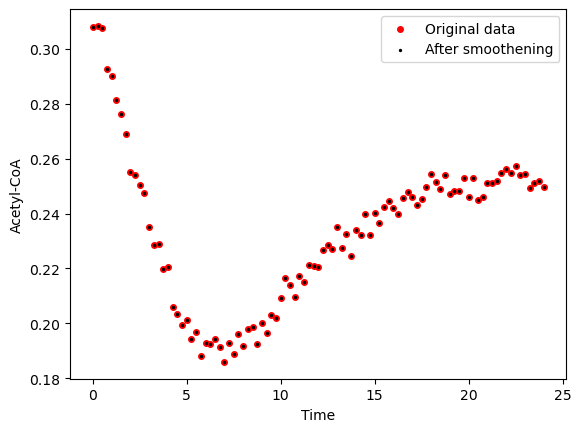

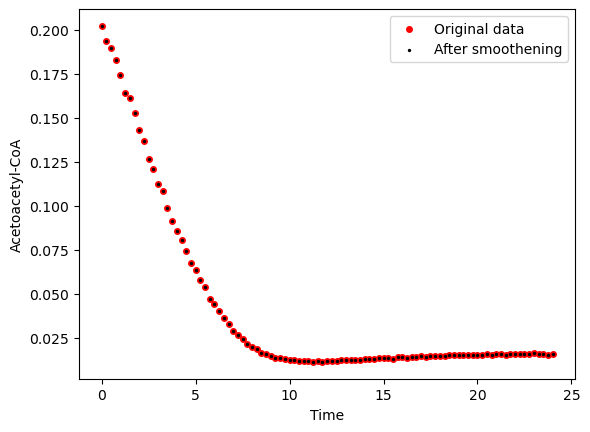

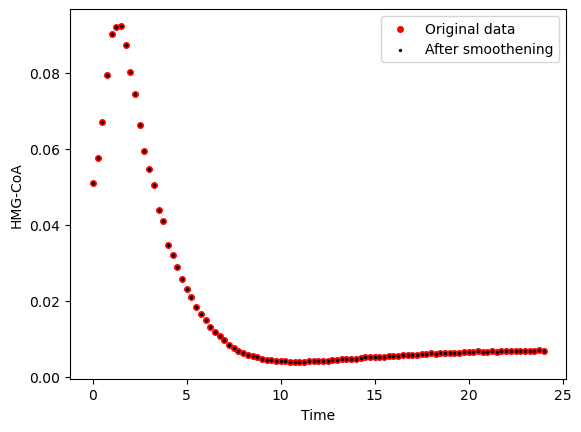

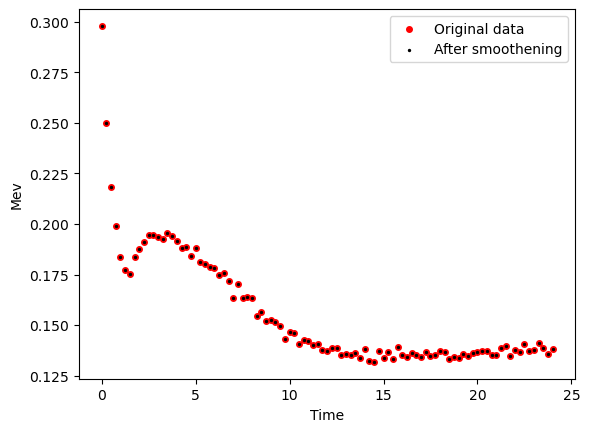

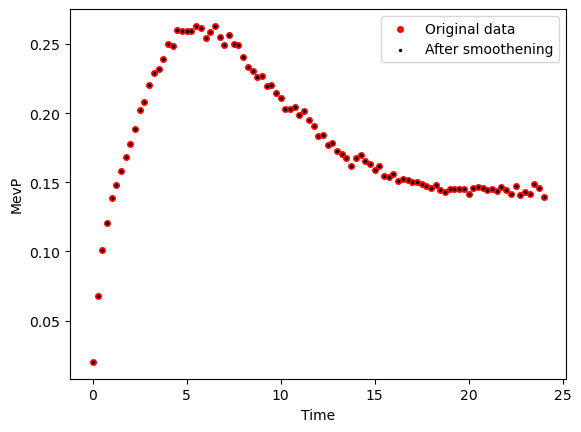

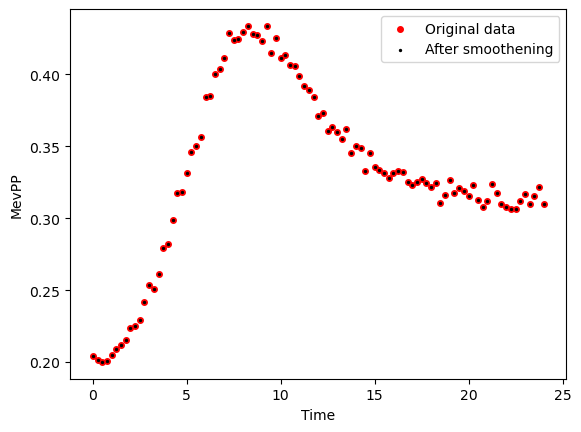

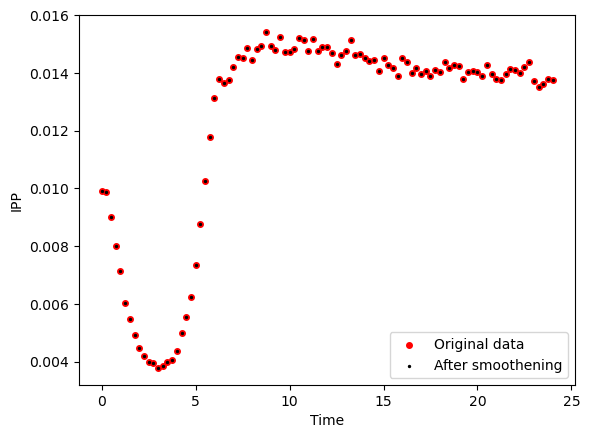

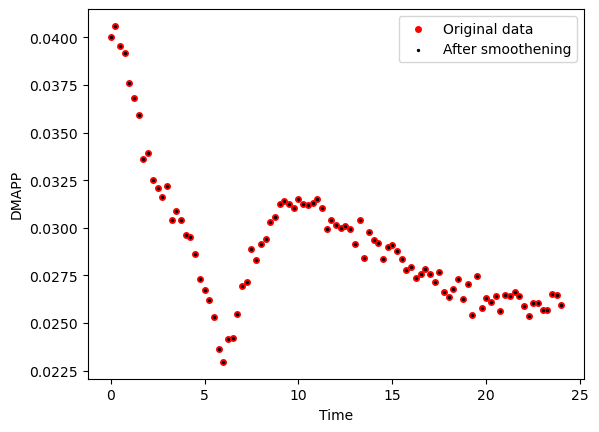

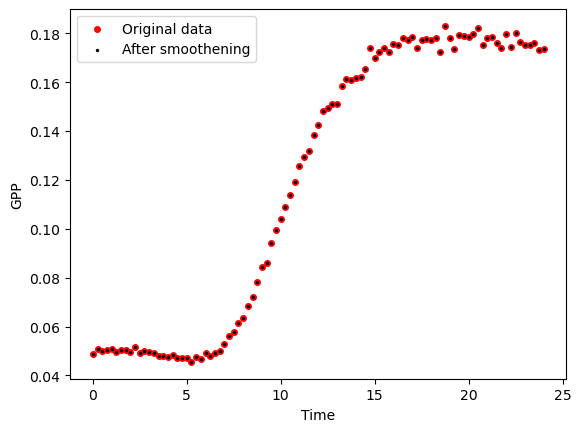

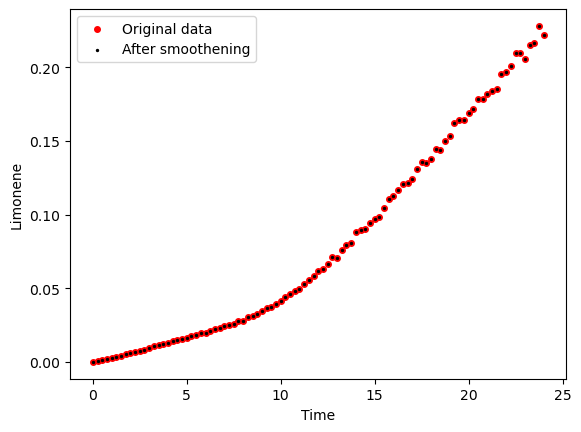

Strain Strain 2


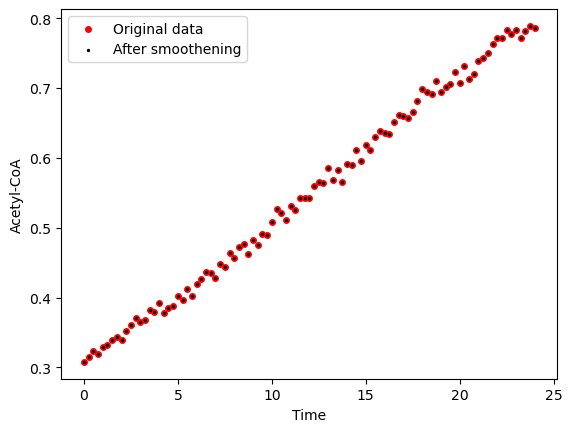

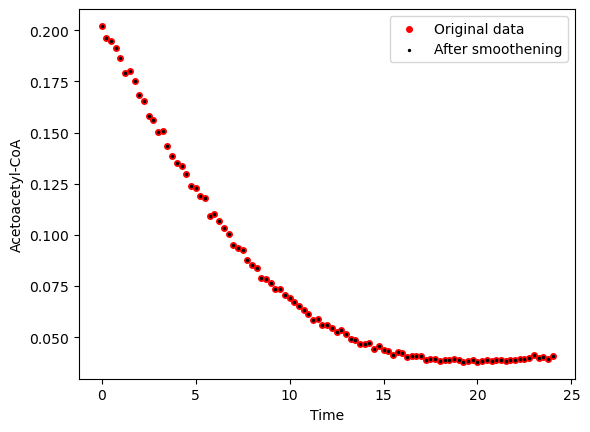

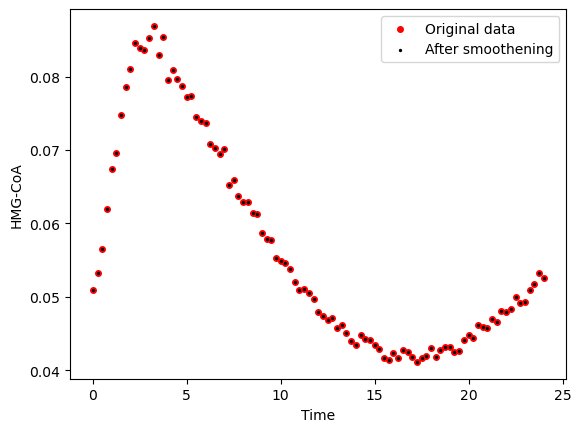

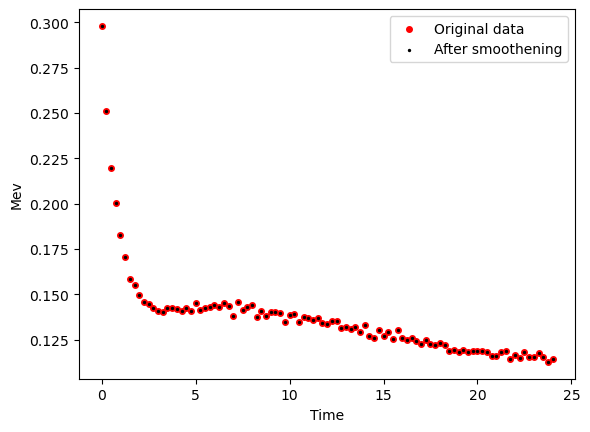

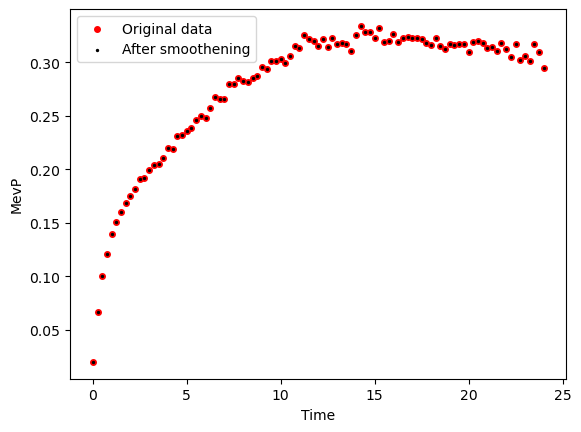

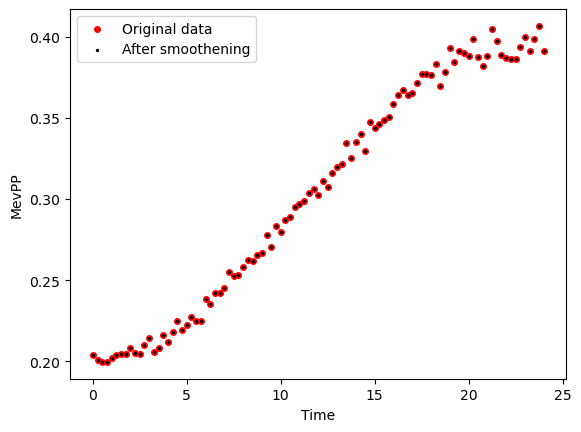

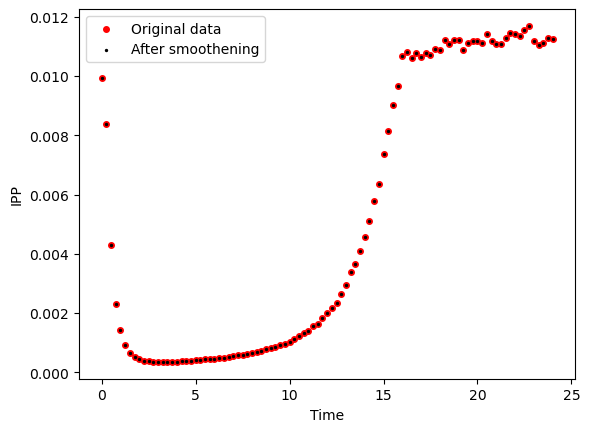

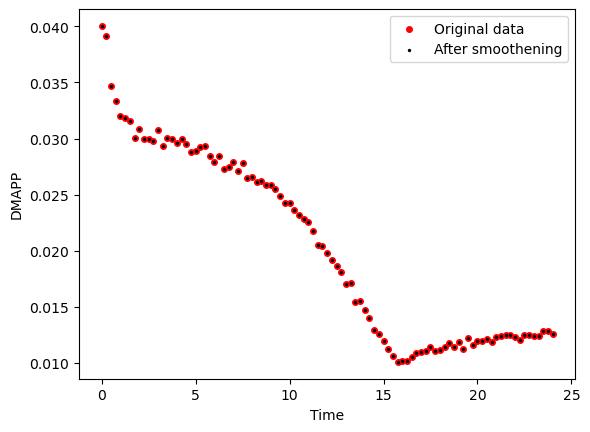

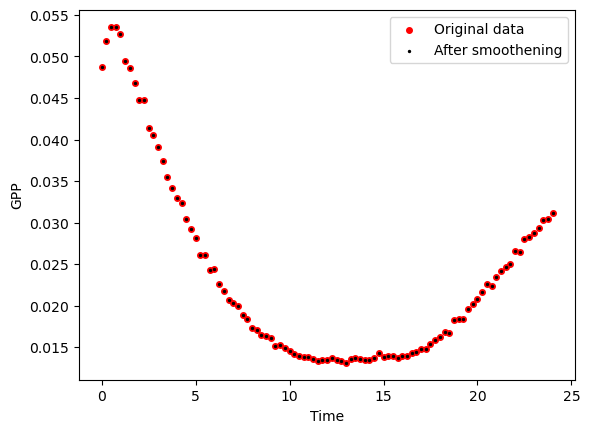

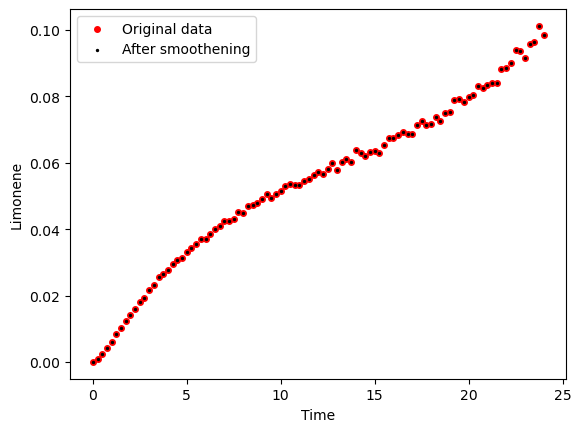

Strain Strain 3


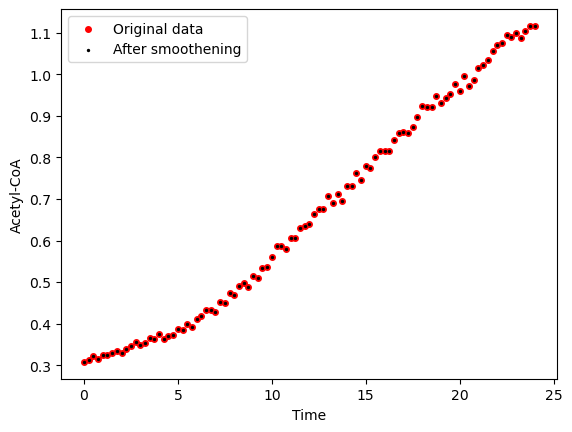

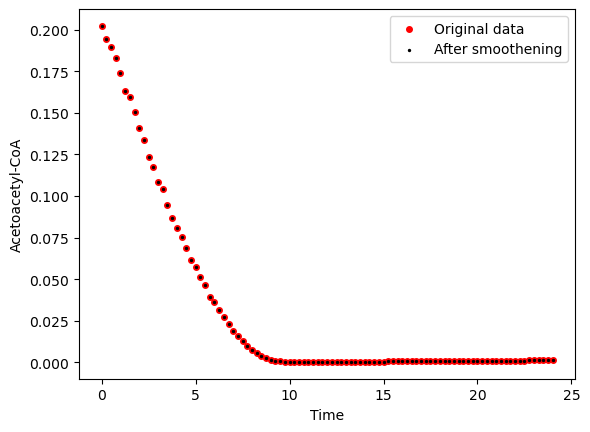

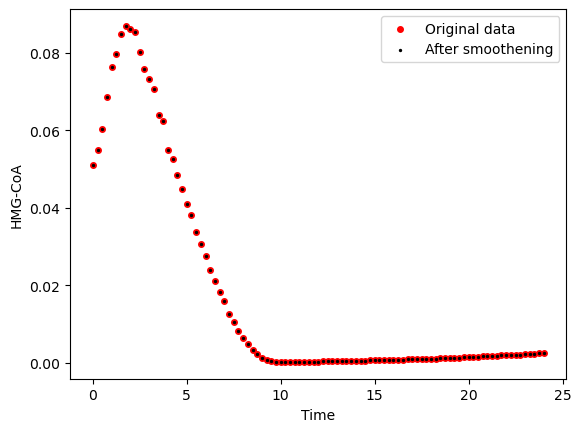

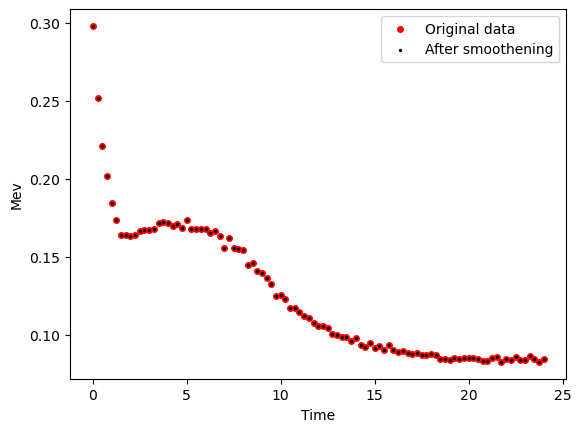

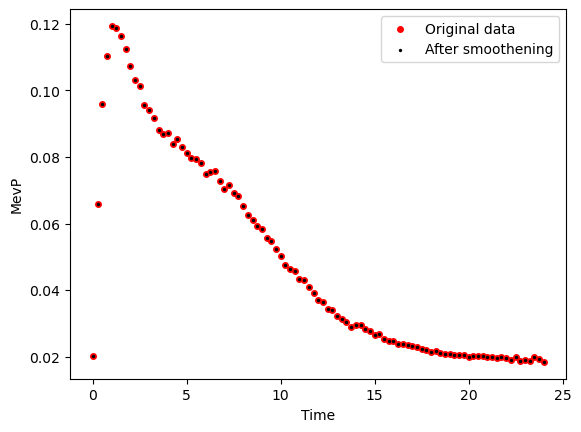

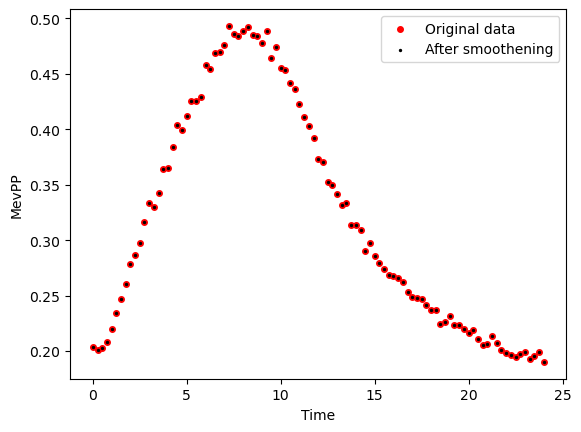

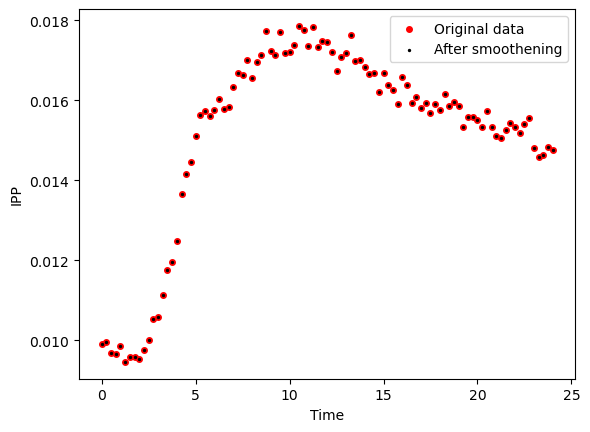

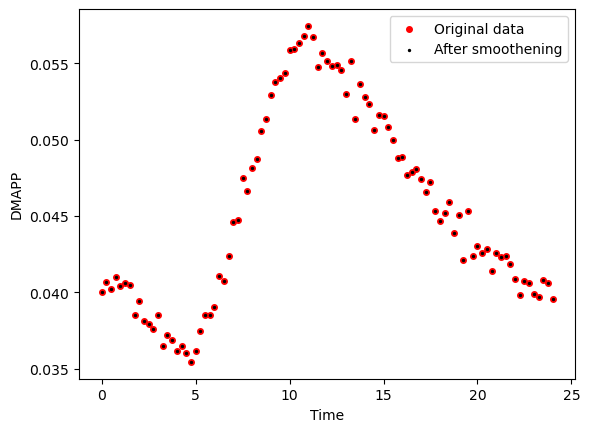

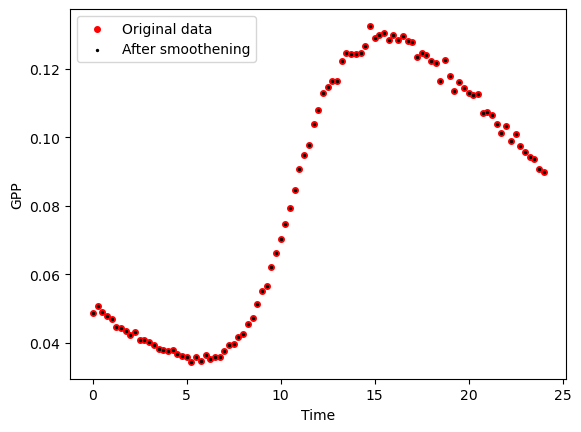

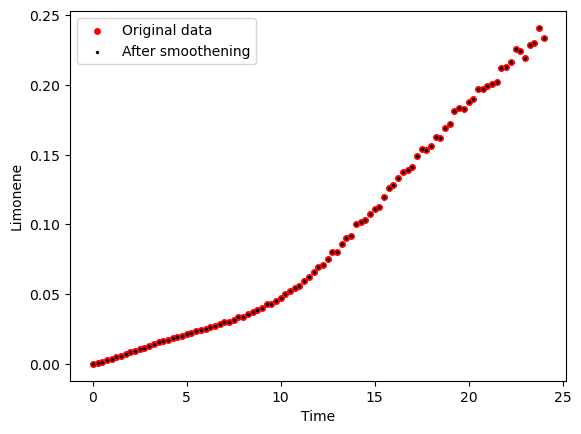

Strain WT


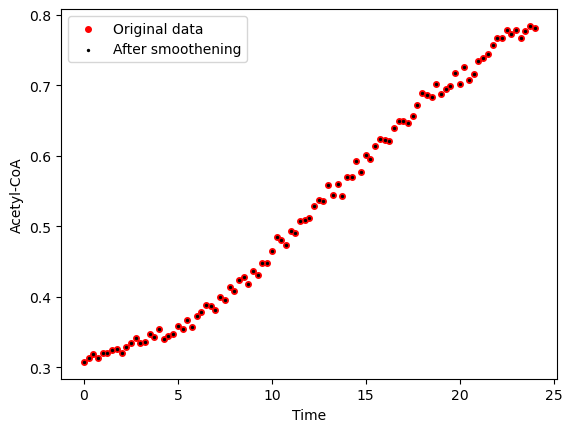

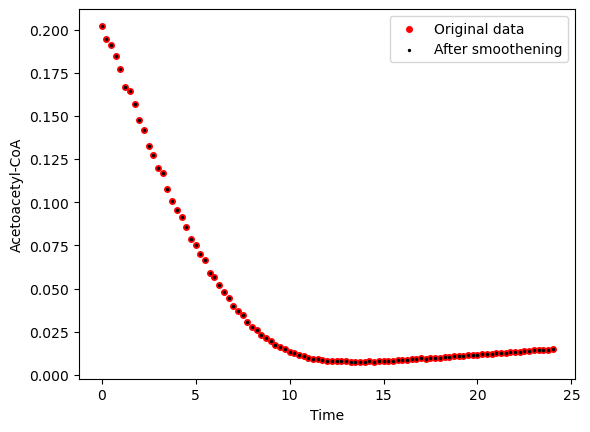

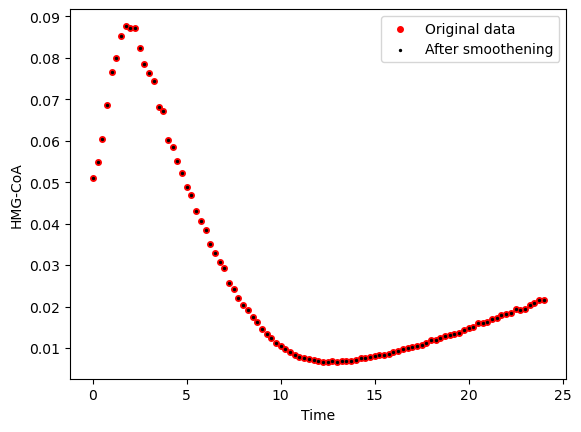

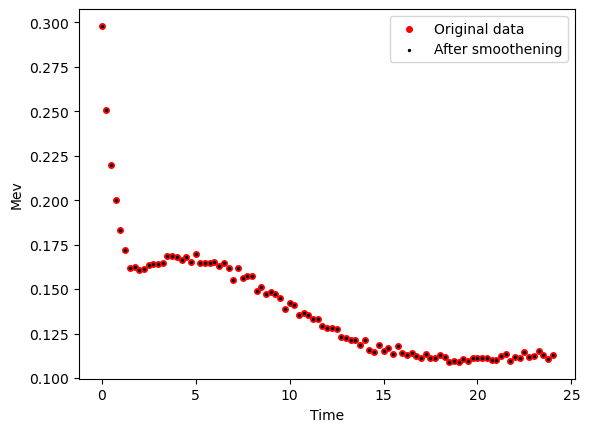

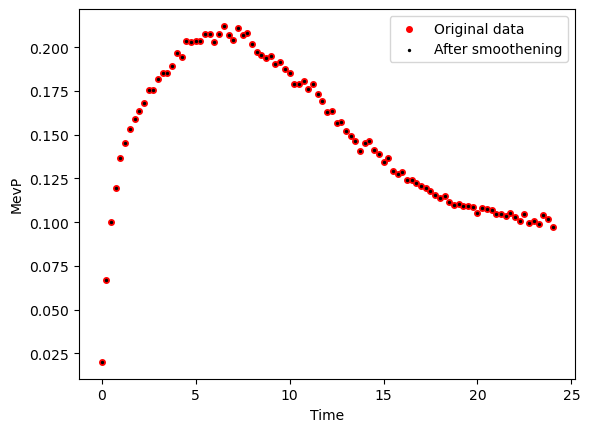

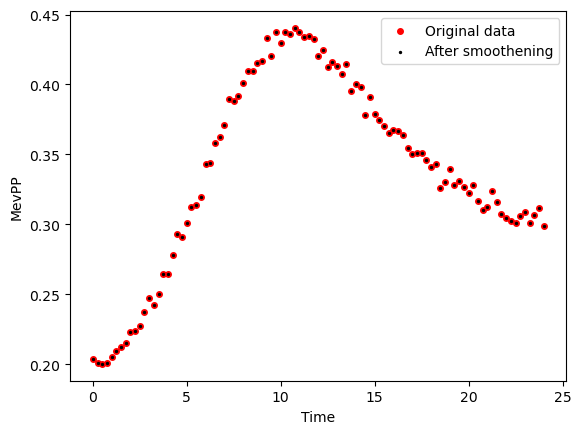

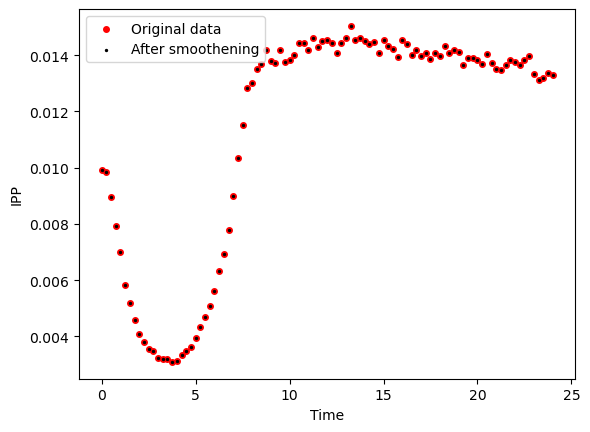

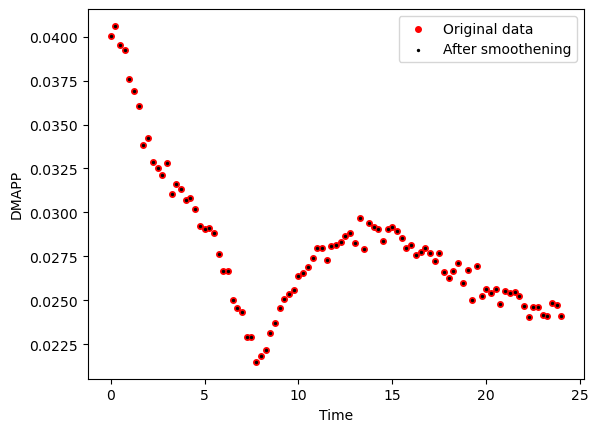

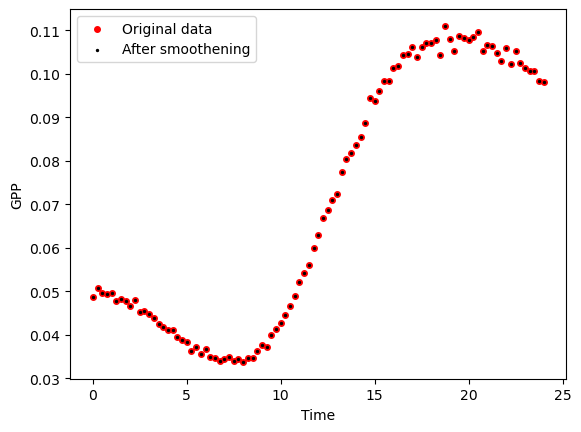

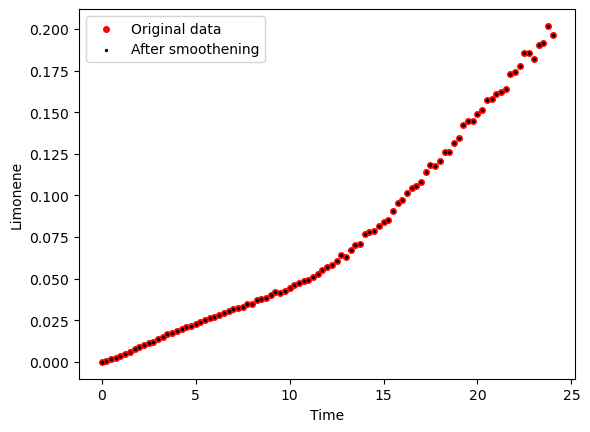

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


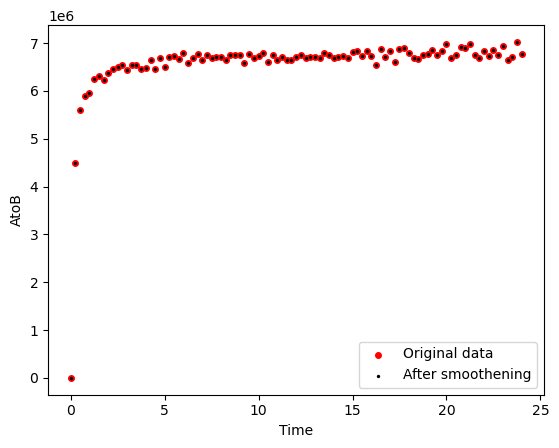

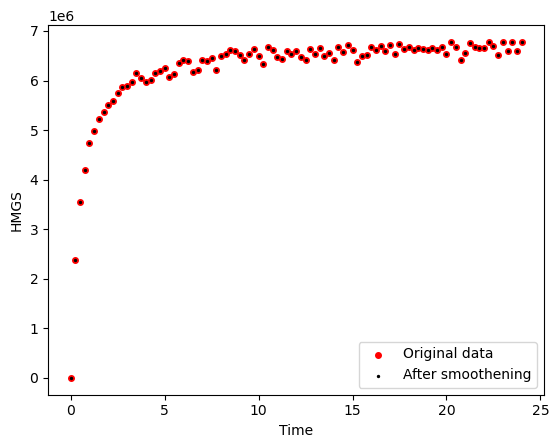

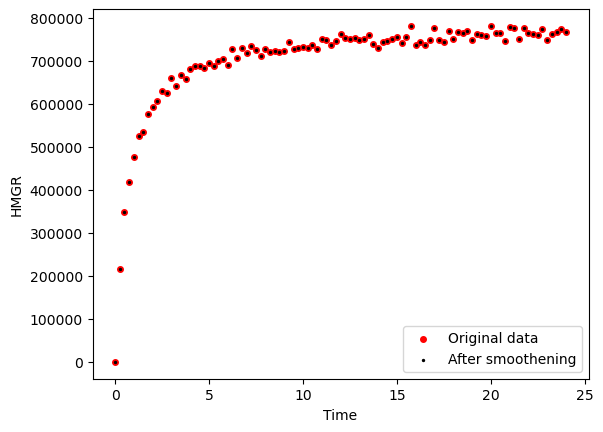

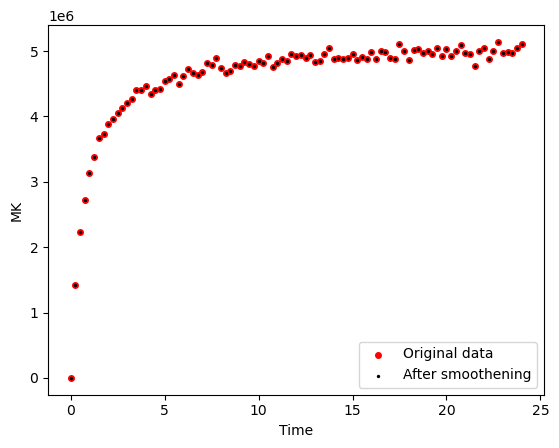

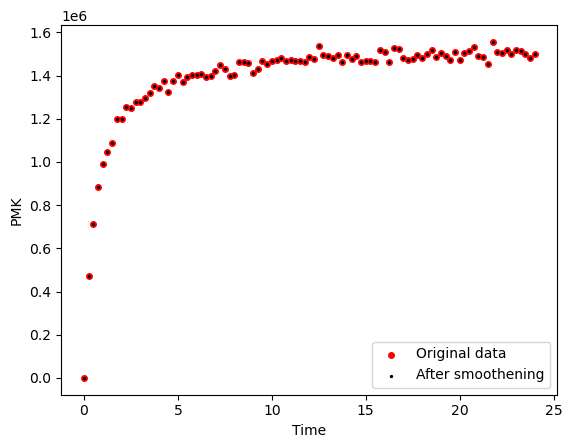

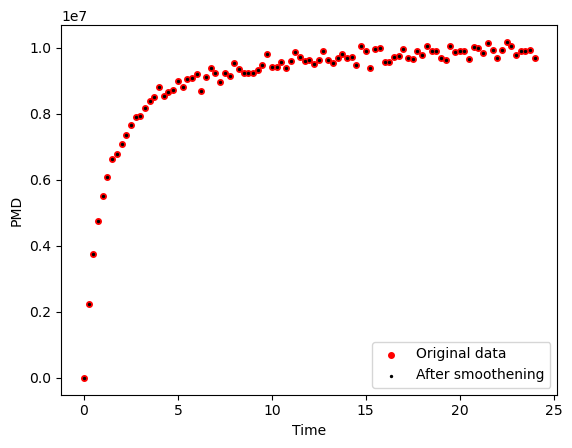

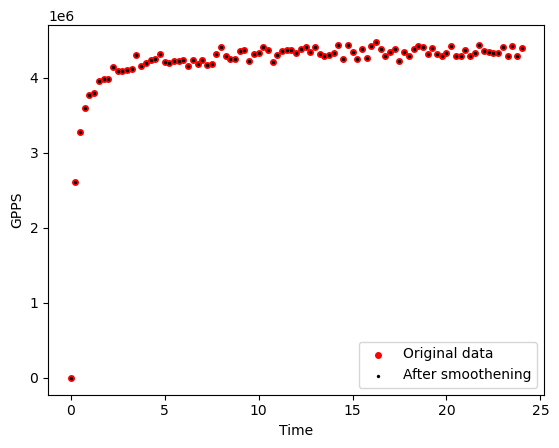

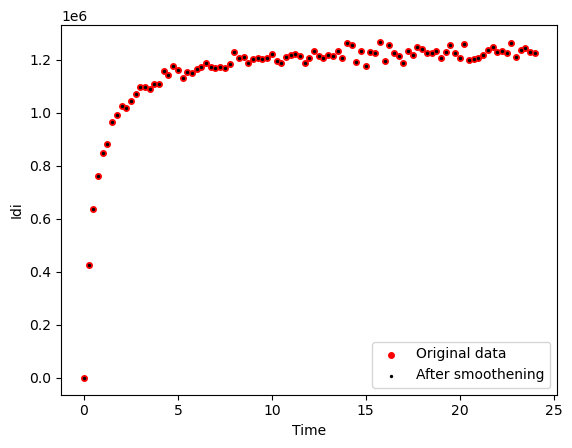

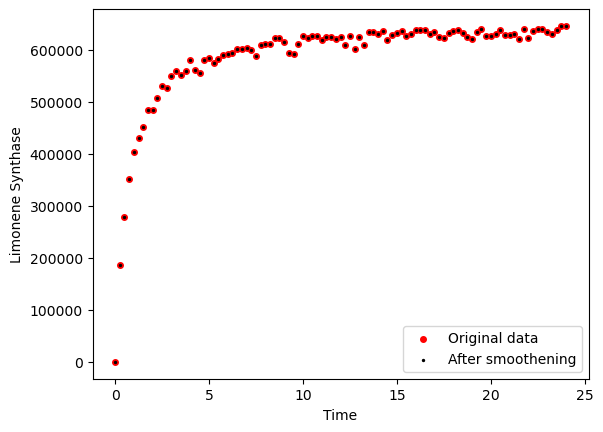

Strain Strain 2


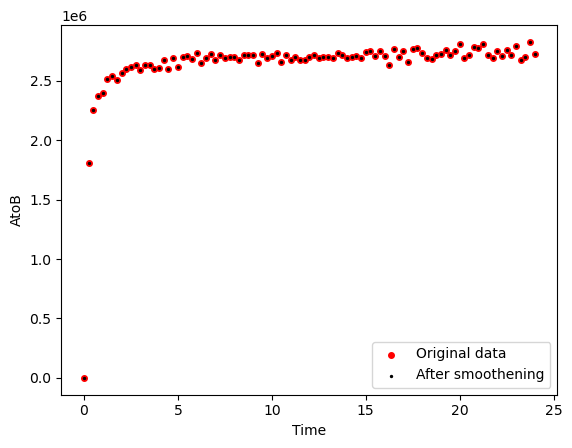

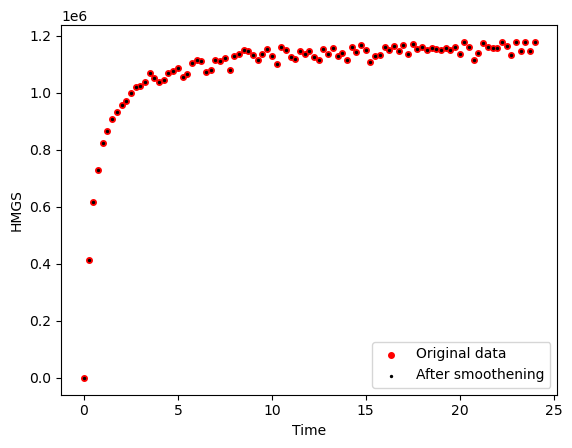

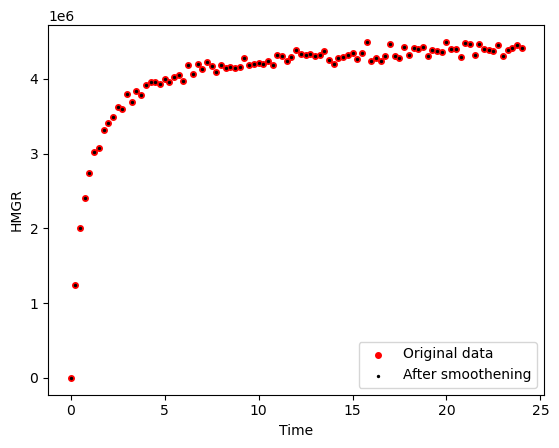

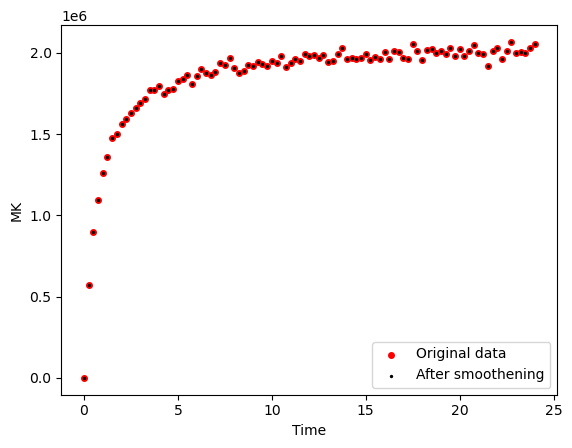

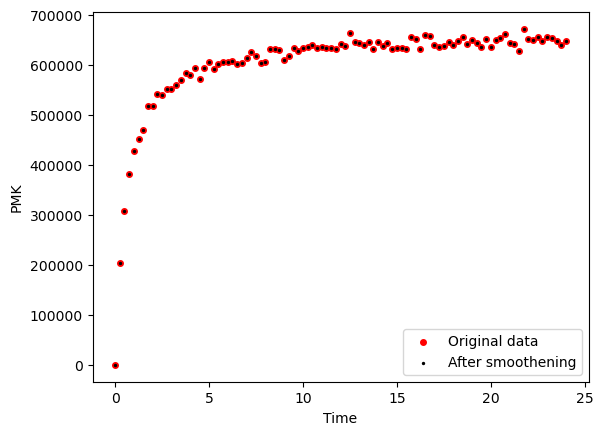

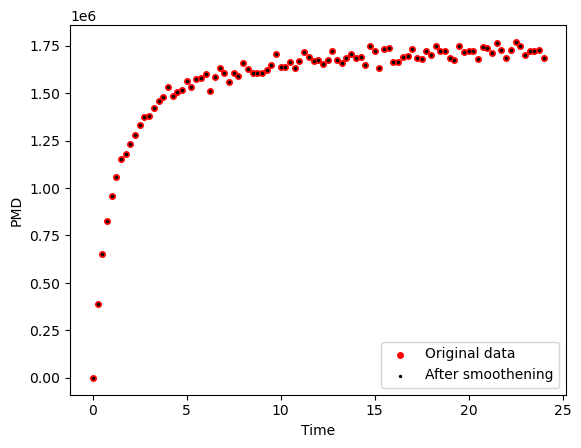

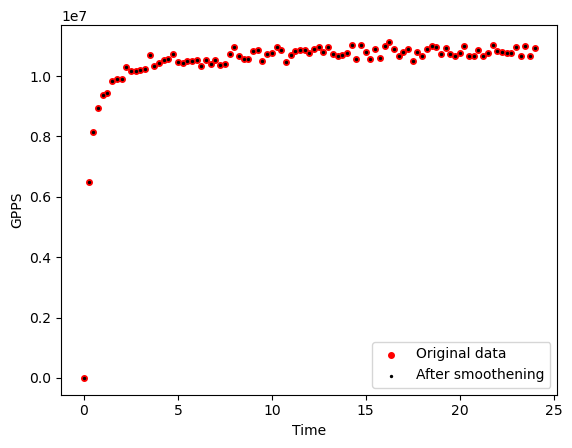

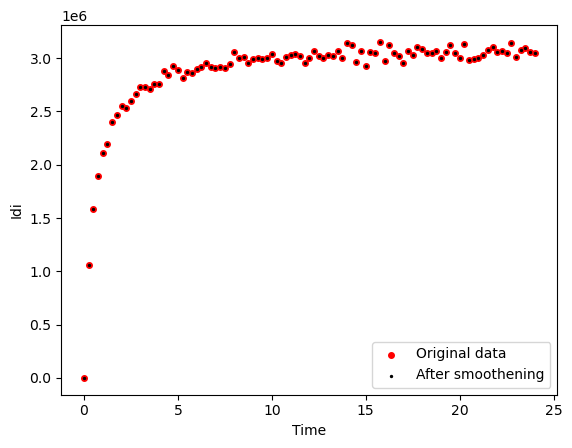

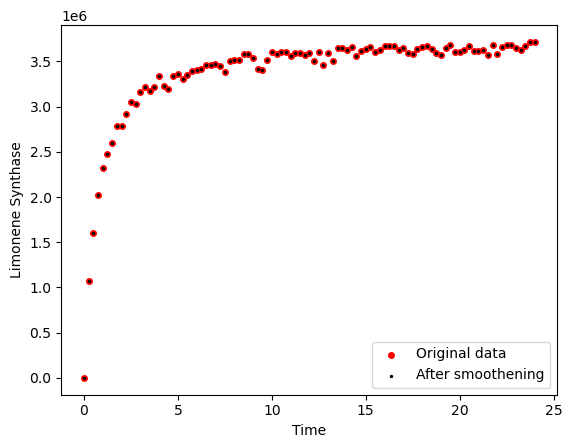

Strain Strain 3


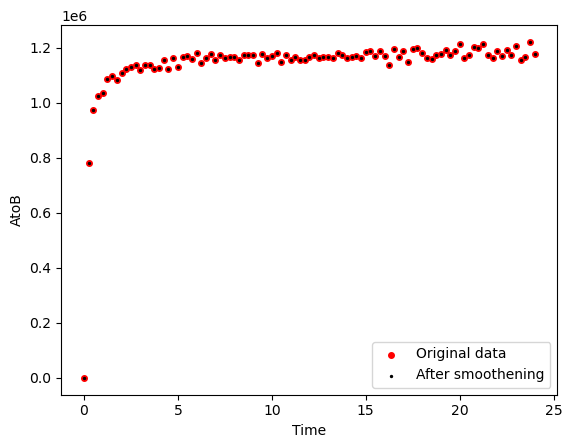

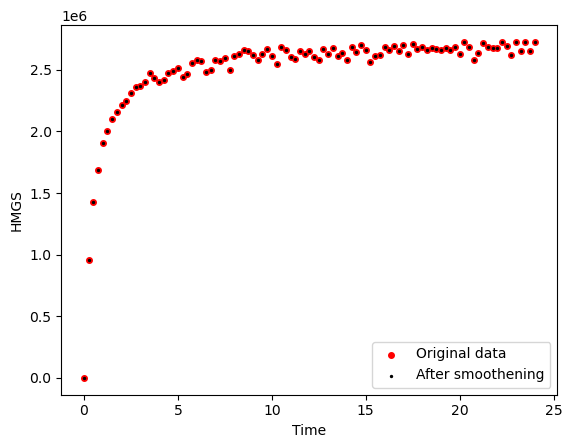

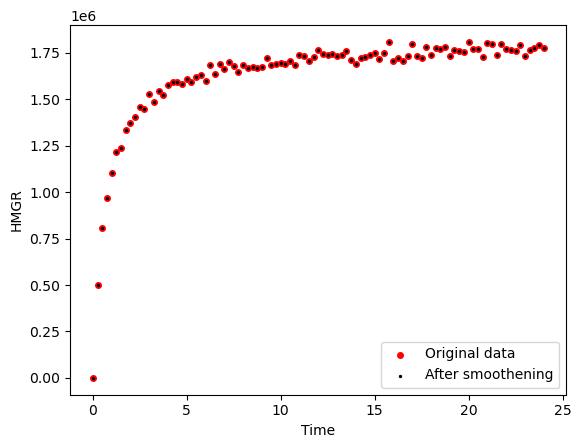

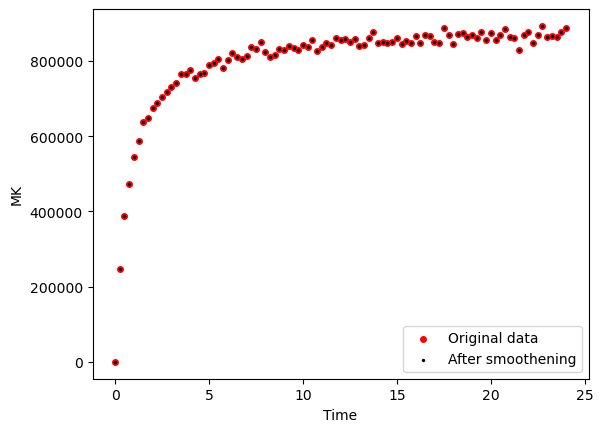

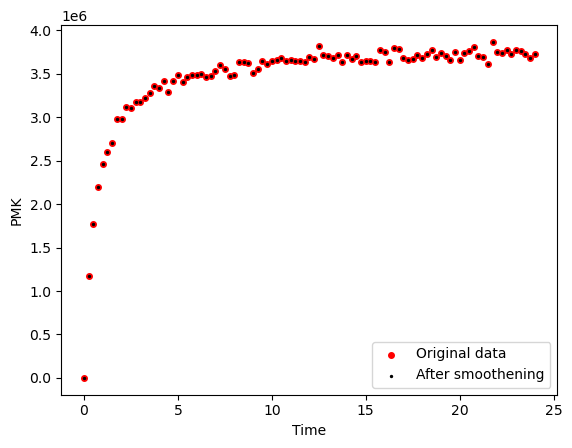

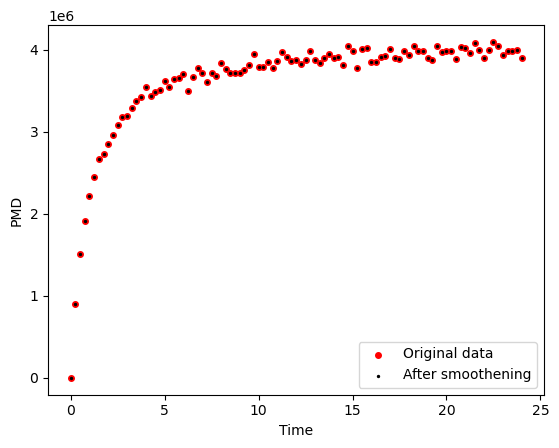

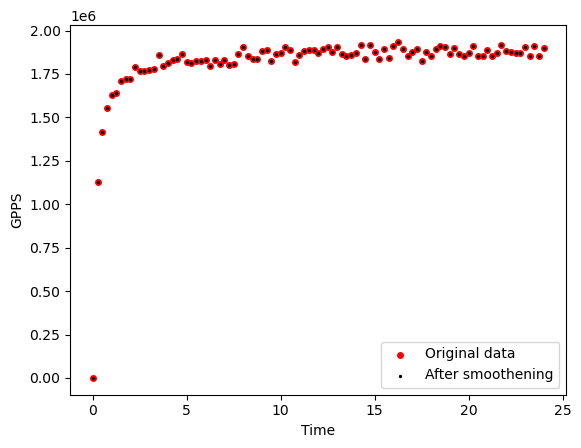

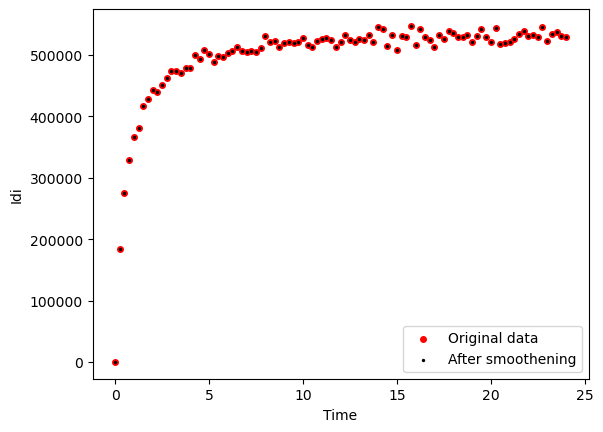

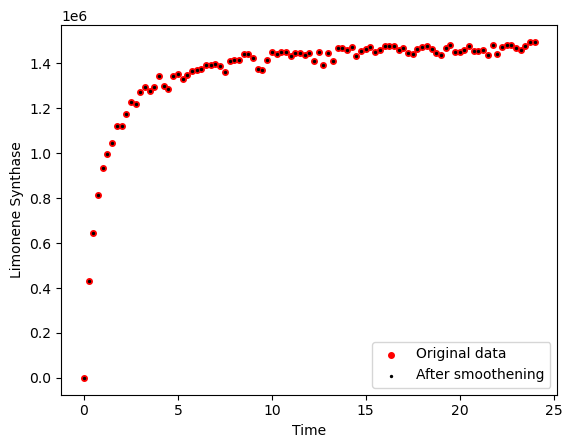

Strain WT


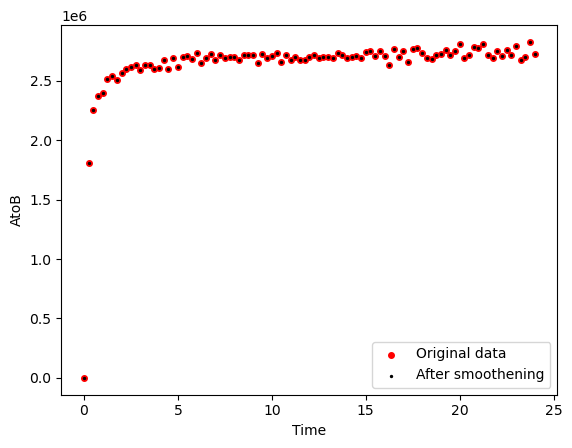

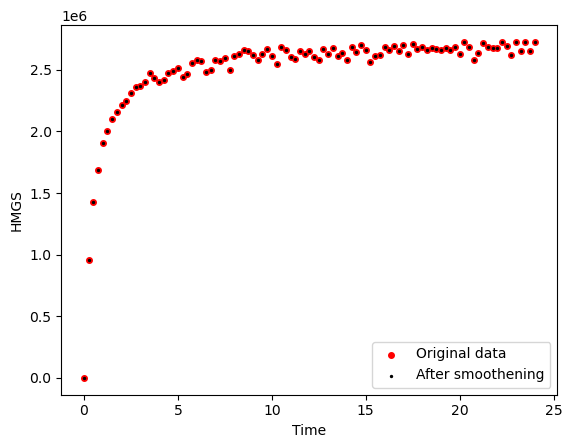

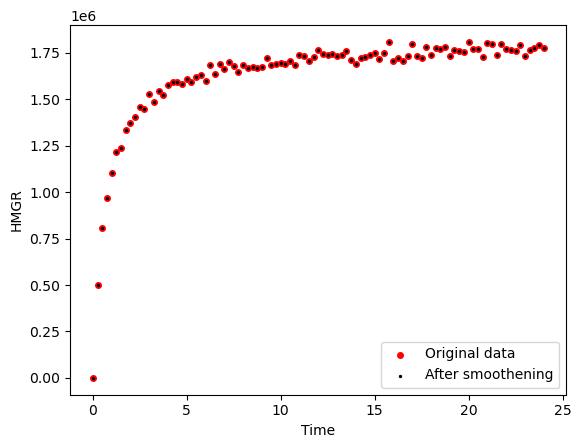

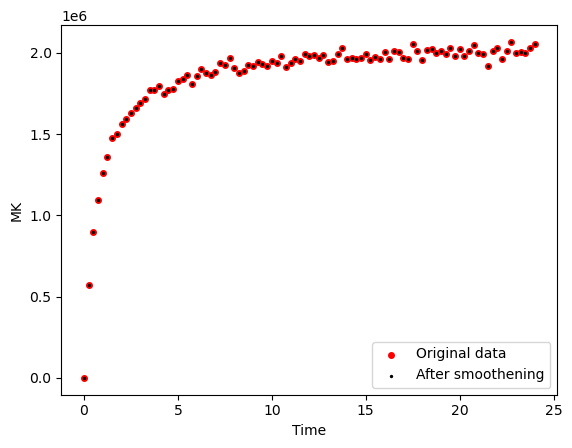

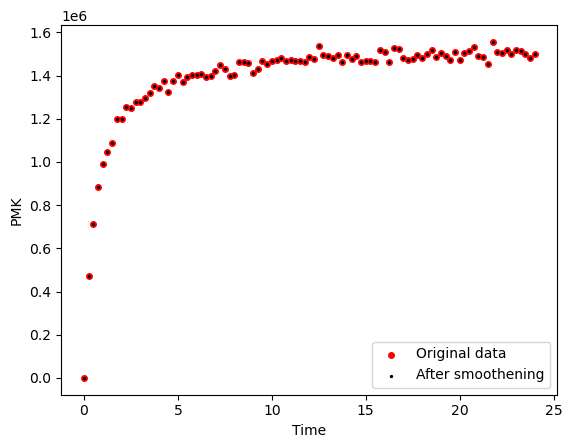

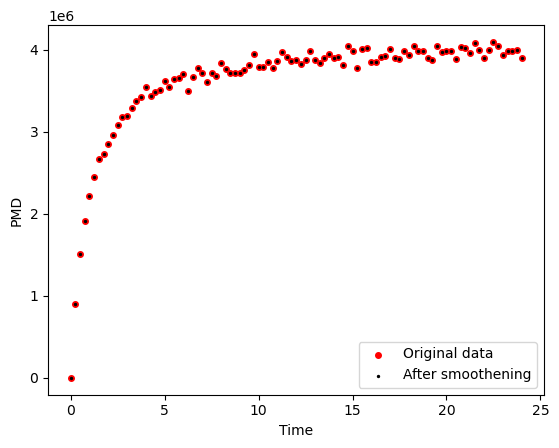

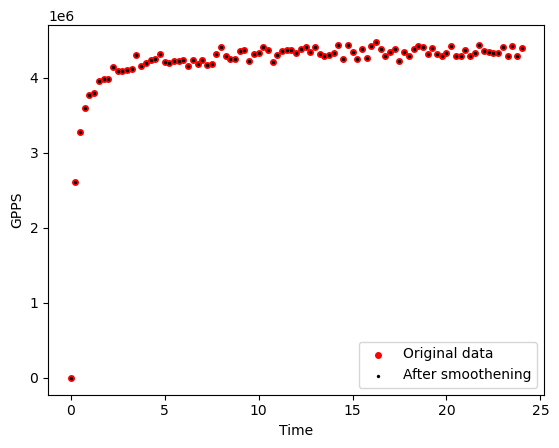

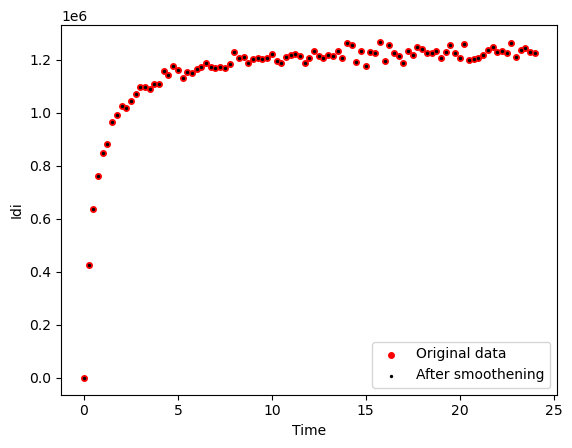

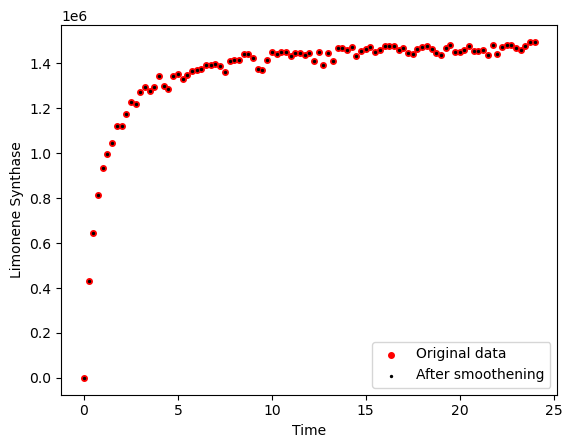

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25    0.308324        0.193844  0.057480  0.249741  0.068097   
         0.50    0.307475        0.189371  0.066989  0.218441  0.101199   
         0.75    0.292477        0.182893  0.079302  0.199102  0.120845   
         1.00    0.290219        0.174545  0.090094  0.183569  0.138351   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.778826        0.014594  0.019505  0.112273  0.100710   
         23.25   0.767586        0.014177  0.020356  0.115130  0.099223   
         23.50   0.777198        0.014545  0.020860  0.113133  0.104319   
         23.75   0.784114        0.014220  0.021703  0.110885  0.101989   
         24.00   0.781234        0.014781  0.021584  0.112914  0.097047   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.203898  0.009923  0.040045  0.048697  0.000000  ...   
         0.25   0.201094  0.009863  0.040604  0.050886  0.000386  ...   
         0.50   0.200102  0.008997  0.039535  0.050162  0.000985  ...   
         0.75   0.200949  0.007993  0.039197  0.050384  0.001715  ...   
         1.00   0.204812  0.007129  0.037581  0.050980  0.002437  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.308910  0.013322  0.024192  0.101325  0.181973  ...   
         23.25  0.301243  0.013127  0.024103  0.100596  0.190535  ...   
         23.50  0.306368  0.013182  0.024829  0.100602  0.191844  ...   
         23.75  0.311549  0.013355  0.024718  0.098291  0.201864  ...   
         24.00  0.299055  0.013308  0.024143  0.098021  0.196378  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.002084       -0.024095  0.027010 -0.200259  0.200635   
         0.25    -0.009166       -0.025282  0.033515 -0.156027  0.158150   
         0.50    -0.020415       -0.026469  0.040020 -0.111796  0.115665   
         0.75    -0.028478       -0.029640  0.036937 -0.071782  0.078804   
         1.00    -0.029534       -0.030077  0.025393 -0.043366  0.056300   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003357        0.000805  0.001620  0.000121 -0.000262   
         23.25    0.008122        0.000231  0.002489 -0.000470  0.003395   
         23.50    0.008537        0.000166  0.002201 -0.001185 -0.001824   
         23.75    0.016551        0.000887  0.001287 -0.002274 -0.010016   
         24.00    0.024565        0.001608  0.000372 -0.003363 -0.018208   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.016668 -0.000988  0.001602  0.004187  0.001564  
         0.25  -0.007998 -0.001985 -0.000466  0.002906  0.002023  
         0.50   0.000672 -0.002983 -0.002534  0.001626  0.002481  
         0.75   0.008258 -0.003811 -0.003816 -0.000774  0.002952  
         1.00   0.012830 -0.003613 -0.003856 -0.000146  0.003169  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002384 -0.000858 -0.000060 -0.004419  0.006802  
         23.25  0.003731 -0.000550  0.000344 -0.003676  0.016931  
         23.50 -0.003761  0.000081  0.000207 -0.003565  0.016055  
         23.75 -0.009246  0.000317 -0.000826 -0.004365  0.004978  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

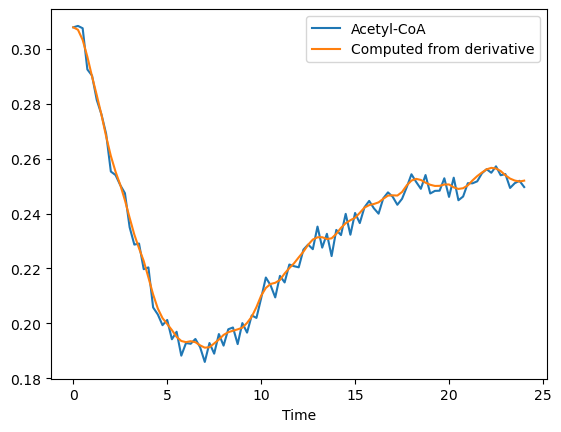

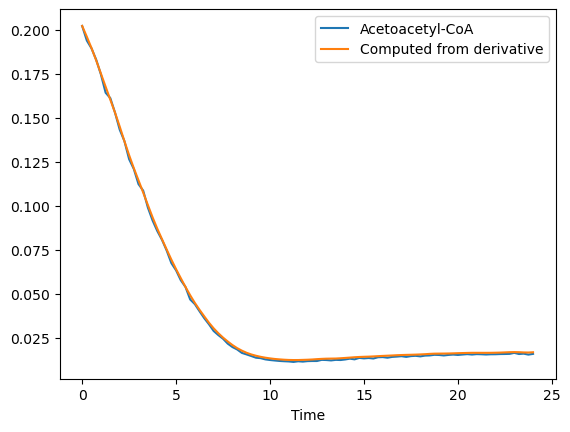

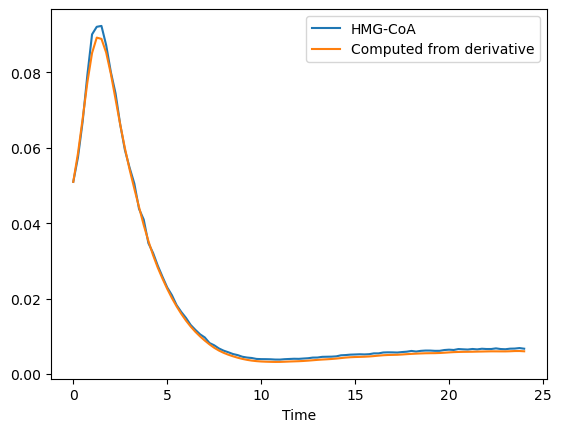

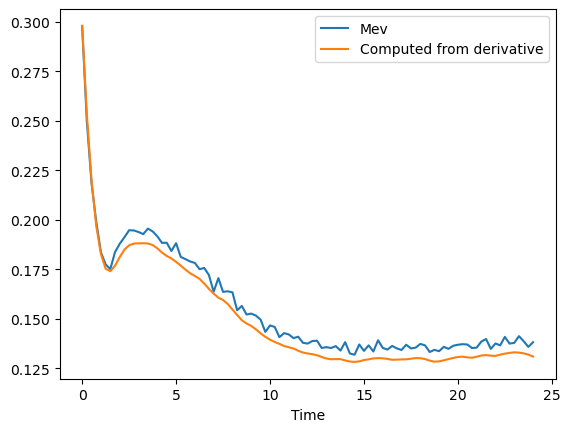

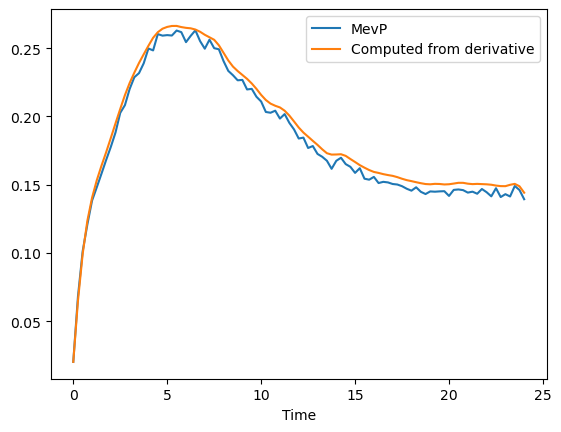

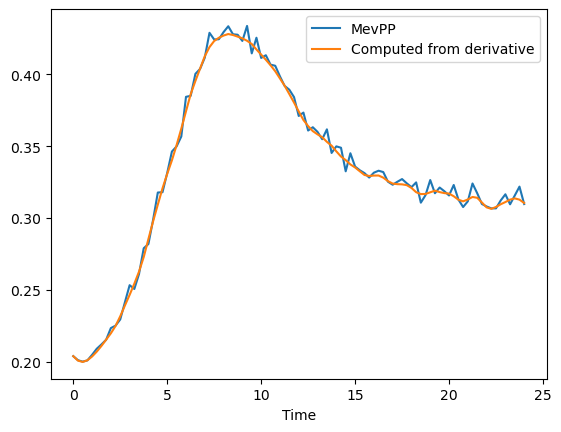

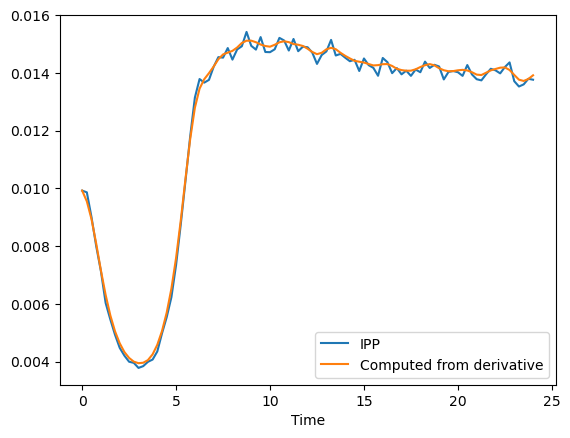

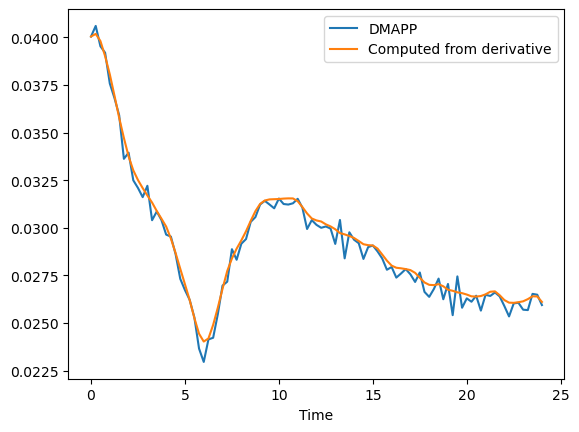

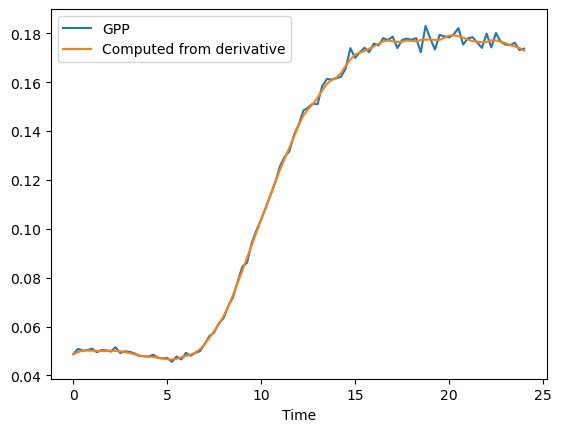

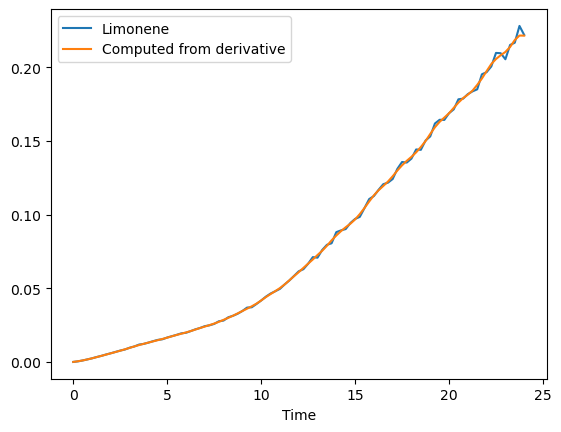

'Time profile from derivative vs. actual profile for Strain 2'

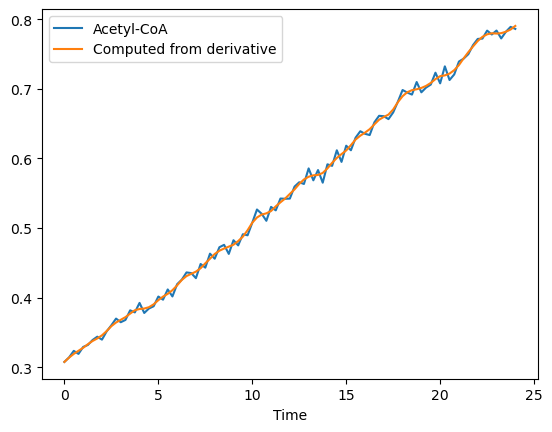

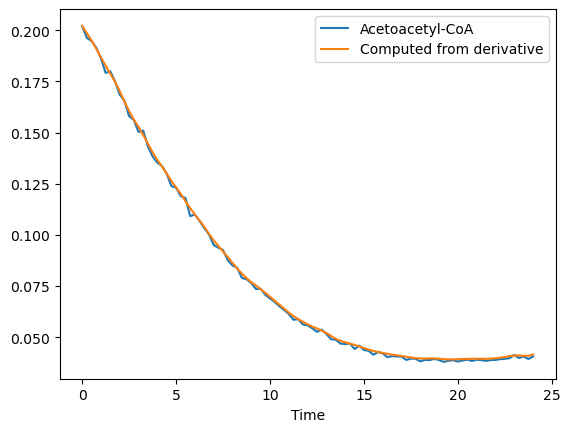

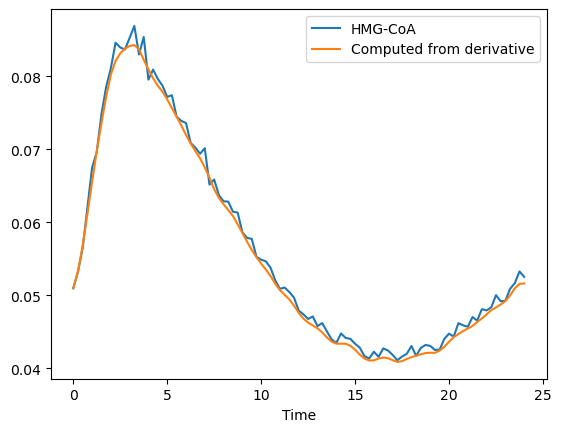

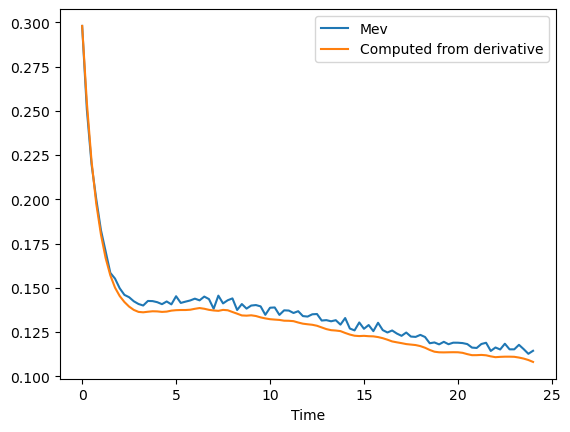

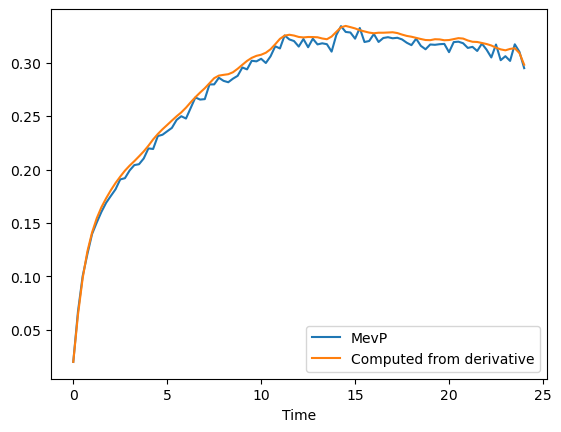

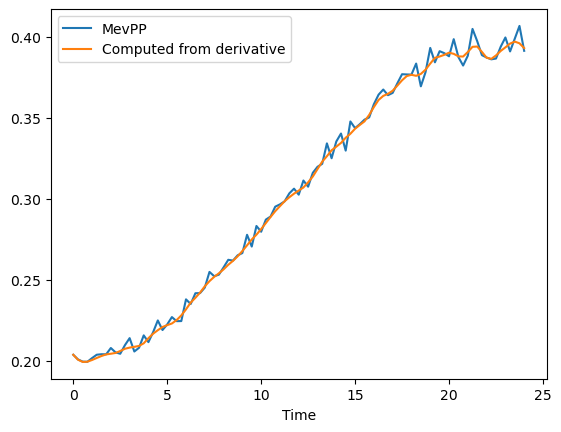

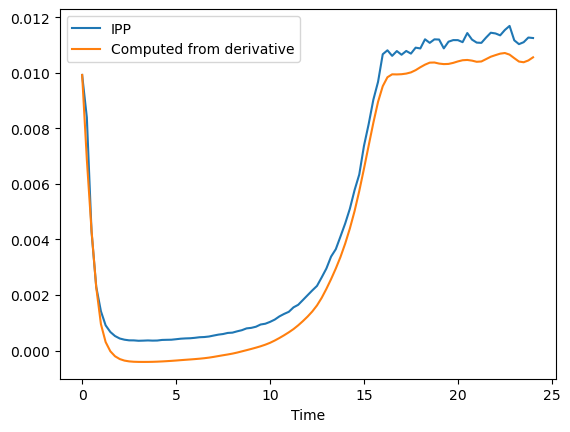

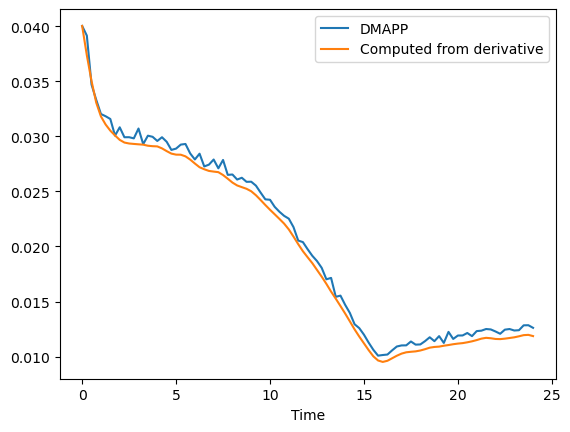

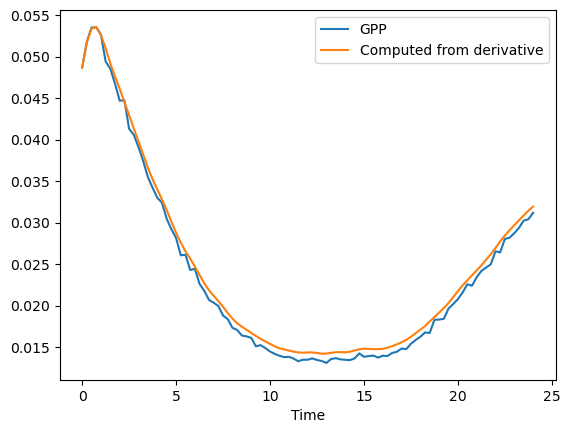

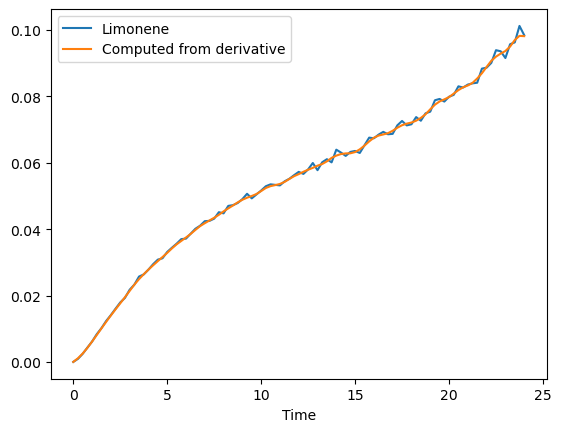

'Time profile from derivative vs. actual profile for Strain 3'

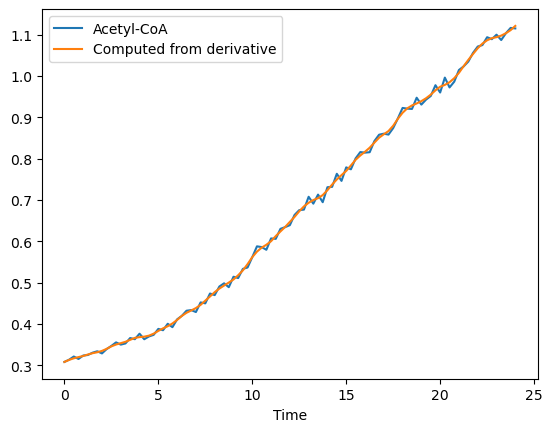

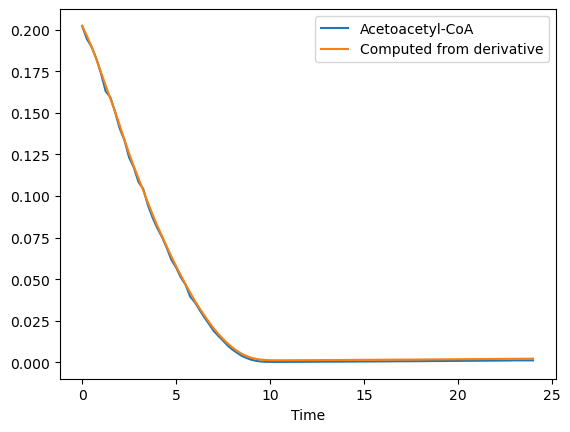

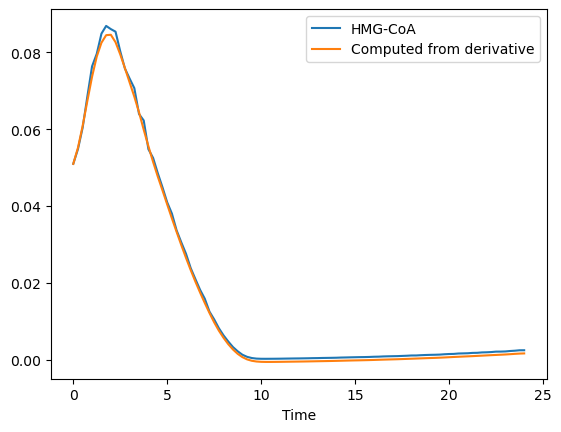

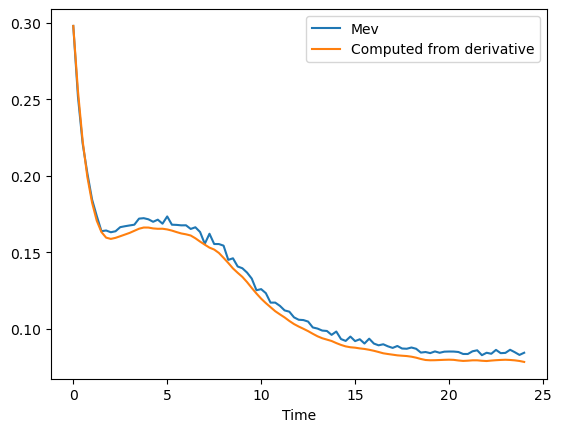

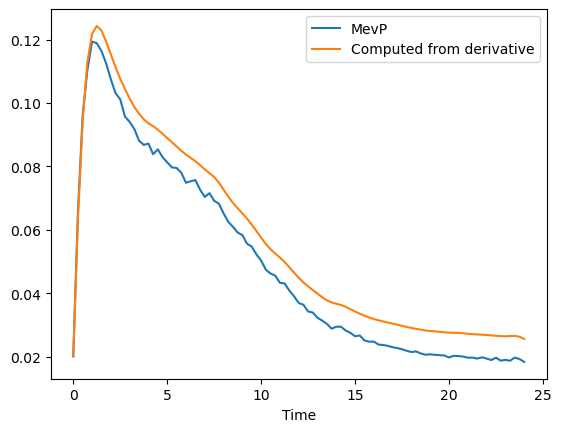

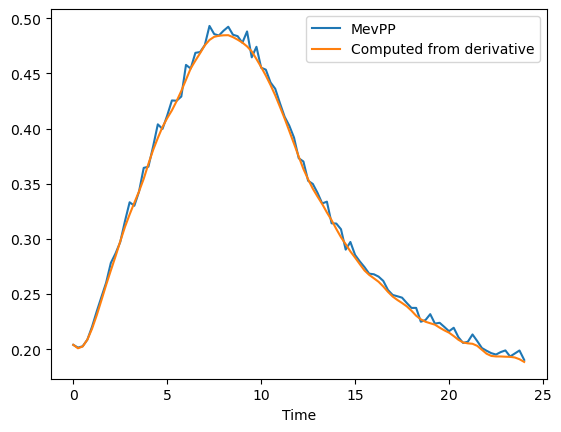

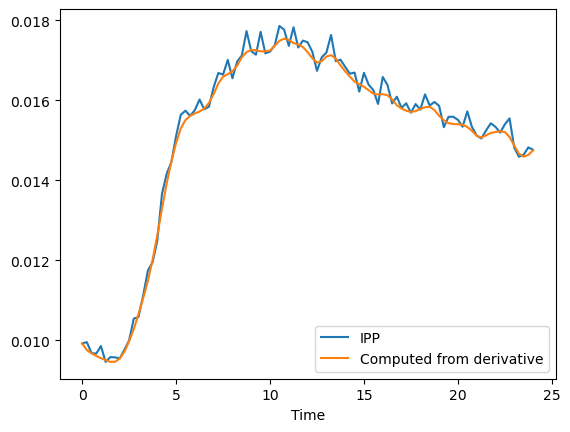

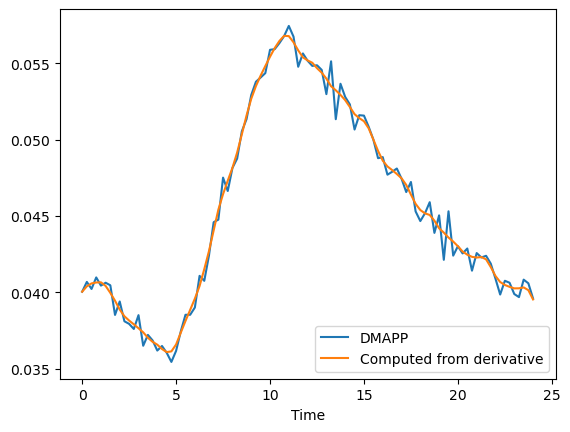

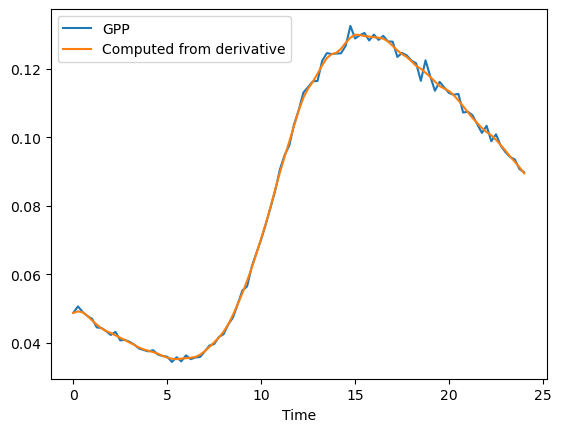

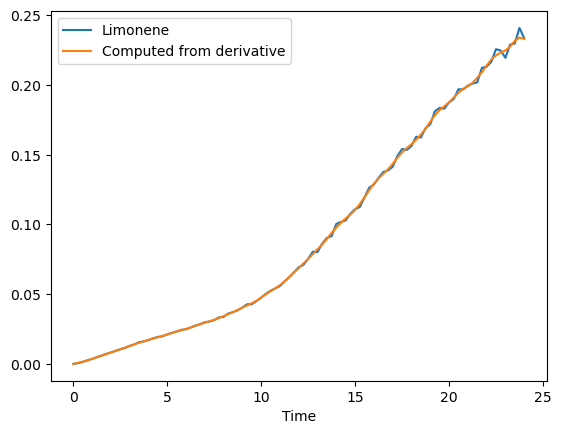

'Time profile from derivative vs. actual profile for WT'

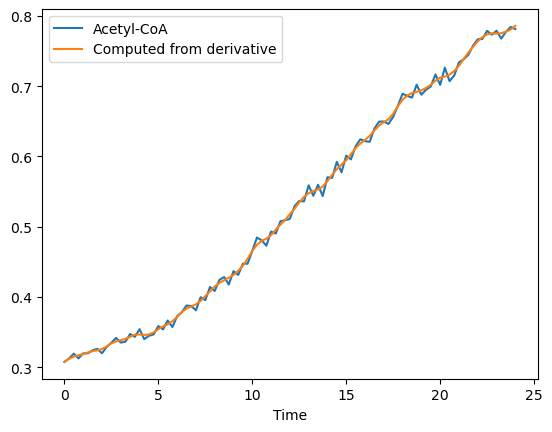

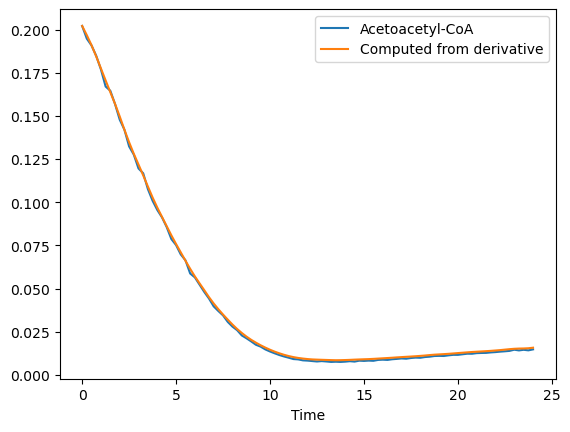

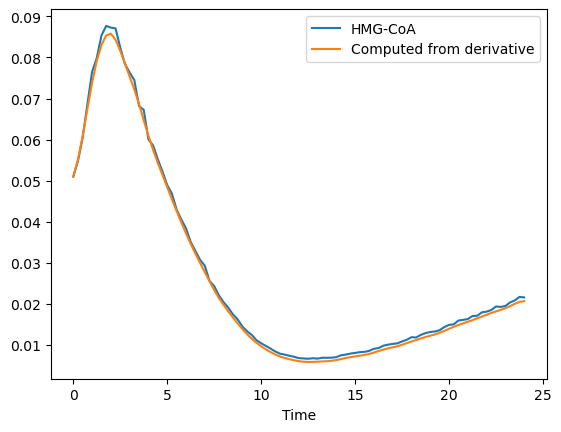

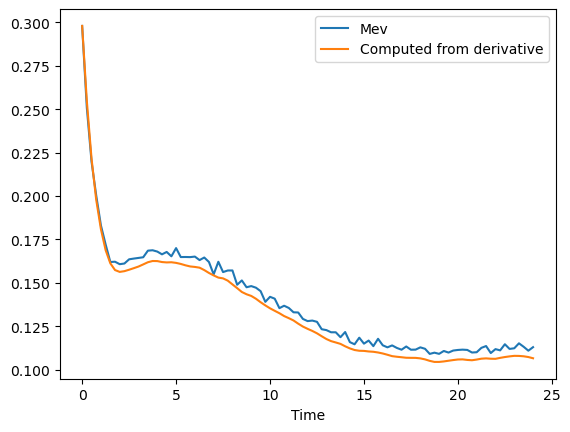

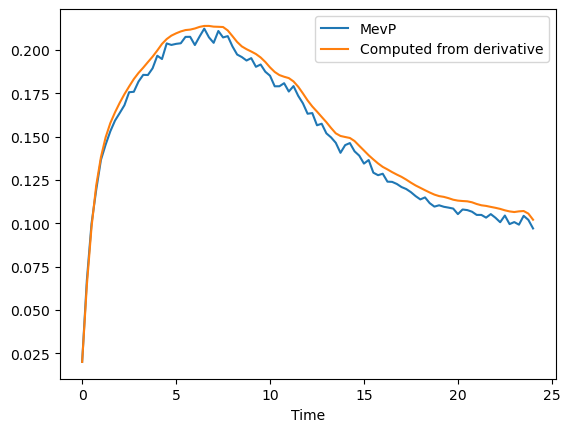

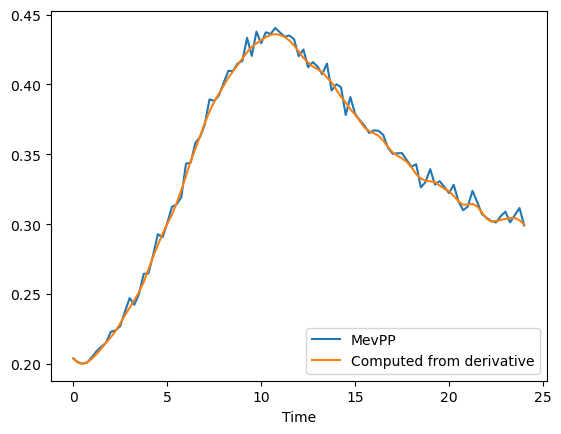

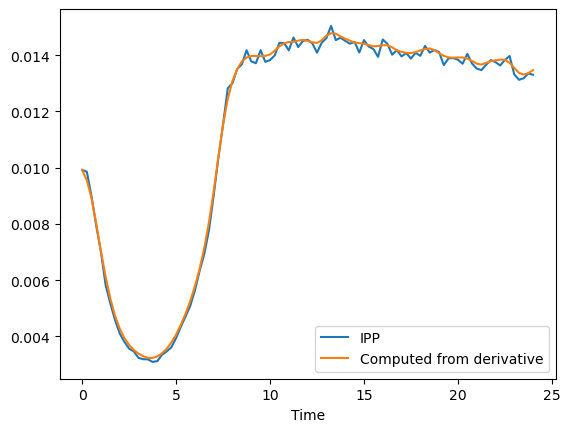

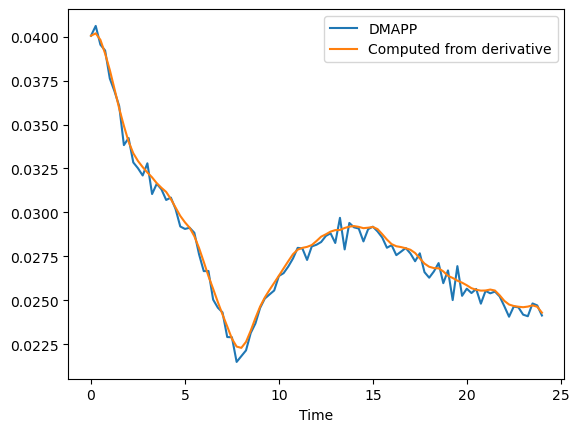

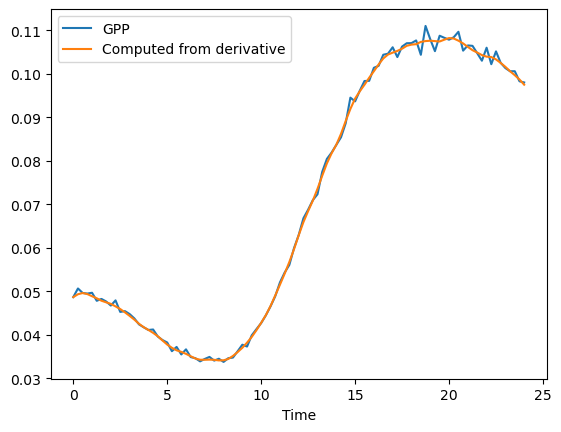

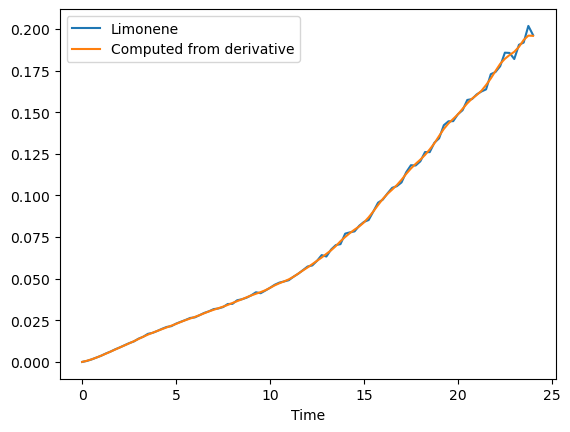

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.101863e+01  4.015845e+01  3.769282e+01  5.723769e+01   
         0.25   4.486963e+06  2.379775e+06  2.151706e+05  1.421525e+06   
         0.50   5.600547e+06  3.542830e+06  3.480314e+05  2.226925e+06   
         0.75   5.898077e+06  4.193526e+06  4.185394e+05  2.716502e+06   
         1.00   5.950154e+06  4.740187e+06  4.756117e+05  3.135893e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793985e+06  2.726634e+06  1.732866e+06  1.999582e+06   
         23.25  2.674277e+06  2.652135e+06  1.764617e+06  2.006932e+06   
         23.50  2.699014e+06  2.722133e+06  1.774984e+06  2.001659e+06   
         23.75  2.825522e+06  2.650638e+06  1.791724e+06  2.026817e+06   
         24.00  2.720292e+06  2.726081e+06  1.773775e+06  2.054542e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.679149e+01  5.554329e+01  5.504357e+01  1.870883e+01   
         0.25   4.724407e+05  2.249389e+06  2.613968e+06  4.271298e+05   
         0.50   7.129844e+05  3.752934e+06  3.280235e+06  6.385851e+05   
         0.75   8.861639e+05  4.752821e+06  3.593999e+06  7.611653e+05   
         1.00   9.916589e+05  5.524615e+06  3.766037e+06  8.471239e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.519758e+06  3.933723e+06  4.405661e+06  1.211293e+06   
         23.25  1.512951e+06  3.982947e+06  4.295628e+06  1.235920e+06   
         23.50  1.498116e+06  3.988023e+06  4.423044e+06  1.246005e+06   
         23.75  1.482534e+06  3.991343e+06  4.296578e+06  1.228846e+06   
         24.00  1.498900e+06  3.898759e+06  4.397311e+06  1.226257e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.955014e+01   0.307814        0.202156  0.050979   
         0.25       1.868839e+05   0.308324        0.193844  0.057480   
         0.50       2.787753e+05   0.307475        0.189371  0.066989   
         0.75       3.510419e+05   0.292477        0.182893  0.079302   
         1.00       4.039616e+05   0.290219        0.174545  0.090094   
...                          ...        ...             ...       ...   
WT       23.00      1.467980e+06   0.778826        0.014594  0.019505   
         23.25      1.460229e+06   0.767586        0.014177  0.020356   
         23.50      1.477857e+06   0.777198        0.014545  0.020860   
         23.75      1.494116e+06   0.784114        0.014220  0.021703   
         24.00      1.493358e+06   0.781234        0.014781  0.021584   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297995  0.020144  0.203898  0.009923  0.040045  0.048697   
         0.25   0.249741  0.068097  0.201094  0.009863  0.040604  0.050886   
         0.50   0.218441  0.101199  0.200102  0.008997  0.039535  0.050162   
         0.75   0.199102  0.120845  0.200949  0.007993  0.039197  0.050384   
         1.00   0.183569  0.138351  0.204812  0.007129  0.037581  0.050980   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112273  0.100710  0.308910  0.013322  0.024192  0.101325   
         23.25  0.115130  0.099223  0.301243  0.013127  0.024103  0.100596   
         23.50  0.113133  0.104319  0.306368  0.013182  0.024829 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.002084       -0.024095  0.027010 -0.200259  0.200635   
         0.25    -0.009166       -0.025282  0.033515 -0.156027  0.158150   
         0.50    -0.020415       -0.026469  0.040020 -0.111796  0.115665   
         0.75    -0.028478       -0.029640  0.036937 -0.071782  0.078804   
         1.00    -0.029534       -0.030077  0.025393 -0.043366  0.056300   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003357        0.000805  0.001620  0.000121 -0.000262   
         23.25    0.008122        0.000231  0.002489 -0.000470  0.003395   
         23.50    0.008537        0.000166  0.002201 -0.001185 -0.001824   
         23.75    0.016551        0.000887  0.001287 -0.002274 -0.010016   
         24.00    0.024565        0.001608  0.000372 -0.003363 -0.018208   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.016668 -0.000988  0.001602  0.004187  0.001564  
         0.25  -0.007998 -0.001985 -0.000466  0.002906  0.002023  
         0.50   0.000672 -0.002983 -0.002534  0.001626  0.002481  
         0.75   0.008258 -0.003811 -0.003816 -0.000774  0.002952  
         1.00   0.012830 -0.003613 -0.003856 -0.000146  0.003169  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002384 -0.000858 -0.000060 -0.004419  0.006802  
         23.25  0.003731 -0.000550  0.000344 -0.003676  0.016931  
         23.50 -0.003761  0.000081  0.000207 -0.003565  0.016055  
         23.75 -0.009246  0.000317 -0.000826 -0.004365  0.004978  
         24.00 -0.014730  0.000554 -0.001859 -0.005164 -0.006099  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.100523E+180 | 1.298081E+108
     2 |       74 | 5.104042E+117 | 3.251376E+106
     3 |      138 | 4.429526E+105 |  3.917971E+86
     4 |      202 |  6.191268E+95 |  5.810378E+77
     5 |      266 |  7.877022E+84 |  9.609311E+71
     6 |      330 |  1.367861E+74 |  1.459290E+61
     7 |      394 |  3.287497E+74 |  9.491529E+55
     8 |      458 |  1.466346E+61 |  8.071026E+50
     9 |      522 |  1.231673E+54 |  5.348188E+46
    10 |      586 |  2.979309E+52 |  2.486907E+42
    11 |      650 |  1.238320E+46 |  1.909604E+38
    12 |      714 |  1.504975E+47 |  2.900261E+36
    13 |      778 |  7.815860E+43 |  5.797302E+31
    14 |      842 |  8.330425E+39 |  6.909209E+29
    15 |      906 |  1.993464E+38 |  1.467200E+29
    16 |      970 |  5.482587E+35 |  1.467200E+29
    17 |     1034 |  7.268298E+35 |  8.233545E+24
    18 |     1098 |  3.644000E+29 |  9.946030E+21
    19 |     1162 |  5.681

   162 |    10314 |  1.910508E+01 |  1.547679E+01
   163 |    10378 |  1.810227E+01 |  1.547679E+01
   164 |    10442 |  1.704959E+01 |  1.547679E+01
   165 |    10506 |  1.695762E+01 |  1.522618E+01
   166 |    10570 |  1.639377E+01 |  1.518291E+01
   167 |    10634 |  1.599235E+01 |  1.467730E+01
   168 |    10698 |  1.636889E+01 |  1.467730E+01
   169 |    10762 |  1.608882E+01 |  1.467730E+01
   170 |    10826 |  1.675917E+01 |  1.467730E+01
   171 |    10890 |  1.613499E+01 |  1.467730E+01
   172 |    10954 |  1.699798E+01 |  1.467730E+01
   173 |    11018 |  1.723143E+01 |  1.467730E+01
   174 |    11082 |  1.619701E+01 |  1.467730E+01
   175 |    11146 |  1.700971E+01 |  1.467730E+01
   176 |    11210 |  1.743460E+01 |  1.467730E+01
   177 |    11274 |  1.763018E+01 |  1.467730E+01
   178 |    11338 |  1.686719E+01 |  1.467730E+01
   179 |    11402 |  1.709846E+01 |  1.467730E+01
   180 |    11466 |  1.665795E+01 |  1.467730E+01
   181 |    11530 |  1.814840E+01 |  1.467730E+01


   326 |    20810 |  1.262796E+01 |  1.213089E+01
   327 |    20874 |  1.264347E+01 |  1.213089E+01
   328 |    20938 |  1.318445E+01 |  1.213089E+01
   329 |    21002 |  1.311690E+01 |  1.213089E+01
   330 |    21066 |  1.295072E+01 |  1.213089E+01
   331 |    21130 |  1.299611E+01 |  1.213089E+01
   332 |    21194 |  1.287718E+01 |  1.213089E+01
   333 |    21258 |  1.306225E+01 |  1.213089E+01
   334 |    21322 |  1.303658E+01 |  1.213089E+01
   335 |    21386 |  1.275326E+01 |  1.212329E+01
   336 |    21450 |  1.264227E+01 |  1.212329E+01
   337 |    21514 |  1.256268E+01 |  1.212329E+01
   338 |    21578 |  1.265850E+01 |  1.212329E+01
   339 |    21642 |  1.276749E+01 |  1.212329E+01
   340 |    21706 |  1.260981E+01 |  1.212329E+01
   341 |    21770 |  1.246554E+01 |  1.212329E+01
   342 |    21834 |  1.250557E+01 |  1.212329E+01
   343 |    21898 |  1.265015E+01 |  1.212329E+01
   344 |    21962 |  1.258207E+01 |  1.212329E+01
   345 |    22026 |  1.288951E+01 |  1.212329E+01


   490 |    31306 |  1.034476E+01 |  1.008607E+01
   491 |    31370 |  1.041218E+01 |  1.008607E+01
   492 |    31434 |  1.041211E+01 |  1.008607E+01
   493 |    31498 |  1.043051E+01 |  1.008607E+01
   494 |    31562 |  1.045836E+01 |  1.008607E+01
   495 |    31626 |  1.044502E+01 |  1.008607E+01
   496 |    31690 |  1.040282E+01 |  1.008607E+01
   497 |    31754 |  1.039265E+01 |  1.008607E+01
   498 |    31818 |  1.038773E+01 |  1.008607E+01
   499 |    31882 |  1.041382E+01 |  1.008607E+01
   500 |    31946 |  1.033227E+01 |  1.008607E+01
   501 |    32010 |  1.030511E+01 |  1.008607E+01
   502 |    32074 |  1.030928E+01 |  1.008607E+01
   503 |    32138 |  1.030263E+01 |  1.008607E+01
   504 |    32202 |  1.027396E+01 |  1.008607E+01
   505 |    32266 |  1.020567E+01 |  1.007280E+01
   506 |    32330 |  1.020385E+01 |  1.007280E+01
   507 |    32394 |  1.019242E+01 |  1.005393E+01
   508 |    32458 |  1.027443E+01 |  1.005393E+01
   509 |    32522 |  1.031526E+01 |  1.005393E+01


   654 |    41802 |  9.2333496175 |  9.0470392946
   655 |    41866 |  9.1420561572 |  9.0470392946
   656 |    41930 |  9.1303198858 |  9.0010388199
   657 |    41994 |  9.1251860529 |  8.9556972326
   658 |    42058 |  9.0943622885 |  8.9497846552
   659 |    42122 |  9.0992460335 |  8.9397640789
   660 |    42186 |  9.0992218322 |  8.9397640789
   661 |    42250 |  9.0557041239 |  8.9397640789
   662 |    42314 |  9.0236554030 |  8.8777283003
   663 |    42378 |  8.9886367560 |  8.8777283003
   664 |    42442 |  8.9938792414 |  8.8538879075
   665 |    42506 |  8.9890097642 |  8.8538879075
   666 |    42570 |  8.9799105427 |  8.8538879075
   667 |    42634 |  9.0127477720 |  8.8538879075
   668 |    42698 |  8.9865322349 |  8.8538879075
   669 |    42762 |  8.9734535472 |  8.8538879075
   670 |    42826 |  8.9664668343 |  8.8538879075
   671 |    42890 |  9.0171335215 |  8.8538879075
   672 |    42954 |  9.0499445502 |  8.8538879075
   673 |    43018 |  9.0331997569 |  8.8538879075


   818 |    52298 |  7.0622442188 |  7.0407120719
   819 |    52362 |  7.0546311381 |  7.0388214067
   820 |    52426 |  7.0517585020 |  7.0355330714
   821 |    52490 |  7.0473681354 |  7.0206167432
   822 |    52554 |  7.0400361682 |  7.0206167432
   823 |    52618 |  7.0390694769 |  7.0206167432
   824 |    52682 |  7.0383976980 |  7.0206167432
   825 |    52746 |  7.0320663696 |  7.0175302741
   826 |    52810 |  7.0131392557 |  6.9887793965
   827 |    52874 |  7.0007201245 |  6.9778400932
   828 |    52938 |  6.9826369184 |  6.9714631358
   829 |    53002 |  6.9748419370 |  6.9671299640
   830 |    53066 |  6.9704268836 |  6.9653795089
   831 |    53130 |  6.9648520104 |  6.9470148359
   832 |    53194 |  6.9576454455 |  6.9442337319
   833 |    53258 |  6.9530565034 |  6.9410539457
   834 |    53322 |  6.9486501268 |  6.9352709219
   835 |    53386 |  6.9427163475 |  6.9352709219
   836 |    53450 |  6.9388710641 |  6.9290541699
   837 |    53514 |  6.9362043937 |  6.9266907135


   982 |    62794 |  6.0754650702 |  6.0624334384
   983 |    62858 |  6.0721838970 |  6.0624334384
   984 |    62922 |  6.0713740049 |  6.0624334384
   985 |    62986 |  6.0645600972 |  6.0532403294
   986 |    63050 |  6.0596488719 |  6.0515702347
   987 |    63114 |  6.0587181584 |  6.0499742919
   988 |    63178 |  6.0532212294 |  6.0402335239
   989 |    63242 |  6.0545138617 |  6.0402335239
   990 |    63306 |  6.0525668429 |  6.0402335239
   991 |    63370 |  6.0536312352 |  6.0402335239
   992 |    63434 |  6.0502913033 |  6.0389289044
   993 |    63498 |  6.0414686750 |  6.0314499786
   994 |    63562 |  6.0384575004 |  6.0184972111
   995 |    63626 |  6.0324527577 |  6.0184972111
   996 |    63690 |  6.0289981976 |  6.0177574339
   997 |    63754 |  6.0317492991 |  6.0140192469
   998 |    63818 |  6.0272654286 |  6.0120648877
   999 |    63882 |  6.0156742481 |  5.9984509891
  1000 |    63946 |  6.0052212403 |  5.9844937340
  1001 |    64010 |  5.9982567811 |  5.9798982848


  1146 |    73290 |  5.4996450547 |  5.4965176502
  1147 |    73354 |  5.4986626048 |  5.4955214713
  1148 |    73418 |  5.4976415004 |  5.4955214713
  1149 |    73482 |  5.4961959052 |  5.4949744600
  1150 |    73546 |  5.4965950103 |  5.4945080037
  1151 |    73610 |  5.4957584892 |  5.4928213679
  1152 |    73674 |  5.4946414898 |  5.4910761296
  1153 |    73738 |  5.4937681469 |  5.4910761296
  1154 |    73802 |  5.4932864377 |  5.4899790875
  1155 |    73866 |  5.4913435807 |  5.4869996013
  1156 |    73930 |  5.4901527453 |  5.4862628234
  1157 |    73994 |  5.4881547306 |  5.4831575267
  1158 |    74058 |  5.4863540900 |  5.4801096856
  1159 |    74122 |  5.4840222881 |  5.4801096856
  1160 |    74186 |  5.4825326749 |  5.4780984063
  1161 |    74250 |  5.4789905870 |  5.4757315121
  1162 |    74314 |  5.4774689842 |  5.4738627157
  1163 |    74378 |  5.4752090530 |  5.4700061232
  1164 |    74442 |  5.4734875368 |  5.4659633662
  1165 |    74506 |  5.4704554191 |  5.4659633662


  1310 |    83786 |  4.7708508311 |  4.7679525218
  1311 |    83850 |  4.7701331167 |  4.7672276303
  1312 |    83914 |  4.7704076261 |  4.7672276303
  1313 |    83978 |  4.7691522634 |  4.7663011992
  1314 |    84042 |  4.7662846323 |  4.7625905446
  1315 |    84106 |  4.7663140768 |  4.7614944989
  1316 |    84170 |  4.7631869715 |  4.7571334503
  1317 |    84234 |  4.7613915156 |  4.7571334503
  1318 |    84298 |  4.7594233932 |  4.7537950274
  1319 |    84362 |  4.7594824860 |  4.7537950274
  1320 |    84426 |  4.7573259725 |  4.7537950274
  1321 |    84490 |  4.7548567904 |  4.7532441836
  1322 |    84554 |  4.7540788326 |  4.7505485032
  1323 |    84618 |  4.7539610401 |  4.7505485032
  1324 |    84682 |  4.7525193149 |  4.7471816829
  1325 |    84746 |  4.7461288851 |  4.7440321872
  1326 |    84810 |  4.7440830081 |  4.7409926773
  1327 |    84874 |  4.7429375218 |  4.7374580187
  1328 |    84938 |  4.7400568295 |  4.7374580187
  1329 |    85002 |  4.7401878039 |  4.7338138843


  1474 |    94282 |  4.5183944455 |  4.5151138183
  1475 |    94346 |  4.5192066453 |  4.5151138183
  1476 |    94410 |  4.5182321781 |  4.5129412590
  1477 |    94474 |  4.5178450953 |  4.5129412590
  1478 |    94538 |  4.5161343312 |  4.5118064936
  1479 |    94602 |  4.5145667216 |  4.5109566980
  1480 |    94666 |  4.5137515248 |  4.5097699726
  1481 |    94730 |  4.5121845531 |  4.5054728695
  1482 |    94794 |  4.5121209240 |  4.5054728695
  1483 |    94858 |  4.5135991016 |  4.5031718582
  1484 |    94922 |  4.5118770374 |  4.5031718582
  1485 |    94986 |  4.5157504470 |  4.5031718582
  1486 |    95050 |  4.5145188325 |  4.5031718582
  1487 |    95114 |  4.5133650297 |  4.5031718582
  1488 |    95178 |  4.5118360248 |  4.5031718582
  1489 |    95242 |  4.5119193196 |  4.5031718582
  1490 |    95306 |  4.5121895252 |  4.4908105589
  1491 |    95370 |  4.5042342705 |  4.4908105589
  1492 |    95434 |  4.5059251247 |  4.4908105589
  1493 |    95498 |  4.5028601911 |  4.4908105589


  1638 |   104778 |  4.3675931340 |  4.3607664618
  1639 |   104842 |  4.3657884418 |  4.3607664618
  1640 |   104906 |  4.3665199572 |  4.3581503042
  1641 |   104970 |  4.3662170664 |  4.3581503042
  1642 |   105034 |  4.3665487684 |  4.3581503042
  1643 |   105098 |  4.3648963073 |  4.3581503042
  1644 |   105162 |  4.3664477492 |  4.3581503042
  1645 |   105226 |  4.3629785321 |  4.3581503042
  1646 |   105290 |  4.3568372189 |  4.3404297990
  1647 |   105354 |  4.3488603066 |  4.3398955979
  1648 |   105418 |  4.3470615895 |  4.3365034701
  1649 |   105482 |  4.3441380007 |  4.3365034701
  1650 |   105546 |  4.3467036816 |  4.3365034701
  1651 |   105610 |  4.3505601650 |  4.3365034701
  1652 |   105674 |  4.3481185472 |  4.3365034701
  1653 |   105738 |  4.3445222101 |  4.3365034701
  1654 |   105802 |  4.3418637622 |  4.3365034701
  1655 |   105866 |  4.3414848167 |  4.3365034701
  1656 |   105930 |  4.3388590782 |  4.3310310772
  1657 |   105994 |  4.3338209883 |  4.3304056742


  1802 |   115274 |  4.2091932802 |  4.2073277028
  1803 |   115338 |  4.2082376112 |  4.2070917884
  1804 |   115402 |  4.2073523516 |  4.2063893571
  1805 |   115466 |  4.2066164549 |  4.2048476702
  1806 |   115530 |  4.2054273452 |  4.2044106368
  1807 |   115594 |  4.2045405624 |  4.2037441368
  1808 |   115658 |  4.2036664630 |  4.2020875854
  1809 |   115722 |  4.2032066212 |  4.2020875854
  1810 |   115786 |  4.2027494901 |  4.2019741002
  1811 |   115850 |  4.2022106155 |  4.2011686424
  1812 |   115914 |  4.2017333719 |  4.2006101181
  1813 |   115978 |  4.2010634272 |  4.2006101181
  1814 |   116042 |  4.2006743618 |  4.1993541869
  1815 |   116106 |  4.1999562541 |  4.1993541869
  1816 |   116170 |  4.1989461464 |  4.1976739687
  1817 |   116234 |  4.1980088691 |  4.1961905799
  1818 |   116298 |  4.1965959133 |  4.1948721443
  1819 |   116362 |  4.1954678232 |  4.1947147507
  1820 |   116426 |  4.1948899347 |  4.1937395422
  1821 |   116490 |  4.1945052162 |  4.1925884242


  1966 |   125770 |  4.1240856876 |  4.1234483435
  1967 |   125834 |  4.1235575030 |  4.1228881578
  1968 |   125898 |  4.1223553244 |  4.1214733679
  1969 |   125962 |  4.1219042095 |  4.1214733679
  1970 |   126026 |  4.1214983914 |  4.1194595626
  1971 |   126090 |  4.1202364089 |  4.1179074720
  1972 |   126154 |  4.1190074451 |  4.1178723180
  1973 |   126218 |  4.1177256152 |  4.1170377312
  1974 |   126282 |  4.1165286748 |  4.1151689540
  1975 |   126346 |  4.1154098732 |  4.1145181357
  1976 |   126410 |  4.1146383848 |  4.1135232671
  1977 |   126474 |  4.1135215899 |  4.1130963300
  1978 |   126538 |  4.1125599501 |  4.1105117596
  1979 |   126602 |  4.1114574961 |  4.1091302139
  1980 |   126666 |  4.1097197181 |  4.1067333097
  1981 |   126730 |  4.1072032418 |  4.1060434910
  1982 |   126794 |  4.1057085098 |  4.1031029476
  1983 |   126858 |  4.1042265368 |  4.1026193179
  1984 |   126922 |  4.1036928308 |  4.1026193179
  1985 |   126986 |  4.1027512908 |  4.1011993102


  2130 |   136266 |  3.8560460712 |  3.8541828120
  2131 |   136330 |  3.8547796503 |  3.8527581512
  2132 |   136394 |  3.8538271557 |  3.8525486080
  2133 |   136458 |  3.8531318940 |  3.8519909839
  2134 |   136522 |  3.8519593701 |  3.8496256882
  2135 |   136586 |  3.8496302788 |  3.8478281341
  2136 |   136650 |  3.8487607413 |  3.8459308250
  2137 |   136714 |  3.8486975606 |  3.8459308250
  2138 |   136778 |  3.8464623020 |  3.8446641327
  2139 |   136842 |  3.8460704001 |  3.8437290002
  2140 |   136906 |  3.8440285039 |  3.8427112312
  2141 |   136970 |  3.8432485003 |  3.8420956247
  2142 |   137034 |  3.8420219704 |  3.8404228222
  2143 |   137098 |  3.8416412276 |  3.8397393957
  2144 |   137162 |  3.8401405834 |  3.8378623505
  2145 |   137226 |  3.8393231211 |  3.8378623505
  2146 |   137290 |  3.8392039143 |  3.8378623505
  2147 |   137354 |  3.8371573489 |  3.8361526259
  2148 |   137418 |  3.8366780421 |  3.8350632624
  2149 |   137482 |  3.8354087858 |  3.8330362622


  2294 |   146762 |  3.7331878752 |  3.7309422946
  2295 |   146826 |  3.7321006321 |  3.7295697864
  2296 |   146890 |  3.7304520749 |  3.7290920036
  2297 |   146954 |  3.7294339927 |  3.7262302066
  2298 |   147018 |  3.7275624543 |  3.7247701092
  2299 |   147082 |  3.7260374089 |  3.7247701092
  2300 |   147146 |  3.7240496818 |  3.7228382952
  2301 |   147210 |  3.7229681815 |  3.7204314535
  2302 |   147274 |  3.7215387787 |  3.7185380918
  2303 |   147338 |  3.7192508696 |  3.7173320264
  2304 |   147402 |  3.7169133431 |  3.7144528449
  2305 |   147466 |  3.7149837410 |  3.7134093923
  2306 |   147530 |  3.7136515647 |  3.7072928368
  2307 |   147594 |  3.7096327282 |  3.7069739550
  2308 |   147658 |  3.7087484873 |  3.7067799025
  2309 |   147722 |  3.7076003242 |  3.7040792929
  2310 |   147786 |  3.7068594831 |  3.7036302210
  2311 |   147850 |  3.7035711494 |  3.7010782966
  2312 |   147914 |  3.7014602104 |  3.6982879339
  2313 |   147978 |  3.6991928279 |  3.6941924828


  2458 |   157258 |  3.4848113226 |  3.4793561719
  2459 |   157322 |  3.4826393084 |  3.4787910534
  2460 |   157386 |  3.4826630398 |  3.4784962176
  2461 |   157450 |  3.4805237915 |  3.4750526594
  2462 |   157514 |  3.4788279019 |  3.4750526594
  2463 |   157578 |  3.4775075643 |  3.4719459537
  2464 |   157642 |  3.4786225028 |  3.4719459537
  2465 |   157706 |  3.4781152614 |  3.4719459537
  2466 |   157770 |  3.4770417962 |  3.4715868254
  2467 |   157834 |  3.4760518925 |  3.4715868254
  2468 |   157898 |  3.4757761780 |  3.4715868254
  2469 |   157962 |  3.4766341898 |  3.4715868254
  2470 |   158026 |  3.4764234108 |  3.4715868254
  2471 |   158090 |  3.4749128998 |  3.4707145228
  2472 |   158154 |  3.4742340914 |  3.4696873257
  2473 |   158218 |  3.4744098091 |  3.4696873257
  2474 |   158282 |  3.4748065062 |  3.4693796223
  2475 |   158346 |  3.4710403967 |  3.4674580986
  2476 |   158410 |  3.4705231029 |  3.4629445704
  2477 |   158474 |  3.4693520875 |  3.4629445704


  2622 |   167754 |  3.4218946397 |  3.4207760087
  2623 |   167818 |  3.4217622612 |  3.4207760087
  2624 |   167882 |  3.4220793981 |  3.4207760087
  2625 |   167946 |  3.4216947463 |  3.4207760087
  2626 |   168010 |  3.4210795327 |  3.4205346771
  2627 |   168074 |  3.4212591981 |  3.4205346771
  2628 |   168138 |  3.4212652727 |  3.4205346771
  2629 |   168202 |  3.4211249563 |  3.4202619575
  2630 |   168266 |  3.4214554377 |  3.4202619575
  2631 |   168330 |  3.4220512998 |  3.4202619575
  2632 |   168394 |  3.4216613059 |  3.4202371487
  2633 |   168458 |  3.4216505747 |  3.4202371487
  2634 |   168522 |  3.4215530543 |  3.4202371487
  2635 |   168586 |  3.4214578134 |  3.4202371487
  2636 |   168650 |  3.4215576199 |  3.4202371487
  2637 |   168714 |  3.4215805027 |  3.4202371487
  2638 |   168778 |  3.4217122214 |  3.4202371487
  2639 |   168842 |  3.4216879205 |  3.4202371487
  2640 |   168906 |  3.4216959401 |  3.4202371487
  2641 |   168970 |  3.4213044032 |  3.4202352322


  2786 |   178250 |  3.4058159194 |  3.4056504059
  2787 |   178314 |  3.4057220508 |  3.4052597908
  2788 |   178378 |  3.4055818617 |  3.4052597908
  2789 |   178442 |  3.4052869804 |  3.4051341606
  2790 |   178506 |  3.4051646752 |  3.4047389859
  2791 |   178570 |  3.4048341564 |  3.4045615690
  2792 |   178634 |  3.4047210546 |  3.4045152446
  2793 |   178698 |  3.4046018227 |  3.4042209685
  2794 |   178762 |  3.4044575087 |  3.4040116755
  2795 |   178826 |  3.4041404602 |  3.4037626824
  2796 |   178890 |  3.4038807555 |  3.4035743861
  2797 |   178954 |  3.4037024949 |  3.4034296632
  2798 |   179018 |  3.4035388929 |  3.4030121424
  2799 |   179082 |  3.4033804023 |  3.4026855642
  2800 |   179146 |  3.4032321018 |  3.4026855642
  2801 |   179210 |  3.4032648898 |  3.4026855642
  2802 |   179274 |  3.4030303989 |  3.4025358917
  2803 |   179338 |  3.4027098590 |  3.4023071964
  2804 |   179402 |  3.4026706108 |  3.4023071964
  2805 |   179466 |  3.4026339212 |  3.4023071964


  2950 |   188746 |  3.3706494093 |  3.3704227642
  2951 |   188810 |  3.3705271679 |  3.3703181548
  2952 |   188874 |  3.3704226208 |  3.3702913748
  2953 |   188938 |  3.3703101262 |  3.3701533773
  2954 |   189002 |  3.3701875703 |  3.3700257911
  2955 |   189066 |  3.3701604088 |  3.3699393498
  2956 |   189130 |  3.3700439567 |  3.3699393498
  2957 |   189194 |  3.3700309103 |  3.3697456426
  2958 |   189258 |  3.3698660716 |  3.3697383239
  2959 |   189322 |  3.3698844982 |  3.3696954306
  2960 |   189386 |  3.3697566976 |  3.3695099023
  2961 |   189450 |  3.3696525885 |  3.3694832140
  2962 |   189514 |  3.3695764126 |  3.3694407283
  2963 |   189578 |  3.3695994061 |  3.3694388021
  2964 |   189642 |  3.3695607350 |  3.3693115127
  2965 |   189706 |  3.3695236989 |  3.3693115127
  2966 |   189770 |  3.3695342950 |  3.3693115127
  2967 |   189834 |  3.3694867438 |  3.3691665686
  2968 |   189898 |  3.3693856242 |  3.3691665686
  2969 |   189962 |  3.3693757982 |  3.3691665686


  3114 |   199242 |  3.3562100104 |  3.3558395262
  3115 |   199306 |  3.3561928137 |  3.3553858668
  3116 |   199370 |  3.3561106151 |  3.3553858668
  3117 |   199434 |  3.3561030575 |  3.3553858668
  3118 |   199498 |  3.3557876983 |  3.3553858668
  3119 |   199562 |  3.3557088538 |  3.3553858668
  3120 |   199626 |  3.3555457412 |  3.3553122999
  3121 |   199690 |  3.3554862885 |  3.3550152575
  3122 |   199754 |  3.3552557593 |  3.3546654148
  3123 |   199818 |  3.3550205332 |  3.3546654148
  3124 |   199882 |  3.3550358399 |  3.3545595936
  3125 |   199946 |  3.3551249977 |  3.3545595936
  3126 |   200010 |  3.3549415063 |  3.3545595936
  3127 |   200074 |  3.3549243370 |  3.3544838658
  3128 |   200138 |  3.3546851042 |  3.3544838658
  3129 |   200202 |  3.3546484914 |  3.3537523287
  3130 |   200266 |  3.3543666032 |  3.3537523287
  3131 |   200330 |  3.3542685605 |  3.3537523287
  3132 |   200394 |  3.3545129907 |  3.3537523287
  3133 |   200458 |  3.3543997026 |  3.3537523287


  3278 |   209738 |  3.3447088680 |  3.3445740067
  3279 |   209802 |  3.3446900886 |  3.3445699400
  3280 |   209866 |  3.3446688162 |  3.3445391099
  3281 |   209930 |  3.3446112013 |  3.3444973832
  3282 |   209994 |  3.3446060705 |  3.3443377208
  3283 |   210058 |  3.3445993647 |  3.3443377208
  3284 |   210122 |  3.3446552196 |  3.3443377208
  3285 |   210186 |  3.3445169609 |  3.3442484781
  3286 |   210250 |  3.3442646149 |  3.3440452977
  3287 |   210314 |  3.3442231249 |  3.3440452977
  3288 |   210378 |  3.3442639804 |  3.3440452977
  3289 |   210442 |  3.3442216499 |  3.3440452977
  3290 |   210506 |  3.3441433290 |  3.3440273039
  3291 |   210570 |  3.3441410883 |  3.3440219330
  3292 |   210634 |  3.3440011146 |  3.3437868568
  3293 |   210698 |  3.3439071244 |  3.3437868568
  3294 |   210762 |  3.3438344027 |  3.3436908253
  3295 |   210826 |  3.3437793850 |  3.3436908253
  3296 |   210890 |  3.3437668482 |  3.3436773961
  3297 |   210954 |  3.3437372001 |  3.3436018759


  3442 |   220234 |  3.3329907911 |  3.3328868078
  3443 |   220298 |  3.3329192016 |  3.3327471956
  3444 |   220362 |  3.3327789898 |  3.3325572067
  3445 |   220426 |  3.3326409726 |  3.3324365568
  3446 |   220490 |  3.3326030983 |  3.3323895269
  3447 |   220554 |  3.3325635821 |  3.3323895269
  3448 |   220618 |  3.3326076378 |  3.3323767825
  3449 |   220682 |  3.3325327961 |  3.3323437572
  3450 |   220746 |  3.3323963815 |  3.3319543710
  3451 |   220810 |  3.3321786149 |  3.3319543710
  3452 |   220874 |  3.3321196559 |  3.3318753648
  3453 |   220938 |  3.3320615003 |  3.3318753648
  3454 |   221002 |  3.3319941762 |  3.3318753648
  3455 |   221066 |  3.3320164191 |  3.3317226264
  3456 |   221130 |  3.3319350336 |  3.3317226264
  3457 |   221194 |  3.3318651672 |  3.3317226264
  3458 |   221258 |  3.3317706066 |  3.3315690725
  3459 |   221322 |  3.3316507834 |  3.3314989214
  3460 |   221386 |  3.3316137520 |  3.3314507809
  3461 |   221450 |  3.3315219597 |  3.3313487341


  3606 |   230730 |  3.3232853798 |  3.3231806040
  3607 |   230794 |  3.3232119770 |  3.3231349835
  3608 |   230858 |  3.3231309117 |  3.3230448062
  3609 |   230922 |  3.3230763521 |  3.3229237401
  3610 |   230986 |  3.3229812581 |  3.3226351980
  3611 |   231050 |  3.3228213522 |  3.3226351980
  3612 |   231114 |  3.3227484166 |  3.3225107882
  3613 |   231178 |  3.3227259125 |  3.3225107882
  3614 |   231242 |  3.3225682167 |  3.3223553474
  3615 |   231306 |  3.3224208769 |  3.3222008797
  3616 |   231370 |  3.3222933596 |  3.3221801189
  3617 |   231434 |  3.3221502840 |  3.3219962555
  3618 |   231498 |  3.3220737571 |  3.3218932617
  3619 |   231562 |  3.3219927212 |  3.3218932617
  3620 |   231626 |  3.3219047154 |  3.3216091177
  3621 |   231690 |  3.3216754970 |  3.3212927534
  3622 |   231754 |  3.3214876262 |  3.3212927534
  3623 |   231818 |  3.3213731965 |  3.3211964614
  3624 |   231882 |  3.3213783128 |  3.3211887203
  3625 |   231946 |  3.3211654052 |  3.3206950649


  3770 |   241226 |  3.2760136947 |  3.2756948492
  3771 |   241290 |  3.2759540523 |  3.2756437723
  3772 |   241354 |  3.2758084793 |  3.2755554167
  3773 |   241418 |  3.2753939717 |  3.2748064711
  3774 |   241482 |  3.2749998114 |  3.2747001372
  3775 |   241546 |  3.2747956489 |  3.2745296087
  3776 |   241610 |  3.2747256424 |  3.2745296087
  3777 |   241674 |  3.2745363240 |  3.2742993354
  3778 |   241738 |  3.2744538546 |  3.2740892560
  3779 |   241802 |  3.2741167314 |  3.2733195883
  3780 |   241866 |  3.2737284134 |  3.2733195883
  3781 |   241930 |  3.2735779728 |  3.2732517309
  3782 |   241994 |  3.2733276095 |  3.2729968823
  3783 |   242058 |  3.2730932679 |  3.2727541698
  3784 |   242122 |  3.2729236943 |  3.2726814035
  3785 |   242186 |  3.2728505850 |  3.2725707572
  3786 |   242250 |  3.2728104450 |  3.2725017522
  3787 |   242314 |  3.2726510667 |  3.2724980067
  3788 |   242378 |  3.2725824333 |  3.2724197328
  3789 |   242442 |  3.2725320267 |  3.2723494212


  3934 |   251722 |  3.2623696891 |  3.2621761278
  3935 |   251786 |  3.2621858900 |  3.2620246504
  3936 |   251850 |  3.2620983440 |  3.2619911232
  3937 |   251914 |  3.2619937232 |  3.2618122772
  3938 |   251978 |  3.2618814317 |  3.2616509640
  3939 |   252042 |  3.2617855426 |  3.2615215243
  3940 |   252106 |  3.2616497343 |  3.2614770255
  3941 |   252170 |  3.2615758685 |  3.2613775903
  3942 |   252234 |  3.2614370786 |  3.2612615871
  3943 |   252298 |  3.2613350705 |  3.2612397326
  3944 |   252362 |  3.2612678702 |  3.2612041637
  3945 |   252426 |  3.2612312041 |  3.2610966978
  3946 |   252490 |  3.2612322729 |  3.2610966978
  3947 |   252554 |  3.2611431211 |  3.2609633861
  3948 |   252618 |  3.2610314197 |  3.2608735871
  3949 |   252682 |  3.2609446786 |  3.2607820113
  3950 |   252746 |  3.2607975693 |  3.2606916262
  3951 |   252810 |  3.2606246496 |  3.2604039134
  3952 |   252874 |  3.2605466967 |  3.2604039134
  3953 |   252938 |  3.2605329230 |  3.2604039134


  4098 |   262218 |  3.2439997730 |  3.2436583462
  4099 |   262282 |  3.2436983394 |  3.2435138780
  4100 |   262346 |  3.2434879684 |  3.2432520661
  4101 |   262410 |  3.2432826131 |  3.2428511536
  4102 |   262474 |  3.2433087282 |  3.2428511536
  4103 |   262538 |  3.2431458283 |  3.2428511536
  4104 |   262602 |  3.2431822077 |  3.2427510448
  4105 |   262666 |  3.2430920210 |  3.2427074110
  4106 |   262730 |  3.2428258559 |  3.2423450915
  4107 |   262794 |  3.2425145442 |  3.2423065770
  4108 |   262858 |  3.2422611339 |  3.2420058747
  4109 |   262922 |  3.2421127657 |  3.2416638854
  4110 |   262986 |  3.2420083068 |  3.2416638854
  4111 |   263050 |  3.2417435060 |  3.2411336896
  4112 |   263114 |  3.2415783428 |  3.2411336896
  4113 |   263178 |  3.2414007333 |  3.2409464167
  4114 |   263242 |  3.2410652089 |  3.2406830372
  4115 |   263306 |  3.2410005706 |  3.2406742796
  4116 |   263370 |  3.2408740975 |  3.2405954633
  4117 |   263434 |  3.2406785740 |  3.2405254357


  4262 |   272714 |  3.2261823722 |  3.2261302899
  4263 |   272778 |  3.2261622769 |  3.2261161326
  4264 |   272842 |  3.2261303177 |  3.2260621766
  4265 |   272906 |  3.2261083765 |  3.2260621766
  4266 |   272970 |  3.2261180578 |  3.2260398818
  4267 |   273034 |  3.2260597663 |  3.2259341524
  4268 |   273098 |  3.2260622419 |  3.2258549463
  4269 |   273162 |  3.2259461897 |  3.2256471710
  4270 |   273226 |  3.2257958739 |  3.2256443984
  4271 |   273290 |  3.2256428626 |  3.2255009312
  4272 |   273354 |  3.2255402312 |  3.2254280467
  4273 |   273418 |  3.2255117489 |  3.2254280467
  4274 |   273482 |  3.2255098269 |  3.2254134897
  4275 |   273546 |  3.2254758658 |  3.2254109995
  4276 |   273610 |  3.2254788430 |  3.2253619069
  4277 |   273674 |  3.2254244153 |  3.2253619069
  4278 |   273738 |  3.2253296072 |  3.2251751747
  4279 |   273802 |  3.2252339603 |  3.2250304828
  4280 |   273866 |  3.2251154991 |  3.2249318241
  4281 |   273930 |  3.2250326658 |  3.2249318241


  4426 |   283210 |  3.2157423755 |  3.2156053676
  4427 |   283274 |  3.2155715840 |  3.2155033148
  4428 |   283338 |  3.2154597793 |  3.2153447842
  4429 |   283402 |  3.2153943657 |  3.2153182112
  4430 |   283466 |  3.2153406902 |  3.2151953203
  4431 |   283530 |  3.2152664514 |  3.2151939118
  4432 |   283594 |  3.2153123897 |  3.2151939118
  4433 |   283658 |  3.2151990678 |  3.2150252556
  4434 |   283722 |  3.2151793474 |  3.2150252556
  4435 |   283786 |  3.2150660339 |  3.2148694556
  4436 |   283850 |  3.2149626668 |  3.2147497427
  4437 |   283914 |  3.2148746043 |  3.2146161027
  4438 |   283978 |  3.2147397969 |  3.2143384440
  4439 |   284042 |  3.2145651256 |  3.2143384440
  4440 |   284106 |  3.2145268324 |  3.2143384440
  4441 |   284170 |  3.2145001305 |  3.2143384440
  4442 |   284234 |  3.2143308330 |  3.2140879005
  4443 |   284298 |  3.2142396855 |  3.2140879005
  4444 |   284362 |  3.2141753724 |  3.2139121506
  4445 |   284426 |  3.2140256247 |  3.2139121506


  4590 |   293706 |  3.1998900121 |  3.1995807245
  4591 |   293770 |  3.1996830560 |  3.1995149212
  4592 |   293834 |  3.1994355026 |  3.1991959148
  4593 |   293898 |  3.1993800827 |  3.1991959148
  4594 |   293962 |  3.1992920209 |  3.1991204727
  4595 |   294026 |  3.1991375659 |  3.1989023798
  4596 |   294090 |  3.1990231709 |  3.1989023798
  4597 |   294154 |  3.1989532120 |  3.1988318427
  4598 |   294218 |  3.1988638958 |  3.1986684733
  4599 |   294282 |  3.1987177248 |  3.1986069894
  4600 |   294346 |  3.1986370654 |  3.1984338532
  4601 |   294410 |  3.1984682127 |  3.1983652768
  4602 |   294474 |  3.1984335096 |  3.1983250824
  4603 |   294538 |  3.1983509967 |  3.1981599494
  4604 |   294602 |  3.1982038133 |  3.1980425960
  4605 |   294666 |  3.1981537307 |  3.1980257545
  4606 |   294730 |  3.1980656124 |  3.1979947921
  4607 |   294794 |  3.1979678197 |  3.1978026180
  4608 |   294858 |  3.1978357385 |  3.1976981224
  4609 |   294922 |  3.1977153846 |  3.1975617339


  4754 |   304202 |  3.1766733882 |  3.1765818543
  4755 |   304266 |  3.1765955617 |  3.1764772321
  4756 |   304330 |  3.1765507714 |  3.1764772321
  4757 |   304394 |  3.1764859262 |  3.1764214857
  4758 |   304458 |  3.1764817084 |  3.1763561103
  4759 |   304522 |  3.1764573282 |  3.1763258869
  4760 |   304586 |  3.1763838076 |  3.1762920813
  4761 |   304650 |  3.1763715063 |  3.1762009121
  4762 |   304714 |  3.1763150002 |  3.1762009121
  4763 |   304778 |  3.1762318659 |  3.1761586761
  4764 |   304842 |  3.1762117192 |  3.1761482958
  4765 |   304906 |  3.1761674963 |  3.1760772017
  4766 |   304970 |  3.1761332360 |  3.1760625677
  4767 |   305034 |  3.1760413593 |  3.1759087613
  4768 |   305098 |  3.1759693923 |  3.1758624895
  4769 |   305162 |  3.1758326147 |  3.1757270826
  4770 |   305226 |  3.1757841731 |  3.1756436063
  4771 |   305290 |  3.1756911945 |  3.1756324275
  4772 |   305354 |  3.1756393980 |  3.1754344563
  4773 |   305418 |  3.1755806993 |  3.1754344563


  4918 |   314698 |  3.1701562236 |  3.1700632024
  4919 |   314762 |  3.1700982471 |  3.1700496308
  4920 |   314826 |  3.1700839288 |  3.1700209437
  4921 |   314890 |  3.1700361352 |  3.1699594001
  4922 |   314954 |  3.1699898341 |  3.1699387362
  4923 |   315018 |  3.1699423384 |  3.1698831459
  4924 |   315082 |  3.1699242765 |  3.1698831459
  4925 |   315146 |  3.1699076944 |  3.1698712297
  4926 |   315210 |  3.1698770004 |  3.1698022218
  4927 |   315274 |  3.1698612751 |  3.1698022218
  4928 |   315338 |  3.1698212492 |  3.1697982370
  4929 |   315402 |  3.1697998010 |  3.1697532964
  4930 |   315466 |  3.1697777969 |  3.1697501683
  4931 |   315530 |  3.1697348245 |  3.1696943152
  4932 |   315594 |  3.1697049192 |  3.1696626341
  4933 |   315658 |  3.1696756398 |  3.1696372187
  4934 |   315722 |  3.1696274054 |  3.1695839090
  4935 |   315786 |  3.1695835552 |  3.1695360934
  4936 |   315850 |  3.1695355537 |  3.1694658633
  4937 |   315914 |  3.1694927313 |  3.1694336052


  5082 |   325194 |  3.1583578383 |  3.1582667164
  5083 |   325258 |  3.1582914500 |  3.1581829660
  5084 |   325322 |  3.1582582011 |  3.1581098271
  5085 |   325386 |  3.1582038678 |  3.1581098271
  5086 |   325450 |  3.1581741701 |  3.1580285089
  5087 |   325514 |  3.1580703692 |  3.1579841095
  5088 |   325578 |  3.1580410946 |  3.1579696135
  5089 |   325642 |  3.1579495637 |  3.1577968593
  5090 |   325706 |  3.1578556036 |  3.1576036415
  5091 |   325770 |  3.1577050409 |  3.1575673805
  5092 |   325834 |  3.1576006954 |  3.1574978576
  5093 |   325898 |  3.1574766793 |  3.1573719435
  5094 |   325962 |  3.1574314177 |  3.1573236163
  5095 |   326026 |  3.1573888346 |  3.1572820673
  5096 |   326090 |  3.1573343106 |  3.1571915161
  5097 |   326154 |  3.1573331260 |  3.1571470812
  5098 |   326218 |  3.1572205909 |  3.1570729786
  5099 |   326282 |  3.1571118632 |  3.1569374395
  5100 |   326346 |  3.1570510786 |  3.1569374395
  5101 |   326410 |  3.1569404293 |  3.1566747598


  5246 |   335690 |  3.1378416444 |  3.1367323172
  5247 |   335754 |  3.1379168028 |  3.1367323172
  5248 |   335818 |  3.1376032944 |  3.1367323172
  5249 |   335882 |  3.1372516905 |  3.1360746433
  5250 |   335946 |  3.1371008993 |  3.1360746433
  5251 |   336010 |  3.1371196030 |  3.1360746433
  5252 |   336074 |  3.1367178939 |  3.1354669814
  5253 |   336138 |  3.1365214696 |  3.1354669814
  5254 |   336202 |  3.1358599032 |  3.1346750572
  5255 |   336266 |  3.1352962720 |  3.1346750572
  5256 |   336330 |  3.1349902739 |  3.1344233404
  5257 |   336394 |  3.1351232564 |  3.1344233404
  5258 |   336458 |  3.1352049403 |  3.1344233404
  5259 |   336522 |  3.1348631145 |  3.1344233404
  5260 |   336586 |  3.1347356759 |  3.1340672211
  5261 |   336650 |  3.1343552185 |  3.1333736721
  5262 |   336714 |  3.1340145968 |  3.1333237985
  5263 |   336778 |  3.1340657428 |  3.1333237985
  5264 |   336842 |  3.1340656074 |  3.1333237985
  5265 |   336906 |  3.1339762391 |  3.1333237985


  5410 |   346186 |  3.1191911974 |  3.1191190839
  5411 |   346250 |  3.1191616029 |  3.1191000217
  5412 |   346314 |  3.1191433663 |  3.1189736597
  5413 |   346378 |  3.1190830190 |  3.1189736597
  5414 |   346442 |  3.1190091505 |  3.1188721882
  5415 |   346506 |  3.1189332979 |  3.1188499989
  5416 |   346570 |  3.1189229225 |  3.1187232156
  5417 |   346634 |  3.1189049023 |  3.1187204652
  5418 |   346698 |  3.1188170430 |  3.1187089568
  5419 |   346762 |  3.1187695759 |  3.1186522208
  5420 |   346826 |  3.1186307422 |  3.1185008677
  5421 |   346890 |  3.1185980109 |  3.1184552626
  5422 |   346954 |  3.1185405081 |  3.1183850219
  5423 |   347018 |  3.1185003482 |  3.1183850219
  5424 |   347082 |  3.1184548197 |  3.1183850219
  5425 |   347146 |  3.1184481334 |  3.1183850219
  5426 |   347210 |  3.1184092799 |  3.1183777032
  5427 |   347274 |  3.1183648056 |  3.1182979977
  5428 |   347338 |  3.1183355231 |  3.1182095918
  5429 |   347402 |  3.1182499194 |  3.1181668534


  5574 |   356682 |  3.1099251512 |  3.1097139321
  5575 |   356746 |  3.1098944888 |  3.1096853105
  5576 |   356810 |  3.1098251444 |  3.1096853105
  5577 |   356874 |  3.1096583469 |  3.1093672881
  5578 |   356938 |  3.1095245063 |  3.1093672881
  5579 |   357002 |  3.1094718832 |  3.1092680709
  5580 |   357066 |  3.1094558291 |  3.1090373358
  5581 |   357130 |  3.1093077316 |  3.1089367645
  5582 |   357194 |  3.1091574447 |  3.1088268450
  5583 |   357258 |  3.1091431959 |  3.1088268450
  5584 |   357322 |  3.1091591993 |  3.1088157306
  5585 |   357386 |  3.1090005270 |  3.1088157306
  5586 |   357450 |  3.1088694580 |  3.1087485769
  5587 |   357514 |  3.1087545718 |  3.1086215314
  5588 |   357578 |  3.1087192093 |  3.1085356238
  5589 |   357642 |  3.1085909819 |  3.1084372386
  5590 |   357706 |  3.1085626504 |  3.1083578417
  5591 |   357770 |  3.1084166793 |  3.1081694295
  5592 |   357834 |  3.1083525908 |  3.1081694295
  5593 |   357898 |  3.1082589676 |  3.1078915976


  5738 |   367178 |  3.1001091397 |  3.0999771661
  5739 |   367242 |  3.1001061737 |  3.0999771661
  5740 |   367306 |  3.1000411039 |  3.0999404209
  5741 |   367370 |  3.0999775249 |  3.0997979693
  5742 |   367434 |  3.0999047654 |  3.0997979693
  5743 |   367498 |  3.0998654072 |  3.0997646652
  5744 |   367562 |  3.0998308326 |  3.0996961624
  5745 |   367626 |  3.0998125026 |  3.0996961624
  5746 |   367690 |  3.0997224477 |  3.0996185926
  5747 |   367754 |  3.0996846207 |  3.0995925293
  5748 |   367818 |  3.0995991855 |  3.0994998337
  5749 |   367882 |  3.0995249554 |  3.0994601382
  5750 |   367946 |  3.0995162043 |  3.0994461586
  5751 |   368010 |  3.0995221440 |  3.0994461586
  5752 |   368074 |  3.0994439081 |  3.0993367003
  5753 |   368138 |  3.0993700741 |  3.0993179748
  5754 |   368202 |  3.0993277425 |  3.0992504883
  5755 |   368266 |  3.0992838387 |  3.0991569027
  5756 |   368330 |  3.0992053944 |  3.0990866966
  5757 |   368394 |  3.0991590881 |  3.0990866966


  5902 |   377674 |  3.0840153800 |  3.0836380746
  5903 |   377738 |  3.0838486795 |  3.0835396872
  5904 |   377802 |  3.0838214188 |  3.0835392808
  5905 |   377866 |  3.0836187323 |  3.0829203069
  5906 |   377930 |  3.0832800459 |  3.0829203069
  5907 |   377994 |  3.0831353312 |  3.0828949386
  5908 |   378058 |  3.0830469232 |  3.0828949386
  5909 |   378122 |  3.0829280078 |  3.0824675361
  5910 |   378186 |  3.0827399735 |  3.0824102557
  5911 |   378250 |  3.0826666746 |  3.0822761002
  5912 |   378314 |  3.0823992479 |  3.0822073721
  5913 |   378378 |  3.0823016140 |  3.0821447161
  5914 |   378442 |  3.0822590013 |  3.0819259953
  5915 |   378506 |  3.0820061845 |  3.0817001400
  5916 |   378570 |  3.0818604492 |  3.0817001400
  5917 |   378634 |  3.0817961093 |  3.0816286388
  5918 |   378698 |  3.0816297988 |  3.0813711200
  5919 |   378762 |  3.0814677171 |  3.0811341038
  5920 |   378826 |  3.0813610850 |  3.0811341038
  5921 |   378890 |  3.0812340525 |  3.0811057032


  6066 |   388170 |  3.0722182037 |  3.0720904207
  6067 |   388234 |  3.0721634166 |  3.0720904207
  6068 |   388298 |  3.0721117165 |  3.0720176502
  6069 |   388362 |  3.0720498119 |  3.0719940480
  6070 |   388426 |  3.0719798306 |  3.0719366727
  6071 |   388490 |  3.0719409712 |  3.0718908677
  6072 |   388554 |  3.0719164155 |  3.0718510619
  6073 |   388618 |  3.0718956360 |  3.0718510619
  6074 |   388682 |  3.0718612936 |  3.0718053654
  6075 |   388746 |  3.0718347179 |  3.0717616797
  6076 |   388810 |  3.0718001389 |  3.0717616797
  6077 |   388874 |  3.0717668964 |  3.0716760520
  6078 |   388938 |  3.0717202594 |  3.0716390564
  6079 |   389002 |  3.0716873536 |  3.0716208683
  6080 |   389066 |  3.0716486718 |  3.0716065706
  6081 |   389130 |  3.0716170447 |  3.0715813894
  6082 |   389194 |  3.0715942539 |  3.0715559173
  6083 |   389258 |  3.0715727496 |  3.0715360662
  6084 |   389322 |  3.0715526658 |  3.0715013688
  6085 |   389386 |  3.0715064937 |  3.0714742885


  6230 |   398666 |  3.0606762631 |  3.0605631179
  6231 |   398730 |  3.0606182327 |  3.0604403155
  6232 |   398794 |  3.0605444769 |  3.0604272366
  6233 |   398858 |  3.0604925368 |  3.0602835837
  6234 |   398922 |  3.0604952414 |  3.0602835837
  6235 |   398986 |  3.0603871233 |  3.0602348340
  6236 |   399050 |  3.0602534575 |  3.0601429812
  6237 |   399114 |  3.0602257741 |  3.0601429812
  6238 |   399178 |  3.0601887493 |  3.0600320561
  6239 |   399242 |  3.0601716235 |  3.0596817349
  6240 |   399306 |  3.0599815511 |  3.0596817349
  6241 |   399370 |  3.0598202836 |  3.0593412768
  6242 |   399434 |  3.0595358696 |  3.0592760741
  6243 |   399498 |  3.0593651837 |  3.0591899776
  6244 |   399562 |  3.0592821656 |  3.0588375034
  6245 |   399626 |  3.0589808982 |  3.0586823750
  6246 |   399690 |  3.0587858648 |  3.0585020611
  6247 |   399754 |  3.0586618348 |  3.0585020611
  6248 |   399818 |  3.0586482445 |  3.0583800958
  6249 |   399882 |  3.0584185722 |  3.0581683653


  6394 |   409162 |  3.0465123323 |  3.0463849895
  6395 |   409226 |  3.0463438620 |  3.0461771284
  6396 |   409290 |  3.0462994859 |  3.0461771284
  6397 |   409354 |  3.0462151407 |  3.0461238888
  6398 |   409418 |  3.0461444201 |  3.0459715626
  6399 |   409482 |  3.0460511116 |  3.0459428921
  6400 |   409546 |  3.0459769613 |  3.0459015658
  6401 |   409610 |  3.0459181831 |  3.0458172293
  6402 |   409674 |  3.0458380355 |  3.0456637156
  6403 |   409738 |  3.0457140173 |  3.0456492400
  6404 |   409802 |  3.0456001665 |  3.0454774946
  6405 |   409866 |  3.0455660848 |  3.0453808630
  6406 |   409930 |  3.0454413918 |  3.0453657208
  6407 |   409994 |  3.0453727724 |  3.0452631272
  6408 |   410058 |  3.0453554061 |  3.0451400404
  6409 |   410122 |  3.0452829796 |  3.0451400404
  6410 |   410186 |  3.0452067231 |  3.0450612054
  6411 |   410250 |  3.0451497003 |  3.0450184912
  6412 |   410314 |  3.0450473404 |  3.0449522592
  6413 |   410378 |  3.0449617035 |  3.0448641675


  6558 |   419658 |  3.0329243421 |  3.0326238340
  6559 |   419722 |  3.0326858833 |  3.0324299865
  6560 |   419786 |  3.0325591899 |  3.0322681218
  6561 |   419850 |  3.0324592521 |  3.0320768130
  6562 |   419914 |  3.0322815883 |  3.0320768130
  6563 |   419978 |  3.0321306341 |  3.0319049474
  6564 |   420042 |  3.0320398419 |  3.0315962123
  6565 |   420106 |  3.0318378260 |  3.0315962123
  6566 |   420170 |  3.0317239493 |  3.0314231873
  6567 |   420234 |  3.0315382886 |  3.0314074749
  6568 |   420298 |  3.0314320445 |  3.0311575246
  6569 |   420362 |  3.0312768197 |  3.0311288112
  6570 |   420426 |  3.0312154932 |  3.0310917128
  6571 |   420490 |  3.0312004022 |  3.0308793213
  6572 |   420554 |  3.0311234319 |  3.0308793213
  6573 |   420618 |  3.0309100090 |  3.0306820586
  6574 |   420682 |  3.0308391800 |  3.0306602442
  6575 |   420746 |  3.0307268247 |  3.0305587137
  6576 |   420810 |  3.0306129093 |  3.0305134333
  6577 |   420874 |  3.0304572797 |  3.0302508567


  6722 |   430154 |  3.0227230853 |  3.0225756014
  6723 |   430218 |  3.0227120424 |  3.0225756014
  6724 |   430282 |  3.0226931182 |  3.0225339790
  6725 |   430346 |  3.0225897157 |  3.0225200505
  6726 |   430410 |  3.0225588736 |  3.0225122995
  6727 |   430474 |  3.0225324359 |  3.0224633617
  6728 |   430538 |  3.0225555136 |  3.0224522630
  6729 |   430602 |  3.0225333643 |  3.0224522630
  6730 |   430666 |  3.0224776740 |  3.0223759222
  6731 |   430730 |  3.0224177773 |  3.0223759222
  6732 |   430794 |  3.0223749678 |  3.0223061110
  6733 |   430858 |  3.0223819799 |  3.0223061110
  6734 |   430922 |  3.0223618071 |  3.0222853287
  6735 |   430986 |  3.0223176664 |  3.0222737790
  6736 |   431050 |  3.0223091768 |  3.0222717723
  6737 |   431114 |  3.0222793430 |  3.0222071320
  6738 |   431178 |  3.0222764384 |  3.0221398461
  6739 |   431242 |  3.0222117742 |  3.0221127121
  6740 |   431306 |  3.0221658447 |  3.0220746450
  6741 |   431370 |  3.0221435450 |  3.0220300948


  6886 |   440650 |  3.0181572266 |  3.0180542900
  6887 |   440714 |  3.0181073839 |  3.0180510243
  6888 |   440778 |  3.0180811191 |  3.0180259873
  6889 |   440842 |  3.0180375011 |  3.0180097037
  6890 |   440906 |  3.0180158846 |  3.0179917102
  6891 |   440970 |  3.0179876666 |  3.0179580946
  6892 |   441034 |  3.0179349075 |  3.0179063865
  6893 |   441098 |  3.0179277652 |  3.0178869389
  6894 |   441162 |  3.0179001556 |  3.0178505454
  6895 |   441226 |  3.0178484293 |  3.0177618877
  6896 |   441290 |  3.0178046551 |  3.0177146593
  6897 |   441354 |  3.0177344639 |  3.0176632294
  6898 |   441418 |  3.0176974241 |  3.0176632294
  6899 |   441482 |  3.0176863791 |  3.0176311274
  6900 |   441546 |  3.0176570116 |  3.0176155754
  6901 |   441610 |  3.0176271097 |  3.0175565414
  6902 |   441674 |  3.0175885222 |  3.0175061443
  6903 |   441738 |  3.0175728165 |  3.0175061443
  6904 |   441802 |  3.0175417485 |  3.0174950257
  6905 |   441866 |  3.0175180723 |  3.0174792897


  7050 |   451146 |  3.0090571110 |  3.0089587970
  7051 |   451210 |  3.0089399224 |  3.0088951684
  7052 |   451274 |  3.0089683597 |  3.0088149086
  7053 |   451338 |  3.0088875187 |  3.0086322962
  7054 |   451402 |  3.0088023330 |  3.0085646771
  7055 |   451466 |  3.0087291270 |  3.0084184516
  7056 |   451530 |  3.0086836716 |  3.0082801568
  7057 |   451594 |  3.0085852712 |  3.0082801568
  7058 |   451658 |  3.0084042048 |  3.0080763106
  7059 |   451722 |  3.0084053259 |  3.0080763106
  7060 |   451786 |  3.0081526000 |  3.0077922306
  7061 |   451850 |  3.0080441791 |  3.0077922306
  7062 |   451914 |  3.0079085584 |  3.0075465943
  7063 |   451978 |  3.0078298302 |  3.0075465943
  7064 |   452042 |  3.0077876735 |  3.0074474720
  7065 |   452106 |  3.0076050897 |  3.0073686001
  7066 |   452170 |  3.0074375711 |  3.0071851419
  7067 |   452234 |  3.0074361506 |  3.0071851419
  7068 |   452298 |  3.0074255857 |  3.0071851419
  7069 |   452362 |  3.0073620789 |  3.0071517789


  7214 |   461642 |  2.9966564301 |  2.9965647898
  7215 |   461706 |  2.9965800263 |  2.9962089550
  7216 |   461770 |  2.9964986931 |  2.9962089550
  7217 |   461834 |  2.9963643490 |  2.9961949202
  7218 |   461898 |  2.9962525620 |  2.9960091188
  7219 |   461962 |  2.9961081570 |  2.9958377400
  7220 |   462026 |  2.9959631280 |  2.9958146134
  7221 |   462090 |  2.9958394144 |  2.9956128126
  7222 |   462154 |  2.9956638281 |  2.9955891026
  7223 |   462218 |  2.9956732868 |  2.9954646948
  7224 |   462282 |  2.9955856884 |  2.9953926491
  7225 |   462346 |  2.9955425829 |  2.9953926491
  7226 |   462410 |  2.9954742974 |  2.9951819573
  7227 |   462474 |  2.9953938853 |  2.9951819573
  7228 |   462538 |  2.9952818796 |  2.9951819573
  7229 |   462602 |  2.9953166710 |  2.9951819573
  7230 |   462666 |  2.9953532966 |  2.9951819573
  7231 |   462730 |  2.9952950556 |  2.9951819573
  7232 |   462794 |  2.9952381733 |  2.9949642529
  7233 |   462858 |  2.9952397344 |  2.9949642529


  7378 |   472138 |  2.9888584169 |  2.9888181260
  7379 |   472202 |  2.9888525253 |  2.9888105242
  7380 |   472266 |  2.9888407241 |  2.9888105242
  7381 |   472330 |  2.9888321396 |  2.9888096134
  7382 |   472394 |  2.9888354192 |  2.9887822231
  7383 |   472458 |  2.9888254016 |  2.9887705742
  7384 |   472522 |  2.9888148579 |  2.9887627904
  7385 |   472586 |  2.9887831405 |  2.9886864719
  7386 |   472650 |  2.9887398010 |  2.9886790721
  7387 |   472714 |  2.9887161788 |  2.9886687231
  7388 |   472778 |  2.9886953156 |  2.9886605560
  7389 |   472842 |  2.9886720759 |  2.9885923763
  7390 |   472906 |  2.9886385155 |  2.9885329785
  7391 |   472970 |  2.9885938591 |  2.9885306376
  7392 |   473034 |  2.9885590675 |  2.9885155532
  7393 |   473098 |  2.9885263500 |  2.9884984356
  7394 |   473162 |  2.9885072407 |  2.9884806895
  7395 |   473226 |  2.9884808462 |  2.9884496589
  7396 |   473290 |  2.9884649744 |  2.9884183354
  7397 |   473354 |  2.9884476622 |  2.9883971225


  7542 |   482634 |  2.9831215705 |  2.9830446951
  7543 |   482698 |  2.9831354005 |  2.9830446951
  7544 |   482762 |  2.9831263134 |  2.9830446951
  7545 |   482826 |  2.9830650076 |  2.9830165196
  7546 |   482890 |  2.9830607904 |  2.9830165196
  7547 |   482954 |  2.9830430948 |  2.9830001275
  7548 |   483018 |  2.9830208980 |  2.9829640161
  7549 |   483082 |  2.9829913266 |  2.9829318724
  7550 |   483146 |  2.9829867148 |  2.9829303689
  7551 |   483210 |  2.9829795183 |  2.9829293630
  7552 |   483274 |  2.9829758653 |  2.9829293630
  7553 |   483338 |  2.9829803229 |  2.9828999927
  7554 |   483402 |  2.9829944183 |  2.9828999927
  7555 |   483466 |  2.9829878304 |  2.9828999927
  7556 |   483530 |  2.9829967829 |  2.9828999927
  7557 |   483594 |  2.9829714210 |  2.9828979023
  7558 |   483658 |  2.9829383058 |  2.9828979023
  7559 |   483722 |  2.9829291625 |  2.9828674064
  7560 |   483786 |  2.9829138866 |  2.9828627914
  7561 |   483850 |  2.9828788124 |  2.9828195241


  7706 |   493130 |  2.9811581536 |  2.9811175870
  7707 |   493194 |  2.9811560806 |  2.9810922343
  7708 |   493258 |  2.9811138289 |  2.9810406612
  7709 |   493322 |  2.9810753505 |  2.9810406612
  7710 |   493386 |  2.9810799715 |  2.9809940605
  7711 |   493450 |  2.9810537284 |  2.9809940605
  7712 |   493514 |  2.9810413941 |  2.9809902555
  7713 |   493578 |  2.9810155233 |  2.9809790983
  7714 |   493642 |  2.9809861185 |  2.9809325521
  7715 |   493706 |  2.9809683927 |  2.9808895849
  7716 |   493770 |  2.9809167168 |  2.9808289296
  7717 |   493834 |  2.9808178229 |  2.9807589290
  7718 |   493898 |  2.9808059906 |  2.9807338084
  7719 |   493962 |  2.9807422791 |  2.9806950034
  7720 |   494026 |  2.9806854419 |  2.9805918980
  7721 |   494090 |  2.9806333437 |  2.9805663564
  7722 |   494154 |  2.9805785938 |  2.9805231975
  7723 |   494218 |  2.9805231075 |  2.9803813676
  7724 |   494282 |  2.9804748365 |  2.9803813676
  7725 |   494346 |  2.9804183868 |  2.9803250040


  7870 |   503626 |  2.9738691825 |  2.9737737512
  7871 |   503690 |  2.9738091807 |  2.9737325017
  7872 |   503754 |  2.9737795016 |  2.9737325017
  7873 |   503818 |  2.9737679077 |  2.9737207776
  7874 |   503882 |  2.9737254949 |  2.9736844856
  7875 |   503946 |  2.9737132578 |  2.9736844856
  7876 |   504010 |  2.9736824869 |  2.9736386569
  7877 |   504074 |  2.9736583919 |  2.9736274775
  7878 |   504138 |  2.9736321555 |  2.9735669662
  7879 |   504202 |  2.9735844293 |  2.9735057821
  7880 |   504266 |  2.9735237002 |  2.9734571465
  7881 |   504330 |  2.9734702296 |  2.9734045928
  7882 |   504394 |  2.9734187374 |  2.9733389440
  7883 |   504458 |  2.9733838807 |  2.9733209349
  7884 |   504522 |  2.9733315938 |  2.9732835623
  7885 |   504586 |  2.9732844781 |  2.9732671914
  7886 |   504650 |  2.9732411759 |  2.9732108654
  7887 |   504714 |  2.9732164329 |  2.9731893574
  7888 |   504778 |  2.9732043994 |  2.9731750634
  7889 |   504842 |  2.9731959973 |  2.9731553006


  8034 |   514122 |  2.9631158775 |  2.9629389846
  8035 |   514186 |  2.9630110836 |  2.9628786862
  8036 |   514250 |  2.9629734451 |  2.9628148650
  8037 |   514314 |  2.9629600080 |  2.9628148650
  8038 |   514378 |  2.9628966971 |  2.9626843839
  8039 |   514442 |  2.9627425711 |  2.9625672098
  8040 |   514506 |  2.9626918049 |  2.9625672098
  8041 |   514570 |  2.9626603407 |  2.9625477589
  8042 |   514634 |  2.9625928676 |  2.9624694007
  8043 |   514698 |  2.9625741512 |  2.9624694007
  8044 |   514762 |  2.9625822817 |  2.9624694007
  8045 |   514826 |  2.9625456451 |  2.9623544617
  8046 |   514890 |  2.9624687822 |  2.9623170249
  8047 |   514954 |  2.9624222820 |  2.9623170249
  8048 |   515018 |  2.9623878402 |  2.9622638940
  8049 |   515082 |  2.9623029992 |  2.9621450688
  8050 |   515146 |  2.9622535478 |  2.9621450688
  8051 |   515210 |  2.9622575967 |  2.9621450688
  8052 |   515274 |  2.9622168557 |  2.9620710568
  8053 |   515338 |  2.9622244329 |  2.9620513358


  8198 |   524618 |  2.9578915772 |  2.9578594241
  8199 |   524682 |  2.9578893045 |  2.9578533459
  8200 |   524746 |  2.9578710971 |  2.9578283291
  8201 |   524810 |  2.9578452833 |  2.9578281506
  8202 |   524874 |  2.9578296600 |  2.9578160708
  8203 |   524938 |  2.9578252156 |  2.9578111109
  8204 |   525002 |  2.9578121955 |  2.9577955701
  8205 |   525066 |  2.9578090223 |  2.9577937193
  8206 |   525130 |  2.9577967132 |  2.9577886565
  8207 |   525194 |  2.9577918136 |  2.9577712913
  8208 |   525258 |  2.9577797548 |  2.9577550221
  8209 |   525322 |  2.9577689661 |  2.9577550221
  8210 |   525386 |  2.9577575789 |  2.9577428024
  8211 |   525450 |  2.9577606856 |  2.9577402136
  8212 |   525514 |  2.9577376864 |  2.9577235332
  8213 |   525578 |  2.9577329569 |  2.9576960059
  8214 |   525642 |  2.9577165999 |  2.9576958903
  8215 |   525706 |  2.9577026091 |  2.9576938700
  8216 |   525770 |  2.9577035183 |  2.9576827519
  8217 |   525834 |  2.9576918527 |  2.9576657941


  8362 |   535114 |  2.9528058688 |  2.9526764995
  8363 |   535178 |  2.9527548848 |  2.9526105044
  8364 |   535242 |  2.9526959537 |  2.9526105044
  8365 |   535306 |  2.9526463759 |  2.9525411995
  8366 |   535370 |  2.9526151550 |  2.9524165157
  8367 |   535434 |  2.9526205121 |  2.9524165157
  8368 |   535498 |  2.9525650388 |  2.9524146724
  8369 |   535562 |  2.9524442871 |  2.9523629270
  8370 |   535626 |  2.9523728438 |  2.9521610402
  8371 |   535690 |  2.9522938856 |  2.9521610402
  8372 |   535754 |  2.9522331061 |  2.9520770161
  8373 |   535818 |  2.9521487186 |  2.9520770161
  8374 |   535882 |  2.9520954503 |  2.9520322876
  8375 |   535946 |  2.9520996817 |  2.9520322876
  8376 |   536010 |  2.9520744717 |  2.9519994551
  8377 |   536074 |  2.9520328222 |  2.9519688459
  8378 |   536138 |  2.9520084813 |  2.9519628477
  8379 |   536202 |  2.9519821598 |  2.9519359886
  8380 |   536266 |  2.9519660459 |  2.9518690685
  8381 |   536330 |  2.9519380140 |  2.9518690685


  8526 |   545610 |  2.9475675433 |  2.9474877733
  8527 |   545674 |  2.9475581122 |  2.9474877733
  8528 |   545738 |  2.9475099595 |  2.9473869062
  8529 |   545802 |  2.9474435102 |  2.9473733004
  8530 |   545866 |  2.9473814648 |  2.9473294930
  8531 |   545930 |  2.9473650063 |  2.9472656688
  8532 |   545994 |  2.9473098339 |  2.9472494556
  8533 |   546058 |  2.9472765635 |  2.9472189365
  8534 |   546122 |  2.9472323623 |  2.9471822825
  8535 |   546186 |  2.9472148608 |  2.9471822825
  8536 |   546250 |  2.9471822367 |  2.9471461960
  8537 |   546314 |  2.9471595389 |  2.9471222152
  8538 |   546378 |  2.9471685123 |  2.9470868649
  8539 |   546442 |  2.9470980901 |  2.9470197167
  8540 |   546506 |  2.9470547298 |  2.9470197167
  8541 |   546570 |  2.9470400354 |  2.9469967260
  8542 |   546634 |  2.9470014111 |  2.9469201074
  8543 |   546698 |  2.9469726157 |  2.9469201074
  8544 |   546762 |  2.9469448057 |  2.9468818525
  8545 |   546826 |  2.9469137260 |  2.9468818525


  8690 |   556106 |  2.9426611169 |  2.9426296811
  8691 |   556170 |  2.9426225083 |  2.9425502738
  8692 |   556234 |  2.9426035987 |  2.9425502738
  8693 |   556298 |  2.9425980130 |  2.9425502738
  8694 |   556362 |  2.9425908447 |  2.9425138906
  8695 |   556426 |  2.9425756649 |  2.9425138906
  8696 |   556490 |  2.9425808282 |  2.9424847565
  8697 |   556554 |  2.9425404351 |  2.9424351849
  8698 |   556618 |  2.9424991683 |  2.9424204818
  8699 |   556682 |  2.9424597993 |  2.9423483322
  8700 |   556746 |  2.9424248827 |  2.9423401954
  8701 |   556810 |  2.9424021659 |  2.9423401954
  8702 |   556874 |  2.9423344003 |  2.9421539990
  8703 |   556938 |  2.9422941084 |  2.9421539990
  8704 |   557002 |  2.9422746111 |  2.9421539990
  8705 |   557066 |  2.9422519813 |  2.9421539990
  8706 |   557130 |  2.9422601815 |  2.9421539990
  8707 |   557194 |  2.9422289107 |  2.9421539990
  8708 |   557258 |  2.9421847968 |  2.9421332331
  8709 |   557322 |  2.9421608857 |  2.9420728568


  8854 |   566602 |  2.9320027373 |  2.9317208356
  8855 |   566666 |  2.9317257627 |  2.9314525774
  8856 |   566730 |  2.9316226817 |  2.9313982679
  8857 |   566794 |  2.9315017288 |  2.9313197049
  8858 |   566858 |  2.9314176918 |  2.9311684938
  8859 |   566922 |  2.9311825368 |  2.9309802165
  8860 |   566986 |  2.9310011238 |  2.9306911788
  8861 |   567050 |  2.9308646911 |  2.9306222834
  8862 |   567114 |  2.9308096840 |  2.9306149182
  8863 |   567178 |  2.9307360312 |  2.9304630478
  8864 |   567242 |  2.9306372548 |  2.9303882074
  8865 |   567306 |  2.9305084915 |  2.9299304984
  8866 |   567370 |  2.9303471107 |  2.9299304984
  8867 |   567434 |  2.9302409073 |  2.9298102898
  8868 |   567498 |  2.9300814027 |  2.9297618989
  8869 |   567562 |  2.9300091591 |  2.9296693104
  8870 |   567626 |  2.9298926076 |  2.9295690784
  8871 |   567690 |  2.9299240210 |  2.9295690784
  8872 |   567754 |  2.9297915681 |  2.9293780912
  8873 |   567818 |  2.9297043866 |  2.9293780912


  9018 |   577098 |  2.9195846694 |  2.9194333161
  9019 |   577162 |  2.9195687753 |  2.9194333161
  9020 |   577226 |  2.9195427153 |  2.9194191863
  9021 |   577290 |  2.9195083333 |  2.9193141667
  9022 |   577354 |  2.9194113351 |  2.9192216980
  9023 |   577418 |  2.9194067616 |  2.9192216980
  9024 |   577482 |  2.9192853309 |  2.9190998667
  9025 |   577546 |  2.9191986524 |  2.9189364551
  9026 |   577610 |  2.9191266717 |  2.9189279693
  9027 |   577674 |  2.9190228304 |  2.9189279693
  9028 |   577738 |  2.9190622450 |  2.9188792785
  9029 |   577802 |  2.9190497785 |  2.9188792785
  9030 |   577866 |  2.9189963697 |  2.9188664689
  9031 |   577930 |  2.9189589803 |  2.9187957907
  9032 |   577994 |  2.9188540255 |  2.9186763447
  9033 |   578058 |  2.9187546856 |  2.9186455307
  9034 |   578122 |  2.9187324558 |  2.9185019268
  9035 |   578186 |  2.9186433283 |  2.9184841242
  9036 |   578250 |  2.9185223361 |  2.9184009041
  9037 |   578314 |  2.9185569275 |  2.9183977249


  9182 |   587594 |  2.9108781800 |  2.9107808745
  9183 |   587658 |  2.9108829070 |  2.9107198260
  9184 |   587722 |  2.9108800196 |  2.9107198260
  9185 |   587786 |  2.9108112216 |  2.9107198260
  9186 |   587850 |  2.9108007127 |  2.9107198260
  9187 |   587914 |  2.9107702944 |  2.9106634349
  9188 |   587978 |  2.9107588673 |  2.9106634349
  9189 |   588042 |  2.9107511084 |  2.9106370147
  9190 |   588106 |  2.9106904651 |  2.9106179339
  9191 |   588170 |  2.9106280636 |  2.9105504330
  9192 |   588234 |  2.9106045297 |  2.9105341598
  9193 |   588298 |  2.9106062125 |  2.9104764102
  9194 |   588362 |  2.9105091376 |  2.9104247507
  9195 |   588426 |  2.9104383903 |  2.9103227132
  9196 |   588490 |  2.9103883951 |  2.9103227132
  9197 |   588554 |  2.9103694738 |  2.9102591155
  9198 |   588618 |  2.9103193291 |  2.9102591155
  9199 |   588682 |  2.9103196935 |  2.9102591155
  9200 |   588746 |  2.9102941380 |  2.9102389187
  9201 |   588810 |  2.9102752024 |  2.9101775964


  9346 |   598090 |  2.9058990641 |  2.9058252788
  9347 |   598154 |  2.9058894875 |  2.9058252788
  9348 |   598218 |  2.9058301087 |  2.9057559251
  9349 |   598282 |  2.9057929009 |  2.9057559251
  9350 |   598346 |  2.9057583568 |  2.9056690630
  9351 |   598410 |  2.9057106946 |  2.9055949756
  9352 |   598474 |  2.9056799255 |  2.9055949756
  9353 |   598538 |  2.9056203466 |  2.9055644878
  9354 |   598602 |  2.9055670942 |  2.9054991666
  9355 |   598666 |  2.9055035410 |  2.9054512754
  9356 |   598730 |  2.9054743468 |  2.9054283320
  9357 |   598794 |  2.9054601157 |  2.9054226408
  9358 |   598858 |  2.9054457997 |  2.9054204534
  9359 |   598922 |  2.9054181913 |  2.9053507955
  9360 |   598986 |  2.9053887997 |  2.9052765915
  9361 |   599050 |  2.9053483967 |  2.9052765915
  9362 |   599114 |  2.9053003231 |  2.9052223266
  9363 |   599178 |  2.9052442524 |  2.9052087691
  9364 |   599242 |  2.9051851497 |  2.9051528969
  9365 |   599306 |  2.9051927760 |  2.9051528969


  9510 |   608586 |  2.8984724402 |  2.8983809923
  9511 |   608650 |  2.8984518867 |  2.8983809923
  9512 |   608714 |  2.8984347103 |  2.8983768877
  9513 |   608778 |  2.8984087566 |  2.8983492547
  9514 |   608842 |  2.8983888285 |  2.8983383084
  9515 |   608906 |  2.8983509635 |  2.8982742341
  9516 |   608970 |  2.8983414800 |  2.8982742341
  9517 |   609034 |  2.8983343782 |  2.8982742341
  9518 |   609098 |  2.8983239553 |  2.8982482926
  9519 |   609162 |  2.8982588482 |  2.8982014892
  9520 |   609226 |  2.8982212211 |  2.8981631673
  9521 |   609290 |  2.8981967980 |  2.8981395849
  9522 |   609354 |  2.8981210055 |  2.8980212481
  9523 |   609418 |  2.8980867454 |  2.8980212481
  9524 |   609482 |  2.8981044777 |  2.8980171409
  9525 |   609546 |  2.8980923383 |  2.8980171409
  9526 |   609610 |  2.8980623808 |  2.8979948285
  9527 |   609674 |  2.8980376124 |  2.8979802199
  9528 |   609738 |  2.8979657274 |  2.8978712310
  9529 |   609802 |  2.8979552530 |  2.8978712310


  9674 |   619082 |  2.8939366538 |  2.8938793459
  9675 |   619146 |  2.8939057433 |  2.8938713784
  9676 |   619210 |  2.8938715710 |  2.8938377495
  9677 |   619274 |  2.8938443211 |  2.8938067087
  9678 |   619338 |  2.8938220961 |  2.8937951686
  9679 |   619402 |  2.8938015116 |  2.8937711096
  9680 |   619466 |  2.8937856002 |  2.8937439444
  9681 |   619530 |  2.8937633303 |  2.8937027720
  9682 |   619594 |  2.8937565983 |  2.8937027720
  9683 |   619658 |  2.8937406391 |  2.8937027720
  9684 |   619722 |  2.8937138422 |  2.8936745570
  9685 |   619786 |  2.8936830477 |  2.8936277025
  9686 |   619850 |  2.8936637446 |  2.8936277025
  9687 |   619914 |  2.8936352122 |  2.8935858056
  9688 |   619978 |  2.8936161376 |  2.8935858056
  9689 |   620042 |  2.8935774718 |  2.8934825566
  9690 |   620106 |  2.8935287511 |  2.8934769615
  9691 |   620170 |  2.8934912208 |  2.8934225917
  9692 |   620234 |  2.8934658514 |  2.8934225917
  9693 |   620298 |  2.8934323831 |  2.8933758056


  9838 |   629578 |  2.8893470053 |  2.8893075608
  9839 |   629642 |  2.8893248402 |  2.8893072432
  9840 |   629706 |  2.8893188184 |  2.8892951355
  9841 |   629770 |  2.8893100601 |  2.8892801632
  9842 |   629834 |  2.8892963001 |  2.8892797018
  9843 |   629898 |  2.8892773940 |  2.8892538586
  9844 |   629962 |  2.8892580612 |  2.8892330900
  9845 |   630026 |  2.8892577650 |  2.8892330900
  9846 |   630090 |  2.8892578523 |  2.8892330900
  9847 |   630154 |  2.8892354667 |  2.8892154765
  9848 |   630218 |  2.8892283878 |  2.8891948805
  9849 |   630282 |  2.8892129302 |  2.8891881283
  9850 |   630346 |  2.8892019714 |  2.8891881283
  9851 |   630410 |  2.8891895202 |  2.8891722831
  9852 |   630474 |  2.8891776301 |  2.8891609715
  9853 |   630538 |  2.8891839565 |  2.8891609715
  9854 |   630602 |  2.8891859490 |  2.8891609715
  9855 |   630666 |  2.8891837776 |  2.8891526270
  9856 |   630730 |  2.8891656528 |  2.8891398251
  9857 |   630794 |  2.8891527502 |  2.8891278712


 10002 |   640074 |  2.8880228854 |  2.8880159540
 10003 |   640138 |  2.8880210623 |  2.8880157928
 10004 |   640202 |  2.8880163010 |  2.8880065803
 10005 |   640266 |  2.8880109288 |  2.8880018034
 10006 |   640330 |  2.8880062776 |  2.8879910608
 10007 |   640394 |  2.8879985340 |  2.8879910608
 10008 |   640458 |  2.8879942718 |  2.8879884186
 10009 |   640522 |  2.8879935654 |  2.8879815192
 10010 |   640586 |  2.8879923937 |  2.8879815192
 10011 |   640650 |  2.8879843637 |  2.8879738523
 10012 |   640714 |  2.8879759519 |  2.8879606248
 10013 |   640778 |  2.8879688041 |  2.8879589492
 10014 |   640842 |  2.8879591111 |  2.8879459504
 10015 |   640906 |  2.8879534303 |  2.8879370923
 10016 |   640970 |  2.8879449489 |  2.8879354287
 10017 |   641034 |  2.8879381840 |  2.8879184306
 10018 |   641098 |  2.8879254387 |  2.8879133347
 10019 |   641162 |  2.8879194182 |  2.8879133347
 10020 |   641226 |  2.8879148566 |  2.8879036872
 10021 |   641290 |  2.8879106512 |  2.8879036872


 10166 |   650570 |  2.8866175127 |  2.8866026320
 10167 |   650634 |  2.8866092042 |  2.8866022953
 10168 |   650698 |  2.8866039539 |  2.8865981084
 10169 |   650762 |  2.8865978240 |  2.8865746779
 10170 |   650826 |  2.8865858884 |  2.8865746779
 10171 |   650890 |  2.8865796235 |  2.8865685817
 10172 |   650954 |  2.8865713548 |  2.8865597277
 10173 |   651018 |  2.8865635605 |  2.8865502331
 10174 |   651082 |  2.8865544484 |  2.8865346762
 10175 |   651146 |  2.8865416902 |  2.8865292526
 10176 |   651210 |  2.8865316903 |  2.8865184755
 10177 |   651274 |  2.8865160722 |  2.8865094740
 10178 |   651338 |  2.8865057854 |  2.8865019160
 10179 |   651402 |  2.8864979831 |  2.8864714431
 10180 |   651466 |  2.8864815428 |  2.8864552569
 10181 |   651530 |  2.8864633414 |  2.8864535519
 10182 |   651594 |  2.8864435902 |  2.8864255749
 10183 |   651658 |  2.8864182953 |  2.8863963839
 10184 |   651722 |  2.8864090254 |  2.8863920146
 10185 |   651786 |  2.8863973250 |  2.8863855533


 10330 |   661066 |  2.8825739293 |  2.8825536778
 10331 |   661130 |  2.8825606109 |  2.8825322246
 10332 |   661194 |  2.8825451316 |  2.8825161876
 10333 |   661258 |  2.8825365439 |  2.8825128542
 10334 |   661322 |  2.8825130081 |  2.8824882550
 10335 |   661386 |  2.8825042393 |  2.8824828361
 10336 |   661450 |  2.8824768780 |  2.8824473566
 10337 |   661514 |  2.8824477270 |  2.8824208281
 10338 |   661578 |  2.8824301138 |  2.8824035642
 10339 |   661642 |  2.8824197369 |  2.8823998337
 10340 |   661706 |  2.8824164579 |  2.8823998337
 10341 |   661770 |  2.8824017259 |  2.8823826003
 10342 |   661834 |  2.8823938651 |  2.8823472678
 10343 |   661898 |  2.8823752434 |  2.8823472678
 10344 |   661962 |  2.8823748675 |  2.8823399408
 10345 |   662026 |  2.8823617683 |  2.8823399408
 10346 |   662090 |  2.8823449537 |  2.8823155753
 10347 |   662154 |  2.8823181094 |  2.8822847408
 10348 |   662218 |  2.8823105737 |  2.8822692160
 10349 |   662282 |  2.8822971961 |  2.8822692160


 10494 |   671562 |  2.8775337344 |  2.8774376451
 10495 |   671626 |  2.8775554472 |  2.8774343620
 10496 |   671690 |  2.8775356128 |  2.8774343620
 10497 |   671754 |  2.8774970895 |  2.8773987655
 10498 |   671818 |  2.8774858071 |  2.8773558214
 10499 |   671882 |  2.8774528580 |  2.8772565648
 10500 |   671946 |  2.8774145936 |  2.8772565648
 10501 |   672010 |  2.8774094195 |  2.8772565648
 10502 |   672074 |  2.8773551127 |  2.8772549163
 10503 |   672138 |  2.8772562878 |  2.8771413039
 10504 |   672202 |  2.8772343267 |  2.8771413039
 10505 |   672266 |  2.8772288633 |  2.8770202294
 10506 |   672330 |  2.8771526103 |  2.8769505745
 10507 |   672394 |  2.8771242307 |  2.8769505745
 10508 |   672458 |  2.8771497621 |  2.8769505745
 10509 |   672522 |  2.8771792013 |  2.8769505745
 10510 |   672586 |  2.8771733891 |  2.8769505745
 10511 |   672650 |  2.8771484991 |  2.8769505745
 10512 |   672714 |  2.8771570116 |  2.8769174551
 10513 |   672778 |  2.8770674985 |  2.8769174551


 10658 |   682058 |  2.8746256752 |  2.8745924674
 10659 |   682122 |  2.8746076483 |  2.8745857815
 10660 |   682186 |  2.8745897987 |  2.8745441291
 10661 |   682250 |  2.8745742415 |  2.8745335372
 10662 |   682314 |  2.8745415903 |  2.8745063909
 10663 |   682378 |  2.8745247028 |  2.8744897947
 10664 |   682442 |  2.8744935337 |  2.8744758524
 10665 |   682506 |  2.8744735063 |  2.8744532656
 10666 |   682570 |  2.8744569378 |  2.8744246306
 10667 |   682634 |  2.8744469319 |  2.8744065690
 10668 |   682698 |  2.8744305660 |  2.8744059578
 10669 |   682762 |  2.8744084691 |  2.8743828124
 10670 |   682826 |  2.8744148003 |  2.8743643856
 10671 |   682890 |  2.8743908446 |  2.8743475210
 10672 |   682954 |  2.8743866241 |  2.8742987495
 10673 |   683018 |  2.8743578555 |  2.8742663025
 10674 |   683082 |  2.8743382761 |  2.8742663025
 10675 |   683146 |  2.8742900355 |  2.8742444759
 10676 |   683210 |  2.8742801866 |  2.8742444759
 10677 |   683274 |  2.8742587022 |  2.8741815295


 10822 |   692554 |  2.8696312219 |  2.8695528574
 10823 |   692618 |  2.8695639567 |  2.8695007701
 10824 |   692682 |  2.8695658996 |  2.8695007701
 10825 |   692746 |  2.8695160278 |  2.8694852382
 10826 |   692810 |  2.8695028173 |  2.8693799633
 10827 |   692874 |  2.8694382515 |  2.8693325617
 10828 |   692938 |  2.8694027253 |  2.8693291234
 10829 |   693002 |  2.8693536934 |  2.8693094574
 10830 |   693066 |  2.8693231718 |  2.8692607672
 10831 |   693130 |  2.8692913770 |  2.8691890409
 10832 |   693194 |  2.8692752906 |  2.8691890409
 10833 |   693258 |  2.8692257293 |  2.8691644780
 10834 |   693322 |  2.8691452383 |  2.8690164928
 10835 |   693386 |  2.8690743989 |  2.8689498576
 10836 |   693450 |  2.8690358607 |  2.8689498576
 10837 |   693514 |  2.8689852169 |  2.8689385687
 10838 |   693578 |  2.8689510961 |  2.8687697194
 10839 |   693642 |  2.8689059931 |  2.8687570242
 10840 |   693706 |  2.8688443359 |  2.8686988383
 10841 |   693770 |  2.8687521393 |  2.8686141912


 10986 |   703050 |  2.8607548526 |  2.8606829358
 10987 |   703114 |  2.8607739820 |  2.8606829358
 10988 |   703178 |  2.8607652025 |  2.8606697257
 10989 |   703242 |  2.8607294746 |  2.8605599390
 10990 |   703306 |  2.8606858229 |  2.8605326860
 10991 |   703370 |  2.8605288993 |  2.8604103311
 10992 |   703434 |  2.8604614713 |  2.8603002203
 10993 |   703498 |  2.8603575247 |  2.8601070259
 10994 |   703562 |  2.8602806836 |  2.8601070259
 10995 |   703626 |  2.8601671203 |  2.8601070259
 10996 |   703690 |  2.8601365118 |  2.8600082299
 10997 |   703754 |  2.8600898689 |  2.8599958661
 10998 |   703818 |  2.8599516634 |  2.8596920358
 10999 |   703882 |  2.8598383073 |  2.8596920358
 11000 |   703946 |  2.8597250355 |  2.8595862209
 11001 |   704010 |  2.8595904151 |  2.8594317433
 11002 |   704074 |  2.8595299010 |  2.8594297885
 11003 |   704138 |  2.8594962907 |  2.8593995980
 11004 |   704202 |  2.8594299747 |  2.8593357229
 11005 |   704266 |  2.8593976627 |  2.8592543053


 11150 |   713546 |  2.8534756431 |  2.8533967512
 11151 |   713610 |  2.8534031318 |  2.8533541555
 11152 |   713674 |  2.8533640367 |  2.8533051552
 11153 |   713738 |  2.8533522163 |  2.8532914666
 11154 |   713802 |  2.8533237510 |  2.8532454674
 11155 |   713866 |  2.8532865329 |  2.8532454674
 11156 |   713930 |  2.8532679104 |  2.8532181420
 11157 |   713994 |  2.8532559603 |  2.8532181420
 11158 |   714058 |  2.8532358137 |  2.8531700385
 11159 |   714122 |  2.8531975174 |  2.8531084335
 11160 |   714186 |  2.8531516784 |  2.8530979223
 11161 |   714250 |  2.8531358731 |  2.8530979223
 11162 |   714314 |  2.8531082985 |  2.8530826992
 11163 |   714378 |  2.8531212449 |  2.8530826992
 11164 |   714442 |  2.8530959843 |  2.8530369040
 11165 |   714506 |  2.8530906333 |  2.8530369040
 11166 |   714570 |  2.8530818318 |  2.8530126155
 11167 |   714634 |  2.8530747407 |  2.8530069630
 11168 |   714698 |  2.8530612082 |  2.8529863922
 11169 |   714762 |  2.8530528818 |  2.8529863922


 11314 |   724042 |  2.8473964820 |  2.8473320918
 11315 |   724106 |  2.8473621709 |  2.8472938782
 11316 |   724170 |  2.8473171017 |  2.8472779759
 11317 |   724234 |  2.8472978120 |  2.8472326075
 11318 |   724298 |  2.8472821451 |  2.8472316893
 11319 |   724362 |  2.8472636679 |  2.8472281671
 11320 |   724426 |  2.8472605991 |  2.8472235190
 11321 |   724490 |  2.8472223527 |  2.8471669014
 11322 |   724554 |  2.8472193508 |  2.8471669014
 11323 |   724618 |  2.8472011697 |  2.8471369622
 11324 |   724682 |  2.8471888376 |  2.8471322539
 11325 |   724746 |  2.8471775323 |  2.8471322539
 11326 |   724810 |  2.8471559003 |  2.8471163261
 11327 |   724874 |  2.8471487255 |  2.8471163261
 11328 |   724938 |  2.8471524990 |  2.8471163261
 11329 |   725002 |  2.8471301546 |  2.8470966622
 11330 |   725066 |  2.8471195430 |  2.8470836564
 11331 |   725130 |  2.8470806108 |  2.8470359511
 11332 |   725194 |  2.8470707376 |  2.8470322259
 11333 |   725258 |  2.8470584321 |  2.8470112842


 11478 |   734538 |  2.8440722746 |  2.8440289660
 11479 |   734602 |  2.8440635880 |  2.8440165941
 11480 |   734666 |  2.8440425032 |  2.8439787696
 11481 |   734730 |  2.8440496320 |  2.8439787696
 11482 |   734794 |  2.8440523470 |  2.8439787696
 11483 |   734858 |  2.8440243997 |  2.8439787696
 11484 |   734922 |  2.8440191363 |  2.8439769372
 11485 |   734986 |  2.8440029629 |  2.8439659339
 11486 |   735050 |  2.8439835708 |  2.8439606173
 11487 |   735114 |  2.8439525933 |  2.8439054506
 11488 |   735178 |  2.8439451292 |  2.8439054506
 11489 |   735242 |  2.8439369811 |  2.8438885956
 11490 |   735306 |  2.8439229042 |  2.8438809502
 11491 |   735370 |  2.8438909951 |  2.8438364398
 11492 |   735434 |  2.8438739627 |  2.8438331935
 11493 |   735498 |  2.8438468232 |  2.8438300055
 11494 |   735562 |  2.8438325853 |  2.8438026008
 11495 |   735626 |  2.8438034273 |  2.8437536904
 11496 |   735690 |  2.8437704115 |  2.8437070017
 11497 |   735754 |  2.8437405970 |  2.8436852756


 11642 |   745034 |  2.8422990320 |  2.8422818094
 11643 |   745098 |  2.8422886368 |  2.8422683281
 11644 |   745162 |  2.8422734826 |  2.8422568142
 11645 |   745226 |  2.8422709701 |  2.8422568142
 11646 |   745290 |  2.8422692415 |  2.8422568142
 11647 |   745354 |  2.8422618525 |  2.8422344583
 11648 |   745418 |  2.8422460167 |  2.8422289778
 11649 |   745482 |  2.8422380959 |  2.8422193838
 11650 |   745546 |  2.8422258612 |  2.8421997256
 11651 |   745610 |  2.8422127019 |  2.8421972229
 11652 |   745674 |  2.8422031444 |  2.8421930203
 11653 |   745738 |  2.8421896958 |  2.8421668833
 11654 |   745802 |  2.8421763935 |  2.8421549342
 11655 |   745866 |  2.8421635672 |  2.8421429817
 11656 |   745930 |  2.8421501157 |  2.8421282795
 11657 |   745994 |  2.8421389965 |  2.8421249146
 11658 |   746058 |  2.8421270566 |  2.8421129316
 11659 |   746122 |  2.8421201477 |  2.8421066408
 11660 |   746186 |  2.8421132382 |  2.8420945736
 11661 |   746250 |  2.8421033185 |  2.8420862980


 11806 |   755530 |  2.8395279216 |  2.8395045734
 11807 |   755594 |  2.8395060381 |  2.8394758148
 11808 |   755658 |  2.8395075289 |  2.8394758148
 11809 |   755722 |  2.8394665544 |  2.8394186058
 11810 |   755786 |  2.8394305554 |  2.8394114085
 11811 |   755850 |  2.8393962732 |  2.8393304308
 11812 |   755914 |  2.8393885234 |  2.8393304308
 11813 |   755978 |  2.8393657208 |  2.8393127899
 11814 |   756042 |  2.8393439250 |  2.8393043675
 11815 |   756106 |  2.8393256958 |  2.8392968634
 11816 |   756170 |  2.8393048912 |  2.8391860311
 11817 |   756234 |  2.8392320665 |  2.8391822003
 11818 |   756298 |  2.8391877629 |  2.8391266168
 11819 |   756362 |  2.8391774342 |  2.8390980938
 11820 |   756426 |  2.8391363248 |  2.8390980938
 11821 |   756490 |  2.8391160510 |  2.8390498364
 11822 |   756554 |  2.8391101168 |  2.8390498364
 11823 |   756618 |  2.8390778404 |  2.8390214151
 11824 |   756682 |  2.8390951947 |  2.8390214151
 11825 |   756746 |  2.8390788903 |  2.8390214151


 11970 |   766026 |  2.8369790502 |  2.8369572779
 11971 |   766090 |  2.8369604968 |  2.8369361778
 11972 |   766154 |  2.8369444483 |  2.8369283245
 11973 |   766218 |  2.8369368967 |  2.8369001967
 11974 |   766282 |  2.8369165853 |  2.8369001967
 11975 |   766346 |  2.8368995291 |  2.8368751866
 11976 |   766410 |  2.8368829426 |  2.8368591941
 11977 |   766474 |  2.8368718142 |  2.8368576871
 11978 |   766538 |  2.8368726173 |  2.8368576871
 11979 |   766602 |  2.8368740462 |  2.8368489580
 11980 |   766666 |  2.8368661975 |  2.8368300968
 11981 |   766730 |  2.8368379730 |  2.8368027102
 11982 |   766794 |  2.8368154820 |  2.8368027102
 11983 |   766858 |  2.8368045763 |  2.8367776216
 11984 |   766922 |  2.8367816692 |  2.8367504558
 11985 |   766986 |  2.8367708555 |  2.8367296480
 11986 |   767050 |  2.8367529082 |  2.8367244840
 11987 |   767114 |  2.8367413686 |  2.8367106316
 11988 |   767178 |  2.8367279608 |  2.8366165315
 11989 |   767242 |  2.8366710317 |  2.8366165315


 12134 |   776522 |  2.8343669786 |  2.8343484433
 12135 |   776586 |  2.8343622774 |  2.8343484433
 12136 |   776650 |  2.8343582461 |  2.8343275629
 12137 |   776714 |  2.8343457675 |  2.8343222350
 12138 |   776778 |  2.8343313975 |  2.8342948653
 12139 |   776842 |  2.8343245502 |  2.8342948653
 12140 |   776906 |  2.8343153268 |  2.8342948653
 12141 |   776970 |  2.8343039783 |  2.8342912443
 12142 |   777034 |  2.8343012432 |  2.8342875477
 12143 |   777098 |  2.8342953479 |  2.8342835957
 12144 |   777162 |  2.8342799638 |  2.8342461798
 12145 |   777226 |  2.8342661947 |  2.8342461798
 12146 |   777290 |  2.8342619383 |  2.8342443685
 12147 |   777354 |  2.8342452967 |  2.8342088510
 12148 |   777418 |  2.8342424690 |  2.8342088510
 12149 |   777482 |  2.8342245493 |  2.8341972851
 12150 |   777546 |  2.8342199444 |  2.8341972851
 12151 |   777610 |  2.8342187111 |  2.8341972851
 12152 |   777674 |  2.8342025438 |  2.8341870393
 12153 |   777738 |  2.8341869548 |  2.8341653159


 12298 |   787018 |  2.8312605245 |  2.8311724494
 12299 |   787082 |  2.8312084149 |  2.8311724494
 12300 |   787146 |  2.8311877813 |  2.8311427045
 12301 |   787210 |  2.8311601495 |  2.8310657128
 12302 |   787274 |  2.8310979534 |  2.8310463423
 12303 |   787338 |  2.8310558646 |  2.8309900242
 12304 |   787402 |  2.8309931925 |  2.8309365311
 12305 |   787466 |  2.8309441792 |  2.8309090948
 12306 |   787530 |  2.8309170406 |  2.8308909233
 12307 |   787594 |  2.8308874168 |  2.8308346255
 12308 |   787658 |  2.8308483817 |  2.8308004091
 12309 |   787722 |  2.8308276297 |  2.8307416332
 12310 |   787786 |  2.8308105745 |  2.8307416332
 12311 |   787850 |  2.8308055544 |  2.8307416332
 12312 |   787914 |  2.8307972105 |  2.8307416332
 12313 |   787978 |  2.8307828783 |  2.8307416332
 12314 |   788042 |  2.8307628552 |  2.8307256998
 12315 |   788106 |  2.8307245053 |  2.8306710682
 12316 |   788170 |  2.8306935277 |  2.8306176133
 12317 |   788234 |  2.8306421432 |  2.8305499450


 12462 |   797514 |  2.8269000049 |  2.8268838461
 12463 |   797578 |  2.8268726911 |  2.8268616223
 12464 |   797642 |  2.8268640744 |  2.8268155963
 12465 |   797706 |  2.8268468757 |  2.8268155963
 12466 |   797770 |  2.8268135183 |  2.8267736516
 12467 |   797834 |  2.8267873307 |  2.8267580465
 12468 |   797898 |  2.8267768610 |  2.8267580465
 12469 |   797962 |  2.8267552865 |  2.8267114093
 12470 |   798026 |  2.8267296354 |  2.8267099835
 12471 |   798090 |  2.8267062673 |  2.8266790924
 12472 |   798154 |  2.8266834498 |  2.8266544980
 12473 |   798218 |  2.8266693629 |  2.8266394745
 12474 |   798282 |  2.8266630436 |  2.8266394745
 12475 |   798346 |  2.8266480963 |  2.8266269565
 12476 |   798410 |  2.8266429017 |  2.8266127135
 12477 |   798474 |  2.8266256575 |  2.8266060761
 12478 |   798538 |  2.8266059137 |  2.8265745921
 12479 |   798602 |  2.8265879519 |  2.8265700673
 12480 |   798666 |  2.8265699732 |  2.8265427803
 12481 |   798730 |  2.8265605543 |  2.8265427803


 12626 |   808010 |  2.8198429266 |  2.8196706823
 12627 |   808074 |  2.8197431456 |  2.8195888277
 12628 |   808138 |  2.8197327638 |  2.8195888277
 12629 |   808202 |  2.8196894472 |  2.8195865777
 12630 |   808266 |  2.8196560283 |  2.8195176012
 12631 |   808330 |  2.8195825217 |  2.8192497366
 12632 |   808394 |  2.8193872338 |  2.8191974680
 12633 |   808458 |  2.8193051580 |  2.8191548988
 12634 |   808522 |  2.8192525325 |  2.8190928724
 12635 |   808586 |  2.8191399424 |  2.8189756894
 12636 |   808650 |  2.8191183812 |  2.8188858548
 12637 |   808714 |  2.8190896308 |  2.8188858548
 12638 |   808778 |  2.8189851687 |  2.8187728223
 12639 |   808842 |  2.8189066074 |  2.8186680204
 12640 |   808906 |  2.8187311287 |  2.8183760231
 12641 |   808970 |  2.8186376830 |  2.8183760231
 12642 |   809034 |  2.8185782884 |  2.8183760231
 12643 |   809098 |  2.8184774975 |  2.8182576079
 12644 |   809162 |  2.8183989872 |  2.8182444313
 12645 |   809226 |  2.8183950170 |  2.8181422636


 12790 |   818506 |  2.8097331968 |  2.8096620308
 12791 |   818570 |  2.8097184868 |  2.8096532590
 12792 |   818634 |  2.8096850156 |  2.8096218489
 12793 |   818698 |  2.8096652592 |  2.8096218489
 12794 |   818762 |  2.8096825176 |  2.8096218489
 12795 |   818826 |  2.8096474677 |  2.8095809130
 12796 |   818890 |  2.8096034209 |  2.8095644747
 12797 |   818954 |  2.8096017766 |  2.8095644747
 12798 |   819018 |  2.8095776662 |  2.8095549884
 12799 |   819082 |  2.8095607415 |  2.8095207893
 12800 |   819146 |  2.8095521568 |  2.8095207893
 12801 |   819210 |  2.8095083061 |  2.8094781393
 12802 |   819274 |  2.8094807852 |  2.8094585602
 12803 |   819338 |  2.8094549690 |  2.8094083849
 12804 |   819402 |  2.8093920969 |  2.8093688426
 12805 |   819466 |  2.8093616815 |  2.8093216517
 12806 |   819530 |  2.8093207280 |  2.8092934724
 12807 |   819594 |  2.8093005043 |  2.8092758412
 12808 |   819658 |  2.8092722147 |  2.8092347473
 12809 |   819722 |  2.8092605745 |  2.8092347473


 12954 |   829002 |  2.8077484320 |  2.8077406536
 12955 |   829066 |  2.8077366520 |  2.8077216609
 12956 |   829130 |  2.8077225125 |  2.8076924519
 12957 |   829194 |  2.8077063243 |  2.8076924519
 12958 |   829258 |  2.8076937440 |  2.8076841226
 12959 |   829322 |  2.8076783540 |  2.8076663144
 12960 |   829386 |  2.8076702493 |  2.8076562665
 12961 |   829450 |  2.8076650089 |  2.8076562665
 12962 |   829514 |  2.8076617639 |  2.8076554448
 12963 |   829578 |  2.8076610887 |  2.8076553805
 12964 |   829642 |  2.8076570369 |  2.8076517400
 12965 |   829706 |  2.8076527700 |  2.8076449871
 12966 |   829770 |  2.8076451205 |  2.8076313790
 12967 |   829834 |  2.8076430115 |  2.8076313790
 12968 |   829898 |  2.8076389524 |  2.8076269428
 12969 |   829962 |  2.8076356993 |  2.8076076146
 12970 |   830026 |  2.8076194158 |  2.8076016895
 12971 |   830090 |  2.8076094862 |  2.8075999138
 12972 |   830154 |  2.8076056360 |  2.8075988870
 12973 |   830218 |  2.8076056338 |  2.8075875422


 13118 |   839498 |  2.8068028099 |  2.8067847417
 13119 |   839562 |  2.8067921062 |  2.8067805620
 13120 |   839626 |  2.8067809094 |  2.8067727080
 13121 |   839690 |  2.8067743101 |  2.8067609836
 13122 |   839754 |  2.8067638244 |  2.8067563220
 13123 |   839818 |  2.8067597522 |  2.8067512890
 13124 |   839882 |  2.8067513357 |  2.8067360654
 13125 |   839946 |  2.8067379806 |  2.8067164367
 13126 |   840010 |  2.8067257650 |  2.8067078460
 13127 |   840074 |  2.8067156982 |  2.8067019191
 13128 |   840138 |  2.8067058551 |  2.8066972438
 13129 |   840202 |  2.8066874598 |  2.8066739456
 13130 |   840266 |  2.8066781154 |  2.8066642421
 13131 |   840330 |  2.8066755497 |  2.8066637379
 13132 |   840394 |  2.8066576648 |  2.8066368592
 13133 |   840458 |  2.8066470803 |  2.8066368592
 13134 |   840522 |  2.8066300080 |  2.8066176666
 13135 |   840586 |  2.8066274400 |  2.8066176666
 13136 |   840650 |  2.8066243683 |  2.8066106827
 13137 |   840714 |  2.8066111432 |  2.8065859960


 13282 |   849994 |  2.8029895156 |  2.8028448480
 13283 |   850058 |  2.8029329370 |  2.8028407629
 13284 |   850122 |  2.8029167877 |  2.8028407629
 13285 |   850186 |  2.8028410290 |  2.8027026425
 13286 |   850250 |  2.8028050533 |  2.8027026425
 13287 |   850314 |  2.8027825000 |  2.8027026425
 13288 |   850378 |  2.8027452300 |  2.8026642431
 13289 |   850442 |  2.8027216360 |  2.8026642431
 13290 |   850506 |  2.8026934995 |  2.8026237094
 13291 |   850570 |  2.8026521106 |  2.8025940346
 13292 |   850634 |  2.8026198259 |  2.8024665349
 13293 |   850698 |  2.8025438878 |  2.8024365038
 13294 |   850762 |  2.8024588952 |  2.8023853701
 13295 |   850826 |  2.8024046051 |  2.8022963008
 13296 |   850890 |  2.8023614746 |  2.8022705208
 13297 |   850954 |  2.8023110051 |  2.8022620315
 13298 |   851018 |  2.8022848544 |  2.8022378227
 13299 |   851082 |  2.8022360710 |  2.8021665601
 13300 |   851146 |  2.8022071536 |  2.8021233390
 13301 |   851210 |  2.8021634639 |  2.8020198040


 13446 |   860490 |  2.7980142658 |  2.7979150359
 13447 |   860554 |  2.7979879099 |  2.7978390205
 13448 |   860618 |  2.7979613123 |  2.7978390205
 13449 |   860682 |  2.7978709376 |  2.7978053622
 13450 |   860746 |  2.7978506633 |  2.7977588617
 13451 |   860810 |  2.7978303425 |  2.7977588617
 13452 |   860874 |  2.7978390585 |  2.7977588617
 13453 |   860938 |  2.7978107247 |  2.7977588617
 13454 |   861002 |  2.7977669519 |  2.7976985868
 13455 |   861066 |  2.7976580162 |  2.7975832305
 13456 |   861130 |  2.7976165187 |  2.7975578321
 13457 |   861194 |  2.7975696705 |  2.7975256118
 13458 |   861258 |  2.7975109387 |  2.7974366336
 13459 |   861322 |  2.7974865379 |  2.7974364226
 13460 |   861386 |  2.7974637675 |  2.7974092304
 13461 |   861450 |  2.7974598357 |  2.7974092304
 13462 |   861514 |  2.7974089571 |  2.7972715057
 13463 |   861578 |  2.7973243241 |  2.7972403730
 13464 |   861642 |  2.7972445817 |  2.7971519588
 13465 |   861706 |  2.7972340457 |  2.7971519588


 13610 |   870986 |  2.7931980538 |  2.7931541792
 13611 |   871050 |  2.7931808095 |  2.7931171834
 13612 |   871114 |  2.7931601577 |  2.7931135929
 13613 |   871178 |  2.7931678648 |  2.7931135929
 13614 |   871242 |  2.7931712112 |  2.7931053111
 13615 |   871306 |  2.7931325323 |  2.7930820372
 13616 |   871370 |  2.7931525515 |  2.7930820372
 13617 |   871434 |  2.7931140372 |  2.7930441336
 13618 |   871498 |  2.7930851502 |  2.7930176014
 13619 |   871562 |  2.7930588896 |  2.7929867505
 13620 |   871626 |  2.7930170619 |  2.7929475493
 13621 |   871690 |  2.7929952406 |  2.7929475493
 13622 |   871754 |  2.7929655979 |  2.7929388909
 13623 |   871818 |  2.7929465620 |  2.7929048208
 13624 |   871882 |  2.7929305750 |  2.7928961300
 13625 |   871946 |  2.7929257573 |  2.7928961300
 13626 |   872010 |  2.7929183357 |  2.7928875900
 13627 |   872074 |  2.7929183985 |  2.7928875900
 13628 |   872138 |  2.7929060013 |  2.7928783701
 13629 |   872202 |  2.7928899507 |  2.7928618701


 13774 |   881482 |  2.7834711804 |  2.7831381468
 13775 |   881546 |  2.7833248558 |  2.7831151203
 13776 |   881610 |  2.7832731749 |  2.7828579192
 13777 |   881674 |  2.7830863873 |  2.7827974767
 13778 |   881738 |  2.7830906054 |  2.7826678865
 13779 |   881802 |  2.7830322294 |  2.7826678865
 13780 |   881866 |  2.7828396534 |  2.7825213089
 13781 |   881930 |  2.7827844039 |  2.7824727063
 13782 |   881994 |  2.7827432999 |  2.7823789495
 13783 |   882058 |  2.7826770259 |  2.7822838452
 13784 |   882122 |  2.7826326226 |  2.7822838452
 13785 |   882186 |  2.7824962695 |  2.7822246305
 13786 |   882250 |  2.7824078529 |  2.7819927829
 13787 |   882314 |  2.7823940956 |  2.7819927829
 13788 |   882378 |  2.7822335265 |  2.7819725327
 13789 |   882442 |  2.7821642102 |  2.7819725327
 13790 |   882506 |  2.7819136420 |  2.7816745610
 13791 |   882570 |  2.7818045472 |  2.7814914875
 13792 |   882634 |  2.7817731373 |  2.7813826185
 13793 |   882698 |  2.7817090591 |  2.7813727877


 13938 |   891978 |  2.7736068191 |  2.7735187837
 13939 |   892042 |  2.7735064947 |  2.7733956694
 13940 |   892106 |  2.7734222062 |  2.7732966869
 13941 |   892170 |  2.7733557617 |  2.7732134503
 13942 |   892234 |  2.7733109481 |  2.7732134503
 13943 |   892298 |  2.7733031556 |  2.7731981827
 13944 |   892362 |  2.7732490457 |  2.7731771219
 13945 |   892426 |  2.7731736431 |  2.7730778262
 13946 |   892490 |  2.7731440284 |  2.7730778262
 13947 |   892554 |  2.7731239158 |  2.7730375156
 13948 |   892618 |  2.7730992369 |  2.7730375156
 13949 |   892682 |  2.7730350813 |  2.7729878141
 13950 |   892746 |  2.7730533687 |  2.7729127746
 13951 |   892810 |  2.7729754260 |  2.7728852769
 13952 |   892874 |  2.7729076851 |  2.7728594401
 13953 |   892938 |  2.7728422807 |  2.7727245805
 13954 |   893002 |  2.7727827688 |  2.7727245805
 13955 |   893066 |  2.7727423257 |  2.7726750997
 13956 |   893130 |  2.7727353790 |  2.7726750997
 13957 |   893194 |  2.7727015775 |  2.7726093201


 14102 |   902474 |  2.7681084057 |  2.7680214335
 14103 |   902538 |  2.7680849914 |  2.7679937730
 14104 |   902602 |  2.7680509657 |  2.7679937730
 14105 |   902666 |  2.7680259651 |  2.7679526575
 14106 |   902730 |  2.7680262620 |  2.7679526575
 14107 |   902794 |  2.7679561932 |  2.7678878034
 14108 |   902858 |  2.7679521484 |  2.7678878034
 14109 |   902922 |  2.7679423904 |  2.7678368993
 14110 |   902986 |  2.7678870151 |  2.7678368993
 14111 |   903050 |  2.7678328602 |  2.7677585140
 14112 |   903114 |  2.7678168695 |  2.7677585140
 14113 |   903178 |  2.7677994776 |  2.7677585140
 14114 |   903242 |  2.7677649716 |  2.7676943704
 14115 |   903306 |  2.7677558479 |  2.7676842965
 14116 |   903370 |  2.7677274404 |  2.7676832810
 14117 |   903434 |  2.7677097380 |  2.7676460093
 14118 |   903498 |  2.7676750524 |  2.7676095867
 14119 |   903562 |  2.7676557077 |  2.7675790946
 14120 |   903626 |  2.7676053607 |  2.7675489107
 14121 |   903690 |  2.7676023840 |  2.7675489107


 14266 |   912970 |  2.7645614674 |  2.7645016941
 14267 |   913034 |  2.7645366370 |  2.7645016941
 14268 |   913098 |  2.7645163326 |  2.7644669848
 14269 |   913162 |  2.7644917143 |  2.7644316000
 14270 |   913226 |  2.7644620678 |  2.7644197639
 14271 |   913290 |  2.7644442353 |  2.7644152168
 14272 |   913354 |  2.7643878817 |  2.7643106515
 14273 |   913418 |  2.7643718869 |  2.7643106515
 14274 |   913482 |  2.7643343362 |  2.7642899890
 14275 |   913546 |  2.7643211679 |  2.7642888365
 14276 |   913610 |  2.7643116188 |  2.7642515802
 14277 |   913674 |  2.7642912615 |  2.7642162253
 14278 |   913738 |  2.7642735537 |  2.7642162253
 14279 |   913802 |  2.7642546857 |  2.7641972169
 14280 |   913866 |  2.7642496368 |  2.7641972169
 14281 |   913930 |  2.7642323913 |  2.7641891162
 14282 |   913994 |  2.7642182722 |  2.7641804016
 14283 |   914058 |  2.7642177916 |  2.7641708501
 14284 |   914122 |  2.7642068721 |  2.7641509274
 14285 |   914186 |  2.7641980366 |  2.7641399441


 14430 |   923466 |  2.7623004422 |  2.7622569622
 14431 |   923530 |  2.7622782681 |  2.7621841541
 14432 |   923594 |  2.7622421058 |  2.7621699630
 14433 |   923658 |  2.7622174147 |  2.7621699630
 14434 |   923722 |  2.7622027339 |  2.7621590860
 14435 |   923786 |  2.7621649355 |  2.7621270696
 14436 |   923850 |  2.7621531295 |  2.7620997032
 14437 |   923914 |  2.7621467483 |  2.7620997032
 14438 |   923978 |  2.7621279863 |  2.7620851513
 14439 |   924042 |  2.7621142332 |  2.7620851513
 14440 |   924106 |  2.7620872811 |  2.7620278845
 14441 |   924170 |  2.7620498602 |  2.7619950745
 14442 |   924234 |  2.7620182003 |  2.7619846317
 14443 |   924298 |  2.7619988727 |  2.7619747939
 14444 |   924362 |  2.7619956781 |  2.7619692295
 14445 |   924426 |  2.7619712481 |  2.7619153941
 14446 |   924490 |  2.7619572219 |  2.7619153941
 14447 |   924554 |  2.7619427368 |  2.7619153941
 14448 |   924618 |  2.7619325484 |  2.7619038862
 14449 |   924682 |  2.7619165149 |  2.7618965833


 14594 |   933962 |  2.7594802432 |  2.7594069576
 14595 |   934026 |  2.7594582552 |  2.7593970078
 14596 |   934090 |  2.7594384843 |  2.7593794618
 14597 |   934154 |  2.7594206936 |  2.7593794618
 14598 |   934218 |  2.7594021033 |  2.7593599786
 14599 |   934282 |  2.7593864178 |  2.7593347437
 14600 |   934346 |  2.7593579947 |  2.7593284304
 14601 |   934410 |  2.7593449596 |  2.7593169066
 14602 |   934474 |  2.7593376294 |  2.7593164757
 14603 |   934538 |  2.7593213973 |  2.7593069731
 14604 |   934602 |  2.7593064462 |  2.7592816792
 14605 |   934666 |  2.7593001707 |  2.7592739954
 14606 |   934730 |  2.7592835257 |  2.7592432688
 14607 |   934794 |  2.7592671624 |  2.7592202846
 14608 |   934858 |  2.7592498625 |  2.7592202846
 14609 |   934922 |  2.7592542379 |  2.7592173310
 14610 |   934986 |  2.7592337666 |  2.7592024733
 14611 |   935050 |  2.7592122447 |  2.7591586124
 14612 |   935114 |  2.7592143669 |  2.7591586124
 14613 |   935178 |  2.7591801569 |  2.7591557743


 14758 |   944458 |  2.7546076705 |  2.7544902399
 14759 |   944522 |  2.7545342413 |  2.7544682257
 14760 |   944586 |  2.7544817632 |  2.7544096120
 14761 |   944650 |  2.7544601707 |  2.7544096120
 14762 |   944714 |  2.7544164367 |  2.7543274457
 14763 |   944778 |  2.7543591972 |  2.7543136098
 14764 |   944842 |  2.7542750982 |  2.7541189057
 14765 |   944906 |  2.7542333989 |  2.7541039984
 14766 |   944970 |  2.7542156505 |  2.7541039984
 14767 |   945034 |  2.7541911081 |  2.7540973130
 14768 |   945098 |  2.7541139797 |  2.7540458488
 14769 |   945162 |  2.7540705278 |  2.7540110623
 14770 |   945226 |  2.7540553095 |  2.7539264910
 14771 |   945290 |  2.7540229243 |  2.7539264910
 14772 |   945354 |  2.7540306678 |  2.7539264910
 14773 |   945418 |  2.7540263146 |  2.7539264910
 14774 |   945482 |  2.7539650615 |  2.7537744820
 14775 |   945546 |  2.7539055191 |  2.7537744820
 14776 |   945610 |  2.7538232454 |  2.7537444287
 14777 |   945674 |  2.7538035715 |  2.7537035968


 14922 |   954954 |  2.7503015142 |  2.7502714850
 14923 |   955018 |  2.7503072789 |  2.7502588451
 14924 |   955082 |  2.7502732052 |  2.7502304680
 14925 |   955146 |  2.7502878810 |  2.7502289999
 14926 |   955210 |  2.7502789679 |  2.7502145573
 14927 |   955274 |  2.7502479253 |  2.7501708953
 14928 |   955338 |  2.7502174916 |  2.7501708953
 14929 |   955402 |  2.7502067518 |  2.7501581992
 14930 |   955466 |  2.7501829613 |  2.7501576545
 14931 |   955530 |  2.7501817524 |  2.7501576545
 14932 |   955594 |  2.7501685476 |  2.7501438842
 14933 |   955658 |  2.7501628754 |  2.7501307785
 14934 |   955722 |  2.7501547008 |  2.7501307785
 14935 |   955786 |  2.7501446614 |  2.7501274936
 14936 |   955850 |  2.7501477113 |  2.7501086884
 14937 |   955914 |  2.7501316427 |  2.7501086884
 14938 |   955978 |  2.7501167895 |  2.7500730032
 14939 |   956042 |  2.7500965638 |  2.7500730032
 14940 |   956106 |  2.7500855446 |  2.7500411947
 14941 |   956170 |  2.7500692103 |  2.7500274345


 15086 |   965450 |  2.7486461666 |  2.7486214925
 15087 |   965514 |  2.7486371405 |  2.7486097546
 15088 |   965578 |  2.7486205656 |  2.7485980709
 15089 |   965642 |  2.7486159269 |  2.7485964276
 15090 |   965706 |  2.7486075752 |  2.7485804976
 15091 |   965770 |  2.7485985211 |  2.7485804976
 15092 |   965834 |  2.7485947371 |  2.7485773234
 15093 |   965898 |  2.7485813371 |  2.7485478969
 15094 |   965962 |  2.7485585056 |  2.7485416085
 15095 |   966026 |  2.7485502078 |  2.7485416085
 15096 |   966090 |  2.7485447160 |  2.7485207350
 15097 |   966154 |  2.7485312846 |  2.7485006226
 15098 |   966218 |  2.7485190061 |  2.7484772929
 15099 |   966282 |  2.7484925169 |  2.7484669294
 15100 |   966346 |  2.7484745435 |  2.7484419634
 15101 |   966410 |  2.7484549256 |  2.7484229639
 15102 |   966474 |  2.7484361546 |  2.7484040286
 15103 |   966538 |  2.7484297746 |  2.7484040286
 15104 |   966602 |  2.7484176849 |  2.7484040286
 15105 |   966666 |  2.7484106591 |  2.7484027015


 15250 |   975946 |  2.7452203620 |  2.7451723361
 15251 |   976010 |  2.7451920124 |  2.7451620316
 15252 |   976074 |  2.7451437171 |  2.7450551343
 15253 |   976138 |  2.7451143526 |  2.7450551343
 15254 |   976202 |  2.7450666670 |  2.7449944775
 15255 |   976266 |  2.7450124745 |  2.7449219912
 15256 |   976330 |  2.7449552020 |  2.7449093962
 15257 |   976394 |  2.7449412355 |  2.7448955131
 15258 |   976458 |  2.7449048674 |  2.7448762582
 15259 |   976522 |  2.7448838736 |  2.7448559385
 15260 |   976586 |  2.7448628003 |  2.7448393448
 15261 |   976650 |  2.7448540830 |  2.7448393448
 15262 |   976714 |  2.7448424853 |  2.7448065506
 15263 |   976778 |  2.7448287012 |  2.7448024848
 15264 |   976842 |  2.7448166901 |  2.7448024112
 15265 |   976906 |  2.7448122230 |  2.7447978744
 15266 |   976970 |  2.7447927034 |  2.7447605357
 15267 |   977034 |  2.7447754463 |  2.7447605357
 15268 |   977098 |  2.7447771319 |  2.7447573790
 15269 |   977162 |  2.7447728610 |  2.7447397742


 15414 |   986442 |  2.7433060456 |  2.7432932799
 15415 |   986506 |  2.7432954707 |  2.7432815847
 15416 |   986570 |  2.7432898725 |  2.7432815847
 15417 |   986634 |  2.7432844390 |  2.7432575932
 15418 |   986698 |  2.7432711508 |  2.7432443329
 15419 |   986762 |  2.7432574666 |  2.7432169054
 15420 |   986826 |  2.7432349557 |  2.7432169054
 15421 |   986890 |  2.7432246870 |  2.7432100393
 15422 |   986954 |  2.7432108188 |  2.7431980979
 15423 |   987018 |  2.7432062341 |  2.7431956206
 15424 |   987082 |  2.7432008743 |  2.7431847513
 15425 |   987146 |  2.7431873389 |  2.7431738897
 15426 |   987210 |  2.7431732037 |  2.7431403315
 15427 |   987274 |  2.7431496828 |  2.7430959199
 15428 |   987338 |  2.7431053331 |  2.7430741429
 15429 |   987402 |  2.7430856716 |  2.7430645538
 15430 |   987466 |  2.7430664555 |  2.7430400673
 15431 |   987530 |  2.7430416214 |  2.7430246186
 15432 |   987594 |  2.7430251690 |  2.7429933311
 15433 |   987658 |  2.7430114954 |  2.7429914997


 15578 |   996938 |  2.7415116829 |  2.7414961958
 15579 |   997002 |  2.7415068760 |  2.7414956174
 15580 |   997066 |  2.7414948512 |  2.7414785171
 15581 |   997130 |  2.7414819190 |  2.7414688939
 15582 |   997194 |  2.7414753378 |  2.7414609577
 15583 |   997258 |  2.7414678060 |  2.7414535134
 15584 |   997322 |  2.7414591071 |  2.7414448729
 15585 |   997386 |  2.7414446331 |  2.7414202476
 15586 |   997450 |  2.7414311647 |  2.7414202476
 15587 |   997514 |  2.7414218593 |  2.7414103315
 15588 |   997578 |  2.7414071565 |  2.7413918600
 15589 |   997642 |  2.7414000629 |  2.7413847285
 15590 |   997706 |  2.7413885974 |  2.7413803012
 15591 |   997770 |  2.7413870293 |  2.7413670688
 15592 |   997834 |  2.7413645364 |  2.7413484939
 15593 |   997898 |  2.7413579889 |  2.7413467259
 15594 |   997962 |  2.7413558019 |  2.7413414864
 15595 |   998026 |  2.7413515375 |  2.7413298685
 15596 |   998090 |  2.7413398036 |  2.7413290481
 15597 |   998154 |  2.7413329503 |  2.7413186643


 15742 |  1007434 |  2.7396386538 |  2.7396300542
 15743 |  1007498 |  2.7396371631 |  2.7396300542
 15744 |  1007562 |  2.7396312667 |  2.7396233965
 15745 |  1007626 |  2.7396269339 |  2.7396205143
 15746 |  1007690 |  2.7396228043 |  2.7396151808
 15747 |  1007754 |  2.7396182984 |  2.7396088199
 15748 |  1007818 |  2.7396128990 |  2.7396059199
 15749 |  1007882 |  2.7396072487 |  2.7396014671
 15750 |  1007946 |  2.7396023552 |  2.7395972264
 15751 |  1008010 |  2.7396008748 |  2.7395928582
 15752 |  1008074 |  2.7395990810 |  2.7395928582
 15753 |  1008138 |  2.7395943484 |  2.7395870298
 15754 |  1008202 |  2.7395908511 |  2.7395845166
 15755 |  1008266 |  2.7395826300 |  2.7395750802
 15756 |  1008330 |  2.7395794873 |  2.7395642554
 15757 |  1008394 |  2.7395759421 |  2.7395642554
 15758 |  1008458 |  2.7395730918 |  2.7395590700
 15759 |  1008522 |  2.7395632102 |  2.7395501581
 15760 |  1008586 |  2.7395571168 |  2.7395442635
 15761 |  1008650 |  2.7395576869 |  2.7395442635


 15906 |  1017930 |  2.7382371522 |  2.7382143198
 15907 |  1017994 |  2.7382240189 |  2.7382033994
 15908 |  1018058 |  2.7382153655 |  2.7381822017
 15909 |  1018122 |  2.7381986131 |  2.7381822017
 15910 |  1018186 |  2.7381890416 |  2.7381622948
 15911 |  1018250 |  2.7381803475 |  2.7381582672
 15912 |  1018314 |  2.7381828554 |  2.7381582672
 15913 |  1018378 |  2.7381685256 |  2.7381351690
 15914 |  1018442 |  2.7381425945 |  2.7381147024
 15915 |  1018506 |  2.7381281569 |  2.7381041804
 15916 |  1018570 |  2.7381163296 |  2.7381041804
 15917 |  1018634 |  2.7381050417 |  2.7380681417
 15918 |  1018698 |  2.7380790922 |  2.7380527756
 15919 |  1018762 |  2.7380639443 |  2.7380378694
 15920 |  1018826 |  2.7380374134 |  2.7380197954
 15921 |  1018890 |  2.7380266002 |  2.7380110414
 15922 |  1018954 |  2.7380090058 |  2.7379987215
 15923 |  1019018 |  2.7380014560 |  2.7379841704
 15924 |  1019082 |  2.7379854842 |  2.7379709327
 15925 |  1019146 |  2.7379672227 |  2.7379494162


 16070 |  1028426 |  2.7334598851 |  2.7333356575
 16071 |  1028490 |  2.7333945721 |  2.7332922057
 16072 |  1028554 |  2.7333555849 |  2.7332459568
 16073 |  1028618 |  2.7333335633 |  2.7332328961
 16074 |  1028682 |  2.7333351665 |  2.7332328961
 16075 |  1028746 |  2.7332785975 |  2.7331589983
 16076 |  1028810 |  2.7332805672 |  2.7331589983
 16077 |  1028874 |  2.7332705366 |  2.7330522791
 16078 |  1028938 |  2.7332387585 |  2.7330522791
 16079 |  1029002 |  2.7331818104 |  2.7330522791
 16080 |  1029066 |  2.7331047466 |  2.7330085308
 16081 |  1029130 |  2.7330543833 |  2.7330085308
 16082 |  1029194 |  2.7330442465 |  2.7329971942
 16083 |  1029258 |  2.7329543624 |  2.7328842520
 16084 |  1029322 |  2.7329367972 |  2.7328724931
 16085 |  1029386 |  2.7329524259 |  2.7328724931
 16086 |  1029450 |  2.7329132770 |  2.7328166842
 16087 |  1029514 |  2.7328826537 |  2.7328166842
 16088 |  1029578 |  2.7328169267 |  2.7326856676
 16089 |  1029642 |  2.7327206347 |  2.7326315764


 16234 |  1038922 |  2.7295370094 |  2.7294630237
 16235 |  1038986 |  2.7294985040 |  2.7294099524
 16236 |  1039050 |  2.7294575526 |  2.7294099524
 16237 |  1039114 |  2.7294192161 |  2.7293545923
 16238 |  1039178 |  2.7294105064 |  2.7293545923
 16239 |  1039242 |  2.7293761027 |  2.7293330357
 16240 |  1039306 |  2.7293542721 |  2.7293330357
 16241 |  1039370 |  2.7293763176 |  2.7293330357
 16242 |  1039434 |  2.7293425063 |  2.7293010296
 16243 |  1039498 |  2.7293231739 |  2.7292650377
 16244 |  1039562 |  2.7293051680 |  2.7292559605
 16245 |  1039626 |  2.7292995840 |  2.7291968640
 16246 |  1039690 |  2.7292502468 |  2.7291968640
 16247 |  1039754 |  2.7292162706 |  2.7291674406
 16248 |  1039818 |  2.7292018638 |  2.7291674406
 16249 |  1039882 |  2.7291791114 |  2.7291638070
 16250 |  1039946 |  2.7291489730 |  2.7291162845
 16251 |  1040010 |  2.7291224713 |  2.7290866098
 16252 |  1040074 |  2.7291213848 |  2.7290866098
 16253 |  1040138 |  2.7291092709 |  2.7290866098


 16398 |  1049418 |  2.7265921105 |  2.7265337493
 16399 |  1049482 |  2.7265809510 |  2.7265337493
 16400 |  1049546 |  2.7265607464 |  2.7265288782
 16401 |  1049610 |  2.7265358567 |  2.7264740580
 16402 |  1049674 |  2.7265093861 |  2.7264601899
 16403 |  1049738 |  2.7264975318 |  2.7264470505
 16404 |  1049802 |  2.7264609816 |  2.7264092348
 16405 |  1049866 |  2.7264475002 |  2.7264092348
 16406 |  1049930 |  2.7264234120 |  2.7263744234
 16407 |  1049994 |  2.7264356041 |  2.7263720222
 16408 |  1050058 |  2.7263987080 |  2.7262952244
 16409 |  1050122 |  2.7263552951 |  2.7262884882
 16410 |  1050186 |  2.7263317377 |  2.7262816190
 16411 |  1050250 |  2.7262948771 |  2.7262430454
 16412 |  1050314 |  2.7262691514 |  2.7262110480
 16413 |  1050378 |  2.7262387192 |  2.7261456166
 16414 |  1050442 |  2.7262138374 |  2.7261456166
 16415 |  1050506 |  2.7262018587 |  2.7261432225
 16416 |  1050570 |  2.7261642656 |  2.7261061154
 16417 |  1050634 |  2.7261629090 |  2.7260842744


 16562 |  1059914 |  2.7233726312 |  2.7233372591
 16563 |  1059978 |  2.7233556136 |  2.7233166769
 16564 |  1060042 |  2.7233410131 |  2.7233106549
 16565 |  1060106 |  2.7233210720 |  2.7232875277
 16566 |  1060170 |  2.7232910245 |  2.7232573285
 16567 |  1060234 |  2.7232596981 |  2.7232146064
 16568 |  1060298 |  2.7232208363 |  2.7231802907
 16569 |  1060362 |  2.7232040832 |  2.7231595633
 16570 |  1060426 |  2.7231881331 |  2.7231595633
 16571 |  1060490 |  2.7231564162 |  2.7230955756
 16572 |  1060554 |  2.7231342273 |  2.7230867171
 16573 |  1060618 |  2.7231111257 |  2.7230867171
 16574 |  1060682 |  2.7230840689 |  2.7230409208
 16575 |  1060746 |  2.7230548598 |  2.7229924239
 16576 |  1060810 |  2.7230191646 |  2.7229711425
 16577 |  1060874 |  2.7229847564 |  2.7229440730
 16578 |  1060938 |  2.7229618087 |  2.7229440730
 16579 |  1061002 |  2.7229619657 |  2.7229440730
 16580 |  1061066 |  2.7229273222 |  2.7228833931
 16581 |  1061130 |  2.7228884046 |  2.7228381466


 16726 |  1070410 |  2.7190205394 |  2.7189281015
 16727 |  1070474 |  2.7189668017 |  2.7189145806
 16728 |  1070538 |  2.7189745390 |  2.7188953778
 16729 |  1070602 |  2.7189780913 |  2.7188953778
 16730 |  1070666 |  2.7189496869 |  2.7188953778
 16731 |  1070730 |  2.7189306830 |  2.7188889773
 16732 |  1070794 |  2.7189048978 |  2.7188675236
 16733 |  1070858 |  2.7188761246 |  2.7188211056
 16734 |  1070922 |  2.7188480170 |  2.7188109143
 16735 |  1070986 |  2.7188274350 |  2.7187948057
 16736 |  1071050 |  2.7188266558 |  2.7187948057
 16737 |  1071114 |  2.7188259923 |  2.7187838781
 16738 |  1071178 |  2.7188159558 |  2.7187838781
 16739 |  1071242 |  2.7187925355 |  2.7187663595
 16740 |  1071306 |  2.7187830240 |  2.7187466131
 16741 |  1071370 |  2.7187672081 |  2.7187310319
 16742 |  1071434 |  2.7187355265 |  2.7187026654
 16743 |  1071498 |  2.7187277514 |  2.7186952027
 16744 |  1071562 |  2.7187114946 |  2.7186669813
 16745 |  1071626 |  2.7186796616 |  2.7186608825


 16890 |  1080906 |  2.7167740632 |  2.7167237545
 16891 |  1080970 |  2.7167136203 |  2.7166811264
 16892 |  1081034 |  2.7166876989 |  2.7166586639
 16893 |  1081098 |  2.7166629893 |  2.7166293619
 16894 |  1081162 |  2.7166546338 |  2.7166293619
 16895 |  1081226 |  2.7166543266 |  2.7166293619
 16896 |  1081290 |  2.7166323944 |  2.7166053153
 16897 |  1081354 |  2.7166034322 |  2.7165638029
 16898 |  1081418 |  2.7165926499 |  2.7165638029
 16899 |  1081482 |  2.7165716929 |  2.7165572865
 16900 |  1081546 |  2.7165532912 |  2.7165078098
 16901 |  1081610 |  2.7165138790 |  2.7164690948
 16902 |  1081674 |  2.7164999806 |  2.7164690948
 16903 |  1081738 |  2.7164892053 |  2.7164640241
 16904 |  1081802 |  2.7164806975 |  2.7164563852
 16905 |  1081866 |  2.7164680529 |  2.7164318272
 16906 |  1081930 |  2.7164422235 |  2.7164140872
 16907 |  1081994 |  2.7164193723 |  2.7163798282
 16908 |  1082058 |  2.7164210132 |  2.7163682554
 16909 |  1082122 |  2.7164078037 |  2.7163598859


 17054 |  1091402 |  2.7121739332 |  2.7121456988
 17055 |  1091466 |  2.7121581950 |  2.7121043528
 17056 |  1091530 |  2.7121381215 |  2.7120856346
 17057 |  1091594 |  2.7121285936 |  2.7120821568
 17058 |  1091658 |  2.7121102655 |  2.7120578890
 17059 |  1091722 |  2.7120854738 |  2.7120500276
 17060 |  1091786 |  2.7120665274 |  2.7119946884
 17061 |  1091850 |  2.7120362459 |  2.7119946884
 17062 |  1091914 |  2.7120205493 |  2.7119672795
 17063 |  1091978 |  2.7119860754 |  2.7119202685
 17064 |  1092042 |  2.7119555820 |  2.7119202685
 17065 |  1092106 |  2.7119418331 |  2.7118794836
 17066 |  1092170 |  2.7119164775 |  2.7118794836
 17067 |  1092234 |  2.7119021237 |  2.7118755439
 17068 |  1092298 |  2.7118767951 |  2.7118520953
 17069 |  1092362 |  2.7118685400 |  2.7118520953
 17070 |  1092426 |  2.7118615646 |  2.7118358034
 17071 |  1092490 |  2.7118492169 |  2.7118070662
 17072 |  1092554 |  2.7118187212 |  2.7117505102
 17073 |  1092618 |  2.7117925913 |  2.7117276841


 17218 |  1101898 |  2.7085507023 |  2.7085327678
 17219 |  1101962 |  2.7085376251 |  2.7085246401
 17220 |  1102026 |  2.7085246783 |  2.7085060022
 17221 |  1102090 |  2.7085114881 |  2.7084754316
 17222 |  1102154 |  2.7084913046 |  2.7084754316
 17223 |  1102218 |  2.7084677908 |  2.7084320957
 17224 |  1102282 |  2.7084464924 |  2.7084177977
 17225 |  1102346 |  2.7084356072 |  2.7084177977
 17226 |  1102410 |  2.7084320979 |  2.7084156336
 17227 |  1102474 |  2.7084214104 |  2.7083999745
 17228 |  1102538 |  2.7083991961 |  2.7083746293
 17229 |  1102602 |  2.7083795395 |  2.7083666925
 17230 |  1102666 |  2.7083687939 |  2.7083352481
 17231 |  1102730 |  2.7083546717 |  2.7083219376
 17232 |  1102794 |  2.7083357750 |  2.7083219376
 17233 |  1102858 |  2.7083334157 |  2.7083053158
 17234 |  1102922 |  2.7083146180 |  2.7083009472
 17235 |  1102986 |  2.7082906916 |  2.7082692119
 17236 |  1103050 |  2.7082798129 |  2.7082679244
 17237 |  1103114 |  2.7082669716 |  2.7082377479


 17382 |  1112394 |  2.7059909990 |  2.7059735042
 17383 |  1112458 |  2.7059671932 |  2.7059439488
 17384 |  1112522 |  2.7059594310 |  2.7059190476
 17385 |  1112586 |  2.7059429715 |  2.7059190476
 17386 |  1112650 |  2.7059325738 |  2.7059123986
 17387 |  1112714 |  2.7059229386 |  2.7058925080
 17388 |  1112778 |  2.7058995464 |  2.7058710077
 17389 |  1112842 |  2.7058835894 |  2.7058620472
 17390 |  1112906 |  2.7058765495 |  2.7058618571
 17391 |  1112970 |  2.7058607916 |  2.7058417245
 17392 |  1113034 |  2.7058608958 |  2.7058417245
 17393 |  1113098 |  2.7058477176 |  2.7058318859
 17394 |  1113162 |  2.7058378934 |  2.7058291257
 17395 |  1113226 |  2.7058268475 |  2.7058036509
 17396 |  1113290 |  2.7058125338 |  2.7057918428
 17397 |  1113354 |  2.7058017762 |  2.7057833304
 17398 |  1113418 |  2.7057884484 |  2.7057758660
 17399 |  1113482 |  2.7057745988 |  2.7057689093
 17400 |  1113546 |  2.7057753290 |  2.7057659918
 17401 |  1113610 |  2.7057611908 |  2.7057491900


 17546 |  1122890 |  2.7039556036 |  2.7038715132
 17547 |  1122954 |  2.7039230046 |  2.7038632725
 17548 |  1123018 |  2.7039363530 |  2.7038632725
 17549 |  1123082 |  2.7038997180 |  2.7038048520
 17550 |  1123146 |  2.7039035338 |  2.7038048520
 17551 |  1123210 |  2.7038571694 |  2.7038048520
 17552 |  1123274 |  2.7038398498 |  2.7037725020
 17553 |  1123338 |  2.7038187036 |  2.7037399539
 17554 |  1123402 |  2.7038001299 |  2.7037399539
 17555 |  1123466 |  2.7037925951 |  2.7037072665
 17556 |  1123530 |  2.7037930704 |  2.7037072665
 17557 |  1123594 |  2.7037762384 |  2.7037072665
 17558 |  1123658 |  2.7037295684 |  2.7036996354
 17559 |  1123722 |  2.7037078796 |  2.7036405629
 17560 |  1123786 |  2.7036753509 |  2.7036279751
 17561 |  1123850 |  2.7036696514 |  2.7036187824
 17562 |  1123914 |  2.7036718846 |  2.7036187824
 17563 |  1123978 |  2.7036236393 |  2.7035964751
 17564 |  1124042 |  2.7035960292 |  2.7035634783
 17565 |  1124106 |  2.7035834224 |  2.7035320530


 17710 |  1133386 |  2.7022383775 |  2.7022268111
 17711 |  1133450 |  2.7022376045 |  2.7022268111
 17712 |  1133514 |  2.7022350641 |  2.7022268111
 17713 |  1133578 |  2.7022289166 |  2.7022175481
 17714 |  1133642 |  2.7022251451 |  2.7022159287
 17715 |  1133706 |  2.7022236262 |  2.7022157212
 17716 |  1133770 |  2.7022236599 |  2.7022157212
 17717 |  1133834 |  2.7022209856 |  2.7022152806
 17718 |  1133898 |  2.7022176389 |  2.7022056570
 17719 |  1133962 |  2.7022133188 |  2.7022047047
 17720 |  1134026 |  2.7022082327 |  2.7021908572
 17721 |  1134090 |  2.7022089793 |  2.7021837922
 17722 |  1134154 |  2.7022006189 |  2.7021837922
 17723 |  1134218 |  2.7022032631 |  2.7021837922
 17724 |  1134282 |  2.7022063590 |  2.7021837922
 17725 |  1134346 |  2.7021924697 |  2.7021828235
 17726 |  1134410 |  2.7021858402 |  2.7021697960
 17727 |  1134474 |  2.7021817157 |  2.7021688392
 17728 |  1134538 |  2.7021697380 |  2.7021430454
 17729 |  1134602 |  2.7021627702 |  2.7021430454


 17874 |  1143882 |  2.6999133138 |  2.6998158050
 17875 |  1143946 |  2.6998525732 |  2.6997848125
 17876 |  1144010 |  2.6998437798 |  2.6997190245
 17877 |  1144074 |  2.6998226239 |  2.6997190245
 17878 |  1144138 |  2.6997905838 |  2.6997190245
 17879 |  1144202 |  2.6997888727 |  2.6997190245
 17880 |  1144266 |  2.6998116724 |  2.6996920739
 17881 |  1144330 |  2.6997817578 |  2.6996622399
 17882 |  1144394 |  2.6997313449 |  2.6996110146
 17883 |  1144458 |  2.6997010706 |  2.6994913877
 17884 |  1144522 |  2.6996461392 |  2.6994913877
 17885 |  1144586 |  2.6996058937 |  2.6994913877
 17886 |  1144650 |  2.6995801986 |  2.6994913877
 17887 |  1144714 |  2.6995716566 |  2.6994913877
 17888 |  1144778 |  2.6995551073 |  2.6994017420
 17889 |  1144842 |  2.6995312529 |  2.6994017420
 17890 |  1144906 |  2.6995499751 |  2.6994017420
 17891 |  1144970 |  2.6995425529 |  2.6994017420
 17892 |  1145034 |  2.6995517698 |  2.6993145811
 17893 |  1145098 |  2.6995435153 |  2.6993145811


 18038 |  1154378 |  2.6973611533 |  2.6973016519
 18039 |  1154442 |  2.6973403971 |  2.6972938488
 18040 |  1154506 |  2.6973374807 |  2.6972938488
 18041 |  1154570 |  2.6973407955 |  2.6972932446
 18042 |  1154634 |  2.6973232978 |  2.6972932446
 18043 |  1154698 |  2.6973256993 |  2.6972874679
 18044 |  1154762 |  2.6973195678 |  2.6972686909
 18045 |  1154826 |  2.6972980886 |  2.6972686909
 18046 |  1154890 |  2.6972812824 |  2.6972616963
 18047 |  1154954 |  2.6973004525 |  2.6972541303
 18048 |  1155018 |  2.6972768143 |  2.6972512916
 18049 |  1155082 |  2.6972559211 |  2.6971827284
 18050 |  1155146 |  2.6972309839 |  2.6971827284
 18051 |  1155210 |  2.6972308864 |  2.6971827284
 18052 |  1155274 |  2.6972302035 |  2.6971827284
 18053 |  1155338 |  2.6972164545 |  2.6971716951
 18054 |  1155402 |  2.6972024504 |  2.6971354495
 18055 |  1155466 |  2.6972028718 |  2.6971354495
 18056 |  1155530 |  2.6972058080 |  2.6971354495
 18057 |  1155594 |  2.6972072861 |  2.6971354495


 18202 |  1164874 |  2.6960474361 |  2.6960368682
 18203 |  1164938 |  2.6960420774 |  2.6960274147
 18204 |  1165002 |  2.6960385574 |  2.6960274147
 18205 |  1165066 |  2.6960350147 |  2.6960147544
 18206 |  1165130 |  2.6960253490 |  2.6960147544
 18207 |  1165194 |  2.6960191101 |  2.6960105568
 18208 |  1165258 |  2.6960114236 |  2.6960077554
 18209 |  1165322 |  2.6960113594 |  2.6960043571
 18210 |  1165386 |  2.6960052809 |  2.6959976650
 18211 |  1165450 |  2.6959987445 |  2.6959940905
 18212 |  1165514 |  2.6959963671 |  2.6959931110
 18213 |  1165578 |  2.6959924644 |  2.6959854637
 18214 |  1165642 |  2.6959887584 |  2.6959796000
 18215 |  1165706 |  2.6959837563 |  2.6959757924
 18216 |  1165770 |  2.6959781960 |  2.6959713524
 18217 |  1165834 |  2.6959736199 |  2.6959612213
 18218 |  1165898 |  2.6959687654 |  2.6959599644
 18219 |  1165962 |  2.6959648310 |  2.6959599644
 18220 |  1166026 |  2.6959631110 |  2.6959599644
 18221 |  1166090 |  2.6959580823 |  2.6959516024


 18366 |  1175370 |  2.6951061682 |  2.6950978648
 18367 |  1175434 |  2.6951031974 |  2.6950909047
 18368 |  1175498 |  2.6950949301 |  2.6950895434
 18369 |  1175562 |  2.6950942656 |  2.6950891787
 18370 |  1175626 |  2.6950909707 |  2.6950837200
 18371 |  1175690 |  2.6950844800 |  2.6950670721
 18372 |  1175754 |  2.6950755142 |  2.6950665811
 18373 |  1175818 |  2.6950651610 |  2.6950405636
 18374 |  1175882 |  2.6950529264 |  2.6950405636
 18375 |  1175946 |  2.6950451769 |  2.6950376878
 18376 |  1176010 |  2.6950409941 |  2.6950252825
 18377 |  1176074 |  2.6950351274 |  2.6950230832
 18378 |  1176138 |  2.6950306612 |  2.6950188983
 18379 |  1176202 |  2.6950185543 |  2.6950049036
 18380 |  1176266 |  2.6950117521 |  2.6950030863
 18381 |  1176330 |  2.6949990174 |  2.6949920736
 18382 |  1176394 |  2.6949914113 |  2.6949799386
 18383 |  1176458 |  2.6949884808 |  2.6949717422
 18384 |  1176522 |  2.6949867929 |  2.6949666994
 18385 |  1176586 |  2.6949788202 |  2.6949633586


 18530 |  1185866 |  2.6939102969 |  2.6938961490
 18531 |  1185930 |  2.6939045379 |  2.6938916594
 18532 |  1185994 |  2.6938908232 |  2.6938800847
 18533 |  1186058 |  2.6938797899 |  2.6938717882
 18534 |  1186122 |  2.6938739700 |  2.6938687369
 18535 |  1186186 |  2.6938683683 |  2.6938634377
 18536 |  1186250 |  2.6938621866 |  2.6938516880
 18537 |  1186314 |  2.6938536796 |  2.6938457588
 18538 |  1186378 |  2.6938476826 |  2.6938387315
 18539 |  1186442 |  2.6938414472 |  2.6938337019
 18540 |  1186506 |  2.6938349557 |  2.6938287811
 18541 |  1186570 |  2.6938255511 |  2.6938170700
 18542 |  1186634 |  2.6938195825 |  2.6938154653
 18543 |  1186698 |  2.6938135530 |  2.6938113558
 18544 |  1186762 |  2.6938080945 |  2.6938009250
 18545 |  1186826 |  2.6938057545 |  2.6938000575
 18546 |  1186890 |  2.6937997846 |  2.6937920930
 18547 |  1186954 |  2.6937951206 |  2.6937890419
 18548 |  1187018 |  2.6937876585 |  2.6937748337
 18549 |  1187082 |  2.6937843266 |  2.6937748337


 18694 |  1196362 |  2.6926221435 |  2.6926011725
 18695 |  1196426 |  2.6926160593 |  2.6925938198
 18696 |  1196490 |  2.6926104054 |  2.6925783319
 18697 |  1196554 |  2.6926020918 |  2.6925783319
 18698 |  1196618 |  2.6925974417 |  2.6925783319
 18699 |  1196682 |  2.6925937502 |  2.6925750295
 18700 |  1196746 |  2.6925844435 |  2.6925702764
 18701 |  1196810 |  2.6925862837 |  2.6925702764
 18702 |  1196874 |  2.6925894092 |  2.6925702764
 18703 |  1196938 |  2.6925830258 |  2.6925604611
 18704 |  1197002 |  2.6925805174 |  2.6925540686
 18705 |  1197066 |  2.6925750523 |  2.6925480063
 18706 |  1197130 |  2.6925668713 |  2.6925480063
 18707 |  1197194 |  2.6925648535 |  2.6925480063
 18708 |  1197258 |  2.6925530437 |  2.6925037212
 18709 |  1197322 |  2.6925340511 |  2.6925037212
 18710 |  1197386 |  2.6925397713 |  2.6925037212
 18711 |  1197450 |  2.6925238170 |  2.6925037212
 18712 |  1197514 |  2.6925133685 |  2.6924880480
 18713 |  1197578 |  2.6925113640 |  2.6924696541


 18858 |  1206858 |  2.6910742458 |  2.6909811371
 18859 |  1206922 |  2.6910344884 |  2.6909811371
 18860 |  1206986 |  2.6910290415 |  2.6909811371
 18861 |  1207050 |  2.6909927462 |  2.6908966280
 18862 |  1207114 |  2.6909386833 |  2.6908640341
 18863 |  1207178 |  2.6908925494 |  2.6908440254
 18864 |  1207242 |  2.6908541583 |  2.6908108421
 18865 |  1207306 |  2.6908233730 |  2.6907745652
 18866 |  1207370 |  2.6907997198 |  2.6907564069
 18867 |  1207434 |  2.6907662571 |  2.6907323023
 18868 |  1207498 |  2.6907268716 |  2.6906941646
 18869 |  1207562 |  2.6907150270 |  2.6906831489
 18870 |  1207626 |  2.6906749069 |  2.6906347368
 18871 |  1207690 |  2.6906402675 |  2.6905746240
 18872 |  1207754 |  2.6906017939 |  2.6905706883
 18873 |  1207818 |  2.6905653405 |  2.6905068937
 18874 |  1207882 |  2.6905211535 |  2.6904803579
 18875 |  1207946 |  2.6904821746 |  2.6904482634
 18876 |  1208010 |  2.6904728648 |  2.6904213504
 18877 |  1208074 |  2.6904470849 |  2.6904083969


 19022 |  1217354 |  2.6870469328 |  2.6869244302
 19023 |  1217418 |  2.6869502335 |  2.6868713509
 19024 |  1217482 |  2.6868617630 |  2.6868159562
 19025 |  1217546 |  2.6868340657 |  2.6867867355
 19026 |  1217610 |  2.6868254651 |  2.6867779945
 19027 |  1217674 |  2.6867965898 |  2.6867557993
 19028 |  1217738 |  2.6867871863 |  2.6867541702
 19029 |  1217802 |  2.6867755797 |  2.6867246245
 19030 |  1217866 |  2.6867531514 |  2.6867220900
 19031 |  1217930 |  2.6867075026 |  2.6866670697
 19032 |  1217994 |  2.6866985972 |  2.6866389764
 19033 |  1218058 |  2.6866825932 |  2.6866389764
 19034 |  1218122 |  2.6866441323 |  2.6865931942
 19035 |  1218186 |  2.6866383725 |  2.6865931942
 19036 |  1218250 |  2.6866148371 |  2.6865761378
 19037 |  1218314 |  2.6865819608 |  2.6864358764
 19038 |  1218378 |  2.6865044532 |  2.6864358764
 19039 |  1218442 |  2.6864463589 |  2.6863658120
 19040 |  1218506 |  2.6864372461 |  2.6863658120
 19041 |  1218570 |  2.6864039692 |  2.6863118874


 19186 |  1227850 |  2.6808310561 |  2.6807997127
 19187 |  1227914 |  2.6808147353 |  2.6807654379
 19188 |  1227978 |  2.6808301333 |  2.6807654379
 19189 |  1228042 |  2.6808019722 |  2.6807097434
 19190 |  1228106 |  2.6807698037 |  2.6806591286
 19191 |  1228170 |  2.6807146629 |  2.6806591286
 19192 |  1228234 |  2.6806806840 |  2.6806216822
 19193 |  1228298 |  2.6806506820 |  2.6805855227
 19194 |  1228362 |  2.6806342479 |  2.6805540152
 19195 |  1228426 |  2.6805784858 |  2.6804956815
 19196 |  1228490 |  2.6805438311 |  2.6804621802
 19197 |  1228554 |  2.6804903977 |  2.6804290599
 19198 |  1228618 |  2.6804408611 |  2.6803732858
 19199 |  1228682 |  2.6804141397 |  2.6803725508
 19200 |  1228746 |  2.6803931123 |  2.6803388640
 19201 |  1228810 |  2.6803760577 |  2.6803215275
 19202 |  1228874 |  2.6803348292 |  2.6802671502
 19203 |  1228938 |  2.6803037374 |  2.6802492713
 19204 |  1229002 |  2.6802738715 |  2.6802323953
 19205 |  1229066 |  2.6802549481 |  2.6802065701


 19350 |  1238346 |  2.6778563369 |  2.6778252399
 19351 |  1238410 |  2.6778433264 |  2.6778143879
 19352 |  1238474 |  2.6778321687 |  2.6778143879
 19353 |  1238538 |  2.6778193904 |  2.6777871008
 19354 |  1238602 |  2.6778066490 |  2.6777871008
 19355 |  1238666 |  2.6777956692 |  2.6777801740
 19356 |  1238730 |  2.6777815374 |  2.6777489517
 19357 |  1238794 |  2.6777760225 |  2.6777489517
 19358 |  1238858 |  2.6777619638 |  2.6777178253
 19359 |  1238922 |  2.6777390162 |  2.6777148580
 19360 |  1238986 |  2.6777129864 |  2.6776814406
 19361 |  1239050 |  2.6776949295 |  2.6776669901
 19362 |  1239114 |  2.6776758108 |  2.6776309833
 19363 |  1239178 |  2.6776537117 |  2.6776309833
 19364 |  1239242 |  2.6776237712 |  2.6775698578
 19365 |  1239306 |  2.6775859673 |  2.6775541969
 19366 |  1239370 |  2.6775486511 |  2.6775099096
 19367 |  1239434 |  2.6775199068 |  2.6775056343
 19368 |  1239498 |  2.6774856549 |  2.6774566989
 19369 |  1239562 |  2.6774682727 |  2.6774500455


 19514 |  1248842 |  2.6747023110 |  2.6746780013
 19515 |  1248906 |  2.6746894080 |  2.6746364145
 19516 |  1248970 |  2.6746561216 |  2.6746301527
 19517 |  1249034 |  2.6746394605 |  2.6745753692
 19518 |  1249098 |  2.6746163038 |  2.6745753692
 19519 |  1249162 |  2.6745843647 |  2.6745546346
 19520 |  1249226 |  2.6745609682 |  2.6745127453
 19521 |  1249290 |  2.6745434378 |  2.6745127453
 19522 |  1249354 |  2.6745331902 |  2.6745014756
 19523 |  1249418 |  2.6745105367 |  2.6744662342
 19524 |  1249482 |  2.6744870954 |  2.6744414099
 19525 |  1249546 |  2.6744679316 |  2.6744414099
 19526 |  1249610 |  2.6744351229 |  2.6743994943
 19527 |  1249674 |  2.6744126744 |  2.6743733557
 19528 |  1249738 |  2.6743811420 |  2.6743183286
 19529 |  1249802 |  2.6743339647 |  2.6743059219
 19530 |  1249866 |  2.6743356516 |  2.6742881504
 19531 |  1249930 |  2.6743337241 |  2.6742881504
 19532 |  1249994 |  2.6743036819 |  2.6742324416
 19533 |  1250058 |  2.6742612419 |  2.6742279271


 19678 |  1259338 |  2.6711892336 |  2.6711546699
 19679 |  1259402 |  2.6711712709 |  2.6711383659
 19680 |  1259466 |  2.6711653156 |  2.6711383659
 19681 |  1259530 |  2.6711500656 |  2.6711379854
 19682 |  1259594 |  2.6711413430 |  2.6711250382
 19683 |  1259658 |  2.6711310404 |  2.6711139490
 19684 |  1259722 |  2.6711398753 |  2.6711139490
 19685 |  1259786 |  2.6711368444 |  2.6711139490
 19686 |  1259850 |  2.6711209074 |  2.6710947729
 19687 |  1259914 |  2.6711200894 |  2.6710947729
 19688 |  1259978 |  2.6711154040 |  2.6710854786
 19689 |  1260042 |  2.6710912823 |  2.6710656648
 19690 |  1260106 |  2.6710884887 |  2.6710580720
 19691 |  1260170 |  2.6710630281 |  2.6710454011
 19692 |  1260234 |  2.6710562264 |  2.6710442173
 19693 |  1260298 |  2.6710466483 |  2.6710373500
 19694 |  1260362 |  2.6710513929 |  2.6710282172
 19695 |  1260426 |  2.6710436496 |  2.6710127487
 19696 |  1260490 |  2.6710107852 |  2.6709825190
 19697 |  1260554 |  2.6709948204 |  2.6709727103


 19842 |  1269834 |  2.6692391790 |  2.6692266663
 19843 |  1269898 |  2.6692342187 |  2.6692252460
 19844 |  1269962 |  2.6692263174 |  2.6692019128
 19845 |  1270026 |  2.6692155138 |  2.6691993016
 19846 |  1270090 |  2.6692030326 |  2.6691753289
 19847 |  1270154 |  2.6691789897 |  2.6691617528
 19848 |  1270218 |  2.6691702283 |  2.6691328290
 19849 |  1270282 |  2.6691528033 |  2.6691328290
 19850 |  1270346 |  2.6691382261 |  2.6691098037
 19851 |  1270410 |  2.6691243740 |  2.6691098037
 19852 |  1270474 |  2.6691145323 |  2.6690957786
 19853 |  1270538 |  2.6691100978 |  2.6690957786
 19854 |  1270602 |  2.6690901365 |  2.6690678407
 19855 |  1270666 |  2.6690847823 |  2.6690664804
 19856 |  1270730 |  2.6690799804 |  2.6690419312
 19857 |  1270794 |  2.6690705028 |  2.6690419312
 19858 |  1270858 |  2.6690676326 |  2.6690419312
 19859 |  1270922 |  2.6690482017 |  2.6690018481
 19860 |  1270986 |  2.6690272360 |  2.6690018481
 19861 |  1271050 |  2.6690176254 |  2.6689791391


 20006 |  1280330 |  2.6676735989 |  2.6676585229
 20007 |  1280394 |  2.6676595150 |  2.6676468767
 20008 |  1280458 |  2.6676492707 |  2.6676354457
 20009 |  1280522 |  2.6676409336 |  2.6676340770
 20010 |  1280586 |  2.6676367212 |  2.6676314367
 20011 |  1280650 |  2.6676333016 |  2.6676293651
 20012 |  1280714 |  2.6676288379 |  2.6676254420
 20013 |  1280778 |  2.6676237073 |  2.6676091694
 20014 |  1280842 |  2.6676154732 |  2.6676070036
 20015 |  1280906 |  2.6676055096 |  2.6676000869
 20016 |  1280970 |  2.6675961480 |  2.6675846596
 20017 |  1281034 |  2.6675861006 |  2.6675775767
 20018 |  1281098 |  2.6675751632 |  2.6675627247
 20019 |  1281162 |  2.6675642273 |  2.6675510668
 20020 |  1281226 |  2.6675527385 |  2.6675418895
 20021 |  1281290 |  2.6675527047 |  2.6675418895
 20022 |  1281354 |  2.6675503435 |  2.6675315701
 20023 |  1281418 |  2.6675393019 |  2.6675315701
 20024 |  1281482 |  2.6675343528 |  2.6675123146
 20025 |  1281546 |  2.6675236517 |  2.6675123146


 20170 |  1290826 |  2.6659297046 |  2.6658959514
 20171 |  1290890 |  2.6659253818 |  2.6658959514
 20172 |  1290954 |  2.6659219472 |  2.6658908088
 20173 |  1291018 |  2.6658946508 |  2.6658584145
 20174 |  1291082 |  2.6659058974 |  2.6658584145
 20175 |  1291146 |  2.6658864071 |  2.6658445246
 20176 |  1291210 |  2.6658651453 |  2.6658289174
 20177 |  1291274 |  2.6658430954 |  2.6658245370
 20178 |  1291338 |  2.6658528446 |  2.6658245370
 20179 |  1291402 |  2.6658491588 |  2.6658207369
 20180 |  1291466 |  2.6658373877 |  2.6658173248
 20181 |  1291530 |  2.6658054485 |  2.6657734557
 20182 |  1291594 |  2.6658012966 |  2.6657734557
 20183 |  1291658 |  2.6657905131 |  2.6657574463
 20184 |  1291722 |  2.6657726943 |  2.6657414023
 20185 |  1291786 |  2.6657690414 |  2.6657379020
 20186 |  1291850 |  2.6657669489 |  2.6657379020
 20187 |  1291914 |  2.6657500963 |  2.6657133692
 20188 |  1291978 |  2.6657369665 |  2.6656907572
 20189 |  1292042 |  2.6657323402 |  2.6656854046


 20334 |  1301322 |  2.6641292331 |  2.6641019295
 20335 |  1301386 |  2.6641311309 |  2.6640786637
 20336 |  1301450 |  2.6641122439 |  2.6640786637
 20337 |  1301514 |  2.6641067617 |  2.6640707442
 20338 |  1301578 |  2.6640893668 |  2.6640559191
 20339 |  1301642 |  2.6640848981 |  2.6640551411
 20340 |  1301706 |  2.6640862671 |  2.6640551411
 20341 |  1301770 |  2.6640687187 |  2.6640507053
 20342 |  1301834 |  2.6640640235 |  2.6640435949
 20343 |  1301898 |  2.6640766317 |  2.6640435949
 20344 |  1301962 |  2.6640693552 |  2.6640394988
 20345 |  1302026 |  2.6640426888 |  2.6640057720
 20346 |  1302090 |  2.6640240260 |  2.6639974554
 20347 |  1302154 |  2.6640132037 |  2.6639686258
 20348 |  1302218 |  2.6639918301 |  2.6639686258
 20349 |  1302282 |  2.6639824799 |  2.6639620484
 20350 |  1302346 |  2.6639736215 |  2.6639533983
 20351 |  1302410 |  2.6639598143 |  2.6639458693
 20352 |  1302474 |  2.6639461478 |  2.6639174361
 20353 |  1302538 |  2.6639332614 |  2.6639174361


 20498 |  1311818 |  2.6623089722 |  2.6622887474
 20499 |  1311882 |  2.6623031689 |  2.6622887474
 20500 |  1311946 |  2.6623006639 |  2.6622868931
 20501 |  1312010 |  2.6622952961 |  2.6622677734
 20502 |  1312074 |  2.6622886296 |  2.6622607322
 20503 |  1312138 |  2.6622726073 |  2.6622512118
 20504 |  1312202 |  2.6622645123 |  2.6622506005
 20505 |  1312266 |  2.6622568172 |  2.6622429658
 20506 |  1312330 |  2.6622496803 |  2.6622394578
 20507 |  1312394 |  2.6622477822 |  2.6622394578
 20508 |  1312458 |  2.6622432086 |  2.6622298144
 20509 |  1312522 |  2.6622374848 |  2.6622289129
 20510 |  1312586 |  2.6622341317 |  2.6622201555
 20511 |  1312650 |  2.6622257492 |  2.6622184788
 20512 |  1312714 |  2.6622223008 |  2.6622162121
 20513 |  1312778 |  2.6622170964 |  2.6622043777
 20514 |  1312842 |  2.6622145309 |  2.6622043777
 20515 |  1312906 |  2.6622115689 |  2.6622015688
 20516 |  1312970 |  2.6622079302 |  2.6621962976
 20517 |  1313034 |  2.6622048877 |  2.6621941554


 20662 |  1322314 |  2.6609228648 |  2.6609013116
 20663 |  1322378 |  2.6609088521 |  2.6608794748
 20664 |  1322442 |  2.6608899135 |  2.6608660194
 20665 |  1322506 |  2.6608722227 |  2.6608538255
 20666 |  1322570 |  2.6608598734 |  2.6608361461
 20667 |  1322634 |  2.6608421638 |  2.6608178974
 20668 |  1322698 |  2.6608209987 |  2.6608081443
 20669 |  1322762 |  2.6608108802 |  2.6608039635
 20670 |  1322826 |  2.6608045858 |  2.6607938648
 20671 |  1322890 |  2.6607952527 |  2.6607575462
 20672 |  1322954 |  2.6607700085 |  2.6607558900
 20673 |  1323018 |  2.6607598522 |  2.6607413668
 20674 |  1323082 |  2.6607420499 |  2.6607300943
 20675 |  1323146 |  2.6607337189 |  2.6607132948
 20676 |  1323210 |  2.6607165609 |  2.6607027881
 20677 |  1323274 |  2.6607017382 |  2.6606882773
 20678 |  1323338 |  2.6606823882 |  2.6606559105
 20679 |  1323402 |  2.6606683588 |  2.6606436858
 20680 |  1323466 |  2.6606495231 |  2.6606286291
 20681 |  1323530 |  2.6606347430 |  2.6606077287


 20826 |  1332810 |  2.6585554755 |  2.6585478950
 20827 |  1332874 |  2.6585549044 |  2.6585444815
 20828 |  1332938 |  2.6585512178 |  2.6585418195
 20829 |  1333002 |  2.6585456241 |  2.6585242589
 20830 |  1333066 |  2.6585391288 |  2.6585155542
 20831 |  1333130 |  2.6585303046 |  2.6585114502
 20832 |  1333194 |  2.6585368369 |  2.6585114502
 20833 |  1333258 |  2.6585286538 |  2.6585114502
 20834 |  1333322 |  2.6585103870 |  2.6584982298
 20835 |  1333386 |  2.6585110228 |  2.6584881827
 20836 |  1333450 |  2.6584971771 |  2.6584814224
 20837 |  1333514 |  2.6584790875 |  2.6584567893
 20838 |  1333578 |  2.6584830433 |  2.6584562517
 20839 |  1333642 |  2.6584773606 |  2.6584450290
 20840 |  1333706 |  2.6584739400 |  2.6584450290
 20841 |  1333770 |  2.6584800262 |  2.6584450290
 20842 |  1333834 |  2.6584797228 |  2.6584450290
 20843 |  1333898 |  2.6584737493 |  2.6584450290
 20844 |  1333962 |  2.6584481901 |  2.6583915858
 20845 |  1334026 |  2.6584100282 |  2.6583841128


 20990 |  1343306 |  2.6557973509 |  2.6557758376
 20991 |  1343370 |  2.6557904655 |  2.6557706605
 20992 |  1343434 |  2.6557815362 |  2.6557625723
 20993 |  1343498 |  2.6557755049 |  2.6557574284
 20994 |  1343562 |  2.6557705423 |  2.6557574284
 20995 |  1343626 |  2.6557567117 |  2.6557356900
 20996 |  1343690 |  2.6557532729 |  2.6557356900
 20997 |  1343754 |  2.6557475695 |  2.6557214611
 20998 |  1343818 |  2.6557452527 |  2.6557214611
 20999 |  1343882 |  2.6557393554 |  2.6556842793
 21000 |  1343946 |  2.6557004273 |  2.6556653645
 21001 |  1344010 |  2.6556872004 |  2.6556397247
 21002 |  1344074 |  2.6556818065 |  2.6556397247
 21003 |  1344138 |  2.6556629024 |  2.6556377190
 21004 |  1344202 |  2.6556620007 |  2.6556307512
 21005 |  1344266 |  2.6556583152 |  2.6556307512
 21006 |  1344330 |  2.6556522660 |  2.6556307512
 21007 |  1344394 |  2.6556341406 |  2.6556042683
 21008 |  1344458 |  2.6556214231 |  2.6556042683
 21009 |  1344522 |  2.6556110509 |  2.6556021747


 21154 |  1353802 |  2.6538288941 |  2.6538143042
 21155 |  1353866 |  2.6538256593 |  2.6538116385
 21156 |  1353930 |  2.6538169359 |  2.6538076663
 21157 |  1353994 |  2.6538124827 |  2.6537999479
 21158 |  1354058 |  2.6538118139 |  2.6537999479
 21159 |  1354122 |  2.6538039623 |  2.6537840551
 21160 |  1354186 |  2.6537978460 |  2.6537840551
 21161 |  1354250 |  2.6537901837 |  2.6537794540
 21162 |  1354314 |  2.6537870504 |  2.6537794540
 21163 |  1354378 |  2.6537865674 |  2.6537788929
 21164 |  1354442 |  2.6537798261 |  2.6537650209
 21165 |  1354506 |  2.6537706583 |  2.6537613017
 21166 |  1354570 |  2.6537714547 |  2.6537563404
 21167 |  1354634 |  2.6537612488 |  2.6537474304
 21168 |  1354698 |  2.6537528327 |  2.6537353257
 21169 |  1354762 |  2.6537496828 |  2.6537353257
 21170 |  1354826 |  2.6537478665 |  2.6537353257
 21171 |  1354890 |  2.6537395753 |  2.6537201150
 21172 |  1354954 |  2.6537406634 |  2.6537180375
 21173 |  1355018 |  2.6537309911 |  2.6537180375


 21318 |  1364298 |  2.6522895808 |  2.6522610806
 21319 |  1364362 |  2.6522657222 |  2.6522476651
 21320 |  1364426 |  2.6522513660 |  2.6522310377
 21321 |  1364490 |  2.6522506194 |  2.6522240400
 21322 |  1364554 |  2.6522315556 |  2.6522094694
 21323 |  1364618 |  2.6522187503 |  2.6522094694
 21324 |  1364682 |  2.6522208625 |  2.6522091848
 21325 |  1364746 |  2.6522158876 |  2.6521705624
 21326 |  1364810 |  2.6521968297 |  2.6521647748
 21327 |  1364874 |  2.6521654648 |  2.6521460874
 21328 |  1364938 |  2.6521518656 |  2.6521235670
 21329 |  1365002 |  2.6521474694 |  2.6520961145
 21330 |  1365066 |  2.6521426346 |  2.6520961145
 21331 |  1365130 |  2.6521341865 |  2.6520961145
 21332 |  1365194 |  2.6521203787 |  2.6520927412
 21333 |  1365258 |  2.6520989501 |  2.6520624815
 21334 |  1365322 |  2.6520755313 |  2.6520423721
 21335 |  1365386 |  2.6520649418 |  2.6520261903
 21336 |  1365450 |  2.6520369064 |  2.6520152664
 21337 |  1365514 |  2.6520191785 |  2.6519910467


 21482 |  1374794 |  2.6500433845 |  2.6500208649
 21483 |  1374858 |  2.6500342169 |  2.6500197565
 21484 |  1374922 |  2.6500320814 |  2.6499935182
 21485 |  1374986 |  2.6500260422 |  2.6499935182
 21486 |  1375050 |  2.6500232979 |  2.6499828467
 21487 |  1375114 |  2.6500170365 |  2.6499828467
 21488 |  1375178 |  2.6500110206 |  2.6499828467
 21489 |  1375242 |  2.6500037292 |  2.6499806751
 21490 |  1375306 |  2.6499953905 |  2.6499721225
 21491 |  1375370 |  2.6499811544 |  2.6499657069
 21492 |  1375434 |  2.6499811267 |  2.6499575009
 21493 |  1375498 |  2.6499694326 |  2.6499495030
 21494 |  1375562 |  2.6499534269 |  2.6499194222
 21495 |  1375626 |  2.6499438910 |  2.6499194222
 21496 |  1375690 |  2.6499440644 |  2.6499194222
 21497 |  1375754 |  2.6499308992 |  2.6499108753
 21498 |  1375818 |  2.6499190564 |  2.6498969153
 21499 |  1375882 |  2.6499094359 |  2.6498960579
 21500 |  1375946 |  2.6498999986 |  2.6498778561
 21501 |  1376010 |  2.6499033965 |  2.6498778561


 21646 |  1385290 |  2.6477678813 |  2.6477338257
 21647 |  1385354 |  2.6477592728 |  2.6477321806
 21648 |  1385418 |  2.6477513369 |  2.6477260866
 21649 |  1385482 |  2.6477574408 |  2.6477260866
 21650 |  1385546 |  2.6477397384 |  2.6476628386
 21651 |  1385610 |  2.6476968662 |  2.6476575796
 21652 |  1385674 |  2.6476731831 |  2.6476549293
 21653 |  1385738 |  2.6476833399 |  2.6476549293
 21654 |  1385802 |  2.6476873538 |  2.6476290164
 21655 |  1385866 |  2.6476654678 |  2.6476290164
 21656 |  1385930 |  2.6476731412 |  2.6476290164
 21657 |  1385994 |  2.6476700109 |  2.6476290164
 21658 |  1386058 |  2.6476248315 |  2.6475787174
 21659 |  1386122 |  2.6476113279 |  2.6475443636
 21660 |  1386186 |  2.6475989122 |  2.6475133819
 21661 |  1386250 |  2.6475826299 |  2.6475133819
 21662 |  1386314 |  2.6475652269 |  2.6475133819
 21663 |  1386378 |  2.6475711888 |  2.6475133819
 21664 |  1386442 |  2.6475581771 |  2.6475133819
 21665 |  1386506 |  2.6475728550 |  2.6475133819


 21810 |  1395786 |  2.6459860099 |  2.6459649641
 21811 |  1395850 |  2.6459759007 |  2.6459552904
 21812 |  1395914 |  2.6459627473 |  2.6459437003
 21813 |  1395978 |  2.6459464090 |  2.6459176136
 21814 |  1396042 |  2.6459315623 |  2.6459176136
 21815 |  1396106 |  2.6459161056 |  2.6459070259
 21816 |  1396170 |  2.6459085515 |  2.6459001198
 21817 |  1396234 |  2.6459003510 |  2.6458823947
 21818 |  1396298 |  2.6458954756 |  2.6458812226
 21819 |  1396362 |  2.6458877593 |  2.6458777797
 21820 |  1396426 |  2.6458739056 |  2.6458449205
 21821 |  1396490 |  2.6458505562 |  2.6458048283
 21822 |  1396554 |  2.6458336490 |  2.6458048283
 21823 |  1396618 |  2.6458143740 |  2.6457858434
 21824 |  1396682 |  2.6458018788 |  2.6457845670
 21825 |  1396746 |  2.6457925288 |  2.6457769612
 21826 |  1396810 |  2.6457852294 |  2.6457628523
 21827 |  1396874 |  2.6457903294 |  2.6457628523
 21828 |  1396938 |  2.6457872231 |  2.6457628523
 21829 |  1397002 |  2.6457750847 |  2.6457316274


 21974 |  1406282 |  2.6445538077 |  2.6445427490
 21975 |  1406346 |  2.6445480323 |  2.6445350604
 21976 |  1406410 |  2.6445383271 |  2.6445330030
 21977 |  1406474 |  2.6445348234 |  2.6445199739
 21978 |  1406538 |  2.6445267942 |  2.6445098477
 21979 |  1406602 |  2.6445174231 |  2.6445098477
 21980 |  1406666 |  2.6445190166 |  2.6445048343
 21981 |  1406730 |  2.6445160802 |  2.6444990292
 21982 |  1406794 |  2.6445095692 |  2.6444946249
 21983 |  1406858 |  2.6445027430 |  2.6444861582
 21984 |  1406922 |  2.6445022795 |  2.6444817495
 21985 |  1406986 |  2.6444959543 |  2.6444817495
 21986 |  1407050 |  2.6444950071 |  2.6444817495
 21987 |  1407114 |  2.6444954988 |  2.6444718883
 21988 |  1407178 |  2.6444793843 |  2.6444534945
 21989 |  1407242 |  2.6444618156 |  2.6444403692
 21990 |  1407306 |  2.6444389387 |  2.6444095604
 21991 |  1407370 |  2.6444209134 |  2.6443877331
 21992 |  1407434 |  2.6444052264 |  2.6443768174
 21993 |  1407498 |  2.6443896820 |  2.6443768174


 22138 |  1416778 |  2.6425932043 |  2.6425598867
 22139 |  1416842 |  2.6425883024 |  2.6425538397
 22140 |  1416906 |  2.6425666811 |  2.6425233915
 22141 |  1416970 |  2.6425392441 |  2.6425137251
 22142 |  1417034 |  2.6425276415 |  2.6424875316
 22143 |  1417098 |  2.6425343141 |  2.6424875316
 22144 |  1417162 |  2.6425175475 |  2.6424875316
 22145 |  1417226 |  2.6425015191 |  2.6424593339
 22146 |  1417290 |  2.6424969533 |  2.6424586131
 22147 |  1417354 |  2.6424813995 |  2.6424501816
 22148 |  1417418 |  2.6425005835 |  2.6424501816
 22149 |  1417482 |  2.6424701838 |  2.6424139361
 22150 |  1417546 |  2.6424519345 |  2.6423873673
 22151 |  1417610 |  2.6424250044 |  2.6423873673
 22152 |  1417674 |  2.6424221860 |  2.6423810107
 22153 |  1417738 |  2.6424089816 |  2.6423608346
 22154 |  1417802 |  2.6423916546 |  2.6423544666
 22155 |  1417866 |  2.6423725552 |  2.6423282695
 22156 |  1417930 |  2.6423647274 |  2.6423211901
 22157 |  1417994 |  2.6423685806 |  2.6423098494


 22302 |  1427274 |  2.6407261325 |  2.6407166609
 22303 |  1427338 |  2.6407134672 |  2.6406932383
 22304 |  1427402 |  2.6407072916 |  2.6406932383
 22305 |  1427466 |  2.6407012927 |  2.6406819661
 22306 |  1427530 |  2.6406814369 |  2.6406715779
 22307 |  1427594 |  2.6406765806 |  2.6406488723
 22308 |  1427658 |  2.6406701009 |  2.6406406992
 22309 |  1427722 |  2.6406529372 |  2.6406356498
 22310 |  1427786 |  2.6406523927 |  2.6406356498
 22311 |  1427850 |  2.6406404056 |  2.6406316155
 22312 |  1427914 |  2.6406418029 |  2.6406260406
 22313 |  1427978 |  2.6406191457 |  2.6406043160
 22314 |  1428042 |  2.6406156702 |  2.6406043160
 22315 |  1428106 |  2.6406136848 |  2.6406043160
 22316 |  1428170 |  2.6406068274 |  2.6405892966
 22317 |  1428234 |  2.6405892433 |  2.6405625842
 22318 |  1428298 |  2.6405727211 |  2.6405460588
 22319 |  1428362 |  2.6405655112 |  2.6405346181
 22320 |  1428426 |  2.6405541394 |  2.6405159285
 22321 |  1428490 |  2.6405411272 |  2.6405100542


 22466 |  1437770 |  2.6375619083 |  2.6374680334
 22467 |  1437834 |  2.6375314461 |  2.6374680334
 22468 |  1437898 |  2.6375354403 |  2.6374540043
 22469 |  1437962 |  2.6375136499 |  2.6374540043
 22470 |  1438026 |  2.6374917973 |  2.6374425310
 22471 |  1438090 |  2.6374770649 |  2.6374210021
 22472 |  1438154 |  2.6374751513 |  2.6374210021
 22473 |  1438218 |  2.6374565608 |  2.6373876465
 22474 |  1438282 |  2.6374327276 |  2.6373822802
 22475 |  1438346 |  2.6374100962 |  2.6373716607
 22476 |  1438410 |  2.6374025774 |  2.6373625642
 22477 |  1438474 |  2.6374070668 |  2.6373445895
 22478 |  1438538 |  2.6373728326 |  2.6373040850
 22479 |  1438602 |  2.6373564699 |  2.6373002101
 22480 |  1438666 |  2.6373427428 |  2.6373002101
 22481 |  1438730 |  2.6373393427 |  2.6373002101
 22482 |  1438794 |  2.6373259125 |  2.6372812139
 22483 |  1438858 |  2.6373169827 |  2.6372571289
 22484 |  1438922 |  2.6372728714 |  2.6372411760
 22485 |  1438986 |  2.6372484320 |  2.6371989804


 22630 |  1448266 |  2.6358052989 |  2.6357986515
 22631 |  1448330 |  2.6357970277 |  2.6357888706
 22632 |  1448394 |  2.6357926610 |  2.6357820110
 22633 |  1448458 |  2.6357885249 |  2.6357809644
 22634 |  1448522 |  2.6357830257 |  2.6357760659
 22635 |  1448586 |  2.6357748646 |  2.6357630804
 22636 |  1448650 |  2.6357715624 |  2.6357630804
 22637 |  1448714 |  2.6357652310 |  2.6357575548
 22638 |  1448778 |  2.6357593418 |  2.6357525109
 22639 |  1448842 |  2.6357596190 |  2.6357525109
 22640 |  1448906 |  2.6357575023 |  2.6357421689
 22641 |  1448970 |  2.6357503145 |  2.6357397255
 22642 |  1449034 |  2.6357419584 |  2.6357359579
 22643 |  1449098 |  2.6357362902 |  2.6357272955
 22644 |  1449162 |  2.6357298464 |  2.6357181869
 22645 |  1449226 |  2.6357265218 |  2.6357171321
 22646 |  1449290 |  2.6357200698 |  2.6357121910
 22647 |  1449354 |  2.6357196305 |  2.6357107139
 22648 |  1449418 |  2.6357140966 |  2.6357038147
 22649 |  1449482 |  2.6357026196 |  2.6356848631


 22794 |  1458762 |  2.6342520708 |  2.6342349123
 22795 |  1458826 |  2.6342400921 |  2.6342342213
 22796 |  1458890 |  2.6342283800 |  2.6342222705
 22797 |  1458954 |  2.6342182867 |  2.6342006532
 22798 |  1459018 |  2.6342082063 |  2.6341976938
 22799 |  1459082 |  2.6342002311 |  2.6341890659
 22800 |  1459146 |  2.6341839756 |  2.6341735586
 22801 |  1459210 |  2.6341786029 |  2.6341591433
 22802 |  1459274 |  2.6341588814 |  2.6341436292
 22803 |  1459338 |  2.6341530445 |  2.6341408244
 22804 |  1459402 |  2.6341369272 |  2.6341198545
 22805 |  1459466 |  2.6341214132 |  2.6341094378
 22806 |  1459530 |  2.6341153842 |  2.6340940478
 22807 |  1459594 |  2.6341039642 |  2.6340933369
 22808 |  1459658 |  2.6340977369 |  2.6340909761
 22809 |  1459722 |  2.6340861862 |  2.6340784668
 22810 |  1459786 |  2.6340778235 |  2.6340692653
 22811 |  1459850 |  2.6340737475 |  2.6340624483
 22812 |  1459914 |  2.6340699612 |  2.6340624046
 22813 |  1459978 |  2.6340624714 |  2.6340549308


 22958 |  1469258 |  2.6321543848 |  2.6320621363
 22959 |  1469322 |  2.6321042974 |  2.6320611379
 22960 |  1469386 |  2.6320786139 |  2.6320411012
 22961 |  1469450 |  2.6320632868 |  2.6320254648
 22962 |  1469514 |  2.6320340002 |  2.6319928189
 22963 |  1469578 |  2.6320069687 |  2.6319792614
 22964 |  1469642 |  2.6320038821 |  2.6319792614
 22965 |  1469706 |  2.6319922235 |  2.6319412571
 22966 |  1469770 |  2.6319651282 |  2.6319378153
 22967 |  1469834 |  2.6319522802 |  2.6319258766
 22968 |  1469898 |  2.6319450408 |  2.6319100753
 22969 |  1469962 |  2.6319233398 |  2.6319077021
 22970 |  1470026 |  2.6319050099 |  2.6318897650
 22971 |  1470090 |  2.6318933314 |  2.6318708467
 22972 |  1470154 |  2.6318712601 |  2.6318553479
 22973 |  1470218 |  2.6318640976 |  2.6318408285
 22974 |  1470282 |  2.6318516719 |  2.6318300434
 22975 |  1470346 |  2.6318473268 |  2.6318105572
 22976 |  1470410 |  2.6318489368 |  2.6318105572
 22977 |  1470474 |  2.6318489738 |  2.6318105572


 23122 |  1479754 |  2.6300385023 |  2.6300314226
 23123 |  1479818 |  2.6300316257 |  2.6300231875
 23124 |  1479882 |  2.6300280884 |  2.6300226137
 23125 |  1479946 |  2.6300236216 |  2.6300187736
 23126 |  1480010 |  2.6300211892 |  2.6300172363
 23127 |  1480074 |  2.6300197885 |  2.6300161925
 23128 |  1480138 |  2.6300185139 |  2.6300125492
 23129 |  1480202 |  2.6300123056 |  2.6300034960
 23130 |  1480266 |  2.6300035767 |  2.6299977636
 23131 |  1480330 |  2.6299978115 |  2.6299852257
 23132 |  1480394 |  2.6299916341 |  2.6299842802
 23133 |  1480458 |  2.6299861753 |  2.6299763592
 23134 |  1480522 |  2.6299802886 |  2.6299719608
 23135 |  1480586 |  2.6299749067 |  2.6299711984
 23136 |  1480650 |  2.6299719226 |  2.6299653185
 23137 |  1480714 |  2.6299666302 |  2.6299585881
 23138 |  1480778 |  2.6299582878 |  2.6299541439
 23139 |  1480842 |  2.6299485911 |  2.6299383527
 23140 |  1480906 |  2.6299418005 |  2.6299342149
 23141 |  1480970 |  2.6299347427 |  2.6299109198


 23286 |  1490250 |  2.6280568083 |  2.6280147540
 23287 |  1490314 |  2.6280302349 |  2.6280050244
 23288 |  1490378 |  2.6280285827 |  2.6279878357
 23289 |  1490442 |  2.6280079313 |  2.6279795646
 23290 |  1490506 |  2.6280017950 |  2.6279753739
 23291 |  1490570 |  2.6279785783 |  2.6279262096
 23292 |  1490634 |  2.6279595621 |  2.6279262096
 23293 |  1490698 |  2.6279426164 |  2.6278969846
 23294 |  1490762 |  2.6279229615 |  2.6278860130
 23295 |  1490826 |  2.6279038293 |  2.6278860130
 23296 |  1490890 |  2.6279007664 |  2.6278854031
 23297 |  1490954 |  2.6278795448 |  2.6278484679
 23298 |  1491018 |  2.6278692766 |  2.6278397029
 23299 |  1491082 |  2.6278650877 |  2.6278397029
 23300 |  1491146 |  2.6278565805 |  2.6278386932
 23301 |  1491210 |  2.6278555923 |  2.6278251235
 23302 |  1491274 |  2.6278386948 |  2.6278129381
 23303 |  1491338 |  2.6278336849 |  2.6278129381
 23304 |  1491402 |  2.6278224238 |  2.6278109441
 23305 |  1491466 |  2.6278119267 |  2.6277945251


 23450 |  1500746 |  2.6268150492 |  2.6267934297
 23451 |  1500810 |  2.6268028728 |  2.6267861490
 23452 |  1500874 |  2.6267967272 |  2.6267857475
 23453 |  1500938 |  2.6267879807 |  2.6267576202
 23454 |  1501002 |  2.6267647757 |  2.6267505051
 23455 |  1501066 |  2.6267583620 |  2.6267466078
 23456 |  1501130 |  2.6267502260 |  2.6267382263
 23457 |  1501194 |  2.6267460734 |  2.6267356159
 23458 |  1501258 |  2.6267357260 |  2.6267053002
 23459 |  1501322 |  2.6267214598 |  2.6267052726
 23460 |  1501386 |  2.6267069357 |  2.6266934799
 23461 |  1501450 |  2.6266977601 |  2.6266741991
 23462 |  1501514 |  2.6266761132 |  2.6266595818
 23463 |  1501578 |  2.6266590454 |  2.6266436557
 23464 |  1501642 |  2.6266530031 |  2.6266430647
 23465 |  1501706 |  2.6266404275 |  2.6266323952
 23466 |  1501770 |  2.6266372465 |  2.6266268675
 23467 |  1501834 |  2.6266322004 |  2.6266191885
 23468 |  1501898 |  2.6266212050 |  2.6266122622
 23469 |  1501962 |  2.6266161269 |  2.6266066825


 23614 |  1511242 |  2.6257706106 |  2.6257560866
 23615 |  1511306 |  2.6257714367 |  2.6257485670
 23616 |  1511370 |  2.6257655974 |  2.6257485670
 23617 |  1511434 |  2.6257583079 |  2.6257485670
 23618 |  1511498 |  2.6257530495 |  2.6257421872
 23619 |  1511562 |  2.6257456245 |  2.6257362128
 23620 |  1511626 |  2.6257456952 |  2.6257362128
 23621 |  1511690 |  2.6257454668 |  2.6257334290
 23622 |  1511754 |  2.6257500270 |  2.6257334290
 23623 |  1511818 |  2.6257490827 |  2.6257239431
 23624 |  1511882 |  2.6257419031 |  2.6257239431
 23625 |  1511946 |  2.6257384302 |  2.6257222538
 23626 |  1512010 |  2.6257347059 |  2.6257222538
 23627 |  1512074 |  2.6257283536 |  2.6257087363
 23628 |  1512138 |  2.6257204102 |  2.6256941814
 23629 |  1512202 |  2.6257062718 |  2.6256841064
 23630 |  1512266 |  2.6256973309 |  2.6256836230
 23631 |  1512330 |  2.6256860200 |  2.6256654202
 23632 |  1512394 |  2.6256763163 |  2.6256509297
 23633 |  1512458 |  2.6256623382 |  2.6256509297


 23778 |  1521738 |  2.6246741934 |  2.6246611329
 23779 |  1521802 |  2.6246607606 |  2.6246510209
 23780 |  1521866 |  2.6246546167 |  2.6246386595
 23781 |  1521930 |  2.6246471290 |  2.6246358541
 23782 |  1521994 |  2.6246421606 |  2.6246298897
 23783 |  1522058 |  2.6246332759 |  2.6246174197
 23784 |  1522122 |  2.6246271743 |  2.6246174197
 23785 |  1522186 |  2.6246173784 |  2.6245927816
 23786 |  1522250 |  2.6246054528 |  2.6245927816
 23787 |  1522314 |  2.6246017849 |  2.6245924535
 23788 |  1522378 |  2.6245930144 |  2.6245776950
 23789 |  1522442 |  2.6245842427 |  2.6245712477
 23790 |  1522506 |  2.6245811041 |  2.6245679136
 23791 |  1522570 |  2.6245682741 |  2.6245558643
 23792 |  1522634 |  2.6245524649 |  2.6245348928
 23793 |  1522698 |  2.6245471641 |  2.6245233602
 23794 |  1522762 |  2.6245336907 |  2.6245186650
 23795 |  1522826 |  2.6245195545 |  2.6244847719
 23796 |  1522890 |  2.6245047585 |  2.6244847719
 23797 |  1522954 |  2.6244965832 |  2.6244847719


 23942 |  1532234 |  2.6221803852 |  2.6221660810
 23943 |  1532298 |  2.6221744140 |  2.6221630285
 23944 |  1532362 |  2.6221707009 |  2.6221474480
 23945 |  1532426 |  2.6221571525 |  2.6221444544
 23946 |  1532490 |  2.6221508265 |  2.6221367571
 23947 |  1532554 |  2.6221443757 |  2.6221363791
 23948 |  1532618 |  2.6221364003 |  2.6221242207
 23949 |  1532682 |  2.6221258305 |  2.6221184890
 23950 |  1532746 |  2.6221164180 |  2.6221052393
 23951 |  1532810 |  2.6221077998 |  2.6220810513
 23952 |  1532874 |  2.6220889855 |  2.6220581150
 23953 |  1532938 |  2.6220575410 |  2.6220438018
 23954 |  1533002 |  2.6220530230 |  2.6220431726
 23955 |  1533066 |  2.6220477756 |  2.6220263595
 23956 |  1533130 |  2.6220440701 |  2.6220263595
 23957 |  1533194 |  2.6220397351 |  2.6220263595
 23958 |  1533258 |  2.6220252738 |  2.6220042116
 23959 |  1533322 |  2.6220221404 |  2.6220017334
 23960 |  1533386 |  2.6220071825 |  2.6219908117
 23961 |  1533450 |  2.6219999962 |  2.6219908117


 24106 |  1542730 |  2.6202324067 |  2.6201873294
 24107 |  1542794 |  2.6202128072 |  2.6201811391
 24108 |  1542858 |  2.6202126497 |  2.6201811391
 24109 |  1542922 |  2.6202021997 |  2.6201753597
 24110 |  1542986 |  2.6201953779 |  2.6201753597
 24111 |  1543050 |  2.6201907176 |  2.6201572312
 24112 |  1543114 |  2.6201804647 |  2.6201437571
 24113 |  1543178 |  2.6201660259 |  2.6201362460
 24114 |  1543242 |  2.6201560833 |  2.6201133504
 24115 |  1543306 |  2.6201366151 |  2.6200698943
 24116 |  1543370 |  2.6201029704 |  2.6200698943
 24117 |  1543434 |  2.6200927516 |  2.6200593876
 24118 |  1543498 |  2.6200641185 |  2.6200290681
 24119 |  1543562 |  2.6200596980 |  2.6200290681
 24120 |  1543626 |  2.6200449466 |  2.6200088375
 24121 |  1543690 |  2.6200269856 |  2.6200067506
 24122 |  1543754 |  2.6200178638 |  2.6199929694
 24123 |  1543818 |  2.6200083127 |  2.6199690014
 24124 |  1543882 |  2.6199797872 |  2.6199419615
 24125 |  1543946 |  2.6199633653 |  2.6199220246


 24270 |  1553226 |  2.6189753750 |  2.6189670746
 24271 |  1553290 |  2.6189743244 |  2.6189670746
 24272 |  1553354 |  2.6189716619 |  2.6189648885
 24273 |  1553418 |  2.6189672030 |  2.6189589550
 24274 |  1553482 |  2.6189642847 |  2.6189558503
 24275 |  1553546 |  2.6189590557 |  2.6189549060
 24276 |  1553610 |  2.6189542785 |  2.6189473237
 24277 |  1553674 |  2.6189522865 |  2.6189451037
 24278 |  1553738 |  2.6189502275 |  2.6189445687
 24279 |  1553802 |  2.6189455486 |  2.6189426004
 24280 |  1553866 |  2.6189459153 |  2.6189426004
 24281 |  1553930 |  2.6189366037 |  2.6189172744
 24282 |  1553994 |  2.6189278973 |  2.6189042652
 24283 |  1554058 |  2.6189172695 |  2.6189042652
 24284 |  1554122 |  2.6189075468 |  2.6189030717
 24285 |  1554186 |  2.6189037116 |  2.6188931549
 24286 |  1554250 |  2.6189011116 |  2.6188931549
 24287 |  1554314 |  2.6189029916 |  2.6188931549
 24288 |  1554378 |  2.6188969214 |  2.6188801060
 24289 |  1554442 |  2.6188842923 |  2.6188728604


 24434 |  1563722 |  2.6176373699 |  2.6176198256
 24435 |  1563786 |  2.6176278853 |  2.6176077534
 24436 |  1563850 |  2.6176145307 |  2.6175968701
 24437 |  1563914 |  2.6176108188 |  2.6175968701
 24438 |  1563978 |  2.6176006021 |  2.6175912165
 24439 |  1564042 |  2.6175986917 |  2.6175872258
 24440 |  1564106 |  2.6175928128 |  2.6175772813
 24441 |  1564170 |  2.6175849797 |  2.6175761213
 24442 |  1564234 |  2.6175796392 |  2.6175702193
 24443 |  1564298 |  2.6175684776 |  2.6175464779
 24444 |  1564362 |  2.6175551691 |  2.6175351832
 24445 |  1564426 |  2.6175446294 |  2.6175333287
 24446 |  1564490 |  2.6175421359 |  2.6175230179
 24447 |  1564554 |  2.6175310424 |  2.6174870440
 24448 |  1564618 |  2.6175168458 |  2.6174827956
 24449 |  1564682 |  2.6174962179 |  2.6174677524
 24450 |  1564746 |  2.6174843375 |  2.6174677524
 24451 |  1564810 |  2.6174797694 |  2.6174550654
 24452 |  1564874 |  2.6174498173 |  2.6174279267
 24453 |  1564938 |  2.6174388740 |  2.6174138537


 24598 |  1574218 |  2.6156617318 |  2.6156460400
 24599 |  1574282 |  2.6156280503 |  2.6156209041
 24600 |  1574346 |  2.6156135964 |  2.6155844526
 24601 |  1574410 |  2.6155879016 |  2.6155621004
 24602 |  1574474 |  2.6155704145 |  2.6155457177
 24603 |  1574538 |  2.6155746378 |  2.6155457177
 24604 |  1574602 |  2.6155592480 |  2.6155407068
 24605 |  1574666 |  2.6155545825 |  2.6155380295
 24606 |  1574730 |  2.6155383605 |  2.6155112816
 24607 |  1574794 |  2.6155245524 |  2.6155112816
 24608 |  1574858 |  2.6155288712 |  2.6155112816
 24609 |  1574922 |  2.6155257028 |  2.6155001413
 24610 |  1574986 |  2.6155206346 |  2.6155001413
 24611 |  1575050 |  2.6155077088 |  2.6154927654
 24612 |  1575114 |  2.6154949377 |  2.6154738670
 24613 |  1575178 |  2.6154806504 |  2.6154643390
 24614 |  1575242 |  2.6154666885 |  2.6154398394
 24615 |  1575306 |  2.6154428113 |  2.6154226744
 24616 |  1575370 |  2.6154365861 |  2.6154226744
 24617 |  1575434 |  2.6154263040 |  2.6154163796


 24762 |  1584714 |  2.6139870041 |  2.6139649679
 24763 |  1584778 |  2.6139729345 |  2.6139507268
 24764 |  1584842 |  2.6139713298 |  2.6139507268
 24765 |  1584906 |  2.6139533534 |  2.6139271217
 24766 |  1584970 |  2.6139410815 |  2.6139214014
 24767 |  1585034 |  2.6139311563 |  2.6139214014
 24768 |  1585098 |  2.6139306468 |  2.6139171417
 24769 |  1585162 |  2.6139179498 |  2.6138644839
 24770 |  1585226 |  2.6138921447 |  2.6138644839
 24771 |  1585290 |  2.6138923047 |  2.6138644839
 24772 |  1585354 |  2.6138859084 |  2.6138604895
 24773 |  1585418 |  2.6138720018 |  2.6138604895
 24774 |  1585482 |  2.6138674535 |  2.6138429328
 24775 |  1585546 |  2.6138542731 |  2.6138351078
 24776 |  1585610 |  2.6138467823 |  2.6138326281
 24777 |  1585674 |  2.6138329972 |  2.6138111341
 24778 |  1585738 |  2.6138227734 |  2.6138099595
 24779 |  1585802 |  2.6138154119 |  2.6137788725
 24780 |  1585866 |  2.6138047767 |  2.6137788725
 24781 |  1585930 |  2.6137912565 |  2.6137582395


 24926 |  1595210 |  2.6124128258 |  2.6123935932
 24927 |  1595274 |  2.6123923205 |  2.6123807642
 24928 |  1595338 |  2.6123872356 |  2.6123757784
 24929 |  1595402 |  2.6123785051 |  2.6123689932
 24930 |  1595466 |  2.6123735802 |  2.6123600733
 24931 |  1595530 |  2.6123627311 |  2.6123452102
 24932 |  1595594 |  2.6123509730 |  2.6123335356
 24933 |  1595658 |  2.6123446373 |  2.6123301890
 24934 |  1595722 |  2.6123336499 |  2.6123202500
 24935 |  1595786 |  2.6123313377 |  2.6123079241
 24936 |  1595850 |  2.6123195868 |  2.6123037274
 24937 |  1595914 |  2.6123163965 |  2.6122903948
 24938 |  1595978 |  2.6122977468 |  2.6122872846
 24939 |  1596042 |  2.6122997616 |  2.6122835673
 24940 |  1596106 |  2.6123039820 |  2.6122835673
 24941 |  1596170 |  2.6123090223 |  2.6122835673
 24942 |  1596234 |  2.6123099393 |  2.6122835673
 24943 |  1596298 |  2.6122940566 |  2.6122691723
 24944 |  1596362 |  2.6122756211 |  2.6122461304
 24945 |  1596426 |  2.6122613213 |  2.6122461304


 25090 |  1605706 |  2.6113259329 |  2.6113150680
 25091 |  1605770 |  2.6113252124 |  2.6113150680
 25092 |  1605834 |  2.6113245653 |  2.6113149501
 25093 |  1605898 |  2.6113211074 |  2.6113067426
 25094 |  1605962 |  2.6113123713 |  2.6112984865
 25095 |  1606026 |  2.6113067951 |  2.6112953054
 25096 |  1606090 |  2.6113011419 |  2.6112831661
 25097 |  1606154 |  2.6112944625 |  2.6112826865
 25098 |  1606218 |  2.6112857590 |  2.6112704936
 25099 |  1606282 |  2.6112805019 |  2.6112637956
 25100 |  1606346 |  2.6112681955 |  2.6112613347
 25101 |  1606410 |  2.6112676716 |  2.6112537923
 25102 |  1606474 |  2.6112727180 |  2.6112537923
 25103 |  1606538 |  2.6112633921 |  2.6112461673
 25104 |  1606602 |  2.6112500887 |  2.6112392464
 25105 |  1606666 |  2.6112492974 |  2.6112279906
 25106 |  1606730 |  2.6112447607 |  2.6112279906
 25107 |  1606794 |  2.6112437214 |  2.6112279906
 25108 |  1606858 |  2.6112411642 |  2.6112279906
 25109 |  1606922 |  2.6112317616 |  2.6112222737


 25254 |  1616202 |  2.6100693588 |  2.6100345830
 25255 |  1616266 |  2.6100754073 |  2.6100345830
 25256 |  1616330 |  2.6100700899 |  2.6100345830
 25257 |  1616394 |  2.6100609667 |  2.6100261934
 25258 |  1616458 |  2.6100505784 |  2.6100105731
 25259 |  1616522 |  2.6100500602 |  2.6100105731
 25260 |  1616586 |  2.6100375137 |  2.6100105731
 25261 |  1616650 |  2.6100213184 |  2.6099972288
 25262 |  1616714 |  2.6100121463 |  2.6099972288
 25263 |  1616778 |  2.6100111628 |  2.6099921548
 25264 |  1616842 |  2.6100029036 |  2.6099835586
 25265 |  1616906 |  2.6099925910 |  2.6099749710
 25266 |  1616970 |  2.6099867397 |  2.6099670083
 25267 |  1617034 |  2.6099797097 |  2.6099637098
 25268 |  1617098 |  2.6099692063 |  2.6099593140
 25269 |  1617162 |  2.6099710808 |  2.6099562402
 25270 |  1617226 |  2.6099685560 |  2.6099542033
 25271 |  1617290 |  2.6099643437 |  2.6099510025
 25272 |  1617354 |  2.6099555200 |  2.6099370821
 25273 |  1617418 |  2.6099558640 |  2.6099370821


 25418 |  1626698 |  2.6090652385 |  2.6090573791
 25419 |  1626762 |  2.6090615981 |  2.6090517701
 25420 |  1626826 |  2.6090595247 |  2.6090517701
 25421 |  1626890 |  2.6090565296 |  2.6090510720
 25422 |  1626954 |  2.6090499605 |  2.6090470384
 25423 |  1627018 |  2.6090475688 |  2.6090396001
 25424 |  1627082 |  2.6090404937 |  2.6090328796
 25425 |  1627146 |  2.6090412916 |  2.6090328796
 25426 |  1627210 |  2.6090356103 |  2.6090255642
 25427 |  1627274 |  2.6090276774 |  2.6090204568
 25428 |  1627338 |  2.6090249876 |  2.6090181952
 25429 |  1627402 |  2.6090225656 |  2.6090132627
 25430 |  1627466 |  2.6090174611 |  2.6089979766
 25431 |  1627530 |  2.6090100890 |  2.6089979766
 25432 |  1627594 |  2.6090028389 |  2.6089965227
 25433 |  1627658 |  2.6089956456 |  2.6089802465
 25434 |  1627722 |  2.6089909350 |  2.6089795014
 25435 |  1627786 |  2.6089838233 |  2.6089763312
 25436 |  1627850 |  2.6089814471 |  2.6089729313
 25437 |  1627914 |  2.6089769954 |  2.6089651066


 25582 |  1637194 |  2.6071015954 |  2.6070792913
 25583 |  1637258 |  2.6070993109 |  2.6070792913
 25584 |  1637322 |  2.6070889104 |  2.6070619694
 25585 |  1637386 |  2.6070746657 |  2.6070503283
 25586 |  1637450 |  2.6070639022 |  2.6070452319
 25587 |  1637514 |  2.6070559877 |  2.6070425903
 25588 |  1637578 |  2.6070521385 |  2.6070345563
 25589 |  1637642 |  2.6070329650 |  2.6070165742
 25590 |  1637706 |  2.6070204788 |  2.6070083643
 25591 |  1637770 |  2.6070129463 |  2.6069887589
 25592 |  1637834 |  2.6070051477 |  2.6069887589
 25593 |  1637898 |  2.6070046127 |  2.6069887589
 25594 |  1637962 |  2.6070060468 |  2.6069887589
 25595 |  1638026 |  2.6069943136 |  2.6069834624
 25596 |  1638090 |  2.6069886074 |  2.6069515731
 25597 |  1638154 |  2.6069703211 |  2.6069502516
 25598 |  1638218 |  2.6069639553 |  2.6069502516
 25599 |  1638282 |  2.6069591443 |  2.6069401324
 25600 |  1638346 |  2.6069520628 |  2.6069401324
 25601 |  1638410 |  2.6069497507 |  2.6069336725


 25746 |  1647690 |  2.6062268264 |  2.6062199693
 25747 |  1647754 |  2.6062240533 |  2.6062180845
 25748 |  1647818 |  2.6062200634 |  2.6062024954
 25749 |  1647882 |  2.6062140978 |  2.6062002946
 25750 |  1647946 |  2.6062098471 |  2.6061988584
 25751 |  1648010 |  2.6062008405 |  2.6061884167
 25752 |  1648074 |  2.6061879029 |  2.6061775911
 25753 |  1648138 |  2.6061828700 |  2.6061766466
 25754 |  1648202 |  2.6061799763 |  2.6061754448
 25755 |  1648266 |  2.6061793389 |  2.6061709553
 25756 |  1648330 |  2.6061713155 |  2.6061629570
 25757 |  1648394 |  2.6061681984 |  2.6061619507
 25758 |  1648458 |  2.6061630424 |  2.6061538078
 25759 |  1648522 |  2.6061621289 |  2.6061538078
 25760 |  1648586 |  2.6061620821 |  2.6061538078
 25761 |  1648650 |  2.6061593177 |  2.6061538078
 25762 |  1648714 |  2.6061580566 |  2.6061528420
 25763 |  1648778 |  2.6061567183 |  2.6061421585
 25764 |  1648842 |  2.6061503217 |  2.6061420166
 25765 |  1648906 |  2.6061462975 |  2.6061414598


 25910 |  1658186 |  2.6044482324 |  2.6044146177
 25911 |  1658250 |  2.6044315358 |  2.6044078395
 25912 |  1658314 |  2.6044283235 |  2.6043995022
 25913 |  1658378 |  2.6044222090 |  2.6043995022
 25914 |  1658442 |  2.6044083091 |  2.6043663252
 25915 |  1658506 |  2.6043944119 |  2.6043597835
 25916 |  1658570 |  2.6043853672 |  2.6043597835
 25917 |  1658634 |  2.6043656695 |  2.6043271944
 25918 |  1658698 |  2.6043531872 |  2.6043169686
 25919 |  1658762 |  2.6043447070 |  2.6043169686
 25920 |  1658826 |  2.6043250752 |  2.6042943112
 25921 |  1658890 |  2.6043303174 |  2.6042943112
 25922 |  1658954 |  2.6043229966 |  2.6042943112
 25923 |  1659018 |  2.6043175886 |  2.6042772312
 25924 |  1659082 |  2.6042835199 |  2.6042112743
 25925 |  1659146 |  2.6042566478 |  2.6042112743
 25926 |  1659210 |  2.6042484431 |  2.6042112743
 25927 |  1659274 |  2.6042340530 |  2.6042046876
 25928 |  1659338 |  2.6042146886 |  2.6041711159
 25929 |  1659402 |  2.6041805974 |  2.6041589523


 26074 |  1668682 |  2.6024290831 |  2.6024154329
 26075 |  1668746 |  2.6024278089 |  2.6023927324
 26076 |  1668810 |  2.6024049292 |  2.6023829717
 26077 |  1668874 |  2.6024011314 |  2.6023829717
 26078 |  1668938 |  2.6023958631 |  2.6023802983
 26079 |  1669002 |  2.6023932721 |  2.6023771506
 26080 |  1669066 |  2.6023798928 |  2.6023634143
 26081 |  1669130 |  2.6023748587 |  2.6023634143
 26082 |  1669194 |  2.6023758689 |  2.6023634143
 26083 |  1669258 |  2.6023747965 |  2.6023587140
 26084 |  1669322 |  2.6023684013 |  2.6023465001
 26085 |  1669386 |  2.6023492924 |  2.6023352227
 26086 |  1669450 |  2.6023441380 |  2.6023352227
 26087 |  1669514 |  2.6023399642 |  2.6023339951
 26088 |  1669578 |  2.6023313491 |  2.6023206787
 26089 |  1669642 |  2.6023275584 |  2.6023105194
 26090 |  1669706 |  2.6023143385 |  2.6023014292
 26091 |  1669770 |  2.6022995817 |  2.6022858923
 26092 |  1669834 |  2.6022874596 |  2.6022623389
 26093 |  1669898 |  2.6022708310 |  2.6022592809


 26238 |  1679178 |  2.6015889972 |  2.6015782916
 26239 |  1679242 |  2.6015818971 |  2.6015748363
 26240 |  1679306 |  2.6015770195 |  2.6015700006
 26241 |  1679370 |  2.6015711653 |  2.6015677461
 26242 |  1679434 |  2.6015647056 |  2.6015572151
 26243 |  1679498 |  2.6015554424 |  2.6015466024
 26244 |  1679562 |  2.6015468994 |  2.6015348584
 26245 |  1679626 |  2.6015340509 |  2.6015138521
 26246 |  1679690 |  2.6015193200 |  2.6015115452
 26247 |  1679754 |  2.6015091600 |  2.6014974964
 26248 |  1679818 |  2.6015050554 |  2.6014913669
 26249 |  1679882 |  2.6015013038 |  2.6014873872
 26250 |  1679946 |  2.6014903718 |  2.6014833109
 26251 |  1680010 |  2.6014851460 |  2.6014815316
 26252 |  1680074 |  2.6014823883 |  2.6014765653
 26253 |  1680138 |  2.6014773544 |  2.6014687629
 26254 |  1680202 |  2.6014718815 |  2.6014630558
 26255 |  1680266 |  2.6014619588 |  2.6014508111
 26256 |  1680330 |  2.6014557156 |  2.6014508111
 26257 |  1680394 |  2.6014490528 |  2.6014415266


 26402 |  1689674 |  2.6003092172 |  2.6002993894
 26403 |  1689738 |  2.6003033061 |  2.6002886802
 26404 |  1689802 |  2.6002976511 |  2.6002886802
 26405 |  1689866 |  2.6002910792 |  2.6002703561
 26406 |  1689930 |  2.6002809397 |  2.6002703561
 26407 |  1689994 |  2.6002778130 |  2.6002703561
 26408 |  1690058 |  2.6002704175 |  2.6002594297
 26409 |  1690122 |  2.6002639997 |  2.6002560834
 26410 |  1690186 |  2.6002525959 |  2.6002438651
 26411 |  1690250 |  2.6002440768 |  2.6002396278
 26412 |  1690314 |  2.6002381735 |  2.6002276429
 26413 |  1690378 |  2.6002319862 |  2.6002218085
 26414 |  1690442 |  2.6002236576 |  2.6002139902
 26415 |  1690506 |  2.6002176992 |  2.6002076082
 26416 |  1690570 |  2.6002082990 |  2.6001915240
 26417 |  1690634 |  2.6002004278 |  2.6001915240
 26418 |  1690698 |  2.6001942273 |  2.6001790395
 26419 |  1690762 |  2.6001837823 |  2.6001681082
 26420 |  1690826 |  2.6001794954 |  2.6001681082
 26421 |  1690890 |  2.6001734080 |  2.6001648476


 26566 |  1700170 |  2.5988618526 |  2.5988475054
 26567 |  1700234 |  2.5988596657 |  2.5988475054
 26568 |  1700298 |  2.5988538678 |  2.5988441450
 26569 |  1700362 |  2.5988534497 |  2.5988428369
 26570 |  1700426 |  2.5988511982 |  2.5988428369
 26571 |  1700490 |  2.5988437652 |  2.5988307980
 26572 |  1700554 |  2.5988387547 |  2.5988250705
 26573 |  1700618 |  2.5988355424 |  2.5988250705
 26574 |  1700682 |  2.5988325058 |  2.5988245673
 26575 |  1700746 |  2.5988319223 |  2.5988223560
 26576 |  1700810 |  2.5988300299 |  2.5988205027
 26577 |  1700874 |  2.5988267363 |  2.5988160883
 26578 |  1700938 |  2.5988243866 |  2.5988081921
 26579 |  1701002 |  2.5988162958 |  2.5988067892
 26580 |  1701066 |  2.5988149133 |  2.5988061891
 26581 |  1701130 |  2.5988096234 |  2.5988003868
 26582 |  1701194 |  2.5988055224 |  2.5987932211
 26583 |  1701258 |  2.5987997319 |  2.5987898040
 26584 |  1701322 |  2.5987943178 |  2.5987730481
 26585 |  1701386 |  2.5987821232 |  2.5987727222


 26730 |  1710666 |  2.5981098840 |  2.5980867799
 26731 |  1710730 |  2.5981038114 |  2.5980867799
 26732 |  1710794 |  2.5980874006 |  2.5980659568
 26733 |  1710858 |  2.5980732721 |  2.5980485750
 26734 |  1710922 |  2.5980517247 |  2.5980141538
 26735 |  1710986 |  2.5980338739 |  2.5980073647
 26736 |  1711050 |  2.5980186160 |  2.5980062476
 26737 |  1711114 |  2.5979977009 |  2.5979698615
 26738 |  1711178 |  2.5979892199 |  2.5979698615
 26739 |  1711242 |  2.5979784648 |  2.5979460549
 26740 |  1711306 |  2.5979645114 |  2.5979460549
 26741 |  1711370 |  2.5979663288 |  2.5979411160
 26742 |  1711434 |  2.5979591352 |  2.5979257174
 26743 |  1711498 |  2.5979422198 |  2.5979238613
 26744 |  1711562 |  2.5979230576 |  2.5979049557
 26745 |  1711626 |  2.5978949930 |  2.5978580131
 26746 |  1711690 |  2.5978738796 |  2.5978363392
 26747 |  1711754 |  2.5978530942 |  2.5977983927
 26748 |  1711818 |  2.5978203460 |  2.5977775385
 26749 |  1711882 |  2.5977913519 |  2.5977413641


 26894 |  1721162 |  2.5953758059 |  2.5953616600
 26895 |  1721226 |  2.5953562994 |  2.5953367506
 26896 |  1721290 |  2.5953572177 |  2.5953215334
 26897 |  1721354 |  2.5953532961 |  2.5953215334
 26898 |  1721418 |  2.5953521407 |  2.5953215334
 26899 |  1721482 |  2.5953318737 |  2.5953021529
 26900 |  1721546 |  2.5953212280 |  2.5952993549
 26901 |  1721610 |  2.5953122579 |  2.5952880061
 26902 |  1721674 |  2.5953011236 |  2.5952635104
 26903 |  1721738 |  2.5952853446 |  2.5952581292
 26904 |  1721802 |  2.5952666858 |  2.5952431024
 26905 |  1721866 |  2.5952564938 |  2.5952392328
 26906 |  1721930 |  2.5952405111 |  2.5952182803
 26907 |  1721994 |  2.5952296968 |  2.5952153373
 26908 |  1722058 |  2.5952266023 |  2.5952076590
 26909 |  1722122 |  2.5952269802 |  2.5952059791
 26910 |  1722186 |  2.5952042359 |  2.5951859440
 26911 |  1722250 |  2.5952031447 |  2.5951859440
 26912 |  1722314 |  2.5952079884 |  2.5951859440
 26913 |  1722378 |  2.5951889223 |  2.5951515317


 27058 |  1731658 |  2.5941343834 |  2.5941243505
 27059 |  1731722 |  2.5941299260 |  2.5941188316
 27060 |  1731786 |  2.5941168841 |  2.5940991890
 27061 |  1731850 |  2.5941109491 |  2.5940950624
 27062 |  1731914 |  2.5941031498 |  2.5940885887
 27063 |  1731978 |  2.5940904382 |  2.5940797395
 27064 |  1732042 |  2.5940841576 |  2.5940787322
 27065 |  1732106 |  2.5940779896 |  2.5940633403
 27066 |  1732170 |  2.5940726268 |  2.5940571294
 27067 |  1732234 |  2.5940704485 |  2.5940560639
 27068 |  1732298 |  2.5940643671 |  2.5940475869
 27069 |  1732362 |  2.5940605625 |  2.5940475869
 27070 |  1732426 |  2.5940538242 |  2.5940457764
 27071 |  1732490 |  2.5940472803 |  2.5940402838
 27072 |  1732554 |  2.5940472686 |  2.5940396162
 27073 |  1732618 |  2.5940456439 |  2.5940380079
 27074 |  1732682 |  2.5940415493 |  2.5940287667
 27075 |  1732746 |  2.5940322276 |  2.5940104323
 27076 |  1732810 |  2.5940207030 |  2.5940059003
 27077 |  1732874 |  2.5940123438 |  2.5939963805


 27222 |  1742154 |  2.5928349441 |  2.5928040940
 27223 |  1742218 |  2.5928298201 |  2.5928040940
 27224 |  1742282 |  2.5928282500 |  2.5928040940
 27225 |  1742346 |  2.5928219382 |  2.5927994956
 27226 |  1742410 |  2.5928140329 |  2.5927920071
 27227 |  1742474 |  2.5928066754 |  2.5927848045
 27228 |  1742538 |  2.5927969592 |  2.5927835759
 27229 |  1742602 |  2.5927972196 |  2.5927792554
 27230 |  1742666 |  2.5927946669 |  2.5927792554
 27231 |  1742730 |  2.5927967277 |  2.5927792554
 27232 |  1742794 |  2.5927875658 |  2.5927742374
 27233 |  1742858 |  2.5927806269 |  2.5927701928
 27234 |  1742922 |  2.5927716517 |  2.5927586968
 27235 |  1742986 |  2.5927633419 |  2.5927519559
 27236 |  1743050 |  2.5927596632 |  2.5927505424
 27237 |  1743114 |  2.5927593096 |  2.5927490399
 27238 |  1743178 |  2.5927550231 |  2.5927424377
 27239 |  1743242 |  2.5927530519 |  2.5927424377
 27240 |  1743306 |  2.5927488249 |  2.5927385926
 27241 |  1743370 |  2.5927449158 |  2.5927385926


 27386 |  1752650 |  2.5916104806 |  2.5915961476
 27387 |  1752714 |  2.5915999221 |  2.5915879474
 27388 |  1752778 |  2.5915959078 |  2.5915789990
 27389 |  1752842 |  2.5915858383 |  2.5915760223
 27390 |  1752906 |  2.5915887686 |  2.5915760223
 27391 |  1752970 |  2.5915883632 |  2.5915760223
 27392 |  1753034 |  2.5915828175 |  2.5915736831
 27393 |  1753098 |  2.5915822281 |  2.5915736831
 27394 |  1753162 |  2.5915768868 |  2.5915715428
 27395 |  1753226 |  2.5915719431 |  2.5915643651
 27396 |  1753290 |  2.5915665585 |  2.5915591687
 27397 |  1753354 |  2.5915550633 |  2.5915406539
 27398 |  1753418 |  2.5915478411 |  2.5915385277
 27399 |  1753482 |  2.5915430752 |  2.5915345044
 27400 |  1753546 |  2.5915349873 |  2.5915268851
 27401 |  1753610 |  2.5915266800 |  2.5915194275
 27402 |  1753674 |  2.5915218132 |  2.5915090654
 27403 |  1753738 |  2.5915125588 |  2.5915067362
 27404 |  1753802 |  2.5915084472 |  2.5914952663
 27405 |  1753866 |  2.5914981172 |  2.5914798546


 27550 |  1763146 |  2.5900136640 |  2.5900036932
 27551 |  1763210 |  2.5900131406 |  2.5900032994
 27552 |  1763274 |  2.5900003082 |  2.5899840715
 27553 |  1763338 |  2.5899924492 |  2.5899737862
 27554 |  1763402 |  2.5899818104 |  2.5899596275
 27555 |  1763466 |  2.5899751270 |  2.5899596275
 27556 |  1763530 |  2.5899593570 |  2.5899475875
 27557 |  1763594 |  2.5899479486 |  2.5899201594
 27558 |  1763658 |  2.5899317233 |  2.5899031415
 27559 |  1763722 |  2.5899201189 |  2.5899031415
 27560 |  1763786 |  2.5899072425 |  2.5898802191
 27561 |  1763850 |  2.5898898245 |  2.5898491172
 27562 |  1763914 |  2.5898741743 |  2.5898491172
 27563 |  1763978 |  2.5898659566 |  2.5898423375
 27564 |  1764042 |  2.5898514424 |  2.5898339770
 27565 |  1764106 |  2.5898291006 |  2.5897823204
 27566 |  1764170 |  2.5898113267 |  2.5897823204
 27567 |  1764234 |  2.5898028988 |  2.5897409768
 27568 |  1764298 |  2.5897512325 |  2.5896777851
 27569 |  1764362 |  2.5896976527 |  2.5896698915


 27714 |  1773642 |  2.5883170870 |  2.5883069934
 27715 |  1773706 |  2.5883148892 |  2.5883069934
 27716 |  1773770 |  2.5883156086 |  2.5883069934
 27717 |  1773834 |  2.5883102794 |  2.5882996427
 27718 |  1773898 |  2.5883084205 |  2.5882996427
 27719 |  1773962 |  2.5883020535 |  2.5882976547
 27720 |  1774026 |  2.5882980940 |  2.5882923094
 27721 |  1774090 |  2.5882950046 |  2.5882910784
 27722 |  1774154 |  2.5882895534 |  2.5882805047
 27723 |  1774218 |  2.5882833690 |  2.5882800763
 27724 |  1774282 |  2.5882766677 |  2.5882633946
 27725 |  1774346 |  2.5882727253 |  2.5882602469
 27726 |  1774410 |  2.5882670308 |  2.5882500615
 27727 |  1774474 |  2.5882614663 |  2.5882500615
 27728 |  1774538 |  2.5882533120 |  2.5882427209
 27729 |  1774602 |  2.5882492844 |  2.5882425196
 27730 |  1774666 |  2.5882479080 |  2.5882366859
 27731 |  1774730 |  2.5882438694 |  2.5882339383
 27732 |  1774794 |  2.5882394593 |  2.5882216179
 27733 |  1774858 |  2.5882310612 |  2.5882166192


 27878 |  1784138 |  2.5874459157 |  2.5874329889
 27879 |  1784202 |  2.5874435317 |  2.5874329889
 27880 |  1784266 |  2.5874384976 |  2.5874313968
 27881 |  1784330 |  2.5874324360 |  2.5874201330
 27882 |  1784394 |  2.5874268487 |  2.5874138773
 27883 |  1784458 |  2.5874208433 |  2.5874067566
 27884 |  1784522 |  2.5874122452 |  2.5873928272
 27885 |  1784586 |  2.5874054001 |  2.5873927611
 27886 |  1784650 |  2.5873956308 |  2.5873726660
 27887 |  1784714 |  2.5873815375 |  2.5873613378
 27888 |  1784778 |  2.5873764286 |  2.5873468777
 27889 |  1784842 |  2.5873645222 |  2.5873468777
 27890 |  1784906 |  2.5873570285 |  2.5873351300
 27891 |  1784970 |  2.5873491155 |  2.5873351300
 27892 |  1785034 |  2.5873439236 |  2.5873315401
 27893 |  1785098 |  2.5873366250 |  2.5873315401
 27894 |  1785162 |  2.5873303857 |  2.5873184080
 27895 |  1785226 |  2.5873251578 |  2.5873159402
 27896 |  1785290 |  2.5873185096 |  2.5873103214
 27897 |  1785354 |  2.5873164933 |  2.5873096425


 28042 |  1794634 |  2.5866523704 |  2.5866472481
 28043 |  1794698 |  2.5866467297 |  2.5866395810
 28044 |  1794762 |  2.5866390989 |  2.5866313768
 28045 |  1794826 |  2.5866351306 |  2.5866275009
 28046 |  1794890 |  2.5866284578 |  2.5866247086
 28047 |  1794954 |  2.5866261080 |  2.5866183927
 28048 |  1795018 |  2.5866192569 |  2.5866150335
 28049 |  1795082 |  2.5866180831 |  2.5866107114
 28050 |  1795146 |  2.5866120521 |  2.5866058763
 28051 |  1795210 |  2.5866091743 |  2.5866058763
 28052 |  1795274 |  2.5866085673 |  2.5866057409
 28053 |  1795338 |  2.5866072502 |  2.5865981208
 28054 |  1795402 |  2.5865972007 |  2.5865850212
 28055 |  1795466 |  2.5865880330 |  2.5865750772
 28056 |  1795530 |  2.5865801480 |  2.5865715088
 28057 |  1795594 |  2.5865745456 |  2.5865629818
 28058 |  1795658 |  2.5865709361 |  2.5865571202
 28059 |  1795722 |  2.5865626947 |  2.5865509082
 28060 |  1795786 |  2.5865566303 |  2.5865509082
 28061 |  1795850 |  2.5865502977 |  2.5865370122


 28206 |  1805130 |  2.5857148861 |  2.5856951986
 28207 |  1805194 |  2.5857089257 |  2.5856757784
 28208 |  1805258 |  2.5856981607 |  2.5856678068
 28209 |  1805322 |  2.5856982006 |  2.5856669554
 28210 |  1805386 |  2.5856829552 |  2.5856534999
 28211 |  1805450 |  2.5856649657 |  2.5856211115
 28212 |  1805514 |  2.5856407835 |  2.5856034219
 28213 |  1805578 |  2.5856302656 |  2.5856034219
 28214 |  1805642 |  2.5856190788 |  2.5855825042
 28215 |  1805706 |  2.5856064946 |  2.5855796488
 28216 |  1805770 |  2.5856039841 |  2.5855796488
 28217 |  1805834 |  2.5855999423 |  2.5855549909
 28218 |  1805898 |  2.5855717453 |  2.5855218384
 28219 |  1805962 |  2.5855449265 |  2.5854943083
 28220 |  1806026 |  2.5855492564 |  2.5854943083
 28221 |  1806090 |  2.5855353890 |  2.5854943083
 28222 |  1806154 |  2.5855193442 |  2.5854924443
 28223 |  1806218 |  2.5855182805 |  2.5854852936
 28224 |  1806282 |  2.5854910355 |  2.5854592718
 28225 |  1806346 |  2.5854747299 |  2.5854535552


 28370 |  1815626 |  2.5840932657 |  2.5840553943
 28371 |  1815690 |  2.5840851152 |  2.5840553943
 28372 |  1815754 |  2.5840665135 |  2.5840553943
 28373 |  1815818 |  2.5840500206 |  2.5840386862
 28374 |  1815882 |  2.5840393520 |  2.5840248319
 28375 |  1815946 |  2.5840248556 |  2.5839995106
 28376 |  1816010 |  2.5840138493 |  2.5839873694
 28377 |  1816074 |  2.5839986189 |  2.5839851395
 28378 |  1816138 |  2.5839925964 |  2.5839713574
 28379 |  1816202 |  2.5839850354 |  2.5839706446
 28380 |  1816266 |  2.5839728298 |  2.5839543585
 28381 |  1816330 |  2.5839641794 |  2.5839521864
 28382 |  1816394 |  2.5839532633 |  2.5839347579
 28383 |  1816458 |  2.5839378909 |  2.5839022186
 28384 |  1816522 |  2.5839266358 |  2.5839022186
 28385 |  1816586 |  2.5839035841 |  2.5838856526
 28386 |  1816650 |  2.5838814285 |  2.5838593526
 28387 |  1816714 |  2.5838583996 |  2.5838444856
 28388 |  1816778 |  2.5838505949 |  2.5838385840
 28389 |  1816842 |  2.5838360014 |  2.5838180140


 28534 |  1826122 |  2.5819845140 |  2.5819648919
 28535 |  1826186 |  2.5819706552 |  2.5819561128
 28536 |  1826250 |  2.5819587505 |  2.5819481983
 28537 |  1826314 |  2.5819542215 |  2.5819481983
 28538 |  1826378 |  2.5819485541 |  2.5819363469
 28539 |  1826442 |  2.5819453066 |  2.5819363469
 28540 |  1826506 |  2.5819425311 |  2.5819167351
 28541 |  1826570 |  2.5819380190 |  2.5819167351
 28542 |  1826634 |  2.5819162625 |  2.5819048214
 28543 |  1826698 |  2.5819106964 |  2.5818998290
 28544 |  1826762 |  2.5819077446 |  2.5818998290
 28545 |  1826826 |  2.5818982322 |  2.5818866218
 28546 |  1826890 |  2.5818893942 |  2.5818841116
 28547 |  1826954 |  2.5818854346 |  2.5818741871
 28548 |  1827018 |  2.5818781822 |  2.5818636974
 28549 |  1827082 |  2.5818715388 |  2.5818636974
 28550 |  1827146 |  2.5818675558 |  2.5818525700
 28551 |  1827210 |  2.5818586192 |  2.5818374589
 28552 |  1827274 |  2.5818464460 |  2.5818346673
 28553 |  1827338 |  2.5818438852 |  2.5818346673


 28698 |  1836618 |  2.5806972374 |  2.5806868029
 28699 |  1836682 |  2.5806886392 |  2.5806753643
 28700 |  1836746 |  2.5806807213 |  2.5806586669
 28701 |  1836810 |  2.5806726813 |  2.5806586669
 28702 |  1836874 |  2.5806647053 |  2.5806548678
 28703 |  1836938 |  2.5806584722 |  2.5806457252
 28704 |  1837002 |  2.5806508658 |  2.5806377127
 28705 |  1837066 |  2.5806447924 |  2.5806376571
 28706 |  1837130 |  2.5806324714 |  2.5806218822
 28707 |  1837194 |  2.5806193484 |  2.5806010100
 28708 |  1837258 |  2.5806087142 |  2.5805870838
 28709 |  1837322 |  2.5805983111 |  2.5805824434
 28710 |  1837386 |  2.5805915969 |  2.5805824434
 28711 |  1837450 |  2.5805874326 |  2.5805739405
 28712 |  1837514 |  2.5805836227 |  2.5805739405
 28713 |  1837578 |  2.5805800695 |  2.5805712799
 28714 |  1837642 |  2.5805763909 |  2.5805622754
 28715 |  1837706 |  2.5805718664 |  2.5805604827
 28716 |  1837770 |  2.5805674394 |  2.5805535102
 28717 |  1837834 |  2.5805581601 |  2.5805451747


 28862 |  1847114 |  2.5790559139 |  2.5790355829
 28863 |  1847178 |  2.5790403548 |  2.5790228325
 28864 |  1847242 |  2.5790237719 |  2.5790050280
 28865 |  1847306 |  2.5790187011 |  2.5790050280
 28866 |  1847370 |  2.5790085226 |  2.5789774632
 28867 |  1847434 |  2.5790000522 |  2.5789771313
 28868 |  1847498 |  2.5789855777 |  2.5789651782
 28869 |  1847562 |  2.5789822680 |  2.5789651782
 28870 |  1847626 |  2.5789791415 |  2.5789526837
 28871 |  1847690 |  2.5789722144 |  2.5789526837
 28872 |  1847754 |  2.5789746485 |  2.5789526837
 28873 |  1847818 |  2.5789671332 |  2.5789526837
 28874 |  1847882 |  2.5789621334 |  2.5789477567
 28875 |  1847946 |  2.5789536977 |  2.5789396329
 28876 |  1848010 |  2.5789418335 |  2.5789217798
 28877 |  1848074 |  2.5789371070 |  2.5789217798
 28878 |  1848138 |  2.5789314400 |  2.5789077306
 28879 |  1848202 |  2.5789222291 |  2.5789077306
 28880 |  1848266 |  2.5789191628 |  2.5789077306
 28881 |  1848330 |  2.5789148977 |  2.5789077306


 29026 |  1857610 |  2.5777913972 |  2.5777696418
 29027 |  1857674 |  2.5777786382 |  2.5777539703
 29028 |  1857738 |  2.5777677058 |  2.5777539703
 29029 |  1857802 |  2.5777579044 |  2.5777436888
 29030 |  1857866 |  2.5777464411 |  2.5777250686
 29031 |  1857930 |  2.5777364549 |  2.5777238453
 29032 |  1857994 |  2.5777328760 |  2.5777193041
 29033 |  1858058 |  2.5777196187 |  2.5777038970
 29034 |  1858122 |  2.5777040422 |  2.5776885601
 29035 |  1858186 |  2.5776997227 |  2.5776885601
 29036 |  1858250 |  2.5776928472 |  2.5776836172
 29037 |  1858314 |  2.5776878090 |  2.5776788550
 29038 |  1858378 |  2.5776801228 |  2.5776687222
 29039 |  1858442 |  2.5776747064 |  2.5776678097
 29040 |  1858506 |  2.5776668926 |  2.5776592634
 29041 |  1858570 |  2.5776634364 |  2.5776537541
 29042 |  1858634 |  2.5776587407 |  2.5776503538
 29043 |  1858698 |  2.5776571381 |  2.5776462363
 29044 |  1858762 |  2.5776511033 |  2.5776424496
 29045 |  1858826 |  2.5776435895 |  2.5776303556


 29190 |  1868106 |  2.5768156026 |  2.5768007824
 29191 |  1868170 |  2.5768162009 |  2.5768007824
 29192 |  1868234 |  2.5768119842 |  2.5767914367
 29193 |  1868298 |  2.5768051135 |  2.5767872991
 29194 |  1868362 |  2.5768024112 |  2.5767872991
 29195 |  1868426 |  2.5767987634 |  2.5767872991
 29196 |  1868490 |  2.5767971994 |  2.5767872991
 29197 |  1868554 |  2.5767877676 |  2.5767739419
 29198 |  1868618 |  2.5767876747 |  2.5767732061
 29199 |  1868682 |  2.5767844370 |  2.5767672434
 29200 |  1868746 |  2.5767807824 |  2.5767578265
 29201 |  1868810 |  2.5767726085 |  2.5767419332
 29202 |  1868874 |  2.5767620940 |  2.5767419332
 29203 |  1868938 |  2.5767591385 |  2.5767296827
 29204 |  1869002 |  2.5767602583 |  2.5767296827
 29205 |  1869066 |  2.5767547546 |  2.5767296827
 29206 |  1869130 |  2.5767527809 |  2.5767296827
 29207 |  1869194 |  2.5767567509 |  2.5767296827
 29208 |  1869258 |  2.5767521279 |  2.5767296827
 29209 |  1869322 |  2.5767488972 |  2.5767276246


 29354 |  1878602 |  2.5757002168 |  2.5756848997
 29355 |  1878666 |  2.5756928481 |  2.5756697037
 29356 |  1878730 |  2.5756846466 |  2.5756501918
 29357 |  1878794 |  2.5756585618 |  2.5756341351
 29358 |  1878858 |  2.5756474287 |  2.5756177643
 29359 |  1878922 |  2.5756342843 |  2.5756177643
 29360 |  1878986 |  2.5756269407 |  2.5756154837
 29361 |  1879050 |  2.5756266751 |  2.5756153556
 29362 |  1879114 |  2.5756204140 |  2.5756130009
 29363 |  1879178 |  2.5756142484 |  2.5755994240
 29364 |  1879242 |  2.5756110393 |  2.5755852164
 29365 |  1879306 |  2.5756012846 |  2.5755846010
 29366 |  1879370 |  2.5755920783 |  2.5755748099
 29367 |  1879434 |  2.5755809408 |  2.5755733141
 29368 |  1879498 |  2.5755766179 |  2.5755647551
 29369 |  1879562 |  2.5755733178 |  2.5755637985
 29370 |  1879626 |  2.5755726839 |  2.5755637985
 29371 |  1879690 |  2.5755699017 |  2.5755531751
 29372 |  1879754 |  2.5755659979 |  2.5755531751
 29373 |  1879818 |  2.5755599324 |  2.5755506122


 29518 |  1889098 |  2.5748723496 |  2.5748577925
 29519 |  1889162 |  2.5748694400 |  2.5748577925
 29520 |  1889226 |  2.5748637375 |  2.5748492969
 29521 |  1889290 |  2.5748578189 |  2.5748484375
 29522 |  1889354 |  2.5748482939 |  2.5748372825
 29523 |  1889418 |  2.5748451032 |  2.5748372825
 29524 |  1889482 |  2.5748440174 |  2.5748359920
 29525 |  1889546 |  2.5748412953 |  2.5748323422
 29526 |  1889610 |  2.5748405362 |  2.5748317196
 29527 |  1889674 |  2.5748342887 |  2.5748246946
 29528 |  1889738 |  2.5748333550 |  2.5748246946
 29529 |  1889802 |  2.5748308686 |  2.5748206409
 29530 |  1889866 |  2.5748283805 |  2.5748206409
 29531 |  1889930 |  2.5748242219 |  2.5748150296
 29532 |  1889994 |  2.5748218602 |  2.5748130921
 29533 |  1890058 |  2.5748225304 |  2.5748123762
 29534 |  1890122 |  2.5748192431 |  2.5748116601
 29535 |  1890186 |  2.5748149492 |  2.5748072583
 29536 |  1890250 |  2.5748133408 |  2.5747979080
 29537 |  1890314 |  2.5748053501 |  2.5747979080


 29682 |  1899594 |  2.5735143365 |  2.5734967354
 29683 |  1899658 |  2.5735152922 |  2.5734967354
 29684 |  1899722 |  2.5735112394 |  2.5734952587
 29685 |  1899786 |  2.5735083899 |  2.5734945334
 29686 |  1899850 |  2.5734967976 |  2.5734777932
 29687 |  1899914 |  2.5734889641 |  2.5734684478
 29688 |  1899978 |  2.5734770596 |  2.5734645330
 29689 |  1900042 |  2.5734714429 |  2.5734631686
 29690 |  1900106 |  2.5734629491 |  2.5734418661
 29691 |  1900170 |  2.5734603520 |  2.5734418661
 29692 |  1900234 |  2.5734531054 |  2.5734253501
 29693 |  1900298 |  2.5734494898 |  2.5734205759
 29694 |  1900362 |  2.5734409158 |  2.5734205759
 29695 |  1900426 |  2.5734341552 |  2.5734155412
 29696 |  1900490 |  2.5734277117 |  2.5734155412
 29697 |  1900554 |  2.5734274662 |  2.5734155412
 29698 |  1900618 |  2.5734244021 |  2.5734019159
 29699 |  1900682 |  2.5734158436 |  2.5734019159
 29700 |  1900746 |  2.5734211851 |  2.5734019159
 29701 |  1900810 |  2.5734139307 |  2.5734019159


 29846 |  1910090 |  2.5728131048 |  2.5728106000
 29847 |  1910154 |  2.5728125616 |  2.5728071808
 29848 |  1910218 |  2.5728088157 |  2.5728052020
 29849 |  1910282 |  2.5728075327 |  2.5728027159
 29850 |  1910346 |  2.5728030326 |  2.5727964795
 29851 |  1910410 |  2.5727980497 |  2.5727943445
 29852 |  1910474 |  2.5727945812 |  2.5727915485
 29853 |  1910538 |  2.5727933493 |  2.5727911564
 29854 |  1910602 |  2.5727906676 |  2.5727867086
 29855 |  1910666 |  2.5727887387 |  2.5727844007
 29856 |  1910730 |  2.5727851748 |  2.5727812433
 29857 |  1910794 |  2.5727851059 |  2.5727812433
 29858 |  1910858 |  2.5727840429 |  2.5727797505
 29859 |  1910922 |  2.5727820828 |  2.5727770424
 29860 |  1910986 |  2.5727793069 |  2.5727754703
 29861 |  1911050 |  2.5727774110 |  2.5727718528
 29862 |  1911114 |  2.5727719588 |  2.5727673783
 29863 |  1911178 |  2.5727688086 |  2.5727656519
 29864 |  1911242 |  2.5727652217 |  2.5727607572
 29865 |  1911306 |  2.5727647435 |  2.5727569108


 30010 |  1920586 |  2.5721596120 |  2.5721467177
 30011 |  1920650 |  2.5721529636 |  2.5721454371
 30012 |  1920714 |  2.5721537916 |  2.5721451855
 30013 |  1920778 |  2.5721486035 |  2.5721423637
 30014 |  1920842 |  2.5721454409 |  2.5721392933
 30015 |  1920906 |  2.5721419732 |  2.5721358947
 30016 |  1920970 |  2.5721409116 |  2.5721358947
 30017 |  1921034 |  2.5721369810 |  2.5721224952
 30018 |  1921098 |  2.5721328802 |  2.5721224952
 30019 |  1921162 |  2.5721312867 |  2.5721216981
 30020 |  1921226 |  2.5721300869 |  2.5721216981
 30021 |  1921290 |  2.5721284357 |  2.5721177856
 30022 |  1921354 |  2.5721231457 |  2.5721166428
 30023 |  1921418 |  2.5721218206 |  2.5721158862
 30024 |  1921482 |  2.5721202309 |  2.5721155867
 30025 |  1921546 |  2.5721179273 |  2.5721070308
 30026 |  1921610 |  2.5721162045 |  2.5721070308
 30027 |  1921674 |  2.5721147188 |  2.5721070308
 30028 |  1921738 |  2.5721136478 |  2.5721070308
 30029 |  1921802 |  2.5721118034 |  2.5721070308


 30174 |  1931082 |  2.5712332896 |  2.5712087638
 30175 |  1931146 |  2.5712230802 |  2.5712035072
 30176 |  1931210 |  2.5712117334 |  2.5711875919
 30177 |  1931274 |  2.5712027171 |  2.5711875919
 30178 |  1931338 |  2.5711840143 |  2.5711734460
 30179 |  1931402 |  2.5711758493 |  2.5711557959
 30180 |  1931466 |  2.5711524196 |  2.5711251720
 30181 |  1931530 |  2.5711338206 |  2.5711144151
 30182 |  1931594 |  2.5711216119 |  2.5710980991
 30183 |  1931658 |  2.5711034737 |  2.5710936138
 30184 |  1931722 |  2.5710914913 |  2.5710716806
 30185 |  1931786 |  2.5710764854 |  2.5710561081
 30186 |  1931850 |  2.5710615126 |  2.5710528236
 30187 |  1931914 |  2.5710541245 |  2.5710449760
 30188 |  1931978 |  2.5710391109 |  2.5710195307
 30189 |  1932042 |  2.5710291656 |  2.5710160398
 30190 |  1932106 |  2.5710217621 |  2.5709936697
 30191 |  1932170 |  2.5710142465 |  2.5709936697
 30192 |  1932234 |  2.5710077486 |  2.5709816848
 30193 |  1932298 |  2.5709932831 |  2.5709726027


 30338 |  1941578 |  2.5692750486 |  2.5692683612
 30339 |  1941642 |  2.5692685503 |  2.5692583823
 30340 |  1941706 |  2.5692603054 |  2.5692483971
 30341 |  1941770 |  2.5692578280 |  2.5692483971
 30342 |  1941834 |  2.5692492054 |  2.5692398798
 30343 |  1941898 |  2.5692441161 |  2.5692341900
 30344 |  1941962 |  2.5692349643 |  2.5692324930
 30345 |  1942026 |  2.5692279612 |  2.5692177885
 30346 |  1942090 |  2.5692205318 |  2.5692031931
 30347 |  1942154 |  2.5692074312 |  2.5691998662
 30348 |  1942218 |  2.5692031878 |  2.5691978915
 30349 |  1942282 |  2.5692039813 |  2.5691910250
 30350 |  1942346 |  2.5691947564 |  2.5691847944
 30351 |  1942410 |  2.5691896240 |  2.5691645359
 30352 |  1942474 |  2.5691744430 |  2.5691599671
 30353 |  1942538 |  2.5691637401 |  2.5691529363
 30354 |  1942602 |  2.5691639156 |  2.5691529363
 30355 |  1942666 |  2.5691658121 |  2.5691529363
 30356 |  1942730 |  2.5691586524 |  2.5691507570
 30357 |  1942794 |  2.5691614755 |  2.5691507570


 30502 |  1952074 |  2.5684106036 |  2.5683974184
 30503 |  1952138 |  2.5684129603 |  2.5683974184
 30504 |  1952202 |  2.5684034702 |  2.5683916145
 30505 |  1952266 |  2.5683936692 |  2.5683862618
 30506 |  1952330 |  2.5683842975 |  2.5683637516
 30507 |  1952394 |  2.5683682443 |  2.5683403242
 30508 |  1952458 |  2.5683616263 |  2.5683403242
 30509 |  1952522 |  2.5683593364 |  2.5683403242
 30510 |  1952586 |  2.5683561489 |  2.5683403242
 30511 |  1952650 |  2.5683487878 |  2.5683388527
 30512 |  1952714 |  2.5683473935 |  2.5683301943
 30513 |  1952778 |  2.5683402649 |  2.5683252733
 30514 |  1952842 |  2.5683401494 |  2.5683252733
 30515 |  1952906 |  2.5683325232 |  2.5683201825
 30516 |  1952970 |  2.5683317396 |  2.5683148252
 30517 |  1953034 |  2.5683246788 |  2.5683045677
 30518 |  1953098 |  2.5683189172 |  2.5683045220
 30519 |  1953162 |  2.5683142139 |  2.5683005036
 30520 |  1953226 |  2.5683004994 |  2.5682914048
 30521 |  1953290 |  2.5682952019 |  2.5682803942


 30666 |  1962570 |  2.5673638488 |  2.5673422359
 30667 |  1962634 |  2.5673451396 |  2.5673137377
 30668 |  1962698 |  2.5673298888 |  2.5673069556
 30669 |  1962762 |  2.5673202647 |  2.5672939529
 30670 |  1962826 |  2.5673085162 |  2.5672857973
 30671 |  1962890 |  2.5672883578 |  2.5672557386
 30672 |  1962954 |  2.5672698475 |  2.5672368885
 30673 |  1963018 |  2.5672693166 |  2.5672368885
 30674 |  1963082 |  2.5672495188 |  2.5672255397
 30675 |  1963146 |  2.5672368268 |  2.5672148501
 30676 |  1963210 |  2.5672347966 |  2.5672111785
 30677 |  1963274 |  2.5672056383 |  2.5671790762
 30678 |  1963338 |  2.5671867240 |  2.5671686510
 30679 |  1963402 |  2.5671771330 |  2.5671291474
 30680 |  1963466 |  2.5671488858 |  2.5671291474
 30681 |  1963530 |  2.5671419970 |  2.5671070526
 30682 |  1963594 |  2.5671150096 |  2.5670780343
 30683 |  1963658 |  2.5670916162 |  2.5670635888
 30684 |  1963722 |  2.5670768930 |  2.5670558301
 30685 |  1963786 |  2.5670584192 |  2.5670224602


 30830 |  1973066 |  2.5658960101 |  2.5658932915
 30831 |  1973130 |  2.5658937979 |  2.5658913934
 30832 |  1973194 |  2.5658934020 |  2.5658883555
 30833 |  1973258 |  2.5658901176 |  2.5658869817
 30834 |  1973322 |  2.5658876026 |  2.5658829528
 30835 |  1973386 |  2.5658838947 |  2.5658806753
 30836 |  1973450 |  2.5658824600 |  2.5658799313
 30837 |  1973514 |  2.5658809040 |  2.5658783336
 30838 |  1973578 |  2.5658794408 |  2.5658760675
 30839 |  1973642 |  2.5658775396 |  2.5658747454
 30840 |  1973706 |  2.5658763515 |  2.5658734656
 30841 |  1973770 |  2.5658750848 |  2.5658719031
 30842 |  1973834 |  2.5658731330 |  2.5658719031
 30843 |  1973898 |  2.5658718056 |  2.5658664541
 30844 |  1973962 |  2.5658691563 |  2.5658655253
 30845 |  1974026 |  2.5658664703 |  2.5658639501
 30846 |  1974090 |  2.5658646358 |  2.5658601516
 30847 |  1974154 |  2.5658625315 |  2.5658599653
 30848 |  1974218 |  2.5658607142 |  2.5658573484
 30849 |  1974282 |  2.5658575680 |  2.5658545297


 30994 |  1983562 |  2.5655949473 |  2.5655904482
 30995 |  1983626 |  2.5655933206 |  2.5655902880
 30996 |  1983690 |  2.5655912069 |  2.5655892510
 30997 |  1983754 |  2.5655901664 |  2.5655868343
 30998 |  1983818 |  2.5655877027 |  2.5655835532
 30999 |  1983882 |  2.5655853764 |  2.5655821828
 31000 |  1983946 |  2.5655843330 |  2.5655807520
 31001 |  1984010 |  2.5655827949 |  2.5655797494
 31002 |  1984074 |  2.5655806776 |  2.5655761553
 31003 |  1984138 |  2.5655764957 |  2.5655711399
 31004 |  1984202 |  2.5655717977 |  2.5655609269
 31005 |  1984266 |  2.5655663663 |  2.5655598856
 31006 |  1984330 |  2.5655616882 |  2.5655594737
 31007 |  1984394 |  2.5655584857 |  2.5655559910
 31008 |  1984458 |  2.5655552362 |  2.5655517050
 31009 |  1984522 |  2.5655538381 |  2.5655495915
 31010 |  1984586 |  2.5655504884 |  2.5655479610
 31011 |  1984650 |  2.5655488345 |  2.5655467064
 31012 |  1984714 |  2.5655465438 |  2.5655421067
 31013 |  1984778 |  2.5655411959 |  2.5655350817


 31158 |  1994058 |  2.5651589004 |  2.5651561047
 31159 |  1994122 |  2.5651563986 |  2.5651542957
 31160 |  1994186 |  2.5651550951 |  2.5651522798
 31161 |  1994250 |  2.5651537674 |  2.5651520664
 31162 |  1994314 |  2.5651519353 |  2.5651483567
 31163 |  1994378 |  2.5651502128 |  2.5651480902
 31164 |  1994442 |  2.5651498955 |  2.5651471193
 31165 |  1994506 |  2.5651491722 |  2.5651439831
 31166 |  1994570 |  2.5651480753 |  2.5651439831
 31167 |  1994634 |  2.5651458895 |  2.5651425276
 31168 |  1994698 |  2.5651437275 |  2.5651410097
 31169 |  1994762 |  2.5651421316 |  2.5651374828
 31170 |  1994826 |  2.5651393778 |  2.5651360814
 31171 |  1994890 |  2.5651378699 |  2.5651339984
 31172 |  1994954 |  2.5651375347 |  2.5651310553
 31173 |  1995018 |  2.5651345525 |  2.5651286963
 31174 |  1995082 |  2.5651320518 |  2.5651279941
 31175 |  1995146 |  2.5651316535 |  2.5651274380
 31176 |  1995210 |  2.5651299811 |  2.5651254049
 31177 |  1995274 |  2.5651274915 |  2.5651215869


 31322 |  2004554 |  2.5647633948 |  2.5647575875
 31323 |  2004618 |  2.5647615320 |  2.5647575875
 31324 |  2004682 |  2.5647587258 |  2.5647544389
 31325 |  2004746 |  2.5647562249 |  2.5647531530
 31326 |  2004810 |  2.5647523460 |  2.5647474316
 31327 |  2004874 |  2.5647485092 |  2.5647450766
 31328 |  2004938 |  2.5647471738 |  2.5647446709
 31329 |  2005002 |  2.5647444399 |  2.5647346177
 31330 |  2005066 |  2.5647428702 |  2.5647346177
 31331 |  2005130 |  2.5647422610 |  2.5647346177
 31332 |  2005194 |  2.5647398253 |  2.5647316422
 31333 |  2005258 |  2.5647356948 |  2.5647316422
 31334 |  2005322 |  2.5647330254 |  2.5647278909
 31335 |  2005386 |  2.5647317291 |  2.5647278909
 31336 |  2005450 |  2.5647317315 |  2.5647278909
 31337 |  2005514 |  2.5647319760 |  2.5647273901
 31338 |  2005578 |  2.5647304543 |  2.5647273901
 31339 |  2005642 |  2.5647282526 |  2.5647251024
 31340 |  2005706 |  2.5647268709 |  2.5647241728
 31341 |  2005770 |  2.5647255390 |  2.5647223434


 31486 |  2015050 |  2.5639225086 |  2.5639073561
 31487 |  2015114 |  2.5639155262 |  2.5638979662
 31488 |  2015178 |  2.5639094601 |  2.5638974789
 31489 |  2015242 |  2.5639045069 |  2.5638824173
 31490 |  2015306 |  2.5638998874 |  2.5638824173
 31491 |  2015370 |  2.5638926331 |  2.5638799539
 31492 |  2015434 |  2.5638882035 |  2.5638687284
 31493 |  2015498 |  2.5638810891 |  2.5638687284
 31494 |  2015562 |  2.5638739793 |  2.5638579939
 31495 |  2015626 |  2.5638691548 |  2.5638579939
 31496 |  2015690 |  2.5638676986 |  2.5638497337
 31497 |  2015754 |  2.5638582575 |  2.5638277744
 31498 |  2015818 |  2.5638424892 |  2.5638238439
 31499 |  2015882 |  2.5638335445 |  2.5638238439
 31500 |  2015946 |  2.5638208330 |  2.5637982195
 31501 |  2016010 |  2.5638122443 |  2.5637966854
 31502 |  2016074 |  2.5638006244 |  2.5637845215
 31503 |  2016138 |  2.5637922706 |  2.5637805569
 31504 |  2016202 |  2.5637970033 |  2.5637805569
 31505 |  2016266 |  2.5637885430 |  2.5637694856


 31650 |  2025546 |  2.5619788585 |  2.5619124099
 31651 |  2025610 |  2.5619434756 |  2.5618591652
 31652 |  2025674 |  2.5619339438 |  2.5618591652
 31653 |  2025738 |  2.5619023359 |  2.5618353412
 31654 |  2025802 |  2.5618712043 |  2.5618317663
 31655 |  2025866 |  2.5618507975 |  2.5617997804
 31656 |  2025930 |  2.5618084076 |  2.5617675337
 31657 |  2025994 |  2.5618095366 |  2.5617675337
 31658 |  2026058 |  2.5617726858 |  2.5617323957
 31659 |  2026122 |  2.5617460216 |  2.5616937085
 31660 |  2026186 |  2.5617223801 |  2.5616897159
 31661 |  2026250 |  2.5617211215 |  2.5616759910
 31662 |  2026314 |  2.5616957637 |  2.5616548576
 31663 |  2026378 |  2.5616882818 |  2.5616314196
 31664 |  2026442 |  2.5616492488 |  2.5615994590
 31665 |  2026506 |  2.5616308732 |  2.5615994590
 31666 |  2026570 |  2.5616460592 |  2.5615994590
 31667 |  2026634 |  2.5616391449 |  2.5615994590
 31668 |  2026698 |  2.5616312929 |  2.5615851152
 31669 |  2026762 |  2.5615885650 |  2.5615626303


 31814 |  2036042 |  2.5592506641 |  2.5592349332
 31815 |  2036106 |  2.5592452075 |  2.5592256826
 31816 |  2036170 |  2.5592343958 |  2.5592230049
 31817 |  2036234 |  2.5592290790 |  2.5592089971
 31818 |  2036298 |  2.5592271282 |  2.5592089971
 31819 |  2036362 |  2.5592227390 |  2.5592050650
 31820 |  2036426 |  2.5592099847 |  2.5592050650
 31821 |  2036490 |  2.5592094314 |  2.5591907885
 31822 |  2036554 |  2.5592027854 |  2.5591871548
 31823 |  2036618 |  2.5592000395 |  2.5591871548
 31824 |  2036682 |  2.5591950443 |  2.5591790283
 31825 |  2036746 |  2.5591911963 |  2.5591771611
 31826 |  2036810 |  2.5591817886 |  2.5591748156
 31827 |  2036874 |  2.5591796020 |  2.5591733390
 31828 |  2036938 |  2.5591754563 |  2.5591663890
 31829 |  2037002 |  2.5591738744 |  2.5591641100
 31830 |  2037066 |  2.5591682828 |  2.5591513740
 31831 |  2037130 |  2.5591658255 |  2.5591513740
 31832 |  2037194 |  2.5591591278 |  2.5591424694
 31833 |  2037258 |  2.5591513695 |  2.5591408002


 31978 |  2046538 |  2.5579455041 |  2.5579184091
 31979 |  2046602 |  2.5579410037 |  2.5579184091
 31980 |  2046666 |  2.5579345986 |  2.5579072097
 31981 |  2046730 |  2.5579260069 |  2.5578927461
 31982 |  2046794 |  2.5579031711 |  2.5578727255
 31983 |  2046858 |  2.5578928812 |  2.5578727255
 31984 |  2046922 |  2.5578980041 |  2.5578727255
 31985 |  2046986 |  2.5578893089 |  2.5578714911
 31986 |  2047050 |  2.5578930864 |  2.5578714911
 31987 |  2047114 |  2.5578834536 |  2.5578574935
 31988 |  2047178 |  2.5578754476 |  2.5578574935
 31989 |  2047242 |  2.5578631421 |  2.5578300430
 31990 |  2047306 |  2.5578434160 |  2.5578205545
 31991 |  2047370 |  2.5578322356 |  2.5578084505
 31992 |  2047434 |  2.5578334420 |  2.5578084505
 31993 |  2047498 |  2.5578298826 |  2.5578084505
 31994 |  2047562 |  2.5578270260 |  2.5577991118
 31995 |  2047626 |  2.5578154609 |  2.5577991118
 31996 |  2047690 |  2.5578112832 |  2.5577991118
 31997 |  2047754 |  2.5578059309 |  2.5577949543


 32142 |  2057034 |  2.5567591563 |  2.5567470847
 32143 |  2057098 |  2.5567504961 |  2.5567335801
 32144 |  2057162 |  2.5567462942 |  2.5567335801
 32145 |  2057226 |  2.5567454995 |  2.5567303816
 32146 |  2057290 |  2.5567410943 |  2.5567303816
 32147 |  2057354 |  2.5567389269 |  2.5567303816
 32148 |  2057418 |  2.5567373907 |  2.5567303816
 32149 |  2057482 |  2.5567315001 |  2.5567246578
 32150 |  2057546 |  2.5567293484 |  2.5567198883
 32151 |  2057610 |  2.5567247900 |  2.5567156418
 32152 |  2057674 |  2.5567178702 |  2.5567012662
 32153 |  2057738 |  2.5567139255 |  2.5566990657
 32154 |  2057802 |  2.5567071086 |  2.5566990657
 32155 |  2057866 |  2.5567055082 |  2.5566929238
 32156 |  2057930 |  2.5567013164 |  2.5566904008
 32157 |  2057994 |  2.5566972267 |  2.5566788457
 32158 |  2058058 |  2.5566898681 |  2.5566757725
 32159 |  2058122 |  2.5566829014 |  2.5566641305
 32160 |  2058186 |  2.5566794797 |  2.5566628026
 32161 |  2058250 |  2.5566719098 |  2.5566628026


 32306 |  2067530 |  2.5559966240 |  2.5559860139
 32307 |  2067594 |  2.5559907575 |  2.5559860139
 32308 |  2067658 |  2.5559913489 |  2.5559858877
 32309 |  2067722 |  2.5559880288 |  2.5559800346
 32310 |  2067786 |  2.5559842187 |  2.5559789171
 32311 |  2067850 |  2.5559803451 |  2.5559759239
 32312 |  2067914 |  2.5559765738 |  2.5559666938
 32313 |  2067978 |  2.5559706913 |  2.5559622807
 32314 |  2068042 |  2.5559673360 |  2.5559579504
 32315 |  2068106 |  2.5559633262 |  2.5559573626
 32316 |  2068170 |  2.5559603588 |  2.5559517318
 32317 |  2068234 |  2.5559564920 |  2.5559489816
 32318 |  2068298 |  2.5559518418 |  2.5559477177
 32319 |  2068362 |  2.5559503251 |  2.5559442965
 32320 |  2068426 |  2.5559478484 |  2.5559409869
 32321 |  2068490 |  2.5559468523 |  2.5559409869
 32322 |  2068554 |  2.5559418107 |  2.5559323014
 32323 |  2068618 |  2.5559391446 |  2.5559262587
 32324 |  2068682 |  2.5559351258 |  2.5559262587
 32325 |  2068746 |  2.5559292224 |  2.5559198939


 32470 |  2078026 |  2.5549751412 |  2.5549644631
 32471 |  2078090 |  2.5549708497 |  2.5549614576
 32472 |  2078154 |  2.5549676224 |  2.5549592046
 32473 |  2078218 |  2.5549628438 |  2.5549507757
 32474 |  2078282 |  2.5549581919 |  2.5549426380
 32475 |  2078346 |  2.5549517725 |  2.5549401665
 32476 |  2078410 |  2.5549471170 |  2.5549346471
 32477 |  2078474 |  2.5549423127 |  2.5549301286
 32478 |  2078538 |  2.5549413597 |  2.5549301286
 32479 |  2078602 |  2.5549390864 |  2.5549301286
 32480 |  2078666 |  2.5549349531 |  2.5549301286
 32481 |  2078730 |  2.5549365289 |  2.5549301286
 32482 |  2078794 |  2.5549296719 |  2.5549135676
 32483 |  2078858 |  2.5549235290 |  2.5549135676
 32484 |  2078922 |  2.5549209352 |  2.5549125249
 32485 |  2078986 |  2.5549088588 |  2.5548958120
 32486 |  2079050 |  2.5549014263 |  2.5548958120
 32487 |  2079114 |  2.5548955132 |  2.5548769285
 32488 |  2079178 |  2.5548827679 |  2.5548722629
 32489 |  2079242 |  2.5548757772 |  2.5548649606


 32634 |  2088522 |  2.5540794762 |  2.5540738208
 32635 |  2088586 |  2.5540807388 |  2.5540715189
 32636 |  2088650 |  2.5540832793 |  2.5540715189
 32637 |  2088714 |  2.5540790286 |  2.5540634161
 32638 |  2088778 |  2.5540790531 |  2.5540634161
 32639 |  2088842 |  2.5540727962 |  2.5540634161
 32640 |  2088906 |  2.5540710253 |  2.5540624681
 32641 |  2088970 |  2.5540693061 |  2.5540622891
 32642 |  2089034 |  2.5540650763 |  2.5540566289
 32643 |  2089098 |  2.5540629363 |  2.5540535075
 32644 |  2089162 |  2.5540591940 |  2.5540480180
 32645 |  2089226 |  2.5540562431 |  2.5540403987
 32646 |  2089290 |  2.5540544949 |  2.5540403987
 32647 |  2089354 |  2.5540507298 |  2.5540403987
 32648 |  2089418 |  2.5540458690 |  2.5540374514
 32649 |  2089482 |  2.5540462806 |  2.5540373402
 32650 |  2089546 |  2.5540446359 |  2.5540373402
 32651 |  2089610 |  2.5540398290 |  2.5540335418
 32652 |  2089674 |  2.5540346630 |  2.5540274422
 32653 |  2089738 |  2.5540351967 |  2.5540274422


 32798 |  2099018 |  2.5533077595 |  2.5532813266
 32799 |  2099082 |  2.5533039747 |  2.5532813266
 32800 |  2099146 |  2.5533048157 |  2.5532801449
 32801 |  2099210 |  2.5532957651 |  2.5532801449
 32802 |  2099274 |  2.5532853009 |  2.5532564393
 32803 |  2099338 |  2.5532738865 |  2.5532564393
 32804 |  2099402 |  2.5532637435 |  2.5532564393
 32805 |  2099466 |  2.5532576780 |  2.5532401420
 32806 |  2099530 |  2.5532488377 |  2.5532325304
 32807 |  2099594 |  2.5532493473 |  2.5532325304
 32808 |  2099658 |  2.5532470490 |  2.5532325304
 32809 |  2099722 |  2.5532393026 |  2.5532251893
 32810 |  2099786 |  2.5532308613 |  2.5531939142
 32811 |  2099850 |  2.5532124249 |  2.5531939142
 32812 |  2099914 |  2.5532096819 |  2.5531939142
 32813 |  2099978 |  2.5532046277 |  2.5531842774
 32814 |  2100042 |  2.5531998948 |  2.5531780744
 32815 |  2100106 |  2.5531827725 |  2.5531554162
 32816 |  2100170 |  2.5531719779 |  2.5531546092
 32817 |  2100234 |  2.5531677971 |  2.5531540553


 32962 |  2109514 |  2.5524836652 |  2.5524789666
 32963 |  2109578 |  2.5524814390 |  2.5524789666
 32964 |  2109642 |  2.5524780567 |  2.5524755303
 32965 |  2109706 |  2.5524755207 |  2.5524699365
 32966 |  2109770 |  2.5524710413 |  2.5524659695
 32967 |  2109834 |  2.5524687467 |  2.5524646682
 32968 |  2109898 |  2.5524664031 |  2.5524583003
 32969 |  2109962 |  2.5524634503 |  2.5524583003
 32970 |  2110026 |  2.5524615393 |  2.5524583003
 32971 |  2110090 |  2.5524597460 |  2.5524538596
 32972 |  2110154 |  2.5524567410 |  2.5524538596
 32973 |  2110218 |  2.5524554133 |  2.5524486696
 32974 |  2110282 |  2.5524520355 |  2.5524473022
 32975 |  2110346 |  2.5524488481 |  2.5524430916
 32976 |  2110410 |  2.5524447998 |  2.5524400126
 32977 |  2110474 |  2.5524408006 |  2.5524377744
 32978 |  2110538 |  2.5524369961 |  2.5524350839
 32979 |  2110602 |  2.5524351458 |  2.5524311913
 32980 |  2110666 |  2.5524342020 |  2.5524311913
 32981 |  2110730 |  2.5524349494 |  2.5524311913


 33126 |  2120010 |  2.5518828503 |  2.5518764248
 33127 |  2120074 |  2.5518750531 |  2.5518676872
 33128 |  2120138 |  2.5518716534 |  2.5518669719
 33129 |  2120202 |  2.5518683214 |  2.5518633762
 33130 |  2120266 |  2.5518652739 |  2.5518577327
 33131 |  2120330 |  2.5518632160 |  2.5518523876
 33132 |  2120394 |  2.5518562207 |  2.5518464939
 33133 |  2120458 |  2.5518495269 |  2.5518464554
 33134 |  2120522 |  2.5518451188 |  2.5518270685
 33135 |  2120586 |  2.5518383603 |  2.5518221495
 33136 |  2120650 |  2.5518312510 |  2.5518129334
 33137 |  2120714 |  2.5518244953 |  2.5518115195
 33138 |  2120778 |  2.5518192964 |  2.5518108491
 33139 |  2120842 |  2.5518149019 |  2.5518108491
 33140 |  2120906 |  2.5518056912 |  2.5517902515
 33141 |  2120970 |  2.5517938506 |  2.5517815676
 33142 |  2121034 |  2.5517862917 |  2.5517800894
 33143 |  2121098 |  2.5517773120 |  2.5517651889
 33144 |  2121162 |  2.5517777078 |  2.5517651889
 33145 |  2121226 |  2.5517726882 |  2.5517619219


 33290 |  2130506 |  2.5509178311 |  2.5509110250
 33291 |  2130570 |  2.5509127805 |  2.5509022262
 33292 |  2130634 |  2.5509064704 |  2.5509008410
 33293 |  2130698 |  2.5508975982 |  2.5508889759
 33294 |  2130762 |  2.5508927972 |  2.5508788587
 33295 |  2130826 |  2.5508869493 |  2.5508788493
 33296 |  2130890 |  2.5508843440 |  2.5508782849
 33297 |  2130954 |  2.5508820134 |  2.5508732983
 33298 |  2131018 |  2.5508752794 |  2.5508660928
 33299 |  2131082 |  2.5508740515 |  2.5508632932
 33300 |  2131146 |  2.5508663243 |  2.5508583358
 33301 |  2131210 |  2.5508582127 |  2.5508487452
 33302 |  2131274 |  2.5508522534 |  2.5508400085
 33303 |  2131338 |  2.5508469574 |  2.5508385116
 33304 |  2131402 |  2.5508428433 |  2.5508378917
 33305 |  2131466 |  2.5508410011 |  2.5508343378
 33306 |  2131530 |  2.5508377179 |  2.5508301663
 33307 |  2131594 |  2.5508359415 |  2.5508279717
 33308 |  2131658 |  2.5508314351 |  2.5508201917
 33309 |  2131722 |  2.5508311089 |  2.5508201917


 33454 |  2141002 |  2.5503060959 |  2.5502977296
 33455 |  2141066 |  2.5503025705 |  2.5502977296
 33456 |  2141130 |  2.5502996328 |  2.5502950530
 33457 |  2141194 |  2.5502971746 |  2.5502901898
 33458 |  2141258 |  2.5502944849 |  2.5502899573
 33459 |  2141322 |  2.5502932402 |  2.5502848598
 33460 |  2141386 |  2.5502884247 |  2.5502816717
 33461 |  2141450 |  2.5502863608 |  2.5502781373
 33462 |  2141514 |  2.5502857271 |  2.5502781373
 33463 |  2141578 |  2.5502831078 |  2.5502781373
 33464 |  2141642 |  2.5502789111 |  2.5502692244
 33465 |  2141706 |  2.5502765778 |  2.5502687737
 33466 |  2141770 |  2.5502710992 |  2.5502660172
 33467 |  2141834 |  2.5502665214 |  2.5502615473
 33468 |  2141898 |  2.5502650033 |  2.5502615473
 33469 |  2141962 |  2.5502645423 |  2.5502615473
 33470 |  2142026 |  2.5502623018 |  2.5502541340
 33471 |  2142090 |  2.5502582080 |  2.5502519869
 33472 |  2142154 |  2.5502542858 |  2.5502460964
 33473 |  2142218 |  2.5502486956 |  2.5502438947


 33618 |  2151498 |  2.5498005499 |  2.5497857709
 33619 |  2151562 |  2.5497957520 |  2.5497857709
 33620 |  2151626 |  2.5497850001 |  2.5497798419
 33621 |  2151690 |  2.5497774816 |  2.5497725467
 33622 |  2151754 |  2.5497742442 |  2.5497660317
 33623 |  2151818 |  2.5497696700 |  2.5497594946
 33624 |  2151882 |  2.5497641742 |  2.5497547632
 33625 |  2151946 |  2.5497610540 |  2.5497547632
 33626 |  2152010 |  2.5497555389 |  2.5497400368
 33627 |  2152074 |  2.5497454789 |  2.5497396896
 33628 |  2152138 |  2.5497393725 |  2.5497355484
 33629 |  2152202 |  2.5497331127 |  2.5497255458
 33630 |  2152266 |  2.5497288465 |  2.5497248261
 33631 |  2152330 |  2.5497248294 |  2.5497192710
 33632 |  2152394 |  2.5497220261 |  2.5497133838
 33633 |  2152458 |  2.5497168464 |  2.5497108575
 33634 |  2152522 |  2.5497147457 |  2.5496921952
 33635 |  2152586 |  2.5497018531 |  2.5496832648
 33636 |  2152650 |  2.5496905345 |  2.5496832648
 33637 |  2152714 |  2.5496875746 |  2.5496746127


 33782 |  2161994 |  2.5484507489 |  2.5484343344
 33783 |  2162058 |  2.5484469631 |  2.5484241861
 33784 |  2162122 |  2.5484378376 |  2.5484222473
 33785 |  2162186 |  2.5484298563 |  2.5484084340
 33786 |  2162250 |  2.5484170951 |  2.5484043223
 33787 |  2162314 |  2.5484093672 |  2.5484032543
 33788 |  2162378 |  2.5484082969 |  2.5484021246
 33789 |  2162442 |  2.5484069726 |  2.5483988052
 33790 |  2162506 |  2.5484021675 |  2.5483959617
 33791 |  2162570 |  2.5483972609 |  2.5483799484
 33792 |  2162634 |  2.5483965546 |  2.5483799484
 33793 |  2162698 |  2.5483923200 |  2.5483777347
 33794 |  2162762 |  2.5483812408 |  2.5483742892
 33795 |  2162826 |  2.5483792986 |  2.5483673902
 33796 |  2162890 |  2.5483710765 |  2.5483575770
 33797 |  2162954 |  2.5483586002 |  2.5483392188
 33798 |  2163018 |  2.5483543926 |  2.5483392188
 33799 |  2163082 |  2.5483476700 |  2.5483299534
 33800 |  2163146 |  2.5483416322 |  2.5483273462
 33801 |  2163210 |  2.5483283791 |  2.5483123079


 33946 |  2172490 |  2.5472951451 |  2.5472764001
 33947 |  2172554 |  2.5472902142 |  2.5472764001
 33948 |  2172618 |  2.5472829924 |  2.5472674412
 33949 |  2172682 |  2.5472788963 |  2.5472568695
 33950 |  2172746 |  2.5472609999 |  2.5472497575
 33951 |  2172810 |  2.5472608131 |  2.5472497575
 33952 |  2172874 |  2.5472506689 |  2.5472379575
 33953 |  2172938 |  2.5472515229 |  2.5472379575
 33954 |  2173002 |  2.5472487906 |  2.5472379575
 33955 |  2173066 |  2.5472483692 |  2.5472379575
 33956 |  2173130 |  2.5472460267 |  2.5472293690
 33957 |  2173194 |  2.5472357847 |  2.5472159015
 33958 |  2173258 |  2.5472255547 |  2.5472108393
 33959 |  2173322 |  2.5472136043 |  2.5472041141
 33960 |  2173386 |  2.5472057246 |  2.5471833099
 33961 |  2173450 |  2.5471978828 |  2.5471833099
 33962 |  2173514 |  2.5471914274 |  2.5471795072
 33963 |  2173578 |  2.5471915498 |  2.5471765504
 33964 |  2173642 |  2.5471793847 |  2.5471670165
 33965 |  2173706 |  2.5471707825 |  2.5471573571


 34110 |  2182986 |  2.5460555051 |  2.5460528363
 34111 |  2183050 |  2.5460527561 |  2.5460465102
 34112 |  2183114 |  2.5460487625 |  2.5460413876
 34113 |  2183178 |  2.5460431928 |  2.5460367089
 34114 |  2183242 |  2.5460422977 |  2.5460367089
 34115 |  2183306 |  2.5460380441 |  2.5460331921
 34116 |  2183370 |  2.5460379241 |  2.5460325192
 34117 |  2183434 |  2.5460355747 |  2.5460301728
 34118 |  2183498 |  2.5460303872 |  2.5460231608
 34119 |  2183562 |  2.5460247394 |  2.5460193987
 34120 |  2183626 |  2.5460195447 |  2.5460134284
 34121 |  2183690 |  2.5460157142 |  2.5460118904
 34122 |  2183754 |  2.5460147051 |  2.5460103217
 34123 |  2183818 |  2.5460143033 |  2.5460067250
 34124 |  2183882 |  2.5460107335 |  2.5459993003
 34125 |  2183946 |  2.5460075155 |  2.5459993003
 34126 |  2184010 |  2.5460041884 |  2.5459969552
 34127 |  2184074 |  2.5459997886 |  2.5459914621
 34128 |  2184138 |  2.5459962749 |  2.5459854267
 34129 |  2184202 |  2.5459925292 |  2.5459854267


 34274 |  2193482 |  2.5455600525 |  2.5455552212
 34275 |  2193546 |  2.5455571303 |  2.5455532358
 34276 |  2193610 |  2.5455564746 |  2.5455532358
 34277 |  2193674 |  2.5455546328 |  2.5455506474
 34278 |  2193738 |  2.5455514332 |  2.5455449386
 34279 |  2193802 |  2.5455480761 |  2.5455430216
 34280 |  2193866 |  2.5455448885 |  2.5455420587
 34281 |  2193930 |  2.5455412796 |  2.5455358303
 34282 |  2193994 |  2.5455340017 |  2.5455285703
 34283 |  2194058 |  2.5455308446 |  2.5455265423
 34284 |  2194122 |  2.5455275110 |  2.5455261410
 34285 |  2194186 |  2.5455285594 |  2.5455261410
 34286 |  2194250 |  2.5455279915 |  2.5455261410
 34287 |  2194314 |  2.5455262282 |  2.5455228704
 34288 |  2194378 |  2.5455268796 |  2.5455177822
 34289 |  2194442 |  2.5455236766 |  2.5455177822
 34290 |  2194506 |  2.5455209094 |  2.5455170198
 34291 |  2194570 |  2.5455177168 |  2.5455154176
 34292 |  2194634 |  2.5455159168 |  2.5455112673
 34293 |  2194698 |  2.5455143654 |  2.5455100152


 34438 |  2203978 |  2.5447649280 |  2.5447608561
 34439 |  2204042 |  2.5447626745 |  2.5447572637
 34440 |  2204106 |  2.5447579062 |  2.5447516073
 34441 |  2204170 |  2.5447557401 |  2.5447445194
 34442 |  2204234 |  2.5447544281 |  2.5447445194
 34443 |  2204298 |  2.5447516942 |  2.5447387702
 34444 |  2204362 |  2.5447414293 |  2.5447243016
 34445 |  2204426 |  2.5447353680 |  2.5447243016
 34446 |  2204490 |  2.5447301239 |  2.5447237908
 34447 |  2204554 |  2.5447258527 |  2.5447127699
 34448 |  2204618 |  2.5447190497 |  2.5447065852
 34449 |  2204682 |  2.5447117592 |  2.5447063393
 34450 |  2204746 |  2.5447076984 |  2.5447009313
 34451 |  2204810 |  2.5447064804 |  2.5446983896
 34452 |  2204874 |  2.5447006973 |  2.5446874825
 34453 |  2204938 |  2.5446985753 |  2.5446874825
 34454 |  2205002 |  2.5446957145 |  2.5446874825
 34455 |  2205066 |  2.5446933722 |  2.5446814604
 34456 |  2205130 |  2.5446868336 |  2.5446645902
 34457 |  2205194 |  2.5446772200 |  2.5446542184


 34602 |  2214474 |  2.5442446202 |  2.5442398811
 34603 |  2214538 |  2.5442412093 |  2.5442376546
 34604 |  2214602 |  2.5442382308 |  2.5442348626
 34605 |  2214666 |  2.5442359138 |  2.5442315571
 34606 |  2214730 |  2.5442349495 |  2.5442315571
 34607 |  2214794 |  2.5442329723 |  2.5442284931
 34608 |  2214858 |  2.5442309161 |  2.5442283231
 34609 |  2214922 |  2.5442283041 |  2.5442258445
 34610 |  2214986 |  2.5442263776 |  2.5442236247
 34611 |  2215050 |  2.5442253830 |  2.5442212055
 34612 |  2215114 |  2.5442246179 |  2.5442212055
 34613 |  2215178 |  2.5442227194 |  2.5442212055
 34614 |  2215242 |  2.5442222421 |  2.5442210105
 34615 |  2215306 |  2.5442216795 |  2.5442201652
 34616 |  2215370 |  2.5442198105 |  2.5442174257
 34617 |  2215434 |  2.5442186283 |  2.5442155941
 34618 |  2215498 |  2.5442173212 |  2.5442136479
 34619 |  2215562 |  2.5442162214 |  2.5442136479
 34620 |  2215626 |  2.5442159863 |  2.5442136479
 34621 |  2215690 |  2.5442144544 |  2.5442111424


 34766 |  2224970 |  2.5436275851 |  2.5436164470
 34767 |  2225034 |  2.5436176480 |  2.5436009712
 34768 |  2225098 |  2.5436020580 |  2.5435954751
 34769 |  2225162 |  2.5435995670 |  2.5435824175
 34770 |  2225226 |  2.5435897173 |  2.5435742092
 34771 |  2225290 |  2.5435846454 |  2.5435742092
 34772 |  2225354 |  2.5435725534 |  2.5435514255
 34773 |  2225418 |  2.5435582388 |  2.5435389904
 34774 |  2225482 |  2.5435359254 |  2.5435205607
 34775 |  2225546 |  2.5435354204 |  2.5435205607
 34776 |  2225610 |  2.5435164847 |  2.5435011907
 34777 |  2225674 |  2.5435054157 |  2.5434898724
 34778 |  2225738 |  2.5434910739 |  2.5434759744
 34779 |  2225802 |  2.5434772394 |  2.5434685188
 34780 |  2225866 |  2.5434713716 |  2.5434585169
 34781 |  2225930 |  2.5434669659 |  2.5434438471
 34782 |  2225994 |  2.5434570437 |  2.5434438471
 34783 |  2226058 |  2.5434585151 |  2.5434438471
 34784 |  2226122 |  2.5434523721 |  2.5434346633
 34785 |  2226186 |  2.5434450597 |  2.5434306844


 34930 |  2235466 |  2.5421110327 |  2.5420945153
 34931 |  2235530 |  2.5421010497 |  2.5420777796
 34932 |  2235594 |  2.5420917245 |  2.5420777796
 34933 |  2235658 |  2.5420864209 |  2.5420777796
 34934 |  2235722 |  2.5420810278 |  2.5420725182
 34935 |  2235786 |  2.5420764268 |  2.5420656630
 34936 |  2235850 |  2.5420706161 |  2.5420554871
 34937 |  2235914 |  2.5420596247 |  2.5420415156
 34938 |  2235978 |  2.5420481770 |  2.5420415156
 34939 |  2236042 |  2.5420420534 |  2.5420272089
 34940 |  2236106 |  2.5420380268 |  2.5420237439
 34941 |  2236170 |  2.5420245250 |  2.5420162866
 34942 |  2236234 |  2.5420145143 |  2.5419968959
 34943 |  2236298 |  2.5420043833 |  2.5419934678
 34944 |  2236362 |  2.5420005594 |  2.5419868540
 34945 |  2236426 |  2.5419965058 |  2.5419773267
 34946 |  2236490 |  2.5419895514 |  2.5419756518
 34947 |  2236554 |  2.5419843166 |  2.5419756518
 34948 |  2236618 |  2.5419806591 |  2.5419743854
 34949 |  2236682 |  2.5419778106 |  2.5419608454


 35094 |  2245962 |  2.5410209995 |  2.5410101084
 35095 |  2246026 |  2.5410150890 |  2.5410100594
 35096 |  2246090 |  2.5410130349 |  2.5410052762
 35097 |  2246154 |  2.5410118589 |  2.5410052762
 35098 |  2246218 |  2.5410062848 |  2.5409982432
 35099 |  2246282 |  2.5410030938 |  2.5409962933
 35100 |  2246346 |  2.5409977497 |  2.5409909969
 35101 |  2246410 |  2.5409900824 |  2.5409846714
 35102 |  2246474 |  2.5409834299 |  2.5409755164
 35103 |  2246538 |  2.5409746546 |  2.5409695544
 35104 |  2246602 |  2.5409676509 |  2.5409651900
 35105 |  2246666 |  2.5409636626 |  2.5409466805
 35106 |  2246730 |  2.5409562105 |  2.5409466805
 35107 |  2246794 |  2.5409497230 |  2.5409407298
 35108 |  2246858 |  2.5409406218 |  2.5409325618
 35109 |  2246922 |  2.5409318564 |  2.5409227479
 35110 |  2246986 |  2.5409269814 |  2.5409227479
 35111 |  2247050 |  2.5409207789 |  2.5409097701
 35112 |  2247114 |  2.5409153019 |  2.5409097701
 35113 |  2247178 |  2.5409142396 |  2.5409063330


 35258 |  2256458 |  2.5404664788 |  2.5404563685
 35259 |  2256522 |  2.5404582649 |  2.5404465164
 35260 |  2256586 |  2.5404527305 |  2.5404439054
 35261 |  2256650 |  2.5404508469 |  2.5404439054
 35262 |  2256714 |  2.5404459511 |  2.5404340942
 35263 |  2256778 |  2.5404391455 |  2.5404285252
 35264 |  2256842 |  2.5404335286 |  2.5404260771
 35265 |  2256906 |  2.5404304728 |  2.5404250658
 35266 |  2256970 |  2.5404275204 |  2.5404189177
 35267 |  2257034 |  2.5404218899 |  2.5404168372
 35268 |  2257098 |  2.5404229026 |  2.5404131379
 35269 |  2257162 |  2.5404206644 |  2.5404131379
 35270 |  2257226 |  2.5404143099 |  2.5404085445
 35271 |  2257290 |  2.5404109123 |  2.5404071810
 35272 |  2257354 |  2.5404072899 |  2.5404021653
 35273 |  2257418 |  2.5404057479 |  2.5403970013
 35274 |  2257482 |  2.5404031997 |  2.5403931554
 35275 |  2257546 |  2.5404001142 |  2.5403931554
 35276 |  2257610 |  2.5403964665 |  2.5403884140
 35277 |  2257674 |  2.5403928835 |  2.5403838785


 35422 |  2266954 |  2.5397048233 |  2.5396975107
 35423 |  2267018 |  2.5396988686 |  2.5396887514
 35424 |  2267082 |  2.5396929358 |  2.5396852747
 35425 |  2267146 |  2.5396865749 |  2.5396811653
 35426 |  2267210 |  2.5396803601 |  2.5396738932
 35427 |  2267274 |  2.5396732802 |  2.5396666387
 35428 |  2267338 |  2.5396700418 |  2.5396633716
 35429 |  2267402 |  2.5396662402 |  2.5396595852
 35430 |  2267466 |  2.5396563558 |  2.5396498148
 35431 |  2267530 |  2.5396516555 |  2.5396458634
 35432 |  2267594 |  2.5396476205 |  2.5396430537
 35433 |  2267658 |  2.5396373512 |  2.5396255757
 35434 |  2267722 |  2.5396243364 |  2.5396102509
 35435 |  2267786 |  2.5396119149 |  2.5396077608
 35436 |  2267850 |  2.5396057143 |  2.5395966559
 35437 |  2267914 |  2.5395947214 |  2.5395773992
 35438 |  2267978 |  2.5395790220 |  2.5395683024
 35439 |  2268042 |  2.5395657598 |  2.5395509112
 35440 |  2268106 |  2.5395550499 |  2.5395488901
 35441 |  2268170 |  2.5395462513 |  2.5395383707


 35586 |  2277450 |  2.5374920260 |  2.5374735379
 35587 |  2277514 |  2.5374921351 |  2.5374710739
 35588 |  2277578 |  2.5374750666 |  2.5374413548
 35589 |  2277642 |  2.5374645476 |  2.5374390943
 35590 |  2277706 |  2.5374640705 |  2.5374305383
 35591 |  2277770 |  2.5374527780 |  2.5374305383
 35592 |  2277834 |  2.5374536003 |  2.5374275576
 35593 |  2277898 |  2.5374502249 |  2.5374275576
 35594 |  2277962 |  2.5374561754 |  2.5374275576
 35595 |  2278026 |  2.5374519548 |  2.5374275576
 35596 |  2278090 |  2.5374362468 |  2.5374104215
 35597 |  2278154 |  2.5374261115 |  2.5374064621
 35598 |  2278218 |  2.5374225113 |  2.5374064621
 35599 |  2278282 |  2.5374111836 |  2.5374006164
 35600 |  2278346 |  2.5374109517 |  2.5373910214
 35601 |  2278410 |  2.5374065661 |  2.5373897867
 35602 |  2278474 |  2.5373960251 |  2.5373759478
 35603 |  2278538 |  2.5373849928 |  2.5373759478
 35604 |  2278602 |  2.5373869565 |  2.5373759478
 35605 |  2278666 |  2.5373833206 |  2.5373613948


 35750 |  2287946 |  2.5366764954 |  2.5366711126
 35751 |  2288010 |  2.5366736156 |  2.5366680600
 35752 |  2288074 |  2.5366703424 |  2.5366644032
 35753 |  2288138 |  2.5366687676 |  2.5366600722
 35754 |  2288202 |  2.5366660145 |  2.5366600722
 35755 |  2288266 |  2.5366654547 |  2.5366600722
 35756 |  2288330 |  2.5366618561 |  2.5366565104
 35757 |  2288394 |  2.5366601745 |  2.5366556080
 35758 |  2288458 |  2.5366590231 |  2.5366556080
 35759 |  2288522 |  2.5366566827 |  2.5366542204
 35760 |  2288586 |  2.5366566302 |  2.5366530934
 35761 |  2288650 |  2.5366568735 |  2.5366516567
 35762 |  2288714 |  2.5366549417 |  2.5366491552
 35763 |  2288778 |  2.5366545995 |  2.5366467486
 35764 |  2288842 |  2.5366510157 |  2.5366455751
 35765 |  2288906 |  2.5366478790 |  2.5366416583
 35766 |  2288970 |  2.5366442320 |  2.5366395794
 35767 |  2289034 |  2.5366419543 |  2.5366361461
 35768 |  2289098 |  2.5366418387 |  2.5366361461
 35769 |  2289162 |  2.5366403060 |  2.5366358823


 35914 |  2298442 |  2.5363022919 |  2.5362981703
 35915 |  2298506 |  2.5363001559 |  2.5362942182
 35916 |  2298570 |  2.5362992475 |  2.5362941315
 35917 |  2298634 |  2.5362955225 |  2.5362928788
 35918 |  2298698 |  2.5362938877 |  2.5362883996
 35919 |  2298762 |  2.5362909935 |  2.5362857470
 35920 |  2298826 |  2.5362883218 |  2.5362815265
 35921 |  2298890 |  2.5362825991 |  2.5362794718
 35922 |  2298954 |  2.5362794756 |  2.5362769233
 35923 |  2299018 |  2.5362758142 |  2.5362711656
 35924 |  2299082 |  2.5362721295 |  2.5362655088
 35925 |  2299146 |  2.5362659143 |  2.5362620857
 35926 |  2299210 |  2.5362614422 |  2.5362568230
 35927 |  2299274 |  2.5362565120 |  2.5362539126
 35928 |  2299338 |  2.5362538940 |  2.5362507894
 35929 |  2299402 |  2.5362488789 |  2.5362457004
 35930 |  2299466 |  2.5362455115 |  2.5362404489
 35931 |  2299530 |  2.5362410449 |  2.5362328190
 35932 |  2299594 |  2.5362356035 |  2.5362320294
 35933 |  2299658 |  2.5362301735 |  2.5362248969


 36078 |  2308938 |  2.5355521407 |  2.5355466443
 36079 |  2309002 |  2.5355483566 |  2.5355451683
 36080 |  2309066 |  2.5355442289 |  2.5355306154
 36081 |  2309130 |  2.5355372742 |  2.5355306154
 36082 |  2309194 |  2.5355327424 |  2.5355288550
 36083 |  2309258 |  2.5355308117 |  2.5355277983
 36084 |  2309322 |  2.5355261091 |  2.5355221405
 36085 |  2309386 |  2.5355220265 |  2.5355176925
 36086 |  2309450 |  2.5355167466 |  2.5355139695
 36087 |  2309514 |  2.5355097619 |  2.5355020553
 36088 |  2309578 |  2.5355030195 |  2.5354991369
 36089 |  2309642 |  2.5355031509 |  2.5354991369
 36090 |  2309706 |  2.5354976056 |  2.5354931909
 36091 |  2309770 |  2.5354919686 |  2.5354838248
 36092 |  2309834 |  2.5354855681 |  2.5354789488
 36093 |  2309898 |  2.5354787771 |  2.5354754949
 36094 |  2309962 |  2.5354725567 |  2.5354648978
 36095 |  2310026 |  2.5354672091 |  2.5354609068
 36096 |  2310090 |  2.5354645224 |  2.5354582502
 36097 |  2310154 |  2.5354583774 |  2.5354505461


 36242 |  2319434 |  2.5342337044 |  2.5342229986
 36243 |  2319498 |  2.5342245616 |  2.5342188564
 36244 |  2319562 |  2.5342150475 |  2.5342023320
 36245 |  2319626 |  2.5341958869 |  2.5341812069
 36246 |  2319690 |  2.5341888990 |  2.5341812069
 36247 |  2319754 |  2.5341787954 |  2.5341604140
 36248 |  2319818 |  2.5341743907 |  2.5341599920
 36249 |  2319882 |  2.5341629029 |  2.5341522657
 36250 |  2319946 |  2.5341527199 |  2.5341371776
 36251 |  2320010 |  2.5341424210 |  2.5341297198
 36252 |  2320074 |  2.5341385826 |  2.5341292808
 36253 |  2320138 |  2.5341350397 |  2.5341207630
 36254 |  2320202 |  2.5341305736 |  2.5341207630
 36255 |  2320266 |  2.5341278221 |  2.5341151386
 36256 |  2320330 |  2.5341213033 |  2.5341039364
 36257 |  2320394 |  2.5341174953 |  2.5341008135
 36258 |  2320458 |  2.5341122481 |  2.5341008135
 36259 |  2320522 |  2.5341043005 |  2.5340939313
 36260 |  2320586 |  2.5340973815 |  2.5340898086
 36261 |  2320650 |  2.5340912006 |  2.5340805673


 36406 |  2329930 |  2.5335089669 |  2.5335041727
 36407 |  2329994 |  2.5335070294 |  2.5335015214
 36408 |  2330058 |  2.5335040491 |  2.5335011977
 36409 |  2330122 |  2.5335015502 |  2.5334979067
 36410 |  2330186 |  2.5334995180 |  2.5334935693
 36411 |  2330250 |  2.5334988197 |  2.5334935693
 36412 |  2330314 |  2.5334969558 |  2.5334917762
 36413 |  2330378 |  2.5334946582 |  2.5334917762
 36414 |  2330442 |  2.5334943534 |  2.5334917762
 36415 |  2330506 |  2.5334933404 |  2.5334890195
 36416 |  2330570 |  2.5334921036 |  2.5334890195
 36417 |  2330634 |  2.5334910332 |  2.5334871494
 36418 |  2330698 |  2.5334902452 |  2.5334870445
 36419 |  2330762 |  2.5334898531 |  2.5334849725
 36420 |  2330826 |  2.5334880366 |  2.5334844066
 36421 |  2330890 |  2.5334853526 |  2.5334820958
 36422 |  2330954 |  2.5334839571 |  2.5334816584
 36423 |  2331018 |  2.5334838726 |  2.5334816584
 36424 |  2331082 |  2.5334826228 |  2.5334785822
 36425 |  2331146 |  2.5334805956 |  2.5334774585


 36570 |  2340426 |  2.5330179820 |  2.5329962051
 36571 |  2340490 |  2.5330007319 |  2.5329827883
 36572 |  2340554 |  2.5329846210 |  2.5329704729
 36573 |  2340618 |  2.5329722143 |  2.5329510688
 36574 |  2340682 |  2.5329619487 |  2.5329484015
 36575 |  2340746 |  2.5329540178 |  2.5329364094
 36576 |  2340810 |  2.5329445454 |  2.5329258981
 36577 |  2340874 |  2.5329209925 |  2.5329045241
 36578 |  2340938 |  2.5329076571 |  2.5328809607
 36579 |  2341002 |  2.5328927698 |  2.5328809607
 36580 |  2341066 |  2.5328919620 |  2.5328804327
 36581 |  2341130 |  2.5328789930 |  2.5328504374
 36582 |  2341194 |  2.5328595510 |  2.5328355116
 36583 |  2341258 |  2.5328308687 |  2.5328204385
 36584 |  2341322 |  2.5328306749 |  2.5328190065
 36585 |  2341386 |  2.5328255649 |  2.5328119299
 36586 |  2341450 |  2.5328162484 |  2.5327757808
 36587 |  2341514 |  2.5328058328 |  2.5327757808
 36588 |  2341578 |  2.5327851827 |  2.5327549116
 36589 |  2341642 |  2.5327724304 |  2.5327549116


 36734 |  2350922 |  2.5315996798 |  2.5315780529
 36735 |  2350986 |  2.5315891555 |  2.5315780529
 36736 |  2351050 |  2.5315898198 |  2.5315673327
 36737 |  2351114 |  2.5315778508 |  2.5315654731
 36738 |  2351178 |  2.5315799989 |  2.5315610276
 36739 |  2351242 |  2.5315762158 |  2.5315610276
 36740 |  2351306 |  2.5315673773 |  2.5315512619
 36741 |  2351370 |  2.5315704684 |  2.5315481493
 36742 |  2351434 |  2.5315679834 |  2.5315382898
 36743 |  2351498 |  2.5315610627 |  2.5315382898
 36744 |  2351562 |  2.5315576269 |  2.5315362563
 36745 |  2351626 |  2.5315561002 |  2.5315362563
 36746 |  2351690 |  2.5315497367 |  2.5315362563
 36747 |  2351754 |  2.5315512782 |  2.5315234862
 36748 |  2351818 |  2.5315495478 |  2.5315234862
 36749 |  2351882 |  2.5315467460 |  2.5315153523
 36750 |  2351946 |  2.5315401864 |  2.5315153523
 36751 |  2352010 |  2.5315352385 |  2.5315090382
 36752 |  2352074 |  2.5315323942 |  2.5315081399
 36753 |  2352138 |  2.5315228815 |  2.5314996426


 36898 |  2361418 |  2.5310216793 |  2.5310191040
 36899 |  2361482 |  2.5310196434 |  2.5310173110
 36900 |  2361546 |  2.5310189335 |  2.5310173110
 36901 |  2361610 |  2.5310172479 |  2.5310155490
 36902 |  2361674 |  2.5310160952 |  2.5310140752
 36903 |  2361738 |  2.5310127743 |  2.5310095744
 36904 |  2361802 |  2.5310097878 |  2.5310053555
 36905 |  2361866 |  2.5310075471 |  2.5310005767
 36906 |  2361930 |  2.5310038909 |  2.5310005767
 36907 |  2361994 |  2.5310002132 |  2.5309969122
 36908 |  2362058 |  2.5309961543 |  2.5309868593
 36909 |  2362122 |  2.5309909816 |  2.5309868593
 36910 |  2362186 |  2.5309859867 |  2.5309825205
 36911 |  2362250 |  2.5309824008 |  2.5309787978
 36912 |  2362314 |  2.5309756920 |  2.5309740426
 36913 |  2362378 |  2.5309721747 |  2.5309663904
 36914 |  2362442 |  2.5309672904 |  2.5309639255
 36915 |  2362506 |  2.5309612975 |  2.5309554628
 36916 |  2362570 |  2.5309538695 |  2.5309436648
 36917 |  2362634 |  2.5309422951 |  2.5309298997


 37062 |  2371914 |  2.5281378825 |  2.5280680979
 37063 |  2371978 |  2.5281314522 |  2.5280423512
 37064 |  2372042 |  2.5281113437 |  2.5280423512
 37065 |  2372106 |  2.5280884872 |  2.5279815557
 37066 |  2372170 |  2.5280547025 |  2.5279815557
 37067 |  2372234 |  2.5280477539 |  2.5279815557
 37068 |  2372298 |  2.5280380280 |  2.5279815557
 37069 |  2372362 |  2.5280393407 |  2.5279815557
 37070 |  2372426 |  2.5280183908 |  2.5279162642
 37071 |  2372490 |  2.5279781247 |  2.5278603715
 37072 |  2372554 |  2.5279422245 |  2.5278603715
 37073 |  2372618 |  2.5279004543 |  2.5278408295
 37074 |  2372682 |  2.5278993233 |  2.5278408295
 37075 |  2372746 |  2.5278525996 |  2.5277898096
 37076 |  2372810 |  2.5278192632 |  2.5277897711
 37077 |  2372874 |  2.5278149649 |  2.5277880950
 37078 |  2372938 |  2.5278151570 |  2.5277813894
 37079 |  2373002 |  2.5278119141 |  2.5277698151
 37080 |  2373066 |  2.5277822685 |  2.5277561029
 37081 |  2373130 |  2.5277887393 |  2.5277561029


 37226 |  2382410 |  2.5263518370 |  2.5263216872
 37227 |  2382474 |  2.5263462477 |  2.5263216872
 37228 |  2382538 |  2.5263444428 |  2.5263216872
 37229 |  2382602 |  2.5263377106 |  2.5263216872
 37230 |  2382666 |  2.5263414172 |  2.5263199031
 37231 |  2382730 |  2.5263389905 |  2.5262997589
 37232 |  2382794 |  2.5263180413 |  2.5262830271
 37233 |  2382858 |  2.5263126886 |  2.5262830271
 37234 |  2382922 |  2.5263035082 |  2.5262697871
 37235 |  2382986 |  2.5262935093 |  2.5262564696
 37236 |  2383050 |  2.5262735265 |  2.5262534164
 37237 |  2383114 |  2.5262678574 |  2.5262533412
 37238 |  2383178 |  2.5262663076 |  2.5262447644
 37239 |  2383242 |  2.5262417000 |  2.5262022405
 37240 |  2383306 |  2.5262186570 |  2.5261955759
 37241 |  2383370 |  2.5262013841 |  2.5261819834
 37242 |  2383434 |  2.5261956291 |  2.5261819834
 37243 |  2383498 |  2.5262030792 |  2.5261762840
 37244 |  2383562 |  2.5261920598 |  2.5261614109
 37245 |  2383626 |  2.5261709494 |  2.5261421472


 37390 |  2392906 |  2.5245426397 |  2.5245308695
 37391 |  2392970 |  2.5245395231 |  2.5245154859
 37392 |  2393034 |  2.5245383717 |  2.5245154859
 37393 |  2393098 |  2.5245236747 |  2.5245108684
 37394 |  2393162 |  2.5245172492 |  2.5244925061
 37395 |  2393226 |  2.5244921468 |  2.5244679259
 37396 |  2393290 |  2.5244920524 |  2.5244679259
 37397 |  2393354 |  2.5244885971 |  2.5244659963
 37398 |  2393418 |  2.5244867441 |  2.5244635157
 37399 |  2393482 |  2.5244853635 |  2.5244615244
 37400 |  2393546 |  2.5244728241 |  2.5244528878
 37401 |  2393610 |  2.5244605455 |  2.5244441277
 37402 |  2393674 |  2.5244521067 |  2.5244151828
 37403 |  2393738 |  2.5244379299 |  2.5244129652
 37404 |  2393802 |  2.5244212353 |  2.5244025732
 37405 |  2393866 |  2.5244219880 |  2.5244013222
 37406 |  2393930 |  2.5244115499 |  2.5243924873
 37407 |  2393994 |  2.5244104233 |  2.5243924873
 37408 |  2394058 |  2.5243995739 |  2.5243830320
 37409 |  2394122 |  2.5243874717 |  2.5243744577


 37554 |  2403402 |  2.5237901745 |  2.5237849098
 37555 |  2403466 |  2.5237852633 |  2.5237775250
 37556 |  2403530 |  2.5237800929 |  2.5237678138
 37557 |  2403594 |  2.5237751646 |  2.5237666417
 37558 |  2403658 |  2.5237703441 |  2.5237652815
 37559 |  2403722 |  2.5237650782 |  2.5237586938
 37560 |  2403786 |  2.5237623453 |  2.5237586938
 37561 |  2403850 |  2.5237616319 |  2.5237558355
 37562 |  2403914 |  2.5237587872 |  2.5237544916
 37563 |  2403978 |  2.5237568091 |  2.5237543529
 37564 |  2404042 |  2.5237551270 |  2.5237526311
 37565 |  2404106 |  2.5237545882 |  2.5237481540
 37566 |  2404170 |  2.5237541644 |  2.5237468363
 37567 |  2404234 |  2.5237513108 |  2.5237467459
 37568 |  2404298 |  2.5237490456 |  2.5237467459
 37569 |  2404362 |  2.5237463557 |  2.5237403012
 37570 |  2404426 |  2.5237432814 |  2.5237389560
 37571 |  2404490 |  2.5237396375 |  2.5237328985
 37572 |  2404554 |  2.5237371455 |  2.5237328985
 37573 |  2404618 |  2.5237333315 |  2.5237311077


 37718 |  2413898 |  2.5232885980 |  2.5232852156
 37719 |  2413962 |  2.5232869254 |  2.5232847318
 37720 |  2414026 |  2.5232860887 |  2.5232841993
 37721 |  2414090 |  2.5232840123 |  2.5232803186
 37722 |  2414154 |  2.5232811822 |  2.5232792612
 37723 |  2414218 |  2.5232797787 |  2.5232774124
 37724 |  2414282 |  2.5232774077 |  2.5232723154
 37725 |  2414346 |  2.5232757114 |  2.5232723154
 37726 |  2414410 |  2.5232731810 |  2.5232629284
 37727 |  2414474 |  2.5232665874 |  2.5232594741
 37728 |  2414538 |  2.5232612169 |  2.5232541451
 37729 |  2414602 |  2.5232567618 |  2.5232537936
 37730 |  2414666 |  2.5232543285 |  2.5232480775
 37731 |  2414730 |  2.5232522083 |  2.5232480775
 37732 |  2414794 |  2.5232510573 |  2.5232475571
 37733 |  2414858 |  2.5232494249 |  2.5232474139
 37734 |  2414922 |  2.5232476515 |  2.5232460066
 37735 |  2414986 |  2.5232464194 |  2.5232430654
 37736 |  2415050 |  2.5232445930 |  2.5232427132
 37737 |  2415114 |  2.5232428331 |  2.5232405444


 37882 |  2424394 |  2.5227570003 |  2.5227362782
 37883 |  2424458 |  2.5227402898 |  2.5227294448
 37884 |  2424522 |  2.5227319463 |  2.5227051707
 37885 |  2424586 |  2.5227215999 |  2.5227051707
 37886 |  2424650 |  2.5227043738 |  2.5226875778
 37887 |  2424714 |  2.5226964566 |  2.5226758766
 37888 |  2424778 |  2.5226827897 |  2.5226579871
 37889 |  2424842 |  2.5226761762 |  2.5226511819
 37890 |  2424906 |  2.5226594579 |  2.5226370384
 37891 |  2424970 |  2.5226456881 |  2.5226197646
 37892 |  2425034 |  2.5226381480 |  2.5226190420
 37893 |  2425098 |  2.5226287208 |  2.5226098103
 37894 |  2425162 |  2.5226177118 |  2.5226041250
 37895 |  2425226 |  2.5226145400 |  2.5226041250
 37896 |  2425290 |  2.5226102094 |  2.5226010822
 37897 |  2425354 |  2.5226028357 |  2.5225931651
 37898 |  2425418 |  2.5225934953 |  2.5225797095
 37899 |  2425482 |  2.5225880147 |  2.5225709573
 37900 |  2425546 |  2.5225761714 |  2.5225659687
 37901 |  2425610 |  2.5225693314 |  2.5225599726


 38046 |  2434890 |  2.5213323972 |  2.5213163400
 38047 |  2434954 |  2.5213163080 |  2.5213047162
 38048 |  2435018 |  2.5213085067 |  2.5212899020
 38049 |  2435082 |  2.5212933674 |  2.5212634474
 38050 |  2435146 |  2.5212833617 |  2.5212613606
 38051 |  2435210 |  2.5212600865 |  2.5212370980
 38052 |  2435274 |  2.5212454008 |  2.5212268205
 38053 |  2435338 |  2.5212247534 |  2.5211829884
 38054 |  2435402 |  2.5212070992 |  2.5211775905
 38055 |  2435466 |  2.5211925663 |  2.5211642702
 38056 |  2435530 |  2.5211689475 |  2.5211409226
 38057 |  2435594 |  2.5211537040 |  2.5211257241
 38058 |  2435658 |  2.5211295651 |  2.5211082954
 38059 |  2435722 |  2.5211035492 |  2.5210659788
 38060 |  2435786 |  2.5210810156 |  2.5210585419
 38061 |  2435850 |  2.5210556004 |  2.5210353530
 38062 |  2435914 |  2.5210350784 |  2.5210086153
 38063 |  2435978 |  2.5210093556 |  2.5209914076
 38064 |  2436042 |  2.5209974797 |  2.5209639325
 38065 |  2436106 |  2.5209821631 |  2.5209516545


 38210 |  2445386 |  2.5182614184 |  2.5182311991
 38211 |  2445450 |  2.5182360117 |  2.5182031947
 38212 |  2445514 |  2.5182226955 |  2.5181972584
 38213 |  2445578 |  2.5182062932 |  2.5181863784
 38214 |  2445642 |  2.5181936814 |  2.5181858403
 38215 |  2445706 |  2.5181831685 |  2.5181519081
 38216 |  2445770 |  2.5181603819 |  2.5181339017
 38217 |  2445834 |  2.5181446345 |  2.5181326924
 38218 |  2445898 |  2.5181302822 |  2.5181168120
 38219 |  2445962 |  2.5181193197 |  2.5181088269
 38220 |  2446026 |  2.5181129556 |  2.5180981256
 38221 |  2446090 |  2.5181057294 |  2.5180904887
 38222 |  2446154 |  2.5180992246 |  2.5180902281
 38223 |  2446218 |  2.5180921620 |  2.5180765352
 38224 |  2446282 |  2.5180851495 |  2.5180637230
 38225 |  2446346 |  2.5180777686 |  2.5180637230
 38226 |  2446410 |  2.5180754982 |  2.5180637230
 38227 |  2446474 |  2.5180753478 |  2.5180612382
 38228 |  2446538 |  2.5180747000 |  2.5180612382
 38229 |  2446602 |  2.5180711122 |  2.5180514447


 38374 |  2455882 |  2.5165317693 |  2.5165063493
 38375 |  2455946 |  2.5165236831 |  2.5164984170
 38376 |  2456010 |  2.5165037285 |  2.5164834615
 38377 |  2456074 |  2.5165001207 |  2.5164649992
 38378 |  2456138 |  2.5164812705 |  2.5164601517
 38379 |  2456202 |  2.5164788233 |  2.5164601517
 38380 |  2456266 |  2.5164756170 |  2.5164601517
 38381 |  2456330 |  2.5164658522 |  2.5164479783
 38382 |  2456394 |  2.5164595375 |  2.5164479783
 38383 |  2456458 |  2.5164481595 |  2.5164328467
 38384 |  2456522 |  2.5164441111 |  2.5164328467
 38385 |  2456586 |  2.5164429683 |  2.5164268262
 38386 |  2456650 |  2.5164403108 |  2.5164218966
 38387 |  2456714 |  2.5164347378 |  2.5164163536
 38388 |  2456778 |  2.5164386523 |  2.5164163536
 38389 |  2456842 |  2.5164241042 |  2.5164057607
 38390 |  2456906 |  2.5164259556 |  2.5164057607
 38391 |  2456970 |  2.5164207308 |  2.5164014996
 38392 |  2457034 |  2.5164148321 |  2.5163745431
 38393 |  2457098 |  2.5164006084 |  2.5163605436


 38538 |  2466378 |  2.5154400307 |  2.5154346243
 38539 |  2466442 |  2.5154371567 |  2.5154286135
 38540 |  2466506 |  2.5154322761 |  2.5154282561
 38541 |  2466570 |  2.5154283305 |  2.5154232035
 38542 |  2466634 |  2.5154236765 |  2.5154208202
 38543 |  2466698 |  2.5154196927 |  2.5154122416
 38544 |  2466762 |  2.5154135319 |  2.5154065588
 38545 |  2466826 |  2.5154084404 |  2.5154053681
 38546 |  2466890 |  2.5154070686 |  2.5154034039
 38547 |  2466954 |  2.5154056846 |  2.5154028487
 38548 |  2467018 |  2.5154046083 |  2.5154013940
 38549 |  2467082 |  2.5154004410 |  2.5153986059
 38550 |  2467146 |  2.5153979674 |  2.5153937349
 38551 |  2467210 |  2.5153942788 |  2.5153919647
 38552 |  2467274 |  2.5153907609 |  2.5153880106
 38553 |  2467338 |  2.5153894808 |  2.5153870290
 38554 |  2467402 |  2.5153876149 |  2.5153850296
 38555 |  2467466 |  2.5153864564 |  2.5153834381
 38556 |  2467530 |  2.5153839628 |  2.5153757056
 38557 |  2467594 |  2.5153818234 |  2.5153755826


 38702 |  2476874 |  2.5146267521 |  2.5146167066
 38703 |  2476938 |  2.5146261817 |  2.5146156105
 38704 |  2477002 |  2.5146225364 |  2.5146145781
 38705 |  2477066 |  2.5146178354 |  2.5146064706
 38706 |  2477130 |  2.5146150600 |  2.5146064706
 38707 |  2477194 |  2.5146089992 |  2.5145975145
 38708 |  2477258 |  2.5146045734 |  2.5145965231
 38709 |  2477322 |  2.5146024770 |  2.5145956652
 38710 |  2477386 |  2.5145979398 |  2.5145938992
 38711 |  2477450 |  2.5145937721 |  2.5145846738
 38712 |  2477514 |  2.5145917672 |  2.5145813221
 38713 |  2477578 |  2.5145897104 |  2.5145813221
 38714 |  2477642 |  2.5145866156 |  2.5145753117
 38715 |  2477706 |  2.5145864477 |  2.5145753117
 38716 |  2477770 |  2.5145834509 |  2.5145753117
 38717 |  2477834 |  2.5145786654 |  2.5145625379
 38718 |  2477898 |  2.5145765647 |  2.5145625379
 38719 |  2477962 |  2.5145723829 |  2.5145623892
 38720 |  2478026 |  2.5145652265 |  2.5145565846
 38721 |  2478090 |  2.5145623653 |  2.5145510799


 38866 |  2487370 |  2.5138699673 |  2.5138650625
 38867 |  2487434 |  2.5138681319 |  2.5138627917
 38868 |  2487498 |  2.5138658826 |  2.5138591973
 38869 |  2487562 |  2.5138603888 |  2.5138555204
 38870 |  2487626 |  2.5138577009 |  2.5138537162
 38871 |  2487690 |  2.5138572259 |  2.5138535896
 38872 |  2487754 |  2.5138524647 |  2.5138492396
 38873 |  2487818 |  2.5138494097 |  2.5138464878
 38874 |  2487882 |  2.5138488851 |  2.5138454109
 38875 |  2487946 |  2.5138470601 |  2.5138431223
 38876 |  2488010 |  2.5138425498 |  2.5138392642
 38877 |  2488074 |  2.5138393620 |  2.5138364896
 38878 |  2488138 |  2.5138363918 |  2.5138331177
 38879 |  2488202 |  2.5138351475 |  2.5138308190
 38880 |  2488266 |  2.5138326384 |  2.5138260166
 38881 |  2488330 |  2.5138274971 |  2.5138242860
 38882 |  2488394 |  2.5138253343 |  2.5138214213
 38883 |  2488458 |  2.5138209997 |  2.5138127012
 38884 |  2488522 |  2.5138142450 |  2.5138089363
 38885 |  2488586 |  2.5138133101 |  2.5138071206


 39030 |  2497866 |  2.5132057319 |  2.5131967617
 39031 |  2497930 |  2.5132050129 |  2.5131958068
 39032 |  2497994 |  2.5131993588 |  2.5131902645
 39033 |  2498058 |  2.5131968723 |  2.5131902645
 39034 |  2498122 |  2.5131953072 |  2.5131892222
 39035 |  2498186 |  2.5131917010 |  2.5131821759
 39036 |  2498250 |  2.5131911843 |  2.5131821759
 39037 |  2498314 |  2.5131849725 |  2.5131800574
 39038 |  2498378 |  2.5131835276 |  2.5131731187
 39039 |  2498442 |  2.5131795645 |  2.5131731187
 39040 |  2498506 |  2.5131780807 |  2.5131731187
 39041 |  2498570 |  2.5131747929 |  2.5131702427
 39042 |  2498634 |  2.5131712592 |  2.5131608500
 39043 |  2498698 |  2.5131660806 |  2.5131582541
 39044 |  2498762 |  2.5131619917 |  2.5131501194
 39045 |  2498826 |  2.5131563494 |  2.5131482751
 39046 |  2498890 |  2.5131526971 |  2.5131420993
 39047 |  2498954 |  2.5131512040 |  2.5131420697
 39048 |  2499018 |  2.5131515716 |  2.5131379556
 39049 |  2499082 |  2.5131456209 |  2.5131308262


 39194 |  2508362 |  2.5123786373 |  2.5123694844
 39195 |  2508426 |  2.5123772436 |  2.5123694844
 39196 |  2508490 |  2.5123755519 |  2.5123673971
 39197 |  2508554 |  2.5123714896 |  2.5123673971
 39198 |  2508618 |  2.5123690553 |  2.5123624578
 39199 |  2508682 |  2.5123642419 |  2.5123591822
 39200 |  2508746 |  2.5123583574 |  2.5123520767
 39201 |  2508810 |  2.5123569440 |  2.5123388199
 39202 |  2508874 |  2.5123517483 |  2.5123388199
 39203 |  2508938 |  2.5123438145 |  2.5123378573
 39204 |  2509002 |  2.5123421299 |  2.5123378573
 39205 |  2509066 |  2.5123383020 |  2.5123310029
 39206 |  2509130 |  2.5123335850 |  2.5123227910
 39207 |  2509194 |  2.5123297157 |  2.5123185040
 39208 |  2509258 |  2.5123261694 |  2.5123160128
 39209 |  2509322 |  2.5123197417 |  2.5123090531
 39210 |  2509386 |  2.5123124153 |  2.5122979071
 39211 |  2509450 |  2.5123055087 |  2.5122933341
 39212 |  2509514 |  2.5123036034 |  2.5122933341
 39213 |  2509578 |  2.5123002162 |  2.5122933341


 39358 |  2518858 |  2.5114391558 |  2.5114221664
 39359 |  2518922 |  2.5114305607 |  2.5114221664
 39360 |  2518986 |  2.5114253561 |  2.5114138456
 39361 |  2519050 |  2.5114155786 |  2.5114001161
 39362 |  2519114 |  2.5114017899 |  2.5113757411
 39363 |  2519178 |  2.5113898958 |  2.5113736358
 39364 |  2519242 |  2.5113729321 |  2.5113619937
 39365 |  2519306 |  2.5113698513 |  2.5113619937
 39366 |  2519370 |  2.5113583067 |  2.5113428958
 39367 |  2519434 |  2.5113462736 |  2.5113309836
 39368 |  2519498 |  2.5113407014 |  2.5113267906
 39369 |  2519562 |  2.5113386982 |  2.5113202384
 39370 |  2519626 |  2.5113344757 |  2.5113202384
 39371 |  2519690 |  2.5113241019 |  2.5113070790
 39372 |  2519754 |  2.5113098121 |  2.5112969697
 39373 |  2519818 |  2.5113060914 |  2.5112942241
 39374 |  2519882 |  2.5112952801 |  2.5112806482
 39375 |  2519946 |  2.5112731914 |  2.5112523772
 39376 |  2520010 |  2.5112707614 |  2.5112523772
 39377 |  2520074 |  2.5112646523 |  2.5112339353


 39522 |  2529354 |  2.5106314448 |  2.5106251092
 39523 |  2529418 |  2.5106283197 |  2.5106230801
 39524 |  2529482 |  2.5106256132 |  2.5106226574
 39525 |  2529546 |  2.5106224992 |  2.5106177622
 39526 |  2529610 |  2.5106200776 |  2.5106136856
 39527 |  2529674 |  2.5106169723 |  2.5106125669
 39528 |  2529738 |  2.5106153590 |  2.5106115795
 39529 |  2529802 |  2.5106141230 |  2.5106096992
 39530 |  2529866 |  2.5106118822 |  2.5106081367
 39531 |  2529930 |  2.5106109237 |  2.5106081367
 39532 |  2529994 |  2.5106096235 |  2.5106059329
 39533 |  2530058 |  2.5106094176 |  2.5106059329
 39534 |  2530122 |  2.5106084821 |  2.5106050216
 39535 |  2530186 |  2.5106071999 |  2.5106050216
 39536 |  2530250 |  2.5106070934 |  2.5106048226
 39537 |  2530314 |  2.5106053788 |  2.5106037998
 39538 |  2530378 |  2.5106040276 |  2.5106000775
 39539 |  2530442 |  2.5106023542 |  2.5106000775
 39540 |  2530506 |  2.5106012979 |  2.5105995501
 39541 |  2530570 |  2.5105987899 |  2.5105963314


 39686 |  2539850 |  2.5102040129 |  2.5101979315
 39687 |  2539914 |  2.5102004745 |  2.5101935824
 39688 |  2539978 |  2.5101981680 |  2.5101912870
 39689 |  2540042 |  2.5101951698 |  2.5101890129
 39690 |  2540106 |  2.5101904826 |  2.5101846045
 39691 |  2540170 |  2.5101879126 |  2.5101846045
 39692 |  2540234 |  2.5101865438 |  2.5101845324
 39693 |  2540298 |  2.5101846151 |  2.5101821523
 39694 |  2540362 |  2.5101842838 |  2.5101816364
 39695 |  2540426 |  2.5101804101 |  2.5101784715
 39696 |  2540490 |  2.5101786282 |  2.5101772913
 39697 |  2540554 |  2.5101771479 |  2.5101752700
 39698 |  2540618 |  2.5101768124 |  2.5101749475
 39699 |  2540682 |  2.5101753625 |  2.5101722080
 39700 |  2540746 |  2.5101735823 |  2.5101715156
 39701 |  2540810 |  2.5101718594 |  2.5101690777
 39702 |  2540874 |  2.5101706365 |  2.5101690503
 39703 |  2540938 |  2.5101685129 |  2.5101660333
 39704 |  2541002 |  2.5101658351 |  2.5101643389
 39705 |  2541066 |  2.5101641498 |  2.5101588008


 39850 |  2550346 |  2.5095895492 |  2.5095810604
 39851 |  2550410 |  2.5095818521 |  2.5095797237
 39852 |  2550474 |  2.5095807923 |  2.5095751523
 39853 |  2550538 |  2.5095758406 |  2.5095706366
 39854 |  2550602 |  2.5095724075 |  2.5095696574
 39855 |  2550666 |  2.5095693106 |  2.5095598441
 39856 |  2550730 |  2.5095609401 |  2.5095537657
 39857 |  2550794 |  2.5095573821 |  2.5095537657
 39858 |  2550858 |  2.5095475791 |  2.5095388198
 39859 |  2550922 |  2.5095397847 |  2.5095300676
 39860 |  2550986 |  2.5095329564 |  2.5095178938
 39861 |  2551050 |  2.5095234161 |  2.5095164767
 39862 |  2551114 |  2.5095156502 |  2.5095050948
 39863 |  2551178 |  2.5095025853 |  2.5094933847
 39864 |  2551242 |  2.5094908345 |  2.5094827541
 39865 |  2551306 |  2.5094783746 |  2.5094675005
 39866 |  2551370 |  2.5094764679 |  2.5094616253
 39867 |  2551434 |  2.5094704545 |  2.5094596109
 39868 |  2551498 |  2.5094615477 |  2.5094487700
 39869 |  2551562 |  2.5094571550 |  2.5094467970


 40014 |  2560842 |  2.5087722272 |  2.5087616808
 40015 |  2560906 |  2.5087664027 |  2.5087604659
 40016 |  2560970 |  2.5087663583 |  2.5087572751
 40017 |  2561034 |  2.5087622715 |  2.5087524764
 40018 |  2561098 |  2.5087651786 |  2.5087524764
 40019 |  2561162 |  2.5087663093 |  2.5087524764
 40020 |  2561226 |  2.5087597532 |  2.5087425225
 40021 |  2561290 |  2.5087482906 |  2.5087392774
 40022 |  2561354 |  2.5087420156 |  2.5087364555
 40023 |  2561418 |  2.5087387119 |  2.5087338024
 40024 |  2561482 |  2.5087390024 |  2.5087338024
 40025 |  2561546 |  2.5087352272 |  2.5087324284
 40026 |  2561610 |  2.5087362717 |  2.5087324284
 40027 |  2561674 |  2.5087333448 |  2.5087250480
 40028 |  2561738 |  2.5087330580 |  2.5087249968
 40029 |  2561802 |  2.5087286012 |  2.5087208131
 40030 |  2561866 |  2.5087226964 |  2.5087130643
 40031 |  2561930 |  2.5087219506 |  2.5087130643
 40032 |  2561994 |  2.5087201419 |  2.5087107274
 40033 |  2562058 |  2.5087133142 |  2.5086996208


 40178 |  2571338 |  2.5080042861 |  2.5079832550
 40179 |  2571402 |  2.5079968860 |  2.5079712506
 40180 |  2571466 |  2.5079988044 |  2.5079712506
 40181 |  2571530 |  2.5079820583 |  2.5079367121
 40182 |  2571594 |  2.5079593642 |  2.5079320902
 40183 |  2571658 |  2.5079385152 |  2.5079189117
 40184 |  2571722 |  2.5079392781 |  2.5079189117
 40185 |  2571786 |  2.5079310720 |  2.5079137279
 40186 |  2571850 |  2.5079262011 |  2.5079081076
 40187 |  2571914 |  2.5079323737 |  2.5078995777
 40188 |  2571978 |  2.5079211740 |  2.5078995777
 40189 |  2572042 |  2.5079127764 |  2.5078866087
 40190 |  2572106 |  2.5079006423 |  2.5078580945
 40191 |  2572170 |  2.5078958302 |  2.5078580945
 40192 |  2572234 |  2.5078872721 |  2.5078580945
 40193 |  2572298 |  2.5078870679 |  2.5078580945
 40194 |  2572362 |  2.5078801297 |  2.5078580945
 40195 |  2572426 |  2.5078734618 |  2.5078548860
 40196 |  2572490 |  2.5078685227 |  2.5078430314
 40197 |  2572554 |  2.5078614325 |  2.5078430314


 40342 |  2581834 |  2.5072712084 |  2.5072606181
 40343 |  2581898 |  2.5072702714 |  2.5072530530
 40344 |  2581962 |  2.5072744904 |  2.5072530530
 40345 |  2582026 |  2.5072640979 |  2.5072492621
 40346 |  2582090 |  2.5072587479 |  2.5072492621
 40347 |  2582154 |  2.5072542118 |  2.5072450028
 40348 |  2582218 |  2.5072534039 |  2.5072333187
 40349 |  2582282 |  2.5072479045 |  2.5072333187
 40350 |  2582346 |  2.5072409579 |  2.5072295895
 40351 |  2582410 |  2.5072342302 |  2.5072259095
 40352 |  2582474 |  2.5072294767 |  2.5072164475
 40353 |  2582538 |  2.5072195241 |  2.5071969816
 40354 |  2582602 |  2.5072097131 |  2.5071869997
 40355 |  2582666 |  2.5071969450 |  2.5071843702
 40356 |  2582730 |  2.5071878152 |  2.5071685550
 40357 |  2582794 |  2.5071820587 |  2.5071617756
 40358 |  2582858 |  2.5071743305 |  2.5071617756
 40359 |  2582922 |  2.5071736202 |  2.5071617756
 40360 |  2582986 |  2.5071662887 |  2.5071542672
 40361 |  2583050 |  2.5071588359 |  2.5071536383


 40506 |  2592330 |  2.5067508185 |  2.5067468651
 40507 |  2592394 |  2.5067499424 |  2.5067464934
 40508 |  2592458 |  2.5067495092 |  2.5067464934
 40509 |  2592522 |  2.5067482588 |  2.5067434955
 40510 |  2592586 |  2.5067457233 |  2.5067404795
 40511 |  2592650 |  2.5067437739 |  2.5067377499
 40512 |  2592714 |  2.5067411019 |  2.5067304571
 40513 |  2592778 |  2.5067366267 |  2.5067291975
 40514 |  2592842 |  2.5067338514 |  2.5067291975
 40515 |  2592906 |  2.5067329014 |  2.5067291975
 40516 |  2592970 |  2.5067323059 |  2.5067291975
 40517 |  2593034 |  2.5067318916 |  2.5067291975
 40518 |  2593098 |  2.5067311090 |  2.5067275401
 40519 |  2593162 |  2.5067302633 |  2.5067242609
 40520 |  2593226 |  2.5067269392 |  2.5067242609
 40521 |  2593290 |  2.5067249227 |  2.5067215947
 40522 |  2593354 |  2.5067224789 |  2.5067185396
 40523 |  2593418 |  2.5067214721 |  2.5067184153
 40524 |  2593482 |  2.5067194543 |  2.5067165125
 40525 |  2593546 |  2.5067178940 |  2.5067101108


 40670 |  2602826 |  2.5064038882 |  2.5063964595
 40671 |  2602890 |  2.5064053187 |  2.5063964595
 40672 |  2602954 |  2.5064036144 |  2.5063964595
 40673 |  2603018 |  2.5064013281 |  2.5063915242
 40674 |  2603082 |  2.5064060848 |  2.5063915242
 40675 |  2603146 |  2.5064022669 |  2.5063915242
 40676 |  2603210 |  2.5064027267 |  2.5063912980
 40677 |  2603274 |  2.5064012330 |  2.5063912980
 40678 |  2603338 |  2.5064030279 |  2.5063912980
 40679 |  2603402 |  2.5063978594 |  2.5063895399
 40680 |  2603466 |  2.5063927182 |  2.5063815143
 40681 |  2603530 |  2.5063871718 |  2.5063815143
 40682 |  2603594 |  2.5063884182 |  2.5063815143
 40683 |  2603658 |  2.5063883792 |  2.5063815143
 40684 |  2603722 |  2.5063836666 |  2.5063797725
 40685 |  2603786 |  2.5063771004 |  2.5063671286
 40686 |  2603850 |  2.5063729092 |  2.5063655361
 40687 |  2603914 |  2.5063709218 |  2.5063654265
 40688 |  2603978 |  2.5063671794 |  2.5063612165
 40689 |  2604042 |  2.5063653267 |  2.5063552676


 40834 |  2613322 |  2.5059734297 |  2.5059699320
 40835 |  2613386 |  2.5059740671 |  2.5059697498
 40836 |  2613450 |  2.5059720647 |  2.5059679171
 40837 |  2613514 |  2.5059708444 |  2.5059648664
 40838 |  2613578 |  2.5059683199 |  2.5059648664
 40839 |  2613642 |  2.5059680945 |  2.5059648664
 40840 |  2613706 |  2.5059672100 |  2.5059638295
 40841 |  2613770 |  2.5059656720 |  2.5059603935
 40842 |  2613834 |  2.5059635355 |  2.5059595934
 40843 |  2613898 |  2.5059623824 |  2.5059587151
 40844 |  2613962 |  2.5059606057 |  2.5059567277
 40845 |  2614026 |  2.5059587870 |  2.5059542635
 40846 |  2614090 |  2.5059567573 |  2.5059512920
 40847 |  2614154 |  2.5059538265 |  2.5059484662
 40848 |  2614218 |  2.5059508651 |  2.5059479353
 40849 |  2614282 |  2.5059501925 |  2.5059479353
 40850 |  2614346 |  2.5059483268 |  2.5059463067
 40851 |  2614410 |  2.5059472802 |  2.5059452480
 40852 |  2614474 |  2.5059457107 |  2.5059434078
 40853 |  2614538 |  2.5059434089 |  2.5059396697


 40998 |  2623818 |  2.5057505081 |  2.5057418707
 40999 |  2623882 |  2.5057520116 |  2.5057418707
 41000 |  2623946 |  2.5057457589 |  2.5057281139
 41001 |  2624010 |  2.5057425668 |  2.5057281139
 41002 |  2624074 |  2.5057372721 |  2.5057268300
 41003 |  2624138 |  2.5057314668 |  2.5057203851
 41004 |  2624202 |  2.5057308225 |  2.5057203851
 41005 |  2624266 |  2.5057299050 |  2.5057203851
 41006 |  2624330 |  2.5057272145 |  2.5057179580
 41007 |  2624394 |  2.5057262506 |  2.5057179580
 41008 |  2624458 |  2.5057223340 |  2.5057166155
 41009 |  2624522 |  2.5057177723 |  2.5057122960
 41010 |  2624586 |  2.5057121545 |  2.5057058855
 41011 |  2624650 |  2.5057051426 |  2.5056950188
 41012 |  2624714 |  2.5057028629 |  2.5056950188
 41013 |  2624778 |  2.5057020813 |  2.5056950188
 41014 |  2624842 |  2.5056972337 |  2.5056909589
 41015 |  2624906 |  2.5056918611 |  2.5056861327
 41016 |  2624970 |  2.5056898882 |  2.5056828147
 41017 |  2625034 |  2.5056838250 |  2.5056769853


 41162 |  2634314 |  2.5050641029 |  2.5050554688
 41163 |  2634378 |  2.5050619333 |  2.5050554688
 41164 |  2634442 |  2.5050627011 |  2.5050554688
 41165 |  2634506 |  2.5050613067 |  2.5050554688
 41166 |  2634570 |  2.5050580936 |  2.5050497157
 41167 |  2634634 |  2.5050522925 |  2.5050457463
 41168 |  2634698 |  2.5050477412 |  2.5050422307
 41169 |  2634762 |  2.5050441786 |  2.5050389118
 41170 |  2634826 |  2.5050429122 |  2.5050385712
 41171 |  2634890 |  2.5050430962 |  2.5050385712
 41172 |  2634954 |  2.5050386723 |  2.5050323442
 41173 |  2635018 |  2.5050380298 |  2.5050323442
 41174 |  2635082 |  2.5050407512 |  2.5050323442
 41175 |  2635146 |  2.5050406850 |  2.5050323442
 41176 |  2635210 |  2.5050375208 |  2.5050323442
 41177 |  2635274 |  2.5050356405 |  2.5050323442
 41178 |  2635338 |  2.5050332165 |  2.5050321073
 41179 |  2635402 |  2.5050298804 |  2.5050257322
 41180 |  2635466 |  2.5050286115 |  2.5050245679
 41181 |  2635530 |  2.5050244758 |  2.5050205587


 41326 |  2644810 |  2.5044269795 |  2.5044013528
 41327 |  2644874 |  2.5044149148 |  2.5044013528
 41328 |  2644938 |  2.5043996634 |  2.5043838077
 41329 |  2645002 |  2.5043967826 |  2.5043838077
 41330 |  2645066 |  2.5043881153 |  2.5043653299
 41331 |  2645130 |  2.5043783258 |  2.5043620222
 41332 |  2645194 |  2.5043653144 |  2.5043476794
 41333 |  2645258 |  2.5043562046 |  2.5043476794
 41334 |  2645322 |  2.5043555487 |  2.5043465268
 41335 |  2645386 |  2.5043503834 |  2.5043408561
 41336 |  2645450 |  2.5043447569 |  2.5043346651
 41337 |  2645514 |  2.5043368895 |  2.5043194300
 41338 |  2645578 |  2.5043243002 |  2.5043080745
 41339 |  2645642 |  2.5043207944 |  2.5042992714
 41340 |  2645706 |  2.5043110207 |  2.5042992714
 41341 |  2645770 |  2.5042997986 |  2.5042802414
 41342 |  2645834 |  2.5042929987 |  2.5042794066
 41343 |  2645898 |  2.5042901406 |  2.5042709064
 41344 |  2645962 |  2.5042873429 |  2.5042670143
 41345 |  2646026 |  2.5042861505 |  2.5042670143


 41490 |  2655306 |  2.5036871042 |  2.5036807316
 41491 |  2655370 |  2.5036886971 |  2.5036789077
 41492 |  2655434 |  2.5036864648 |  2.5036598102
 41493 |  2655498 |  2.5036776366 |  2.5036598102
 41494 |  2655562 |  2.5036737288 |  2.5036598102
 41495 |  2655626 |  2.5036721647 |  2.5036598102
 41496 |  2655690 |  2.5036699921 |  2.5036598102
 41497 |  2655754 |  2.5036623293 |  2.5036542380
 41498 |  2655818 |  2.5036629373 |  2.5036469056
 41499 |  2655882 |  2.5036611717 |  2.5036469056
 41500 |  2655946 |  2.5036517324 |  2.5036419774
 41501 |  2656010 |  2.5036493919 |  2.5036384827
 41502 |  2656074 |  2.5036459429 |  2.5036384542
 41503 |  2656138 |  2.5036399164 |  2.5036322746
 41504 |  2656202 |  2.5036394150 |  2.5036291484
 41505 |  2656266 |  2.5036344367 |  2.5036286558
 41506 |  2656330 |  2.5036328993 |  2.5036257438
 41507 |  2656394 |  2.5036288382 |  2.5036229007
 41508 |  2656458 |  2.5036263178 |  2.5036227136
 41509 |  2656522 |  2.5036260662 |  2.5036189442


 41654 |  2665802 |  2.5032619209 |  2.5032545210
 41655 |  2665866 |  2.5032586995 |  2.5032530588
 41656 |  2665930 |  2.5032569939 |  2.5032419831
 41657 |  2665994 |  2.5032492481 |  2.5032419831
 41658 |  2666058 |  2.5032507373 |  2.5032419831
 41659 |  2666122 |  2.5032450152 |  2.5032415687
 41660 |  2666186 |  2.5032425724 |  2.5032373835
 41661 |  2666250 |  2.5032413495 |  2.5032373835
 41662 |  2666314 |  2.5032382530 |  2.5032312278
 41663 |  2666378 |  2.5032354201 |  2.5032289224
 41664 |  2666442 |  2.5032337995 |  2.5032289224
 41665 |  2666506 |  2.5032309310 |  2.5032255698
 41666 |  2666570 |  2.5032277392 |  2.5032213103
 41667 |  2666634 |  2.5032247097 |  2.5032208523
 41668 |  2666698 |  2.5032234061 |  2.5032208523
 41669 |  2666762 |  2.5032226478 |  2.5032201694
 41670 |  2666826 |  2.5032220248 |  2.5032159603
 41671 |  2666890 |  2.5032220460 |  2.5032159603
 41672 |  2666954 |  2.5032188145 |  2.5032135885
 41673 |  2667018 |  2.5032134274 |  2.5032064818


 41818 |  2676298 |  2.5030342682 |  2.5030320801
 41819 |  2676362 |  2.5030334073 |  2.5030292643
 41820 |  2676426 |  2.5030311641 |  2.5030258144
 41821 |  2676490 |  2.5030285903 |  2.5030252225
 41822 |  2676554 |  2.5030264954 |  2.5030238556
 41823 |  2676618 |  2.5030243878 |  2.5030199663
 41824 |  2676682 |  2.5030218655 |  2.5030176203
 41825 |  2676746 |  2.5030186078 |  2.5030139583
 41826 |  2676810 |  2.5030181695 |  2.5030139583
 41827 |  2676874 |  2.5030177102 |  2.5030117602
 41828 |  2676938 |  2.5030168027 |  2.5030117602
 41829 |  2677002 |  2.5030158425 |  2.5030101937
 41830 |  2677066 |  2.5030112218 |  2.5030069011
 41831 |  2677130 |  2.5030088499 |  2.5030038674
 41832 |  2677194 |  2.5030046298 |  2.5030010621
 41833 |  2677258 |  2.5030006952 |  2.5029954065
 41834 |  2677322 |  2.5029964896 |  2.5029899202
 41835 |  2677386 |  2.5029942875 |  2.5029894834
 41836 |  2677450 |  2.5029926435 |  2.5029859604
 41837 |  2677514 |  2.5029901893 |  2.5029825683


 41982 |  2686794 |  2.5024989044 |  2.5024947265
 41983 |  2686858 |  2.5024956081 |  2.5024875675
 41984 |  2686922 |  2.5024905185 |  2.5024839951
 41985 |  2686986 |  2.5024889048 |  2.5024839951
 41986 |  2687050 |  2.5024858980 |  2.5024806554
 41987 |  2687114 |  2.5024852639 |  2.5024806554
 41988 |  2687178 |  2.5024827859 |  2.5024786633
 41989 |  2687242 |  2.5024808148 |  2.5024773811
 41990 |  2687306 |  2.5024778701 |  2.5024718776
 41991 |  2687370 |  2.5024751910 |  2.5024718776
 41992 |  2687434 |  2.5024714774 |  2.5024622260
 41993 |  2687498 |  2.5024704738 |  2.5024622260
 41994 |  2687562 |  2.5024665922 |  2.5024622260
 41995 |  2687626 |  2.5024641314 |  2.5024604848
 41996 |  2687690 |  2.5024613666 |  2.5024572728
 41997 |  2687754 |  2.5024582169 |  2.5024552699
 41998 |  2687818 |  2.5024580320 |  2.5024552699
 41999 |  2687882 |  2.5024548542 |  2.5024508380
 42000 |  2687946 |  2.5024524010 |  2.5024504436
 42001 |  2688010 |  2.5024510489 |  2.5024486021


 42146 |  2697290 |  2.5021403503 |  2.5021364072
 42147 |  2697354 |  2.5021392051 |  2.5021340016
 42148 |  2697418 |  2.5021359866 |  2.5021329198
 42149 |  2697482 |  2.5021351362 |  2.5021328313
 42150 |  2697546 |  2.5021354347 |  2.5021328313
 42151 |  2697610 |  2.5021354755 |  2.5021328313
 42152 |  2697674 |  2.5021338909 |  2.5021280373
 42153 |  2697738 |  2.5021309109 |  2.5021270848
 42154 |  2697802 |  2.5021300834 |  2.5021270848
 42155 |  2697866 |  2.5021283422 |  2.5021232806
 42156 |  2697930 |  2.5021277806 |  2.5021232806
 42157 |  2697994 |  2.5021280317 |  2.5021232806
 42158 |  2698058 |  2.5021268952 |  2.5021232806
 42159 |  2698122 |  2.5021268618 |  2.5021232806
 42160 |  2698186 |  2.5021265451 |  2.5021217792
 42161 |  2698250 |  2.5021243479 |  2.5021217792
 42162 |  2698314 |  2.5021232192 |  2.5021210038
 42163 |  2698378 |  2.5021225190 |  2.5021195474
 42164 |  2698442 |  2.5021211175 |  2.5021180103
 42165 |  2698506 |  2.5021216604 |  2.5021180103


 42310 |  2707786 |  2.5019227122 |  2.5019210927
 42311 |  2707850 |  2.5019215827 |  2.5019196452
 42312 |  2707914 |  2.5019206338 |  2.5019196452
 42313 |  2707978 |  2.5019201031 |  2.5019176376
 42314 |  2708042 |  2.5019187758 |  2.5019169215
 42315 |  2708106 |  2.5019165364 |  2.5019139698
 42316 |  2708170 |  2.5019146107 |  2.5019123015
 42317 |  2708234 |  2.5019131012 |  2.5019123015
 42318 |  2708298 |  2.5019123834 |  2.5019117578
 42319 |  2708362 |  2.5019109972 |  2.5019094782
 42320 |  2708426 |  2.5019087645 |  2.5019059988
 42321 |  2708490 |  2.5019081990 |  2.5019059988
 42322 |  2708554 |  2.5019047194 |  2.5019007001
 42323 |  2708618 |  2.5019028252 |  2.5019005054
 42324 |  2708682 |  2.5019024151 |  2.5018976942
 42325 |  2708746 |  2.5019011387 |  2.5018973913
 42326 |  2708810 |  2.5018981521 |  2.5018946133
 42327 |  2708874 |  2.5018973363 |  2.5018946133
 42328 |  2708938 |  2.5018949157 |  2.5018894492
 42329 |  2709002 |  2.5018930890 |  2.5018893953


 42474 |  2718282 |  2.5014395586 |  2.5014362167
 42475 |  2718346 |  2.5014376527 |  2.5014299140
 42476 |  2718410 |  2.5014349196 |  2.5014282959
 42477 |  2718474 |  2.5014329207 |  2.5014245471
 42478 |  2718538 |  2.5014275028 |  2.5014127010
 42479 |  2718602 |  2.5014170736 |  2.5014106143
 42480 |  2718666 |  2.5014121145 |  2.5014036579
 42481 |  2718730 |  2.5014101188 |  2.5014036579
 42482 |  2718794 |  2.5014090761 |  2.5014036579
 42483 |  2718858 |  2.5014061305 |  2.5014036579
 42484 |  2718922 |  2.5014013819 |  2.5013974319
 42485 |  2718986 |  2.5014026819 |  2.5013967184
 42486 |  2719050 |  2.5014011339 |  2.5013941579
 42487 |  2719114 |  2.5013990846 |  2.5013941579
 42488 |  2719178 |  2.5013961852 |  2.5013921103
 42489 |  2719242 |  2.5013960853 |  2.5013911218
 42490 |  2719306 |  2.5013944965 |  2.5013857158
 42491 |  2719370 |  2.5013894454 |  2.5013857158
 42492 |  2719434 |  2.5013870685 |  2.5013831368
 42493 |  2719498 |  2.5013851335 |  2.5013753434


 42638 |  2728778 |  2.5008251334 |  2.5008111521
 42639 |  2728842 |  2.5008188888 |  2.5007962510
 42640 |  2728906 |  2.5008150442 |  2.5007901355
 42641 |  2728970 |  2.5008128575 |  2.5007901355
 42642 |  2729034 |  2.5008101970 |  2.5007901355
 42643 |  2729098 |  2.5007977847 |  2.5007802011
 42644 |  2729162 |  2.5007914784 |  2.5007789797
 42645 |  2729226 |  2.5007876891 |  2.5007725111
 42646 |  2729290 |  2.5007747728 |  2.5007515974
 42647 |  2729354 |  2.5007624476 |  2.5007361022
 42648 |  2729418 |  2.5007521041 |  2.5007285161
 42649 |  2729482 |  2.5007398337 |  2.5007285161
 42650 |  2729546 |  2.5007362765 |  2.5007167378
 42651 |  2729610 |  2.5007277166 |  2.5007124623
 42652 |  2729674 |  2.5007158776 |  2.5007051060
 42653 |  2729738 |  2.5007143661 |  2.5006987180
 42654 |  2729802 |  2.5007031362 |  2.5006785975
 42655 |  2729866 |  2.5006968870 |  2.5006785975
 42656 |  2729930 |  2.5006957810 |  2.5006785975
 42657 |  2729994 |  2.5006898720 |  2.5006785975


 42802 |  2739274 |  2.5000454560 |  2.5000410562
 42803 |  2739338 |  2.5000427835 |  2.5000393032
 42804 |  2739402 |  2.5000422194 |  2.5000392348
 42805 |  2739466 |  2.5000409923 |  2.5000365347
 42806 |  2739530 |  2.5000385949 |  2.5000323289
 42807 |  2739594 |  2.5000349654 |  2.5000316100
 42808 |  2739658 |  2.5000326752 |  2.5000311096
 42809 |  2739722 |  2.5000313650 |  2.5000302178
 42810 |  2739786 |  2.5000296074 |  2.5000251656
 42811 |  2739850 |  2.5000286569 |  2.5000229837
 42812 |  2739914 |  2.5000248745 |  2.5000195469
 42813 |  2739978 |  2.5000236717 |  2.5000188255
 42814 |  2740042 |  2.5000194409 |  2.5000145969
 42815 |  2740106 |  2.5000179283 |  2.5000128707
 42816 |  2740170 |  2.5000130092 |  2.5000044565
 42817 |  2740234 |  2.5000101099 |  2.5000030356
 42818 |  2740298 |  2.5000045554 |  2.4999999643
 42819 |  2740362 |  2.5000018103 |  2.4999960262
 42820 |  2740426 |  2.4999985016 |  2.4999926593
 42821 |  2740490 |  2.4999968818 |  2.4999924750


 42966 |  2749770 |  2.4997301005 |  2.4997280178
 42967 |  2749834 |  2.4997291579 |  2.4997261259
 42968 |  2749898 |  2.4997276854 |  2.4997261259
 42969 |  2749962 |  2.4997261426 |  2.4997244155
 42970 |  2750026 |  2.4997263573 |  2.4997244155
 42971 |  2750090 |  2.4997256689 |  2.4997244155
 42972 |  2750154 |  2.4997261052 |  2.4997232589
 42973 |  2750218 |  2.4997242750 |  2.4997204844
 42974 |  2750282 |  2.4997224026 |  2.4997204844
 42975 |  2750346 |  2.4997208866 |  2.4997167670
 42976 |  2750410 |  2.4997186737 |  2.4997166323
 42977 |  2750474 |  2.4997177751 |  2.4997158360
 42978 |  2750538 |  2.4997170312 |  2.4997151188
 42979 |  2750602 |  2.4997145580 |  2.4997122815
 42980 |  2750666 |  2.4997121542 |  2.4997102256
 42981 |  2750730 |  2.4997114907 |  2.4997093715
 42982 |  2750794 |  2.4997115873 |  2.4997093715
 42983 |  2750858 |  2.4997095783 |  2.4997068184
 42984 |  2750922 |  2.4997081951 |  2.4997062088
 42985 |  2750986 |  2.4997070458 |  2.4997048405


 43130 |  2760266 |  2.4990516121 |  2.4990346605
 43131 |  2760330 |  2.4990388157 |  2.4990184947
 43132 |  2760394 |  2.4990277970 |  2.4989989000
 43133 |  2760458 |  2.4990082762 |  2.4989929815
 43134 |  2760522 |  2.4989967018 |  2.4989908869
 43135 |  2760586 |  2.4989914120 |  2.4989725886
 43136 |  2760650 |  2.4989852536 |  2.4989670247
 43137 |  2760714 |  2.4989817372 |  2.4989670247
 43138 |  2760778 |  2.4989784432 |  2.4989670247
 43139 |  2760842 |  2.4989772825 |  2.4989644210
 43140 |  2760906 |  2.4989699383 |  2.4989573860
 43141 |  2760970 |  2.4989654616 |  2.4989556170
 43142 |  2761034 |  2.4989656625 |  2.4989556170
 43143 |  2761098 |  2.4989645630 |  2.4989543450
 43144 |  2761162 |  2.4989676843 |  2.4989543450
 43145 |  2761226 |  2.4989660562 |  2.4989543450
 43146 |  2761290 |  2.4989596610 |  2.4989432157
 43147 |  2761354 |  2.4989579490 |  2.4989432157
 43148 |  2761418 |  2.4989597429 |  2.4989432157
 43149 |  2761482 |  2.4989586139 |  2.4989432157


 43294 |  2770762 |  2.4985350800 |  2.4985293651
 43295 |  2770826 |  2.4985313272 |  2.4985269256
 43296 |  2770890 |  2.4985284786 |  2.4985215743
 43297 |  2770954 |  2.4985289671 |  2.4985215743
 43298 |  2771018 |  2.4985259322 |  2.4985128123
 43299 |  2771082 |  2.4985224140 |  2.4985128123
 43300 |  2771146 |  2.4985175114 |  2.4985083758
 43301 |  2771210 |  2.4985154494 |  2.4985053913
 43302 |  2771274 |  2.4985108198 |  2.4985035231
 43303 |  2771338 |  2.4985065537 |  2.4984999428
 43304 |  2771402 |  2.4985011025 |  2.4984929154
 43305 |  2771466 |  2.4984948663 |  2.4984905563
 43306 |  2771530 |  2.4984942135 |  2.4984896786
 43307 |  2771594 |  2.4984929899 |  2.4984869160
 43308 |  2771658 |  2.4984881229 |  2.4984799223
 43309 |  2771722 |  2.4984857830 |  2.4984799223
 43310 |  2771786 |  2.4984806699 |  2.4984743000
 43311 |  2771850 |  2.4984790267 |  2.4984743000
 43312 |  2771914 |  2.4984771977 |  2.4984729434
 43313 |  2771978 |  2.4984772105 |  2.4984673255


 43458 |  2781258 |  2.4981720410 |  2.4981692999
 43459 |  2781322 |  2.4981699943 |  2.4981682347
 43460 |  2781386 |  2.4981675760 |  2.4981667672
 43461 |  2781450 |  2.4981665289 |  2.4981652013
 43462 |  2781514 |  2.4981653386 |  2.4981627560
 43463 |  2781578 |  2.4981632206 |  2.4981619619
 43464 |  2781642 |  2.4981621218 |  2.4981604933
 43465 |  2781706 |  2.4981612685 |  2.4981585661
 43466 |  2781770 |  2.4981597483 |  2.4981585661
 43467 |  2781834 |  2.4981594426 |  2.4981568393
 43468 |  2781898 |  2.4981568640 |  2.4981539697
 43469 |  2781962 |  2.4981553981 |  2.4981539697
 43470 |  2782026 |  2.4981544996 |  2.4981514528
 43471 |  2782090 |  2.4981524166 |  2.4981503784
 43472 |  2782154 |  2.4981513574 |  2.4981503784
 43473 |  2782218 |  2.4981498231 |  2.4981487525
 43474 |  2782282 |  2.4981488394 |  2.4981467871
 43475 |  2782346 |  2.4981465796 |  2.4981436671
 43476 |  2782410 |  2.4981446002 |  2.4981428717
 43477 |  2782474 |  2.4981436547 |  2.4981425270


 43622 |  2791754 |  2.4978429919 |  2.4978342688
 43623 |  2791818 |  2.4978397802 |  2.4978308911
 43624 |  2791882 |  2.4978350830 |  2.4978284152
 43625 |  2791946 |  2.4978307038 |  2.4978236328
 43626 |  2792010 |  2.4978227969 |  2.4978140598
 43627 |  2792074 |  2.4978193559 |  2.4978136283
 43628 |  2792138 |  2.4978156637 |  2.4978102737
 43629 |  2792202 |  2.4978120610 |  2.4978029876
 43630 |  2792266 |  2.4978098186 |  2.4978029876
 43631 |  2792330 |  2.4978085007 |  2.4978026523
 43632 |  2792394 |  2.4978055961 |  2.4977985929
 43633 |  2792458 |  2.4978014753 |  2.4977965470
 43634 |  2792522 |  2.4978006650 |  2.4977927049
 43635 |  2792586 |  2.4977980223 |  2.4977927049
 43636 |  2792650 |  2.4977928773 |  2.4977881838
 43637 |  2792714 |  2.4977905779 |  2.4977809179
 43638 |  2792778 |  2.4977875850 |  2.4977747425
 43639 |  2792842 |  2.4977821169 |  2.4977737835
 43640 |  2792906 |  2.4977790255 |  2.4977737835
 43641 |  2792970 |  2.4977769643 |  2.4977717578


 43786 |  2802250 |  2.4967277900 |  2.4966997942
 43787 |  2802314 |  2.4967164522 |  2.4966935655
 43788 |  2802378 |  2.4967090455 |  2.4966854246
 43789 |  2802442 |  2.4967102028 |  2.4966827830
 43790 |  2802506 |  2.4966972943 |  2.4966573976
 43791 |  2802570 |  2.4966991750 |  2.4966573976
 43792 |  2802634 |  2.4967013424 |  2.4966573976
 43793 |  2802698 |  2.4966896078 |  2.4966573976
 43794 |  2802762 |  2.4966818567 |  2.4966573976
 43795 |  2802826 |  2.4966845487 |  2.4966573976
 43796 |  2802890 |  2.4966767007 |  2.4966573976
 43797 |  2802954 |  2.4966719898 |  2.4966572612
 43798 |  2803018 |  2.4966653634 |  2.4966503483
 43799 |  2803082 |  2.4966563554 |  2.4966372227
 43800 |  2803146 |  2.4966486262 |  2.4966372227
 43801 |  2803210 |  2.4966452878 |  2.4966236823
 43802 |  2803274 |  2.4966441475 |  2.4966236823
 43803 |  2803338 |  2.4966408470 |  2.4966236823
 43804 |  2803402 |  2.4966383674 |  2.4966236823
 43805 |  2803466 |  2.4966350937 |  2.4966236823


 43950 |  2812746 |  2.4961561483 |  2.4961472410
 43951 |  2812810 |  2.4961491706 |  2.4961343965
 43952 |  2812874 |  2.4961382359 |  2.4961266484
 43953 |  2812938 |  2.4961392537 |  2.4961200453
 43954 |  2813002 |  2.4961335409 |  2.4961128058
 43955 |  2813066 |  2.4961237424 |  2.4961052937
 43956 |  2813130 |  2.4961119445 |  2.4961004952
 43957 |  2813194 |  2.4961092450 |  2.4960966841
 43958 |  2813258 |  2.4960932278 |  2.4960763590
 43959 |  2813322 |  2.4960859749 |  2.4960749904
 43960 |  2813386 |  2.4960832260 |  2.4960737678
 43961 |  2813450 |  2.4960795231 |  2.4960737678
 43962 |  2813514 |  2.4960762596 |  2.4960672185
 43963 |  2813578 |  2.4960715740 |  2.4960663179
 43964 |  2813642 |  2.4960646416 |  2.4960538941
 43965 |  2813706 |  2.4960624507 |  2.4960538941
 43966 |  2813770 |  2.4960609332 |  2.4960505778
 43967 |  2813834 |  2.4960552350 |  2.4960457658
 43968 |  2813898 |  2.4960523162 |  2.4960434383
 43969 |  2813962 |  2.4960480029 |  2.4960378015


 44114 |  2823242 |  2.4953628086 |  2.4953483373
 44115 |  2823306 |  2.4953618023 |  2.4953483373
 44116 |  2823370 |  2.4953575575 |  2.4953483373
 44117 |  2823434 |  2.4953524244 |  2.4953465414
 44118 |  2823498 |  2.4953471077 |  2.4953377713
 44119 |  2823562 |  2.4953440866 |  2.4953377713
 44120 |  2823626 |  2.4953396734 |  2.4953311343
 44121 |  2823690 |  2.4953310013 |  2.4953262360
 44122 |  2823754 |  2.4953283350 |  2.4953231931
 44123 |  2823818 |  2.4953250060 |  2.4953203045
 44124 |  2823882 |  2.4953250751 |  2.4953170666
 44125 |  2823946 |  2.4953194072 |  2.4953146875
 44126 |  2824010 |  2.4953188171 |  2.4953096863
 44127 |  2824074 |  2.4953183019 |  2.4953084044
 44128 |  2824138 |  2.4953142339 |  2.4953067988
 44129 |  2824202 |  2.4953104725 |  2.4953060666
 44130 |  2824266 |  2.4953105759 |  2.4953045281
 44131 |  2824330 |  2.4953035725 |  2.4952934273
 44132 |  2824394 |  2.4953012096 |  2.4952934273
 44133 |  2824458 |  2.4953017033 |  2.4952934273


 44278 |  2833738 |  2.4949492479 |  2.4949451711
 44279 |  2833802 |  2.4949482234 |  2.4949451711
 44280 |  2833866 |  2.4949449826 |  2.4949418213
 44281 |  2833930 |  2.4949407399 |  2.4949363228
 44282 |  2833994 |  2.4949384338 |  2.4949327359
 44283 |  2834058 |  2.4949374495 |  2.4949327359
 44284 |  2834122 |  2.4949382323 |  2.4949327359
 44285 |  2834186 |  2.4949360087 |  2.4949323547
 44286 |  2834250 |  2.4949355731 |  2.4949323547
 44287 |  2834314 |  2.4949327449 |  2.4949236225
 44288 |  2834378 |  2.4949283515 |  2.4949236225
 44289 |  2834442 |  2.4949248526 |  2.4949211305
 44290 |  2834506 |  2.4949258253 |  2.4949211305
 44291 |  2834570 |  2.4949239859 |  2.4949186580
 44292 |  2834634 |  2.4949209505 |  2.4949182213
 44293 |  2834698 |  2.4949213024 |  2.4949134952
 44294 |  2834762 |  2.4949150185 |  2.4949094597
 44295 |  2834826 |  2.4949090271 |  2.4949031003
 44296 |  2834890 |  2.4949051436 |  2.4949000828
 44297 |  2834954 |  2.4949026382 |  2.4948957550


 44442 |  2844234 |  2.4945724744 |  2.4945680424
 44443 |  2844298 |  2.4945695657 |  2.4945650689
 44444 |  2844362 |  2.4945682314 |  2.4945650689
 44445 |  2844426 |  2.4945663506 |  2.4945620976
 44446 |  2844490 |  2.4945648082 |  2.4945610909
 44447 |  2844554 |  2.4945635005 |  2.4945581177
 44448 |  2844618 |  2.4945610392 |  2.4945579141
 44449 |  2844682 |  2.4945590394 |  2.4945569043
 44450 |  2844746 |  2.4945579022 |  2.4945531797
 44451 |  2844810 |  2.4945561626 |  2.4945522688
 44452 |  2844874 |  2.4945554639 |  2.4945506821
 44453 |  2844938 |  2.4945515875 |  2.4945482279
 44454 |  2845002 |  2.4945490619 |  2.4945467529
 44455 |  2845066 |  2.4945467214 |  2.4945435484
 44456 |  2845130 |  2.4945446480 |  2.4945412198
 44457 |  2845194 |  2.4945430587 |  2.4945405414
 44458 |  2845258 |  2.4945411907 |  2.4945371060
 44459 |  2845322 |  2.4945387558 |  2.4945365608
 44460 |  2845386 |  2.4945376843 |  2.4945332019
 44461 |  2845450 |  2.4945360295 |  2.4945332019


 44606 |  2854730 |  2.4941483999 |  2.4941462760
 44607 |  2854794 |  2.4941447174 |  2.4941415167
 44608 |  2854858 |  2.4941413982 |  2.4941356123
 44609 |  2854922 |  2.4941365299 |  2.4941339970
 44610 |  2854986 |  2.4941351347 |  2.4941279634
 44611 |  2855050 |  2.4941326758 |  2.4941279634
 44612 |  2855114 |  2.4941299925 |  2.4941271492
 44613 |  2855178 |  2.4941273506 |  2.4941245697
 44614 |  2855242 |  2.4941238600 |  2.4941212297
 44615 |  2855306 |  2.4941213940 |  2.4941196189
 44616 |  2855370 |  2.4941197718 |  2.4941180257
 44617 |  2855434 |  2.4941184265 |  2.4941161257
 44618 |  2855498 |  2.4941169207 |  2.4941138853
 44619 |  2855562 |  2.4941167406 |  2.4941138853
 44620 |  2855626 |  2.4941158197 |  2.4941138853
 44621 |  2855690 |  2.4941158538 |  2.4941138853
 44622 |  2855754 |  2.4941134314 |  2.4941098285
 44623 |  2855818 |  2.4941102988 |  2.4941077306
 44624 |  2855882 |  2.4941093071 |  2.4941069460
 44625 |  2855946 |  2.4941082023 |  2.4941047012


 44770 |  2865226 |  2.4936913965 |  2.4936869017
 44771 |  2865290 |  2.4936917333 |  2.4936869017
 44772 |  2865354 |  2.4936868432 |  2.4936803597
 44773 |  2865418 |  2.4936820651 |  2.4936750092
 44774 |  2865482 |  2.4936763291 |  2.4936697019
 44775 |  2865546 |  2.4936713120 |  2.4936681853
 44776 |  2865610 |  2.4936670932 |  2.4936615654
 44777 |  2865674 |  2.4936622052 |  2.4936582117
 44778 |  2865738 |  2.4936610523 |  2.4936562914
 44779 |  2865802 |  2.4936598616 |  2.4936562848
 44780 |  2865866 |  2.4936601684 |  2.4936562848
 44781 |  2865930 |  2.4936584368 |  2.4936547620
 44782 |  2865994 |  2.4936549935 |  2.4936515353
 44783 |  2866058 |  2.4936527542 |  2.4936489636
 44784 |  2866122 |  2.4936500372 |  2.4936470809
 44785 |  2866186 |  2.4936488302 |  2.4936450040
 44786 |  2866250 |  2.4936465556 |  2.4936402962
 44787 |  2866314 |  2.4936434044 |  2.4936402962
 44788 |  2866378 |  2.4936428331 |  2.4936402962
 44789 |  2866442 |  2.4936389744 |  2.4936333593


 44934 |  2875722 |  2.4934090310 |  2.4934056732
 44935 |  2875786 |  2.4934064552 |  2.4934036267
 44936 |  2875850 |  2.4934040235 |  2.4933991129
 44937 |  2875914 |  2.4934053759 |  2.4933991129
 44938 |  2875978 |  2.4934032094 |  2.4933991129
 44939 |  2876042 |  2.4934022090 |  2.4933955502
 44940 |  2876106 |  2.4933997098 |  2.4933955502
 44941 |  2876170 |  2.4933965102 |  2.4933882725
 44942 |  2876234 |  2.4933931622 |  2.4933873659
 44943 |  2876298 |  2.4933895118 |  2.4933841526
 44944 |  2876362 |  2.4933884615 |  2.4933841526
 44945 |  2876426 |  2.4933885268 |  2.4933802165
 44946 |  2876490 |  2.4933861648 |  2.4933799290
 44947 |  2876554 |  2.4933841270 |  2.4933777333
 44948 |  2876618 |  2.4933819763 |  2.4933777333
 44949 |  2876682 |  2.4933815037 |  2.4933732772
 44950 |  2876746 |  2.4933776729 |  2.4933732772
 44951 |  2876810 |  2.4933740475 |  2.4933684874
 44952 |  2876874 |  2.4933736597 |  2.4933684874
 44953 |  2876938 |  2.4933712906 |  2.4933661429


 45098 |  2886218 |  2.4926536926 |  2.4926382794
 45099 |  2886282 |  2.4926404725 |  2.4926282274
 45100 |  2886346 |  2.4926316888 |  2.4926145433
 45101 |  2886410 |  2.4926233377 |  2.4926086744
 45102 |  2886474 |  2.4926195757 |  2.4926086744
 45103 |  2886538 |  2.4926159405 |  2.4926041574
 45104 |  2886602 |  2.4926156527 |  2.4926041574
 45105 |  2886666 |  2.4926137204 |  2.4925970444
 45106 |  2886730 |  2.4926064884 |  2.4925846664
 45107 |  2886794 |  2.4926070464 |  2.4925846664
 45108 |  2886858 |  2.4926058947 |  2.4925846664
 45109 |  2886922 |  2.4926056289 |  2.4925846664
 45110 |  2886986 |  2.4925925817 |  2.4925793670
 45111 |  2887050 |  2.4925942685 |  2.4925770555
 45112 |  2887114 |  2.4925857143 |  2.4925770555
 45113 |  2887178 |  2.4925851579 |  2.4925758584
 45114 |  2887242 |  2.4925852441 |  2.4925758584
 45115 |  2887306 |  2.4925860309 |  2.4925758584
 45116 |  2887370 |  2.4925871084 |  2.4925758584
 45117 |  2887434 |  2.4925780838 |  2.4925710435


 45262 |  2896714 |  2.4923192931 |  2.4923117067
 45263 |  2896778 |  2.4923161939 |  2.4923085866
 45264 |  2896842 |  2.4923154655 |  2.4923085866
 45265 |  2896906 |  2.4923137758 |  2.4923085866
 45266 |  2896970 |  2.4923150889 |  2.4923085866
 45267 |  2897034 |  2.4923141763 |  2.4923045319
 45268 |  2897098 |  2.4923115048 |  2.4923044329
 45269 |  2897162 |  2.4923074075 |  2.4923031544
 45270 |  2897226 |  2.4923069043 |  2.4923009455
 45271 |  2897290 |  2.4923061781 |  2.4923009455
 45272 |  2897354 |  2.4923046745 |  2.4923009455
 45273 |  2897418 |  2.4923072334 |  2.4923001476
 45274 |  2897482 |  2.4923041179 |  2.4922977563
 45275 |  2897546 |  2.4923040415 |  2.4922977563
 45276 |  2897610 |  2.4923031934 |  2.4922960511
 45277 |  2897674 |  2.4923008323 |  2.4922920227
 45278 |  2897738 |  2.4922939992 |  2.4922887963
 45279 |  2897802 |  2.4922926260 |  2.4922887963
 45280 |  2897866 |  2.4922922922 |  2.4922858432
 45281 |  2897930 |  2.4922891450 |  2.4922825646


 45426 |  2907210 |  2.4919526419 |  2.4919473481
 45427 |  2907274 |  2.4919521080 |  2.4919473481
 45428 |  2907338 |  2.4919498172 |  2.4919398157
 45429 |  2907402 |  2.4919494304 |  2.4919398157
 45430 |  2907466 |  2.4919443671 |  2.4919398157
 45431 |  2907530 |  2.4919407290 |  2.4919344157
 45432 |  2907594 |  2.4919367451 |  2.4919267575
 45433 |  2907658 |  2.4919345354 |  2.4919267575
 45434 |  2907722 |  2.4919305550 |  2.4919157316
 45435 |  2907786 |  2.4919265126 |  2.4919150826
 45436 |  2907850 |  2.4919238663 |  2.4919150826
 45437 |  2907914 |  2.4919228180 |  2.4919129709
 45438 |  2907978 |  2.4919167138 |  2.4919034612
 45439 |  2908042 |  2.4919133570 |  2.4919034612
 45440 |  2908106 |  2.4919076949 |  2.4918984881
 45441 |  2908170 |  2.4919036489 |  2.4918961140
 45442 |  2908234 |  2.4918973194 |  2.4918941520
 45443 |  2908298 |  2.4918917371 |  2.4918857076
 45444 |  2908362 |  2.4918893277 |  2.4918777124
 45445 |  2908426 |  2.4918823990 |  2.4918714978


 45590 |  2917706 |  2.4915200304 |  2.4915159956
 45591 |  2917770 |  2.4915181586 |  2.4915147698
 45592 |  2917834 |  2.4915165907 |  2.4915116003
 45593 |  2917898 |  2.4915127388 |  2.4915071193
 45594 |  2917962 |  2.4915096847 |  2.4915062394
 45595 |  2918026 |  2.4915065069 |  2.4914991149
 45596 |  2918090 |  2.4915004087 |  2.4914964918
 45597 |  2918154 |  2.4914974237 |  2.4914941240
 45598 |  2918218 |  2.4914964854 |  2.4914939604
 45599 |  2918282 |  2.4914943615 |  2.4914913893
 45600 |  2918346 |  2.4914924772 |  2.4914897465
 45601 |  2918410 |  2.4914903048 |  2.4914853584
 45602 |  2918474 |  2.4914873627 |  2.4914842652
 45603 |  2918538 |  2.4914838978 |  2.4914813243
 45604 |  2918602 |  2.4914817779 |  2.4914792757
 45605 |  2918666 |  2.4914796718 |  2.4914768133
 45606 |  2918730 |  2.4914768263 |  2.4914732967
 45607 |  2918794 |  2.4914757658 |  2.4914725822
 45608 |  2918858 |  2.4914737353 |  2.4914712364
 45609 |  2918922 |  2.4914724076 |  2.4914691913


 45754 |  2928202 |  2.4911532887 |  2.4911488453
 45755 |  2928266 |  2.4911518851 |  2.4911453038
 45756 |  2928330 |  2.4911492680 |  2.4911453038
 45757 |  2928394 |  2.4911467881 |  2.4911426522
 45758 |  2928458 |  2.4911444372 |  2.4911392036
 45759 |  2928522 |  2.4911432678 |  2.4911376457
 45760 |  2928586 |  2.4911402582 |  2.4911370326
 45761 |  2928650 |  2.4911380024 |  2.4911356442
 45762 |  2928714 |  2.4911357472 |  2.4911322230
 45763 |  2928778 |  2.4911341059 |  2.4911308664
 45764 |  2928842 |  2.4911323044 |  2.4911302087
 45765 |  2928906 |  2.4911320777 |  2.4911291221
 45766 |  2928970 |  2.4911305528 |  2.4911279981
 45767 |  2929034 |  2.4911285153 |  2.4911237650
 45768 |  2929098 |  2.4911262724 |  2.4911219993
 45769 |  2929162 |  2.4911252181 |  2.4911219993
 45770 |  2929226 |  2.4911245984 |  2.4911179140
 45771 |  2929290 |  2.4911217415 |  2.4911167353
 45772 |  2929354 |  2.4911193392 |  2.4911167353
 45773 |  2929418 |  2.4911179950 |  2.4911156584


 45918 |  2938698 |  2.4908101003 |  2.4908072395
 45919 |  2938762 |  2.4908089509 |  2.4908064629
 45920 |  2938826 |  2.4908069368 |  2.4908006781
 45921 |  2938890 |  2.4908050383 |  2.4908002212
 45922 |  2938954 |  2.4908032793 |  2.4908002212
 45923 |  2939018 |  2.4908014522 |  2.4907985755
 45924 |  2939082 |  2.4908001937 |  2.4907965521
 45925 |  2939146 |  2.4907974323 |  2.4907943280
 45926 |  2939210 |  2.4907962264 |  2.4907933010
 45927 |  2939274 |  2.4907944680 |  2.4907862184
 45928 |  2939338 |  2.4907932234 |  2.4907862184
 45929 |  2939402 |  2.4907920468 |  2.4907862184
 45930 |  2939466 |  2.4907909493 |  2.4907861064
 45931 |  2939530 |  2.4907877257 |  2.4907831859
 45932 |  2939594 |  2.4907857481 |  2.4907831859
 45933 |  2939658 |  2.4907841246 |  2.4907804698
 45934 |  2939722 |  2.4907813965 |  2.4907793618
 45935 |  2939786 |  2.4907791761 |  2.4907755738
 45936 |  2939850 |  2.4907749565 |  2.4907707488
 45937 |  2939914 |  2.4907723262 |  2.4907674216


 46082 |  2949194 |  2.4904443141 |  2.4904396195
 46083 |  2949258 |  2.4904445106 |  2.4904396195
 46084 |  2949322 |  2.4904423253 |  2.4904347947
 46085 |  2949386 |  2.4904389615 |  2.4904271127
 46086 |  2949450 |  2.4904390660 |  2.4904271127
 46087 |  2949514 |  2.4904345646 |  2.4904243660
 46088 |  2949578 |  2.4904296317 |  2.4904214412
 46089 |  2949642 |  2.4904284826 |  2.4904214412
 46090 |  2949706 |  2.4904266334 |  2.4904214412
 46091 |  2949770 |  2.4904239406 |  2.4904133876
 46092 |  2949834 |  2.4904174241 |  2.4904107584
 46093 |  2949898 |  2.4904146728 |  2.4904078159
 46094 |  2949962 |  2.4904114772 |  2.4903979213
 46095 |  2950026 |  2.4904086707 |  2.4903979213
 46096 |  2950090 |  2.4904035626 |  2.4903893971
 46097 |  2950154 |  2.4904003705 |  2.4903893971
 46098 |  2950218 |  2.4903993653 |  2.4903850945
 46099 |  2950282 |  2.4903926428 |  2.4903848673
 46100 |  2950346 |  2.4903975478 |  2.4903848673
 46101 |  2950410 |  2.4903949475 |  2.4903848673


 46246 |  2959690 |  2.4899295035 |  2.4899252185
 46247 |  2959754 |  2.4899276518 |  2.4899220272
 46248 |  2959818 |  2.4899261852 |  2.4899214771
 46249 |  2959882 |  2.4899238139 |  2.4899214771
 46250 |  2959946 |  2.4899223125 |  2.4899177762
 46251 |  2960010 |  2.4899182617 |  2.4899130882
 46252 |  2960074 |  2.4899163090 |  2.4899125562
 46253 |  2960138 |  2.4899154586 |  2.4899070260
 46254 |  2960202 |  2.4899105881 |  2.4899070260
 46255 |  2960266 |  2.4899098179 |  2.4899049732
 46256 |  2960330 |  2.4899092395 |  2.4899049732
 46257 |  2960394 |  2.4899072183 |  2.4899049732
 46258 |  2960458 |  2.4899068839 |  2.4899049732
 46259 |  2960522 |  2.4899067097 |  2.4899045005
 46260 |  2960586 |  2.4899032528 |  2.4899000302
 46261 |  2960650 |  2.4899001615 |  2.4898976859
 46262 |  2960714 |  2.4898986517 |  2.4898938335
 46263 |  2960778 |  2.4898958161 |  2.4898898481
 46264 |  2960842 |  2.4898938639 |  2.4898898481
 46265 |  2960906 |  2.4898920855 |  2.4898888982


 46410 |  2970186 |  2.4894192416 |  2.4894142691
 46411 |  2970250 |  2.4894154306 |  2.4894093918
 46412 |  2970314 |  2.4894138111 |  2.4894093918
 46413 |  2970378 |  2.4894108372 |  2.4894067454
 46414 |  2970442 |  2.4894068187 |  2.4894045998
 46415 |  2970506 |  2.4894081056 |  2.4894027453
 46416 |  2970570 |  2.4894072853 |  2.4894027453
 46417 |  2970634 |  2.4894020428 |  2.4893981811
 46418 |  2970698 |  2.4893996539 |  2.4893937513
 46419 |  2970762 |  2.4893983315 |  2.4893937513
 46420 |  2970826 |  2.4893958955 |  2.4893895771
 46421 |  2970890 |  2.4893950265 |  2.4893887319
 46422 |  2970954 |  2.4893943820 |  2.4893887319
 46423 |  2971018 |  2.4893889572 |  2.4893819851
 46424 |  2971082 |  2.4893890375 |  2.4893798064
 46425 |  2971146 |  2.4893839459 |  2.4893740157
 46426 |  2971210 |  2.4893816253 |  2.4893719544
 46427 |  2971274 |  2.4893788671 |  2.4893719544
 46428 |  2971338 |  2.4893739398 |  2.4893682691
 46429 |  2971402 |  2.4893712316 |  2.4893682691


 46574 |  2980682 |  2.4890467695 |  2.4890417577
 46575 |  2980746 |  2.4890459004 |  2.4890385519
 46576 |  2980810 |  2.4890432442 |  2.4890385519
 46577 |  2980874 |  2.4890435862 |  2.4890363634
 46578 |  2980938 |  2.4890409952 |  2.4890363634
 46579 |  2981002 |  2.4890399193 |  2.4890353106
 46580 |  2981066 |  2.4890367487 |  2.4890294992
 46581 |  2981130 |  2.4890337586 |  2.4890294992
 46582 |  2981194 |  2.4890324096 |  2.4890259748
 46583 |  2981258 |  2.4890335841 |  2.4890259748
 46584 |  2981322 |  2.4890317138 |  2.4890236770
 46585 |  2981386 |  2.4890260898 |  2.4890190906
 46586 |  2981450 |  2.4890241067 |  2.4890190906
 46587 |  2981514 |  2.4890218911 |  2.4890158310
 46588 |  2981578 |  2.4890201136 |  2.4890147232
 46589 |  2981642 |  2.4890181751 |  2.4890126158
 46590 |  2981706 |  2.4890154772 |  2.4890100281
 46591 |  2981770 |  2.4890135636 |  2.4890100281
 46592 |  2981834 |  2.4890107782 |  2.4890068731
 46593 |  2981898 |  2.4890084553 |  2.4890052814


 46738 |  2991178 |  2.4888250904 |  2.4888224931
 46739 |  2991242 |  2.4888244791 |  2.4888213797
 46740 |  2991306 |  2.4888247730 |  2.4888213797
 46741 |  2991370 |  2.4888229236 |  2.4888207038
 46742 |  2991434 |  2.4888223388 |  2.4888200653
 46743 |  2991498 |  2.4888228322 |  2.4888200653
 46744 |  2991562 |  2.4888220636 |  2.4888177555
 46745 |  2991626 |  2.4888207060 |  2.4888177555
 46746 |  2991690 |  2.4888201214 |  2.4888177555
 46747 |  2991754 |  2.4888199226 |  2.4888177438
 46748 |  2991818 |  2.4888188856 |  2.4888167661
 46749 |  2991882 |  2.4888188989 |  2.4888149756
 46750 |  2991946 |  2.4888172787 |  2.4888148194
 46751 |  2992010 |  2.4888170360 |  2.4888139157
 46752 |  2992074 |  2.4888162787 |  2.4888129883
 46753 |  2992138 |  2.4888142815 |  2.4888114741
 46754 |  2992202 |  2.4888127130 |  2.4888105094
 46755 |  2992266 |  2.4888115966 |  2.4888090958
 46756 |  2992330 |  2.4888112934 |  2.4888083881
 46757 |  2992394 |  2.4888100562 |  2.4888075571


 46902 |  3001674 |  2.4886830688 |  2.4886821491
 46903 |  3001738 |  2.4886827154 |  2.4886819229
 46904 |  3001802 |  2.4886820877 |  2.4886807417
 46905 |  3001866 |  2.4886818043 |  2.4886807417
 46906 |  3001930 |  2.4886816268 |  2.4886807417
 46907 |  3001994 |  2.4886810473 |  2.4886802317
 46908 |  3002058 |  2.4886793868 |  2.4886772768
 46909 |  3002122 |  2.4886772696 |  2.4886758845
 46910 |  3002186 |  2.4886759641 |  2.4886715444
 46911 |  3002250 |  2.4886743504 |  2.4886715444
 46912 |  3002314 |  2.4886743793 |  2.4886715444
 46913 |  3002378 |  2.4886731044 |  2.4886712684
 46914 |  3002442 |  2.4886722152 |  2.4886699601
 46915 |  3002506 |  2.4886705480 |  2.4886684390
 46916 |  3002570 |  2.4886685723 |  2.4886674658
 46917 |  3002634 |  2.4886676873 |  2.4886652693
 46918 |  3002698 |  2.4886664210 |  2.4886646965
 46919 |  3002762 |  2.4886658897 |  2.4886643005
 46920 |  3002826 |  2.4886644735 |  2.4886621089
 46921 |  3002890 |  2.4886639210 |  2.4886621089


 47066 |  3012170 |  2.4884728968 |  2.4884709665
 47067 |  3012234 |  2.4884710485 |  2.4884687690
 47068 |  3012298 |  2.4884693481 |  2.4884668507
 47069 |  3012362 |  2.4884676878 |  2.4884651097
 47070 |  3012426 |  2.4884643151 |  2.4884617582
 47071 |  3012490 |  2.4884612760 |  2.4884559142
 47072 |  3012554 |  2.4884577781 |  2.4884531047
 47073 |  3012618 |  2.4884556908 |  2.4884506700
 47074 |  3012682 |  2.4884526383 |  2.4884499370
 47075 |  3012746 |  2.4884511314 |  2.4884485996
 47076 |  3012810 |  2.4884483527 |  2.4884473768
 47077 |  3012874 |  2.4884466182 |  2.4884444693
 47078 |  3012938 |  2.4884445196 |  2.4884421574
 47079 |  3013002 |  2.4884417035 |  2.4884382403
 47080 |  3013066 |  2.4884365962 |  2.4884333730
 47081 |  3013130 |  2.4884336683 |  2.4884300380
 47082 |  3013194 |  2.4884316791 |  2.4884253866
 47083 |  3013258 |  2.4884287595 |  2.4884252489
 47084 |  3013322 |  2.4884259161 |  2.4884228112
 47085 |  3013386 |  2.4884223424 |  2.4884177315


 47230 |  3022666 |  2.4877056783 |  2.4876954623
 47231 |  3022730 |  2.4877061420 |  2.4876954623
 47232 |  3022794 |  2.4876977750 |  2.4876938697
 47233 |  3022858 |  2.4876937091 |  2.4876851877
 47234 |  3022922 |  2.4876891118 |  2.4876847766
 47235 |  3022986 |  2.4876857182 |  2.4876784469
 47236 |  3023050 |  2.4876819248 |  2.4876721682
 47237 |  3023114 |  2.4876788887 |  2.4876700764
 47238 |  3023178 |  2.4876728453 |  2.4876644577
 47239 |  3023242 |  2.4876676462 |  2.4876615270
 47240 |  3023306 |  2.4876668917 |  2.4876593321
 47241 |  3023370 |  2.4876617439 |  2.4876530252
 47242 |  3023434 |  2.4876578792 |  2.4876530252
 47243 |  3023498 |  2.4876574566 |  2.4876508922
 47244 |  3023562 |  2.4876534386 |  2.4876473699
 47245 |  3023626 |  2.4876507082 |  2.4876433569
 47246 |  3023690 |  2.4876441849 |  2.4876343053
 47247 |  3023754 |  2.4876431074 |  2.4876343053
 47248 |  3023818 |  2.4876333921 |  2.4876237511
 47249 |  3023882 |  2.4876350601 |  2.4876234151


 47394 |  3033162 |  2.4871148983 |  2.4871035120
 47395 |  3033226 |  2.4871076469 |  2.4871006108
 47396 |  3033290 |  2.4871083602 |  2.4870974898
 47397 |  3033354 |  2.4871052477 |  2.4870938098
 47398 |  3033418 |  2.4871072199 |  2.4870938098
 47399 |  3033482 |  2.4871003437 |  2.4870885265
 47400 |  3033546 |  2.4871013362 |  2.4870747785
 47401 |  3033610 |  2.4870922503 |  2.4870747785
 47402 |  3033674 |  2.4870912359 |  2.4870747785
 47403 |  3033738 |  2.4870785771 |  2.4870648744
 47404 |  3033802 |  2.4870712239 |  2.4870639713
 47405 |  3033866 |  2.4870683002 |  2.4870522366
 47406 |  3033930 |  2.4870567729 |  2.4870411661
 47407 |  3033994 |  2.4870494345 |  2.4870362827
 47408 |  3034058 |  2.4870431632 |  2.4870354714
 47409 |  3034122 |  2.4870402692 |  2.4870265425
 47410 |  3034186 |  2.4870316153 |  2.4870157763
 47411 |  3034250 |  2.4870245907 |  2.4870101281
 47412 |  3034314 |  2.4870183294 |  2.4870101281
 47413 |  3034378 |  2.4870150641 |  2.4870101281


 47558 |  3043658 |  2.4864579403 |  2.4864459023
 47559 |  3043722 |  2.4864593787 |  2.4864459023
 47560 |  3043786 |  2.4864539001 |  2.4864459023
 47561 |  3043850 |  2.4864487036 |  2.4864393490
 47562 |  3043914 |  2.4864470721 |  2.4864393490
 47563 |  3043978 |  2.4864434090 |  2.4864305934
 47564 |  3044042 |  2.4864382965 |  2.4864305934
 47565 |  3044106 |  2.4864314059 |  2.4864177092
 47566 |  3044170 |  2.4864333696 |  2.4864177092
 47567 |  3044234 |  2.4864283073 |  2.4864177092
 47568 |  3044298 |  2.4864204636 |  2.4864109647
 47569 |  3044362 |  2.4864154785 |  2.4864071179
 47570 |  3044426 |  2.4864076288 |  2.4864012824
 47571 |  3044490 |  2.4864051594 |  2.4863946228
 47572 |  3044554 |  2.4863986659 |  2.4863866098
 47573 |  3044618 |  2.4863917000 |  2.4863801443
 47574 |  3044682 |  2.4863928816 |  2.4863801443
 47575 |  3044746 |  2.4863890287 |  2.4863801443
 47576 |  3044810 |  2.4863872388 |  2.4863687049
 47577 |  3044874 |  2.4863838945 |  2.4863687049


 47722 |  3054154 |  2.4858561452 |  2.4858489376
 47723 |  3054218 |  2.4858542319 |  2.4858430079
 47724 |  3054282 |  2.4858448159 |  2.4858380268
 47725 |  3054346 |  2.4858395591 |  2.4858290472
 47726 |  3054410 |  2.4858353810 |  2.4858244455
 47727 |  3054474 |  2.4858333944 |  2.4858244455
 47728 |  3054538 |  2.4858297854 |  2.4858244455
 47729 |  3054602 |  2.4858280194 |  2.4858189743
 47730 |  3054666 |  2.4858253477 |  2.4858189743
 47731 |  3054730 |  2.4858265736 |  2.4858189743
 47732 |  3054794 |  2.4858273099 |  2.4858189743
 47733 |  3054858 |  2.4858230200 |  2.4858157589
 47734 |  3054922 |  2.4858165942 |  2.4858127089
 47735 |  3054986 |  2.4858170367 |  2.4858089341
 47736 |  3055050 |  2.4858127312 |  2.4858041660
 47737 |  3055114 |  2.4858092494 |  2.4858005977
 47738 |  3055178 |  2.4858071281 |  2.4857963036
 47739 |  3055242 |  2.4858055273 |  2.4857900840
 47740 |  3055306 |  2.4858034121 |  2.4857900840
 47741 |  3055370 |  2.4857991142 |  2.4857900840


 47886 |  3064650 |  2.4854630125 |  2.4854538849
 47887 |  3064714 |  2.4854598223 |  2.4854532929
 47888 |  3064778 |  2.4854577595 |  2.4854532929
 47889 |  3064842 |  2.4854565210 |  2.4854515006
 47890 |  3064906 |  2.4854562013 |  2.4854515006
 47891 |  3064970 |  2.4854546149 |  2.4854480073
 47892 |  3065034 |  2.4854549743 |  2.4854480073
 47893 |  3065098 |  2.4854507248 |  2.4854471811
 47894 |  3065162 |  2.4854525076 |  2.4854471811
 47895 |  3065226 |  2.4854522686 |  2.4854471811
 47896 |  3065290 |  2.4854461828 |  2.4854403153
 47897 |  3065354 |  2.4854454957 |  2.4854390579
 47898 |  3065418 |  2.4854446895 |  2.4854390579
 47899 |  3065482 |  2.4854431663 |  2.4854362802
 47900 |  3065546 |  2.4854422902 |  2.4854362802
 47901 |  3065610 |  2.4854403950 |  2.4854341434
 47902 |  3065674 |  2.4854387275 |  2.4854330888
 47903 |  3065738 |  2.4854376207 |  2.4854330888
 47904 |  3065802 |  2.4854367550 |  2.4854306832
 47905 |  3065866 |  2.4854336941 |  2.4854283514


 48050 |  3075146 |  2.4850428766 |  2.4850406913
 48051 |  3075210 |  2.4850406876 |  2.4850367387
 48052 |  3075274 |  2.4850371636 |  2.4850291508
 48053 |  3075338 |  2.4850349233 |  2.4850291508
 48054 |  3075402 |  2.4850322814 |  2.4850258789
 48055 |  3075466 |  2.4850270646 |  2.4850215352
 48056 |  3075530 |  2.4850228326 |  2.4850177909
 48057 |  3075594 |  2.4850204497 |  2.4850175817
 48058 |  3075658 |  2.4850184068 |  2.4850142465
 48059 |  3075722 |  2.4850172409 |  2.4850112885
 48060 |  3075786 |  2.4850150455 |  2.4850112416
 48061 |  3075850 |  2.4850132895 |  2.4850063050
 48062 |  3075914 |  2.4850124900 |  2.4850063050
 48063 |  3075978 |  2.4850098894 |  2.4850026740
 48064 |  3076042 |  2.4850026583 |  2.4849966012
 48065 |  3076106 |  2.4849974175 |  2.4849854308
 48066 |  3076170 |  2.4849940735 |  2.4849854308
 48067 |  3076234 |  2.4849885451 |  2.4849832287
 48068 |  3076298 |  2.4849865536 |  2.4849740426
 48069 |  3076362 |  2.4849805271 |  2.4849740426


 48214 |  3085642 |  2.4845877361 |  2.4845791970
 48215 |  3085706 |  2.4845830317 |  2.4845669012
 48216 |  3085770 |  2.4845778541 |  2.4845669012
 48217 |  3085834 |  2.4845702393 |  2.4845579110
 48218 |  3085898 |  2.4845621779 |  2.4845573177
 48219 |  3085962 |  2.4845554901 |  2.4845427336
 48220 |  3086026 |  2.4845505447 |  2.4845427336
 48221 |  3086090 |  2.4845498863 |  2.4845427336
 48222 |  3086154 |  2.4845463397 |  2.4845395727
 48223 |  3086218 |  2.4845400066 |  2.4845289723
 48224 |  3086282 |  2.4845350975 |  2.4845266425
 48225 |  3086346 |  2.4845300228 |  2.4845243244
 48226 |  3086410 |  2.4845256766 |  2.4845192466
 48227 |  3086474 |  2.4845269919 |  2.4845192466
 48228 |  3086538 |  2.4845215177 |  2.4845142864
 48229 |  3086602 |  2.4845189828 |  2.4845035966
 48230 |  3086666 |  2.4845103086 |  2.4844903744
 48231 |  3086730 |  2.4845017829 |  2.4844903744
 48232 |  3086794 |  2.4844973039 |  2.4844882978
 48233 |  3086858 |  2.4844975744 |  2.4844882978


 48378 |  3096138 |  2.4841129761 |  2.4841070673
 48379 |  3096202 |  2.4841103457 |  2.4840969500
 48380 |  3096266 |  2.4841022292 |  2.4840954906
 48381 |  3096330 |  2.4841003469 |  2.4840954906
 48382 |  3096394 |  2.4841006704 |  2.4840951941
 48383 |  3096458 |  2.4841001238 |  2.4840894453
 48384 |  3096522 |  2.4841004910 |  2.4840894453
 48385 |  3096586 |  2.4840961103 |  2.4840856617
 48386 |  3096650 |  2.4840938161 |  2.4840848252
 48387 |  3096714 |  2.4840919886 |  2.4840740586
 48388 |  3096778 |  2.4840853301 |  2.4840740586
 48389 |  3096842 |  2.4840829417 |  2.4840740586
 48390 |  3096906 |  2.4840813179 |  2.4840721333
 48391 |  3096970 |  2.4840815345 |  2.4840721333
 48392 |  3097034 |  2.4840742765 |  2.4840617436
 48393 |  3097098 |  2.4840689208 |  2.4840588171
 48394 |  3097162 |  2.4840645367 |  2.4840588171
 48395 |  3097226 |  2.4840648536 |  2.4840555987
 48396 |  3097290 |  2.4840679390 |  2.4840547988
 48397 |  3097354 |  2.4840629383 |  2.4840547988


 48542 |  3106634 |  2.4838488048 |  2.4838462639
 48543 |  3106698 |  2.4838477044 |  2.4838462639
 48544 |  3106762 |  2.4838471021 |  2.4838461464
 48545 |  3106826 |  2.4838463519 |  2.4838449568
 48546 |  3106890 |  2.4838449199 |  2.4838435307
 48547 |  3106954 |  2.4838438325 |  2.4838418859
 48548 |  3107018 |  2.4838426434 |  2.4838404418
 48549 |  3107082 |  2.4838396865 |  2.4838376811
 48550 |  3107146 |  2.4838383897 |  2.4838360251
 48551 |  3107210 |  2.4838377203 |  2.4838360251
 48552 |  3107274 |  2.4838365882 |  2.4838356777
 48553 |  3107338 |  2.4838363756 |  2.4838356777
 48554 |  3107402 |  2.4838356324 |  2.4838337813
 48555 |  3107466 |  2.4838356153 |  2.4838337813
 48556 |  3107530 |  2.4838345855 |  2.4838331252
 48557 |  3107594 |  2.4838341677 |  2.4838326584
 48558 |  3107658 |  2.4838327824 |  2.4838319612
 48559 |  3107722 |  2.4838322673 |  2.4838310607
 48560 |  3107786 |  2.4838308311 |  2.4838297041
 48561 |  3107850 |  2.4838299306 |  2.4838284112


 48706 |  3117130 |  2.4834112732 |  2.4833947814
 48707 |  3117194 |  2.4833965877 |  2.4833863040
 48708 |  3117258 |  2.4833963343 |  2.4833807977
 48709 |  3117322 |  2.4833859569 |  2.4833699177
 48710 |  3117386 |  2.4833699681 |  2.4833549190
 48711 |  3117450 |  2.4833635163 |  2.4833549190
 48712 |  3117514 |  2.4833613797 |  2.4833522530
 48713 |  3117578 |  2.4833599277 |  2.4833492768
 48714 |  3117642 |  2.4833584160 |  2.4833481000
 48715 |  3117706 |  2.4833598911 |  2.4833418553
 48716 |  3117770 |  2.4833528113 |  2.4833341427
 48717 |  3117834 |  2.4833453548 |  2.4833301137
 48718 |  3117898 |  2.4833394737 |  2.4833248166
 48719 |  3117962 |  2.4833315213 |  2.4833205669
 48720 |  3118026 |  2.4833306186 |  2.4833173508
 48721 |  3118090 |  2.4833310659 |  2.4833173508
 48722 |  3118154 |  2.4833275636 |  2.4833173508
 48723 |  3118218 |  2.4833274680 |  2.4833173508
 48724 |  3118282 |  2.4833263527 |  2.4833173508
 48725 |  3118346 |  2.4833261016 |  2.4833149040


 48870 |  3127626 |  2.4830210424 |  2.4830166655
 48871 |  3127690 |  2.4830190409 |  2.4830166655
 48872 |  3127754 |  2.4830175268 |  2.4830126244
 48873 |  3127818 |  2.4830127541 |  2.4830090741
 48874 |  3127882 |  2.4830100443 |  2.4830076261
 48875 |  3127946 |  2.4830094158 |  2.4830062752
 48876 |  3128010 |  2.4830066970 |  2.4830040019
 48877 |  3128074 |  2.4830044225 |  2.4830015707
 48878 |  3128138 |  2.4830031844 |  2.4830002714
 48879 |  3128202 |  2.4829999219 |  2.4829977378
 48880 |  3128266 |  2.4829976884 |  2.4829960987
 48881 |  3128330 |  2.4829958850 |  2.4829931475
 48882 |  3128394 |  2.4829916836 |  2.4829886769
 48883 |  3128458 |  2.4829899181 |  2.4829877328
 48884 |  3128522 |  2.4829890888 |  2.4829877328
 48885 |  3128586 |  2.4829881053 |  2.4829859522
 48886 |  3128650 |  2.4829868303 |  2.4829859522
 48887 |  3128714 |  2.4829859458 |  2.4829845906
 48888 |  3128778 |  2.4829841215 |  2.4829822333
 48889 |  3128842 |  2.4829827964 |  2.4829793834


 49034 |  3138122 |  2.4826894898 |  2.4826856423
 49035 |  3138186 |  2.4826869099 |  2.4826845877
 49036 |  3138250 |  2.4826871035 |  2.4826793047
 49037 |  3138314 |  2.4826824387 |  2.4826793047
 49038 |  3138378 |  2.4826805556 |  2.4826764709
 49039 |  3138442 |  2.4826765070 |  2.4826741248
 49040 |  3138506 |  2.4826709898 |  2.4826662221
 49041 |  3138570 |  2.4826672060 |  2.4826623352
 49042 |  3138634 |  2.4826654798 |  2.4826623352
 49043 |  3138698 |  2.4826620283 |  2.4826572770
 49044 |  3138762 |  2.4826600059 |  2.4826572770
 49045 |  3138826 |  2.4826591602 |  2.4826538450
 49046 |  3138890 |  2.4826585781 |  2.4826529002
 49047 |  3138954 |  2.4826543791 |  2.4826523667
 49048 |  3139018 |  2.4826510397 |  2.4826471735
 49049 |  3139082 |  2.4826479254 |  2.4826423635
 49050 |  3139146 |  2.4826449563 |  2.4826408507
 49051 |  3139210 |  2.4826420026 |  2.4826403456
 49052 |  3139274 |  2.4826413557 |  2.4826394936
 49053 |  3139338 |  2.4826404822 |  2.4826387767


 49198 |  3148618 |  2.4822734957 |  2.4822674568
 49199 |  3148682 |  2.4822712967 |  2.4822623961
 49200 |  3148746 |  2.4822677970 |  2.4822623535
 49201 |  3148810 |  2.4822670180 |  2.4822594564
 49202 |  3148874 |  2.4822659763 |  2.4822569731
 49203 |  3148938 |  2.4822625210 |  2.4822566744
 49204 |  3149002 |  2.4822615420 |  2.4822566744
 49205 |  3149066 |  2.4822602475 |  2.4822538074
 49206 |  3149130 |  2.4822594567 |  2.4822499441
 49207 |  3149194 |  2.4822549616 |  2.4822489967
 49208 |  3149258 |  2.4822521400 |  2.4822473952
 49209 |  3149322 |  2.4822501067 |  2.4822425021
 49210 |  3149386 |  2.4822486612 |  2.4822425021
 49211 |  3149450 |  2.4822492033 |  2.4822425021
 49212 |  3149514 |  2.4822476454 |  2.4822425021
 49213 |  3149578 |  2.4822450232 |  2.4822410922
 49214 |  3149642 |  2.4822439386 |  2.4822379322
 49215 |  3149706 |  2.4822430214 |  2.4822365990
 49216 |  3149770 |  2.4822421468 |  2.4822364052
 49217 |  3149834 |  2.4822419567 |  2.4822364052


 49362 |  3159114 |  2.4819386708 |  2.4819349486
 49363 |  3159178 |  2.4819382162 |  2.4819347637
 49364 |  3159242 |  2.4819371877 |  2.4819316048
 49365 |  3159306 |  2.4819361187 |  2.4819316048
 49366 |  3159370 |  2.4819351650 |  2.4819316048
 49367 |  3159434 |  2.4819321725 |  2.4819271591
 49368 |  3159498 |  2.4819304420 |  2.4819271591
 49369 |  3159562 |  2.4819283710 |  2.4819256528
 49370 |  3159626 |  2.4819284712 |  2.4819256528
 49371 |  3159690 |  2.4819281053 |  2.4819244125
 49372 |  3159754 |  2.4819262573 |  2.4819237784
 49373 |  3159818 |  2.4819247477 |  2.4819202701
 49374 |  3159882 |  2.4819234576 |  2.4819192028
 49375 |  3159946 |  2.4819217573 |  2.4819187310
 49376 |  3160010 |  2.4819186197 |  2.4819167027
 49377 |  3160074 |  2.4819173564 |  2.4819132486
 49378 |  3160138 |  2.4819149051 |  2.4819123240
 49379 |  3160202 |  2.4819131530 |  2.4819108781
 49380 |  3160266 |  2.4819103322 |  2.4819087846
 49381 |  3160330 |  2.4819089363 |  2.4819063530


 49526 |  3169610 |  2.4817634174 |  2.4817615436
 49527 |  3169674 |  2.4817625807 |  2.4817613043
 49528 |  3169738 |  2.4817622641 |  2.4817605605
 49529 |  3169802 |  2.4817617838 |  2.4817605040
 49530 |  3169866 |  2.4817606686 |  2.4817596926
 49531 |  3169930 |  2.4817600237 |  2.4817590904
 49532 |  3169994 |  2.4817590132 |  2.4817578201
 49533 |  3170058 |  2.4817582966 |  2.4817565052
 49534 |  3170122 |  2.4817574782 |  2.4817565052
 49535 |  3170186 |  2.4817570576 |  2.4817557399
 49536 |  3170250 |  2.4817554589 |  2.4817546407
 49537 |  3170314 |  2.4817548731 |  2.4817537947
 49538 |  3170378 |  2.4817541684 |  2.4817531629
 49539 |  3170442 |  2.4817537940 |  2.4817530987
 49540 |  3170506 |  2.4817533330 |  2.4817522607
 49541 |  3170570 |  2.4817527139 |  2.4817522601
 49542 |  3170634 |  2.4817523834 |  2.4817515124
 49543 |  3170698 |  2.4817521774 |  2.4817512263
 49544 |  3170762 |  2.4817513609 |  2.4817496992
 49545 |  3170826 |  2.4817505661 |  2.4817488522


 49690 |  3180106 |  2.4816325274 |  2.4816311954
 49691 |  3180170 |  2.4816322420 |  2.4816295308
 49692 |  3180234 |  2.4816309689 |  2.4816287203
 49693 |  3180298 |  2.4816290424 |  2.4816279884
 49694 |  3180362 |  2.4816278637 |  2.4816270846
 49695 |  3180426 |  2.4816273579 |  2.4816264802
 49696 |  3180490 |  2.4816267994 |  2.4816253036
 49697 |  3180554 |  2.4816262276 |  2.4816253036
 49698 |  3180618 |  2.4816262016 |  2.4816252318
 49699 |  3180682 |  2.4816257645 |  2.4816237068
 49700 |  3180746 |  2.4816247224 |  2.4816234737
 49701 |  3180810 |  2.4816244315 |  2.4816227353
 49702 |  3180874 |  2.4816228632 |  2.4816211609
 49703 |  3180938 |  2.4816215266 |  2.4816185626
 49704 |  3181002 |  2.4816197826 |  2.4816180769
 49705 |  3181066 |  2.4816186370 |  2.4816169856
 49706 |  3181130 |  2.4816178371 |  2.4816158961
 49707 |  3181194 |  2.4816161096 |  2.4816134980
 49708 |  3181258 |  2.4816156347 |  2.4816134980
 49709 |  3181322 |  2.4816133620 |  2.4816123107


 49854 |  3190602 |  2.4813566384 |  2.4813526461
 49855 |  3190666 |  2.4813547753 |  2.4813524501
 49856 |  3190730 |  2.4813544348 |  2.4813506469
 49857 |  3190794 |  2.4813533416 |  2.4813504139
 49858 |  3190858 |  2.4813516536 |  2.4813465935
 49859 |  3190922 |  2.4813506224 |  2.4813465935
 49860 |  3190986 |  2.4813498841 |  2.4813465935
 49861 |  3191050 |  2.4813494177 |  2.4813465935
 49862 |  3191114 |  2.4813485240 |  2.4813448282
 49863 |  3191178 |  2.4813456981 |  2.4813433982
 49864 |  3191242 |  2.4813452075 |  2.4813429418
 49865 |  3191306 |  2.4813417101 |  2.4813361681
 49866 |  3191370 |  2.4813394186 |  2.4813361681
 49867 |  3191434 |  2.4813389500 |  2.4813326859
 49868 |  3191498 |  2.4813362369 |  2.4813326859
 49869 |  3191562 |  2.4813357634 |  2.4813326859
 49870 |  3191626 |  2.4813322545 |  2.4813295276
 49871 |  3191690 |  2.4813315782 |  2.4813295276
 49872 |  3191754 |  2.4813298066 |  2.4813275242
 49873 |  3191818 |  2.4813259080 |  2.4813213791


 50018 |  3201098 |  2.4811649071 |  2.4811641578
 50019 |  3201162 |  2.4811658321 |  2.4811637176
 50020 |  3201226 |  2.4811647521 |  2.4811630000
 50021 |  3201290 |  2.4811636538 |  2.4811620210
 50022 |  3201354 |  2.4811633946 |  2.4811620210
 50023 |  3201418 |  2.4811632153 |  2.4811618241
 50024 |  3201482 |  2.4811632878 |  2.4811595433
 50025 |  3201546 |  2.4811611109 |  2.4811582829
 50026 |  3201610 |  2.4811601362 |  2.4811582829
 50027 |  3201674 |  2.4811602682 |  2.4811582829
 50028 |  3201738 |  2.4811600342 |  2.4811582829
 50029 |  3201802 |  2.4811601938 |  2.4811581156
 50030 |  3201866 |  2.4811589124 |  2.4811570167
 50031 |  3201930 |  2.4811578498 |  2.4811551622
 50032 |  3201994 |  2.4811578617 |  2.4811551622
 50033 |  3202058 |  2.4811572087 |  2.4811546855
 50034 |  3202122 |  2.4811558095 |  2.4811545168
 50035 |  3202186 |  2.4811549369 |  2.4811537292
 50036 |  3202250 |  2.4811548069 |  2.4811534637
 50037 |  3202314 |  2.4811543684 |  2.4811494702


 50182 |  3211594 |  2.4809432043 |  2.4809374646
 50183 |  3211658 |  2.4809415444 |  2.4809362604
 50184 |  3211722 |  2.4809386453 |  2.4809291077
 50185 |  3211786 |  2.4809345553 |  2.4809239468
 50186 |  3211850 |  2.4809300989 |  2.4809200064
 50187 |  3211914 |  2.4809268990 |  2.4809200064
 50188 |  3211978 |  2.4809249421 |  2.4809159880
 50189 |  3212042 |  2.4809201898 |  2.4809139909
 50190 |  3212106 |  2.4809200099 |  2.4809036317
 50191 |  3212170 |  2.4809098865 |  2.4809036317
 50192 |  3212234 |  2.4809061251 |  2.4808958053
 50193 |  3212298 |  2.4809000259 |  2.4808856927
 50194 |  3212362 |  2.4808953325 |  2.4808856927
 50195 |  3212426 |  2.4808896399 |  2.4808806420
 50196 |  3212490 |  2.4808853708 |  2.4808806420
 50197 |  3212554 |  2.4808807766 |  2.4808756847
 50198 |  3212618 |  2.4808811300 |  2.4808736844
 50199 |  3212682 |  2.4808757117 |  2.4808685754
 50200 |  3212746 |  2.4808754103 |  2.4808685754
 50201 |  3212810 |  2.4808722657 |  2.4808602250


 50346 |  3222090 |  2.4802752364 |  2.4802633293
 50347 |  3222154 |  2.4802680276 |  2.4802492368
 50348 |  3222218 |  2.4802625873 |  2.4802492368
 50349 |  3222282 |  2.4802616135 |  2.4802492368
 50350 |  3222346 |  2.4802639947 |  2.4802492368
 50351 |  3222410 |  2.4802566151 |  2.4802414267
 50352 |  3222474 |  2.4802514051 |  2.4802345117
 50353 |  3222538 |  2.4802502744 |  2.4802345117
 50354 |  3222602 |  2.4802468808 |  2.4802345117
 50355 |  3222666 |  2.4802423476 |  2.4802329143
 50356 |  3222730 |  2.4802394900 |  2.4802280839
 50357 |  3222794 |  2.4802377806 |  2.4802280839
 50358 |  3222858 |  2.4802347183 |  2.4802247868
 50359 |  3222922 |  2.4802303727 |  2.4802225089
 50360 |  3222986 |  2.4802256724 |  2.4802201414
 50361 |  3223050 |  2.4802226639 |  2.4802170805
 50362 |  3223114 |  2.4802205537 |  2.4802141417
 50363 |  3223178 |  2.4802185296 |  2.4802126177
 50364 |  3223242 |  2.4802174263 |  2.4802003314
 50365 |  3223306 |  2.4802169523 |  2.4802003314


 50510 |  3232586 |  2.4797258701 |  2.4797171972
 50511 |  3232650 |  2.4797246059 |  2.4797171972
 50512 |  3232714 |  2.4797253009 |  2.4797171972
 50513 |  3232778 |  2.4797194748 |  2.4797112957
 50514 |  3232842 |  2.4797174634 |  2.4797099430
 50515 |  3232906 |  2.4797188320 |  2.4797046865
 50516 |  3232970 |  2.4797132750 |  2.4797027716
 50517 |  3233034 |  2.4797049726 |  2.4796992452
 50518 |  3233098 |  2.4797007207 |  2.4796882374
 50519 |  3233162 |  2.4796984707 |  2.4796864112
 50520 |  3233226 |  2.4796942965 |  2.4796810752
 50521 |  3233290 |  2.4796887884 |  2.4796761297
 50522 |  3233354 |  2.4796817274 |  2.4796679022
 50523 |  3233418 |  2.4796799105 |  2.4796679022
 50524 |  3233482 |  2.4796779685 |  2.4796620046
 50525 |  3233546 |  2.4796795429 |  2.4796620046
 50526 |  3233610 |  2.4796779274 |  2.4796620046
 50527 |  3233674 |  2.4796713691 |  2.4796620046
 50528 |  3233738 |  2.4796694965 |  2.4796620046
 50529 |  3233802 |  2.4796643446 |  2.4796560978


 50674 |  3243082 |  2.4793910761 |  2.4793837726
 50675 |  3243146 |  2.4793882288 |  2.4793813633
 50676 |  3243210 |  2.4793859496 |  2.4793813633
 50677 |  3243274 |  2.4793864914 |  2.4793803432
 50678 |  3243338 |  2.4793842077 |  2.4793803432
 50679 |  3243402 |  2.4793842641 |  2.4793794494
 50680 |  3243466 |  2.4793809893 |  2.4793781723
 50681 |  3243530 |  2.4793802696 |  2.4793756503
 50682 |  3243594 |  2.4793782370 |  2.4793699007
 50683 |  3243658 |  2.4793746055 |  2.4793699007
 50684 |  3243722 |  2.4793731246 |  2.4793682393
 50685 |  3243786 |  2.4793691978 |  2.4793641201
 50686 |  3243850 |  2.4793677932 |  2.4793641201
 50687 |  3243914 |  2.4793666851 |  2.4793641201
 50688 |  3243978 |  2.4793652658 |  2.4793641201
 50689 |  3244042 |  2.4793642680 |  2.4793627816
 50690 |  3244106 |  2.4793636931 |  2.4793617738
 50691 |  3244170 |  2.4793623811 |  2.4793567713
 50692 |  3244234 |  2.4793596642 |  2.4793567713
 50693 |  3244298 |  2.4793569491 |  2.4793554369


 50838 |  3253578 |  2.4789411654 |  2.4789351558
 50839 |  3253642 |  2.4789390725 |  2.4789337921
 50840 |  3253706 |  2.4789367178 |  2.4789337921
 50841 |  3253770 |  2.4789359132 |  2.4789328785
 50842 |  3253834 |  2.4789321032 |  2.4789300440
 50843 |  3253898 |  2.4789291569 |  2.4789226698
 50844 |  3253962 |  2.4789247646 |  2.4789183430
 50845 |  3254026 |  2.4789243160 |  2.4789183430
 50846 |  3254090 |  2.4789196862 |  2.4789109421
 50847 |  3254154 |  2.4789155373 |  2.4789109421
 50848 |  3254218 |  2.4789141193 |  2.4789109421
 50849 |  3254282 |  2.4789122269 |  2.4789052954
 50850 |  3254346 |  2.4789079627 |  2.4789038776
 50851 |  3254410 |  2.4789051914 |  2.4788991064
 50852 |  3254474 |  2.4789032050 |  2.4788956369
 50853 |  3254538 |  2.4789010354 |  2.4788956369
 50854 |  3254602 |  2.4789007398 |  2.4788956369
 50855 |  3254666 |  2.4788994146 |  2.4788924099
 50856 |  3254730 |  2.4788936125 |  2.4788881503
 50857 |  3254794 |  2.4788893859 |  2.4788834474


 51002 |  3264074 |  2.4784463598 |  2.4784408682
 51003 |  3264138 |  2.4784431058 |  2.4784399729
 51004 |  3264202 |  2.4784413232 |  2.4784361115
 51005 |  3264266 |  2.4784405683 |  2.4784344911
 51006 |  3264330 |  2.4784378913 |  2.4784338606
 51007 |  3264394 |  2.4784370727 |  2.4784278371
 51008 |  3264458 |  2.4784334355 |  2.4784257727
 51009 |  3264522 |  2.4784302506 |  2.4784234652
 51010 |  3264586 |  2.4784297219 |  2.4784234652
 51011 |  3264650 |  2.4784267759 |  2.4784191135
 51012 |  3264714 |  2.4784242580 |  2.4784191135
 51013 |  3264778 |  2.4784227324 |  2.4784113542
 51014 |  3264842 |  2.4784159809 |  2.4784098203
 51015 |  3264906 |  2.4784136298 |  2.4784098203
 51016 |  3264970 |  2.4784125177 |  2.4784098203
 51017 |  3265034 |  2.4784128206 |  2.4784094675
 51018 |  3265098 |  2.4784096138 |  2.4784042423
 51019 |  3265162 |  2.4784060994 |  2.4783963033
 51020 |  3265226 |  2.4784021449 |  2.4783963033
 51021 |  3265290 |  2.4783988080 |  2.4783963033


 51166 |  3274570 |  2.4779337508 |  2.4779296128
 51167 |  3274634 |  2.4779299893 |  2.4779205883
 51168 |  3274698 |  2.4779247597 |  2.4779187859
 51169 |  3274762 |  2.4779209729 |  2.4779149948
 51170 |  3274826 |  2.4779160960 |  2.4779079659
 51171 |  3274890 |  2.4779175450 |  2.4779063189
 51172 |  3274954 |  2.4779130077 |  2.4779039906
 51173 |  3275018 |  2.4779097318 |  2.4779039906
 51174 |  3275082 |  2.4779118256 |  2.4779020742
 51175 |  3275146 |  2.4779110802 |  2.4779020742
 51176 |  3275210 |  2.4779111113 |  2.4779020742
 51177 |  3275274 |  2.4779055129 |  2.4778947042
 51178 |  3275338 |  2.4779000324 |  2.4778947042
 51179 |  3275402 |  2.4778940861 |  2.4778887149
 51180 |  3275466 |  2.4778923913 |  2.4778871654
 51181 |  3275530 |  2.4778914595 |  2.4778842617
 51182 |  3275594 |  2.4778853379 |  2.4778793701
 51183 |  3275658 |  2.4778836206 |  2.4778759629
 51184 |  3275722 |  2.4778810395 |  2.4778747037
 51185 |  3275786 |  2.4778811441 |  2.4778720043


 51330 |  3285066 |  2.4773450086 |  2.4773417527
 51331 |  3285130 |  2.4773419200 |  2.4773376672
 51332 |  3285194 |  2.4773410648 |  2.4773376672
 51333 |  3285258 |  2.4773383912 |  2.4773338415
 51334 |  3285322 |  2.4773355310 |  2.4773294945
 51335 |  3285386 |  2.4773318312 |  2.4773290582
 51336 |  3285450 |  2.4773300769 |  2.4773239033
 51337 |  3285514 |  2.4773286432 |  2.4773234307
 51338 |  3285578 |  2.4773248911 |  2.4773194492
 51339 |  3285642 |  2.4773232290 |  2.4773187338
 51340 |  3285706 |  2.4773232075 |  2.4773170876
 51341 |  3285770 |  2.4773202164 |  2.4773150158
 51342 |  3285834 |  2.4773176819 |  2.4773098644
 51343 |  3285898 |  2.4773175960 |  2.4773098644
 51344 |  3285962 |  2.4773185474 |  2.4773098644
 51345 |  3286026 |  2.4773151529 |  2.4773029713
 51346 |  3286090 |  2.4773125941 |  2.4773029713
 51347 |  3286154 |  2.4773103881 |  2.4773029713
 51348 |  3286218 |  2.4773067688 |  2.4772980116
 51349 |  3286282 |  2.4773014424 |  2.4772919177


 51494 |  3295562 |  2.4764996914 |  2.4764938221
 51495 |  3295626 |  2.4764977466 |  2.4764909381
 51496 |  3295690 |  2.4764955490 |  2.4764872773
 51497 |  3295754 |  2.4764939121 |  2.4764872773
 51498 |  3295818 |  2.4764872252 |  2.4764828598
 51499 |  3295882 |  2.4764780955 |  2.4764656829
 51500 |  3295946 |  2.4764706474 |  2.4764646322
 51501 |  3296010 |  2.4764650439 |  2.4764593030
 51502 |  3296074 |  2.4764630901 |  2.4764549301
 51503 |  3296138 |  2.4764624527 |  2.4764549301
 51504 |  3296202 |  2.4764602747 |  2.4764519715
 51505 |  3296266 |  2.4764557139 |  2.4764490495
 51506 |  3296330 |  2.4764517794 |  2.4764447838
 51507 |  3296394 |  2.4764474306 |  2.4764330560
 51508 |  3296458 |  2.4764421737 |  2.4764330560
 51509 |  3296522 |  2.4764426989 |  2.4764330560
 51510 |  3296586 |  2.4764354417 |  2.4764260187
 51511 |  3296650 |  2.4764299753 |  2.4764214950
 51512 |  3296714 |  2.4764230341 |  2.4764161420
 51513 |  3296778 |  2.4764168841 |  2.4764060016


 51658 |  3306058 |  2.4760760770 |  2.4760727435
 51659 |  3306122 |  2.4760756633 |  2.4760727435
 51660 |  3306186 |  2.4760744160 |  2.4760725017
 51661 |  3306250 |  2.4760725057 |  2.4760707058
 51662 |  3306314 |  2.4760703203 |  2.4760666427
 51663 |  3306378 |  2.4760683059 |  2.4760655717
 51664 |  3306442 |  2.4760672810 |  2.4760651883
 51665 |  3306506 |  2.4760665121 |  2.4760651883
 51666 |  3306570 |  2.4760659536 |  2.4760644285
 51667 |  3306634 |  2.4760650257 |  2.4760604661
 51668 |  3306698 |  2.4760630072 |  2.4760604661
 51669 |  3306762 |  2.4760635614 |  2.4760604661
 51670 |  3306826 |  2.4760631502 |  2.4760604661
 51671 |  3306890 |  2.4760625425 |  2.4760604661
 51672 |  3306954 |  2.4760625725 |  2.4760598567
 51673 |  3307018 |  2.4760627394 |  2.4760591404
 51674 |  3307082 |  2.4760618913 |  2.4760591404
 51675 |  3307146 |  2.4760619235 |  2.4760566152
 51676 |  3307210 |  2.4760576272 |  2.4760517860
 51677 |  3307274 |  2.4760549470 |  2.4760504611


 51822 |  3316554 |  2.4758158892 |  2.4758131691
 51823 |  3316618 |  2.4758120892 |  2.4758081335
 51824 |  3316682 |  2.4758082444 |  2.4758028614
 51825 |  3316746 |  2.4758042848 |  2.4757977024
 51826 |  3316810 |  2.4757983660 |  2.4757928332
 51827 |  3316874 |  2.4757946362 |  2.4757873801
 51828 |  3316938 |  2.4757892406 |  2.4757861860
 51829 |  3317002 |  2.4757877759 |  2.4757845004
 51830 |  3317066 |  2.4757847064 |  2.4757807784
 51831 |  3317130 |  2.4757773899 |  2.4757710752
 51832 |  3317194 |  2.4757736828 |  2.4757685248
 51833 |  3317258 |  2.4757689557 |  2.4757638570
 51834 |  3317322 |  2.4757652220 |  2.4757597593
 51835 |  3317386 |  2.4757598868 |  2.4757580362
 51836 |  3317450 |  2.4757580566 |  2.4757531641
 51837 |  3317514 |  2.4757535036 |  2.4757487053
 51838 |  3317578 |  2.4757484272 |  2.4757432284
 51839 |  3317642 |  2.4757471288 |  2.4757366213
 51840 |  3317706 |  2.4757421942 |  2.4757300226
 51841 |  3317770 |  2.4757356851 |  2.4757271397


 51986 |  3327050 |  2.4753884613 |  2.4753826437
 51987 |  3327114 |  2.4753874099 |  2.4753824039
 51988 |  3327178 |  2.4753836705 |  2.4753764201
 51989 |  3327242 |  2.4753793719 |  2.4753720190
 51990 |  3327306 |  2.4753757810 |  2.4753720190
 51991 |  3327370 |  2.4753715593 |  2.4753645932
 51992 |  3327434 |  2.4753683722 |  2.4753630289
 51993 |  3327498 |  2.4753622012 |  2.4753565834
 51994 |  3327562 |  2.4753588875 |  2.4753547383
 51995 |  3327626 |  2.4753584855 |  2.4753524107
 51996 |  3327690 |  2.4753563988 |  2.4753522169
 51997 |  3327754 |  2.4753511229 |  2.4753459613
 51998 |  3327818 |  2.4753480777 |  2.4753436131
 51999 |  3327882 |  2.4753465871 |  2.4753436131
 52000 |  3327946 |  2.4753453331 |  2.4753406835
 52001 |  3328010 |  2.4753427908 |  2.4753403402
 52002 |  3328074 |  2.4753424638 |  2.4753380199
 52003 |  3328138 |  2.4753399508 |  2.4753367315
 52004 |  3328202 |  2.4753389842 |  2.4753359484
 52005 |  3328266 |  2.4753382000 |  2.4753359097


 52150 |  3337546 |  2.4749390954 |  2.4749329091
 52151 |  3337610 |  2.4749338980 |  2.4749272960
 52152 |  3337674 |  2.4749302465 |  2.4749254971
 52153 |  3337738 |  2.4749244913 |  2.4749167630
 52154 |  3337802 |  2.4749196009 |  2.4749136979
 52155 |  3337866 |  2.4749169446 |  2.4749098552
 52156 |  3337930 |  2.4749128872 |  2.4749076381
 52157 |  3337994 |  2.4749121382 |  2.4749059618
 52158 |  3338058 |  2.4749083124 |  2.4749011686
 52159 |  3338122 |  2.4749035368 |  2.4748997047
 52160 |  3338186 |  2.4749013735 |  2.4748991214
 52161 |  3338250 |  2.4748985766 |  2.4748933523
 52162 |  3338314 |  2.4748957443 |  2.4748835782
 52163 |  3338378 |  2.4748880908 |  2.4748817111
 52164 |  3338442 |  2.4748855176 |  2.4748817111
 52165 |  3338506 |  2.4748825063 |  2.4748796596
 52166 |  3338570 |  2.4748814272 |  2.4748783535
 52167 |  3338634 |  2.4748793499 |  2.4748765159
 52168 |  3338698 |  2.4748785901 |  2.4748755820
 52169 |  3338762 |  2.4748766276 |  2.4748715732


 52314 |  3348042 |  2.4741133570 |  2.4741001406
 52315 |  3348106 |  2.4741066383 |  2.4740933195
 52316 |  3348170 |  2.4740991636 |  2.4740884913
 52317 |  3348234 |  2.4740914274 |  2.4740850665
 52318 |  3348298 |  2.4740836583 |  2.4740818791
 52319 |  3348362 |  2.4740815822 |  2.4740781038
 52320 |  3348426 |  2.4740749153 |  2.4740619561
 52321 |  3348490 |  2.4740697335 |  2.4740549317
 52322 |  3348554 |  2.4740648423 |  2.4740549317
 52323 |  3348618 |  2.4740629860 |  2.4740549317
 52324 |  3348682 |  2.4740552491 |  2.4740488176
 52325 |  3348746 |  2.4740511230 |  2.4740460305
 52326 |  3348810 |  2.4740510471 |  2.4740460305
 52327 |  3348874 |  2.4740523793 |  2.4740460305
 52328 |  3348938 |  2.4740489679 |  2.4740457996
 52329 |  3349002 |  2.4740440924 |  2.4740402239
 52330 |  3349066 |  2.4740440681 |  2.4740392689
 52331 |  3349130 |  2.4740378097 |  2.4740314373
 52332 |  3349194 |  2.4740355936 |  2.4740299044
 52333 |  3349258 |  2.4740315747 |  2.4740259200


 52478 |  3358538 |  2.4735442155 |  2.4735414003
 52479 |  3358602 |  2.4735433729 |  2.4735401371
 52480 |  3358666 |  2.4735421783 |  2.4735401371
 52481 |  3358730 |  2.4735408212 |  2.4735361843
 52482 |  3358794 |  2.4735379149 |  2.4735359727
 52483 |  3358858 |  2.4735363311 |  2.4735332465
 52484 |  3358922 |  2.4735350828 |  2.4735321367
 52485 |  3358986 |  2.4735333521 |  2.4735291968
 52486 |  3359050 |  2.4735300502 |  2.4735268548
 52487 |  3359114 |  2.4735291265 |  2.4735268548
 52488 |  3359178 |  2.4735265909 |  2.4735248569
 52489 |  3359242 |  2.4735260653 |  2.4735244623
 52490 |  3359306 |  2.4735244612 |  2.4735189174
 52491 |  3359370 |  2.4735226088 |  2.4735189174
 52492 |  3359434 |  2.4735209090 |  2.4735185312
 52493 |  3359498 |  2.4735204302 |  2.4735171979
 52494 |  3359562 |  2.4735199401 |  2.4735171979
 52495 |  3359626 |  2.4735190046 |  2.4735168998
 52496 |  3359690 |  2.4735179662 |  2.4735149105
 52497 |  3359754 |  2.4735178896 |  2.4735149105


 52642 |  3369034 |  2.4732442449 |  2.4732352071
 52643 |  3369098 |  2.4732393687 |  2.4732344729
 52644 |  3369162 |  2.4732353200 |  2.4732272181
 52645 |  3369226 |  2.4732304771 |  2.4732271997
 52646 |  3369290 |  2.4732284449 |  2.4732237179
 52647 |  3369354 |  2.4732249249 |  2.4732173492
 52648 |  3369418 |  2.4732195731 |  2.4732134112
 52649 |  3369482 |  2.4732163611 |  2.4732134112
 52650 |  3369546 |  2.4732130171 |  2.4732087421
 52651 |  3369610 |  2.4732106855 |  2.4732077518
 52652 |  3369674 |  2.4732091825 |  2.4732047727
 52653 |  3369738 |  2.4732085207 |  2.4732027230
 52654 |  3369802 |  2.4732038657 |  2.4731993055
 52655 |  3369866 |  2.4732010138 |  2.4731960111
 52656 |  3369930 |  2.4731965549 |  2.4731872275
 52657 |  3369994 |  2.4731911363 |  2.4731844216
 52658 |  3370058 |  2.4731881753 |  2.4731832731
 52659 |  3370122 |  2.4731847809 |  2.4731793485
 52660 |  3370186 |  2.4731801897 |  2.4731757128
 52661 |  3370250 |  2.4731782527 |  2.4731755656


 52806 |  3379530 |  2.4727325137 |  2.4727230640
 52807 |  3379594 |  2.4727255578 |  2.4727219900
 52808 |  3379658 |  2.4727241711 |  2.4727182988
 52809 |  3379722 |  2.4727193496 |  2.4727103003
 52810 |  3379786 |  2.4727169725 |  2.4727103003
 52811 |  3379850 |  2.4727163620 |  2.4727103003
 52812 |  3379914 |  2.4727123169 |  2.4727052448
 52813 |  3379978 |  2.4727096941 |  2.4727052448
 52814 |  3380042 |  2.4727089513 |  2.4727014724
 52815 |  3380106 |  2.4727021319 |  2.4726994076
 52816 |  3380170 |  2.4727006018 |  2.4726899964
 52817 |  3380234 |  2.4726984801 |  2.4726899964
 52818 |  3380298 |  2.4726976287 |  2.4726899964
 52819 |  3380362 |  2.4726945382 |  2.4726899964
 52820 |  3380426 |  2.4726904920 |  2.4726862667
 52821 |  3380490 |  2.4726893884 |  2.4726820011
 52822 |  3380554 |  2.4726879034 |  2.4726820011
 52823 |  3380618 |  2.4726867454 |  2.4726820011
 52824 |  3380682 |  2.4726868156 |  2.4726820011
 52825 |  3380746 |  2.4726848729 |  2.4726815981


 52970 |  3390026 |  2.4724367456 |  2.4724351210
 52971 |  3390090 |  2.4724366931 |  2.4724351210
 52972 |  3390154 |  2.4724362251 |  2.4724349874
 52973 |  3390218 |  2.4724351641 |  2.4724333491
 52974 |  3390282 |  2.4724345786 |  2.4724324264
 52975 |  3390346 |  2.4724339448 |  2.4724324264
 52976 |  3390410 |  2.4724331866 |  2.4724324264
 52977 |  3390474 |  2.4724333030 |  2.4724324264
 52978 |  3390538 |  2.4724322863 |  2.4724302481
 52979 |  3390602 |  2.4724303594 |  2.4724286633
 52980 |  3390666 |  2.4724284712 |  2.4724257545
 52981 |  3390730 |  2.4724282304 |  2.4724256241
 52982 |  3390794 |  2.4724268666 |  2.4724248386
 52983 |  3390858 |  2.4724255796 |  2.4724240595
 52984 |  3390922 |  2.4724251740 |  2.4724240595
 52985 |  3390986 |  2.4724247614 |  2.4724232516
 52986 |  3391050 |  2.4724247698 |  2.4724218494
 52987 |  3391114 |  2.4724239555 |  2.4724206448
 52988 |  3391178 |  2.4724234549 |  2.4724205163
 52989 |  3391242 |  2.4724230153 |  2.4724205163


 53134 |  3400522 |  2.4723437340 |  2.4723428712
 53135 |  3400586 |  2.4723428680 |  2.4723421250
 53136 |  3400650 |  2.4723420538 |  2.4723409586
 53137 |  3400714 |  2.4723406678 |  2.4723384098
 53138 |  3400778 |  2.4723385257 |  2.4723372415
 53139 |  3400842 |  2.4723376291 |  2.4723357697
 53140 |  3400906 |  2.4723363641 |  2.4723335925
 53141 |  3400970 |  2.4723343770 |  2.4723333531
 53142 |  3401034 |  2.4723328147 |  2.4723297315
 53143 |  3401098 |  2.4723307354 |  2.4723283121
 53144 |  3401162 |  2.4723300873 |  2.4723283121
 53145 |  3401226 |  2.4723288635 |  2.4723273308
 53146 |  3401290 |  2.4723279722 |  2.4723270588
 53147 |  3401354 |  2.4723266541 |  2.4723256779
 53148 |  3401418 |  2.4723249223 |  2.4723223582
 53149 |  3401482 |  2.4723227620 |  2.4723219545
 53150 |  3401546 |  2.4723221092 |  2.4723196274
 53151 |  3401610 |  2.4723205919 |  2.4723189156
 53152 |  3401674 |  2.4723195957 |  2.4723184885
 53153 |  3401738 |  2.4723192553 |  2.4723180049


 53298 |  3411018 |  2.4721314172 |  2.4721284260
 53299 |  3411082 |  2.4721311363 |  2.4721270982
 53300 |  3411146 |  2.4721290839 |  2.4721264737
 53301 |  3411210 |  2.4721274207 |  2.4721263800
 53302 |  3411274 |  2.4721268138 |  2.4721254852
 53303 |  3411338 |  2.4721253179 |  2.4721236257
 53304 |  3411402 |  2.4721225505 |  2.4721200456
 53305 |  3411466 |  2.4721211669 |  2.4721192508
 53306 |  3411530 |  2.4721190449 |  2.4721139325
 53307 |  3411594 |  2.4721181170 |  2.4721139325
 53308 |  3411658 |  2.4721158744 |  2.4721124267
 53309 |  3411722 |  2.4721142051 |  2.4721109307
 53310 |  3411786 |  2.4721131164 |  2.4721101175
 53311 |  3411850 |  2.4721122924 |  2.4721101175
 53312 |  3411914 |  2.4721092462 |  2.4721042145
 53313 |  3411978 |  2.4721058851 |  2.4721018478
 53314 |  3412042 |  2.4721043136 |  2.4721016455
 53315 |  3412106 |  2.4721032269 |  2.4721007082
 53316 |  3412170 |  2.4721011052 |  2.4720994637
 53317 |  3412234 |  2.4721008444 |  2.4720989140


 53462 |  3421514 |  2.4718669146 |  2.4718611759
 53463 |  3421578 |  2.4718658872 |  2.4718611759
 53464 |  3421642 |  2.4718632080 |  2.4718569299
 53465 |  3421706 |  2.4718612973 |  2.4718569299
 53466 |  3421770 |  2.4718587156 |  2.4718552601
 53467 |  3421834 |  2.4718573103 |  2.4718509061
 53468 |  3421898 |  2.4718542347 |  2.4718494759
 53469 |  3421962 |  2.4718522552 |  2.4718468486
 53470 |  3422026 |  2.4718519587 |  2.4718465892
 53471 |  3422090 |  2.4718490551 |  2.4718458044
 53472 |  3422154 |  2.4718493012 |  2.4718458044
 53473 |  3422218 |  2.4718458477 |  2.4718396912
 53474 |  3422282 |  2.4718412483 |  2.4718362462
 53475 |  3422346 |  2.4718385377 |  2.4718351013
 53476 |  3422410 |  2.4718357709 |  2.4718321751
 53477 |  3422474 |  2.4718349368 |  2.4718321751
 53478 |  3422538 |  2.4718335421 |  2.4718299982
 53479 |  3422602 |  2.4718302269 |  2.4718267339
 53480 |  3422666 |  2.4718268141 |  2.4718237961
 53481 |  3422730 |  2.4718269758 |  2.4718237961


 53626 |  3432010 |  2.4716280241 |  2.4716238813
 53627 |  3432074 |  2.4716273272 |  2.4716238813
 53628 |  3432138 |  2.4716253374 |  2.4716229562
 53629 |  3432202 |  2.4716228099 |  2.4716210842
 53630 |  3432266 |  2.4716227749 |  2.4716198849
 53631 |  3432330 |  2.4716228679 |  2.4716178316
 53632 |  3432394 |  2.4716230841 |  2.4716178316
 53633 |  3432458 |  2.4716210649 |  2.4716167130
 53634 |  3432522 |  2.4716177074 |  2.4716153819
 53635 |  3432586 |  2.4716171269 |  2.4716114093
 53636 |  3432650 |  2.4716147714 |  2.4716093588
 53637 |  3432714 |  2.4716126146 |  2.4716091049
 53638 |  3432778 |  2.4716108145 |  2.4716071462
 53639 |  3432842 |  2.4716091354 |  2.4716043720
 53640 |  3432906 |  2.4716091146 |  2.4716043720
 53641 |  3432970 |  2.4716080669 |  2.4716043720
 53642 |  3433034 |  2.4716061612 |  2.4716009232
 53643 |  3433098 |  2.4716051960 |  2.4716009232
 53644 |  3433162 |  2.4716026201 |  2.4716007652
 53645 |  3433226 |  2.4716018032 |  2.4715982130


 53790 |  3442506 |  2.4713431173 |  2.4713415954
 53791 |  3442570 |  2.4713426586 |  2.4713401421
 53792 |  3442634 |  2.4713407746 |  2.4713373907
 53793 |  3442698 |  2.4713392055 |  2.4713328672
 53794 |  3442762 |  2.4713361475 |  2.4713328672
 53795 |  3442826 |  2.4713351788 |  2.4713328672
 53796 |  3442890 |  2.4713347407 |  2.4713315750
 53797 |  3442954 |  2.4713323001 |  2.4713261566
 53798 |  3443018 |  2.4713298270 |  2.4713248344
 53799 |  3443082 |  2.4713289803 |  2.4713248344
 53800 |  3443146 |  2.4713263551 |  2.4713219748
 53801 |  3443210 |  2.4713253079 |  2.4713219748
 53802 |  3443274 |  2.4713243213 |  2.4713216663
 53803 |  3443338 |  2.4713230794 |  2.4713209826
 53804 |  3443402 |  2.4713231050 |  2.4713202313
 53805 |  3443466 |  2.4713218019 |  2.4713180572
 53806 |  3443530 |  2.4713200852 |  2.4713164895
 53807 |  3443594 |  2.4713189294 |  2.4713156680
 53808 |  3443658 |  2.4713178493 |  2.4713137747
 53809 |  3443722 |  2.4713156892 |  2.4713124186


 53954 |  3453002 |  2.4709636884 |  2.4709601028
 53955 |  3453066 |  2.4709641873 |  2.4709601028
 53956 |  3453130 |  2.4709611477 |  2.4709524368
 53957 |  3453194 |  2.4709578624 |  2.4709498742
 53958 |  3453258 |  2.4709565123 |  2.4709498742
 53959 |  3453322 |  2.4709556300 |  2.4709498739
 53960 |  3453386 |  2.4709539491 |  2.4709493148
 53961 |  3453450 |  2.4709515239 |  2.4709454317
 53962 |  3453514 |  2.4709480699 |  2.4709444422
 53963 |  3453578 |  2.4709476650 |  2.4709442630
 53964 |  3453642 |  2.4709474595 |  2.4709437662
 53965 |  3453706 |  2.4709465713 |  2.4709432914
 53966 |  3453770 |  2.4709456110 |  2.4709406602
 53967 |  3453834 |  2.4709472709 |  2.4709406602
 53968 |  3453898 |  2.4709443047 |  2.4709391729
 53969 |  3453962 |  2.4709414838 |  2.4709391729
 53970 |  3454026 |  2.4709407550 |  2.4709377821
 53971 |  3454090 |  2.4709405396 |  2.4709377821
 53972 |  3454154 |  2.4709417892 |  2.4709340323
 53973 |  3454218 |  2.4709423203 |  2.4709340323


 54118 |  3463498 |  2.4707746084 |  2.4707725381
 54119 |  3463562 |  2.4707735120 |  2.4707707090
 54120 |  3463626 |  2.4707726974 |  2.4707704030
 54121 |  3463690 |  2.4707721872 |  2.4707700253
 54122 |  3463754 |  2.4707704390 |  2.4707675950
 54123 |  3463818 |  2.4707695990 |  2.4707675950
 54124 |  3463882 |  2.4707687833 |  2.4707675950
 54125 |  3463946 |  2.4707672320 |  2.4707649456
 54126 |  3464010 |  2.4707662247 |  2.4707643490
 54127 |  3464074 |  2.4707654024 |  2.4707633418
 54128 |  3464138 |  2.4707637990 |  2.4707601320
 54129 |  3464202 |  2.4707607792 |  2.4707598274
 54130 |  3464266 |  2.4707597569 |  2.4707569793
 54131 |  3464330 |  2.4707591916 |  2.4707547661
 54132 |  3464394 |  2.4707588021 |  2.4707547661
 54133 |  3464458 |  2.4707559211 |  2.4707520347
 54134 |  3464522 |  2.4707533400 |  2.4707502638
 54135 |  3464586 |  2.4707526527 |  2.4707502638
 54136 |  3464650 |  2.4707511633 |  2.4707490801
 54137 |  3464714 |  2.4707497948 |  2.4707482137


 54282 |  3473994 |  2.4705643835 |  2.4705621471
 54283 |  3474058 |  2.4705620712 |  2.4705581846
 54284 |  3474122 |  2.4705615363 |  2.4705516828
 54285 |  3474186 |  2.4705567167 |  2.4705457807
 54286 |  3474250 |  2.4705505105 |  2.4705445806
 54287 |  3474314 |  2.4705504546 |  2.4705445806
 54288 |  3474378 |  2.4705477506 |  2.4705445806
 54289 |  3474442 |  2.4705474254 |  2.4705423485
 54290 |  3474506 |  2.4705439616 |  2.4705361537
 54291 |  3474570 |  2.4705388213 |  2.4705309798
 54292 |  3474634 |  2.4705362211 |  2.4705233922
 54293 |  3474698 |  2.4705275857 |  2.4705233071
 54294 |  3474762 |  2.4705258791 |  2.4705233071
 54295 |  3474826 |  2.4705240126 |  2.4705143498
 54296 |  3474890 |  2.4705228413 |  2.4705143498
 54297 |  3474954 |  2.4705202192 |  2.4705143498
 54298 |  3475018 |  2.4705197401 |  2.4705143498
 54299 |  3475082 |  2.4705187675 |  2.4705124528
 54300 |  3475146 |  2.4705168602 |  2.4705112175
 54301 |  3475210 |  2.4705134633 |  2.4705102290


 54446 |  3484490 |  2.4702933694 |  2.4702895420
 54447 |  3484554 |  2.4702930531 |  2.4702895420
 54448 |  3484618 |  2.4702925279 |  2.4702888489
 54449 |  3484682 |  2.4702897029 |  2.4702873986
 54450 |  3484746 |  2.4702865314 |  2.4702796193
 54451 |  3484810 |  2.4702827465 |  2.4702796193
 54452 |  3484874 |  2.4702798328 |  2.4702743899
 54453 |  3484938 |  2.4702789760 |  2.4702743899
 54454 |  3485002 |  2.4702779407 |  2.4702743899
 54455 |  3485066 |  2.4702774810 |  2.4702743899
 54456 |  3485130 |  2.4702778180 |  2.4702728112
 54457 |  3485194 |  2.4702767810 |  2.4702712085
 54458 |  3485258 |  2.4702765527 |  2.4702712085
 54459 |  3485322 |  2.4702745017 |  2.4702703847
 54460 |  3485386 |  2.4702724873 |  2.4702683619
 54461 |  3485450 |  2.4702705675 |  2.4702676055
 54462 |  3485514 |  2.4702704372 |  2.4702632336
 54463 |  3485578 |  2.4702670032 |  2.4702628701
 54464 |  3485642 |  2.4702655009 |  2.4702628701
 54465 |  3485706 |  2.4702666833 |  2.4702628701


 54610 |  3494986 |  2.4701118661 |  2.4701086314
 54611 |  3495050 |  2.4701099364 |  2.4701077761
 54612 |  3495114 |  2.4701075014 |  2.4701057582
 54613 |  3495178 |  2.4701057940 |  2.4701040582
 54614 |  3495242 |  2.4701050115 |  2.4701017207
 54615 |  3495306 |  2.4701026637 |  2.4701002289
 54616 |  3495370 |  2.4701026525 |  2.4700993466
 54617 |  3495434 |  2.4701017698 |  2.4700993466
 54618 |  3495498 |  2.4701006050 |  2.4700984833
 54619 |  3495562 |  2.4700989909 |  2.4700957636
 54620 |  3495626 |  2.4700978930 |  2.4700957636
 54621 |  3495690 |  2.4700982264 |  2.4700955670
 54622 |  3495754 |  2.4700966225 |  2.4700952632
 54623 |  3495818 |  2.4700973362 |  2.4700952632
 54624 |  3495882 |  2.4700961006 |  2.4700938168
 54625 |  3495946 |  2.4700947772 |  2.4700924837
 54626 |  3496010 |  2.4700940571 |  2.4700915430
 54627 |  3496074 |  2.4700931469 |  2.4700909175
 54628 |  3496138 |  2.4700916760 |  2.4700899943
 54629 |  3496202 |  2.4700914809 |  2.4700898803


 54774 |  3505482 |  2.4698575052 |  2.4698480620
 54775 |  3505546 |  2.4698584448 |  2.4698480620
 54776 |  3505610 |  2.4698584500 |  2.4698480620
 54777 |  3505674 |  2.4698575603 |  2.4698480620
 54778 |  3505738 |  2.4698586865 |  2.4698480620
 54779 |  3505802 |  2.4698571663 |  2.4698480620
 54780 |  3505866 |  2.4698582499 |  2.4698480620
 54781 |  3505930 |  2.4698531328 |  2.4698426991
 54782 |  3505994 |  2.4698519497 |  2.4698419914
 54783 |  3506058 |  2.4698500611 |  2.4698393905
 54784 |  3506122 |  2.4698479552 |  2.4698383753
 54785 |  3506186 |  2.4698514740 |  2.4698383753
 54786 |  3506250 |  2.4698511290 |  2.4698383753
 54787 |  3506314 |  2.4698432062 |  2.4698365119
 54788 |  3506378 |  2.4698439918 |  2.4698365119
 54789 |  3506442 |  2.4698408567 |  2.4698364089
 54790 |  3506506 |  2.4698392809 |  2.4698271130
 54791 |  3506570 |  2.4698344570 |  2.4698229155
 54792 |  3506634 |  2.4698283674 |  2.4698207961
 54793 |  3506698 |  2.4698252327 |  2.4698194235


 54938 |  3515978 |  2.4694794601 |  2.4694764164
 54939 |  3516042 |  2.4694787895 |  2.4694764164
 54940 |  3516106 |  2.4694772798 |  2.4694716471
 54941 |  3516170 |  2.4694748063 |  2.4694716471
 54942 |  3516234 |  2.4694726931 |  2.4694705772
 54943 |  3516298 |  2.4694721565 |  2.4694699820
 54944 |  3516362 |  2.4694719522 |  2.4694699820
 54945 |  3516426 |  2.4694710480 |  2.4694665980
 54946 |  3516490 |  2.4694707195 |  2.4694657369
 54947 |  3516554 |  2.4694687584 |  2.4694657369
 54948 |  3516618 |  2.4694672079 |  2.4694654434
 54949 |  3516682 |  2.4694659382 |  2.4694610495
 54950 |  3516746 |  2.4694638623 |  2.4694608932
 54951 |  3516810 |  2.4694616677 |  2.4694591431
 54952 |  3516874 |  2.4694609540 |  2.4694591431
 54953 |  3516938 |  2.4694593996 |  2.4694575480
 54954 |  3517002 |  2.4694590103 |  2.4694548864
 54955 |  3517066 |  2.4694575670 |  2.4694548864
 54956 |  3517130 |  2.4694569006 |  2.4694514139
 54957 |  3517194 |  2.4694558685 |  2.4694514139


 55102 |  3526474 |  2.4690844638 |  2.4690816722
 55103 |  3526538 |  2.4690810730 |  2.4690728216
 55104 |  3526602 |  2.4690774888 |  2.4690728216
 55105 |  3526666 |  2.4690754669 |  2.4690724535
 55106 |  3526730 |  2.4690749680 |  2.4690711878
 55107 |  3526794 |  2.4690739328 |  2.4690703481
 55108 |  3526858 |  2.4690738374 |  2.4690696924
 55109 |  3526922 |  2.4690718140 |  2.4690665000
 55110 |  3526986 |  2.4690701551 |  2.4690665000
 55111 |  3527050 |  2.4690680520 |  2.4690648059
 55112 |  3527114 |  2.4690661573 |  2.4690632589
 55113 |  3527178 |  2.4690618883 |  2.4690599909
 55114 |  3527242 |  2.4690605986 |  2.4690590039
 55115 |  3527306 |  2.4690601022 |  2.4690578653
 55116 |  3527370 |  2.4690579759 |  2.4690545749
 55117 |  3527434 |  2.4690577501 |  2.4690545749
 55118 |  3527498 |  2.4690568630 |  2.4690540146
 55119 |  3527562 |  2.4690545201 |  2.4690504129
 55120 |  3527626 |  2.4690527948 |  2.4690486643
 55121 |  3527690 |  2.4690514314 |  2.4690486643


 55266 |  3536970 |  2.4687764997 |  2.4687746373
 55267 |  3537034 |  2.4687757218 |  2.4687733559
 55268 |  3537098 |  2.4687736799 |  2.4687712013
 55269 |  3537162 |  2.4687720294 |  2.4687683198
 55270 |  3537226 |  2.4687699910 |  2.4687680011
 55271 |  3537290 |  2.4687688111 |  2.4687624594
 55272 |  3537354 |  2.4687665418 |  2.4687608372
 55273 |  3537418 |  2.4687615602 |  2.4687570785
 55274 |  3537482 |  2.4687599796 |  2.4687570785
 55275 |  3537546 |  2.4687597152 |  2.4687564478
 55276 |  3537610 |  2.4687560293 |  2.4687494544
 55277 |  3537674 |  2.4687534681 |  2.4687493773
 55278 |  3537738 |  2.4687514595 |  2.4687493773
 55279 |  3537802 |  2.4687487087 |  2.4687455997
 55280 |  3537866 |  2.4687471915 |  2.4687435783
 55281 |  3537930 |  2.4687448009 |  2.4687416720
 55282 |  3537994 |  2.4687426125 |  2.4687387236
 55283 |  3538058 |  2.4687416554 |  2.4687371156
 55284 |  3538122 |  2.4687404395 |  2.4687371156
 55285 |  3538186 |  2.4687362325 |  2.4687322290


 55430 |  3547466 |  2.4683986377 |  2.4683971849
 55431 |  3547530 |  2.4683967888 |  2.4683938189
 55432 |  3547594 |  2.4683962874 |  2.4683938189
 55433 |  3547658 |  2.4683934958 |  2.4683905213
 55434 |  3547722 |  2.4683939788 |  2.4683905213
 55435 |  3547786 |  2.4683930457 |  2.4683886497
 55436 |  3547850 |  2.4683898691 |  2.4683861857
 55437 |  3547914 |  2.4683874502 |  2.4683840718
 55438 |  3547978 |  2.4683859647 |  2.4683802886
 55439 |  3548042 |  2.4683824497 |  2.4683783347
 55440 |  3548106 |  2.4683809652 |  2.4683751237
 55441 |  3548170 |  2.4683792590 |  2.4683749793
 55442 |  3548234 |  2.4683763040 |  2.4683699367
 55443 |  3548298 |  2.4683725305 |  2.4683681014
 55444 |  3548362 |  2.4683671912 |  2.4683643993
 55445 |  3548426 |  2.4683642778 |  2.4683608473
 55446 |  3548490 |  2.4683605138 |  2.4683554881
 55447 |  3548554 |  2.4683576602 |  2.4683514332
 55448 |  3548618 |  2.4683526765 |  2.4683446174
 55449 |  3548682 |  2.4683488384 |  2.4683419683


 55594 |  3557962 |  2.4677812626 |  2.4677763609
 55595 |  3558026 |  2.4677781980 |  2.4677740823
 55596 |  3558090 |  2.4677761660 |  2.4677733947
 55597 |  3558154 |  2.4677738013 |  2.4677686477
 55598 |  3558218 |  2.4677705468 |  2.4677655215
 55599 |  3558282 |  2.4677688771 |  2.4677655215
 55600 |  3558346 |  2.4677678388 |  2.4677653846
 55601 |  3558410 |  2.4677657096 |  2.4677588853
 55602 |  3558474 |  2.4677625016 |  2.4677588853
 55603 |  3558538 |  2.4677589537 |  2.4677570998
 55604 |  3558602 |  2.4677576091 |  2.4677549850
 55605 |  3558666 |  2.4677557791 |  2.4677528583
 55606 |  3558730 |  2.4677541661 |  2.4677495143
 55607 |  3558794 |  2.4677513299 |  2.4677495143
 55608 |  3558858 |  2.4677507441 |  2.4677491112
 55609 |  3558922 |  2.4677485119 |  2.4677440949
 55610 |  3558986 |  2.4677459258 |  2.4677437740
 55611 |  3559050 |  2.4677451156 |  2.4677414551
 55612 |  3559114 |  2.4677445369 |  2.4677397708
 55613 |  3559178 |  2.4677420789 |  2.4677381686


 55758 |  3568458 |  2.4674747603 |  2.4674693756
 55759 |  3568522 |  2.4674708809 |  2.4674674858
 55760 |  3568586 |  2.4674698495 |  2.4674672461
 55761 |  3568650 |  2.4674686447 |  2.4674662668
 55762 |  3568714 |  2.4674669471 |  2.4674631678
 55763 |  3568778 |  2.4674648423 |  2.4674629929
 55764 |  3568842 |  2.4674631481 |  2.4674607678
 55765 |  3568906 |  2.4674613916 |  2.4674589149
 55766 |  3568970 |  2.4674583195 |  2.4674570164
 55767 |  3569034 |  2.4674574267 |  2.4674540472
 55768 |  3569098 |  2.4674559741 |  2.4674511520
 55769 |  3569162 |  2.4674526453 |  2.4674484662
 55770 |  3569226 |  2.4674504824 |  2.4674484570
 55771 |  3569290 |  2.4674506396 |  2.4674467483
 55772 |  3569354 |  2.4674498460 |  2.4674421763
 55773 |  3569418 |  2.4674463370 |  2.4674416668
 55774 |  3569482 |  2.4674440954 |  2.4674383381
 55775 |  3569546 |  2.4674394816 |  2.4674342108
 55776 |  3569610 |  2.4674385560 |  2.4674342108
 55777 |  3569674 |  2.4674360811 |  2.4674320971


 55922 |  3578954 |  2.4670217229 |  2.4670068328
 55923 |  3579018 |  2.4670233436 |  2.4670068328
 55924 |  3579082 |  2.4670182109 |  2.4670032935
 55925 |  3579146 |  2.4670172749 |  2.4670032935
 55926 |  3579210 |  2.4670178838 |  2.4670032935
 55927 |  3579274 |  2.4670140618 |  2.4670031150
 55928 |  3579338 |  2.4670072203 |  2.4669930897
 55929 |  3579402 |  2.4670048916 |  2.4669896468
 55930 |  3579466 |  2.4670014315 |  2.4669887081
 55931 |  3579530 |  2.4669907137 |  2.4669818395
 55932 |  3579594 |  2.4669873915 |  2.4669719890
 55933 |  3579658 |  2.4669792650 |  2.4669695713
 55934 |  3579722 |  2.4669717724 |  2.4669666239
 55935 |  3579786 |  2.4669718487 |  2.4669666239
 55936 |  3579850 |  2.4669674676 |  2.4669577155
 55937 |  3579914 |  2.4669644063 |  2.4669577155
 55938 |  3579978 |  2.4669618069 |  2.4669550168
 55939 |  3580042 |  2.4669610506 |  2.4669550168
 55940 |  3580106 |  2.4669600004 |  2.4669491703
 55941 |  3580170 |  2.4669617280 |  2.4669491703


 56086 |  3589450 |  2.4665630830 |  2.4665541251
 56087 |  3589514 |  2.4665571163 |  2.4665516144
 56088 |  3589578 |  2.4665544692 |  2.4665484275
 56089 |  3589642 |  2.4665537303 |  2.4665478816
 56090 |  3589706 |  2.4665512740 |  2.4665372401
 56091 |  3589770 |  2.4665465854 |  2.4665372401
 56092 |  3589834 |  2.4665437706 |  2.4665372401
 56093 |  3589898 |  2.4665394804 |  2.4665307152
 56094 |  3589962 |  2.4665363097 |  2.4665307152
 56095 |  3590026 |  2.4665350843 |  2.4665305405
 56096 |  3590090 |  2.4665314913 |  2.4665267321
 56097 |  3590154 |  2.4665300438 |  2.4665267321
 56098 |  3590218 |  2.4665283912 |  2.4665233077
 56099 |  3590282 |  2.4665282581 |  2.4665233077
 56100 |  3590346 |  2.4665271384 |  2.4665233077
 56101 |  3590410 |  2.4665250595 |  2.4665209617
 56102 |  3590474 |  2.4665230323 |  2.4665197376
 56103 |  3590538 |  2.4665233226 |  2.4665197376
 56104 |  3590602 |  2.4665225729 |  2.4665197376
 56105 |  3590666 |  2.4665212290 |  2.4665171255


 56250 |  3599946 |  2.4662682858 |  2.4662603345
 56251 |  3600010 |  2.4662662989 |  2.4662603345
 56252 |  3600074 |  2.4662616073 |  2.4662521638
 56253 |  3600138 |  2.4662552055 |  2.4662475245
 56254 |  3600202 |  2.4662544627 |  2.4662473960
 56255 |  3600266 |  2.4662540511 |  2.4662473960
 56256 |  3600330 |  2.4662544638 |  2.4662472628
 56257 |  3600394 |  2.4662526824 |  2.4662397676
 56258 |  3600458 |  2.4662515230 |  2.4662397676
 56259 |  3600522 |  2.4662498833 |  2.4662397676
 56260 |  3600586 |  2.4662493102 |  2.4662397676
 56261 |  3600650 |  2.4662436699 |  2.4662364187
 56262 |  3600714 |  2.4662419769 |  2.4662364187
 56263 |  3600778 |  2.4662434887 |  2.4662347704
 56264 |  3600842 |  2.4662383553 |  2.4662322005
 56265 |  3600906 |  2.4662367909 |  2.4662286418
 56266 |  3600970 |  2.4662367869 |  2.4662286418
 56267 |  3601034 |  2.4662334255 |  2.4662230233
 56268 |  3601098 |  2.4662257577 |  2.4662163780
 56269 |  3601162 |  2.4662256700 |  2.4662148594


 56414 |  3610442 |  2.4659440565 |  2.4659350632
 56415 |  3610506 |  2.4659410259 |  2.4659330454
 56416 |  3610570 |  2.4659367154 |  2.4659330454
 56417 |  3610634 |  2.4659349248 |  2.4659293074
 56418 |  3610698 |  2.4659335865 |  2.4659286608
 56419 |  3610762 |  2.4659308002 |  2.4659254829
 56420 |  3610826 |  2.4659299351 |  2.4659218325
 56421 |  3610890 |  2.4659290996 |  2.4659218325
 56422 |  3610954 |  2.4659289239 |  2.4659218325
 56423 |  3611018 |  2.4659268850 |  2.4659200658
 56424 |  3611082 |  2.4659262474 |  2.4659199953
 56425 |  3611146 |  2.4659235254 |  2.4659155990
 56426 |  3611210 |  2.4659206437 |  2.4659131574
 56427 |  3611274 |  2.4659197394 |  2.4659131574
 56428 |  3611338 |  2.4659201586 |  2.4659131574
 56429 |  3611402 |  2.4659213159 |  2.4659131574
 56430 |  3611466 |  2.4659164081 |  2.4659128362
 56431 |  3611530 |  2.4659149112 |  2.4659091272
 56432 |  3611594 |  2.4659138614 |  2.4659088509
 56433 |  3611658 |  2.4659137463 |  2.4659088509


 56578 |  3620938 |  2.4656271203 |  2.4656240171
 56579 |  3621002 |  2.4656274416 |  2.4656240171
 56580 |  3621066 |  2.4656262787 |  2.4656232040
 56581 |  3621130 |  2.4656245333 |  2.4656219739
 56582 |  3621194 |  2.4656240337 |  2.4656219739
 56583 |  3621258 |  2.4656234025 |  2.4656197473
 56584 |  3621322 |  2.4656198849 |  2.4656129795
 56585 |  3621386 |  2.4656181144 |  2.4656129795
 56586 |  3621450 |  2.4656182134 |  2.4656129795
 56587 |  3621514 |  2.4656167627 |  2.4656114932
 56588 |  3621578 |  2.4656147602 |  2.4656114932
 56589 |  3621642 |  2.4656152278 |  2.4656114932
 56590 |  3621706 |  2.4656146371 |  2.4656114932
 56591 |  3621770 |  2.4656124275 |  2.4656089063
 56592 |  3621834 |  2.4656106171 |  2.4656081527
 56593 |  3621898 |  2.4656089916 |  2.4656066237
 56594 |  3621962 |  2.4656088235 |  2.4656048656
 56595 |  3622026 |  2.4656049060 |  2.4655979325
 56596 |  3622090 |  2.4656020416 |  2.4655979325
 56597 |  3622154 |  2.4656002965 |  2.4655969916


 56742 |  3631434 |  2.4654145216 |  2.4654119923
 56743 |  3631498 |  2.4654117238 |  2.4654081469
 56744 |  3631562 |  2.4654063798 |  2.4653990309
 56745 |  3631626 |  2.4654019179 |  2.4653958112
 56746 |  3631690 |  2.4653987319 |  2.4653958112
 56747 |  3631754 |  2.4653971457 |  2.4653935540
 56748 |  3631818 |  2.4653962319 |  2.4653926735
 56749 |  3631882 |  2.4653946477 |  2.4653892682
 56750 |  3631946 |  2.4653914308 |  2.4653877812
 56751 |  3632010 |  2.4653904509 |  2.4653877812
 56752 |  3632074 |  2.4653871855 |  2.4653849687
 56753 |  3632138 |  2.4653861016 |  2.4653804404
 56754 |  3632202 |  2.4653814690 |  2.4653781272
 56755 |  3632266 |  2.4653780089 |  2.4653747128
 56756 |  3632330 |  2.4653750445 |  2.4653710747
 56757 |  3632394 |  2.4653750888 |  2.4653710747
 56758 |  3632458 |  2.4653729096 |  2.4653654401
 56759 |  3632522 |  2.4653697411 |  2.4653654401
 56760 |  3632586 |  2.4653679225 |  2.4653654401
 56761 |  3632650 |  2.4653652991 |  2.4653633619


 56906 |  3641930 |  2.4650808954 |  2.4650792716
 56907 |  3641994 |  2.4650792483 |  2.4650783061
 56908 |  3642058 |  2.4650770307 |  2.4650718316
 56909 |  3642122 |  2.4650743282 |  2.4650696502
 56910 |  3642186 |  2.4650713301 |  2.4650668808
 56911 |  3642250 |  2.4650675007 |  2.4650632666
 56912 |  3642314 |  2.4650631499 |  2.4650585305
 56913 |  3642378 |  2.4650613681 |  2.4650585305
 56914 |  3642442 |  2.4650612519 |  2.4650585305
 56915 |  3642506 |  2.4650594729 |  2.4650551368
 56916 |  3642570 |  2.4650584941 |  2.4650551368
 56917 |  3642634 |  2.4650575862 |  2.4650551368
 56918 |  3642698 |  2.4650555551 |  2.4650525215
 56919 |  3642762 |  2.4650537827 |  2.4650499125
 56920 |  3642826 |  2.4650519433 |  2.4650487406
 56921 |  3642890 |  2.4650491655 |  2.4650457137
 56922 |  3642954 |  2.4650461269 |  2.4650442557
 56923 |  3643018 |  2.4650445744 |  2.4650427686
 56924 |  3643082 |  2.4650432384 |  2.4650404076
 56925 |  3643146 |  2.4650419315 |  2.4650398544


 57070 |  3652426 |  2.4648534533 |  2.4648526264
 57071 |  3652490 |  2.4648531406 |  2.4648516605
 57072 |  3652554 |  2.4648521182 |  2.4648513357
 57073 |  3652618 |  2.4648510976 |  2.4648503304
 57074 |  3652682 |  2.4648498587 |  2.4648488634
 57075 |  3652746 |  2.4648489470 |  2.4648475824
 57076 |  3652810 |  2.4648489008 |  2.4648475824
 57077 |  3652874 |  2.4648482084 |  2.4648460544
 57078 |  3652938 |  2.4648467042 |  2.4648450602
 57079 |  3653002 |  2.4648458282 |  2.4648440103
 57080 |  3653066 |  2.4648448253 |  2.4648435895
 57081 |  3653130 |  2.4648444120 |  2.4648430568
 57082 |  3653194 |  2.4648435275 |  2.4648411382
 57083 |  3653258 |  2.4648433902 |  2.4648411382
 57084 |  3653322 |  2.4648418604 |  2.4648393726
 57085 |  3653386 |  2.4648398473 |  2.4648369024
 57086 |  3653450 |  2.4648381088 |  2.4648353126
 57087 |  3653514 |  2.4648363261 |  2.4648336642
 57088 |  3653578 |  2.4648342387 |  2.4648313787
 57089 |  3653642 |  2.4648320595 |  2.4648300902


 57234 |  3662922 |  2.4645942209 |  2.4645852623
 57235 |  3662986 |  2.4645920947 |  2.4645852623
 57236 |  3663050 |  2.4645893844 |  2.4645838131
 57237 |  3663114 |  2.4645883255 |  2.4645838131
 57238 |  3663178 |  2.4645868027 |  2.4645810846
 57239 |  3663242 |  2.4645825621 |  2.4645774819
 57240 |  3663306 |  2.4645814127 |  2.4645774819
 57241 |  3663370 |  2.4645799042 |  2.4645747824
 57242 |  3663434 |  2.4645784102 |  2.4645730085
 57243 |  3663498 |  2.4645764964 |  2.4645709562
 57244 |  3663562 |  2.4645710570 |  2.4645649336
 57245 |  3663626 |  2.4645699945 |  2.4645649336
 57246 |  3663690 |  2.4645676552 |  2.4645619341
 57247 |  3663754 |  2.4645653506 |  2.4645615155
 57248 |  3663818 |  2.4645634034 |  2.4645611968
 57249 |  3663882 |  2.4645619091 |  2.4645571753
 57250 |  3663946 |  2.4645595022 |  2.4645553979
 57251 |  3664010 |  2.4645562400 |  2.4645522752
 57252 |  3664074 |  2.4645542196 |  2.4645517630
 57253 |  3664138 |  2.4645528039 |  2.4645469064


 57398 |  3673418 |  2.4642516605 |  2.4642485542
 57399 |  3673482 |  2.4642504588 |  2.4642485542
 57400 |  3673546 |  2.4642513261 |  2.4642468525
 57401 |  3673610 |  2.4642498262 |  2.4642460263
 57402 |  3673674 |  2.4642487729 |  2.4642439255
 57403 |  3673738 |  2.4642446751 |  2.4642368210
 57404 |  3673802 |  2.4642437207 |  2.4642368210
 57405 |  3673866 |  2.4642419076 |  2.4642368210
 57406 |  3673930 |  2.4642403736 |  2.4642368210
 57407 |  3673994 |  2.4642380908 |  2.4642348157
 57408 |  3674058 |  2.4642348315 |  2.4642317987
 57409 |  3674122 |  2.4642324781 |  2.4642288552
 57410 |  3674186 |  2.4642284638 |  2.4642242744
 57411 |  3674250 |  2.4642265048 |  2.4642214077
 57412 |  3674314 |  2.4642238510 |  2.4642200767
 57413 |  3674378 |  2.4642233361 |  2.4642200767
 57414 |  3674442 |  2.4642222473 |  2.4642200767
 57415 |  3674506 |  2.4642196918 |  2.4642134757
 57416 |  3674570 |  2.4642180300 |  2.4642134235
 57417 |  3674634 |  2.4642147447 |  2.4642113951


 57562 |  3683914 |  2.4639141324 |  2.4639101134
 57563 |  3683978 |  2.4639099052 |  2.4639026976
 57564 |  3684042 |  2.4639076435 |  2.4639010529
 57565 |  3684106 |  2.4639042399 |  2.4638979878
 57566 |  3684170 |  2.4639015667 |  2.4638934677
 57567 |  3684234 |  2.4638990657 |  2.4638934677
 57568 |  3684298 |  2.4638946129 |  2.4638869756
 57569 |  3684362 |  2.4638893165 |  2.4638853810
 57570 |  3684426 |  2.4638850031 |  2.4638802128
 57571 |  3684490 |  2.4638814120 |  2.4638778160
 57572 |  3684554 |  2.4638785429 |  2.4638743841
 57573 |  3684618 |  2.4638768897 |  2.4638732402
 57574 |  3684682 |  2.4638732168 |  2.4638707000
 57575 |  3684746 |  2.4638735398 |  2.4638681664
 57576 |  3684810 |  2.4638698212 |  2.4638655656
 57577 |  3684874 |  2.4638656691 |  2.4638584321
 57578 |  3684938 |  2.4638617239 |  2.4638563016
 57579 |  3685002 |  2.4638573520 |  2.4638535805
 57580 |  3685066 |  2.4638549927 |  2.4638514041
 57581 |  3685130 |  2.4638519616 |  2.4638494216


 57726 |  3694410 |  2.4634954542 |  2.4634916207
 57727 |  3694474 |  2.4634927921 |  2.4634895566
 57728 |  3694538 |  2.4634895172 |  2.4634860182
 57729 |  3694602 |  2.4634871923 |  2.4634840582
 57730 |  3694666 |  2.4634857138 |  2.4634820801
 57731 |  3694730 |  2.4634841088 |  2.4634791827
 57732 |  3694794 |  2.4634824669 |  2.4634788868
 57733 |  3694858 |  2.4634806819 |  2.4634742853
 57734 |  3694922 |  2.4634794453 |  2.4634742853
 57735 |  3694986 |  2.4634765006 |  2.4634724360
 57736 |  3695050 |  2.4634753172 |  2.4634712326
 57737 |  3695114 |  2.4634723131 |  2.4634685664
 57738 |  3695178 |  2.4634696147 |  2.4634659611
 57739 |  3695242 |  2.4634693523 |  2.4634659611
 57740 |  3695306 |  2.4634670464 |  2.4634612090
 57741 |  3695370 |  2.4634632398 |  2.4634590495
 57742 |  3695434 |  2.4634636195 |  2.4634590495
 57743 |  3695498 |  2.4634610980 |  2.4634569030
 57744 |  3695562 |  2.4634597096 |  2.4634556294
 57745 |  3695626 |  2.4634580731 |  2.4634556294


 57890 |  3704906 |  2.4632064928 |  2.4632024477
 57891 |  3704970 |  2.4632041161 |  2.4632011523
 57892 |  3705034 |  2.4632034354 |  2.4631989535
 57893 |  3705098 |  2.4632019776 |  2.4631956381
 57894 |  3705162 |  2.4631988674 |  2.4631921429
 57895 |  3705226 |  2.4631961238 |  2.4631914103
 57896 |  3705290 |  2.4631944601 |  2.4631914103
 57897 |  3705354 |  2.4631944792 |  2.4631914103
 57898 |  3705418 |  2.4631926312 |  2.4631904148
 57899 |  3705482 |  2.4631907069 |  2.4631864856
 57900 |  3705546 |  2.4631892089 |  2.4631864856
 57901 |  3705610 |  2.4631869189 |  2.4631853068
 57902 |  3705674 |  2.4631838731 |  2.4631812237
 57903 |  3705738 |  2.4631829334 |  2.4631798194
 57904 |  3705802 |  2.4631807548 |  2.4631779187
 57905 |  3705866 |  2.4631798591 |  2.4631747327
 57906 |  3705930 |  2.4631781468 |  2.4631744361
 57907 |  3705994 |  2.4631771795 |  2.4631731863
 57908 |  3706058 |  2.4631752682 |  2.4631716283
 57909 |  3706122 |  2.4631752230 |  2.4631716283


 58054 |  3715402 |  2.4629990399 |  2.4629967584
 58055 |  3715466 |  2.4629973774 |  2.4629939144
 58056 |  3715530 |  2.4629957990 |  2.4629935903
 58057 |  3715594 |  2.4629935250 |  2.4629922840
 58058 |  3715658 |  2.4629930710 |  2.4629910686
 58059 |  3715722 |  2.4629920947 |  2.4629897836
 58060 |  3715786 |  2.4629908967 |  2.4629888553
 58061 |  3715850 |  2.4629907719 |  2.4629888553
 58062 |  3715914 |  2.4629909842 |  2.4629888553
 58063 |  3715978 |  2.4629898005 |  2.4629883162
 58064 |  3716042 |  2.4629875001 |  2.4629835405
 58065 |  3716106 |  2.4629867509 |  2.4629835405
 58066 |  3716170 |  2.4629844770 |  2.4629821443
 58067 |  3716234 |  2.4629831534 |  2.4629808718
 58068 |  3716298 |  2.4629803612 |  2.4629743557
 58069 |  3716362 |  2.4629770823 |  2.4629743557
 58070 |  3716426 |  2.4629756370 |  2.4629736137
 58071 |  3716490 |  2.4629746432 |  2.4629703795
 58072 |  3716554 |  2.4629753535 |  2.4629703795
 58073 |  3716618 |  2.4629723897 |  2.4629703795


 58218 |  3725898 |  2.4626679268 |  2.4626646937
 58219 |  3725962 |  2.4626653372 |  2.4626609439
 58220 |  3726026 |  2.4626618696 |  2.4626608904
 58221 |  3726090 |  2.4626610567 |  2.4626584959
 58222 |  3726154 |  2.4626610172 |  2.4626578096
 58223 |  3726218 |  2.4626590080 |  2.4626529839
 58224 |  3726282 |  2.4626549259 |  2.4626505647
 58225 |  3726346 |  2.4626531174 |  2.4626501969
 58226 |  3726410 |  2.4626522561 |  2.4626490335
 58227 |  3726474 |  2.4626513236 |  2.4626473814
 58228 |  3726538 |  2.4626497788 |  2.4626473814
 58229 |  3726602 |  2.4626500109 |  2.4626472921
 58230 |  3726666 |  2.4626497918 |  2.4626469856
 58231 |  3726730 |  2.4626478976 |  2.4626443249
 58232 |  3726794 |  2.4626466142 |  2.4626443249
 58233 |  3726858 |  2.4626459909 |  2.4626443249
 58234 |  3726922 |  2.4626478960 |  2.4626443249
 58235 |  3726986 |  2.4626468972 |  2.4626412031
 58236 |  3727050 |  2.4626452016 |  2.4626359340
 58237 |  3727114 |  2.4626438249 |  2.4626359340


 58382 |  3736394 |  2.4622402950 |  2.4622310989
 58383 |  3736458 |  2.4622382296 |  2.4622276882
 58384 |  3736522 |  2.4622354347 |  2.4622276882
 58385 |  3736586 |  2.4622309913 |  2.4622249428
 58386 |  3736650 |  2.4622275184 |  2.4622013664
 58387 |  3736714 |  2.4622139169 |  2.4622013664
 58388 |  3736778 |  2.4622066413 |  2.4621906114
 58389 |  3736842 |  2.4621991492 |  2.4621900453
 58390 |  3736906 |  2.4621974895 |  2.4621809102
 58391 |  3736970 |  2.4621900857 |  2.4621783676
 58392 |  3737034 |  2.4621881147 |  2.4621783676
 58393 |  3737098 |  2.4621874816 |  2.4621783676
 58394 |  3737162 |  2.4621821181 |  2.4621726984
 58395 |  3737226 |  2.4621752647 |  2.4621631408
 58396 |  3737290 |  2.4621678176 |  2.4621581525
 58397 |  3737354 |  2.4621656882 |  2.4621581525
 58398 |  3737418 |  2.4621645819 |  2.4621456890
 58399 |  3737482 |  2.4621574946 |  2.4621456890
 58400 |  3737546 |  2.4621451515 |  2.4621318282
 58401 |  3737610 |  2.4621367690 |  2.4621228245


 58546 |  3746890 |  2.4613948843 |  2.4613882962
 58547 |  3746954 |  2.4613897063 |  2.4613857140
 58548 |  3747018 |  2.4613894801 |  2.4613857140
 58549 |  3747082 |  2.4613913400 |  2.4613820873
 58550 |  3747146 |  2.4613906117 |  2.4613820873
 58551 |  3747210 |  2.4613892590 |  2.4613820873
 58552 |  3747274 |  2.4613903929 |  2.4613820873
 58553 |  3747338 |  2.4613876261 |  2.4613784798
 58554 |  3747402 |  2.4613842768 |  2.4613784798
 58555 |  3747466 |  2.4613857139 |  2.4613784798
 58556 |  3747530 |  2.4613824951 |  2.4613784191
 58557 |  3747594 |  2.4613817210 |  2.4613758652
 58558 |  3747658 |  2.4613819645 |  2.4613746662
 58559 |  3747722 |  2.4613796263 |  2.4613746662
 58560 |  3747786 |  2.4613795218 |  2.4613683305
 58561 |  3747850 |  2.4613781108 |  2.4613683305
 58562 |  3747914 |  2.4613750142 |  2.4613643777
 58563 |  3747978 |  2.4613738740 |  2.4613643777
 58564 |  3748042 |  2.4613740934 |  2.4613643777
 58565 |  3748106 |  2.4613709406 |  2.4613631568


 58710 |  3757386 |  2.4612263645 |  2.4612247699
 58711 |  3757450 |  2.4612266465 |  2.4612247699
 58712 |  3757514 |  2.4612267400 |  2.4612237639
 58713 |  3757578 |  2.4612253264 |  2.4612232391
 58714 |  3757642 |  2.4612248569 |  2.4612232391
 58715 |  3757706 |  2.4612246440 |  2.4612231298
 58716 |  3757770 |  2.4612252655 |  2.4612231298
 58717 |  3757834 |  2.4612244477 |  2.4612231298
 58718 |  3757898 |  2.4612237150 |  2.4612228003
 58719 |  3757962 |  2.4612233924 |  2.4612212752
 58720 |  3758026 |  2.4612225199 |  2.4612212752
 58721 |  3758090 |  2.4612223070 |  2.4612212752
 58722 |  3758154 |  2.4612215956 |  2.4612201939
 58723 |  3758218 |  2.4612213902 |  2.4612201939
 58724 |  3758282 |  2.4612213437 |  2.4612201939
 58725 |  3758346 |  2.4612210635 |  2.4612191638
 58726 |  3758410 |  2.4612207616 |  2.4612191638
 58727 |  3758474 |  2.4612201460 |  2.4612191638
 58728 |  3758538 |  2.4612199071 |  2.4612189104
 58729 |  3758602 |  2.4612197072 |  2.4612184267


 58874 |  3767882 |  2.4611515460 |  2.4611497064
 58875 |  3767946 |  2.4611499825 |  2.4611488673
 58876 |  3768010 |  2.4611491659 |  2.4611480975
 58877 |  3768074 |  2.4611486307 |  2.4611479739
 58878 |  3768138 |  2.4611482940 |  2.4611469217
 58879 |  3768202 |  2.4611475203 |  2.4611462857
 58880 |  3768266 |  2.4611471029 |  2.4611456223
 58881 |  3768330 |  2.4611465351 |  2.4611453945
 58882 |  3768394 |  2.4611454830 |  2.4611446234
 58883 |  3768458 |  2.4611446981 |  2.4611435694
 58884 |  3768522 |  2.4611439344 |  2.4611427608
 58885 |  3768586 |  2.4611422266 |  2.4611415157
 58886 |  3768650 |  2.4611413286 |  2.4611407318
 58887 |  3768714 |  2.4611409933 |  2.4611402925
 58888 |  3768778 |  2.4611403603 |  2.4611398306
 58889 |  3768842 |  2.4611393022 |  2.4611381693
 58890 |  3768906 |  2.4611381771 |  2.4611358948
 58891 |  3768970 |  2.4611364993 |  2.4611354283
 58892 |  3769034 |  2.4611359348 |  2.4611341807
 58893 |  3769098 |  2.4611348543 |  2.4611324217


 59038 |  3778378 |  2.4609501867 |  2.4609484219
 59039 |  3778442 |  2.4609490450 |  2.4609481220
 59040 |  3778506 |  2.4609484195 |  2.4609466508
 59041 |  3778570 |  2.4609465582 |  2.4609439415
 59042 |  3778634 |  2.4609443985 |  2.4609429238
 59043 |  3778698 |  2.4609436837 |  2.4609429238
 59044 |  3778762 |  2.4609421560 |  2.4609410072
 59045 |  3778826 |  2.4609409839 |  2.4609389250
 59046 |  3778890 |  2.4609394863 |  2.4609368775
 59047 |  3778954 |  2.4609379984 |  2.4609346059
 59048 |  3779018 |  2.4609367672 |  2.4609346059
 59049 |  3779082 |  2.4609348665 |  2.4609315995
 59050 |  3779146 |  2.4609335030 |  2.4609300106
 59051 |  3779210 |  2.4609310000 |  2.4609298590
 59052 |  3779274 |  2.4609300405 |  2.4609283140
 59053 |  3779338 |  2.4609291512 |  2.4609274688
 59054 |  3779402 |  2.4609294382 |  2.4609274688
 59055 |  3779466 |  2.4609281484 |  2.4609230929
 59056 |  3779530 |  2.4609264908 |  2.4609230929
 59057 |  3779594 |  2.4609237010 |  2.4609195178


 59202 |  3788874 |  2.4604725668 |  2.4604597366
 59203 |  3788938 |  2.4604632111 |  2.4604520650
 59204 |  3789002 |  2.4604597022 |  2.4604520650
 59205 |  3789066 |  2.4604603840 |  2.4604500858
 59206 |  3789130 |  2.4604590020 |  2.4604442812
 59207 |  3789194 |  2.4604556007 |  2.4604442812
 59208 |  3789258 |  2.4604575037 |  2.4604442812
 59209 |  3789322 |  2.4604563897 |  2.4604442812
 59210 |  3789386 |  2.4604535847 |  2.4604379630
 59211 |  3789450 |  2.4604415914 |  2.4604317314
 59212 |  3789514 |  2.4604374364 |  2.4604259865
 59213 |  3789578 |  2.4604305696 |  2.4604259865
 59214 |  3789642 |  2.4604263903 |  2.4604140186
 59215 |  3789706 |  2.4604213982 |  2.4604136557
 59216 |  3789770 |  2.4604215869 |  2.4604073369
 59217 |  3789834 |  2.4604142946 |  2.4604035530
 59218 |  3789898 |  2.4604089122 |  2.4604035530
 59219 |  3789962 |  2.4604076078 |  2.4604005349
 59220 |  3790026 |  2.4604027437 |  2.4603998895
 59221 |  3790090 |  2.4604011350 |  2.4603972478


 59366 |  3799370 |  2.4601800238 |  2.4601765981
 59367 |  3799434 |  2.4601773431 |  2.4601732140
 59368 |  3799498 |  2.4601724024 |  2.4601662743
 59369 |  3799562 |  2.4601701620 |  2.4601662743
 59370 |  3799626 |  2.4601690659 |  2.4601621114
 59371 |  3799690 |  2.4601655048 |  2.4601579904
 59372 |  3799754 |  2.4601607577 |  2.4601570285
 59373 |  3799818 |  2.4601617073 |  2.4601570285
 59374 |  3799882 |  2.4601599430 |  2.4601453675
 59375 |  3799946 |  2.4601509845 |  2.4601389207
 59376 |  3800010 |  2.4601434322 |  2.4601370135
 59377 |  3800074 |  2.4601387884 |  2.4601332116
 59378 |  3800138 |  2.4601363193 |  2.4601320732
 59379 |  3800202 |  2.4601329475 |  2.4601263097
 59380 |  3800266 |  2.4601303292 |  2.4601227508
 59381 |  3800330 |  2.4601258897 |  2.4601200424
 59382 |  3800394 |  2.4601222887 |  2.4601158656
 59383 |  3800458 |  2.4601208079 |  2.4601158656
 59384 |  3800522 |  2.4601190723 |  2.4601158656
 59385 |  3800586 |  2.4601164324 |  2.4601062600


 59530 |  3809866 |  2.4598276699 |  2.4598210538
 59531 |  3809930 |  2.4598259933 |  2.4598184381
 59532 |  3809994 |  2.4598220487 |  2.4598147285
 59533 |  3810058 |  2.4598206575 |  2.4598147285
 59534 |  3810122 |  2.4598171785 |  2.4598123221
 59535 |  3810186 |  2.4598134081 |  2.4598093393
 59536 |  3810250 |  2.4598117290 |  2.4598068578
 59537 |  3810314 |  2.4598098405 |  2.4598068578
 59538 |  3810378 |  2.4598092188 |  2.4598028182
 59539 |  3810442 |  2.4598086763 |  2.4598027906
 59540 |  3810506 |  2.4598078131 |  2.4598013118
 59541 |  3810570 |  2.4598049521 |  2.4598009365
 59542 |  3810634 |  2.4598027437 |  2.4597953280
 59543 |  3810698 |  2.4598005113 |  2.4597912934
 59544 |  3810762 |  2.4598020312 |  2.4597912934
 59545 |  3810826 |  2.4598027983 |  2.4597912934
 59546 |  3810890 |  2.4598000316 |  2.4597904555
 59547 |  3810954 |  2.4597932915 |  2.4597897949
 59548 |  3811018 |  2.4597888358 |  2.4597852121
 59549 |  3811082 |  2.4597868487 |  2.4597815617


 59694 |  3820362 |  2.4594510703 |  2.4594471087
 59695 |  3820426 |  2.4594521809 |  2.4594442428
 59696 |  3820490 |  2.4594523147 |  2.4594442428
 59697 |  3820554 |  2.4594501747 |  2.4594442428
 59698 |  3820618 |  2.4594498833 |  2.4594442428
 59699 |  3820682 |  2.4594501491 |  2.4594442428
 59700 |  3820746 |  2.4594482940 |  2.4594442428
 59701 |  3820810 |  2.4594470565 |  2.4594421337
 59702 |  3820874 |  2.4594473669 |  2.4594421337
 59703 |  3820938 |  2.4594446682 |  2.4594393125
 59704 |  3821002 |  2.4594433783 |  2.4594393125
 59705 |  3821066 |  2.4594432188 |  2.4594393125
 59706 |  3821130 |  2.4594397031 |  2.4594349833
 59707 |  3821194 |  2.4594390023 |  2.4594318971
 59708 |  3821258 |  2.4594367425 |  2.4594311155
 59709 |  3821322 |  2.4594350179 |  2.4594311155
 59710 |  3821386 |  2.4594339456 |  2.4594307632
 59711 |  3821450 |  2.4594328185 |  2.4594307632
 59712 |  3821514 |  2.4594319506 |  2.4594292751
 59713 |  3821578 |  2.4594302673 |  2.4594286565


 59858 |  3830858 |  2.4592528252 |  2.4592479106
 59859 |  3830922 |  2.4592514287 |  2.4592451682
 59860 |  3830986 |  2.4592502697 |  2.4592451682
 59861 |  3831050 |  2.4592492662 |  2.4592451682
 59862 |  3831114 |  2.4592478370 |  2.4592425328
 59863 |  3831178 |  2.4592432476 |  2.4592385057
 59864 |  3831242 |  2.4592415667 |  2.4592370110
 59865 |  3831306 |  2.4592380552 |  2.4592341743
 59866 |  3831370 |  2.4592368136 |  2.4592322708
 59867 |  3831434 |  2.4592334608 |  2.4592290901
 59868 |  3831498 |  2.4592327031 |  2.4592279383
 59869 |  3831562 |  2.4592328377 |  2.4592279383
 59870 |  3831626 |  2.4592327074 |  2.4592252941
 59871 |  3831690 |  2.4592273157 |  2.4592221790
 59872 |  3831754 |  2.4592296762 |  2.4592200085
 59873 |  3831818 |  2.4592255687 |  2.4592172737
 59874 |  3831882 |  2.4592219097 |  2.4592152660
 59875 |  3831946 |  2.4592204067 |  2.4592139446
 59876 |  3832010 |  2.4592179893 |  2.4592082513
 59877 |  3832074 |  2.4592137863 |  2.4592059855


 60022 |  3841354 |  2.4589490711 |  2.4589441181
 60023 |  3841418 |  2.4589467911 |  2.4589431519
 60024 |  3841482 |  2.4589453412 |  2.4589419036
 60025 |  3841546 |  2.4589448309 |  2.4589401672
 60026 |  3841610 |  2.4589423174 |  2.4589381155
 60027 |  3841674 |  2.4589412812 |  2.4589379244
 60028 |  3841738 |  2.4589379144 |  2.4589358315
 60029 |  3841802 |  2.4589374055 |  2.4589337908
 60030 |  3841866 |  2.4589361821 |  2.4589316341
 60031 |  3841930 |  2.4589337424 |  2.4589282019
 60032 |  3841994 |  2.4589328048 |  2.4589282019
 60033 |  3842058 |  2.4589319908 |  2.4589279514
 60034 |  3842122 |  2.4589301130 |  2.4589255476
 60035 |  3842186 |  2.4589293815 |  2.4589229695
 60036 |  3842250 |  2.4589302979 |  2.4589229695
 60037 |  3842314 |  2.4589280940 |  2.4589221798
 60038 |  3842378 |  2.4589324647 |  2.4589221798
 60039 |  3842442 |  2.4589253238 |  2.4589111651
 60040 |  3842506 |  2.4589245165 |  2.4589111651
 60041 |  3842570 |  2.4589205651 |  2.4589111651


 60186 |  3851850 |  2.4586965009 |  2.4586906631
 60187 |  3851914 |  2.4586913041 |  2.4586874817
 60188 |  3851978 |  2.4586873681 |  2.4586820562
 60189 |  3852042 |  2.4586884309 |  2.4586820562
 60190 |  3852106 |  2.4586885952 |  2.4586820562
 60191 |  3852170 |  2.4586840252 |  2.4586775710
 60192 |  3852234 |  2.4586816955 |  2.4586762778
 60193 |  3852298 |  2.4586800886 |  2.4586742140
 60194 |  3852362 |  2.4586787551 |  2.4586731295
 60195 |  3852426 |  2.4586742663 |  2.4586675113
 60196 |  3852490 |  2.4586751543 |  2.4586675113
 60197 |  3852554 |  2.4586712034 |  2.4586653543
 60198 |  3852618 |  2.4586685296 |  2.4586642207
 60199 |  3852682 |  2.4586678036 |  2.4586631728
 60200 |  3852746 |  2.4586659330 |  2.4586618714
 60201 |  3852810 |  2.4586656850 |  2.4586618714
 60202 |  3852874 |  2.4586671496 |  2.4586618714
 60203 |  3852938 |  2.4586671606 |  2.4586618714
 60204 |  3853002 |  2.4586662706 |  2.4586597588
 60205 |  3853066 |  2.4586656266 |  2.4586597588


 60350 |  3862346 |  2.4583094814 |  2.4583040870
 60351 |  3862410 |  2.4583090844 |  2.4583040870
 60352 |  3862474 |  2.4583060113 |  2.4583008420
 60353 |  3862538 |  2.4583045480 |  2.4582972411
 60354 |  3862602 |  2.4583019773 |  2.4582930022
 60355 |  3862666 |  2.4582970057 |  2.4582876239
 60356 |  3862730 |  2.4582935572 |  2.4582876239
 60357 |  3862794 |  2.4582924999 |  2.4582863564
 60358 |  3862858 |  2.4582918269 |  2.4582863564
 60359 |  3862922 |  2.4582937792 |  2.4582822774
 60360 |  3862986 |  2.4582907438 |  2.4582810155
 60361 |  3863050 |  2.4582864332 |  2.4582758307
 60362 |  3863114 |  2.4582846441 |  2.4582758307
 60363 |  3863178 |  2.4582805075 |  2.4582758307
 60364 |  3863242 |  2.4582756180 |  2.4582696799
 60365 |  3863306 |  2.4582737755 |  2.4582661169
 60366 |  3863370 |  2.4582729397 |  2.4582646067
 60367 |  3863434 |  2.4582691129 |  2.4582595957
 60368 |  3863498 |  2.4582690350 |  2.4582595957
 60369 |  3863562 |  2.4582695910 |  2.4582595957


 60514 |  3872842 |  2.4579182105 |  2.4579150173
 60515 |  3872906 |  2.4579160136 |  2.4579102750
 60516 |  3872970 |  2.4579145044 |  2.4579101224
 60517 |  3873034 |  2.4579117374 |  2.4579081199
 60518 |  3873098 |  2.4579103559 |  2.4579070454
 60519 |  3873162 |  2.4579106986 |  2.4579070454
 60520 |  3873226 |  2.4579088922 |  2.4579057547
 60521 |  3873290 |  2.4579095259 |  2.4579032122
 60522 |  3873354 |  2.4579075016 |  2.4579027293
 60523 |  3873418 |  2.4579063705 |  2.4579006022
 60524 |  3873482 |  2.4579045468 |  2.4579006022
 60525 |  3873546 |  2.4579015723 |  2.4578978809
 60526 |  3873610 |  2.4578990265 |  2.4578939030
 60527 |  3873674 |  2.4578979459 |  2.4578932611
 60528 |  3873738 |  2.4578974175 |  2.4578927157
 60529 |  3873802 |  2.4578945548 |  2.4578921415
 60530 |  3873866 |  2.4578938611 |  2.4578918235
 60531 |  3873930 |  2.4578940695 |  2.4578918235
 60532 |  3873994 |  2.4578947062 |  2.4578914577
 60533 |  3874058 |  2.4578924569 |  2.4578864810


 60678 |  3883338 |  2.4576376038 |  2.4576312548
 60679 |  3883402 |  2.4576314875 |  2.4576279124
 60680 |  3883466 |  2.4576266926 |  2.4576216501
 60681 |  3883530 |  2.4576263078 |  2.4576206615
 60682 |  3883594 |  2.4576219156 |  2.4576178180
 60683 |  3883658 |  2.4576192518 |  2.4576160224
 60684 |  3883722 |  2.4576166092 |  2.4576114427
 60685 |  3883786 |  2.4576139674 |  2.4576113041
 60686 |  3883850 |  2.4576126270 |  2.4576061401
 60687 |  3883914 |  2.4576072180 |  2.4576014983
 60688 |  3883978 |  2.4576038914 |  2.4576008064
 60689 |  3884042 |  2.4576009906 |  2.4575975696
 60690 |  3884106 |  2.4575965712 |  2.4575908625
 60691 |  3884170 |  2.4575923393 |  2.4575901063
 60692 |  3884234 |  2.4575916590 |  2.4575879365
 60693 |  3884298 |  2.4575890648 |  2.4575851510
 60694 |  3884362 |  2.4575873542 |  2.4575851510
 60695 |  3884426 |  2.4575846130 |  2.4575819674
 60696 |  3884490 |  2.4575810257 |  2.4575781806
 60697 |  3884554 |  2.4575769162 |  2.4575735985


 60842 |  3893834 |  2.4571766659 |  2.4571734535
 60843 |  3893898 |  2.4571740824 |  2.4571720398
 60844 |  3893962 |  2.4571720305 |  2.4571675055
 60845 |  3894026 |  2.4571701764 |  2.4571657003
 60846 |  3894090 |  2.4571696804 |  2.4571657003
 60847 |  3894154 |  2.4571686672 |  2.4571632781
 60848 |  3894218 |  2.4571673476 |  2.4571625720
 60849 |  3894282 |  2.4571646588 |  2.4571592406
 60850 |  3894346 |  2.4571629649 |  2.4571574561
 60851 |  3894410 |  2.4571595893 |  2.4571538395
 60852 |  3894474 |  2.4571584653 |  2.4571512105
 60853 |  3894538 |  2.4571544620 |  2.4571512105
 60854 |  3894602 |  2.4571532965 |  2.4571487787
 60855 |  3894666 |  2.4571527781 |  2.4571449863
 60856 |  3894730 |  2.4571484981 |  2.4571434977
 60857 |  3894794 |  2.4571468070 |  2.4571421162
 60858 |  3894858 |  2.4571438020 |  2.4571343252
 60859 |  3894922 |  2.4571375638 |  2.4571292668
 60860 |  3894986 |  2.4571337487 |  2.4571279251
 60861 |  3895050 |  2.4571280961 |  2.4571235296


 61006 |  3904330 |  2.4564663406 |  2.4564531262
 61007 |  3904394 |  2.4564616014 |  2.4564529340
 61008 |  3904458 |  2.4564565326 |  2.4564504699
 61009 |  3904522 |  2.4564544041 |  2.4564468870
 61010 |  3904586 |  2.4564535424 |  2.4564468870
 61011 |  3904650 |  2.4564540278 |  2.4564468870
 61012 |  3904714 |  2.4564482281 |  2.4564435349
 61013 |  3904778 |  2.4564479357 |  2.4564435349
 61014 |  3904842 |  2.4564488222 |  2.4564424569
 61015 |  3904906 |  2.4564474911 |  2.4564390164
 61016 |  3904970 |  2.4564412416 |  2.4564338938
 61017 |  3905034 |  2.4564375201 |  2.4564285822
 61018 |  3905098 |  2.4564357784 |  2.4564285822
 61019 |  3905162 |  2.4564337417 |  2.4564285822
 61020 |  3905226 |  2.4564316804 |  2.4564273816
 61021 |  3905290 |  2.4564306769 |  2.4564238638
 61022 |  3905354 |  2.4564295654 |  2.4564238638
 61023 |  3905418 |  2.4564274854 |  2.4564214090
 61024 |  3905482 |  2.4564233093 |  2.4564189193
 61025 |  3905546 |  2.4564219249 |  2.4564168820


 61170 |  3914826 |  2.4560988161 |  2.4560959220
 61171 |  3914890 |  2.4560972900 |  2.4560954596
 61172 |  3914954 |  2.4560979809 |  2.4560954596
 61173 |  3915018 |  2.4560966590 |  2.4560954005
 61174 |  3915082 |  2.4560964623 |  2.4560939794
 61175 |  3915146 |  2.4560972423 |  2.4560939794
 61176 |  3915210 |  2.4560954468 |  2.4560913022
 61177 |  3915274 |  2.4560933707 |  2.4560912369
 61178 |  3915338 |  2.4560935341 |  2.4560905079
 61179 |  3915402 |  2.4560914711 |  2.4560893096
 61180 |  3915466 |  2.4560910494 |  2.4560893096
 61181 |  3915530 |  2.4560913467 |  2.4560892589
 61182 |  3915594 |  2.4560896474 |  2.4560874559
 61183 |  3915658 |  2.4560883708 |  2.4560848495
 61184 |  3915722 |  2.4560869974 |  2.4560848495
 61185 |  3915786 |  2.4560856563 |  2.4560827735
 61186 |  3915850 |  2.4560852904 |  2.4560827735
 61187 |  3915914 |  2.4560852092 |  2.4560827735
 61188 |  3915978 |  2.4560853057 |  2.4560827735
 61189 |  3916042 |  2.4560838886 |  2.4560823440


 61334 |  3925322 |  2.4559233869 |  2.4559202540
 61335 |  3925386 |  2.4559220714 |  2.4559198653
 61336 |  3925450 |  2.4559220580 |  2.4559193589
 61337 |  3925514 |  2.4559216565 |  2.4559193589
 61338 |  3925578 |  2.4559204886 |  2.4559191803
 61339 |  3925642 |  2.4559192292 |  2.4559169582
 61340 |  3925706 |  2.4559194207 |  2.4559169582
 61341 |  3925770 |  2.4559205282 |  2.4559169582
 61342 |  3925834 |  2.4559178364 |  2.4559147462
 61343 |  3925898 |  2.4559173411 |  2.4559147462
 61344 |  3925962 |  2.4559149628 |  2.4559123166
 61345 |  3926026 |  2.4559143129 |  2.4559111822
 61346 |  3926090 |  2.4559129398 |  2.4559059315
 61347 |  3926154 |  2.4559120398 |  2.4559059315
 61348 |  3926218 |  2.4559111215 |  2.4559059315
 61349 |  3926282 |  2.4559108895 |  2.4559059315
 61350 |  3926346 |  2.4559094881 |  2.4559059315
 61351 |  3926410 |  2.4559077936 |  2.4559043256
 61352 |  3926474 |  2.4559056078 |  2.4559021314
 61353 |  3926538 |  2.4559022091 |  2.4558980005


 61498 |  3935818 |  2.4556811092 |  2.4556755478
 61499 |  3935882 |  2.4556811750 |  2.4556755478
 61500 |  3935946 |  2.4556783836 |  2.4556754196
 61501 |  3936010 |  2.4556799255 |  2.4556700063
 61502 |  3936074 |  2.4556778542 |  2.4556700063
 61503 |  3936138 |  2.4556745944 |  2.4556695749
 61504 |  3936202 |  2.4556728860 |  2.4556664342
 61505 |  3936266 |  2.4556684854 |  2.4556592509
 61506 |  3936330 |  2.4556653045 |  2.4556592509
 61507 |  3936394 |  2.4556621400 |  2.4556546948
 61508 |  3936458 |  2.4556591331 |  2.4556530301
 61509 |  3936522 |  2.4556586999 |  2.4556526940
 61510 |  3936586 |  2.4556548686 |  2.4556470964
 61511 |  3936650 |  2.4556539942 |  2.4556470964
 61512 |  3936714 |  2.4556529687 |  2.4556452082
 61513 |  3936778 |  2.4556502199 |  2.4556439542
 61514 |  3936842 |  2.4556455491 |  2.4556416901
 61515 |  3936906 |  2.4556465942 |  2.4556416901
 61516 |  3936970 |  2.4556456708 |  2.4556416901
 61517 |  3937034 |  2.4556435797 |  2.4556403048


 61662 |  3946314 |  2.4553637209 |  2.4553611193
 61663 |  3946378 |  2.4553622764 |  2.4553595210
 61664 |  3946442 |  2.4553603409 |  2.4553592467
 61665 |  3946506 |  2.4553596365 |  2.4553569174
 61666 |  3946570 |  2.4553589556 |  2.4553569174
 61667 |  3946634 |  2.4553585357 |  2.4553564775
 61668 |  3946698 |  2.4553575019 |  2.4553558636
 61669 |  3946762 |  2.4553561816 |  2.4553554265
 61670 |  3946826 |  2.4553559891 |  2.4553545293
 61671 |  3946890 |  2.4553563922 |  2.4553545293
 61672 |  3946954 |  2.4553559599 |  2.4553540880
 61673 |  3947018 |  2.4553553009 |  2.4553535412
 61674 |  3947082 |  2.4553546596 |  2.4553523949
 61675 |  3947146 |  2.4553537184 |  2.4553514831
 61676 |  3947210 |  2.4553519743 |  2.4553504892
 61677 |  3947274 |  2.4553515080 |  2.4553503003
 61678 |  3947338 |  2.4553512204 |  2.4553501179
 61679 |  3947402 |  2.4553502408 |  2.4553488449
 61680 |  3947466 |  2.4553492316 |  2.4553480163
 61681 |  3947530 |  2.4553491157 |  2.4553455689


 61826 |  3956810 |  2.4551125937 |  2.4551116316
 61827 |  3956874 |  2.4551122022 |  2.4551114058
 61828 |  3956938 |  2.4551107382 |  2.4551096819
 61829 |  3957002 |  2.4551096947 |  2.4551066563
 61830 |  3957066 |  2.4551092551 |  2.4551066563
 61831 |  3957130 |  2.4551089020 |  2.4551066563
 61832 |  3957194 |  2.4551076140 |  2.4551054148
 61833 |  3957258 |  2.4551067549 |  2.4551054148
 61834 |  3957322 |  2.4551059672 |  2.4551018107
 61835 |  3957386 |  2.4551051942 |  2.4551018107
 61836 |  3957450 |  2.4551035701 |  2.4551008198
 61837 |  3957514 |  2.4551019836 |  2.4550992074
 61838 |  3957578 |  2.4551009076 |  2.4550982082
 61839 |  3957642 |  2.4551003085 |  2.4550980180
 61840 |  3957706 |  2.4550996772 |  2.4550979385
 61841 |  3957770 |  2.4550989597 |  2.4550971666
 61842 |  3957834 |  2.4550976081 |  2.4550952680
 61843 |  3957898 |  2.4550964806 |  2.4550944561
 61844 |  3957962 |  2.4550952493 |  2.4550929869
 61845 |  3958026 |  2.4550945469 |  2.4550929869


 61990 |  3967306 |  2.4549163621 |  2.4549124203
 61991 |  3967370 |  2.4549150206 |  2.4549121631
 61992 |  3967434 |  2.4549153470 |  2.4549121631
 61993 |  3967498 |  2.4549147720 |  2.4549121561
 61994 |  3967562 |  2.4549152451 |  2.4549121561
 61995 |  3967626 |  2.4549136401 |  2.4549111552
 61996 |  3967690 |  2.4549142102 |  2.4549109196
 61997 |  3967754 |  2.4549135475 |  2.4549094919
 61998 |  3967818 |  2.4549107445 |  2.4549081361
 61999 |  3967882 |  2.4549100258 |  2.4549080834
 62000 |  3967946 |  2.4549091761 |  2.4549042790
 62001 |  3968010 |  2.4549066963 |  2.4549040346
 62002 |  3968074 |  2.4549051527 |  2.4549028150
 62003 |  3968138 |  2.4549033000 |  2.4549010931
 62004 |  3968202 |  2.4549017630 |  2.4549002348
 62005 |  3968266 |  2.4549010794 |  2.4548992931
 62006 |  3968330 |  2.4549010324 |  2.4548983257
 62007 |  3968394 |  2.4549010988 |  2.4548983257
 62008 |  3968458 |  2.4549005393 |  2.4548983228
 62009 |  3968522 |  2.4549010293 |  2.4548983228


 62154 |  3977802 |  2.4547626515 |  2.4547602146
 62155 |  3977866 |  2.4547597214 |  2.4547574416
 62156 |  3977930 |  2.4547590268 |  2.4547539343
 62157 |  3977994 |  2.4547558542 |  2.4547522959
 62158 |  3978058 |  2.4547539145 |  2.4547507736
 62159 |  3978122 |  2.4547516825 |  2.4547494663
 62160 |  3978186 |  2.4547505637 |  2.4547484337
 62161 |  3978250 |  2.4547504264 |  2.4547442430
 62162 |  3978314 |  2.4547484354 |  2.4547434348
 62163 |  3978378 |  2.4547456648 |  2.4547413875
 62164 |  3978442 |  2.4547434738 |  2.4547413355
 62165 |  3978506 |  2.4547421550 |  2.4547408664
 62166 |  3978570 |  2.4547421979 |  2.4547397827
 62167 |  3978634 |  2.4547403030 |  2.4547389083
 62168 |  3978698 |  2.4547395175 |  2.4547370620
 62169 |  3978762 |  2.4547394467 |  2.4547333457
 62170 |  3978826 |  2.4547365052 |  2.4547333457
 62171 |  3978890 |  2.4547364646 |  2.4547327680
 62172 |  3978954 |  2.4547357726 |  2.4547322259
 62173 |  3979018 |  2.4547348906 |  2.4547322259


 62318 |  3988298 |  2.4545277632 |  2.4545262372
 62319 |  3988362 |  2.4545271130 |  2.4545253410
 62320 |  3988426 |  2.4545267401 |  2.4545253410
 62321 |  3988490 |  2.4545257932 |  2.4545244307
 62322 |  3988554 |  2.4545254804 |  2.4545238960
 62323 |  3988618 |  2.4545250509 |  2.4545228518
 62324 |  3988682 |  2.4545245044 |  2.4545228518
 62325 |  3988746 |  2.4545240320 |  2.4545223291
 62326 |  3988810 |  2.4545234002 |  2.4545223291
 62327 |  3988874 |  2.4545228513 |  2.4545216502
 62328 |  3988938 |  2.4545224985 |  2.4545213601
 62329 |  3989002 |  2.4545228140 |  2.4545213601
 62330 |  3989066 |  2.4545218393 |  2.4545200074
 62331 |  3989130 |  2.4545214161 |  2.4545181836
 62332 |  3989194 |  2.4545204395 |  2.4545181836
 62333 |  3989258 |  2.4545198969 |  2.4545177806
 62334 |  3989322 |  2.4545186074 |  2.4545168406
 62335 |  3989386 |  2.4545176919 |  2.4545157910
 62336 |  3989450 |  2.4545173595 |  2.4545156345
 62337 |  3989514 |  2.4545169645 |  2.4545156345


 62482 |  3998794 |  2.4543650964 |  2.4543630426
 62483 |  3998858 |  2.4543645711 |  2.4543612385
 62484 |  3998922 |  2.4543627873 |  2.4543601766
 62485 |  3998986 |  2.4543610742 |  2.4543578451
 62486 |  3999050 |  2.4543593179 |  2.4543565493
 62487 |  3999114 |  2.4543588897 |  2.4543565493
 62488 |  3999178 |  2.4543575787 |  2.4543537142
 62489 |  3999242 |  2.4543548831 |  2.4543524576
 62490 |  3999306 |  2.4543549986 |  2.4543522902
 62491 |  3999370 |  2.4543541668 |  2.4543522902
 62492 |  3999434 |  2.4543525283 |  2.4543500988
 62493 |  3999498 |  2.4543520202 |  2.4543500189
 62494 |  3999562 |  2.4543503350 |  2.4543477846
 62495 |  3999626 |  2.4543491572 |  2.4543453396
 62496 |  3999690 |  2.4543471925 |  2.4543453396
 62497 |  3999754 |  2.4543472694 |  2.4543451235
 62498 |  3999818 |  2.4543473762 |  2.4543428917
 62499 |  3999882 |  2.4543463840 |  2.4543407312
 62500 |  3999946 |  2.4543441325 |  2.4543407312
 62501 |  4000010 |  2.4543421253 |  2.4543388575


 62646 |  4009290 |  2.4541616905 |  2.4541564158
 62647 |  4009354 |  2.4541578993 |  2.4541520512
 62648 |  4009418 |  2.4541559049 |  2.4541518328
 62649 |  4009482 |  2.4541544462 |  2.4541504724
 62650 |  4009546 |  2.4541512794 |  2.4541456889
 62651 |  4009610 |  2.4541482743 |  2.4541449873
 62652 |  4009674 |  2.4541451523 |  2.4541412177
 62653 |  4009738 |  2.4541414980 |  2.4541357497
 62654 |  4009802 |  2.4541398512 |  2.4541357497
 62655 |  4009866 |  2.4541392253 |  2.4541357497
 62656 |  4009930 |  2.4541374385 |  2.4541321676
 62657 |  4009994 |  2.4541354568 |  2.4541321676
 62658 |  4010058 |  2.4541338366 |  2.4541314816
 62659 |  4010122 |  2.4541353368 |  2.4541314816
 62660 |  4010186 |  2.4541329113 |  2.4541285414
 62661 |  4010250 |  2.4541325027 |  2.4541277688
 62662 |  4010314 |  2.4541299061 |  2.4541238247
 62663 |  4010378 |  2.4541288231 |  2.4541238247
 62664 |  4010442 |  2.4541287946 |  2.4541238247
 62665 |  4010506 |  2.4541285395 |  2.4541238247


 62810 |  4019786 |  2.4538901380 |  2.4538879008
 62811 |  4019850 |  2.4538884223 |  2.4538822768
 62812 |  4019914 |  2.4538853276 |  2.4538822768
 62813 |  4019978 |  2.4538839698 |  2.4538814159
 62814 |  4020042 |  2.4538826151 |  2.4538785992
 62815 |  4020106 |  2.4538787467 |  2.4538757764
 62816 |  4020170 |  2.4538786325 |  2.4538749795
 62817 |  4020234 |  2.4538762111 |  2.4538703683
 62818 |  4020298 |  2.4538760844 |  2.4538703683
 62819 |  4020362 |  2.4538724557 |  2.4538697411
 62820 |  4020426 |  2.4538703993 |  2.4538654065
 62821 |  4020490 |  2.4538695863 |  2.4538628532
 62822 |  4020554 |  2.4538663522 |  2.4538620889
 62823 |  4020618 |  2.4538628575 |  2.4538582405
 62824 |  4020682 |  2.4538598325 |  2.4538557899
 62825 |  4020746 |  2.4538570221 |  2.4538534098
 62826 |  4020810 |  2.4538567338 |  2.4538533040
 62827 |  4020874 |  2.4538570184 |  2.4538533040
 62828 |  4020938 |  2.4538540442 |  2.4538493130
 62829 |  4021002 |  2.4538503704 |  2.4538456246


 62974 |  4030282 |  2.4532693550 |  2.4532658850
 62975 |  4030346 |  2.4532672424 |  2.4532648979
 62976 |  4030410 |  2.4532659829 |  2.4532642342
 62977 |  4030474 |  2.4532643940 |  2.4532620005
 62978 |  4030538 |  2.4532636767 |  2.4532602112
 62979 |  4030602 |  2.4532629910 |  2.4532586380
 62980 |  4030666 |  2.4532600695 |  2.4532563569
 62981 |  4030730 |  2.4532583361 |  2.4532519427
 62982 |  4030794 |  2.4532555486 |  2.4532481968
 62983 |  4030858 |  2.4532508264 |  2.4532458781
 62984 |  4030922 |  2.4532490481 |  2.4532458781
 62985 |  4030986 |  2.4532475399 |  2.4532432027
 62986 |  4031050 |  2.4532461591 |  2.4532432027
 62987 |  4031114 |  2.4532451155 |  2.4532432027
 62988 |  4031178 |  2.4532454133 |  2.4532432027
 62989 |  4031242 |  2.4532440858 |  2.4532414426
 62990 |  4031306 |  2.4532416220 |  2.4532384251
 62991 |  4031370 |  2.4532405246 |  2.4532384251
 62992 |  4031434 |  2.4532402566 |  2.4532384251
 62993 |  4031498 |  2.4532397986 |  2.4532384251


 63138 |  4040778 |  2.4530472969 |  2.4530454661
 63139 |  4040842 |  2.4530460310 |  2.4530442485
 63140 |  4040906 |  2.4530448831 |  2.4530428091
 63141 |  4040970 |  2.4530437140 |  2.4530424770
 63142 |  4041034 |  2.4530436830 |  2.4530422495
 63143 |  4041098 |  2.4530419024 |  2.4530394228
 63144 |  4041162 |  2.4530400324 |  2.4530368506
 63145 |  4041226 |  2.4530373187 |  2.4530307757
 63146 |  4041290 |  2.4530335781 |  2.4530296859
 63147 |  4041354 |  2.4530301576 |  2.4530289419
 63148 |  4041418 |  2.4530285266 |  2.4530246696
 63149 |  4041482 |  2.4530252374 |  2.4530166552
 63150 |  4041546 |  2.4530202665 |  2.4530142340
 63151 |  4041610 |  2.4530161123 |  2.4530141133
 63152 |  4041674 |  2.4530143872 |  2.4530105727
 63153 |  4041738 |  2.4530116187 |  2.4530091851
 63154 |  4041802 |  2.4530092399 |  2.4530063197
 63155 |  4041866 |  2.4530074493 |  2.4530055712
 63156 |  4041930 |  2.4530049308 |  2.4530007788
 63157 |  4041994 |  2.4530041524 |  2.4530004599


 63302 |  4051274 |  2.4527922259 |  2.4527894068
 63303 |  4051338 |  2.4527911311 |  2.4527867430
 63304 |  4051402 |  2.4527888077 |  2.4527865635
 63305 |  4051466 |  2.4527879484 |  2.4527861263
 63306 |  4051530 |  2.4527869476 |  2.4527858776
 63307 |  4051594 |  2.4527865977 |  2.4527850640
 63308 |  4051658 |  2.4527867456 |  2.4527850640
 63309 |  4051722 |  2.4527868782 |  2.4527848950
 63310 |  4051786 |  2.4527856297 |  2.4527836812
 63311 |  4051850 |  2.4527853052 |  2.4527820886
 63312 |  4051914 |  2.4527841631 |  2.4527807834
 63313 |  4051978 |  2.4527826565 |  2.4527804444
 63314 |  4052042 |  2.4527818644 |  2.4527795334
 63315 |  4052106 |  2.4527807979 |  2.4527791026
 63316 |  4052170 |  2.4527809628 |  2.4527791026
 63317 |  4052234 |  2.4527806681 |  2.4527783660
 63318 |  4052298 |  2.4527798326 |  2.4527779025
 63319 |  4052362 |  2.4527804331 |  2.4527779025
 63320 |  4052426 |  2.4527791253 |  2.4527765313
 63321 |  4052490 |  2.4527791924 |  2.4527765313


 63466 |  4061770 |  2.4526385218 |  2.4526366651
 63467 |  4061834 |  2.4526373994 |  2.4526364384
 63468 |  4061898 |  2.4526359844 |  2.4526340461
 63469 |  4061962 |  2.4526353574 |  2.4526330667
 63470 |  4062026 |  2.4526341893 |  2.4526330667
 63471 |  4062090 |  2.4526339403 |  2.4526330667
 63472 |  4062154 |  2.4526331993 |  2.4526322787
 63473 |  4062218 |  2.4526328560 |  2.4526316330
 63474 |  4062282 |  2.4526324821 |  2.4526298299
 63475 |  4062346 |  2.4526310010 |  2.4526291076
 63476 |  4062410 |  2.4526295091 |  2.4526272136
 63477 |  4062474 |  2.4526281382 |  2.4526259319
 63478 |  4062538 |  2.4526265881 |  2.4526252395
 63479 |  4062602 |  2.4526263438 |  2.4526252395
 63480 |  4062666 |  2.4526258228 |  2.4526243570
 63481 |  4062730 |  2.4526248389 |  2.4526214080
 63482 |  4062794 |  2.4526240407 |  2.4526214080
 63483 |  4062858 |  2.4526237061 |  2.4526214080
 63484 |  4062922 |  2.4526228202 |  2.4526212508
 63485 |  4062986 |  2.4526219225 |  2.4526191535


 63630 |  4072266 |  2.4525116769 |  2.4525028532
 63631 |  4072330 |  2.4525072074 |  2.4525028532
 63632 |  4072394 |  2.4525061115 |  2.4525015424
 63633 |  4072458 |  2.4525056760 |  2.4525004515
 63634 |  4072522 |  2.4525047112 |  2.4525004515
 63635 |  4072586 |  2.4525026118 |  2.4524996431
 63636 |  4072650 |  2.4525036836 |  2.4524985190
 63637 |  4072714 |  2.4525043273 |  2.4524980915
 63638 |  4072778 |  2.4525011515 |  2.4524980915
 63639 |  4072842 |  2.4525003049 |  2.4524937324
 63640 |  4072906 |  2.4524965151 |  2.4524910462
 63641 |  4072970 |  2.4524930134 |  2.4524904871
 63642 |  4073034 |  2.4524914004 |  2.4524898690
 63643 |  4073098 |  2.4524904230 |  2.4524879817
 63644 |  4073162 |  2.4524892457 |  2.4524867011
 63645 |  4073226 |  2.4524894727 |  2.4524867011
 63646 |  4073290 |  2.4524889083 |  2.4524858361
 63647 |  4073354 |  2.4524877256 |  2.4524842215
 63648 |  4073418 |  2.4524865170 |  2.4524842215
 63649 |  4073482 |  2.4524870114 |  2.4524834298


 63794 |  4082762 |  2.4523372591 |  2.4523334534
 63795 |  4082826 |  2.4523344306 |  2.4523310123
 63796 |  4082890 |  2.4523324942 |  2.4523290071
 63797 |  4082954 |  2.4523317057 |  2.4523290071
 63798 |  4083018 |  2.4523288433 |  2.4523238687
 63799 |  4083082 |  2.4523289003 |  2.4523238687
 63800 |  4083146 |  2.4523281023 |  2.4523238687
 63801 |  4083210 |  2.4523275400 |  2.4523238687
 63802 |  4083274 |  2.4523257077 |  2.4523227396
 63803 |  4083338 |  2.4523253133 |  2.4523225492
 63804 |  4083402 |  2.4523241760 |  2.4523223065
 63805 |  4083466 |  2.4523236067 |  2.4523212138
 63806 |  4083530 |  2.4523214276 |  2.4523167168
 63807 |  4083594 |  2.4523206003 |  2.4523155147
 63808 |  4083658 |  2.4523191531 |  2.4523155147
 63809 |  4083722 |  2.4523173709 |  2.4523155147
 63810 |  4083786 |  2.4523169931 |  2.4523155147
 63811 |  4083850 |  2.4523156051 |  2.4523135118
 63812 |  4083914 |  2.4523153226 |  2.4523134696
 63813 |  4083978 |  2.4523149226 |  2.4523118065


 63958 |  4093258 |  2.4521771410 |  2.4521746165
 63959 |  4093322 |  2.4521768194 |  2.4521746165
 63960 |  4093386 |  2.4521760484 |  2.4521746165
 63961 |  4093450 |  2.4521757455 |  2.4521734447
 63962 |  4093514 |  2.4521747101 |  2.4521717435
 63963 |  4093578 |  2.4521731155 |  2.4521682167
 63964 |  4093642 |  2.4521712361 |  2.4521682167
 63965 |  4093706 |  2.4521709406 |  2.4521668097
 63966 |  4093770 |  2.4521706194 |  2.4521668097
 63967 |  4093834 |  2.4521710029 |  2.4521668097
 63968 |  4093898 |  2.4521698145 |  2.4521668097
 63969 |  4093962 |  2.4521681477 |  2.4521668097
 63970 |  4094026 |  2.4521682641 |  2.4521668097
 63971 |  4094090 |  2.4521671679 |  2.4521659796
 63972 |  4094154 |  2.4521658559 |  2.4521634521
 63973 |  4094218 |  2.4521646232 |  2.4521631613
 63974 |  4094282 |  2.4521648474 |  2.4521631613
 63975 |  4094346 |  2.4521645337 |  2.4521631613
 63976 |  4094410 |  2.4521644343 |  2.4521622957
 63977 |  4094474 |  2.4521626991 |  2.4521613120


 64122 |  4103754 |  2.4519768886 |  2.4519704705
 64123 |  4103818 |  2.4519750203 |  2.4519689989
 64124 |  4103882 |  2.4519749410 |  2.4519689989
 64125 |  4103946 |  2.4519743459 |  2.4519689989
 64126 |  4104010 |  2.4519724244 |  2.4519674359
 64127 |  4104074 |  2.4519723917 |  2.4519674359
 64128 |  4104138 |  2.4519702968 |  2.4519660328
 64129 |  4104202 |  2.4519690629 |  2.4519660328
 64130 |  4104266 |  2.4519648518 |  2.4519611703
 64131 |  4104330 |  2.4519615977 |  2.4519567854
 64132 |  4104394 |  2.4519617450 |  2.4519567854
 64133 |  4104458 |  2.4519581304 |  2.4519535927
 64134 |  4104522 |  2.4519565261 |  2.4519530290
 64135 |  4104586 |  2.4519531805 |  2.4519487891
 64136 |  4104650 |  2.4519530153 |  2.4519487891
 64137 |  4104714 |  2.4519533611 |  2.4519487891
 64138 |  4104778 |  2.4519543073 |  2.4519487891
 64139 |  4104842 |  2.4519528793 |  2.4519476915
 64140 |  4104906 |  2.4519522550 |  2.4519476915
 64141 |  4104970 |  2.4519505402 |  2.4519464716


 64286 |  4114250 |  2.4516360526 |  2.4516314412
 64287 |  4114314 |  2.4516299684 |  2.4516252376
 64288 |  4114378 |  2.4516256835 |  2.4516186122
 64289 |  4114442 |  2.4516232837 |  2.4516181146
 64290 |  4114506 |  2.4516191650 |  2.4516126293
 64291 |  4114570 |  2.4516166182 |  2.4516064520
 64292 |  4114634 |  2.4516106676 |  2.4516064520
 64293 |  4114698 |  2.4516060273 |  2.4515998939
 64294 |  4114762 |  2.4516011653 |  2.4515898562
 64295 |  4114826 |  2.4515974465 |  2.4515898562
 64296 |  4114890 |  2.4515951752 |  2.4515864529
 64297 |  4114954 |  2.4515851904 |  2.4515744015
 64298 |  4115018 |  2.4515882070 |  2.4515744015
 64299 |  4115082 |  2.4515839635 |  2.4515665046
 64300 |  4115146 |  2.4515832842 |  2.4515665046
 64301 |  4115210 |  2.4515776161 |  2.4515665046
 64302 |  4115274 |  2.4515802671 |  2.4515665046
 64303 |  4115338 |  2.4515728580 |  2.4515608735
 64304 |  4115402 |  2.4515669476 |  2.4515608735
 64305 |  4115466 |  2.4515614411 |  2.4515479880


 64450 |  4124746 |  2.4509418096 |  2.4509310391
 64451 |  4124810 |  2.4509357957 |  2.4509278926
 64452 |  4124874 |  2.4509347799 |  2.4509278926
 64453 |  4124938 |  2.4509306044 |  2.4509188166
 64454 |  4125002 |  2.4509228723 |  2.4509163193
 64455 |  4125066 |  2.4509162774 |  2.4509017231
 64456 |  4125130 |  2.4509113608 |  2.4509004159
 64457 |  4125194 |  2.4509011541 |  2.4508923554
 64458 |  4125258 |  2.4508896638 |  2.4508781854
 64459 |  4125322 |  2.4508859626 |  2.4508781854
 64460 |  4125386 |  2.4508847514 |  2.4508721930
 64461 |  4125450 |  2.4508845880 |  2.4508721930
 64462 |  4125514 |  2.4508760300 |  2.4508582487
 64463 |  4125578 |  2.4508692509 |  2.4508577439
 64464 |  4125642 |  2.4508635809 |  2.4508529902
 64465 |  4125706 |  2.4508601956 |  2.4508319590
 64466 |  4125770 |  2.4508492773 |  2.4508319590
 64467 |  4125834 |  2.4508419050 |  2.4508226679
 64468 |  4125898 |  2.4508383274 |  2.4508226679
 64469 |  4125962 |  2.4508237190 |  2.4507975076


 64614 |  4135242 |  2.4503486422 |  2.4503458160
 64615 |  4135306 |  2.4503473440 |  2.4503446443
 64616 |  4135370 |  2.4503464053 |  2.4503437808
 64617 |  4135434 |  2.4503459909 |  2.4503437808
 64618 |  4135498 |  2.4503446814 |  2.4503410586
 64619 |  4135562 |  2.4503431656 |  2.4503391470
 64620 |  4135626 |  2.4503417382 |  2.4503388712
 64621 |  4135690 |  2.4503398208 |  2.4503364941
 64622 |  4135754 |  2.4503377027 |  2.4503353163
 64623 |  4135818 |  2.4503371506 |  2.4503331883
 64624 |  4135882 |  2.4503374100 |  2.4503331883
 64625 |  4135946 |  2.4503356277 |  2.4503308989
 64626 |  4136010 |  2.4503302246 |  2.4503265875
 64627 |  4136074 |  2.4503295985 |  2.4503251835
 64628 |  4136138 |  2.4503287652 |  2.4503251835
 64629 |  4136202 |  2.4503281364 |  2.4503246293
 64630 |  4136266 |  2.4503285130 |  2.4503224480
 64631 |  4136330 |  2.4503271167 |  2.4503182725
 64632 |  4136394 |  2.4503232288 |  2.4503182349
 64633 |  4136458 |  2.4503205434 |  2.4503134062


 64778 |  4145738 |  2.4499812938 |  2.4499723799
 64779 |  4145802 |  2.4499775261 |  2.4499723799
 64780 |  4145866 |  2.4499734504 |  2.4499629390
 64781 |  4145930 |  2.4499681050 |  2.4499622853
 64782 |  4145994 |  2.4499659107 |  2.4499591177
 64783 |  4146058 |  2.4499652834 |  2.4499566228
 64784 |  4146122 |  2.4499620655 |  2.4499543379
 64785 |  4146186 |  2.4499550663 |  2.4499468672
 64786 |  4146250 |  2.4499530937 |  2.4499451282
 64787 |  4146314 |  2.4499438400 |  2.4499368474
 64788 |  4146378 |  2.4499403043 |  2.4499185136
 64789 |  4146442 |  2.4499358747 |  2.4499185136
 64790 |  4146506 |  2.4499349765 |  2.4499185136
 64791 |  4146570 |  2.4499300438 |  2.4499185136
 64792 |  4146634 |  2.4499213339 |  2.4499065813
 64793 |  4146698 |  2.4499131089 |  2.4498968595
 64794 |  4146762 |  2.4499048886 |  2.4498883023
 64795 |  4146826 |  2.4498999095 |  2.4498883023
 64796 |  4146890 |  2.4498944239 |  2.4498883023
 64797 |  4146954 |  2.4498927226 |  2.4498862288


 64942 |  4156234 |  2.4496534965 |  2.4496516535
 64943 |  4156298 |  2.4496530201 |  2.4496497592
 64944 |  4156362 |  2.4496522272 |  2.4496497592
 64945 |  4156426 |  2.4496523162 |  2.4496493397
 64946 |  4156490 |  2.4496513273 |  2.4496479747
 64947 |  4156554 |  2.4496505826 |  2.4496478732
 64948 |  4156618 |  2.4496487582 |  2.4496462072
 64949 |  4156682 |  2.4496486082 |  2.4496462072
 64950 |  4156746 |  2.4496489509 |  2.4496453525
 64951 |  4156810 |  2.4496485412 |  2.4496453525
 64952 |  4156874 |  2.4496485263 |  2.4496453525
 64953 |  4156938 |  2.4496479865 |  2.4496453525
 64954 |  4157002 |  2.4496470434 |  2.4496435190
 64955 |  4157066 |  2.4496466194 |  2.4496425164
 64956 |  4157130 |  2.4496448540 |  2.4496425164
 64957 |  4157194 |  2.4496447593 |  2.4496425164
 64958 |  4157258 |  2.4496452547 |  2.4496425164
 64959 |  4157322 |  2.4496446202 |  2.4496408609
 64960 |  4157386 |  2.4496448851 |  2.4496408609
 64961 |  4157450 |  2.4496438360 |  2.4496408609


 65106 |  4166730 |  2.4493949581 |  2.4493899310
 65107 |  4166794 |  2.4493936271 |  2.4493891312
 65108 |  4166858 |  2.4493922446 |  2.4493874047
 65109 |  4166922 |  2.4493889832 |  2.4493832451
 65110 |  4166986 |  2.4493864228 |  2.4493832451
 65111 |  4167050 |  2.4493825420 |  2.4493790978
 65112 |  4167114 |  2.4493816401 |  2.4493743905
 65113 |  4167178 |  2.4493804804 |  2.4493743442
 65114 |  4167242 |  2.4493802617 |  2.4493743442
 65115 |  4167306 |  2.4493759422 |  2.4493628476
 65116 |  4167370 |  2.4493736563 |  2.4493628476
 65117 |  4167434 |  2.4493686415 |  2.4493587793
 65118 |  4167498 |  2.4493661450 |  2.4493555036
 65119 |  4167562 |  2.4493629705 |  2.4493555036
 65120 |  4167626 |  2.4493615733 |  2.4493549236
 65121 |  4167690 |  2.4493551868 |  2.4493482713
 65122 |  4167754 |  2.4493540520 |  2.4493482713
 65123 |  4167818 |  2.4493526893 |  2.4493435104
 65124 |  4167882 |  2.4493471393 |  2.4493403221
 65125 |  4167946 |  2.4493432899 |  2.4493399277


 65270 |  4177226 |  2.4491659822 |  2.4491634801
 65271 |  4177290 |  2.4491645135 |  2.4491623006
 65272 |  4177354 |  2.4491634650 |  2.4491609164
 65273 |  4177418 |  2.4491621290 |  2.4491608871
 65274 |  4177482 |  2.4491608771 |  2.4491573266
 65275 |  4177546 |  2.4491587711 |  2.4491554440
 65276 |  4177610 |  2.4491572424 |  2.4491548103
 65277 |  4177674 |  2.4491550976 |  2.4491531283
 65278 |  4177738 |  2.4491533075 |  2.4491511370
 65279 |  4177802 |  2.4491515781 |  2.4491483039
 65280 |  4177866 |  2.4491499943 |  2.4491477002
 65281 |  4177930 |  2.4491488584 |  2.4491471460
 65282 |  4177994 |  2.4491484733 |  2.4491459157
 65283 |  4178058 |  2.4491479144 |  2.4491454378
 65284 |  4178122 |  2.4491463927 |  2.4491424431
 65285 |  4178186 |  2.4491450710 |  2.4491424431
 65286 |  4178250 |  2.4491428496 |  2.4491402251
 65287 |  4178314 |  2.4491415229 |  2.4491373257
 65288 |  4178378 |  2.4491404873 |  2.4491373257
 65289 |  4178442 |  2.4491404674 |  2.4491373257


 65434 |  4187722 |  2.4489876221 |  2.4489861713
 65435 |  4187786 |  2.4489865779 |  2.4489838060
 65436 |  4187850 |  2.4489851164 |  2.4489828767
 65437 |  4187914 |  2.4489835019 |  2.4489815213
 65438 |  4187978 |  2.4489828431 |  2.4489815213
 65439 |  4188042 |  2.4489823394 |  2.4489812000
 65440 |  4188106 |  2.4489814842 |  2.4489795349
 65441 |  4188170 |  2.4489813614 |  2.4489795349
 65442 |  4188234 |  2.4489811344 |  2.4489795349
 65443 |  4188298 |  2.4489806057 |  2.4489794315
 65444 |  4188362 |  2.4489796303 |  2.4489784583
 65445 |  4188426 |  2.4489795244 |  2.4489784583
 65446 |  4188490 |  2.4489795258 |  2.4489766487
 65447 |  4188554 |  2.4489788638 |  2.4489766487
 65448 |  4188618 |  2.4489778714 |  2.4489766487
 65449 |  4188682 |  2.4489772913 |  2.4489764591
 65450 |  4188746 |  2.4489770345 |  2.4489762394
 65451 |  4188810 |  2.4489774424 |  2.4489762394
 65452 |  4188874 |  2.4489767432 |  2.4489754834
 65453 |  4188938 |  2.4489764484 |  2.4489751387


 65598 |  4198218 |  2.4486695693 |  2.4486641660
 65599 |  4198282 |  2.4486698673 |  2.4486641660
 65600 |  4198346 |  2.4486680080 |  2.4486635466
 65601 |  4198410 |  2.4486669565 |  2.4486607806
 65602 |  4198474 |  2.4486661363 |  2.4486607806
 65603 |  4198538 |  2.4486644971 |  2.4486584267
 65604 |  4198602 |  2.4486644981 |  2.4486584267
 65605 |  4198666 |  2.4486647189 |  2.4486584267
 65606 |  4198730 |  2.4486631671 |  2.4486584267
 65607 |  4198794 |  2.4486620700 |  2.4486584267
 65608 |  4198858 |  2.4486601771 |  2.4486567309
 65609 |  4198922 |  2.4486582516 |  2.4486567309
 65610 |  4198986 |  2.4486563399 |  2.4486540830
 65611 |  4199050 |  2.4486554380 |  2.4486531700
 65612 |  4199114 |  2.4486533479 |  2.4486504141
 65613 |  4199178 |  2.4486515292 |  2.4486495509
 65614 |  4199242 |  2.4486503228 |  2.4486471469
 65615 |  4199306 |  2.4486484629 |  2.4486457489
 65616 |  4199370 |  2.4486459283 |  2.4486438893
 65617 |  4199434 |  2.4486448168 |  2.4486406900


 65762 |  4208714 |  2.4484429133 |  2.4484396745
 65763 |  4208778 |  2.4484412363 |  2.4484376497
 65764 |  4208842 |  2.4484395473 |  2.4484358347
 65765 |  4208906 |  2.4484370583 |  2.4484350563
 65766 |  4208970 |  2.4484360002 |  2.4484339099
 65767 |  4209034 |  2.4484349782 |  2.4484333973
 65768 |  4209098 |  2.4484336915 |  2.4484316976
 65769 |  4209162 |  2.4484327429 |  2.4484310171
 65770 |  4209226 |  2.4484316095 |  2.4484293262
 65771 |  4209290 |  2.4484310184 |  2.4484284188
 65772 |  4209354 |  2.4484298822 |  2.4484282646
 65773 |  4209418 |  2.4484291186 |  2.4484262958
 65774 |  4209482 |  2.4484272715 |  2.4484253965
 65775 |  4209546 |  2.4484263273 |  2.4484242634
 65776 |  4209610 |  2.4484248365 |  2.4484212566
 65777 |  4209674 |  2.4484225155 |  2.4484181848
 65778 |  4209738 |  2.4484197873 |  2.4484180102
 65779 |  4209802 |  2.4484188370 |  2.4484168129
 65780 |  4209866 |  2.4484165199 |  2.4484135295
 65781 |  4209930 |  2.4484152966 |  2.4484135295


 65926 |  4219210 |  2.4480943136 |  2.4480923103
 65927 |  4219274 |  2.4480929220 |  2.4480904721
 65928 |  4219338 |  2.4480927996 |  2.4480904721
 65929 |  4219402 |  2.4480915805 |  2.4480857536
 65930 |  4219466 |  2.4480894610 |  2.4480857536
 65931 |  4219530 |  2.4480861561 |  2.4480840449
 65932 |  4219594 |  2.4480845022 |  2.4480825824
 65933 |  4219658 |  2.4480837153 |  2.4480820117
 65934 |  4219722 |  2.4480828694 |  2.4480819959
 65935 |  4219786 |  2.4480813923 |  2.4480794124
 65936 |  4219850 |  2.4480801980 |  2.4480786341
 65937 |  4219914 |  2.4480794889 |  2.4480771141
 65938 |  4219978 |  2.4480785547 |  2.4480754177
 65939 |  4220042 |  2.4480767642 |  2.4480745837
 65940 |  4220106 |  2.4480756124 |  2.4480719003
 65941 |  4220170 |  2.4480733230 |  2.4480698202
 65942 |  4220234 |  2.4480721737 |  2.4480698202
 65943 |  4220298 |  2.4480709785 |  2.4480690329
 65944 |  4220362 |  2.4480708093 |  2.4480668549
 65945 |  4220426 |  2.4480695431 |  2.4480668549


 66090 |  4229706 |  2.4479072395 |  2.4479061401
 66091 |  4229770 |  2.4479061784 |  2.4479053823
 66092 |  4229834 |  2.4479060249 |  2.4479053823
 66093 |  4229898 |  2.4479057602 |  2.4479047041
 66094 |  4229962 |  2.4479051856 |  2.4479040810
 66095 |  4230026 |  2.4479043819 |  2.4479036391
 66096 |  4230090 |  2.4479043380 |  2.4479030770
 66097 |  4230154 |  2.4479033120 |  2.4479023994
 66098 |  4230218 |  2.4479026042 |  2.4479007245
 66099 |  4230282 |  2.4479021630 |  2.4479007245
 66100 |  4230346 |  2.4479013104 |  2.4479000722
 66101 |  4230410 |  2.4478999883 |  2.4478989032
 66102 |  4230474 |  2.4478988600 |  2.4478978598
 66103 |  4230538 |  2.4478981756 |  2.4478966840
 66104 |  4230602 |  2.4478975508 |  2.4478945447
 66105 |  4230666 |  2.4478959384 |  2.4478940722
 66106 |  4230730 |  2.4478950608 |  2.4478938346
 66107 |  4230794 |  2.4478948287 |  2.4478934222
 66108 |  4230858 |  2.4478940811 |  2.4478922635
 66109 |  4230922 |  2.4478936823 |  2.4478915028


 66254 |  4240202 |  2.4477839302 |  2.4477831721
 66255 |  4240266 |  2.4477831445 |  2.4477821755
 66256 |  4240330 |  2.4477820470 |  2.4477802950
 66257 |  4240394 |  2.4477815494 |  2.4477802950
 66258 |  4240458 |  2.4477808456 |  2.4477799557
 66259 |  4240522 |  2.4477802876 |  2.4477799188
 66260 |  4240586 |  2.4477800409 |  2.4477797013
 66261 |  4240650 |  2.4477795600 |  2.4477786784
 66262 |  4240714 |  2.4477792512 |  2.4477782484
 66263 |  4240778 |  2.4477789701 |  2.4477779696
 66264 |  4240842 |  2.4477783030 |  2.4477767572
 66265 |  4240906 |  2.4477775637 |  2.4477762184
 66266 |  4240970 |  2.4477772199 |  2.4477755365
 66267 |  4241034 |  2.4477773726 |  2.4477755365
 66268 |  4241098 |  2.4477767202 |  2.4477754358
 66269 |  4241162 |  2.4477768305 |  2.4477754358
 66270 |  4241226 |  2.4477765472 |  2.4477754358
 66271 |  4241290 |  2.4477759295 |  2.4477750703
 66272 |  4241354 |  2.4477759069 |  2.4477750703
 66273 |  4241418 |  2.4477758918 |  2.4477743892


 66418 |  4250698 |  2.4476606513 |  2.4476600038
 66419 |  4250762 |  2.4476604226 |  2.4476597467
 66420 |  4250826 |  2.4476600479 |  2.4476597110
 66421 |  4250890 |  2.4476600383 |  2.4476595406
 66422 |  4250954 |  2.4476596306 |  2.4476588677
 66423 |  4251018 |  2.4476595197 |  2.4476588677
 66424 |  4251082 |  2.4476594797 |  2.4476588677
 66425 |  4251146 |  2.4476593483 |  2.4476587558
 66426 |  4251210 |  2.4476591005 |  2.4476586505
 66427 |  4251274 |  2.4476589169 |  2.4476584513
 66428 |  4251338 |  2.4476585632 |  2.4476582764
 66429 |  4251402 |  2.4476584400 |  2.4476581749
 66430 |  4251466 |  2.4476582724 |  2.4476578321
 66431 |  4251530 |  2.4476578469 |  2.4476574630
 66432 |  4251594 |  2.4476575651 |  2.4476573407
 66433 |  4251658 |  2.4476572563 |  2.4476569376
 66434 |  4251722 |  2.4476570246 |  2.4476566247
 66435 |  4251786 |  2.4476567398 |  2.4476565326
 66436 |  4251850 |  2.4476565560 |  2.4476558195
 66437 |  4251914 |  2.4476563307 |  2.4476556734


 66582 |  4261194 |  2.4474939843 |  2.4474917877
 66583 |  4261258 |  2.4474944918 |  2.4474908195
 66584 |  4261322 |  2.4474907088 |  2.4474867582
 66585 |  4261386 |  2.4474874973 |  2.4474815481
 66586 |  4261450 |  2.4474847910 |  2.4474815481
 66587 |  4261514 |  2.4474828379 |  2.4474783816
 66588 |  4261578 |  2.4474811422 |  2.4474777417
 66589 |  4261642 |  2.4474795831 |  2.4474777417
 66590 |  4261706 |  2.4474791671 |  2.4474726716
 66591 |  4261770 |  2.4474753636 |  2.4474694240
 66592 |  4261834 |  2.4474729371 |  2.4474694240
 66593 |  4261898 |  2.4474701168 |  2.4474672871
 66594 |  4261962 |  2.4474688669 |  2.4474653284
 66595 |  4262026 |  2.4474675795 |  2.4474645310
 66596 |  4262090 |  2.4474667296 |  2.4474645310
 66597 |  4262154 |  2.4474648776 |  2.4474631047
 66598 |  4262218 |  2.4474627315 |  2.4474587573
 66599 |  4262282 |  2.4474622235 |  2.4474587573
 66600 |  4262346 |  2.4474603550 |  2.4474577106
 66601 |  4262410 |  2.4474595149 |  2.4474570450


 66746 |  4271690 |  2.4472513915 |  2.4472488742
 66747 |  4271754 |  2.4472503807 |  2.4472488742
 66748 |  4271818 |  2.4472489771 |  2.4472476519
 66749 |  4271882 |  2.4472478233 |  2.4472444710
 66750 |  4271946 |  2.4472471401 |  2.4472436819
 66751 |  4272010 |  2.4472459140 |  2.4472423209
 66752 |  4272074 |  2.4472459855 |  2.4472423209
 66753 |  4272138 |  2.4472449248 |  2.4472410767
 66754 |  4272202 |  2.4472404681 |  2.4472389233
 66755 |  4272266 |  2.4472392829 |  2.4472372418
 66756 |  4272330 |  2.4472370113 |  2.4472354336
 66757 |  4272394 |  2.4472355439 |  2.4472319978
 66758 |  4272458 |  2.4472334160 |  2.4472300468
 66759 |  4272522 |  2.4472315794 |  2.4472290325
 66760 |  4272586 |  2.4472299783 |  2.4472270223
 66761 |  4272650 |  2.4472297215 |  2.4472270223
 66762 |  4272714 |  2.4472281351 |  2.4472237571
 66763 |  4272778 |  2.4472265119 |  2.4472229599
 66764 |  4272842 |  2.4472250321 |  2.4472219411
 66765 |  4272906 |  2.4472227734 |  2.4472200833


 66910 |  4282186 |  2.4470232278 |  2.4470213583
 66911 |  4282250 |  2.4470219203 |  2.4470203030
 66912 |  4282314 |  2.4470215035 |  2.4470190912
 66913 |  4282378 |  2.4470204084 |  2.4470172162
 66914 |  4282442 |  2.4470185156 |  2.4470165174
 66915 |  4282506 |  2.4470173100 |  2.4470158832
 66916 |  4282570 |  2.4470164335 |  2.4470148630
 66917 |  4282634 |  2.4470152427 |  2.4470135871
 66918 |  4282698 |  2.4470132483 |  2.4470120022
 66919 |  4282762 |  2.4470120012 |  2.4470100792
 66920 |  4282826 |  2.4470108467 |  2.4470097431
 66921 |  4282890 |  2.4470096352 |  2.4470078885
 66922 |  4282954 |  2.4470088644 |  2.4470074118
 66923 |  4283018 |  2.4470084432 |  2.4470072928
 66924 |  4283082 |  2.4470078182 |  2.4470054270
 66925 |  4283146 |  2.4470051957 |  2.4470035791
 66926 |  4283210 |  2.4470040593 |  2.4470028732
 66927 |  4283274 |  2.4470018000 |  2.4469984651
 66928 |  4283338 |  2.4469992655 |  2.4469966308
 66929 |  4283402 |  2.4469980633 |  2.4469953191


 67074 |  4292682 |  2.4467003135 |  2.4466863632
 67075 |  4292746 |  2.4466933837 |  2.4466832697
 67076 |  4292810 |  2.4466858350 |  2.4466766351
 67077 |  4292874 |  2.4466805466 |  2.4466752433
 67078 |  4292938 |  2.4466763894 |  2.4466710070
 67079 |  4293002 |  2.4466745146 |  2.4466660787
 67080 |  4293066 |  2.4466750564 |  2.4466660787
 67081 |  4293130 |  2.4466720726 |  2.4466637928
 67082 |  4293194 |  2.4466696085 |  2.4466637928
 67083 |  4293258 |  2.4466676375 |  2.4466637928
 67084 |  4293322 |  2.4466682222 |  2.4466619086
 67085 |  4293386 |  2.4466649659 |  2.4466561194
 67086 |  4293450 |  2.4466620710 |  2.4466561194
 67087 |  4293514 |  2.4466572630 |  2.4466480019
 67088 |  4293578 |  2.4466540567 |  2.4466480019
 67089 |  4293642 |  2.4466516740 |  2.4466436476
 67090 |  4293706 |  2.4466489939 |  2.4466436476
 67091 |  4293770 |  2.4466472274 |  2.4466415860
 67092 |  4293834 |  2.4466453204 |  2.4466393280
 67093 |  4293898 |  2.4466446291 |  2.4466355616


 67238 |  4303178 |  2.4464603512 |  2.4464584317
 67239 |  4303242 |  2.4464590367 |  2.4464579625
 67240 |  4303306 |  2.4464587988 |  2.4464562826
 67241 |  4303370 |  2.4464584036 |  2.4464562826
 67242 |  4303434 |  2.4464567428 |  2.4464530420
 67243 |  4303498 |  2.4464554845 |  2.4464514356
 67244 |  4303562 |  2.4464533395 |  2.4464487734
 67245 |  4303626 |  2.4464517965 |  2.4464485318
 67246 |  4303690 |  2.4464511086 |  2.4464463655
 67247 |  4303754 |  2.4464484075 |  2.4464451784
 67248 |  4303818 |  2.4464457454 |  2.4464445639
 67249 |  4303882 |  2.4464442039 |  2.4464417508
 67250 |  4303946 |  2.4464428849 |  2.4464369688
 67251 |  4304010 |  2.4464400067 |  2.4464369688
 67252 |  4304074 |  2.4464390221 |  2.4464363635
 67253 |  4304138 |  2.4464379982 |  2.4464338562
 67254 |  4304202 |  2.4464338076 |  2.4464302518
 67255 |  4304266 |  2.4464312854 |  2.4464290374
 67256 |  4304330 |  2.4464309457 |  2.4464290374
 67257 |  4304394 |  2.4464308101 |  2.4464290374


 67402 |  4313674 |  2.4461707655 |  2.4461688485
 67403 |  4313738 |  2.4461700051 |  2.4461644618
 67404 |  4313802 |  2.4461665747 |  2.4461634811
 67405 |  4313866 |  2.4461653585 |  2.4461621843
 67406 |  4313930 |  2.4461646303 |  2.4461621843
 67407 |  4313994 |  2.4461632526 |  2.4461606835
 67408 |  4314058 |  2.4461626324 |  2.4461606835
 67409 |  4314122 |  2.4461620675 |  2.4461598729
 67410 |  4314186 |  2.4461609745 |  2.4461583174
 67411 |  4314250 |  2.4461605183 |  2.4461577086
 67412 |  4314314 |  2.4461596317 |  2.4461577086
 67413 |  4314378 |  2.4461588980 |  2.4461574800
 67414 |  4314442 |  2.4461581848 |  2.4461565217
 67415 |  4314506 |  2.4461573181 |  2.4461525810
 67416 |  4314570 |  2.4461548389 |  2.4461525810
 67417 |  4314634 |  2.4461521474 |  2.4461505158
 67418 |  4314698 |  2.4461504887 |  2.4461472018
 67419 |  4314762 |  2.4461490218 |  2.4461445154
 67420 |  4314826 |  2.4461470997 |  2.4461443182
 67421 |  4314890 |  2.4461457826 |  2.4461443182


 67566 |  4324170 |  2.4457576287 |  2.4457556895
 67567 |  4324234 |  2.4457555657 |  2.4457525418
 67568 |  4324298 |  2.4457533404 |  2.4457503489
 67569 |  4324362 |  2.4457506185 |  2.4457475306
 67570 |  4324426 |  2.4457480008 |  2.4457431759
 67571 |  4324490 |  2.4457449383 |  2.4457406284
 67572 |  4324554 |  2.4457414357 |  2.4457337437
 67573 |  4324618 |  2.4457365161 |  2.4457321317
 67574 |  4324682 |  2.4457328330 |  2.4457284295
 67575 |  4324746 |  2.4457283646 |  2.4457236609
 67576 |  4324810 |  2.4457246769 |  2.4457198173
 67577 |  4324874 |  2.4457240269 |  2.4457198173
 67578 |  4324938 |  2.4457186978 |  2.4457125860
 67579 |  4325002 |  2.4457180072 |  2.4457113416
 67580 |  4325066 |  2.4457132814 |  2.4457098651
 67581 |  4325130 |  2.4457114012 |  2.4457087569
 67582 |  4325194 |  2.4457114773 |  2.4457087569
 67583 |  4325258 |  2.4457105520 |  2.4457059764
 67584 |  4325322 |  2.4457087674 |  2.4457056596
 67585 |  4325386 |  2.4457072208 |  2.4457052676


 67730 |  4334666 |  2.4455400550 |  2.4455391701
 67731 |  4334730 |  2.4455395676 |  2.4455384040
 67732 |  4334794 |  2.4455391936 |  2.4455384040
 67733 |  4334858 |  2.4455386305 |  2.4455377106
 67734 |  4334922 |  2.4455376730 |  2.4455367123
 67735 |  4334986 |  2.4455370205 |  2.4455354375
 67736 |  4335050 |  2.4455362302 |  2.4455353154
 67737 |  4335114 |  2.4455357628 |  2.4455350268
 67738 |  4335178 |  2.4455351869 |  2.4455343616
 67739 |  4335242 |  2.4455344937 |  2.4455331289
 67740 |  4335306 |  2.4455341641 |  2.4455331289
 67741 |  4335370 |  2.4455335682 |  2.4455325155
 67742 |  4335434 |  2.4455329689 |  2.4455313603
 67743 |  4335498 |  2.4455316666 |  2.4455305053
 67744 |  4335562 |  2.4455313494 |  2.4455300324
 67745 |  4335626 |  2.4455297308 |  2.4455285196
 67746 |  4335690 |  2.4455289536 |  2.4455280787
 67747 |  4335754 |  2.4455283091 |  2.4455275463
 67748 |  4335818 |  2.4455280396 |  2.4455270440
 67749 |  4335882 |  2.4455266390 |  2.4455255677


 67894 |  4345162 |  2.4452650851 |  2.4452640004
 67895 |  4345226 |  2.4452645859 |  2.4452631835
 67896 |  4345290 |  2.4452627514 |  2.4452602885
 67897 |  4345354 |  2.4452618822 |  2.4452602885
 67898 |  4345418 |  2.4452610414 |  2.4452598247
 67899 |  4345482 |  2.4452606810 |  2.4452598247
 67900 |  4345546 |  2.4452602458 |  2.4452587731
 67901 |  4345610 |  2.4452592330 |  2.4452584130
 67902 |  4345674 |  2.4452589841 |  2.4452579037
 67903 |  4345738 |  2.4452575188 |  2.4452565281
 67904 |  4345802 |  2.4452565126 |  2.4452556606
 67905 |  4345866 |  2.4452550900 |  2.4452533665
 67906 |  4345930 |  2.4452544284 |  2.4452530533
 67907 |  4345994 |  2.4452531994 |  2.4452510372
 67908 |  4346058 |  2.4452514039 |  2.4452497241
 67909 |  4346122 |  2.4452494915 |  2.4452483257
 67910 |  4346186 |  2.4452485688 |  2.4452464647
 67911 |  4346250 |  2.4452476769 |  2.4452464647
 67912 |  4346314 |  2.4452469705 |  2.4452450875
 67913 |  4346378 |  2.4452465140 |  2.4452445878


 68058 |  4355658 |  2.4451244666 |  2.4451221440
 68059 |  4355722 |  2.4451236245 |  2.4451221440
 68060 |  4355786 |  2.4451228464 |  2.4451219418
 68061 |  4355850 |  2.4451227777 |  2.4451219418
 68062 |  4355914 |  2.4451218411 |  2.4451206813
 68063 |  4355978 |  2.4451213488 |  2.4451201409
 68064 |  4356042 |  2.4451213432 |  2.4451189671
 68065 |  4356106 |  2.4451204634 |  2.4451184490
 68066 |  4356170 |  2.4451192674 |  2.4451179141
 68067 |  4356234 |  2.4451170598 |  2.4451155319
 68068 |  4356298 |  2.4451160487 |  2.4451151279
 68069 |  4356362 |  2.4451156950 |  2.4451150534
 68070 |  4356426 |  2.4451147540 |  2.4451136685
 68071 |  4356490 |  2.4451144959 |  2.4451125939
 68072 |  4356554 |  2.4451133956 |  2.4451107889
 68073 |  4356618 |  2.4451112774 |  2.4451094483
 68074 |  4356682 |  2.4451108854 |  2.4451094483
 68075 |  4356746 |  2.4451101608 |  2.4451090492
 68076 |  4356810 |  2.4451100757 |  2.4451077725
 68077 |  4356874 |  2.4451081744 |  2.4451057602


 68222 |  4366154 |  2.4449555091 |  2.4449543713
 68223 |  4366218 |  2.4449547979 |  2.4449536415
 68224 |  4366282 |  2.4449540362 |  2.4449528612
 68225 |  4366346 |  2.4449534575 |  2.4449518583
 68226 |  4366410 |  2.4449526249 |  2.4449513207
 68227 |  4366474 |  2.4449529195 |  2.4449506577
 68228 |  4366538 |  2.4449525404 |  2.4449506577
 68229 |  4366602 |  2.4449523019 |  2.4449506577
 68230 |  4366666 |  2.4449512339 |  2.4449491769
 68231 |  4366730 |  2.4449508998 |  2.4449491769
 68232 |  4366794 |  2.4449502224 |  2.4449491297
 68233 |  4366858 |  2.4449487529 |  2.4449469632
 68234 |  4366922 |  2.4449467161 |  2.4449429951
 68235 |  4366986 |  2.4449445426 |  2.4449403473
 68236 |  4367050 |  2.4449428245 |  2.4449393802
 68237 |  4367114 |  2.4449401901 |  2.4449373417
 68238 |  4367178 |  2.4449383328 |  2.4449347441
 68239 |  4367242 |  2.4449356472 |  2.4449322539
 68240 |  4367306 |  2.4449337893 |  2.4449317710
 68241 |  4367370 |  2.4449319621 |  2.4449295256


 68386 |  4376650 |  2.4447680672 |  2.4447653913
 68387 |  4376714 |  2.4447664813 |  2.4447639439
 68388 |  4376778 |  2.4447648653 |  2.4447623355
 68389 |  4376842 |  2.4447644864 |  2.4447623355
 68390 |  4376906 |  2.4447631592 |  2.4447620186
 68391 |  4376970 |  2.4447625127 |  2.4447618009
 68392 |  4377034 |  2.4447628152 |  2.4447615974
 68393 |  4377098 |  2.4447626707 |  2.4447602344
 68394 |  4377162 |  2.4447629096 |  2.4447602344
 68395 |  4377226 |  2.4447624501 |  2.4447602344
 68396 |  4377290 |  2.4447615344 |  2.4447600325
 68397 |  4377354 |  2.4447610123 |  2.4447600325
 68398 |  4377418 |  2.4447609185 |  2.4447600325
 68399 |  4377482 |  2.4447605090 |  2.4447582146
 68400 |  4377546 |  2.4447591449 |  2.4447579898
 68401 |  4377610 |  2.4447585287 |  2.4447563384
 68402 |  4377674 |  2.4447582769 |  2.4447562907
 68403 |  4377738 |  2.4447574410 |  2.4447559933
 68404 |  4377802 |  2.4447569607 |  2.4447537935
 68405 |  4377866 |  2.4447559589 |  2.4447537935


 68550 |  4387146 |  2.4444191187 |  2.4444119620
 68551 |  4387210 |  2.4444155151 |  2.4444089826
 68552 |  4387274 |  2.4444078068 |  2.4444027108
 68553 |  4387338 |  2.4444052646 |  2.4443947536
 68554 |  4387402 |  2.4444009128 |  2.4443862846
 68555 |  4387466 |  2.4443929023 |  2.4443839944
 68556 |  4387530 |  2.4443889738 |  2.4443817328
 68557 |  4387594 |  2.4443817003 |  2.4443683879
 68558 |  4387658 |  2.4443768069 |  2.4443682502
 68559 |  4387722 |  2.4443778685 |  2.4443682502
 68560 |  4387786 |  2.4443749294 |  2.4443676522
 68561 |  4387850 |  2.4443702665 |  2.4443629850
 68562 |  4387914 |  2.4443635427 |  2.4443532093
 68563 |  4387978 |  2.4443574683 |  2.4443498696
 68564 |  4388042 |  2.4443530295 |  2.4443432782
 68565 |  4388106 |  2.4443466544 |  2.4443342260
 68566 |  4388170 |  2.4443439388 |  2.4443319774
 68567 |  4388234 |  2.4443387546 |  2.4443319774
 68568 |  4388298 |  2.4443339125 |  2.4443233799
 68569 |  4388362 |  2.4443263997 |  2.4443100186


 68714 |  4397642 |  2.4435578413 |  2.4435513073
 68715 |  4397706 |  2.4435564065 |  2.4435495832
 68716 |  4397770 |  2.4435531085 |  2.4435473711
 68717 |  4397834 |  2.4435480995 |  2.4435433381
 68718 |  4397898 |  2.4435472568 |  2.4435396423
 68719 |  4397962 |  2.4435427787 |  2.4435337772
 68720 |  4398026 |  2.4435380725 |  2.4435331544
 68721 |  4398090 |  2.4435372197 |  2.4435331544
 68722 |  4398154 |  2.4435268559 |  2.4435180405
 68723 |  4398218 |  2.4435234169 |  2.4435180405
 68724 |  4398282 |  2.4435203511 |  2.4435180405
 68725 |  4398346 |  2.4435187149 |  2.4435140516
 68726 |  4398410 |  2.4435126846 |  2.4435109413
 68727 |  4398474 |  2.4435091522 |  2.4435034808
 68728 |  4398538 |  2.4435065982 |  2.4435020497
 68729 |  4398602 |  2.4435016927 |  2.4434966311
 68730 |  4398666 |  2.4434964078 |  2.4434933169
 68731 |  4398730 |  2.4434942747 |  2.4434879582
 68732 |  4398794 |  2.4434906133 |  2.4434863814
 68733 |  4398858 |  2.4434875275 |  2.4434828453


 68878 |  4408138 |  2.4432266190 |  2.4432190869
 68879 |  4408202 |  2.4432242496 |  2.4432190869
 68880 |  4408266 |  2.4432233628 |  2.4432190869
 68881 |  4408330 |  2.4432251813 |  2.4432190869
 68882 |  4408394 |  2.4432235747 |  2.4432190869
 68883 |  4408458 |  2.4432229014 |  2.4432181178
 68884 |  4408522 |  2.4432207322 |  2.4432179200
 68885 |  4408586 |  2.4432209817 |  2.4432173344
 68886 |  4408650 |  2.4432192914 |  2.4432161859
 68887 |  4408714 |  2.4432179416 |  2.4432116546
 68888 |  4408778 |  2.4432150565 |  2.4432086186
 68889 |  4408842 |  2.4432114515 |  2.4432012200
 68890 |  4408906 |  2.4432084824 |  2.4432012200
 68891 |  4408970 |  2.4432075486 |  2.4432012200
 68892 |  4409034 |  2.4432047632 |  2.4432012200
 68893 |  4409098 |  2.4432021595 |  2.4432000547
 68894 |  4409162 |  2.4432025626 |  2.4431997185
 68895 |  4409226 |  2.4432033676 |  2.4431990093
 68896 |  4409290 |  2.4432018538 |  2.4431981724
 68897 |  4409354 |  2.4431996235 |  2.4431966967


 69042 |  4418634 |  2.4430875296 |  2.4430865599
 69043 |  4418698 |  2.4430865777 |  2.4430848562
 69044 |  4418762 |  2.4430866651 |  2.4430845682
 69045 |  4418826 |  2.4430850270 |  2.4430839494
 69046 |  4418890 |  2.4430840624 |  2.4430818024
 69047 |  4418954 |  2.4430834012 |  2.4430818024
 69048 |  4419018 |  2.4430824363 |  2.4430809906
 69049 |  4419082 |  2.4430816334 |  2.4430802969
 69050 |  4419146 |  2.4430809578 |  2.4430791093
 69051 |  4419210 |  2.4430809106 |  2.4430791093
 69052 |  4419274 |  2.4430802913 |  2.4430785996
 69053 |  4419338 |  2.4430797192 |  2.4430779986
 69054 |  4419402 |  2.4430785771 |  2.4430763030
 69055 |  4419466 |  2.4430776555 |  2.4430763030
 69056 |  4419530 |  2.4430774875 |  2.4430763030
 69057 |  4419594 |  2.4430764905 |  2.4430750254
 69058 |  4419658 |  2.4430759099 |  2.4430736599
 69059 |  4419722 |  2.4430748135 |  2.4430725451
 69060 |  4419786 |  2.4430733879 |  2.4430711381
 69061 |  4419850 |  2.4430725384 |  2.4430711381


 69206 |  4429130 |  2.4429414330 |  2.4429405579
 69207 |  4429194 |  2.4429406178 |  2.4429389768
 69208 |  4429258 |  2.4429398659 |  2.4429389768
 69209 |  4429322 |  2.4429395420 |  2.4429380633
 69210 |  4429386 |  2.4429388246 |  2.4429374901
 69211 |  4429450 |  2.4429380223 |  2.4429372644
 69212 |  4429514 |  2.4429380650 |  2.4429367026
 69213 |  4429578 |  2.4429368208 |  2.4429357501
 69214 |  4429642 |  2.4429365820 |  2.4429356625
 69215 |  4429706 |  2.4429359515 |  2.4429343779
 69216 |  4429770 |  2.4429353574 |  2.4429343779
 69217 |  4429834 |  2.4429353731 |  2.4429340997
 69218 |  4429898 |  2.4429343937 |  2.4429331252
 69219 |  4429962 |  2.4429341441 |  2.4429331252
 69220 |  4430026 |  2.4429337507 |  2.4429329192
 69221 |  4430090 |  2.4429329657 |  2.4429317207
 69222 |  4430154 |  2.4429313321 |  2.4429292423
 69223 |  4430218 |  2.4429304780 |  2.4429292423
 69224 |  4430282 |  2.4429298449 |  2.4429283884
 69225 |  4430346 |  2.4429290653 |  2.4429278600


 69370 |  4439626 |  2.4427637522 |  2.4427610644
 69371 |  4439690 |  2.4427618228 |  2.4427604155
 69372 |  4439754 |  2.4427610610 |  2.4427601727
 69373 |  4439818 |  2.4427603503 |  2.4427592081
 69374 |  4439882 |  2.4427596433 |  2.4427581893
 69375 |  4439946 |  2.4427590847 |  2.4427579753
 69376 |  4440010 |  2.4427586709 |  2.4427567288
 69377 |  4440074 |  2.4427581565 |  2.4427567288
 69378 |  4440138 |  2.4427578449 |  2.4427555508
 69379 |  4440202 |  2.4427575898 |  2.4427555508
 69380 |  4440266 |  2.4427564701 |  2.4427555508
 69381 |  4440330 |  2.4427556568 |  2.4427544038
 69382 |  4440394 |  2.4427548485 |  2.4427539996
 69383 |  4440458 |  2.4427544355 |  2.4427539045
 69384 |  4440522 |  2.4427542516 |  2.4427533364
 69385 |  4440586 |  2.4427540790 |  2.4427528936
 69386 |  4440650 |  2.4427534644 |  2.4427518690
 69387 |  4440714 |  2.4427526934 |  2.4427518690
 69388 |  4440778 |  2.4427513836 |  2.4427496735
 69389 |  4440842 |  2.4427502090 |  2.4427489019


 69534 |  4450122 |  2.4425040231 |  2.4425021945
 69535 |  4450186 |  2.4425015685 |  2.4424994363
 69536 |  4450250 |  2.4424971264 |  2.4424895818
 69537 |  4450314 |  2.4424941387 |  2.4424895818
 69538 |  4450378 |  2.4424912855 |  2.4424834543
 69539 |  4450442 |  2.4424863879 |  2.4424732317
 69540 |  4450506 |  2.4424805777 |  2.4424696043
 69541 |  4450570 |  2.4424771594 |  2.4424696043
 69542 |  4450634 |  2.4424758100 |  2.4424679271
 69543 |  4450698 |  2.4424708034 |  2.4424644054
 69544 |  4450762 |  2.4424684082 |  2.4424613518
 69545 |  4450826 |  2.4424666030 |  2.4424591865
 69546 |  4450890 |  2.4424637198 |  2.4424591865
 69547 |  4450954 |  2.4424597396 |  2.4424514478
 69548 |  4451018 |  2.4424570018 |  2.4424507777
 69549 |  4451082 |  2.4424550428 |  2.4424451408
 69550 |  4451146 |  2.4424511683 |  2.4424451408
 69551 |  4451210 |  2.4424494733 |  2.4424451408
 69552 |  4451274 |  2.4424496620 |  2.4424451408
 69553 |  4451338 |  2.4424491517 |  2.4424409526


 69698 |  4460618 |  2.4422416316 |  2.4422399229
 69699 |  4460682 |  2.4422409011 |  2.4422377378
 69700 |  4460746 |  2.4422396537 |  2.4422359495
 69701 |  4460810 |  2.4422381906 |  2.4422342617
 69702 |  4460874 |  2.4422368904 |  2.4422342617
 69703 |  4460938 |  2.4422358444 |  2.4422314649
 69704 |  4461002 |  2.4422352182 |  2.4422314649
 69705 |  4461066 |  2.4422345011 |  2.4422306503
 69706 |  4461130 |  2.4422331411 |  2.4422306503
 69707 |  4461194 |  2.4422312036 |  2.4422277150
 69708 |  4461258 |  2.4422287637 |  2.4422269906
 69709 |  4461322 |  2.4422269648 |  2.4422239865
 69710 |  4461386 |  2.4422248237 |  2.4422215558
 69711 |  4461450 |  2.4422237293 |  2.4422188430
 69712 |  4461514 |  2.4422226730 |  2.4422188430
 69713 |  4461578 |  2.4422194751 |  2.4422162569
 69714 |  4461642 |  2.4422187684 |  2.4422162569
 69715 |  4461706 |  2.4422168220 |  2.4422147487
 69716 |  4461770 |  2.4422147610 |  2.4422128945
 69717 |  4461834 |  2.4422136680 |  2.4422118508


 69862 |  4471114 |  2.4419657353 |  2.4419637213
 69863 |  4471178 |  2.4419634973 |  2.4419622667
 69864 |  4471242 |  2.4419618736 |  2.4419602123
 69865 |  4471306 |  2.4419587620 |  2.4419555807
 69866 |  4471370 |  2.4419557156 |  2.4419527733
 69867 |  4471434 |  2.4419553363 |  2.4419516116
 69868 |  4471498 |  2.4419538708 |  2.4419516116
 69869 |  4471562 |  2.4419520770 |  2.4419496040
 69870 |  4471626 |  2.4419502702 |  2.4419484877
 69871 |  4471690 |  2.4419476611 |  2.4419424029
 69872 |  4471754 |  2.4419450449 |  2.4419405178
 69873 |  4471818 |  2.4419428657 |  2.4419371750
 69874 |  4471882 |  2.4419416135 |  2.4419371750
 69875 |  4471946 |  2.4419410577 |  2.4419371750
 69876 |  4472010 |  2.4419407397 |  2.4419371750
 69877 |  4472074 |  2.4419398836 |  2.4419357722
 69878 |  4472138 |  2.4419354929 |  2.4419276281
 69879 |  4472202 |  2.4419310095 |  2.4419276281
 69880 |  4472266 |  2.4419289624 |  2.4419260452
 69881 |  4472330 |  2.4419276987 |  2.4419252877


 70026 |  4481610 |  2.4416602614 |  2.4416526196
 70027 |  4481674 |  2.4416612069 |  2.4416526196
 70028 |  4481738 |  2.4416614442 |  2.4416526196
 70029 |  4481802 |  2.4416593807 |  2.4416526196
 70030 |  4481866 |  2.4416589725 |  2.4416526196
 70031 |  4481930 |  2.4416584184 |  2.4416511587
 70032 |  4481994 |  2.4416540695 |  2.4416501552
 70033 |  4482058 |  2.4416524796 |  2.4416485350
 70034 |  4482122 |  2.4416517473 |  2.4416466690
 70035 |  4482186 |  2.4416491634 |  2.4416437937
 70036 |  4482250 |  2.4416461236 |  2.4416415958
 70037 |  4482314 |  2.4416430986 |  2.4416368660
 70038 |  4482378 |  2.4416412753 |  2.4416357244
 70039 |  4482442 |  2.4416385443 |  2.4416344564
 70040 |  4482506 |  2.4416356225 |  2.4416307545
 70041 |  4482570 |  2.4416351012 |  2.4416307545
 70042 |  4482634 |  2.4416340780 |  2.4416292478
 70043 |  4482698 |  2.4416303999 |  2.4416267794
 70044 |  4482762 |  2.4416270364 |  2.4416241639
 70045 |  4482826 |  2.4416256606 |  2.4416231069


 70190 |  4492106 |  2.4413624419 |  2.4413579605
 70191 |  4492170 |  2.4413613466 |  2.4413579605
 70192 |  4492234 |  2.4413583737 |  2.4413528315
 70193 |  4492298 |  2.4413576149 |  2.4413465978
 70194 |  4492362 |  2.4413556990 |  2.4413465978
 70195 |  4492426 |  2.4413545059 |  2.4413465978
 70196 |  4492490 |  2.4413512199 |  2.4413453853
 70197 |  4492554 |  2.4413503010 |  2.4413453853
 70198 |  4492618 |  2.4413486957 |  2.4413429234
 70199 |  4492682 |  2.4413482269 |  2.4413429234
 70200 |  4492746 |  2.4413483035 |  2.4413421716
 70201 |  4492810 |  2.4413451335 |  2.4413408225
 70202 |  4492874 |  2.4413448095 |  2.4413383804
 70203 |  4492938 |  2.4413419091 |  2.4413383804
 70204 |  4493002 |  2.4413415612 |  2.4413381696
 70205 |  4493066 |  2.4413412900 |  2.4413381696
 70206 |  4493130 |  2.4413381149 |  2.4413337032
 70207 |  4493194 |  2.4413360900 |  2.4413336910
 70208 |  4493258 |  2.4413355187 |  2.4413316659
 70209 |  4493322 |  2.4413341792 |  2.4413316659


 70354 |  4502602 |  2.4411625714 |  2.4411612617
 70355 |  4502666 |  2.4411618154 |  2.4411606453
 70356 |  4502730 |  2.4411601807 |  2.4411584990
 70357 |  4502794 |  2.4411590139 |  2.4411578339
 70358 |  4502858 |  2.4411585179 |  2.4411570442
 70359 |  4502922 |  2.4411578782 |  2.4411560361
 70360 |  4502986 |  2.4411567189 |  2.4411549309
 70361 |  4503050 |  2.4411552056 |  2.4411526010
 70362 |  4503114 |  2.4411532213 |  2.4411501513
 70363 |  4503178 |  2.4411510513 |  2.4411495190
 70364 |  4503242 |  2.4411502691 |  2.4411471157
 70365 |  4503306 |  2.4411485880 |  2.4411431248
 70366 |  4503370 |  2.4411465904 |  2.4411427636
 70367 |  4503434 |  2.4411449899 |  2.4411427636
 70368 |  4503498 |  2.4411428655 |  2.4411420134
 70369 |  4503562 |  2.4411418429 |  2.4411403224
 70370 |  4503626 |  2.4411411820 |  2.4411395399
 70371 |  4503690 |  2.4411403467 |  2.4411390196
 70372 |  4503754 |  2.4411394109 |  2.4411376232
 70373 |  4503818 |  2.4411389571 |  2.4411376232


 70518 |  4513098 |  2.4410528299 |  2.4410514593
 70519 |  4513162 |  2.4410529115 |  2.4410514593
 70520 |  4513226 |  2.4410525690 |  2.4410513355
 70521 |  4513290 |  2.4410518466 |  2.4410507803
 70522 |  4513354 |  2.4410513025 |  2.4410503430
 70523 |  4513418 |  2.4410507597 |  2.4410500835
 70524 |  4513482 |  2.4410503570 |  2.4410495622
 70525 |  4513546 |  2.4410501722 |  2.4410495622
 70526 |  4513610 |  2.4410495654 |  2.4410489763
 70527 |  4513674 |  2.4410493875 |  2.4410486758
 70528 |  4513738 |  2.4410491499 |  2.4410486310
 70529 |  4513802 |  2.4410491207 |  2.4410484551
 70530 |  4513866 |  2.4410487581 |  2.4410475958
 70531 |  4513930 |  2.4410481683 |  2.4410472656
 70532 |  4513994 |  2.4410475725 |  2.4410470799
 70533 |  4514058 |  2.4410472924 |  2.4410464574
 70534 |  4514122 |  2.4410470802 |  2.4410464026
 70535 |  4514186 |  2.4410467428 |  2.4410460305
 70536 |  4514250 |  2.4410461032 |  2.4410455745
 70537 |  4514314 |  2.4410454180 |  2.4410448281


 70682 |  4523594 |  2.4409144814 |  2.4409120379
 70683 |  4523658 |  2.4409123824 |  2.4409103002
 70684 |  4523722 |  2.4409107992 |  2.4409092999
 70685 |  4523786 |  2.4409088420 |  2.4409064714
 70686 |  4523850 |  2.4409062815 |  2.4409046374
 70687 |  4523914 |  2.4409042931 |  2.4409036216
 70688 |  4523978 |  2.4409033943 |  2.4409016229
 70689 |  4524042 |  2.4409014414 |  2.4409000049
 70690 |  4524106 |  2.4408995357 |  2.4408975109
 70691 |  4524170 |  2.4408979140 |  2.4408958779
 70692 |  4524234 |  2.4408971407 |  2.4408956292
 70693 |  4524298 |  2.4408954083 |  2.4408942018
 70694 |  4524362 |  2.4408941892 |  2.4408922889
 70695 |  4524426 |  2.4408928476 |  2.4408909385
 70696 |  4524490 |  2.4408913071 |  2.4408901432
 70697 |  4524554 |  2.4408895797 |  2.4408886136
 70698 |  4524618 |  2.4408885652 |  2.4408871291
 70699 |  4524682 |  2.4408867214 |  2.4408850996
 70700 |  4524746 |  2.4408859240 |  2.4408850677
 70701 |  4524810 |  2.4408853528 |  2.4408844498


 70846 |  4534090 |  2.4407403595 |  2.4407385156
 70847 |  4534154 |  2.4407393660 |  2.4407384968
 70848 |  4534218 |  2.4407383599 |  2.4407372593
 70849 |  4534282 |  2.4407376072 |  2.4407365577
 70850 |  4534346 |  2.4407370424 |  2.4407365577
 70851 |  4534410 |  2.4407368121 |  2.4407359757
 70852 |  4534474 |  2.4407364501 |  2.4407354689
 70853 |  4534538 |  2.4407357228 |  2.4407345758
 70854 |  4534602 |  2.4407350200 |  2.4407345758
 70855 |  4534666 |  2.4407345776 |  2.4407331869
 70856 |  4534730 |  2.4407335938 |  2.4407327212
 70857 |  4534794 |  2.4407328013 |  2.4407320547
 70858 |  4534858 |  2.4407324304 |  2.4407319530
 70859 |  4534922 |  2.4407320657 |  2.4407315324
 70860 |  4534986 |  2.4407312989 |  2.4407303611
 70861 |  4535050 |  2.4407306174 |  2.4407300806
 70862 |  4535114 |  2.4407303283 |  2.4407297121
 70863 |  4535178 |  2.4407299356 |  2.4407294793
 70864 |  4535242 |  2.4407297360 |  2.4407289418
 70865 |  4535306 |  2.4407292366 |  2.4407288423


 71010 |  4544586 |  2.4406125165 |  2.4406102397
 71011 |  4544650 |  2.4406114210 |  2.4406084686
 71012 |  4544714 |  2.4406098991 |  2.4406080243
 71013 |  4544778 |  2.4406097016 |  2.4406080243
 71014 |  4544842 |  2.4406088423 |  2.4406059706
 71015 |  4544906 |  2.4406068850 |  2.4406055184
 71016 |  4544970 |  2.4406067424 |  2.4406048163
 71017 |  4545034 |  2.4406055419 |  2.4406047034
 71018 |  4545098 |  2.4406050704 |  2.4406034593
 71019 |  4545162 |  2.4406040777 |  2.4406025504
 71020 |  4545226 |  2.4406039227 |  2.4406025504
 71021 |  4545290 |  2.4406031853 |  2.4406016408
 71022 |  4545354 |  2.4406017504 |  2.4405998566
 71023 |  4545418 |  2.4406006792 |  2.4405995902
 71024 |  4545482 |  2.4405993139 |  2.4405982866
 71025 |  4545546 |  2.4405978912 |  2.4405967082
 71026 |  4545610 |  2.4405974301 |  2.4405956196
 71027 |  4545674 |  2.4405970966 |  2.4405950713
 71028 |  4545738 |  2.4405961649 |  2.4405950078
 71029 |  4545802 |  2.4405949958 |  2.4405937066


 71174 |  4555082 |  2.4404461357 |  2.4404454220
 71175 |  4555146 |  2.4404458937 |  2.4404446101
 71176 |  4555210 |  2.4404446645 |  2.4404439600
 71177 |  4555274 |  2.4404439345 |  2.4404425003
 71178 |  4555338 |  2.4404433725 |  2.4404423595
 71179 |  4555402 |  2.4404426517 |  2.4404417484
 71180 |  4555466 |  2.4404412125 |  2.4404403411
 71181 |  4555530 |  2.4404401900 |  2.4404383780
 71182 |  4555594 |  2.4404397747 |  2.4404378377
 71183 |  4555658 |  2.4404391521 |  2.4404377751
 71184 |  4555722 |  2.4404386831 |  2.4404369039
 71185 |  4555786 |  2.4404372231 |  2.4404363264
 71186 |  4555850 |  2.4404365330 |  2.4404358120
 71187 |  4555914 |  2.4404360076 |  2.4404349822
 71188 |  4555978 |  2.4404356150 |  2.4404348836
 71189 |  4556042 |  2.4404355121 |  2.4404346995
 71190 |  4556106 |  2.4404347781 |  2.4404336203
 71191 |  4556170 |  2.4404345531 |  2.4404336203
 71192 |  4556234 |  2.4404343805 |  2.4404330580
 71193 |  4556298 |  2.4404339594 |  2.4404328386


 71338 |  4565578 |  2.4402408649 |  2.4402392223
 71339 |  4565642 |  2.4402401569 |  2.4402384610
 71340 |  4565706 |  2.4402385223 |  2.4402371593
 71341 |  4565770 |  2.4402370947 |  2.4402357495
 71342 |  4565834 |  2.4402358135 |  2.4402346628
 71343 |  4565898 |  2.4402352057 |  2.4402340924
 71344 |  4565962 |  2.4402341549 |  2.4402324737
 71345 |  4566026 |  2.4402331060 |  2.4402317223
 71346 |  4566090 |  2.4402317210 |  2.4402305330
 71347 |  4566154 |  2.4402306333 |  2.4402292166
 71348 |  4566218 |  2.4402291613 |  2.4402276347
 71349 |  4566282 |  2.4402278525 |  2.4402264069
 71350 |  4566346 |  2.4402260383 |  2.4402240984
 71351 |  4566410 |  2.4402250532 |  2.4402229166
 71352 |  4566474 |  2.4402233782 |  2.4402208976
 71353 |  4566538 |  2.4402204024 |  2.4402184148
 71354 |  4566602 |  2.4402188626 |  2.4402181062
 71355 |  4566666 |  2.4402172962 |  2.4402154544
 71356 |  4566730 |  2.4402172821 |  2.4402154544
 71357 |  4566794 |  2.4402163590 |  2.4402150248


 71502 |  4576074 |  2.4399656669 |  2.4399621968
 71503 |  4576138 |  2.4399658942 |  2.4399615492
 71504 |  4576202 |  2.4399652661 |  2.4399594420
 71505 |  4576266 |  2.4399658440 |  2.4399594420
 71506 |  4576330 |  2.4399652044 |  2.4399594420
 71507 |  4576394 |  2.4399636681 |  2.4399594134
 71508 |  4576458 |  2.4399606456 |  2.4399570817
 71509 |  4576522 |  2.4399628777 |  2.4399570817
 71510 |  4576586 |  2.4399635892 |  2.4399570817
 71511 |  4576650 |  2.4399587401 |  2.4399542496
 71512 |  4576714 |  2.4399579110 |  2.4399542496
 71513 |  4576778 |  2.4399571096 |  2.4399542496
 71514 |  4576842 |  2.4399579673 |  2.4399538524
 71515 |  4576906 |  2.4399587804 |  2.4399538524
 71516 |  4576970 |  2.4399566466 |  2.4399512810
 71517 |  4577034 |  2.4399544331 |  2.4399508673
 71518 |  4577098 |  2.4399519813 |  2.4399489852
 71519 |  4577162 |  2.4399505341 |  2.4399455946
 71520 |  4577226 |  2.4399503182 |  2.4399455946
 71521 |  4577290 |  2.4399486141 |  2.4399454005


 71666 |  4586570 |  2.4396070451 |  2.4396047593
 71667 |  4586634 |  2.4396060875 |  2.4396026469
 71668 |  4586698 |  2.4396053986 |  2.4396026469
 71669 |  4586762 |  2.4396049645 |  2.4395999711
 71670 |  4586826 |  2.4396031997 |  2.4395999711
 71671 |  4586890 |  2.4396019869 |  2.4395993686
 71672 |  4586954 |  2.4395983237 |  2.4395923320
 71673 |  4587018 |  2.4395961283 |  2.4395919400
 71674 |  4587082 |  2.4395931630 |  2.4395893599
 71675 |  4587146 |  2.4395910602 |  2.4395880195
 71676 |  4587210 |  2.4395887894 |  2.4395860484
 71677 |  4587274 |  2.4395874747 |  2.4395849970
 71678 |  4587338 |  2.4395852438 |  2.4395794614
 71679 |  4587402 |  2.4395834115 |  2.4395794614
 71680 |  4587466 |  2.4395818176 |  2.4395774151
 71681 |  4587530 |  2.4395802553 |  2.4395707292
 71682 |  4587594 |  2.4395745690 |  2.4395694660
 71683 |  4587658 |  2.4395710718 |  2.4395682035
 71684 |  4587722 |  2.4395693267 |  2.4395621562
 71685 |  4587786 |  2.4395613438 |  2.4395523225


 71830 |  4597066 |  2.4393690302 |  2.4393666538
 71831 |  4597130 |  2.4393681077 |  2.4393664991
 71832 |  4597194 |  2.4393678142 |  2.4393663935
 71833 |  4597258 |  2.4393668724 |  2.4393661119
 71834 |  4597322 |  2.4393667154 |  2.4393661119
 71835 |  4597386 |  2.4393666541 |  2.4393650214
 71836 |  4597450 |  2.4393649368 |  2.4393638905
 71837 |  4597514 |  2.4393650860 |  2.4393635890
 71838 |  4597578 |  2.4393639693 |  2.4393619844
 71839 |  4597642 |  2.4393632935 |  2.4393619844
 71840 |  4597706 |  2.4393632749 |  2.4393619844
 71841 |  4597770 |  2.4393631288 |  2.4393619844
 71842 |  4597834 |  2.4393623315 |  2.4393609778
 71843 |  4597898 |  2.4393620570 |  2.4393609199
 71844 |  4597962 |  2.4393620801 |  2.4393609199
 71845 |  4598026 |  2.4393618599 |  2.4393609199
 71846 |  4598090 |  2.4393614282 |  2.4393609199
 71847 |  4598154 |  2.4393612620 |  2.4393599416
 71848 |  4598218 |  2.4393611513 |  2.4393599416
 71849 |  4598282 |  2.4393609479 |  2.4393599416


 71994 |  4607562 |  2.4392598486 |  2.4392567957
 71995 |  4607626 |  2.4392587183 |  2.4392567957
 71996 |  4607690 |  2.4392586784 |  2.4392567957
 71997 |  4607754 |  2.4392589893 |  2.4392558284
 71998 |  4607818 |  2.4392581969 |  2.4392558284
 71999 |  4607882 |  2.4392579520 |  2.4392548269
 72000 |  4607946 |  2.4392586162 |  2.4392548269
 72001 |  4608010 |  2.4392566040 |  2.4392548269
 72002 |  4608074 |  2.4392562761 |  2.4392548269
 72003 |  4608138 |  2.4392557405 |  2.4392532913
 72004 |  4608202 |  2.4392546728 |  2.4392532913
 72005 |  4608266 |  2.4392544907 |  2.4392517702
 72006 |  4608330 |  2.4392526057 |  2.4392515896
 72007 |  4608394 |  2.4392515014 |  2.4392494230
 72008 |  4608458 |  2.4392519174 |  2.4392494230
 72009 |  4608522 |  2.4392515634 |  2.4392478557
 72010 |  4608586 |  2.4392508582 |  2.4392478557
 72011 |  4608650 |  2.4392508333 |  2.4392478557
 72012 |  4608714 |  2.4392489142 |  2.4392466220
 72013 |  4608778 |  2.4392474424 |  2.4392462429


 72158 |  4618058 |  2.4390794936 |  2.4390740311
 72159 |  4618122 |  2.4390760003 |  2.4390740311
 72160 |  4618186 |  2.4390745868 |  2.4390714024
 72161 |  4618250 |  2.4390745047 |  2.4390712713
 72162 |  4618314 |  2.4390736051 |  2.4390708489
 72163 |  4618378 |  2.4390716159 |  2.4390647589
 72164 |  4618442 |  2.4390701268 |  2.4390647589
 72165 |  4618506 |  2.4390718459 |  2.4390647589
 72166 |  4618570 |  2.4390682274 |  2.4390639978
 72167 |  4618634 |  2.4390667639 |  2.4390639843
 72168 |  4618698 |  2.4390656813 |  2.4390622547
 72169 |  4618762 |  2.4390659830 |  2.4390616771
 72170 |  4618826 |  2.4390640579 |  2.4390616493
 72171 |  4618890 |  2.4390645907 |  2.4390616493
 72172 |  4618954 |  2.4390638157 |  2.4390616493
 72173 |  4619018 |  2.4390660236 |  2.4390616493
 72174 |  4619082 |  2.4390649565 |  2.4390616493
 72175 |  4619146 |  2.4390654317 |  2.4390616493
 72176 |  4619210 |  2.4390650117 |  2.4390610364
 72177 |  4619274 |  2.4390624361 |  2.4390577589


 72322 |  4628554 |  2.4389505925 |  2.4389499598
 72323 |  4628618 |  2.4389496750 |  2.4389487235
 72324 |  4628682 |  2.4389490239 |  2.4389483242
 72325 |  4628746 |  2.4389481464 |  2.4389462782
 72326 |  4628810 |  2.4389473895 |  2.4389462782
 72327 |  4628874 |  2.4389467882 |  2.4389459807
 72328 |  4628938 |  2.4389460377 |  2.4389453623
 72329 |  4629002 |  2.4389455201 |  2.4389445246
 72330 |  4629066 |  2.4389453815 |  2.4389442795
 72331 |  4629130 |  2.4389453142 |  2.4389442795
 72332 |  4629194 |  2.4389446697 |  2.4389430474
 72333 |  4629258 |  2.4389438142 |  2.4389423459
 72334 |  4629322 |  2.4389433654 |  2.4389423459
 72335 |  4629386 |  2.4389431018 |  2.4389423459
 72336 |  4629450 |  2.4389425554 |  2.4389418593
 72337 |  4629514 |  2.4389421569 |  2.4389411219
 72338 |  4629578 |  2.4389417907 |  2.4389406622
 72339 |  4629642 |  2.4389414204 |  2.4389401791
 72340 |  4629706 |  2.4389411980 |  2.4389400728
 72341 |  4629770 |  2.4389408162 |  2.4389388456


 72486 |  4639050 |  2.4388076740 |  2.4388061074
 72487 |  4639114 |  2.4388071725 |  2.4388059031
 72488 |  4639178 |  2.4388061258 |  2.4388029640
 72489 |  4639242 |  2.4388049112 |  2.4388027561
 72490 |  4639306 |  2.4388041066 |  2.4388018079
 72491 |  4639370 |  2.4388036945 |  2.4388007116
 72492 |  4639434 |  2.4388027735 |  2.4388003747
 72493 |  4639498 |  2.4388018806 |  2.4387987606
 72494 |  4639562 |  2.4387997769 |  2.4387977925
 72495 |  4639626 |  2.4387996100 |  2.4387966830
 72496 |  4639690 |  2.4387998640 |  2.4387966830
 72497 |  4639754 |  2.4387985771 |  2.4387961795
 72498 |  4639818 |  2.4387978394 |  2.4387954420
 72499 |  4639882 |  2.4387976409 |  2.4387954420
 72500 |  4639946 |  2.4387979697 |  2.4387941292
 72501 |  4640010 |  2.4387964142 |  2.4387933458
 72502 |  4640074 |  2.4387950983 |  2.4387918883
 72503 |  4640138 |  2.4387931160 |  2.4387903078
 72504 |  4640202 |  2.4387921409 |  2.4387901307
 72505 |  4640266 |  2.4387913282 |  2.4387888161


 72650 |  4649546 |  2.4386957624 |  2.4386943747
 72651 |  4649610 |  2.4386954858 |  2.4386943473
 72652 |  4649674 |  2.4386954651 |  2.4386936080
 72653 |  4649738 |  2.4386947244 |  2.4386936080
 72654 |  4649802 |  2.4386940634 |  2.4386917720
 72655 |  4649866 |  2.4386933926 |  2.4386917720
 72656 |  4649930 |  2.4386918856 |  2.4386901506
 72657 |  4649994 |  2.4386913760 |  2.4386901506
 72658 |  4650058 |  2.4386905477 |  2.4386895835
 72659 |  4650122 |  2.4386903689 |  2.4386893358
 72660 |  4650186 |  2.4386897792 |  2.4386880034
 72661 |  4650250 |  2.4386892836 |  2.4386880029
 72662 |  4650314 |  2.4386886288 |  2.4386878206
 72663 |  4650378 |  2.4386879072 |  2.4386872931
 72664 |  4650442 |  2.4386879029 |  2.4386872740
 72665 |  4650506 |  2.4386870642 |  2.4386863071
 72666 |  4650570 |  2.4386864571 |  2.4386856587
 72667 |  4650634 |  2.4386857480 |  2.4386843954
 72668 |  4650698 |  2.4386854625 |  2.4386843954
 72669 |  4650762 |  2.4386852468 |  2.4386835466


 72814 |  4660042 |  2.4384863629 |  2.4384819593
 72815 |  4660106 |  2.4384838167 |  2.4384816782
 72816 |  4660170 |  2.4384810012 |  2.4384766190
 72817 |  4660234 |  2.4384798636 |  2.4384744761
 72818 |  4660298 |  2.4384765479 |  2.4384683476
 72819 |  4660362 |  2.4384742806 |  2.4384665030
 72820 |  4660426 |  2.4384725901 |  2.4384665030
 72821 |  4660490 |  2.4384694916 |  2.4384663361
 72822 |  4660554 |  2.4384687226 |  2.4384648966
 72823 |  4660618 |  2.4384682825 |  2.4384646719
 72824 |  4660682 |  2.4384674602 |  2.4384646537
 72825 |  4660746 |  2.4384653468 |  2.4384620985
 72826 |  4660810 |  2.4384630610 |  2.4384590469
 72827 |  4660874 |  2.4384624332 |  2.4384590469
 72828 |  4660938 |  2.4384622163 |  2.4384590469
 72829 |  4661002 |  2.4384599923 |  2.4384540892
 72830 |  4661066 |  2.4384573090 |  2.4384540892
 72831 |  4661130 |  2.4384557868 |  2.4384509281
 72832 |  4661194 |  2.4384534091 |  2.4384479006
 72833 |  4661258 |  2.4384527099 |  2.4384479006


 72978 |  4670538 |  2.4382472930 |  2.4382449021
 72979 |  4670602 |  2.4382446449 |  2.4382417404
 72980 |  4670666 |  2.4382433281 |  2.4382417404
 72981 |  4670730 |  2.4382421149 |  2.4382410933
 72982 |  4670794 |  2.4382415122 |  2.4382404177
 72983 |  4670858 |  2.4382409806 |  2.4382393029
 72984 |  4670922 |  2.4382400213 |  2.4382386203
 72985 |  4670986 |  2.4382392475 |  2.4382369046
 72986 |  4671050 |  2.4382376816 |  2.4382362830
 72987 |  4671114 |  2.4382367019 |  2.4382351708
 72988 |  4671178 |  2.4382353732 |  2.4382342373
 72989 |  4671242 |  2.4382346255 |  2.4382337449
 72990 |  4671306 |  2.4382341963 |  2.4382327515
 72991 |  4671370 |  2.4382341098 |  2.4382321801
 72992 |  4671434 |  2.4382332207 |  2.4382315121
 72993 |  4671498 |  2.4382322469 |  2.4382298137
 72994 |  4671562 |  2.4382307882 |  2.4382291687
 72995 |  4671626 |  2.4382301905 |  2.4382271368
 72996 |  4671690 |  2.4382290206 |  2.4382271368
 72997 |  4671754 |  2.4382285321 |  2.4382271368


 73142 |  4681034 |  2.4381003306 |  2.4380950664
 73143 |  4681098 |  2.4380978033 |  2.4380948652
 73144 |  4681162 |  2.4380965820 |  2.4380923270
 73145 |  4681226 |  2.4380948272 |  2.4380922154
 73146 |  4681290 |  2.4380933158 |  2.4380910990
 73147 |  4681354 |  2.4380924199 |  2.4380904269
 73148 |  4681418 |  2.4380920094 |  2.4380893438
 73149 |  4681482 |  2.4380908518 |  2.4380875907
 73150 |  4681546 |  2.4380890405 |  2.4380849792
 73151 |  4681610 |  2.4380881150 |  2.4380847742
 73152 |  4681674 |  2.4380866373 |  2.4380830104
 73153 |  4681738 |  2.4380868159 |  2.4380830104
 73154 |  4681802 |  2.4380852352 |  2.4380809526
 73155 |  4681866 |  2.4380837224 |  2.4380809526
 73156 |  4681930 |  2.4380825202 |  2.4380799308
 73157 |  4681994 |  2.4380853676 |  2.4380794049
 73158 |  4682058 |  2.4380824626 |  2.4380766375
 73159 |  4682122 |  2.4380790766 |  2.4380751130
 73160 |  4682186 |  2.4380770031 |  2.4380739246
 73161 |  4682250 |  2.4380755409 |  2.4380722255


 73306 |  4691530 |  2.4379362432 |  2.4379349601
 73307 |  4691594 |  2.4379356182 |  2.4379340494
 73308 |  4691658 |  2.4379347538 |  2.4379334132
 73309 |  4691722 |  2.4379334503 |  2.4379324144
 73310 |  4691786 |  2.4379331055 |  2.4379314601
 73311 |  4691850 |  2.4379323467 |  2.4379310259
 73312 |  4691914 |  2.4379316791 |  2.4379307103
 73313 |  4691978 |  2.4379316313 |  2.4379307103
 73314 |  4692042 |  2.4379310147 |  2.4379290834
 73315 |  4692106 |  2.4379300928 |  2.4379286269
 73316 |  4692170 |  2.4379298296 |  2.4379286269
 73317 |  4692234 |  2.4379300854 |  2.4379286269
 73318 |  4692298 |  2.4379301217 |  2.4379283925
 73319 |  4692362 |  2.4379298464 |  2.4379283925
 73320 |  4692426 |  2.4379293439 |  2.4379269507
 73321 |  4692490 |  2.4379281204 |  2.4379265773
 73322 |  4692554 |  2.4379271267 |  2.4379257068
 73323 |  4692618 |  2.4379270554 |  2.4379257068
 73324 |  4692682 |  2.4379261849 |  2.4379253598
 73325 |  4692746 |  2.4379249057 |  2.4379236268


 73470 |  4702026 |  2.4377265957 |  2.4377237335
 73471 |  4702090 |  2.4377248377 |  2.4377212755
 73472 |  4702154 |  2.4377233389 |  2.4377212755
 73473 |  4702218 |  2.4377235946 |  2.4377212755
 73474 |  4702282 |  2.4377230410 |  2.4377197024
 73475 |  4702346 |  2.4377197344 |  2.4377171812
 73476 |  4702410 |  2.4377190598 |  2.4377170750
 73477 |  4702474 |  2.4377178776 |  2.4377142984
 73478 |  4702538 |  2.4377164940 |  2.4377132541
 73479 |  4702602 |  2.4377153097 |  2.4377125896
 73480 |  4702666 |  2.4377142172 |  2.4377125896
 73481 |  4702730 |  2.4377128664 |  2.4377116750
 73482 |  4702794 |  2.4377107902 |  2.4377097724
 73483 |  4702858 |  2.4377108894 |  2.4377090986
 73484 |  4702922 |  2.4377104145 |  2.4377090986
 73485 |  4702986 |  2.4377090529 |  2.4377074649
 73486 |  4703050 |  2.4377080927 |  2.4377049742
 73487 |  4703114 |  2.4377060094 |  2.4377041220
 73488 |  4703178 |  2.4377045614 |  2.4377027111
 73489 |  4703242 |  2.4377036457 |  2.4377022401


 73634 |  4712522 |  2.4374770218 |  2.4374711331
 73635 |  4712586 |  2.4374743933 |  2.4374702938
 73636 |  4712650 |  2.4374739587 |  2.4374702938
 73637 |  4712714 |  2.4374714996 |  2.4374668631
 73638 |  4712778 |  2.4374697455 |  2.4374635254
 73639 |  4712842 |  2.4374684474 |  2.4374635254
 73640 |  4712906 |  2.4374668816 |  2.4374603218
 73641 |  4712970 |  2.4374674611 |  2.4374603218
 73642 |  4713034 |  2.4374640342 |  2.4374600716
 73643 |  4713098 |  2.4374613485 |  2.4374541829
 73644 |  4713162 |  2.4374620871 |  2.4374541829
 73645 |  4713226 |  2.4374590924 |  2.4374535267
 73646 |  4713290 |  2.4374589345 |  2.4374535267
 73647 |  4713354 |  2.4374548660 |  2.4374513292
 73648 |  4713418 |  2.4374531087 |  2.4374505585
 73649 |  4713482 |  2.4374533198 |  2.4374505585
 73650 |  4713546 |  2.4374522401 |  2.4374494840
 73651 |  4713610 |  2.4374521866 |  2.4374494840
 73652 |  4713674 |  2.4374507596 |  2.4374468828
 73653 |  4713738 |  2.4374485578 |  2.4374443165


 73798 |  4723018 |  2.4373133823 |  2.4373125107
 73799 |  4723082 |  2.4373130684 |  2.4373120823
 73800 |  4723146 |  2.4373127405 |  2.4373117520
 73801 |  4723210 |  2.4373121374 |  2.4373104205
 73802 |  4723274 |  2.4373111112 |  2.4373098401
 73803 |  4723338 |  2.4373105597 |  2.4373092432
 73804 |  4723402 |  2.4373103895 |  2.4373092432
 73805 |  4723466 |  2.4373099932 |  2.4373091705
 73806 |  4723530 |  2.4373095894 |  2.4373083237
 73807 |  4723594 |  2.4373082302 |  2.4373072773
 73808 |  4723658 |  2.4373076466 |  2.4373069323
 73809 |  4723722 |  2.4373072755 |  2.4373066354
 73810 |  4723786 |  2.4373073923 |  2.4373066354
 73811 |  4723850 |  2.4373067382 |  2.4373056889
 73812 |  4723914 |  2.4373054878 |  2.4373042852
 73813 |  4723978 |  2.4373040927 |  2.4373022744
 73814 |  4724042 |  2.4373031803 |  2.4373006685
 73815 |  4724106 |  2.4373027510 |  2.4373006685
 73816 |  4724170 |  2.4373017905 |  2.4373004705
 73817 |  4724234 |  2.4373011253 |  2.4373002823


 73962 |  4733514 |  2.4372016410 |  2.4371998230
 73963 |  4733578 |  2.4371988286 |  2.4371966482
 73964 |  4733642 |  2.4371968790 |  2.4371947976
 73965 |  4733706 |  2.4371966580 |  2.4371943763
 73966 |  4733770 |  2.4371955552 |  2.4371926400
 73967 |  4733834 |  2.4371940098 |  2.4371907552
 73968 |  4733898 |  2.4371919970 |  2.4371893981
 73969 |  4733962 |  2.4371907456 |  2.4371849183
 73970 |  4734026 |  2.4371881481 |  2.4371849183
 73971 |  4734090 |  2.4371880026 |  2.4371841711
 73972 |  4734154 |  2.4371864531 |  2.4371841711
 73973 |  4734218 |  2.4371853658 |  2.4371825515
 73974 |  4734282 |  2.4371829931 |  2.4371817296
 73975 |  4734346 |  2.4371821052 |  2.4371771883
 73976 |  4734410 |  2.4371802042 |  2.4371771883
 73977 |  4734474 |  2.4371780834 |  2.4371766400
 73978 |  4734538 |  2.4371768645 |  2.4371754928
 73979 |  4734602 |  2.4371748640 |  2.4371725221
 73980 |  4734666 |  2.4371727093 |  2.4371707915
 73981 |  4734730 |  2.4371712835 |  2.4371699225


 74126 |  4744010 |  2.4370107319 |  2.4370071505
 74127 |  4744074 |  2.4370093326 |  2.4370071110
 74128 |  4744138 |  2.4370081171 |  2.4370065094
 74129 |  4744202 |  2.4370076451 |  2.4370065094
 74130 |  4744266 |  2.4370064194 |  2.4370054903
 74131 |  4744330 |  2.4370055001 |  2.4370037171
 74132 |  4744394 |  2.4370051455 |  2.4370027716
 74133 |  4744458 |  2.4370046596 |  2.4370027716
 74134 |  4744522 |  2.4370043138 |  2.4370027716
 74135 |  4744586 |  2.4370033858 |  2.4370016362
 74136 |  4744650 |  2.4370031380 |  2.4369998880
 74137 |  4744714 |  2.4370009148 |  2.4369976505
 74138 |  4744778 |  2.4369993312 |  2.4369976505
 74139 |  4744842 |  2.4369986604 |  2.4369965970
 74140 |  4744906 |  2.4369975791 |  2.4369944848
 74141 |  4744970 |  2.4369974581 |  2.4369944848
 74142 |  4745034 |  2.4369970208 |  2.4369944848
 74143 |  4745098 |  2.4369957090 |  2.4369929055
 74144 |  4745162 |  2.4369938015 |  2.4369908067
 74145 |  4745226 |  2.4369920426 |  2.4369901245


 74290 |  4754506 |  2.4368772640 |  2.4368760339
 74291 |  4754570 |  2.4368772095 |  2.4368756581
 74292 |  4754634 |  2.4368764410 |  2.4368744728
 74293 |  4754698 |  2.4368752712 |  2.4368736515
 74294 |  4754762 |  2.4368739136 |  2.4368723253
 74295 |  4754826 |  2.4368724271 |  2.4368712508
 74296 |  4754890 |  2.4368720641 |  2.4368704492
 74297 |  4754954 |  2.4368706866 |  2.4368688839
 74298 |  4755018 |  2.4368703109 |  2.4368688839
 74299 |  4755082 |  2.4368700580 |  2.4368688839
 74300 |  4755146 |  2.4368692915 |  2.4368674477
 74301 |  4755210 |  2.4368686830 |  2.4368674477
 74302 |  4755274 |  2.4368684790 |  2.4368674477
 74303 |  4755338 |  2.4368683948 |  2.4368670813
 74304 |  4755402 |  2.4368676906 |  2.4368662374
 74305 |  4755466 |  2.4368669119 |  2.4368660159
 74306 |  4755530 |  2.4368663494 |  2.4368654243
 74307 |  4755594 |  2.4368661987 |  2.4368654243
 74308 |  4755658 |  2.4368656645 |  2.4368645783
 74309 |  4755722 |  2.4368652315 |  2.4368642403


 74454 |  4765002 |  2.4367914337 |  2.4367899382
 74455 |  4765066 |  2.4367903979 |  2.4367897058
 74456 |  4765130 |  2.4367898286 |  2.4367890302
 74457 |  4765194 |  2.4367893704 |  2.4367882797
 74458 |  4765258 |  2.4367887891 |  2.4367878144
 74459 |  4765322 |  2.4367882127 |  2.4367866978
 74460 |  4765386 |  2.4367871975 |  2.4367866531
 74461 |  4765450 |  2.4367869088 |  2.4367856254
 74462 |  4765514 |  2.4367865871 |  2.4367847656
 74463 |  4765578 |  2.4367854970 |  2.4367842457
 74464 |  4765642 |  2.4367855361 |  2.4367836785
 74465 |  4765706 |  2.4367847060 |  2.4367836785
 74466 |  4765770 |  2.4367842257 |  2.4367829547
 74467 |  4765834 |  2.4367836507 |  2.4367823200
 74468 |  4765898 |  2.4367826222 |  2.4367805215
 74469 |  4765962 |  2.4367819927 |  2.4367805215
 74470 |  4766026 |  2.4367817315 |  2.4367800108
 74471 |  4766090 |  2.4367805040 |  2.4367796267
 74472 |  4766154 |  2.4367796239 |  2.4367793063
 74473 |  4766218 |  2.4367796452 |  2.4367777797


 74618 |  4775498 |  2.4365797120 |  2.4365725124
 74619 |  4775562 |  2.4365757206 |  2.4365716984
 74620 |  4775626 |  2.4365753848 |  2.4365716984
 74621 |  4775690 |  2.4365739381 |  2.4365715039
 74622 |  4775754 |  2.4365723611 |  2.4365674000
 74623 |  4775818 |  2.4365700488 |  2.4365673633
 74624 |  4775882 |  2.4365679208 |  2.4365647734
 74625 |  4775946 |  2.4365669944 |  2.4365643079
 74626 |  4776010 |  2.4365662174 |  2.4365639351
 74627 |  4776074 |  2.4365649792 |  2.4365624514
 74628 |  4776138 |  2.4365639779 |  2.4365592538
 74629 |  4776202 |  2.4365629566 |  2.4365582117
 74630 |  4776266 |  2.4365634374 |  2.4365582117
 74631 |  4776330 |  2.4365628288 |  2.4365582117
 74632 |  4776394 |  2.4365618096 |  2.4365582117
 74633 |  4776458 |  2.4365607985 |  2.4365556383
 74634 |  4776522 |  2.4365583009 |  2.4365551871
 74635 |  4776586 |  2.4365566838 |  2.4365512604
 74636 |  4776650 |  2.4365535466 |  2.4365494318
 74637 |  4776714 |  2.4365519102 |  2.4365488950


 74782 |  4785994 |  2.4364225034 |  2.4364192985
 74783 |  4786058 |  2.4364218450 |  2.4364190838
 74784 |  4786122 |  2.4364203432 |  2.4364169683
 74785 |  4786186 |  2.4364202363 |  2.4364169683
 74786 |  4786250 |  2.4364196695 |  2.4364169683
 74787 |  4786314 |  2.4364196052 |  2.4364169683
 74788 |  4786378 |  2.4364196077 |  2.4364169683
 74789 |  4786442 |  2.4364184093 |  2.4364156250
 74790 |  4786506 |  2.4364172961 |  2.4364150215
 74791 |  4786570 |  2.4364156775 |  2.4364132675
 74792 |  4786634 |  2.4364151323 |  2.4364130398
 74793 |  4786698 |  2.4364139323 |  2.4364120608
 74794 |  4786762 |  2.4364136542 |  2.4364110432
 74795 |  4786826 |  2.4364138286 |  2.4364110432
 74796 |  4786890 |  2.4364140376 |  2.4364110432
 74797 |  4786954 |  2.4364140589 |  2.4364110432
 74798 |  4787018 |  2.4364133378 |  2.4364110432
 74799 |  4787082 |  2.4364127669 |  2.4364101628
 74800 |  4787146 |  2.4364111844 |  2.4364088864
 74801 |  4787210 |  2.4364110399 |  2.4364088637


 74946 |  4796490 |  2.4362669848 |  2.4362624225
 74947 |  4796554 |  2.4362667457 |  2.4362624225
 74948 |  4796618 |  2.4362637973 |  2.4362599752
 74949 |  4796682 |  2.4362645327 |  2.4362599752
 74950 |  4796746 |  2.4362612997 |  2.4362575855
 74951 |  4796810 |  2.4362597416 |  2.4362575855
 74952 |  4796874 |  2.4362602869 |  2.4362564854
 74953 |  4796938 |  2.4362594572 |  2.4362563508
 74954 |  4797002 |  2.4362558168 |  2.4362527701
 74955 |  4797066 |  2.4362531821 |  2.4362517104
 74956 |  4797130 |  2.4362530182 |  2.4362496545
 74957 |  4797194 |  2.4362510604 |  2.4362486496
 74958 |  4797258 |  2.4362506795 |  2.4362486496
 74959 |  4797322 |  2.4362504516 |  2.4362486496
 74960 |  4797386 |  2.4362481307 |  2.4362446251
 74961 |  4797450 |  2.4362456783 |  2.4362438229
 74962 |  4797514 |  2.4362439671 |  2.4362422093
 74963 |  4797578 |  2.4362424541 |  2.4362396108
 74964 |  4797642 |  2.4362407334 |  2.4362396108
 74965 |  4797706 |  2.4362404629 |  2.4362386579


 75110 |  4806986 |  2.4360678073 |  2.4360660144
 75111 |  4807050 |  2.4360667635 |  2.4360660144
 75112 |  4807114 |  2.4360665933 |  2.4360653403
 75113 |  4807178 |  2.4360662565 |  2.4360645217
 75114 |  4807242 |  2.4360653955 |  2.4360635087
 75115 |  4807306 |  2.4360652991 |  2.4360635087
 75116 |  4807370 |  2.4360648034 |  2.4360635087
 75117 |  4807434 |  2.4360632011 |  2.4360621426
 75118 |  4807498 |  2.4360635706 |  2.4360621426
 75119 |  4807562 |  2.4360619217 |  2.4360601479
 75120 |  4807626 |  2.4360608617 |  2.4360588511
 75121 |  4807690 |  2.4360593698 |  2.4360578675
 75122 |  4807754 |  2.4360591660 |  2.4360578675
 75123 |  4807818 |  2.4360586902 |  2.4360564242
 75124 |  4807882 |  2.4360573986 |  2.4360564242
 75125 |  4807946 |  2.4360572584 |  2.4360555739
 75126 |  4808010 |  2.4360575494 |  2.4360555739
 75127 |  4808074 |  2.4360572049 |  2.4360554283
 75128 |  4808138 |  2.4360560172 |  2.4360547701
 75129 |  4808202 |  2.4360555311 |  2.4360541004


 75274 |  4817482 |  2.4359745970 |  2.4359737325
 75275 |  4817546 |  2.4359740814 |  2.4359737325
 75276 |  4817610 |  2.4359739500 |  2.4359734743
 75277 |  4817674 |  2.4359737873 |  2.4359730876
 75278 |  4817738 |  2.4359735793 |  2.4359729472
 75279 |  4817802 |  2.4359729314 |  2.4359721391
 75280 |  4817866 |  2.4359727414 |  2.4359708029
 75281 |  4817930 |  2.4359724176 |  2.4359708029
 75282 |  4817994 |  2.4359713030 |  2.4359703034
 75283 |  4818058 |  2.4359707286 |  2.4359702084
 75284 |  4818122 |  2.4359706880 |  2.4359694698
 75285 |  4818186 |  2.4359694041 |  2.4359682390
 75286 |  4818250 |  2.4359690940 |  2.4359682390
 75287 |  4818314 |  2.4359687439 |  2.4359682390
 75288 |  4818378 |  2.4359685270 |  2.4359679120
 75289 |  4818442 |  2.4359679303 |  2.4359665147
 75290 |  4818506 |  2.4359675863 |  2.4359660692
 75291 |  4818570 |  2.4359671692 |  2.4359660692
 75292 |  4818634 |  2.4359670001 |  2.4359660484
 75293 |  4818698 |  2.4359667389 |  2.4359660484


 75438 |  4827978 |  2.4358490134 |  2.4358426859
 75439 |  4828042 |  2.4358473242 |  2.4358426859
 75440 |  4828106 |  2.4358454845 |  2.4358357336
 75441 |  4828170 |  2.4358434269 |  2.4358357336
 75442 |  4828234 |  2.4358426449 |  2.4358340940
 75443 |  4828298 |  2.4358413247 |  2.4358340940
 75444 |  4828362 |  2.4358382302 |  2.4358300869
 75445 |  4828426 |  2.4358334114 |  2.4358280131
 75446 |  4828490 |  2.4358362455 |  2.4358280131
 75447 |  4828554 |  2.4358329687 |  2.4358278545
 75448 |  4828618 |  2.4358317225 |  2.4358218532
 75449 |  4828682 |  2.4358288659 |  2.4358218532
 75450 |  4828746 |  2.4358246411 |  2.4358175352
 75451 |  4828810 |  2.4358229202 |  2.4358175352
 75452 |  4828874 |  2.4358231579 |  2.4358170467
 75453 |  4828938 |  2.4358196870 |  2.4358166226
 75454 |  4829002 |  2.4358180367 |  2.4358123952
 75455 |  4829066 |  2.4358150390 |  2.4358072031
 75456 |  4829130 |  2.4358128324 |  2.4358072031
 75457 |  4829194 |  2.4358110929 |  2.4358072031


 75602 |  4838474 |  2.4354938117 |  2.4354803749
 75603 |  4838538 |  2.4354894192 |  2.4354803749
 75604 |  4838602 |  2.4354840749 |  2.4354801860
 75605 |  4838666 |  2.4354854422 |  2.4354719933
 75606 |  4838730 |  2.4354803529 |  2.4354714099
 75607 |  4838794 |  2.4354824020 |  2.4354714099
 75608 |  4838858 |  2.4354756276 |  2.4354610859
 75609 |  4838922 |  2.4354723640 |  2.4354610859
 75610 |  4838986 |  2.4354694653 |  2.4354610859
 75611 |  4839050 |  2.4354646356 |  2.4354546478
 75612 |  4839114 |  2.4354602556 |  2.4354546478
 75613 |  4839178 |  2.4354574309 |  2.4354509433
 75614 |  4839242 |  2.4354552146 |  2.4354502690
 75615 |  4839306 |  2.4354580187 |  2.4354502690
 75616 |  4839370 |  2.4354573007 |  2.4354502690
 75617 |  4839434 |  2.4354570150 |  2.4354501568
 75618 |  4839498 |  2.4354490016 |  2.4354400693
 75619 |  4839562 |  2.4354447921 |  2.4354400693
 75620 |  4839626 |  2.4354423101 |  2.4354346119
 75621 |  4839690 |  2.4354381502 |  2.4354337052


 75766 |  4848970 |  2.4352913803 |  2.4352877436
 75767 |  4849034 |  2.4352918627 |  2.4352877436
 75768 |  4849098 |  2.4352904617 |  2.4352876186
 75769 |  4849162 |  2.4352898365 |  2.4352876186
 75770 |  4849226 |  2.4352887654 |  2.4352866157
 75771 |  4849290 |  2.4352894281 |  2.4352866157
 75772 |  4849354 |  2.4352884576 |  2.4352853535
 75773 |  4849418 |  2.4352877832 |  2.4352853535
 75774 |  4849482 |  2.4352854344 |  2.4352828962
 75775 |  4849546 |  2.4352846814 |  2.4352828962
 75776 |  4849610 |  2.4352841153 |  2.4352828962
 75777 |  4849674 |  2.4352833181 |  2.4352825306
 75778 |  4849738 |  2.4352821302 |  2.4352805414
 75779 |  4849802 |  2.4352818259 |  2.4352798575
 75780 |  4849866 |  2.4352812756 |  2.4352798575
 75781 |  4849930 |  2.4352812497 |  2.4352798575
 75782 |  4849994 |  2.4352808081 |  2.4352774911
 75783 |  4850058 |  2.4352794632 |  2.4352770876
 75784 |  4850122 |  2.4352785462 |  2.4352770876
 75785 |  4850186 |  2.4352781552 |  2.4352761235


 75930 |  4859466 |  2.4351847934 |  2.4351837835
 75931 |  4859530 |  2.4351850002 |  2.4351837835
 75932 |  4859594 |  2.4351844989 |  2.4351837835
 75933 |  4859658 |  2.4351839701 |  2.4351824585
 75934 |  4859722 |  2.4351839753 |  2.4351824585
 75935 |  4859786 |  2.4351838473 |  2.4351820536
 75936 |  4859850 |  2.4351827460 |  2.4351815089
 75937 |  4859914 |  2.4351826977 |  2.4351807280
 75938 |  4859978 |  2.4351820882 |  2.4351805128
 75939 |  4860042 |  2.4351812343 |  2.4351781423
 75940 |  4860106 |  2.4351797186 |  2.4351772322
 75941 |  4860170 |  2.4351786391 |  2.4351771652
 75942 |  4860234 |  2.4351783741 |  2.4351764980
 75943 |  4860298 |  2.4351784843 |  2.4351764980
 75944 |  4860362 |  2.4351783975 |  2.4351764980
 75945 |  4860426 |  2.4351771315 |  2.4351748958
 75946 |  4860490 |  2.4351763015 |  2.4351741904
 75947 |  4860554 |  2.4351759285 |  2.4351732839
 75948 |  4860618 |  2.4351745739 |  2.4351730020
 75949 |  4860682 |  2.4351741451 |  2.4351725597


 76094 |  4869962 |  2.4351139423 |  2.4351133838
 76095 |  4870026 |  2.4351135716 |  2.4351133428
 76096 |  4870090 |  2.4351132919 |  2.4351128731
 76097 |  4870154 |  2.4351129367 |  2.4351126225
 76098 |  4870218 |  2.4351127107 |  2.4351122189
 76099 |  4870282 |  2.4351124168 |  2.4351120219
 76100 |  4870346 |  2.4351121295 |  2.4351115647
 76101 |  4870410 |  2.4351117717 |  2.4351113178
 76102 |  4870474 |  2.4351114879 |  2.4351107271
 76103 |  4870538 |  2.4351111978 |  2.4351103654
 76104 |  4870602 |  2.4351105077 |  2.4351097555
 76105 |  4870666 |  2.4351096983 |  2.4351094071
 76106 |  4870730 |  2.4351093559 |  2.4351091010
 76107 |  4870794 |  2.4351092900 |  2.4351088872
 76108 |  4870858 |  2.4351091992 |  2.4351088872
 76109 |  4870922 |  2.4351089310 |  2.4351081484
 76110 |  4870986 |  2.4351082747 |  2.4351073698
 76111 |  4871050 |  2.4351079725 |  2.4351073698
 76112 |  4871114 |  2.4351078112 |  2.4351066935
 76113 |  4871178 |  2.4351073181 |  2.4351061022


 76258 |  4880458 |  2.4350276877 |  2.4350263635
 76259 |  4880522 |  2.4350272580 |  2.4350263635
 76260 |  4880586 |  2.4350265058 |  2.4350259722
 76261 |  4880650 |  2.4350260587 |  2.4350250295
 76262 |  4880714 |  2.4350260159 |  2.4350250295
 76263 |  4880778 |  2.4350256341 |  2.4350248916
 76264 |  4880842 |  2.4350256229 |  2.4350248354
 76265 |  4880906 |  2.4350245337 |  2.4350238797
 76266 |  4880970 |  2.4350239232 |  2.4350235383
 76267 |  4881034 |  2.4350236454 |  2.4350227816
 76268 |  4881098 |  2.4350230825 |  2.4350222856
 76269 |  4881162 |  2.4350225847 |  2.4350221878
 76270 |  4881226 |  2.4350223571 |  2.4350217582
 76271 |  4881290 |  2.4350222470 |  2.4350210719
 76272 |  4881354 |  2.4350213609 |  2.4350203396
 76273 |  4881418 |  2.4350210494 |  2.4350203396
 76274 |  4881482 |  2.4350203956 |  2.4350194177
 76275 |  4881546 |  2.4350198823 |  2.4350180647
 76276 |  4881610 |  2.4350190372 |  2.4350180647
 76277 |  4881674 |  2.4350182170 |  2.4350179322


 76422 |  4890954 |  2.4349333782 |  2.4349326418
 76423 |  4891018 |  2.4349323948 |  2.4349306846
 76424 |  4891082 |  2.4349312876 |  2.4349298763
 76425 |  4891146 |  2.4349307635 |  2.4349298763
 76426 |  4891210 |  2.4349295986 |  2.4349283268
 76427 |  4891274 |  2.4349292532 |  2.4349281821
 76428 |  4891338 |  2.4349283360 |  2.4349271388
 76429 |  4891402 |  2.4349272147 |  2.4349254515
 76430 |  4891466 |  2.4349261959 |  2.4349245519
 76431 |  4891530 |  2.4349259667 |  2.4349245519
 76432 |  4891594 |  2.4349251026 |  2.4349238204
 76433 |  4891658 |  2.4349246480 |  2.4349227830
 76434 |  4891722 |  2.4349243122 |  2.4349217726
 76435 |  4891786 |  2.4349221894 |  2.4349190783
 76436 |  4891850 |  2.4349204112 |  2.4349175729
 76437 |  4891914 |  2.4349189163 |  2.4349172593
 76438 |  4891978 |  2.4349184403 |  2.4349171381
 76439 |  4892042 |  2.4349172295 |  2.4349163197
 76440 |  4892106 |  2.4349162292 |  2.4349148352
 76441 |  4892170 |  2.4349153861 |  2.4349142636


 76586 |  4901450 |  2.4348314671 |  2.4348305679
 76587 |  4901514 |  2.4348310622 |  2.4348296431
 76588 |  4901578 |  2.4348300444 |  2.4348274100
 76589 |  4901642 |  2.4348284015 |  2.4348272919
 76590 |  4901706 |  2.4348275210 |  2.4348269400
 76591 |  4901770 |  2.4348271282 |  2.4348261223
 76592 |  4901834 |  2.4348262844 |  2.4348255700
 76593 |  4901898 |  2.4348254872 |  2.4348237893
 76594 |  4901962 |  2.4348242192 |  2.4348235852
 76595 |  4902026 |  2.4348233393 |  2.4348228088
 76596 |  4902090 |  2.4348228828 |  2.4348218584
 76597 |  4902154 |  2.4348222359 |  2.4348218310
 76598 |  4902218 |  2.4348209796 |  2.4348194479
 76599 |  4902282 |  2.4348198690 |  2.4348184599
 76600 |  4902346 |  2.4348188700 |  2.4348181281
 76601 |  4902410 |  2.4348185007 |  2.4348174578
 76602 |  4902474 |  2.4348180444 |  2.4348172978
 76603 |  4902538 |  2.4348174273 |  2.4348167889
 76604 |  4902602 |  2.4348164662 |  2.4348158491
 76605 |  4902666 |  2.4348161364 |  2.4348157471


 76750 |  4911946 |  2.4346903592 |  2.4346869549
 76751 |  4912010 |  2.4346900053 |  2.4346869549
 76752 |  4912074 |  2.4346900399 |  2.4346838710
 76753 |  4912138 |  2.4346872007 |  2.4346838710
 76754 |  4912202 |  2.4346862237 |  2.4346835744
 76755 |  4912266 |  2.4346853032 |  2.4346828021
 76756 |  4912330 |  2.4346853799 |  2.4346828021
 76757 |  4912394 |  2.4346844562 |  2.4346825298
 76758 |  4912458 |  2.4346824560 |  2.4346799060
 76759 |  4912522 |  2.4346817152 |  2.4346799060
 76760 |  4912586 |  2.4346814149 |  2.4346774446
 76761 |  4912650 |  2.4346807600 |  2.4346774446
 76762 |  4912714 |  2.4346793886 |  2.4346771250
 76763 |  4912778 |  2.4346798576 |  2.4346771250
 76764 |  4912842 |  2.4346785558 |  2.4346759171
 76765 |  4912906 |  2.4346763410 |  2.4346738979
 76766 |  4912970 |  2.4346753829 |  2.4346714765
 76767 |  4913034 |  2.4346736060 |  2.4346714765
 76768 |  4913098 |  2.4346735567 |  2.4346699961
 76769 |  4913162 |  2.4346734022 |  2.4346699961


 76914 |  4922442 |  2.4345681656 |  2.4345666663
 76915 |  4922506 |  2.4345668434 |  2.4345653003
 76916 |  4922570 |  2.4345661653 |  2.4345645712
 76917 |  4922634 |  2.4345656112 |  2.4345643420
 76918 |  4922698 |  2.4345648560 |  2.4345638156
 76919 |  4922762 |  2.4345650099 |  2.4345637059
 76920 |  4922826 |  2.4345639212 |  2.4345624511
 76921 |  4922890 |  2.4345625088 |  2.4345607397
 76922 |  4922954 |  2.4345614580 |  2.4345606217
 76923 |  4923018 |  2.4345604138 |  2.4345600669
 76924 |  4923082 |  2.4345602504 |  2.4345592762
 76925 |  4923146 |  2.4345593809 |  2.4345580236
 76926 |  4923210 |  2.4345582555 |  2.4345573165
 76927 |  4923274 |  2.4345568177 |  2.4345560222
 76928 |  4923338 |  2.4345562039 |  2.4345553362
 76929 |  4923402 |  2.4345559338 |  2.4345548308
 76930 |  4923466 |  2.4345549561 |  2.4345541899
 76931 |  4923530 |  2.4345544245 |  2.4345533675
 76932 |  4923594 |  2.4345539363 |  2.4345522747
 76933 |  4923658 |  2.4345533253 |  2.4345522747


 77078 |  4932938 |  2.4344438701 |  2.4344412767
 77079 |  4933002 |  2.4344428290 |  2.4344412767
 77080 |  4933066 |  2.4344431350 |  2.4344412767
 77081 |  4933130 |  2.4344425576 |  2.4344407577
 77082 |  4933194 |  2.4344421347 |  2.4344407577
 77083 |  4933258 |  2.4344411772 |  2.4344397256
 77084 |  4933322 |  2.4344404679 |  2.4344387994
 77085 |  4933386 |  2.4344398479 |  2.4344387994
 77086 |  4933450 |  2.4344391004 |  2.4344375904
 77087 |  4933514 |  2.4344381597 |  2.4344373947
 77088 |  4933578 |  2.4344384175 |  2.4344373947
 77089 |  4933642 |  2.4344381751 |  2.4344372830
 77090 |  4933706 |  2.4344378542 |  2.4344372447
 77091 |  4933770 |  2.4344378451 |  2.4344369561
 77092 |  4933834 |  2.4344369989 |  2.4344344971
 77093 |  4933898 |  2.4344362631 |  2.4344344971
 77094 |  4933962 |  2.4344353561 |  2.4344344971
 77095 |  4934026 |  2.4344341236 |  2.4344320719
 77096 |  4934090 |  2.4344330862 |  2.4344320719
 77097 |  4934154 |  2.4344330412 |  2.4344319825


 77242 |  4943434 |  2.4343410925 |  2.4343401916
 77243 |  4943498 |  2.4343401120 |  2.4343393682
 77244 |  4943562 |  2.4343397758 |  2.4343387645
 77245 |  4943626 |  2.4343390009 |  2.4343381682
 77246 |  4943690 |  2.4343386072 |  2.4343378137
 77247 |  4943754 |  2.4343384903 |  2.4343377596
 77248 |  4943818 |  2.4343376188 |  2.4343371449
 77249 |  4943882 |  2.4343368480 |  2.4343360845
 77250 |  4943946 |  2.4343363243 |  2.4343353992
 77251 |  4944010 |  2.4343355597 |  2.4343346814
 77252 |  4944074 |  2.4343348450 |  2.4343337428
 77253 |  4944138 |  2.4343339938 |  2.4343324708
 77254 |  4944202 |  2.4343333263 |  2.4343324708
 77255 |  4944266 |  2.4343326960 |  2.4343316066
 77256 |  4944330 |  2.4343321500 |  2.4343308069
 77257 |  4944394 |  2.4343316449 |  2.4343302943
 77258 |  4944458 |  2.4343304512 |  2.4343288649
 77259 |  4944522 |  2.4343293000 |  2.4343284249
 77260 |  4944586 |  2.4343285021 |  2.4343274648
 77261 |  4944650 |  2.4343274157 |  2.4343262111


 77406 |  4953930 |  2.4341552264 |  2.4341538630
 77407 |  4953994 |  2.4341545293 |  2.4341527384
 77408 |  4954058 |  2.4341540826 |  2.4341519219
 77409 |  4954122 |  2.4341521189 |  2.4341502532
 77410 |  4954186 |  2.4341507826 |  2.4341494037
 77411 |  4954250 |  2.4341496724 |  2.4341475170
 77412 |  4954314 |  2.4341481783 |  2.4341467233
 77413 |  4954378 |  2.4341469615 |  2.4341455428
 77414 |  4954442 |  2.4341461584 |  2.4341440018
 77415 |  4954506 |  2.4341449962 |  2.4341436389
 77416 |  4954570 |  2.4341445890 |  2.4341430177
 77417 |  4954634 |  2.4341434141 |  2.4341427783
 77418 |  4954698 |  2.4341423462 |  2.4341408095
 77419 |  4954762 |  2.4341415799 |  2.4341401763
 77420 |  4954826 |  2.4341409283 |  2.4341391217
 77421 |  4954890 |  2.4341400088 |  2.4341380432
 77422 |  4954954 |  2.4341386937 |  2.4341378243
 77423 |  4955018 |  2.4341383442 |  2.4341378243
 77424 |  4955082 |  2.4341377777 |  2.4341368578
 77425 |  4955146 |  2.4341372411 |  2.4341358526


 77570 |  4964426 |  2.4340485233 |  2.4340477139
 77571 |  4964490 |  2.4340483956 |  2.4340477139
 77572 |  4964554 |  2.4340481811 |  2.4340475849
 77573 |  4964618 |  2.4340479239 |  2.4340472283
 77574 |  4964682 |  2.4340474441 |  2.4340465710
 77575 |  4964746 |  2.4340470047 |  2.4340461533
 77576 |  4964810 |  2.4340465803 |  2.4340459143
 77577 |  4964874 |  2.4340461976 |  2.4340459143
 77578 |  4964938 |  2.4340457416 |  2.4340451002
 77579 |  4965002 |  2.4340451265 |  2.4340442280
 77580 |  4965066 |  2.4340445014 |  2.4340437258
 77581 |  4965130 |  2.4340441632 |  2.4340437258
 77582 |  4965194 |  2.4340438185 |  2.4340432817
 77583 |  4965258 |  2.4340432462 |  2.4340424727
 77584 |  4965322 |  2.4340428496 |  2.4340420477
 77585 |  4965386 |  2.4340426058 |  2.4340418760
 77586 |  4965450 |  2.4340424729 |  2.4340413496
 77587 |  4965514 |  2.4340422906 |  2.4340413496
 77588 |  4965578 |  2.4340416954 |  2.4340408819
 77589 |  4965642 |  2.4340410433 |  2.4340406288


 77734 |  4974922 |  2.4339365119 |  2.4339341737
 77735 |  4974986 |  2.4339352329 |  2.4339324042
 77736 |  4975050 |  2.4339338386 |  2.4339324042
 77737 |  4975114 |  2.4339321920 |  2.4339304556
 77738 |  4975178 |  2.4339312855 |  2.4339294180
 77739 |  4975242 |  2.4339308609 |  2.4339285194
 77740 |  4975306 |  2.4339285339 |  2.4339266286
 77741 |  4975370 |  2.4339282310 |  2.4339266286
 77742 |  4975434 |  2.4339273936 |  2.4339258027
 77743 |  4975498 |  2.4339262037 |  2.4339231336
 77744 |  4975562 |  2.4339255361 |  2.4339220119
 77745 |  4975626 |  2.4339245099 |  2.4339218026
 77746 |  4975690 |  2.4339242095 |  2.4339211207
 77747 |  4975754 |  2.4339227113 |  2.4339209987
 77748 |  4975818 |  2.4339221664 |  2.4339194318
 77749 |  4975882 |  2.4339210631 |  2.4339185051
 77750 |  4975946 |  2.4339210364 |  2.4339178452
 77751 |  4976010 |  2.4339181369 |  2.4339160835
 77752 |  4976074 |  2.4339170904 |  2.4339141361
 77753 |  4976138 |  2.4339163184 |  2.4339139320


 77898 |  4985418 |  2.4337603915 |  2.4337593298
 77899 |  4985482 |  2.4337599414 |  2.4337586871
 77900 |  4985546 |  2.4337596802 |  2.4337582631
 77901 |  4985610 |  2.4337590706 |  2.4337582192
 77902 |  4985674 |  2.4337584829 |  2.4337574699
 77903 |  4985738 |  2.4337576087 |  2.4337563110
 77904 |  4985802 |  2.4337569103 |  2.4337559183
 77905 |  4985866 |  2.4337558437 |  2.4337549807
 77906 |  4985930 |  2.4337554922 |  2.4337549188
 77907 |  4985994 |  2.4337551602 |  2.4337545843
 77908 |  4986058 |  2.4337545339 |  2.4337534670
 77909 |  4986122 |  2.4337541878 |  2.4337528204
 77910 |  4986186 |  2.4337539306 |  2.4337527020
 77911 |  4986250 |  2.4337528751 |  2.4337519885
 77912 |  4986314 |  2.4337523007 |  2.4337514402
 77913 |  4986378 |  2.4337520150 |  2.4337510304
 77914 |  4986442 |  2.4337512948 |  2.4337497628
 77915 |  4986506 |  2.4337503931 |  2.4337465688
 77916 |  4986570 |  2.4337486966 |  2.4337465688
 77917 |  4986634 |  2.4337477939 |  2.4337465688


 78062 |  4995914 |  2.4336438434 |  2.4336415314
 78063 |  4995978 |  2.4336421469 |  2.4336399926
 78064 |  4996042 |  2.4336410652 |  2.4336389441
 78065 |  4996106 |  2.4336400375 |  2.4336388973
 78066 |  4996170 |  2.4336396187 |  2.4336375292
 78067 |  4996234 |  2.4336395378 |  2.4336375292
 78068 |  4996298 |  2.4336392376 |  2.4336375292
 78069 |  4996362 |  2.4336386504 |  2.4336365124
 78070 |  4996426 |  2.4336373176 |  2.4336342232
 78071 |  4996490 |  2.4336369982 |  2.4336342232
 78072 |  4996554 |  2.4336357324 |  2.4336342040
 78073 |  4996618 |  2.4336351772 |  2.4336335507
 78074 |  4996682 |  2.4336348442 |  2.4336335507
 78075 |  4996746 |  2.4336335533 |  2.4336321475
 78076 |  4996810 |  2.4336331725 |  2.4336314418
 78077 |  4996874 |  2.4336323165 |  2.4336291546
 78078 |  4996938 |  2.4336323840 |  2.4336291546
 78079 |  4997002 |  2.4336312948 |  2.4336286597
 78080 |  4997066 |  2.4336306637 |  2.4336286597
 78081 |  4997130 |  2.4336302075 |  2.4336276602


 78226 |  5006410 |  2.4335408505 |  2.4335401988
 78227 |  5006474 |  2.4335405419 |  2.4335390188
 78228 |  5006538 |  2.4335396381 |  2.4335385648
 78229 |  5006602 |  2.4335390074 |  2.4335381958
 78230 |  5006666 |  2.4335383119 |  2.4335372658
 78231 |  5006730 |  2.4335379359 |  2.4335372658
 78232 |  5006794 |  2.4335370664 |  2.4335363973
 78233 |  5006858 |  2.4335367905 |  2.4335360593
 78234 |  5006922 |  2.4335366237 |  2.4335353697
 78235 |  5006986 |  2.4335360819 |  2.4335351377
 78236 |  5007050 |  2.4335359257 |  2.4335346470
 78237 |  5007114 |  2.4335355884 |  2.4335346470
 78238 |  5007178 |  2.4335353347 |  2.4335326906
 78239 |  5007242 |  2.4335342490 |  2.4335326906
 78240 |  5007306 |  2.4335335559 |  2.4335325685
 78241 |  5007370 |  2.4335331438 |  2.4335315033
 78242 |  5007434 |  2.4335322670 |  2.4335313459
 78243 |  5007498 |  2.4335319794 |  2.4335305222
 78244 |  5007562 |  2.4335311487 |  2.4335303054
 78245 |  5007626 |  2.4335307224 |  2.4335303054


 78390 |  5016906 |  2.4334610553 |  2.4334604285
 78391 |  5016970 |  2.4334596005 |  2.4334580309
 78392 |  5017034 |  2.4334589860 |  2.4334580309
 78393 |  5017098 |  2.4334584280 |  2.4334578118
 78394 |  5017162 |  2.4334581415 |  2.4334562666
 78395 |  5017226 |  2.4334574336 |  2.4334562666
 78396 |  5017290 |  2.4334568417 |  2.4334552877
 78397 |  5017354 |  2.4334559108 |  2.4334538126
 78398 |  5017418 |  2.4334553236 |  2.4334538126
 78399 |  5017482 |  2.4334546546 |  2.4334537155
 78400 |  5017546 |  2.4334537843 |  2.4334532220
 78401 |  5017610 |  2.4334531323 |  2.4334516921
 78402 |  5017674 |  2.4334517790 |  2.4334500800
 78403 |  5017738 |  2.4334508679 |  2.4334493270
 78404 |  5017802 |  2.4334500093 |  2.4334488437
 78405 |  5017866 |  2.4334490117 |  2.4334465813
 78406 |  5017930 |  2.4334469950 |  2.4334457564
 78407 |  5017994 |  2.4334459469 |  2.4334450423
 78408 |  5018058 |  2.4334450211 |  2.4334425321
 78409 |  5018122 |  2.4334438185 |  2.4334423956


 78554 |  5027402 |  2.4333520798 |  2.4333509143
 78555 |  5027466 |  2.4333514817 |  2.4333504479
 78556 |  5027530 |  2.4333507731 |  2.4333499682
 78557 |  5027594 |  2.4333502485 |  2.4333495306
 78558 |  5027658 |  2.4333500186 |  2.4333486882
 78559 |  5027722 |  2.4333497840 |  2.4333486882
 78560 |  5027786 |  2.4333493369 |  2.4333486122
 78561 |  5027850 |  2.4333491431 |  2.4333482824
 78562 |  5027914 |  2.4333487237 |  2.4333476314
 78563 |  5027978 |  2.4333481977 |  2.4333472471
 78564 |  5028042 |  2.4333474493 |  2.4333467571
 78565 |  5028106 |  2.4333468479 |  2.4333452763
 78566 |  5028170 |  2.4333462554 |  2.4333444441
 78567 |  5028234 |  2.4333452908 |  2.4333443650
 78568 |  5028298 |  2.4333446889 |  2.4333441530
 78569 |  5028362 |  2.4333445216 |  2.4333437670
 78570 |  5028426 |  2.4333442934 |  2.4333435460
 78571 |  5028490 |  2.4333438199 |  2.4333428584
 78572 |  5028554 |  2.4333428112 |  2.4333422503
 78573 |  5028618 |  2.4333426704 |  2.4333419546


 78718 |  5037898 |  2.4331892277 |  2.4331886621
 78719 |  5037962 |  2.4331887651 |  2.4331884860
 78720 |  5038026 |  2.4331884913 |  2.4331877805
 78721 |  5038090 |  2.4331880880 |  2.4331870715
 78722 |  5038154 |  2.4331880924 |  2.4331870715
 78723 |  5038218 |  2.4331880684 |  2.4331870715
 78724 |  5038282 |  2.4331878562 |  2.4331870715
 78725 |  5038346 |  2.4331877121 |  2.4331870715
 78726 |  5038410 |  2.4331872263 |  2.4331856281
 78727 |  5038474 |  2.4331860288 |  2.4331850012
 78728 |  5038538 |  2.4331856376 |  2.4331850012
 78729 |  5038602 |  2.4331852762 |  2.4331843830
 78730 |  5038666 |  2.4331852183 |  2.4331843830
 78731 |  5038730 |  2.4331851330 |  2.4331843137
 78732 |  5038794 |  2.4331851816 |  2.4331843137
 78733 |  5038858 |  2.4331847802 |  2.4331836565
 78734 |  5038922 |  2.4331845932 |  2.4331836565
 78735 |  5038986 |  2.4331843877 |  2.4331836565
 78736 |  5039050 |  2.4331839238 |  2.4331834644
 78737 |  5039114 |  2.4331838716 |  2.4331825501


 78882 |  5048394 |  2.4331389715 |  2.4331387339
 78883 |  5048458 |  2.4331386556 |  2.4331383047
 78884 |  5048522 |  2.4331384611 |  2.4331382209
 78885 |  5048586 |  2.4331383112 |  2.4331381448
 78886 |  5048650 |  2.4331381170 |  2.4331376202
 78887 |  5048714 |  2.4331377208 |  2.4331375348
 78888 |  5048778 |  2.4331375638 |  2.4331373386
 78889 |  5048842 |  2.4331373511 |  2.4331372014
 78890 |  5048906 |  2.4331370387 |  2.4331367489
 78891 |  5048970 |  2.4331369249 |  2.4331367489
 78892 |  5049034 |  2.4331367781 |  2.4331365477
 78893 |  5049098 |  2.4331365527 |  2.4331362940
 78894 |  5049162 |  2.4331362599 |  2.4331361728
 78895 |  5049226 |  2.4331360249 |  2.4331357847
 78896 |  5049290 |  2.4331357526 |  2.4331355491
 78897 |  5049354 |  2.4331355465 |  2.4331353949
 78898 |  5049418 |  2.4331353615 |  2.4331350579
 78899 |  5049482 |  2.4331350669 |  2.4331347219
 78900 |  5049546 |  2.4331347699 |  2.4331345988
 78901 |  5049610 |  2.4331345442 |  2.4331338651


 79046 |  5058890 |  2.4330859377 |  2.4330852497
 79047 |  5058954 |  2.4330854736 |  2.4330843233
 79048 |  5059018 |  2.4330849312 |  2.4330843233
 79049 |  5059082 |  2.4330849336 |  2.4330843039
 79050 |  5059146 |  2.4330844266 |  2.4330829875
 79051 |  5059210 |  2.4330840218 |  2.4330829875
 79052 |  5059274 |  2.4330835629 |  2.4330829192
 79053 |  5059338 |  2.4330830296 |  2.4330822126
 79054 |  5059402 |  2.4330827016 |  2.4330817277
 79055 |  5059466 |  2.4330824160 |  2.4330808772
 79056 |  5059530 |  2.4330817786 |  2.4330807027
 79057 |  5059594 |  2.4330810709 |  2.4330800524
 79058 |  5059658 |  2.4330804542 |  2.4330796844
 79059 |  5059722 |  2.4330799903 |  2.4330791710
 79060 |  5059786 |  2.4330796291 |  2.4330787222
 79061 |  5059850 |  2.4330788182 |  2.4330777500
 79062 |  5059914 |  2.4330782338 |  2.4330776668
 79063 |  5059978 |  2.4330777383 |  2.4330771168
 79064 |  5060042 |  2.4330773077 |  2.4330768787
 79065 |  5060106 |  2.4330773282 |  2.4330760466


 79210 |  5069386 |  2.4330230285 |  2.4330222811
 79211 |  5069450 |  2.4330228029 |  2.4330221892
 79212 |  5069514 |  2.4330221245 |  2.4330213339
 79213 |  5069578 |  2.4330212494 |  2.4330209501
 79214 |  5069642 |  2.4330210294 |  2.4330208198
 79215 |  5069706 |  2.4330205712 |  2.4330202454
 79216 |  5069770 |  2.4330203769 |  2.4330198707
 79217 |  5069834 |  2.4330200862 |  2.4330197060
 79218 |  5069898 |  2.4330200890 |  2.4330195760
 79219 |  5069962 |  2.4330196604 |  2.4330189858
 79220 |  5070026 |  2.4330191287 |  2.4330184115
 79221 |  5070090 |  2.4330189942 |  2.4330184115
 79222 |  5070154 |  2.4330188081 |  2.4330178898
 79223 |  5070218 |  2.4330184139 |  2.4330174715
 79224 |  5070282 |  2.4330179903 |  2.4330171570
 79225 |  5070346 |  2.4330179744 |  2.4330171570
 79226 |  5070410 |  2.4330175714 |  2.4330170698
 79227 |  5070474 |  2.4330175251 |  2.4330170698
 79228 |  5070538 |  2.4330175621 |  2.4330167115
 79229 |  5070602 |  2.4330172401 |  2.4330165995


 79374 |  5079882 |  2.4328356170 |  2.4328302409
 79375 |  5079946 |  2.4328337033 |  2.4328281225
 79376 |  5080010 |  2.4328339774 |  2.4328281225
 79377 |  5080074 |  2.4328323593 |  2.4328253831
 79378 |  5080138 |  2.4328295561 |  2.4328239690
 79379 |  5080202 |  2.4328291656 |  2.4328239690
 79380 |  5080266 |  2.4328261658 |  2.4328231621
 79381 |  5080330 |  2.4328246316 |  2.4328221798
 79382 |  5080394 |  2.4328260088 |  2.4328212152
 79383 |  5080458 |  2.4328239180 |  2.4328207511
 79384 |  5080522 |  2.4328202497 |  2.4328170612
 79385 |  5080586 |  2.4328177575 |  2.4328126593
 79386 |  5080650 |  2.4328157182 |  2.4328121099
 79387 |  5080714 |  2.4328152652 |  2.4328120262
 79388 |  5080778 |  2.4328148357 |  2.4328120262
 79389 |  5080842 |  2.4328134177 |  2.4328101827
 79390 |  5080906 |  2.4328132273 |  2.4328101827
 79391 |  5080970 |  2.4328134072 |  2.4328074111
 79392 |  5081034 |  2.4328110558 |  2.4328074111
 79393 |  5081098 |  2.4328096296 |  2.4328071772


 79538 |  5090378 |  2.4326806561 |  2.4326796053
 79539 |  5090442 |  2.4326799545 |  2.4326794784
 79540 |  5090506 |  2.4326794548 |  2.4326778790
 79541 |  5090570 |  2.4326790518 |  2.4326774367
 79542 |  5090634 |  2.4326785012 |  2.4326772727
 79543 |  5090698 |  2.4326785941 |  2.4326772727
 79544 |  5090762 |  2.4326777681 |  2.4326764111
 79545 |  5090826 |  2.4326777178 |  2.4326764111
 79546 |  5090890 |  2.4326768713 |  2.4326759506
 79547 |  5090954 |  2.4326759471 |  2.4326751791
 79548 |  5091018 |  2.4326751502 |  2.4326735786
 79549 |  5091082 |  2.4326742619 |  2.4326712346
 79550 |  5091146 |  2.4326725888 |  2.4326709772
 79551 |  5091210 |  2.4326717511 |  2.4326699635
 79552 |  5091274 |  2.4326713239 |  2.4326699635
 79553 |  5091338 |  2.4326709991 |  2.4326691434
 79554 |  5091402 |  2.4326707506 |  2.4326691434
 79555 |  5091466 |  2.4326696033 |  2.4326674607
 79556 |  5091530 |  2.4326687654 |  2.4326667576
 79557 |  5091594 |  2.4326677154 |  2.4326665621


 79702 |  5100874 |  2.4325690489 |  2.4325678737
 79703 |  5100938 |  2.4325682218 |  2.4325671164
 79704 |  5101002 |  2.4325673740 |  2.4325661180
 79705 |  5101066 |  2.4325670342 |  2.4325659431
 79706 |  5101130 |  2.4325664540 |  2.4325647592
 79707 |  5101194 |  2.4325650242 |  2.4325633348
 79708 |  5101258 |  2.4325635300 |  2.4325618432
 79709 |  5101322 |  2.4325619421 |  2.4325605123
 79710 |  5101386 |  2.4325604655 |  2.4325578231
 79711 |  5101450 |  2.4325588454 |  2.4325567444
 79712 |  5101514 |  2.4325572842 |  2.4325538928
 79713 |  5101578 |  2.4325560739 |  2.4325537312
 79714 |  5101642 |  2.4325551249 |  2.4325536480
 79715 |  5101706 |  2.4325540118 |  2.4325521956
 79716 |  5101770 |  2.4325526215 |  2.4325491591
 79717 |  5101834 |  2.4325498743 |  2.4325465640
 79718 |  5101898 |  2.4325476586 |  2.4325448408
 79719 |  5101962 |  2.4325464523 |  2.4325445568
 79720 |  5102026 |  2.4325450883 |  2.4325437022
 79721 |  5102090 |  2.4325441549 |  2.4325409820


 79866 |  5111370 |  2.4324277786 |  2.4324263484
 79867 |  5111434 |  2.4324269854 |  2.4324247498
 79868 |  5111498 |  2.4324261183 |  2.4324242101
 79869 |  5111562 |  2.4324254468 |  2.4324240405
 79870 |  5111626 |  2.4324247657 |  2.4324228170
 79871 |  5111690 |  2.4324240413 |  2.4324217863
 79872 |  5111754 |  2.4324225371 |  2.4324204732
 79873 |  5111818 |  2.4324209775 |  2.4324190728
 79874 |  5111882 |  2.4324195923 |  2.4324184435
 79875 |  5111946 |  2.4324195426 |  2.4324184435
 79876 |  5112010 |  2.4324183244 |  2.4324163118
 79877 |  5112074 |  2.4324169354 |  2.4324159289
 79878 |  5112138 |  2.4324170067 |  2.4324159289
 79879 |  5112202 |  2.4324159962 |  2.4324148370
 79880 |  5112266 |  2.4324155602 |  2.4324148370
 79881 |  5112330 |  2.4324145556 |  2.4324130506
 79882 |  5112394 |  2.4324135768 |  2.4324126206
 79883 |  5112458 |  2.4324132853 |  2.4324113605
 79884 |  5112522 |  2.4324121073 |  2.4324112358
 79885 |  5112586 |  2.4324111006 |  2.4324102820


 80030 |  5121866 |  2.4322188908 |  2.4322170434
 80031 |  5121930 |  2.4322186647 |  2.4322160435
 80032 |  5121994 |  2.4322179517 |  2.4322160024
 80033 |  5122058 |  2.4322176486 |  2.4322157422
 80034 |  5122122 |  2.4322166923 |  2.4322149541
 80035 |  5122186 |  2.4322162607 |  2.4322141150
 80036 |  5122250 |  2.4322151990 |  2.4322134672
 80037 |  5122314 |  2.4322133207 |  2.4322110726
 80038 |  5122378 |  2.4322117552 |  2.4322094442
 80039 |  5122442 |  2.4322102837 |  2.4322072105
 80040 |  5122506 |  2.4322086993 |  2.4322072105
 80041 |  5122570 |  2.4322074594 |  2.4322065607
 80042 |  5122634 |  2.4322070909 |  2.4322062524
 80043 |  5122698 |  2.4322068604 |  2.4322062524
 80044 |  5122762 |  2.4322064885 |  2.4322056448
 80045 |  5122826 |  2.4322060738 |  2.4322046277
 80046 |  5122890 |  2.4322060746 |  2.4322046277
 80047 |  5122954 |  2.4322054198 |  2.4322042119
 80048 |  5123018 |  2.4322046647 |  2.4322039178
 80049 |  5123082 |  2.4322038919 |  2.4322025637


 80194 |  5132362 |  2.4321472726 |  2.4321465262
 80195 |  5132426 |  2.4321468062 |  2.4321464132
 80196 |  5132490 |  2.4321466779 |  2.4321461850
 80197 |  5132554 |  2.4321463279 |  2.4321458369
 80198 |  5132618 |  2.4321460384 |  2.4321457391
 80199 |  5132682 |  2.4321458251 |  2.4321455469
 80200 |  5132746 |  2.4321458485 |  2.4321454432
 80201 |  5132810 |  2.4321459402 |  2.4321454432
 80202 |  5132874 |  2.4321454799 |  2.4321449369
 80203 |  5132938 |  2.4321454630 |  2.4321449369
 80204 |  5133002 |  2.4321452548 |  2.4321443440
 80205 |  5133066 |  2.4321450181 |  2.4321443440
 80206 |  5133130 |  2.4321447457 |  2.4321438691
 80207 |  5133194 |  2.4321441855 |  2.4321433861
 80208 |  5133258 |  2.4321436640 |  2.4321433361
 80209 |  5133322 |  2.4321433628 |  2.4321430387
 80210 |  5133386 |  2.4321432670 |  2.4321428335
 80211 |  5133450 |  2.4321431560 |  2.4321422264
 80212 |  5133514 |  2.4321428758 |  2.4321415784
 80213 |  5133578 |  2.4321422940 |  2.4321415784


 80358 |  5142858 |  2.4320780386 |  2.4320766907
 80359 |  5142922 |  2.4320774511 |  2.4320766907
 80360 |  5142986 |  2.4320773473 |  2.4320763139
 80361 |  5143050 |  2.4320763960 |  2.4320753393
 80362 |  5143114 |  2.4320750555 |  2.4320738378
 80363 |  5143178 |  2.4320749439 |  2.4320738378
 80364 |  5143242 |  2.4320742867 |  2.4320730742
 80365 |  5143306 |  2.4320736205 |  2.4320726229
 80366 |  5143370 |  2.4320726877 |  2.4320713091
 80367 |  5143434 |  2.4320721913 |  2.4320713091
 80368 |  5143498 |  2.4320713005 |  2.4320699955
 80369 |  5143562 |  2.4320707606 |  2.4320699955
 80370 |  5143626 |  2.4320704536 |  2.4320695922
 80371 |  5143690 |  2.4320706527 |  2.4320695922
 80372 |  5143754 |  2.4320701488 |  2.4320693259
 80373 |  5143818 |  2.4320692352 |  2.4320685475
 80374 |  5143882 |  2.4320691392 |  2.4320680546
 80375 |  5143946 |  2.4320684455 |  2.4320674832
 80376 |  5144010 |  2.4320683094 |  2.4320667974
 80377 |  5144074 |  2.4320681872 |  2.4320667974


 80522 |  5153354 |  2.4320153311 |  2.4320150008
 80523 |  5153418 |  2.4320151967 |  2.4320147015
 80524 |  5153482 |  2.4320149055 |  2.4320145369
 80525 |  5153546 |  2.4320146571 |  2.4320141647
 80526 |  5153610 |  2.4320141023 |  2.4320135550
 80527 |  5153674 |  2.4320135714 |  2.4320131301
 80528 |  5153738 |  2.4320135786 |  2.4320131301
 80529 |  5153802 |  2.4320132833 |  2.4320125892
 80530 |  5153866 |  2.4320131231 |  2.4320125892
 80531 |  5153930 |  2.4320130374 |  2.4320125252
 80532 |  5153994 |  2.4320124213 |  2.4320120888
 80533 |  5154058 |  2.4320123048 |  2.4320117898
 80534 |  5154122 |  2.4320119593 |  2.4320115278
 80535 |  5154186 |  2.4320116784 |  2.4320113255
 80536 |  5154250 |  2.4320113740 |  2.4320111324
 80537 |  5154314 |  2.4320114498 |  2.4320111324
 80538 |  5154378 |  2.4320113048 |  2.4320110613
 80539 |  5154442 |  2.4320113204 |  2.4320108719
 80540 |  5154506 |  2.4320110323 |  2.4320107814
 80541 |  5154570 |  2.4320106908 |  2.4320102397


 80686 |  5163850 |  2.4319344325 |  2.4319331188
 80687 |  5163914 |  2.4319342639 |  2.4319331188
 80688 |  5163978 |  2.4319338433 |  2.4319322347
 80689 |  5164042 |  2.4319326767 |  2.4319310555
 80690 |  5164106 |  2.4319320838 |  2.4319310555
 80691 |  5164170 |  2.4319318364 |  2.4319299577
 80692 |  5164234 |  2.4319315613 |  2.4319293946
 80693 |  5164298 |  2.4319319729 |  2.4319293946
 80694 |  5164362 |  2.4319305639 |  2.4319293946
 80695 |  5164426 |  2.4319297444 |  2.4319278183
 80696 |  5164490 |  2.4319288165 |  2.4319270393
 80697 |  5164554 |  2.4319280465 |  2.4319260805
 80698 |  5164618 |  2.4319271330 |  2.4319251147
 80699 |  5164682 |  2.4319259284 |  2.4319242726
 80700 |  5164746 |  2.4319253568 |  2.4319242726
 80701 |  5164810 |  2.4319250084 |  2.4319238280
 80702 |  5164874 |  2.4319241306 |  2.4319226673
 80703 |  5164938 |  2.4319236850 |  2.4319215701
 80704 |  5165002 |  2.4319225065 |  2.4319215279
 80705 |  5165066 |  2.4319225770 |  2.4319211687


 80850 |  5174346 |  2.4317654450 |  2.4317559621
 80851 |  5174410 |  2.4317639208 |  2.4317559621
 80852 |  5174474 |  2.4317618893 |  2.4317559621
 80853 |  5174538 |  2.4317639929 |  2.4317559621
 80854 |  5174602 |  2.4317624348 |  2.4317559621
 80855 |  5174666 |  2.4317580022 |  2.4317475305
 80856 |  5174730 |  2.4317559429 |  2.4317475305
 80857 |  5174794 |  2.4317543272 |  2.4317475305
 80858 |  5174858 |  2.4317533178 |  2.4317449838
 80859 |  5174922 |  2.4317469978 |  2.4317423438
 80860 |  5174986 |  2.4317456693 |  2.4317417678
 80861 |  5175050 |  2.4317436678 |  2.4317388130
 80862 |  5175114 |  2.4317431889 |  2.4317371827
 80863 |  5175178 |  2.4317432919 |  2.4317371827
 80864 |  5175242 |  2.4317422926 |  2.4317365127
 80865 |  5175306 |  2.4317424589 |  2.4317339666
 80866 |  5175370 |  2.4317379384 |  2.4317309679
 80867 |  5175434 |  2.4317366206 |  2.4317309679
 80868 |  5175498 |  2.4317364771 |  2.4317309679
 80869 |  5175562 |  2.4317375906 |  2.4317309679


 81014 |  5184842 |  2.4315951098 |  2.4315935373
 81015 |  5184906 |  2.4315936667 |  2.4315900263
 81016 |  5184970 |  2.4315925287 |  2.4315900263
 81017 |  5185034 |  2.4315911878 |  2.4315898708
 81018 |  5185098 |  2.4315901992 |  2.4315867568
 81019 |  5185162 |  2.4315891024 |  2.4315867568
 81020 |  5185226 |  2.4315887272 |  2.4315863854
 81021 |  5185290 |  2.4315876914 |  2.4315863854
 81022 |  5185354 |  2.4315884004 |  2.4315863854
 81023 |  5185418 |  2.4315877165 |  2.4315840424
 81024 |  5185482 |  2.4315865323 |  2.4315840424
 81025 |  5185546 |  2.4315861248 |  2.4315840424
 81026 |  5185610 |  2.4315846753 |  2.4315832588
 81027 |  5185674 |  2.4315845849 |  2.4315832588
 81028 |  5185738 |  2.4315841556 |  2.4315825316
 81029 |  5185802 |  2.4315827377 |  2.4315813902
 81030 |  5185866 |  2.4315824115 |  2.4315798552
 81031 |  5185930 |  2.4315818409 |  2.4315798552
 81032 |  5185994 |  2.4315811542 |  2.4315798552
 81033 |  5186058 |  2.4315808656 |  2.4315789570


 81178 |  5195338 |  2.4315159193 |  2.4315155106
 81179 |  5195402 |  2.4315156674 |  2.4315155099
 81180 |  5195466 |  2.4315154588 |  2.4315147234
 81181 |  5195530 |  2.4315151876 |  2.4315146537
 81182 |  5195594 |  2.4315147625 |  2.4315143811
 81183 |  5195658 |  2.4315145530 |  2.4315140669
 81184 |  5195722 |  2.4315142337 |  2.4315134334
 81185 |  5195786 |  2.4315138546 |  2.4315130402
 81186 |  5195850 |  2.4315135194 |  2.4315127427
 81187 |  5195914 |  2.4315130998 |  2.4315127002
 81188 |  5195978 |  2.4315130700 |  2.4315127002
 81189 |  5196042 |  2.4315131371 |  2.4315126773
 81190 |  5196106 |  2.4315127216 |  2.4315123121
 81191 |  5196170 |  2.4315127126 |  2.4315123121
 81192 |  5196234 |  2.4315123502 |  2.4315118276
 81193 |  5196298 |  2.4315120519 |  2.4315117240
 81194 |  5196362 |  2.4315118727 |  2.4315113301
 81195 |  5196426 |  2.4315113351 |  2.4315107861
 81196 |  5196490 |  2.4315110233 |  2.4315107861
 81197 |  5196554 |  2.4315110549 |  2.4315102579


 81342 |  5205834 |  2.4314508793 |  2.4314490633
 81343 |  5205898 |  2.4314500702 |  2.4314481685
 81344 |  5205962 |  2.4314487405 |  2.4314471303
 81345 |  5206026 |  2.4314481326 |  2.4314455459
 81346 |  5206090 |  2.4314466393 |  2.4314448122
 81347 |  5206154 |  2.4314448874 |  2.4314432008
 81348 |  5206218 |  2.4314437174 |  2.4314395732
 81349 |  5206282 |  2.4314416513 |  2.4314392995
 81350 |  5206346 |  2.4314411299 |  2.4314392995
 81351 |  5206410 |  2.4314401058 |  2.4314376758
 81352 |  5206474 |  2.4314379750 |  2.4314343078
 81353 |  5206538 |  2.4314352832 |  2.4314327567
 81354 |  5206602 |  2.4314352790 |  2.4314327567
 81355 |  5206666 |  2.4314319813 |  2.4314283081
 81356 |  5206730 |  2.4314294508 |  2.4314262029
 81357 |  5206794 |  2.4314275719 |  2.4314253986
 81358 |  5206858 |  2.4314268027 |  2.4314242222
 81359 |  5206922 |  2.4314261387 |  2.4314234693
 81360 |  5206986 |  2.4314253839 |  2.4314229813
 81361 |  5207050 |  2.4314241877 |  2.4314227568


 81506 |  5216330 |  2.4312554250 |  2.4312537368
 81507 |  5216394 |  2.4312540994 |  2.4312525977
 81508 |  5216458 |  2.4312533193 |  2.4312515198
 81509 |  5216522 |  2.4312528311 |  2.4312515198
 81510 |  5216586 |  2.4312525112 |  2.4312508309
 81511 |  5216650 |  2.4312516020 |  2.4312503373
 81512 |  5216714 |  2.4312512535 |  2.4312491793
 81513 |  5216778 |  2.4312494909 |  2.4312485345
 81514 |  5216842 |  2.4312488643 |  2.4312480743
 81515 |  5216906 |  2.4312486303 |  2.4312476065
 81516 |  5216970 |  2.4312483571 |  2.4312471904
 81517 |  5217034 |  2.4312473074 |  2.4312464388
 81518 |  5217098 |  2.4312469559 |  2.4312462952
 81519 |  5217162 |  2.4312464643 |  2.4312460306
 81520 |  5217226 |  2.4312463819 |  2.4312460306
 81521 |  5217290 |  2.4312455857 |  2.4312445056
 81522 |  5217354 |  2.4312449420 |  2.4312434978
 81523 |  5217418 |  2.4312442601 |  2.4312434978
 81524 |  5217482 |  2.4312438658 |  2.4312426908
 81525 |  5217546 |  2.4312429415 |  2.4312418165


 81670 |  5226826 |  2.4311642806 |  2.4311632757
 81671 |  5226890 |  2.4311638957 |  2.4311630175
 81672 |  5226954 |  2.4311636602 |  2.4311630175
 81673 |  5227018 |  2.4311635568 |  2.4311628887
 81674 |  5227082 |  2.4311629097 |  2.4311612692
 81675 |  5227146 |  2.4311623982 |  2.4311612692
 81676 |  5227210 |  2.4311620504 |  2.4311611969
 81677 |  5227274 |  2.4311617436 |  2.4311593089
 81678 |  5227338 |  2.4311607525 |  2.4311593089
 81679 |  5227402 |  2.4311596069 |  2.4311574722
 81680 |  5227466 |  2.4311582220 |  2.4311574722
 81681 |  5227530 |  2.4311579867 |  2.4311571124
 81682 |  5227594 |  2.4311572530 |  2.4311565892
 81683 |  5227658 |  2.4311569912 |  2.4311561618
 81684 |  5227722 |  2.4311564020 |  2.4311559290
 81685 |  5227786 |  2.4311561193 |  2.4311543990
 81686 |  5227850 |  2.4311554679 |  2.4311539346
 81687 |  5227914 |  2.4311542248 |  2.4311526476
 81688 |  5227978 |  2.4311537788 |  2.4311526476
 81689 |  5228042 |  2.4311536659 |  2.4311525350


 81834 |  5237322 |  2.4310670217 |  2.4310645352
 81835 |  5237386 |  2.4310655428 |  2.4310633570
 81836 |  5237450 |  2.4310643670 |  2.4310633570
 81837 |  5237514 |  2.4310646363 |  2.4310633570
 81838 |  5237578 |  2.4310645223 |  2.4310633570
 81839 |  5237642 |  2.4310642938 |  2.4310625873
 81840 |  5237706 |  2.4310639261 |  2.4310624536
 81841 |  5237770 |  2.4310631930 |  2.4310617960
 81842 |  5237834 |  2.4310632495 |  2.4310617960
 81843 |  5237898 |  2.4310628368 |  2.4310615133
 81844 |  5237962 |  2.4310614314 |  2.4310610026
 81845 |  5238026 |  2.4310607206 |  2.4310594240
 81846 |  5238090 |  2.4310601818 |  2.4310566725
 81847 |  5238154 |  2.4310587601 |  2.4310561818
 81848 |  5238218 |  2.4310573265 |  2.4310561818
 81849 |  5238282 |  2.4310562964 |  2.4310557922
 81850 |  5238346 |  2.4310555541 |  2.4310547338
 81851 |  5238410 |  2.4310548762 |  2.4310542150
 81852 |  5238474 |  2.4310546144 |  2.4310537436
 81853 |  5238538 |  2.4310543969 |  2.4310537436


 81998 |  5247818 |  2.4309847594 |  2.4309841912
 81999 |  5247882 |  2.4309845048 |  2.4309827420
 82000 |  5247946 |  2.4309843484 |  2.4309827420
 82001 |  5248010 |  2.4309844748 |  2.4309827420
 82002 |  5248074 |  2.4309846708 |  2.4309827420
 82003 |  5248138 |  2.4309844638 |  2.4309827420
 82004 |  5248202 |  2.4309841822 |  2.4309827420
 82005 |  5248266 |  2.4309838799 |  2.4309827420
 82006 |  5248330 |  2.4309833595 |  2.4309827047
 82007 |  5248394 |  2.4309827684 |  2.4309818507
 82008 |  5248458 |  2.4309823531 |  2.4309814416
 82009 |  5248522 |  2.4309818384 |  2.4309808026
 82010 |  5248586 |  2.4309810686 |  2.4309788928
 82011 |  5248650 |  2.4309805503 |  2.4309788928
 82012 |  5248714 |  2.4309794823 |  2.4309784481
 82013 |  5248778 |  2.4309792032 |  2.4309783890
 82014 |  5248842 |  2.4309785226 |  2.4309778524
 82015 |  5248906 |  2.4309785459 |  2.4309767680
 82016 |  5248970 |  2.4309777304 |  2.4309762408
 82017 |  5249034 |  2.4309766669 |  2.4309754275


 82162 |  5258314 |  2.4309369397 |  2.4309363993
 82163 |  5258378 |  2.4309365816 |  2.4309360979
 82164 |  5258442 |  2.4309363259 |  2.4309359033
 82165 |  5258506 |  2.4309361055 |  2.4309352534
 82166 |  5258570 |  2.4309356689 |  2.4309351531
 82167 |  5258634 |  2.4309352289 |  2.4309346590
 82168 |  5258698 |  2.4309347751 |  2.4309344883
 82169 |  5258762 |  2.4309345979 |  2.4309342517
 82170 |  5258826 |  2.4309344496 |  2.4309340378
 82171 |  5258890 |  2.4309341899 |  2.4309338871
 82172 |  5258954 |  2.4309340035 |  2.4309337243
 82173 |  5259018 |  2.4309337659 |  2.4309332562
 82174 |  5259082 |  2.4309335915 |  2.4309332033
 82175 |  5259146 |  2.4309334243 |  2.4309332033
 82176 |  5259210 |  2.4309332900 |  2.4309329235
 82177 |  5259274 |  2.4309329249 |  2.4309325667
 82178 |  5259338 |  2.4309327321 |  2.4309325667
 82179 |  5259402 |  2.4309325601 |  2.4309322285
 82180 |  5259466 |  2.4309322805 |  2.4309318899
 82181 |  5259530 |  2.4309321269 |  2.4309317114


 82326 |  5268810 |  2.4308549705 |  2.4308527254
 82327 |  5268874 |  2.4308542367 |  2.4308527254
 82328 |  5268938 |  2.4308530767 |  2.4308519879
 82329 |  5269002 |  2.4308523899 |  2.4308515392
 82330 |  5269066 |  2.4308520080 |  2.4308509586
 82331 |  5269130 |  2.4308519908 |  2.4308505334
 82332 |  5269194 |  2.4308506334 |  2.4308498975
 82333 |  5269258 |  2.4308507434 |  2.4308493908
 82334 |  5269322 |  2.4308504962 |  2.4308493908
 82335 |  5269386 |  2.4308502615 |  2.4308470225
 82336 |  5269450 |  2.4308494171 |  2.4308470225
 82337 |  5269514 |  2.4308491517 |  2.4308470225
 82338 |  5269578 |  2.4308484424 |  2.4308470225
 82339 |  5269642 |  2.4308479224 |  2.4308468411
 82340 |  5269706 |  2.4308474298 |  2.4308458959
 82341 |  5269770 |  2.4308469418 |  2.4308443887
 82342 |  5269834 |  2.4308462723 |  2.4308443887
 82343 |  5269898 |  2.4308468490 |  2.4308443887
 82344 |  5269962 |  2.4308463633 |  2.4308439152
 82345 |  5270026 |  2.4308453803 |  2.4308438590


 82490 |  5279306 |  2.4308065828 |  2.4308057290
 82491 |  5279370 |  2.4308064030 |  2.4308057290
 82492 |  5279434 |  2.4308061920 |  2.4308056597
 82493 |  5279498 |  2.4308057625 |  2.4308051884
 82494 |  5279562 |  2.4308052829 |  2.4308048892
 82495 |  5279626 |  2.4308050373 |  2.4308044073
 82496 |  5279690 |  2.4308047732 |  2.4308037004
 82497 |  5279754 |  2.4308044964 |  2.4308036315
 82498 |  5279818 |  2.4308040094 |  2.4308032236
 82499 |  5279882 |  2.4308033984 |  2.4308023313
 82500 |  5279946 |  2.4308031197 |  2.4308023313
 82501 |  5280010 |  2.4308027447 |  2.4308020949
 82502 |  5280074 |  2.4308024433 |  2.4308020509
 82503 |  5280138 |  2.4308021608 |  2.4308017203
 82504 |  5280202 |  2.4308019179 |  2.4308016151
 82505 |  5280266 |  2.4308016329 |  2.4308009540
 82506 |  5280330 |  2.4308016372 |  2.4308009540
 82507 |  5280394 |  2.4308016419 |  2.4308008222
 82508 |  5280458 |  2.4308012396 |  2.4308006388
 82509 |  5280522 |  2.4308010109 |  2.4308006388


 82654 |  5289802 |  2.4307306126 |  2.4307296867
 82655 |  5289866 |  2.4307299889 |  2.4307291303
 82656 |  5289930 |  2.4307295725 |  2.4307286186
 82657 |  5289994 |  2.4307290790 |  2.4307278999
 82658 |  5290058 |  2.4307288381 |  2.4307278999
 82659 |  5290122 |  2.4307287677 |  2.4307278892
 82660 |  5290186 |  2.4307284173 |  2.4307277040
 82661 |  5290250 |  2.4307279100 |  2.4307261883
 82662 |  5290314 |  2.4307275854 |  2.4307261883
 82663 |  5290378 |  2.4307275465 |  2.4307256512
 82664 |  5290442 |  2.4307268155 |  2.4307252062
 82665 |  5290506 |  2.4307267410 |  2.4307252062
 82666 |  5290570 |  2.4307259436 |  2.4307243264
 82667 |  5290634 |  2.4307255547 |  2.4307235297
 82668 |  5290698 |  2.4307250154 |  2.4307228155
 82669 |  5290762 |  2.4307239067 |  2.4307227688
 82670 |  5290826 |  2.4307228545 |  2.4307215667
 82671 |  5290890 |  2.4307222477 |  2.4307214420
 82672 |  5290954 |  2.4307214235 |  2.4307205143
 82673 |  5291018 |  2.4307206776 |  2.4307195237


 82818 |  5300298 |  2.4306637643 |  2.4306626168
 82819 |  5300362 |  2.4306637232 |  2.4306626168
 82820 |  5300426 |  2.4306640456 |  2.4306626168
 82821 |  5300490 |  2.4306639301 |  2.4306626168
 82822 |  5300554 |  2.4306639309 |  2.4306626168
 82823 |  5300618 |  2.4306639234 |  2.4306623116
 82824 |  5300682 |  2.4306633866 |  2.4306623116
 82825 |  5300746 |  2.4306627721 |  2.4306616709
 82826 |  5300810 |  2.4306623329 |  2.4306616347
 82827 |  5300874 |  2.4306620332 |  2.4306611773
 82828 |  5300938 |  2.4306617803 |  2.4306611773
 82829 |  5301002 |  2.4306617130 |  2.4306609543
 82830 |  5301066 |  2.4306610865 |  2.4306593762
 82831 |  5301130 |  2.4306608935 |  2.4306593762
 82832 |  5301194 |  2.4306604607 |  2.4306593762
 82833 |  5301258 |  2.4306601765 |  2.4306593762
 82834 |  5301322 |  2.4306599167 |  2.4306589002
 82835 |  5301386 |  2.4306598595 |  2.4306583288
 82836 |  5301450 |  2.4306592029 |  2.4306583288
 82837 |  5301514 |  2.4306587520 |  2.4306573514


 82982 |  5310794 |  2.4305856542 |  2.4305849294
 82983 |  5310858 |  2.4305849213 |  2.4305837765
 82984 |  5310922 |  2.4305845407 |  2.4305837765
 82985 |  5310986 |  2.4305843326 |  2.4305837689
 82986 |  5311050 |  2.4305838819 |  2.4305833732
 82987 |  5311114 |  2.4305836508 |  2.4305832264
 82988 |  5311178 |  2.4305832306 |  2.4305828734
 82989 |  5311242 |  2.4305828340 |  2.4305821705
 82990 |  5311306 |  2.4305824599 |  2.4305819062
 82991 |  5311370 |  2.4305821907 |  2.4305817239
 82992 |  5311434 |  2.4305818347 |  2.4305815599
 82993 |  5311498 |  2.4305816302 |  2.4305809923
 82994 |  5311562 |  2.4305814316 |  2.4305809923
 82995 |  5311626 |  2.4305812176 |  2.4305802977
 82996 |  5311690 |  2.4305808508 |  2.4305802195
 82997 |  5311754 |  2.4305804844 |  2.4305798699
 82998 |  5311818 |  2.4305800719 |  2.4305793298
 82999 |  5311882 |  2.4305797756 |  2.4305793298
 83000 |  5311946 |  2.4305795228 |  2.4305789506
 83001 |  5312010 |  2.4305792762 |  2.4305786596


 83146 |  5321290 |  2.4305176498 |  2.4305166269
 83147 |  5321354 |  2.4305167251 |  2.4305158572
 83148 |  5321418 |  2.4305159878 |  2.4305155141
 83149 |  5321482 |  2.4305154150 |  2.4305145761
 83150 |  5321546 |  2.4305147806 |  2.4305142091
 83151 |  5321610 |  2.4305142758 |  2.4305137431
 83152 |  5321674 |  2.4305139589 |  2.4305131437
 83153 |  5321738 |  2.4305132264 |  2.4305128385
 83154 |  5321802 |  2.4305127978 |  2.4305123548
 83155 |  5321866 |  2.4305121411 |  2.4305117121
 83156 |  5321930 |  2.4305117920 |  2.4305114176
 83157 |  5321994 |  2.4305115821 |  2.4305112295
 83158 |  5322058 |  2.4305111075 |  2.4305107458
 83159 |  5322122 |  2.4305109079 |  2.4305104809
 83160 |  5322186 |  2.4305103566 |  2.4305091742
 83161 |  5322250 |  2.4305094501 |  2.4305090022
 83162 |  5322314 |  2.4305092741 |  2.4305087119
 83163 |  5322378 |  2.4305088957 |  2.4305082368
 83164 |  5322442 |  2.4305085539 |  2.4305082368
 83165 |  5322506 |  2.4305076614 |  2.4305063880


 83310 |  5331786 |  2.4303030049 |  2.4302982486
 83311 |  5331850 |  2.4303008663 |  2.4302982486
 83312 |  5331914 |  2.4302978227 |  2.4302934976
 83313 |  5331978 |  2.4302957500 |  2.4302913250
 83314 |  5332042 |  2.4302949423 |  2.4302890041
 83315 |  5332106 |  2.4302939985 |  2.4302889894
 83316 |  5332170 |  2.4302911860 |  2.4302889894
 83317 |  5332234 |  2.4302904501 |  2.4302866646
 83318 |  5332298 |  2.4302884949 |  2.4302818679
 83319 |  5332362 |  2.4302871220 |  2.4302818679
 83320 |  5332426 |  2.4302866674 |  2.4302818679
 83321 |  5332490 |  2.4302846034 |  2.4302817254
 83322 |  5332554 |  2.4302826692 |  2.4302790278
 83323 |  5332618 |  2.4302806250 |  2.4302779899
 83324 |  5332682 |  2.4302796128 |  2.4302778118
 83325 |  5332746 |  2.4302792289 |  2.4302762447
 83326 |  5332810 |  2.4302793359 |  2.4302762447
 83327 |  5332874 |  2.4302785301 |  2.4302762447
 83328 |  5332938 |  2.4302773625 |  2.4302743407
 83329 |  5333002 |  2.4302760066 |  2.4302717150


 83474 |  5342282 |  2.4301991571 |  2.4301985092
 83475 |  5342346 |  2.4301987793 |  2.4301981053
 83476 |  5342410 |  2.4301983686 |  2.4301980704
 83477 |  5342474 |  2.4301981658 |  2.4301977945
 83478 |  5342538 |  2.4301978846 |  2.4301974289
 83479 |  5342602 |  2.4301977559 |  2.4301973771
 83480 |  5342666 |  2.4301972613 |  2.4301970276
 83481 |  5342730 |  2.4301969957 |  2.4301964148
 83482 |  5342794 |  2.4301966436 |  2.4301962822
 83483 |  5342858 |  2.4301963699 |  2.4301961606
 83484 |  5342922 |  2.4301961259 |  2.4301955945
 83485 |  5342986 |  2.4301958201 |  2.4301954016
 83486 |  5343050 |  2.4301954926 |  2.4301951151
 83487 |  5343114 |  2.4301952432 |  2.4301948599
 83488 |  5343178 |  2.4301949939 |  2.4301946131
 83489 |  5343242 |  2.4301947698 |  2.4301945344
 83490 |  5343306 |  2.4301944499 |  2.4301941220
 83491 |  5343370 |  2.4301941941 |  2.4301940312
 83492 |  5343434 |  2.4301939842 |  2.4301937700
 83493 |  5343498 |  2.4301937736 |  2.4301934448


 83638 |  5352778 |  2.4301219604 |  2.4301205867
 83639 |  5352842 |  2.4301214878 |  2.4301199627
 83640 |  5352906 |  2.4301208492 |  2.4301198677
 83641 |  5352970 |  2.4301206784 |  2.4301193176
 83642 |  5353034 |  2.4301197518 |  2.4301187659
 83643 |  5353098 |  2.4301195014 |  2.4301184637
 83644 |  5353162 |  2.4301189242 |  2.4301177888
 83645 |  5353226 |  2.4301181095 |  2.4301173731
 83646 |  5353290 |  2.4301182368 |  2.4301173731
 83647 |  5353354 |  2.4301181665 |  2.4301171498
 83648 |  5353418 |  2.4301175053 |  2.4301168173
 83649 |  5353482 |  2.4301170375 |  2.4301162562
 83650 |  5353546 |  2.4301164865 |  2.4301149808
 83651 |  5353610 |  2.4301156378 |  2.4301146847
 83652 |  5353674 |  2.4301149112 |  2.4301143033
 83653 |  5353738 |  2.4301146349 |  2.4301131842
 83654 |  5353802 |  2.4301143315 |  2.4301131386
 83655 |  5353866 |  2.4301138949 |  2.4301129543
 83656 |  5353930 |  2.4301139047 |  2.4301129543
 83657 |  5353994 |  2.4301133444 |  2.4301124112


 83802 |  5363274 |  2.4300649654 |  2.4300646727
 83803 |  5363338 |  2.4300647368 |  2.4300642872
 83804 |  5363402 |  2.4300644862 |  2.4300641532
 83805 |  5363466 |  2.4300645980 |  2.4300641532
 83806 |  5363530 |  2.4300645893 |  2.4300641532
 83807 |  5363594 |  2.4300644277 |  2.4300640247
 83808 |  5363658 |  2.4300643777 |  2.4300640011
 83809 |  5363722 |  2.4300641135 |  2.4300638611
 83810 |  5363786 |  2.4300641448 |  2.4300636491
 83811 |  5363850 |  2.4300639357 |  2.4300634184
 83812 |  5363914 |  2.4300640120 |  2.4300634184
 83813 |  5363978 |  2.4300637424 |  2.4300633209
 83814 |  5364042 |  2.4300636024 |  2.4300633209
 83815 |  5364106 |  2.4300634717 |  2.4300632379
 83816 |  5364170 |  2.4300632872 |  2.4300627790
 83817 |  5364234 |  2.4300630661 |  2.4300627769
 83818 |  5364298 |  2.4300628617 |  2.4300624979
 83819 |  5364362 |  2.4300626383 |  2.4300623890
 83820 |  5364426 |  2.4300625121 |  2.4300622741
 83821 |  5364490 |  2.4300622733 |  2.4300617733


 83966 |  5373770 |  2.4300107086 |  2.4300103199
 83967 |  5373834 |  2.4300102682 |  2.4300100023
 83968 |  5373898 |  2.4300100162 |  2.4300094463
 83969 |  5373962 |  2.4300097489 |  2.4300092097
 83970 |  5374026 |  2.4300093756 |  2.4300088924
 83971 |  5374090 |  2.4300092363 |  2.4300085746
 83972 |  5374154 |  2.4300090615 |  2.4300085746
 83973 |  5374218 |  2.4300088573 |  2.4300080805
 83974 |  5374282 |  2.4300087645 |  2.4300080805
 83975 |  5374346 |  2.4300084030 |  2.4300074408
 83976 |  5374410 |  2.4300080427 |  2.4300068807
 83977 |  5374474 |  2.4300075557 |  2.4300068807
 83978 |  5374538 |  2.4300069352 |  2.4300062318
 83979 |  5374602 |  2.4300067510 |  2.4300062318
 83980 |  5374666 |  2.4300064853 |  2.4300061836
 83981 |  5374730 |  2.4300062393 |  2.4300057986
 83982 |  5374794 |  2.4300057876 |  2.4300053333
 83983 |  5374858 |  2.4300054880 |  2.4300051500
 83984 |  5374922 |  2.4300052939 |  2.4300049215
 83985 |  5374986 |  2.4300049247 |  2.4300043619


 84130 |  5384266 |  2.4299532317 |  2.4299516968
 84131 |  5384330 |  2.4299528125 |  2.4299516968
 84132 |  5384394 |  2.4299523494 |  2.4299516692
 84133 |  5384458 |  2.4299521433 |  2.4299506165
 84134 |  5384522 |  2.4299509741 |  2.4299497719
 84135 |  5384586 |  2.4299504888 |  2.4299493918
 84136 |  5384650 |  2.4299497523 |  2.4299476943
 84137 |  5384714 |  2.4299488348 |  2.4299469794
 84138 |  5384778 |  2.4299481171 |  2.4299462850
 84139 |  5384842 |  2.4299471916 |  2.4299462850
 84140 |  5384906 |  2.4299466465 |  2.4299439874
 84141 |  5384970 |  2.4299457095 |  2.4299438028
 84142 |  5385034 |  2.4299447423 |  2.4299432831
 84143 |  5385098 |  2.4299437452 |  2.4299420863
 84144 |  5385162 |  2.4299430112 |  2.4299417956
 84145 |  5385226 |  2.4299422810 |  2.4299409481
 84146 |  5385290 |  2.4299426526 |  2.4299409481
 84147 |  5385354 |  2.4299428774 |  2.4299409481
 84148 |  5385418 |  2.4299418660 |  2.4299396172
 84149 |  5385482 |  2.4299415320 |  2.4299396172


 84294 |  5394762 |  2.4298564567 |  2.4298550138
 84295 |  5394826 |  2.4298559839 |  2.4298546755
 84296 |  5394890 |  2.4298557542 |  2.4298545806
 84297 |  5394954 |  2.4298549232 |  2.4298533231
 84298 |  5395018 |  2.4298544982 |  2.4298533231
 84299 |  5395082 |  2.4298547102 |  2.4298530777
 84300 |  5395146 |  2.4298537881 |  2.4298527333
 84301 |  5395210 |  2.4298535425 |  2.4298512649
 84302 |  5395274 |  2.4298524341 |  2.4298512649
 84303 |  5395338 |  2.4298525033 |  2.4298512649
 84304 |  5395402 |  2.4298520896 |  2.4298512649
 84305 |  5395466 |  2.4298516334 |  2.4298509071
 84306 |  5395530 |  2.4298512269 |  2.4298487746
 84307 |  5395594 |  2.4298493937 |  2.4298482284
 84308 |  5395658 |  2.4298489220 |  2.4298473207
 84309 |  5395722 |  2.4298483423 |  2.4298473207
 84310 |  5395786 |  2.4298474447 |  2.4298456725
 84311 |  5395850 |  2.4298469697 |  2.4298456725
 84312 |  5395914 |  2.4298464529 |  2.4298456725
 84313 |  5395978 |  2.4298460749 |  2.4298442825


 84458 |  5405258 |  2.4298159610 |  2.4298156106
 84459 |  5405322 |  2.4298157750 |  2.4298156106
 84460 |  5405386 |  2.4298155634 |  2.4298153182
 84461 |  5405450 |  2.4298153385 |  2.4298150589
 84462 |  5405514 |  2.4298150832 |  2.4298147222
 84463 |  5405578 |  2.4298148366 |  2.4298144152
 84464 |  5405642 |  2.4298145658 |  2.4298142779
 84465 |  5405706 |  2.4298143022 |  2.4298141987
 84466 |  5405770 |  2.4298142399 |  2.4298141553
 84467 |  5405834 |  2.4298139625 |  2.4298137432
 84468 |  5405898 |  2.4298137621 |  2.4298134826
 84469 |  5405962 |  2.4298136038 |  2.4298134294
 84470 |  5406026 |  2.4298132682 |  2.4298127557
 84471 |  5406090 |  2.4298130215 |  2.4298126838
 84472 |  5406154 |  2.4298127729 |  2.4298125293
 84473 |  5406218 |  2.4298124956 |  2.4298121997
 84474 |  5406282 |  2.4298123368 |  2.4298120442
 84475 |  5406346 |  2.4298121837 |  2.4298118831
 84476 |  5406410 |  2.4298120628 |  2.4298118666
 84477 |  5406474 |  2.4298118940 |  2.4298117874


 84622 |  5415754 |  2.4297740171 |  2.4297732476
 84623 |  5415818 |  2.4297736084 |  2.4297731304
 84624 |  5415882 |  2.4297731690 |  2.4297725107
 84625 |  5415946 |  2.4297728185 |  2.4297719542
 84626 |  5416010 |  2.4297725556 |  2.4297718596
 84627 |  5416074 |  2.4297718121 |  2.4297714132
 84628 |  5416138 |  2.4297712371 |  2.4297709263
 84629 |  5416202 |  2.4297709974 |  2.4297706717
 84630 |  5416266 |  2.4297705295 |  2.4297700995
 84631 |  5416330 |  2.4297703002 |  2.4297699325
 84632 |  5416394 |  2.4297702358 |  2.4297698474
 84633 |  5416458 |  2.4297698167 |  2.4297695509
 84634 |  5416522 |  2.4297694085 |  2.4297687361
 84635 |  5416586 |  2.4297691684 |  2.4297685884
 84636 |  5416650 |  2.4297687923 |  2.4297683318
 84637 |  5416714 |  2.4297686534 |  2.4297683318
 84638 |  5416778 |  2.4297685147 |  2.4297681285
 84639 |  5416842 |  2.4297684725 |  2.4297681285
 84640 |  5416906 |  2.4297682080 |  2.4297679148
 84641 |  5416970 |  2.4297680375 |  2.4297677839


 84786 |  5426250 |  2.4297239347 |  2.4297234158
 84787 |  5426314 |  2.4297235491 |  2.4297230682
 84788 |  5426378 |  2.4297233818 |  2.4297224902
 84789 |  5426442 |  2.4297231198 |  2.4297219884
 84790 |  5426506 |  2.4297229175 |  2.4297211987
 84791 |  5426570 |  2.4297222870 |  2.4297211987
 84792 |  5426634 |  2.4297220385 |  2.4297211987
 84793 |  5426698 |  2.4297216610 |  2.4297205514
 84794 |  5426762 |  2.4297213294 |  2.4297204007
 84795 |  5426826 |  2.4297210467 |  2.4297204007
 84796 |  5426890 |  2.4297205344 |  2.4297195940
 84797 |  5426954 |  2.4297203779 |  2.4297194524
 84798 |  5427018 |  2.4297197939 |  2.4297191216
 84799 |  5427082 |  2.4297195323 |  2.4297189983
 84800 |  5427146 |  2.4297189132 |  2.4297181823
 84801 |  5427210 |  2.4297182929 |  2.4297174809
 84802 |  5427274 |  2.4297179336 |  2.4297173053
 84803 |  5427338 |  2.4297178187 |  2.4297168685
 84804 |  5427402 |  2.4297176090 |  2.4297168685
 84805 |  5427466 |  2.4297170922 |  2.4297163126


 84950 |  5436746 |  2.4296961227 |  2.4296959503
 84951 |  5436810 |  2.4296960351 |  2.4296959503
 84952 |  5436874 |  2.4296959822 |  2.4296958421
 84953 |  5436938 |  2.4296958964 |  2.4296957751
 84954 |  5437002 |  2.4296958350 |  2.4296957222
 84955 |  5437066 |  2.4296957836 |  2.4296957152
 84956 |  5437130 |  2.4296957381 |  2.4296956806
 84957 |  5437194 |  2.4296956819 |  2.4296955686
 84958 |  5437258 |  2.4296956430 |  2.4296955686
 84959 |  5437322 |  2.4296955785 |  2.4296955131
 84960 |  5437386 |  2.4296955660 |  2.4296954911
 84961 |  5437450 |  2.4296955195 |  2.4296952747
 84962 |  5437514 |  2.4296954258 |  2.4296952747
 84963 |  5437578 |  2.4296953534 |  2.4296952572
 84964 |  5437642 |  2.4296952862 |  2.4296951309
 84965 |  5437706 |  2.4296951809 |  2.4296949225
 84966 |  5437770 |  2.4296950080 |  2.4296948307
 84967 |  5437834 |  2.4296949075 |  2.4296947185
 84968 |  5437898 |  2.4296947136 |  2.4296944559
 84969 |  5437962 |  2.4296945307 |  2.4296943028


 85114 |  5447242 |  2.4296687775 |  2.4296684278
 85115 |  5447306 |  2.4296686149 |  2.4296683247
 85116 |  5447370 |  2.4296684645 |  2.4296683005
 85117 |  5447434 |  2.4296684357 |  2.4296682021
 85118 |  5447498 |  2.4296682402 |  2.4296680167
 85119 |  5447562 |  2.4296680775 |  2.4296679301
 85120 |  5447626 |  2.4296678992 |  2.4296674379
 85121 |  5447690 |  2.4296677640 |  2.4296672597
 85122 |  5447754 |  2.4296675762 |  2.4296670116
 85123 |  5447818 |  2.4296672350 |  2.4296668942
 85124 |  5447882 |  2.4296671381 |  2.4296667550
 85125 |  5447946 |  2.4296670911 |  2.4296667550
 85126 |  5448010 |  2.4296670420 |  2.4296666998
 85127 |  5448074 |  2.4296668378 |  2.4296666079
 85128 |  5448138 |  2.4296668760 |  2.4296666079
 85129 |  5448202 |  2.4296668012 |  2.4296664845
 85130 |  5448266 |  2.4296666009 |  2.4296662491
 85131 |  5448330 |  2.4296665824 |  2.4296661332
 85132 |  5448394 |  2.4296664893 |  2.4296661332
 85133 |  5448458 |  2.4296663435 |  2.4296659392


 85278 |  5457738 |  2.4296304067 |  2.4296295523
 85279 |  5457802 |  2.4296299614 |  2.4296287968
 85280 |  5457866 |  2.4296295446 |  2.4296287968
 85281 |  5457930 |  2.4296294188 |  2.4296283908
 85282 |  5457994 |  2.4296292546 |  2.4296282386
 85283 |  5458058 |  2.4296288467 |  2.4296282257
 85284 |  5458122 |  2.4296288863 |  2.4296281137
 85285 |  5458186 |  2.4296289055 |  2.4296281137
 85286 |  5458250 |  2.4296284675 |  2.4296279740
 85287 |  5458314 |  2.4296279268 |  2.4296274938
 85288 |  5458378 |  2.4296279438 |  2.4296274006
 85289 |  5458442 |  2.4296278533 |  2.4296274006
 85290 |  5458506 |  2.4296276948 |  2.4296269655
 85291 |  5458570 |  2.4296274376 |  2.4296265327
 85292 |  5458634 |  2.4296272071 |  2.4296265327
 85293 |  5458698 |  2.4296268193 |  2.4296261478
 85294 |  5458762 |  2.4296266136 |  2.4296259714
 85295 |  5458826 |  2.4296267787 |  2.4296259714
 85296 |  5458890 |  2.4296267389 |  2.4296259714
 85297 |  5458954 |  2.4296265283 |  2.4296253467


 85442 |  5468234 |  2.4295909511 |  2.4295905681
 85443 |  5468298 |  2.4295906993 |  2.4295903656
 85444 |  5468362 |  2.4295903119 |  2.4295896376
 85445 |  5468426 |  2.4295898803 |  2.4295894214
 85446 |  5468490 |  2.4295894862 |  2.4295890925
 85447 |  5468554 |  2.4295891939 |  2.4295889040
 85448 |  5468618 |  2.4295891009 |  2.4295887027
 85449 |  5468682 |  2.4295888964 |  2.4295884653
 85450 |  5468746 |  2.4295886430 |  2.4295880595
 85451 |  5468810 |  2.4295883546 |  2.4295880565
 85452 |  5468874 |  2.4295881690 |  2.4295878511
 85453 |  5468938 |  2.4295879931 |  2.4295877977
 85454 |  5469002 |  2.4295877317 |  2.4295871648
 85455 |  5469066 |  2.4295874336 |  2.4295870471
 85456 |  5469130 |  2.4295873022 |  2.4295870471
 85457 |  5469194 |  2.4295871892 |  2.4295869891
 85458 |  5469258 |  2.4295871469 |  2.4295869069
 85459 |  5469322 |  2.4295870769 |  2.4295862988
 85460 |  5469386 |  2.4295864059 |  2.4295857857
 85461 |  5469450 |  2.4295859687 |  2.4295856959


 85606 |  5478730 |  2.4294713581 |  2.4294696001
 85607 |  5478794 |  2.4294705452 |  2.4294663499
 85608 |  5478858 |  2.4294681414 |  2.4294660038
 85609 |  5478922 |  2.4294667646 |  2.4294645029
 85610 |  5478986 |  2.4294669117 |  2.4294645029
 85611 |  5479050 |  2.4294665661 |  2.4294645029
 85612 |  5479114 |  2.4294661885 |  2.4294631516
 85613 |  5479178 |  2.4294650786 |  2.4294623249
 85614 |  5479242 |  2.4294637125 |  2.4294623249
 85615 |  5479306 |  2.4294630037 |  2.4294611131
 85616 |  5479370 |  2.4294621688 |  2.4294611131
 85617 |  5479434 |  2.4294618659 |  2.4294609989
 85618 |  5479498 |  2.4294610136 |  2.4294600739
 85619 |  5479562 |  2.4294610304 |  2.4294597658
 85620 |  5479626 |  2.4294598486 |  2.4294587090
 85621 |  5479690 |  2.4294596456 |  2.4294582844
 85622 |  5479754 |  2.4294595307 |  2.4294582844
 85623 |  5479818 |  2.4294594632 |  2.4294582844
 85624 |  5479882 |  2.4294591981 |  2.4294577320
 85625 |  5479946 |  2.4294586470 |  2.4294577320


 85770 |  5489226 |  2.4293960989 |  2.4293957570
 85771 |  5489290 |  2.4293957877 |  2.4293954251
 85772 |  5489354 |  2.4293957332 |  2.4293954251
 85773 |  5489418 |  2.4293954428 |  2.4293951116
 85774 |  5489482 |  2.4293951755 |  2.4293950013
 85775 |  5489546 |  2.4293952160 |  2.4293950013
 85776 |  5489610 |  2.4293952281 |  2.4293949941
 85777 |  5489674 |  2.4293951841 |  2.4293948778
 85778 |  5489738 |  2.4293951996 |  2.4293945936
 85779 |  5489802 |  2.4293949280 |  2.4293943249
 85780 |  5489866 |  2.4293948567 |  2.4293943249
 85781 |  5489930 |  2.4293949758 |  2.4293943249
 85782 |  5489994 |  2.4293949798 |  2.4293943249
 85783 |  5490058 |  2.4293949301 |  2.4293943249
 85784 |  5490122 |  2.4293949418 |  2.4293943249
 85785 |  5490186 |  2.4293948600 |  2.4293943249
 85786 |  5490250 |  2.4293947270 |  2.4293943249
 85787 |  5490314 |  2.4293947187 |  2.4293943249
 85788 |  5490378 |  2.4293945402 |  2.4293939904
 85789 |  5490442 |  2.4293943406 |  2.4293937768


 85934 |  5499722 |  2.4293270841 |  2.4293255781
 85935 |  5499786 |  2.4293254168 |  2.4293236316
 85936 |  5499850 |  2.4293248720 |  2.4293229393
 85937 |  5499914 |  2.4293241599 |  2.4293223991
 85938 |  5499978 |  2.4293227553 |  2.4293203263
 85939 |  5500042 |  2.4293214580 |  2.4293185728
 85940 |  5500106 |  2.4293203734 |  2.4293185728
 85941 |  5500170 |  2.4293190151 |  2.4293180404
 85942 |  5500234 |  2.4293184675 |  2.4293177798
 85943 |  5500298 |  2.4293183173 |  2.4293167721
 85944 |  5500362 |  2.4293176165 |  2.4293151680
 85945 |  5500426 |  2.4293164405 |  2.4293147705
 85946 |  5500490 |  2.4293160308 |  2.4293147705
 85947 |  5500554 |  2.4293150958 |  2.4293138873
 85948 |  5500618 |  2.4293141550 |  2.4293125304
 85949 |  5500682 |  2.4293137016 |  2.4293119079
 85950 |  5500746 |  2.4293133392 |  2.4293119079
 85951 |  5500810 |  2.4293130471 |  2.4293117989
 85952 |  5500874 |  2.4293124282 |  2.4293092629
 85953 |  5500938 |  2.4293109644 |  2.4293092629


 86098 |  5510218 |  2.4292651772 |  2.4292644267
 86099 |  5510282 |  2.4292648676 |  2.4292644267
 86100 |  5510346 |  2.4292645256 |  2.4292641009
 86101 |  5510410 |  2.4292642094 |  2.4292639896
 86102 |  5510474 |  2.4292639671 |  2.4292637356
 86103 |  5510538 |  2.4292637143 |  2.4292633181
 86104 |  5510602 |  2.4292635533 |  2.4292631887
 86105 |  5510666 |  2.4292632609 |  2.4292630532
 86106 |  5510730 |  2.4292629785 |  2.4292627449
 86107 |  5510794 |  2.4292624963 |  2.4292619035
 86108 |  5510858 |  2.4292621002 |  2.4292618017
 86109 |  5510922 |  2.4292619999 |  2.4292615085
 86110 |  5510986 |  2.4292616777 |  2.4292612335
 86111 |  5511050 |  2.4292614370 |  2.4292606196
 86112 |  5511114 |  2.4292609542 |  2.4292604127
 86113 |  5511178 |  2.4292605498 |  2.4292598235
 86114 |  5511242 |  2.4292600866 |  2.4292596559
 86115 |  5511306 |  2.4292598684 |  2.4292592468
 86116 |  5511370 |  2.4292595248 |  2.4292592468
 86117 |  5511434 |  2.4292591145 |  2.4292589788


 86262 |  5520714 |  2.4291801953 |  2.4291789681
 86263 |  5520778 |  2.4291792428 |  2.4291785466
 86264 |  5520842 |  2.4291785335 |  2.4291772946
 86265 |  5520906 |  2.4291778189 |  2.4291767530
 86266 |  5520970 |  2.4291766796 |  2.4291752761
 86267 |  5521034 |  2.4291759172 |  2.4291744015
 86268 |  5521098 |  2.4291750374 |  2.4291741599
 86269 |  5521162 |  2.4291745436 |  2.4291738330
 86270 |  5521226 |  2.4291739465 |  2.4291729275
 86271 |  5521290 |  2.4291730842 |  2.4291722643
 86272 |  5521354 |  2.4291724558 |  2.4291713720
 86273 |  5521418 |  2.4291718698 |  2.4291711386
 86274 |  5521482 |  2.4291714312 |  2.4291708752
 86275 |  5521546 |  2.4291709403 |  2.4291704112
 86276 |  5521610 |  2.4291707863 |  2.4291704112
 86277 |  5521674 |  2.4291705593 |  2.4291699952
 86278 |  5521738 |  2.4291700489 |  2.4291695078
 86279 |  5521802 |  2.4291695751 |  2.4291691436
 86280 |  5521866 |  2.4291694127 |  2.4291687312
 86281 |  5521930 |  2.4291691402 |  2.4291682348


 86426 |  5531210 |  2.4291050045 |  2.4291043561
 86427 |  5531274 |  2.4291043865 |  2.4291034124
 86428 |  5531338 |  2.4291037239 |  2.4291025035
 86429 |  5531402 |  2.4291033836 |  2.4291024819
 86430 |  5531466 |  2.4291030978 |  2.4291017448
 86431 |  5531530 |  2.4291029522 |  2.4291017448
 86432 |  5531594 |  2.4291025776 |  2.4291017448
 86433 |  5531658 |  2.4291026506 |  2.4291017448
 86434 |  5531722 |  2.4291021517 |  2.4291006663
 86435 |  5531786 |  2.4291013623 |  2.4291001036
 86436 |  5531850 |  2.4291008587 |  2.4290994403
 86437 |  5531914 |  2.4291004877 |  2.4290992550
 86438 |  5531978 |  2.4290997068 |  2.4290976992
 86439 |  5532042 |  2.4290989465 |  2.4290976992
 86440 |  5532106 |  2.4290982734 |  2.4290976397
 86441 |  5532170 |  2.4290977686 |  2.4290971057
 86442 |  5532234 |  2.4290972136 |  2.4290968461
 86443 |  5532298 |  2.4290969199 |  2.4290965580
 86444 |  5532362 |  2.4290962463 |  2.4290946980
 86445 |  5532426 |  2.4290955138 |  2.4290944053


 86590 |  5541706 |  2.4289862038 |  2.4289833805
 86591 |  5541770 |  2.4289852351 |  2.4289818931
 86592 |  5541834 |  2.4289833590 |  2.4289810087
 86593 |  5541898 |  2.4289818235 |  2.4289803499
 86594 |  5541962 |  2.4289806174 |  2.4289801095
 86595 |  5542026 |  2.4289798516 |  2.4289772570
 86596 |  5542090 |  2.4289791045 |  2.4289772570
 86597 |  5542154 |  2.4289797584 |  2.4289772570
 86598 |  5542218 |  2.4289781456 |  2.4289749854
 86599 |  5542282 |  2.4289767275 |  2.4289734277
 86600 |  5542346 |  2.4289754043 |  2.4289734277
 86601 |  5542410 |  2.4289756020 |  2.4289734277
 86602 |  5542474 |  2.4289755070 |  2.4289730512
 86603 |  5542538 |  2.4289748441 |  2.4289730512
 86604 |  5542602 |  2.4289740615 |  2.4289722784
 86605 |  5542666 |  2.4289732744 |  2.4289713142
 86606 |  5542730 |  2.4289728041 |  2.4289712267
 86607 |  5542794 |  2.4289720675 |  2.4289699418
 86608 |  5542858 |  2.4289711749 |  2.4289699309
 86609 |  5542922 |  2.4289706011 |  2.4289693797


 86754 |  5552202 |  2.4288934441 |  2.4288924558
 86755 |  5552266 |  2.4288932222 |  2.4288924558
 86756 |  5552330 |  2.4288929172 |  2.4288924558
 86757 |  5552394 |  2.4288929855 |  2.4288920385
 86758 |  5552458 |  2.4288926948 |  2.4288917100
 86759 |  5552522 |  2.4288923995 |  2.4288917100
 86760 |  5552586 |  2.4288923282 |  2.4288915704
 86761 |  5552650 |  2.4288922318 |  2.4288915704
 86762 |  5552714 |  2.4288918401 |  2.4288910263
 86763 |  5552778 |  2.4288912931 |  2.4288907114
 86764 |  5552842 |  2.4288912085 |  2.4288905838
 86765 |  5552906 |  2.4288910433 |  2.4288905838
 86766 |  5552970 |  2.4288908686 |  2.4288905516
 86767 |  5553034 |  2.4288907443 |  2.4288904217
 86768 |  5553098 |  2.4288906081 |  2.4288900858
 86769 |  5553162 |  2.4288905468 |  2.4288899814
 86770 |  5553226 |  2.4288902001 |  2.4288895884
 86771 |  5553290 |  2.4288899918 |  2.4288895884
 86772 |  5553354 |  2.4288896514 |  2.4288891109
 86773 |  5553418 |  2.4288894364 |  2.4288889923


 86918 |  5562698 |  2.4288560472 |  2.4288558090
 86919 |  5562762 |  2.4288558178 |  2.4288554979
 86920 |  5562826 |  2.4288557212 |  2.4288553974
 86921 |  5562890 |  2.4288554913 |  2.4288551667
 86922 |  5562954 |  2.4288553968 |  2.4288548271
 86923 |  5563018 |  2.4288551784 |  2.4288547248
 86924 |  5563082 |  2.4288549532 |  2.4288547248
 86925 |  5563146 |  2.4288547808 |  2.4288544006
 86926 |  5563210 |  2.4288544982 |  2.4288541075
 86927 |  5563274 |  2.4288542683 |  2.4288541075
 86928 |  5563338 |  2.4288541504 |  2.4288539470
 86929 |  5563402 |  2.4288540637 |  2.4288537874
 86930 |  5563466 |  2.4288539947 |  2.4288536822
 86931 |  5563530 |  2.4288538777 |  2.4288535712
 86932 |  5563594 |  2.4288536377 |  2.4288531525
 86933 |  5563658 |  2.4288534365 |  2.4288530224
 86934 |  5563722 |  2.4288533750 |  2.4288529071
 86935 |  5563786 |  2.4288529633 |  2.4288521623
 86936 |  5563850 |  2.4288523660 |  2.4288517205
 86937 |  5563914 |  2.4288521012 |  2.4288517205


 87082 |  5573194 |  2.4287648913 |  2.4287641185
 87083 |  5573258 |  2.4287645413 |  2.4287640227
 87084 |  5573322 |  2.4287647280 |  2.4287640227
 87085 |  5573386 |  2.4287642513 |  2.4287637315
 87086 |  5573450 |  2.4287640680 |  2.4287635600
 87087 |  5573514 |  2.4287640393 |  2.4287629054
 87088 |  5573578 |  2.4287635510 |  2.4287628976
 87089 |  5573642 |  2.4287629438 |  2.4287621821
 87090 |  5573706 |  2.4287629431 |  2.4287621821
 87091 |  5573770 |  2.4287628092 |  2.4287621821
 87092 |  5573834 |  2.4287625376 |  2.4287618107
 87093 |  5573898 |  2.4287622685 |  2.4287611923
 87094 |  5573962 |  2.4287616261 |  2.4287611923
 87095 |  5574026 |  2.4287613269 |  2.4287610923
 87096 |  5574090 |  2.4287611753 |  2.4287608677
 87097 |  5574154 |  2.4287610636 |  2.4287606339
 87098 |  5574218 |  2.4287609305 |  2.4287605347
 87099 |  5574282 |  2.4287606601 |  2.4287602851
 87100 |  5574346 |  2.4287603821 |  2.4287600929
 87101 |  5574410 |  2.4287601951 |  2.4287596775


 87246 |  5583690 |  2.4286115165 |  2.4286093908
 87247 |  5583754 |  2.4286093931 |  2.4286061342
 87248 |  5583818 |  2.4286086994 |  2.4286049186
 87249 |  5583882 |  2.4286075116 |  2.4286049186
 87250 |  5583946 |  2.4286071275 |  2.4286042978
 87251 |  5584010 |  2.4286074965 |  2.4286042978
 87252 |  5584074 |  2.4286065462 |  2.4286034064
 87253 |  5584138 |  2.4286055273 |  2.4286016592
 87254 |  5584202 |  2.4286033291 |  2.4285990261
 87255 |  5584266 |  2.4286005802 |  2.4285985907
 87256 |  5584330 |  2.4285982243 |  2.4285953549
 87257 |  5584394 |  2.4285962798 |  2.4285936741
 87258 |  5584458 |  2.4285958156 |  2.4285936741
 87259 |  5584522 |  2.4285948855 |  2.4285903496
 87260 |  5584586 |  2.4285929429 |  2.4285891844
 87261 |  5584650 |  2.4285901882 |  2.4285848721
 87262 |  5584714 |  2.4285872124 |  2.4285834261
 87263 |  5584778 |  2.4285857288 |  2.4285834261
 87264 |  5584842 |  2.4285835017 |  2.4285790442
 87265 |  5584906 |  2.4285816375 |  2.4285783694


 87410 |  5594186 |  2.4284064649 |  2.4284036506
 87411 |  5594250 |  2.4284030997 |  2.4283999013
 87412 |  5594314 |  2.4284018622 |  2.4283999013
 87413 |  5594378 |  2.4284003174 |  2.4283984026
 87414 |  5594442 |  2.4283991164 |  2.4283970858
 87415 |  5594506 |  2.4283986924 |  2.4283970858
 87416 |  5594570 |  2.4283986507 |  2.4283964494
 87417 |  5594634 |  2.4283979077 |  2.4283963905
 87418 |  5594698 |  2.4283968001 |  2.4283948729
 87419 |  5594762 |  2.4283964980 |  2.4283948729
 87420 |  5594826 |  2.4283965090 |  2.4283948729
 87421 |  5594890 |  2.4283955381 |  2.4283939540
 87422 |  5594954 |  2.4283952661 |  2.4283939540
 87423 |  5595018 |  2.4283950781 |  2.4283939540
 87424 |  5595082 |  2.4283946456 |  2.4283924456
 87425 |  5595146 |  2.4283939810 |  2.4283924456
 87426 |  5595210 |  2.4283930958 |  2.4283916573
 87427 |  5595274 |  2.4283912513 |  2.4283895995
 87428 |  5595338 |  2.4283912098 |  2.4283891736
 87429 |  5595402 |  2.4283909558 |  2.4283891736


 87574 |  5604682 |  2.4283330633 |  2.4283318850
 87575 |  5604746 |  2.4283324080 |  2.4283313098
 87576 |  5604810 |  2.4283318029 |  2.4283302662
 87577 |  5604874 |  2.4283306122 |  2.4283289840
 87578 |  5604938 |  2.4283296790 |  2.4283277284
 87579 |  5605002 |  2.4283287795 |  2.4283277284
 87580 |  5605066 |  2.4283284421 |  2.4283271545
 87581 |  5605130 |  2.4283278364 |  2.4283271545
 87582 |  5605194 |  2.4283274821 |  2.4283262401
 87583 |  5605258 |  2.4283272884 |  2.4283262401
 87584 |  5605322 |  2.4283266402 |  2.4283256922
 87585 |  5605386 |  2.4283253943 |  2.4283243922
 87586 |  5605450 |  2.4283248140 |  2.4283243922
 87587 |  5605514 |  2.4283248336 |  2.4283241179
 87588 |  5605578 |  2.4283243510 |  2.4283234649
 87589 |  5605642 |  2.4283242137 |  2.4283234649
 87590 |  5605706 |  2.4283234926 |  2.4283225303
 87591 |  5605770 |  2.4283233769 |  2.4283225303
 87592 |  5605834 |  2.4283231856 |  2.4283218895
 87593 |  5605898 |  2.4283230150 |  2.4283218895


 87738 |  5615178 |  2.4282552858 |  2.4282536254
 87739 |  5615242 |  2.4282548424 |  2.4282536254
 87740 |  5615306 |  2.4282545322 |  2.4282521810
 87741 |  5615370 |  2.4282535438 |  2.4282510398
 87742 |  5615434 |  2.4282518217 |  2.4282506273
 87743 |  5615498 |  2.4282503610 |  2.4282498320
 87744 |  5615562 |  2.4282494325 |  2.4282482831
 87745 |  5615626 |  2.4282490996 |  2.4282477090
 87746 |  5615690 |  2.4282485378 |  2.4282469376
 87747 |  5615754 |  2.4282476615 |  2.4282465940
 87748 |  5615818 |  2.4282473483 |  2.4282458023
 87749 |  5615882 |  2.4282464984 |  2.4282449392
 87750 |  5615946 |  2.4282459366 |  2.4282446825
 87751 |  5616010 |  2.4282451317 |  2.4282433455
 87752 |  5616074 |  2.4282445547 |  2.4282433455
 87753 |  5616138 |  2.4282439393 |  2.4282428512
 87754 |  5616202 |  2.4282434362 |  2.4282426939
 87755 |  5616266 |  2.4282431991 |  2.4282425219
 87756 |  5616330 |  2.4282428889 |  2.4282425219
 87757 |  5616394 |  2.4282428569 |  2.4282423284


 87902 |  5625674 |  2.4281797861 |  2.4281790684
 87903 |  5625738 |  2.4281790751 |  2.4281779390
 87904 |  5625802 |  2.4281785834 |  2.4281779390
 87905 |  5625866 |  2.4281786152 |  2.4281779390
 87906 |  5625930 |  2.4281779703 |  2.4281770099
 87907 |  5625994 |  2.4281771667 |  2.4281761074
 87908 |  5626058 |  2.4281769481 |  2.4281761074
 87909 |  5626122 |  2.4281769130 |  2.4281761074
 87910 |  5626186 |  2.4281766288 |  2.4281753158
 87911 |  5626250 |  2.4281758495 |  2.4281749816
 87912 |  5626314 |  2.4281752266 |  2.4281745088
 87913 |  5626378 |  2.4281750222 |  2.4281745088
 87914 |  5626442 |  2.4281751029 |  2.4281745088
 87915 |  5626506 |  2.4281746969 |  2.4281734427
 87916 |  5626570 |  2.4281741141 |  2.4281734427
 87917 |  5626634 |  2.4281739169 |  2.4281734427
 87918 |  5626698 |  2.4281736893 |  2.4281731289
 87919 |  5626762 |  2.4281733866 |  2.4281725966
 87920 |  5626826 |  2.4281731818 |  2.4281725298
 87921 |  5626890 |  2.4281728443 |  2.4281725288


 88066 |  5636170 |  2.4280985986 |  2.4280969551
 88067 |  5636234 |  2.4280972735 |  2.4280955281
 88068 |  5636298 |  2.4280969149 |  2.4280955281
 88069 |  5636362 |  2.4280965542 |  2.4280946761
 88070 |  5636426 |  2.4280960443 |  2.4280940595
 88071 |  5636490 |  2.4280950077 |  2.4280940595
 88072 |  5636554 |  2.4280956576 |  2.4280940595
 88073 |  5636618 |  2.4280947510 |  2.4280938163
 88074 |  5636682 |  2.4280945639 |  2.4280930688
 88075 |  5636746 |  2.4280936138 |  2.4280926646
 88076 |  5636810 |  2.4280932588 |  2.4280926646
 88077 |  5636874 |  2.4280928403 |  2.4280921258
 88078 |  5636938 |  2.4280926540 |  2.4280914426
 88079 |  5637002 |  2.4280928989 |  2.4280914426
 88080 |  5637066 |  2.4280916845 |  2.4280909722
 88081 |  5637130 |  2.4280914067 |  2.4280901976
 88082 |  5637194 |  2.4280908016 |  2.4280893159
 88083 |  5637258 |  2.4280900734 |  2.4280893159
 88084 |  5637322 |  2.4280899035 |  2.4280888785
 88085 |  5637386 |  2.4280894852 |  2.4280875626


 88230 |  5646666 |  2.4280466534 |  2.4280464860
 88231 |  5646730 |  2.4280465293 |  2.4280463020
 88232 |  5646794 |  2.4280462812 |  2.4280459502
 88233 |  5646858 |  2.4280459965 |  2.4280456672
 88234 |  5646922 |  2.4280459098 |  2.4280456672
 88235 |  5646986 |  2.4280458109 |  2.4280455622
 88236 |  5647050 |  2.4280455820 |  2.4280451390
 88237 |  5647114 |  2.4280452094 |  2.4280446262
 88238 |  5647178 |  2.4280447733 |  2.4280441837
 88239 |  5647242 |  2.4280443621 |  2.4280435552
 88240 |  5647306 |  2.4280438496 |  2.4280434792
 88241 |  5647370 |  2.4280435683 |  2.4280430646
 88242 |  5647434 |  2.4280432781 |  2.4280429976
 88243 |  5647498 |  2.4280428866 |  2.4280426020
 88244 |  5647562 |  2.4280426955 |  2.4280424343
 88245 |  5647626 |  2.4280425325 |  2.4280422902
 88246 |  5647690 |  2.4280422913 |  2.4280421130
 88247 |  5647754 |  2.4280421159 |  2.4280417894
 88248 |  5647818 |  2.4280418201 |  2.4280413109
 88249 |  5647882 |  2.4280416555 |  2.4280412498


 88394 |  5657162 |  2.4279839058 |  2.4279830702
 88395 |  5657226 |  2.4279837155 |  2.4279830398
 88396 |  5657290 |  2.4279835586 |  2.4279830398
 88397 |  5657354 |  2.4279831660 |  2.4279825640
 88398 |  5657418 |  2.4279827149 |  2.4279824968
 88399 |  5657482 |  2.4279825926 |  2.4279822459
 88400 |  5657546 |  2.4279825586 |  2.4279822459
 88401 |  5657610 |  2.4279825961 |  2.4279819780
 88402 |  5657674 |  2.4279825812 |  2.4279819780
 88403 |  5657738 |  2.4279823865 |  2.4279819780
 88404 |  5657802 |  2.4279823673 |  2.4279819780
 88405 |  5657866 |  2.4279822749 |  2.4279819780
 88406 |  5657930 |  2.4279821932 |  2.4279815982
 88407 |  5657994 |  2.4279817300 |  2.4279806216
 88408 |  5658058 |  2.4279811614 |  2.4279806029
 88409 |  5658122 |  2.4279809524 |  2.4279805710
 88410 |  5658186 |  2.4279809565 |  2.4279805710
 88411 |  5658250 |  2.4279809417 |  2.4279805710
 88412 |  5658314 |  2.4279808067 |  2.4279803520
 88413 |  5658378 |  2.4279806278 |  2.4279802019


 88558 |  5667658 |  2.4279241282 |  2.4279232904
 88559 |  5667722 |  2.4279233126 |  2.4279226958
 88560 |  5667786 |  2.4279232048 |  2.4279225615
 88561 |  5667850 |  2.4279229987 |  2.4279219357
 88562 |  5667914 |  2.4279219933 |  2.4279207077
 88563 |  5667978 |  2.4279201236 |  2.4279184977
 88564 |  5668042 |  2.4279192919 |  2.4279173761
 88565 |  5668106 |  2.4279182260 |  2.4279168020
 88566 |  5668170 |  2.4279175086 |  2.4279161392
 88567 |  5668234 |  2.4279159287 |  2.4279136171
 88568 |  5668298 |  2.4279150056 |  2.4279136171
 88569 |  5668362 |  2.4279146911 |  2.4279135755
 88570 |  5668426 |  2.4279132596 |  2.4279107616
 88571 |  5668490 |  2.4279114540 |  2.4279094474
 88572 |  5668554 |  2.4279101145 |  2.4279087984
 88573 |  5668618 |  2.4279084912 |  2.4279071629
 88574 |  5668682 |  2.4279073040 |  2.4279058675
 88575 |  5668746 |  2.4279066790 |  2.4279044769
 88576 |  5668810 |  2.4279048725 |  2.4279029613
 88577 |  5668874 |  2.4279038192 |  2.4279016553


 88722 |  5678154 |  2.4278063587 |  2.4278061042
 88723 |  5678218 |  2.4278063101 |  2.4278060202
 88724 |  5678282 |  2.4278062779 |  2.4278060123
 88725 |  5678346 |  2.4278059260 |  2.4278056568
 88726 |  5678410 |  2.4278056918 |  2.4278053904
 88727 |  5678474 |  2.4278054569 |  2.4278048604
 88728 |  5678538 |  2.4278051187 |  2.4278048604
 88729 |  5678602 |  2.4278050450 |  2.4278048067
 88730 |  5678666 |  2.4278047844 |  2.4278044246
 88731 |  5678730 |  2.4278046625 |  2.4278043613
 88732 |  5678794 |  2.4278045054 |  2.4278040562
 88733 |  5678858 |  2.4278042835 |  2.4278039392
 88734 |  5678922 |  2.4278040482 |  2.4278038553
 88735 |  5678986 |  2.4278038401 |  2.4278037288
 88736 |  5679050 |  2.4278036939 |  2.4278032622
 88737 |  5679114 |  2.4278035606 |  2.4278032622
 88738 |  5679178 |  2.4278034720 |  2.4278031011
 88739 |  5679242 |  2.4278031606 |  2.4278027345
 88740 |  5679306 |  2.4278029309 |  2.4278026152
 88741 |  5679370 |  2.4278026774 |  2.4278023464


 88886 |  5688650 |  2.4277645214 |  2.4277636359
 88887 |  5688714 |  2.4277641602 |  2.4277636359
 88888 |  5688778 |  2.4277637210 |  2.4277632186
 88889 |  5688842 |  2.4277633920 |  2.4277629156
 88890 |  5688906 |  2.4277629383 |  2.4277623927
 88891 |  5688970 |  2.4277627606 |  2.4277623927
 88892 |  5689034 |  2.4277627171 |  2.4277620892
 88893 |  5689098 |  2.4277624399 |  2.4277620614
 88894 |  5689162 |  2.4277621758 |  2.4277618962
 88895 |  5689226 |  2.4277616985 |  2.4277611767
 88896 |  5689290 |  2.4277613451 |  2.4277609130
 88897 |  5689354 |  2.4277612482 |  2.4277608635
 88898 |  5689418 |  2.4277611165 |  2.4277608635
 88899 |  5689482 |  2.4277608787 |  2.4277605706
 88900 |  5689546 |  2.4277604807 |  2.4277598325
 88901 |  5689610 |  2.4277598846 |  2.4277594226
 88902 |  5689674 |  2.4277595770 |  2.4277592563
 88903 |  5689738 |  2.4277592874 |  2.4277587699
 88904 |  5689802 |  2.4277590835 |  2.4277582126
 88905 |  5689866 |  2.4277586446 |  2.4277581976


 89050 |  5699146 |  2.4277055163 |  2.4277052579
 89051 |  5699210 |  2.4277054645 |  2.4277052579
 89052 |  5699274 |  2.4277054149 |  2.4277050376
 89053 |  5699338 |  2.4277052312 |  2.4277050376
 89054 |  5699402 |  2.4277052095 |  2.4277050376
 89055 |  5699466 |  2.4277051723 |  2.4277050133
 89056 |  5699530 |  2.4277050957 |  2.4277048657
 89057 |  5699594 |  2.4277048945 |  2.4277047076
 89058 |  5699658 |  2.4277048507 |  2.4277047076
 89059 |  5699722 |  2.4277048327 |  2.4277045103
 89060 |  5699786 |  2.4277047075 |  2.4277041968
 89061 |  5699850 |  2.4277047065 |  2.4277041968
 89062 |  5699914 |  2.4277045815 |  2.4277039531
 89063 |  5699978 |  2.4277044457 |  2.4277037965
 89064 |  5700042 |  2.4277044014 |  2.4277037965
 89065 |  5700106 |  2.4277040896 |  2.4277036613
 89066 |  5700170 |  2.4277039159 |  2.4277036613
 89067 |  5700234 |  2.4277038037 |  2.4277031774
 89068 |  5700298 |  2.4277037611 |  2.4277031404
 89069 |  5700362 |  2.4277033445 |  2.4277025744


 89214 |  5709642 |  2.4276644146 |  2.4276634923
 89215 |  5709706 |  2.4276639876 |  2.4276632716
 89216 |  5709770 |  2.4276634761 |  2.4276622501
 89217 |  5709834 |  2.4276628830 |  2.4276616217
 89218 |  5709898 |  2.4276620910 |  2.4276598722
 89219 |  5709962 |  2.4276606772 |  2.4276593245
 89220 |  5710026 |  2.4276600954 |  2.4276591296
 89221 |  5710090 |  2.4276597317 |  2.4276590717
 89222 |  5710154 |  2.4276594166 |  2.4276587254
 89223 |  5710218 |  2.4276589043 |  2.4276580375
 89224 |  5710282 |  2.4276586492 |  2.4276580375
 89225 |  5710346 |  2.4276584119 |  2.4276577940
 89226 |  5710410 |  2.4276576547 |  2.4276569681
 89227 |  5710474 |  2.4276572826 |  2.4276568207
 89228 |  5710538 |  2.4276567784 |  2.4276553189
 89229 |  5710602 |  2.4276564035 |  2.4276553189
 89230 |  5710666 |  2.4276558663 |  2.4276541564
 89231 |  5710730 |  2.4276553661 |  2.4276541564
 89232 |  5710794 |  2.4276544636 |  2.4276531501
 89233 |  5710858 |  2.4276540569 |  2.4276530740


 89378 |  5720138 |  2.4275798203 |  2.4275779424
 89379 |  5720202 |  2.4275793622 |  2.4275779424
 89380 |  5720266 |  2.4275794446 |  2.4275779424
 89381 |  5720330 |  2.4275794319 |  2.4275779424
 89382 |  5720394 |  2.4275787150 |  2.4275778647
 89383 |  5720458 |  2.4275784937 |  2.4275777210
 89384 |  5720522 |  2.4275781897 |  2.4275771704
 89385 |  5720586 |  2.4275778897 |  2.4275771704
 89386 |  5720650 |  2.4275774853 |  2.4275771704
 89387 |  5720714 |  2.4275774287 |  2.4275759883
 89388 |  5720778 |  2.4275770538 |  2.4275759883
 89389 |  5720842 |  2.4275768106 |  2.4275759883
 89390 |  5720906 |  2.4275765554 |  2.4275755711
 89391 |  5720970 |  2.4275763110 |  2.4275754200
 89392 |  5721034 |  2.4275759102 |  2.4275749334
 89393 |  5721098 |  2.4275755340 |  2.4275749334
 89394 |  5721162 |  2.4275754409 |  2.4275749334
 89395 |  5721226 |  2.4275749352 |  2.4275743493
 89396 |  5721290 |  2.4275749207 |  2.4275743493
 89397 |  5721354 |  2.4275748248 |  2.4275741623


 89542 |  5730634 |  2.4275353010 |  2.4275348550
 89543 |  5730698 |  2.4275350164 |  2.4275341187
 89544 |  5730762 |  2.4275344467 |  2.4275340580
 89545 |  5730826 |  2.4275341732 |  2.4275338076
 89546 |  5730890 |  2.4275338437 |  2.4275333400
 89547 |  5730954 |  2.4275336157 |  2.4275331992
 89548 |  5731018 |  2.4275334334 |  2.4275331992
 89549 |  5731082 |  2.4275335546 |  2.4275327685
 89550 |  5731146 |  2.4275334891 |  2.4275327685
 89551 |  5731210 |  2.4275332196 |  2.4275327685
 89552 |  5731274 |  2.4275331353 |  2.4275323525
 89553 |  5731338 |  2.4275326473 |  2.4275321754
 89554 |  5731402 |  2.4275323159 |  2.4275316710
 89555 |  5731466 |  2.4275319260 |  2.4275314434
 89556 |  5731530 |  2.4275317960 |  2.4275305560
 89557 |  5731594 |  2.4275313603 |  2.4275305560
 89558 |  5731658 |  2.4275310319 |  2.4275304032
 89559 |  5731722 |  2.4275306293 |  2.4275297612
 89560 |  5731786 |  2.4275303509 |  2.4275297612
 89561 |  5731850 |  2.4275302017 |  2.4275297612


 89706 |  5741130 |  2.4274988437 |  2.4274976268
 89707 |  5741194 |  2.4274981396 |  2.4274976268
 89708 |  5741258 |  2.4274976366 |  2.4274968907
 89709 |  5741322 |  2.4274974413 |  2.4274964182
 89710 |  5741386 |  2.4274971827 |  2.4274955587
 89711 |  5741450 |  2.4274960751 |  2.4274945501
 89712 |  5741514 |  2.4274952128 |  2.4274945165
 89713 |  5741578 |  2.4274948637 |  2.4274941292
 89714 |  5741642 |  2.4274943812 |  2.4274936654
 89715 |  5741706 |  2.4274937757 |  2.4274929982
 89716 |  5741770 |  2.4274933329 |  2.4274926028
 89717 |  5741834 |  2.4274924912 |  2.4274918876
 89718 |  5741898 |  2.4274921357 |  2.4274915771
 89719 |  5741962 |  2.4274915071 |  2.4274907462
 89720 |  5742026 |  2.4274910717 |  2.4274898272
 89721 |  5742090 |  2.4274902455 |  2.4274894600
 89722 |  5742154 |  2.4274897678 |  2.4274890608
 89723 |  5742218 |  2.4274893864 |  2.4274882857
 89724 |  5742282 |  2.4274889047 |  2.4274874996
 89725 |  5742346 |  2.4274879208 |  2.4274873289


 89870 |  5751626 |  2.4274180349 |  2.4274172718
 89871 |  5751690 |  2.4274180446 |  2.4274172718
 89872 |  5751754 |  2.4274177540 |  2.4274169229
 89873 |  5751818 |  2.4274172009 |  2.4274166613
 89874 |  5751882 |  2.4274166021 |  2.4274147212
 89875 |  5751946 |  2.4274156770 |  2.4274147212
 89876 |  5752010 |  2.4274148138 |  2.4274140664
 89877 |  5752074 |  2.4274144915 |  2.4274138319
 89878 |  5752138 |  2.4274138706 |  2.4274123925
 89879 |  5752202 |  2.4274137706 |  2.4274123925
 89880 |  5752266 |  2.4274128453 |  2.4274115343
 89881 |  5752330 |  2.4274123042 |  2.4274114187
 89882 |  5752394 |  2.4274122740 |  2.4274114187
 89883 |  5752458 |  2.4274120541 |  2.4274109677
 89884 |  5752522 |  2.4274117612 |  2.4274109677
 89885 |  5752586 |  2.4274111547 |  2.4274093982
 89886 |  5752650 |  2.4274099596 |  2.4274093642
 89887 |  5752714 |  2.4274096756 |  2.4274087662
 89888 |  5752778 |  2.4274092552 |  2.4274087000
 89889 |  5752842 |  2.4274086318 |  2.4274077700


 90034 |  5762122 |  2.4273526782 |  2.4273520624
 90035 |  5762186 |  2.4273522342 |  2.4273513784
 90036 |  5762250 |  2.4273514431 |  2.4273508489
 90037 |  5762314 |  2.4273513715 |  2.4273508489
 90038 |  5762378 |  2.4273508996 |  2.4273506897
 90039 |  5762442 |  2.4273508611 |  2.4273502337
 90040 |  5762506 |  2.4273506704 |  2.4273500743
 90041 |  5762570 |  2.4273501076 |  2.4273495720
 90042 |  5762634 |  2.4273497268 |  2.4273491878
 90043 |  5762698 |  2.4273495094 |  2.4273489568
 90044 |  5762762 |  2.4273491552 |  2.4273488404
 90045 |  5762826 |  2.4273489423 |  2.4273484903
 90046 |  5762890 |  2.4273486242 |  2.4273477003
 90047 |  5762954 |  2.4273483537 |  2.4273477003
 90048 |  5763018 |  2.4273480550 |  2.4273472147
 90049 |  5763082 |  2.4273481500 |  2.4273472147
 90050 |  5763146 |  2.4273478902 |  2.4273470584
 90051 |  5763210 |  2.4273477592 |  2.4273470584
 90052 |  5763274 |  2.4273478978 |  2.4273469131
 90053 |  5763338 |  2.4273474581 |  2.4273467878


 90198 |  5772618 |  2.4272941691 |  2.4272937739
 90199 |  5772682 |  2.4272938358 |  2.4272934139
 90200 |  5772746 |  2.4272937808 |  2.4272933997
 90201 |  5772810 |  2.4272934039 |  2.4272931054
 90202 |  5772874 |  2.4272931380 |  2.4272928715
 90203 |  5772938 |  2.4272927898 |  2.4272925962
 90204 |  5773002 |  2.4272927355 |  2.4272923106
 90205 |  5773066 |  2.4272924910 |  2.4272921220
 90206 |  5773130 |  2.4272923127 |  2.4272920268
 90207 |  5773194 |  2.4272920432 |  2.4272916344
 90208 |  5773258 |  2.4272916123 |  2.4272911731
 90209 |  5773322 |  2.4272912278 |  2.4272907954
 90210 |  5773386 |  2.4272911321 |  2.4272907954
 90211 |  5773450 |  2.4272908248 |  2.4272902875
 90212 |  5773514 |  2.4272904124 |  2.4272899370
 90213 |  5773578 |  2.4272901629 |  2.4272899370
 90214 |  5773642 |  2.4272898949 |  2.4272894770
 90215 |  5773706 |  2.4272896035 |  2.4272891121
 90216 |  5773770 |  2.4272893551 |  2.4272891121
 90217 |  5773834 |  2.4272892353 |  2.4272890462


 90362 |  5783114 |  2.4272443462 |  2.4272439326
 90363 |  5783178 |  2.4272442907 |  2.4272438944
 90364 |  5783242 |  2.4272441208 |  2.4272437407
 90365 |  5783306 |  2.4272440068 |  2.4272434449
 90366 |  5783370 |  2.4272438611 |  2.4272434449
 90367 |  5783434 |  2.4272436984 |  2.4272433602
 90368 |  5783498 |  2.4272434660 |  2.4272430359
 90369 |  5783562 |  2.4272433298 |  2.4272429006
 90370 |  5783626 |  2.4272429777 |  2.4272427574
 90371 |  5783690 |  2.4272429764 |  2.4272425674
 90372 |  5783754 |  2.4272427946 |  2.4272425081
 90373 |  5783818 |  2.4272427240 |  2.4272424521
 90374 |  5783882 |  2.4272425423 |  2.4272421180
 90375 |  5783946 |  2.4272423965 |  2.4272420983
 90376 |  5784010 |  2.4272423317 |  2.4272419033
 90377 |  5784074 |  2.4272420564 |  2.4272414607
 90378 |  5784138 |  2.4272419222 |  2.4272414607
 90379 |  5784202 |  2.4272417681 |  2.4272414607
 90380 |  5784266 |  2.4272415620 |  2.4272413977
 90381 |  5784330 |  2.4272414412 |  2.4272408220


 90526 |  5793610 |  2.4271958214 |  2.4271951077
 90527 |  5793674 |  2.4271945983 |  2.4271930661
 90528 |  5793738 |  2.4271939514 |  2.4271921986
 90529 |  5793802 |  2.4271931192 |  2.4271906002
 90530 |  5793866 |  2.4271919018 |  2.4271904220
 90531 |  5793930 |  2.4271910887 |  2.4271898826
 90532 |  5793994 |  2.4271904053 |  2.4271888793
 90533 |  5794058 |  2.4271900307 |  2.4271886009
 90534 |  5794122 |  2.4271894581 |  2.4271877824
 90535 |  5794186 |  2.4271884604 |  2.4271873690
 90536 |  5794250 |  2.4271878771 |  2.4271865504
 90537 |  5794314 |  2.4271866224 |  2.4271861076
 90538 |  5794378 |  2.4271863787 |  2.4271849588
 90539 |  5794442 |  2.4271859501 |  2.4271849588
 90540 |  5794506 |  2.4271852729 |  2.4271846980
 90541 |  5794570 |  2.4271846080 |  2.4271841063
 90542 |  5794634 |  2.4271843919 |  2.4271839422
 90543 |  5794698 |  2.4271837889 |  2.4271819545
 90544 |  5794762 |  2.4271830457 |  2.4271819545
 90545 |  5794826 |  2.4271824827 |  2.4271817643


 90690 |  5804106 |  2.4271381505 |  2.4271375144
 90691 |  5804170 |  2.4271382044 |  2.4271375144
 90692 |  5804234 |  2.4271382262 |  2.4271375144
 90693 |  5804298 |  2.4271382677 |  2.4271375144
 90694 |  5804362 |  2.4271376369 |  2.4271361486
 90695 |  5804426 |  2.4271372485 |  2.4271359890
 90696 |  5804490 |  2.4271363729 |  2.4271357253
 90697 |  5804554 |  2.4271360973 |  2.4271354329
 90698 |  5804618 |  2.4271357572 |  2.4271352084
 90699 |  5804682 |  2.4271355806 |  2.4271351779
 90700 |  5804746 |  2.4271355153 |  2.4271351779
 90701 |  5804810 |  2.4271349325 |  2.4271343242
 90702 |  5804874 |  2.4271345075 |  2.4271340362
 90703 |  5804938 |  2.4271343089 |  2.4271333731
 90704 |  5805002 |  2.4271338372 |  2.4271332066
 90705 |  5805066 |  2.4271335381 |  2.4271328604
 90706 |  5805130 |  2.4271333425 |  2.4271328604
 90707 |  5805194 |  2.4271332747 |  2.4271328413
 90708 |  5805258 |  2.4271330570 |  2.4271326682
 90709 |  5805322 |  2.4271329759 |  2.4271326669


 90854 |  5814602 |  2.4270488218 |  2.4270480179
 90855 |  5814666 |  2.4270485893 |  2.4270480179
 90856 |  5814730 |  2.4270486877 |  2.4270473641
 90857 |  5814794 |  2.4270484497 |  2.4270466985
 90858 |  5814858 |  2.4270481901 |  2.4270466985
 90859 |  5814922 |  2.4270477866 |  2.4270461915
 90860 |  5814986 |  2.4270477582 |  2.4270461915
 90861 |  5815050 |  2.4270477665 |  2.4270461915
 90862 |  5815114 |  2.4270471473 |  2.4270445737
 90863 |  5815178 |  2.4270459794 |  2.4270440932
 90864 |  5815242 |  2.4270459948 |  2.4270440932
 90865 |  5815306 |  2.4270452212 |  2.4270439646
 90866 |  5815370 |  2.4270446675 |  2.4270432962
 90867 |  5815434 |  2.4270444388 |  2.4270431816
 90868 |  5815498 |  2.4270440940 |  2.4270427039
 90869 |  5815562 |  2.4270434373 |  2.4270414899
 90870 |  5815626 |  2.4270428286 |  2.4270414899
 90871 |  5815690 |  2.4270426204 |  2.4270414899
 90872 |  5815754 |  2.4270424989 |  2.4270409621
 90873 |  5815818 |  2.4270418758 |  2.4270409200


 91018 |  5825098 |  2.4269521265 |  2.4269514617
 91019 |  5825162 |  2.4269516483 |  2.4269511260
 91020 |  5825226 |  2.4269518902 |  2.4269511260
 91021 |  5825290 |  2.4269509937 |  2.4269500166
 91022 |  5825354 |  2.4269498858 |  2.4269480186
 91023 |  5825418 |  2.4269492429 |  2.4269478080
 91024 |  5825482 |  2.4269484265 |  2.4269475168
 91025 |  5825546 |  2.4269482531 |  2.4269473581
 91026 |  5825610 |  2.4269477231 |  2.4269467890
 91027 |  5825674 |  2.4269470852 |  2.4269464597
 91028 |  5825738 |  2.4269468044 |  2.4269459955
 91029 |  5825802 |  2.4269463874 |  2.4269457077
 91030 |  5825866 |  2.4269463616 |  2.4269457077
 91031 |  5825930 |  2.4269462564 |  2.4269451670
 91032 |  5825994 |  2.4269460722 |  2.4269444426
 91033 |  5826058 |  2.4269460581 |  2.4269444426
 91034 |  5826122 |  2.4269452618 |  2.4269444426
 91035 |  5826186 |  2.4269447176 |  2.4269435879
 91036 |  5826250 |  2.4269440493 |  2.4269421754
 91037 |  5826314 |  2.4269430906 |  2.4269421501


 91182 |  5835594 |  2.4268897543 |  2.4268892655
 91183 |  5835658 |  2.4268894222 |  2.4268888962
 91184 |  5835722 |  2.4268889540 |  2.4268883632
 91185 |  5835786 |  2.4268886235 |  2.4268882232
 91186 |  5835850 |  2.4268885467 |  2.4268882006
 91187 |  5835914 |  2.4268883099 |  2.4268879053
 91188 |  5835978 |  2.4268880813 |  2.4268873238
 91189 |  5836042 |  2.4268878815 |  2.4268873238
 91190 |  5836106 |  2.4268875826 |  2.4268872102
 91191 |  5836170 |  2.4268873234 |  2.4268869209
 91192 |  5836234 |  2.4268871243 |  2.4268867550
 91193 |  5836298 |  2.4268870158 |  2.4268866404
 91194 |  5836362 |  2.4268869885 |  2.4268864717
 91195 |  5836426 |  2.4268867211 |  2.4268864234
 91196 |  5836490 |  2.4268865957 |  2.4268862314
 91197 |  5836554 |  2.4268864443 |  2.4268861389
 91198 |  5836618 |  2.4268861735 |  2.4268856727
 91199 |  5836682 |  2.4268858540 |  2.4268855469
 91200 |  5836746 |  2.4268857370 |  2.4268852224
 91201 |  5836810 |  2.4268853702 |  2.4268851667


 91346 |  5846090 |  2.4268377804 |  2.4268373676
 91347 |  5846154 |  2.4268371239 |  2.4268362193
 91348 |  5846218 |  2.4268368554 |  2.4268361623
 91349 |  5846282 |  2.4268366955 |  2.4268357739
 91350 |  5846346 |  2.4268362748 |  2.4268357739
 91351 |  5846410 |  2.4268359680 |  2.4268354299
 91352 |  5846474 |  2.4268355203 |  2.4268349362
 91353 |  5846538 |  2.4268350651 |  2.4268345325
 91354 |  5846602 |  2.4268347176 |  2.4268340392
 91355 |  5846666 |  2.4268343646 |  2.4268333981
 91356 |  5846730 |  2.4268337164 |  2.4268328253
 91357 |  5846794 |  2.4268330287 |  2.4268323570
 91358 |  5846858 |  2.4268324808 |  2.4268319485
 91359 |  5846922 |  2.4268322864 |  2.4268315582
 91360 |  5846986 |  2.4268320730 |  2.4268315582
 91361 |  5847050 |  2.4268316732 |  2.4268311204
 91362 |  5847114 |  2.4268314617 |  2.4268307727
 91363 |  5847178 |  2.4268309529 |  2.4268295266
 91364 |  5847242 |  2.4268302434 |  2.4268295266
 91365 |  5847306 |  2.4268296228 |  2.4268288058


 91510 |  5856586 |  2.4267724022 |  2.4267711468
 91511 |  5856650 |  2.4267717007 |  2.4267706485
 91512 |  5856714 |  2.4267713016 |  2.4267706485
 91513 |  5856778 |  2.4267708947 |  2.4267700404
 91514 |  5856842 |  2.4267703998 |  2.4267694197
 91515 |  5856906 |  2.4267699860 |  2.4267693206
 91516 |  5856970 |  2.4267699231 |  2.4267693206
 91517 |  5857034 |  2.4267697547 |  2.4267692184
 91518 |  5857098 |  2.4267689875 |  2.4267679498
 91519 |  5857162 |  2.4267686810 |  2.4267674947
 91520 |  5857226 |  2.4267678213 |  2.4267672078
 91521 |  5857290 |  2.4267674837 |  2.4267667811
 91522 |  5857354 |  2.4267672309 |  2.4267667784
 91523 |  5857418 |  2.4267668380 |  2.4267664222
 91524 |  5857482 |  2.4267666947 |  2.4267661141
 91525 |  5857546 |  2.4267661971 |  2.4267655633
 91526 |  5857610 |  2.4267658724 |  2.4267653583
 91527 |  5857674 |  2.4267655298 |  2.4267651078
 91528 |  5857738 |  2.4267652660 |  2.4267650155
 91529 |  5857802 |  2.4267651421 |  2.4267647168


 91674 |  5867082 |  2.4266876171 |  2.4266866899
 91675 |  5867146 |  2.4266868931 |  2.4266844971
 91676 |  5867210 |  2.4266858288 |  2.4266844971
 91677 |  5867274 |  2.4266863893 |  2.4266844971
 91678 |  5867338 |  2.4266855540 |  2.4266824627
 91679 |  5867402 |  2.4266844592 |  2.4266824627
 91680 |  5867466 |  2.4266838803 |  2.4266824627
 91681 |  5867530 |  2.4266834183 |  2.4266820823
 91682 |  5867594 |  2.4266827967 |  2.4266814318
 91683 |  5867658 |  2.4266822080 |  2.4266810816
 91684 |  5867722 |  2.4266816180 |  2.4266805466
 91685 |  5867786 |  2.4266814967 |  2.4266805466
 91686 |  5867850 |  2.4266812782 |  2.4266793651
 91687 |  5867914 |  2.4266804056 |  2.4266783925
 91688 |  5867978 |  2.4266801138 |  2.4266779087
 91689 |  5868042 |  2.4266789770 |  2.4266773019
 91690 |  5868106 |  2.4266787078 |  2.4266756938
 91691 |  5868170 |  2.4266776811 |  2.4266756938
 91692 |  5868234 |  2.4266770557 |  2.4266743214
 91693 |  5868298 |  2.4266749652 |  2.4266728623


 91838 |  5877578 |  2.4266107658 |  2.4266100789
 91839 |  5877642 |  2.4266104065 |  2.4266099609
 91840 |  5877706 |  2.4266102055 |  2.4266098542
 91841 |  5877770 |  2.4266098282 |  2.4266089195
 91842 |  5877834 |  2.4266092704 |  2.4266085096
 91843 |  5877898 |  2.4266089665 |  2.4266078379
 91844 |  5877962 |  2.4266085610 |  2.4266078379
 91845 |  5878026 |  2.4266083717 |  2.4266075831
 91846 |  5878090 |  2.4266075794 |  2.4266069249
 91847 |  5878154 |  2.4266072390 |  2.4266068082
 91848 |  5878218 |  2.4266069738 |  2.4266059579
 91849 |  5878282 |  2.4266064583 |  2.4266056421
 91850 |  5878346 |  2.4266057714 |  2.4266051090
 91851 |  5878410 |  2.4266053614 |  2.4266043329
 91852 |  5878474 |  2.4266048369 |  2.4266042136
 91853 |  5878538 |  2.4266049437 |  2.4266042136
 91854 |  5878602 |  2.4266043905 |  2.4266029517
 91855 |  5878666 |  2.4266039965 |  2.4266028660
 91856 |  5878730 |  2.4266037914 |  2.4266028660
 91857 |  5878794 |  2.4266035199 |  2.4266024520


 92002 |  5888074 |  2.4265441512 |  2.4265435714
 92003 |  5888138 |  2.4265438860 |  2.4265433632
 92004 |  5888202 |  2.4265440183 |  2.4265432499
 92005 |  5888266 |  2.4265437582 |  2.4265432499
 92006 |  5888330 |  2.4265434780 |  2.4265427612
 92007 |  5888394 |  2.4265434263 |  2.4265424210
 92008 |  5888458 |  2.4265430006 |  2.4265421869
 92009 |  5888522 |  2.4265426207 |  2.4265414214
 92010 |  5888586 |  2.4265422562 |  2.4265412243
 92011 |  5888650 |  2.4265421475 |  2.4265412243
 92012 |  5888714 |  2.4265418939 |  2.4265406571
 92013 |  5888778 |  2.4265410971 |  2.4265406007
 92014 |  5888842 |  2.4265412083 |  2.4265403539
 92015 |  5888906 |  2.4265407826 |  2.4265403036
 92016 |  5888970 |  2.4265404029 |  2.4265393942
 92017 |  5889034 |  2.4265404059 |  2.4265393942
 92018 |  5889098 |  2.4265402281 |  2.4265393355
 92019 |  5889162 |  2.4265399684 |  2.4265390018
 92020 |  5889226 |  2.4265398604 |  2.4265390018
 92021 |  5889290 |  2.4265398039 |  2.4265390018


 92166 |  5898570 |  2.4264638210 |  2.4264625391
 92167 |  5898634 |  2.4264628326 |  2.4264610453
 92168 |  5898698 |  2.4264623986 |  2.4264610383
 92169 |  5898762 |  2.4264617699 |  2.4264604998
 92170 |  5898826 |  2.4264612859 |  2.4264600442
 92171 |  5898890 |  2.4264605067 |  2.4264593213
 92172 |  5898954 |  2.4264597425 |  2.4264592368
 92173 |  5899018 |  2.4264593068 |  2.4264585035
 92174 |  5899082 |  2.4264588241 |  2.4264581980
 92175 |  5899146 |  2.4264584132 |  2.4264578323
 92176 |  5899210 |  2.4264579412 |  2.4264569106
 92177 |  5899274 |  2.4264574433 |  2.4264560663
 92178 |  5899338 |  2.4264566807 |  2.4264560663
 92179 |  5899402 |  2.4264556894 |  2.4264554390
 92180 |  5899466 |  2.4264553970 |  2.4264549310
 92181 |  5899530 |  2.4264548093 |  2.4264543893
 92182 |  5899594 |  2.4264544247 |  2.4264540826
 92183 |  5899658 |  2.4264542737 |  2.4264538217
 92184 |  5899722 |  2.4264539402 |  2.4264530324
 92185 |  5899786 |  2.4264537411 |  2.4264530324


 92330 |  5909066 |  2.4263838095 |  2.4263831207
 92331 |  5909130 |  2.4263836003 |  2.4263828501
 92332 |  5909194 |  2.4263828877 |  2.4263824656
 92333 |  5909258 |  2.4263827235 |  2.4263822256
 92334 |  5909322 |  2.4263825383 |  2.4263821425
 92335 |  5909386 |  2.4263821105 |  2.4263817702
 92336 |  5909450 |  2.4263818087 |  2.4263815712
 92337 |  5909514 |  2.4263816072 |  2.4263810083
 92338 |  5909578 |  2.4263811969 |  2.4263807703
 92339 |  5909642 |  2.4263808271 |  2.4263804408
 92340 |  5909706 |  2.4263804735 |  2.4263799772
 92341 |  5909770 |  2.4263805738 |  2.4263799772
 92342 |  5909834 |  2.4263801486 |  2.4263798953
 92343 |  5909898 |  2.4263800785 |  2.4263793144
 92344 |  5909962 |  2.4263797594 |  2.4263789572
 92345 |  5910026 |  2.4263795315 |  2.4263787235
 92346 |  5910090 |  2.4263794295 |  2.4263787235
 92347 |  5910154 |  2.4263792059 |  2.4263784829
 92348 |  5910218 |  2.4263789801 |  2.4263783421
 92349 |  5910282 |  2.4263786550 |  2.4263780380


 92494 |  5919562 |  2.4263378640 |  2.4263374436
 92495 |  5919626 |  2.4263377513 |  2.4263371169
 92496 |  5919690 |  2.4263377734 |  2.4263370027
 92497 |  5919754 |  2.4263374639 |  2.4263363047
 92498 |  5919818 |  2.4263367396 |  2.4263362544
 92499 |  5919882 |  2.4263366997 |  2.4263362131
 92500 |  5919946 |  2.4263363575 |  2.4263356376
 92501 |  5920010 |  2.4263356831 |  2.4263349221
 92502 |  5920074 |  2.4263352033 |  2.4263342582
 92503 |  5920138 |  2.4263351051 |  2.4263342582
 92504 |  5920202 |  2.4263349111 |  2.4263341798
 92505 |  5920266 |  2.4263343024 |  2.4263335490
 92506 |  5920330 |  2.4263334444 |  2.4263328214
 92507 |  5920394 |  2.4263330818 |  2.4263323850
 92508 |  5920458 |  2.4263323249 |  2.4263314620
 92509 |  5920522 |  2.4263316141 |  2.4263312073
 92510 |  5920586 |  2.4263311315 |  2.4263302394
 92511 |  5920650 |  2.4263308908 |  2.4263302394
 92512 |  5920714 |  2.4263306077 |  2.4263300227
 92513 |  5920778 |  2.4263300568 |  2.4263293815


 92658 |  5930058 |  2.4262707583 |  2.4262700068
 92659 |  5930122 |  2.4262700105 |  2.4262688418
 92660 |  5930186 |  2.4262695910 |  2.4262688418
 92661 |  5930250 |  2.4262691801 |  2.4262688418
 92662 |  5930314 |  2.4262687946 |  2.4262678091
 92663 |  5930378 |  2.4262685042 |  2.4262678091
 92664 |  5930442 |  2.4262681616 |  2.4262675944
 92665 |  5930506 |  2.4262679385 |  2.4262672352
 92666 |  5930570 |  2.4262677700 |  2.4262672352
 92667 |  5930634 |  2.4262674766 |  2.4262671389
 92668 |  5930698 |  2.4262672198 |  2.4262669007
 92669 |  5930762 |  2.4262669558 |  2.4262665440
 92670 |  5930826 |  2.4262666618 |  2.4262662076
 92671 |  5930890 |  2.4262663679 |  2.4262657156
 92672 |  5930954 |  2.4262661212 |  2.4262653681
 92673 |  5931018 |  2.4262656440 |  2.4262650211
 92674 |  5931082 |  2.4262654909 |  2.4262647922
 92675 |  5931146 |  2.4262652114 |  2.4262647922
 92676 |  5931210 |  2.4262652210 |  2.4262647922
 92677 |  5931274 |  2.4262650747 |  2.4262646129


 92822 |  5940554 |  2.4262162166 |  2.4262146237
 92823 |  5940618 |  2.4262156092 |  2.4262129602
 92824 |  5940682 |  2.4262141318 |  2.4262119054
 92825 |  5940746 |  2.4262142579 |  2.4262119054
 92826 |  5940810 |  2.4262133875 |  2.4262116627
 92827 |  5940874 |  2.4262132029 |  2.4262104307
 92828 |  5940938 |  2.4262128302 |  2.4262100968
 92829 |  5941002 |  2.4262118013 |  2.4262100968
 92830 |  5941066 |  2.4262113093 |  2.4262093720
 92831 |  5941130 |  2.4262105336 |  2.4262091931
 92832 |  5941194 |  2.4262100956 |  2.4262091931
 92833 |  5941258 |  2.4262100956 |  2.4262091298
 92834 |  5941322 |  2.4262090625 |  2.4262073503
 92835 |  5941386 |  2.4262086242 |  2.4262073503
 92836 |  5941450 |  2.4262082001 |  2.4262069848
 92837 |  5941514 |  2.4262076645 |  2.4262068699
 92838 |  5941578 |  2.4262070772 |  2.4262065247
 92839 |  5941642 |  2.4262069705 |  2.4262057937
 92840 |  5941706 |  2.4262064320 |  2.4262053901
 92841 |  5941770 |  2.4262056681 |  2.4262042157


 92986 |  5951050 |  2.4261417198 |  2.4261402363
 92987 |  5951114 |  2.4261411966 |  2.4261400927
 92988 |  5951178 |  2.4261408966 |  2.4261400866
 92989 |  5951242 |  2.4261403657 |  2.4261389492
 92990 |  5951306 |  2.4261400335 |  2.4261389492
 92991 |  5951370 |  2.4261398015 |  2.4261389492
 92992 |  5951434 |  2.4261394590 |  2.4261389492
 92993 |  5951498 |  2.4261392940 |  2.4261385750
 92994 |  5951562 |  2.4261390576 |  2.4261385750
 92995 |  5951626 |  2.4261385694 |  2.4261373859
 92996 |  5951690 |  2.4261383511 |  2.4261373859
 92997 |  5951754 |  2.4261378241 |  2.4261363445
 92998 |  5951818 |  2.4261376822 |  2.4261363445
 92999 |  5951882 |  2.4261370844 |  2.4261357607
 93000 |  5951946 |  2.4261362621 |  2.4261351775
 93001 |  5952010 |  2.4261363310 |  2.4261351775
 93002 |  5952074 |  2.4261360462 |  2.4261345756
 93003 |  5952138 |  2.4261346796 |  2.4261330204
 93004 |  5952202 |  2.4261341181 |  2.4261330204
 93005 |  5952266 |  2.4261338931 |  2.4261330204


 93150 |  5961546 |  2.4260820379 |  2.4260813955
 93151 |  5961610 |  2.4260820547 |  2.4260809350
 93152 |  5961674 |  2.4260818903 |  2.4260808931
 93153 |  5961738 |  2.4260809589 |  2.4260799854
 93154 |  5961802 |  2.4260805081 |  2.4260793598
 93155 |  5961866 |  2.4260803349 |  2.4260793598
 93156 |  5961930 |  2.4260798704 |  2.4260786050
 93157 |  5961994 |  2.4260793456 |  2.4260786050
 93158 |  5962058 |  2.4260789135 |  2.4260783991
 93159 |  5962122 |  2.4260786619 |  2.4260778601
 93160 |  5962186 |  2.4260779894 |  2.4260770319
 93161 |  5962250 |  2.4260776334 |  2.4260764025
 93162 |  5962314 |  2.4260767064 |  2.4260751270
 93163 |  5962378 |  2.4260760440 |  2.4260748830
 93164 |  5962442 |  2.4260748295 |  2.4260738045
 93165 |  5962506 |  2.4260748440 |  2.4260738045
 93166 |  5962570 |  2.4260743226 |  2.4260736343
 93167 |  5962634 |  2.4260737173 |  2.4260732264
 93168 |  5962698 |  2.4260734497 |  2.4260731156
 93169 |  5962762 |  2.4260730722 |  2.4260723980


 93314 |  5972042 |  2.4259735056 |  2.4259727265
 93315 |  5972106 |  2.4259731107 |  2.4259724693
 93316 |  5972170 |  2.4259723740 |  2.4259719844
 93317 |  5972234 |  2.4259721097 |  2.4259715852
 93318 |  5972298 |  2.4259715605 |  2.4259709112
 93319 |  5972362 |  2.4259708882 |  2.4259705290
 93320 |  5972426 |  2.4259707239 |  2.4259703183
 93321 |  5972490 |  2.4259702068 |  2.4259696170
 93322 |  5972554 |  2.4259699811 |  2.4259696001
 93323 |  5972618 |  2.4259696042 |  2.4259686970
 93324 |  5972682 |  2.4259692934 |  2.4259686970
 93325 |  5972746 |  2.4259685365 |  2.4259677722
 93326 |  5972810 |  2.4259680055 |  2.4259673228
 93327 |  5972874 |  2.4259672239 |  2.4259661659
 93328 |  5972938 |  2.4259665308 |  2.4259659328
 93329 |  5973002 |  2.4259660040 |  2.4259651913
 93330 |  5973066 |  2.4259655189 |  2.4259646905
 93331 |  5973130 |  2.4259651831 |  2.4259646905
 93332 |  5973194 |  2.4259647796 |  2.4259640765
 93333 |  5973258 |  2.4259641667 |  2.4259634085


 93478 |  5982538 |  2.4259198317 |  2.4259185485
 93479 |  5982602 |  2.4259195797 |  2.4259185485
 93480 |  5982666 |  2.4259193465 |  2.4259180480
 93481 |  5982730 |  2.4259192415 |  2.4259180480
 93482 |  5982794 |  2.4259188258 |  2.4259176158
 93483 |  5982858 |  2.4259184739 |  2.4259172474
 93484 |  5982922 |  2.4259175150 |  2.4259163931
 93485 |  5982986 |  2.4259171260 |  2.4259156313
 93486 |  5983050 |  2.4259166288 |  2.4259156044
 93487 |  5983114 |  2.4259159580 |  2.4259153436
 93488 |  5983178 |  2.4259159888 |  2.4259147353
 93489 |  5983242 |  2.4259154164 |  2.4259145416
 93490 |  5983306 |  2.4259145028 |  2.4259133401
 93491 |  5983370 |  2.4259136716 |  2.4259124496
 93492 |  5983434 |  2.4259129670 |  2.4259116253
 93493 |  5983498 |  2.4259124413 |  2.4259116253
 93494 |  5983562 |  2.4259120604 |  2.4259113481
 93495 |  5983626 |  2.4259117464 |  2.4259106124
 93496 |  5983690 |  2.4259109674 |  2.4259103392
 93497 |  5983754 |  2.4259100259 |  2.4259091766


 93642 |  5993034 |  2.4258653516 |  2.4258648770
 93643 |  5993098 |  2.4258650297 |  2.4258647074
 93644 |  5993162 |  2.4258647854 |  2.4258640558
 93645 |  5993226 |  2.4258645753 |  2.4258640558
 93646 |  5993290 |  2.4258642894 |  2.4258635794
 93647 |  5993354 |  2.4258638284 |  2.4258635469
 93648 |  5993418 |  2.4258634904 |  2.4258632307
 93649 |  5993482 |  2.4258634119 |  2.4258630827
 93650 |  5993546 |  2.4258630517 |  2.4258626343
 93651 |  5993610 |  2.4258627228 |  2.4258622853
 93652 |  5993674 |  2.4258622703 |  2.4258620999
 93653 |  5993738 |  2.4258620913 |  2.4258614403
 93654 |  5993802 |  2.4258617295 |  2.4258614403
 93655 |  5993866 |  2.4258615445 |  2.4258610529
 93656 |  5993930 |  2.4258615032 |  2.4258609992
 93657 |  5993994 |  2.4258612934 |  2.4258609992
 93658 |  5994058 |  2.4258609872 |  2.4258604418
 93659 |  5994122 |  2.4258605775 |  2.4258596599
 93660 |  5994186 |  2.4258600906 |  2.4258596599
 93661 |  5994250 |  2.4258599363 |  2.4258596599


 93806 |  6003530 |  2.4258056168 |  2.4258046509
 93807 |  6003594 |  2.4258054005 |  2.4258046509
 93808 |  6003658 |  2.4258045090 |  2.4258035701
 93809 |  6003722 |  2.4258040474 |  2.4258029923
 93810 |  6003786 |  2.4258035999 |  2.4258021514
 93811 |  6003850 |  2.4258030871 |  2.4258021514
 93812 |  6003914 |  2.4258029448 |  2.4258019541
 93813 |  6003978 |  2.4258024791 |  2.4258013009
 93814 |  6004042 |  2.4258022013 |  2.4258013009
 93815 |  6004106 |  2.4258014865 |  2.4258008240
 93816 |  6004170 |  2.4258005617 |  2.4257999954
 93817 |  6004234 |  2.4258005862 |  2.4257999954
 93818 |  6004298 |  2.4257997679 |  2.4257984934
 93819 |  6004362 |  2.4257992016 |  2.4257978185
 93820 |  6004426 |  2.4257979408 |  2.4257965472
 93821 |  6004490 |  2.4257973938 |  2.4257963531
 93822 |  6004554 |  2.4257966510 |  2.4257950297
 93823 |  6004618 |  2.4257962439 |  2.4257950297
 93824 |  6004682 |  2.4257961021 |  2.4257945974
 93825 |  6004746 |  2.4257949845 |  2.4257936391


 93970 |  6014026 |  2.4256935957 |  2.4256916455
 93971 |  6014090 |  2.4256926886 |  2.4256913416
 93972 |  6014154 |  2.4256915017 |  2.4256899583
 93973 |  6014218 |  2.4256905189 |  2.4256898106
 93974 |  6014282 |  2.4256902731 |  2.4256884361
 93975 |  6014346 |  2.4256898498 |  2.4256884361
 93976 |  6014410 |  2.4256897106 |  2.4256884361
 93977 |  6014474 |  2.4256890856 |  2.4256882204
 93978 |  6014538 |  2.4256890568 |  2.4256877960
 93979 |  6014602 |  2.4256885810 |  2.4256877960
 93980 |  6014666 |  2.4256886111 |  2.4256876571
 93981 |  6014730 |  2.4256882508 |  2.4256873417
 93982 |  6014794 |  2.4256881047 |  2.4256863638
 93983 |  6014858 |  2.4256870463 |  2.4256859118
 93984 |  6014922 |  2.4256869036 |  2.4256859118
 93985 |  6014986 |  2.4256863578 |  2.4256857748
 93986 |  6015050 |  2.4256857632 |  2.4256855034
 93987 |  6015114 |  2.4256852206 |  2.4256838161
 93988 |  6015178 |  2.4256839769 |  2.4256824083
 93989 |  6015242 |  2.4256833981 |  2.4256824083


 94134 |  6024522 |  2.4256227097 |  2.4256224448
 94135 |  6024586 |  2.4256225532 |  2.4256222430
 94136 |  6024650 |  2.4256224549 |  2.4256222430
 94137 |  6024714 |  2.4256223284 |  2.4256222157
 94138 |  6024778 |  2.4256222101 |  2.4256220266
 94139 |  6024842 |  2.4256220905 |  2.4256219439
 94140 |  6024906 |  2.4256219344 |  2.4256217251
 94141 |  6024970 |  2.4256218367 |  2.4256217210
 94142 |  6025034 |  2.4256217756 |  2.4256217210
 94143 |  6025098 |  2.4256217281 |  2.4256216412
 94144 |  6025162 |  2.4256216701 |  2.4256214618
 94145 |  6025226 |  2.4256215655 |  2.4256212877
 94146 |  6025290 |  2.4256213853 |  2.4256212787
 94147 |  6025354 |  2.4256213173 |  2.4256212151
 94148 |  6025418 |  2.4256212243 |  2.4256210984
 94149 |  6025482 |  2.4256211862 |  2.4256209454
 94150 |  6025546 |  2.4256209882 |  2.4256208800
 94151 |  6025610 |  2.4256209116 |  2.4256207049
 94152 |  6025674 |  2.4256208438 |  2.4256207049
 94153 |  6025738 |  2.4256208884 |  2.4256207049


 94298 |  6035018 |  2.4255926793 |  2.4255921825
 94299 |  6035082 |  2.4255921755 |  2.4255917803
 94300 |  6035146 |  2.4255919663 |  2.4255916367
 94301 |  6035210 |  2.4255917485 |  2.4255916247
 94302 |  6035274 |  2.4255915112 |  2.4255909972
 94303 |  6035338 |  2.4255910974 |  2.4255905731
 94304 |  6035402 |  2.4255906442 |  2.4255899239
 94305 |  6035466 |  2.4255902268 |  2.4255897347
 94306 |  6035530 |  2.4255895816 |  2.4255891626
 94307 |  6035594 |  2.4255893093 |  2.4255889011
 94308 |  6035658 |  2.4255890531 |  2.4255883239
 94309 |  6035722 |  2.4255887242 |  2.4255883239
 94310 |  6035786 |  2.4255884088 |  2.4255874770
 94311 |  6035850 |  2.4255877640 |  2.4255867720
 94312 |  6035914 |  2.4255872089 |  2.4255867720
 94313 |  6035978 |  2.4255870403 |  2.4255866911
 94314 |  6036042 |  2.4255866788 |  2.4255857806
 94315 |  6036106 |  2.4255862677 |  2.4255854720
 94316 |  6036170 |  2.4255857415 |  2.4255847970
 94317 |  6036234 |  2.4255851604 |  2.4255846989


 94462 |  6045514 |  2.4255294658 |  2.4255284635
 94463 |  6045578 |  2.4255291671 |  2.4255284635
 94464 |  6045642 |  2.4255293280 |  2.4255277599
 94465 |  6045706 |  2.4255286599 |  2.4255276353
 94466 |  6045770 |  2.4255283107 |  2.4255272779
 94467 |  6045834 |  2.4255278914 |  2.4255272779
 94468 |  6045898 |  2.4255280804 |  2.4255272779
 94469 |  6045962 |  2.4255275785 |  2.4255265550
 94470 |  6046026 |  2.4255273688 |  2.4255255198
 94471 |  6046090 |  2.4255269409 |  2.4255255198
 94472 |  6046154 |  2.4255263493 |  2.4255254235
 94473 |  6046218 |  2.4255258273 |  2.4255252151
 94474 |  6046282 |  2.4255254051 |  2.4255247238
 94475 |  6046346 |  2.4255248511 |  2.4255241661
 94476 |  6046410 |  2.4255250280 |  2.4255240591
 94477 |  6046474 |  2.4255245150 |  2.4255234489
 94478 |  6046538 |  2.4255238411 |  2.4255227742
 94479 |  6046602 |  2.4255234412 |  2.4255222632
 94480 |  6046666 |  2.4255226611 |  2.4255217913
 94481 |  6046730 |  2.4255225854 |  2.4255217913


 94626 |  6056010 |  2.4254763103 |  2.4254760315
 94627 |  6056074 |  2.4254762449 |  2.4254759058
 94628 |  6056138 |  2.4254760618 |  2.4254757934
 94629 |  6056202 |  2.4254760399 |  2.4254757934
 94630 |  6056266 |  2.4254758300 |  2.4254753490
 94631 |  6056330 |  2.4254756444 |  2.4254746478
 94632 |  6056394 |  2.4254749715 |  2.4254746478
 94633 |  6056458 |  2.4254745544 |  2.4254739683
 94634 |  6056522 |  2.4254742512 |  2.4254738675
 94635 |  6056586 |  2.4254740300 |  2.4254738675
 94636 |  6056650 |  2.4254740437 |  2.4254738675
 94637 |  6056714 |  2.4254738714 |  2.4254734083
 94638 |  6056778 |  2.4254735602 |  2.4254732205
 94639 |  6056842 |  2.4254731991 |  2.4254727811
 94640 |  6056906 |  2.4254730078 |  2.4254723859
 94641 |  6056970 |  2.4254726063 |  2.4254720080
 94642 |  6057034 |  2.4254720229 |  2.4254717090
 94643 |  6057098 |  2.4254720267 |  2.4254717090
 94644 |  6057162 |  2.4254718329 |  2.4254712619
 94645 |  6057226 |  2.4254715705 |  2.4254709678


 94790 |  6066506 |  2.4254159550 |  2.4254138235
 94791 |  6066570 |  2.4254152882 |  2.4254138235
 94792 |  6066634 |  2.4254145607 |  2.4254132123
 94793 |  6066698 |  2.4254141249 |  2.4254125043
 94794 |  6066762 |  2.4254137172 |  2.4254123178
 94795 |  6066826 |  2.4254129525 |  2.4254119267
 94796 |  6066890 |  2.4254125269 |  2.4254118091
 94797 |  6066954 |  2.4254118840 |  2.4254095790
 94798 |  6067018 |  2.4254104016 |  2.4254077145
 94799 |  6067082 |  2.4254085976 |  2.4254070347
 94800 |  6067146 |  2.4254079313 |  2.4254070347
 94801 |  6067210 |  2.4254080343 |  2.4254070347
 94802 |  6067274 |  2.4254081694 |  2.4254064973
 94803 |  6067338 |  2.4254066803 |  2.4254052216
 94804 |  6067402 |  2.4254060709 |  2.4254034953
 94805 |  6067466 |  2.4254048270 |  2.4254034953
 94806 |  6067530 |  2.4254039542 |  2.4254019930
 94807 |  6067594 |  2.4254028555 |  2.4254007646
 94808 |  6067658 |  2.4254019909 |  2.4254007342
 94809 |  6067722 |  2.4254009008 |  2.4253998253


 94954 |  6077002 |  2.4253332687 |  2.4253329270
 94955 |  6077066 |  2.4253330709 |  2.4253325563
 94956 |  6077130 |  2.4253329103 |  2.4253324276
 94957 |  6077194 |  2.4253325638 |  2.4253321924
 94958 |  6077258 |  2.4253324118 |  2.4253320001
 94959 |  6077322 |  2.4253321823 |  2.4253317543
 94960 |  6077386 |  2.4253317308 |  2.4253307359
 94961 |  6077450 |  2.4253312529 |  2.4253306912
 94962 |  6077514 |  2.4253308253 |  2.4253304486
 94963 |  6077578 |  2.4253304296 |  2.4253296704
 94964 |  6077642 |  2.4253298194 |  2.4253292235
 94965 |  6077706 |  2.4253292554 |  2.4253287720
 94966 |  6077770 |  2.4253287511 |  2.4253283389
 94967 |  6077834 |  2.4253284985 |  2.4253281198
 94968 |  6077898 |  2.4253281871 |  2.4253276775
 94969 |  6077962 |  2.4253277324 |  2.4253271072
 94970 |  6078026 |  2.4253273554 |  2.4253270299
 94971 |  6078090 |  2.4253270955 |  2.4253264083
 94972 |  6078154 |  2.4253266004 |  2.4253260661
 94973 |  6078218 |  2.4253261176 |  2.4253257513


 95118 |  6087498 |  2.4252711300 |  2.4252706806
 95119 |  6087562 |  2.4252706634 |  2.4252696868
 95120 |  6087626 |  2.4252700692 |  2.4252695029
 95121 |  6087690 |  2.4252699443 |  2.4252693238
 95122 |  6087754 |  2.4252696526 |  2.4252693238
 95123 |  6087818 |  2.4252694044 |  2.4252687956
 95124 |  6087882 |  2.4252691774 |  2.4252686728
 95125 |  6087946 |  2.4252691990 |  2.4252685012
 95126 |  6088010 |  2.4252686815 |  2.4252679075
 95127 |  6088074 |  2.4252684186 |  2.4252677024
 95128 |  6088138 |  2.4252679288 |  2.4252674637
 95129 |  6088202 |  2.4252677168 |  2.4252674637
 95130 |  6088266 |  2.4252675222 |  2.4252670507
 95131 |  6088330 |  2.4252674796 |  2.4252670507
 95132 |  6088394 |  2.4252674182 |  2.4252670507
 95133 |  6088458 |  2.4252668903 |  2.4252660670
 95134 |  6088522 |  2.4252665948 |  2.4252659749
 95135 |  6088586 |  2.4252666458 |  2.4252659749
 95136 |  6088650 |  2.4252661389 |  2.4252650853
 95137 |  6088714 |  2.4252656593 |  2.4252649109


 95282 |  6097994 |  2.4252277739 |  2.4252271422
 95283 |  6098058 |  2.4252274942 |  2.4252267477
 95284 |  6098122 |  2.4252272352 |  2.4252267477
 95285 |  6098186 |  2.4252269292 |  2.4252266231
 95286 |  6098250 |  2.4252268618 |  2.4252266131
 95287 |  6098314 |  2.4252268151 |  2.4252264696
 95288 |  6098378 |  2.4252263884 |  2.4252257460
 95289 |  6098442 |  2.4252262848 |  2.4252255811
 95290 |  6098506 |  2.4252260300 |  2.4252246162
 95291 |  6098570 |  2.4252254368 |  2.4252245258
 95292 |  6098634 |  2.4252248891 |  2.4252243868
 95293 |  6098698 |  2.4252248319 |  2.4252243203
 95294 |  6098762 |  2.4252247972 |  2.4252243203
 95295 |  6098826 |  2.4252247410 |  2.4252243203
 95296 |  6098890 |  2.4252246927 |  2.4252240014
 95297 |  6098954 |  2.4252242846 |  2.4252233217
 95298 |  6099018 |  2.4252238281 |  2.4252232764
 95299 |  6099082 |  2.4252235498 |  2.4252228795
 95300 |  6099146 |  2.4252232155 |  2.4252220793
 95301 |  6099210 |  2.4252226670 |  2.4252214734


 95446 |  6108490 |  2.4251677597 |  2.4251669965
 95447 |  6108554 |  2.4251671647 |  2.4251666253
 95448 |  6108618 |  2.4251668614 |  2.4251662568
 95449 |  6108682 |  2.4251662216 |  2.4251655622
 95450 |  6108746 |  2.4251661066 |  2.4251655622
 95451 |  6108810 |  2.4251659754 |  2.4251655206
 95452 |  6108874 |  2.4251659345 |  2.4251654587
 95453 |  6108938 |  2.4251654340 |  2.4251649793
 95454 |  6109002 |  2.4251651651 |  2.4251647181
 95455 |  6109066 |  2.4251643375 |  2.4251635670
 95456 |  6109130 |  2.4251636600 |  2.4251627715
 95457 |  6109194 |  2.4251634379 |  2.4251627715
 95458 |  6109258 |  2.4251630898 |  2.4251627350
 95459 |  6109322 |  2.4251628289 |  2.4251622249
 95460 |  6109386 |  2.4251626260 |  2.4251616592
 95461 |  6109450 |  2.4251621745 |  2.4251616592
 95462 |  6109514 |  2.4251620611 |  2.4251613934
 95463 |  6109578 |  2.4251615864 |  2.4251604170
 95464 |  6109642 |  2.4251605585 |  2.4251594717
 95465 |  6109706 |  2.4251602027 |  2.4251593325


 95610 |  6118986 |  2.4251099792 |  2.4251090350
 95611 |  6119050 |  2.4251093741 |  2.4251083373
 95612 |  6119114 |  2.4251093677 |  2.4251083373
 95613 |  6119178 |  2.4251097359 |  2.4251083373
 95614 |  6119242 |  2.4251091818 |  2.4251072797
 95615 |  6119306 |  2.4251088196 |  2.4251072797
 95616 |  6119370 |  2.4251079246 |  2.4251066390
 95617 |  6119434 |  2.4251071944 |  2.4251058256
 95618 |  6119498 |  2.4251066869 |  2.4251043807
 95619 |  6119562 |  2.4251058570 |  2.4251043807
 95620 |  6119626 |  2.4251053504 |  2.4251043807
 95621 |  6119690 |  2.4251052712 |  2.4251043807
 95622 |  6119754 |  2.4251048864 |  2.4251042113
 95623 |  6119818 |  2.4251045508 |  2.4251038860
 95624 |  6119882 |  2.4251045449 |  2.4251033797
 95625 |  6119946 |  2.4251045144 |  2.4251033797
 95626 |  6120010 |  2.4251042248 |  2.4251028258
 95627 |  6120074 |  2.4251032422 |  2.4251011980
 95628 |  6120138 |  2.4251029819 |  2.4251011980
 95629 |  6120202 |  2.4251023800 |  2.4251006734


 95774 |  6129482 |  2.4250418689 |  2.4250412805
 95775 |  6129546 |  2.4250416753 |  2.4250409709
 95776 |  6129610 |  2.4250407298 |  2.4250390065
 95777 |  6129674 |  2.4250399873 |  2.4250390065
 95778 |  6129738 |  2.4250399952 |  2.4250386668
 95779 |  6129802 |  2.4250392926 |  2.4250385765
 95780 |  6129866 |  2.4250391922 |  2.4250385423
 95781 |  6129930 |  2.4250391213 |  2.4250383200
 95782 |  6129994 |  2.4250386970 |  2.4250379426
 95783 |  6130058 |  2.4250384225 |  2.4250374765
 95784 |  6130122 |  2.4250379521 |  2.4250367000
 95785 |  6130186 |  2.4250372565 |  2.4250367000
 95786 |  6130250 |  2.4250367614 |  2.4250359418
 95787 |  6130314 |  2.4250364342 |  2.4250358146
 95788 |  6130378 |  2.4250359058 |  2.4250344239
 95789 |  6130442 |  2.4250355973 |  2.4250344239
 95790 |  6130506 |  2.4250352534 |  2.4250344203
 95791 |  6130570 |  2.4250347384 |  2.4250341904
 95792 |  6130634 |  2.4250340546 |  2.4250333358
 95793 |  6130698 |  2.4250333815 |  2.4250326453


 95938 |  6139978 |  2.4249947874 |  2.4249941319
 95939 |  6140042 |  2.4249946648 |  2.4249941319
 95940 |  6140106 |  2.4249944162 |  2.4249940436
 95941 |  6140170 |  2.4249939359 |  2.4249934748
 95942 |  6140234 |  2.4249937390 |  2.4249934748
 95943 |  6140298 |  2.4249935996 |  2.4249930626
 95944 |  6140362 |  2.4249934369 |  2.4249929242
 95945 |  6140426 |  2.4249931063 |  2.4249924850
 95946 |  6140490 |  2.4249929882 |  2.4249924850
 95947 |  6140554 |  2.4249928763 |  2.4249919156
 95948 |  6140618 |  2.4249928789 |  2.4249919156
 95949 |  6140682 |  2.4249925654 |  2.4249919156
 95950 |  6140746 |  2.4249920308 |  2.4249915623
 95951 |  6140810 |  2.4249917180 |  2.4249912915
 95952 |  6140874 |  2.4249916588 |  2.4249912915
 95953 |  6140938 |  2.4249913407 |  2.4249910369
 95954 |  6141002 |  2.4249911901 |  2.4249908807
 95955 |  6141066 |  2.4249911453 |  2.4249906373
 95956 |  6141130 |  2.4249911239 |  2.4249906373
 95957 |  6141194 |  2.4249909062 |  2.4249901933


 96102 |  6150474 |  2.4248960239 |  2.4248937545
 96103 |  6150538 |  2.4248948815 |  2.4248930645
 96104 |  6150602 |  2.4248941023 |  2.4248919573
 96105 |  6150666 |  2.4248936210 |  2.4248912453
 96106 |  6150730 |  2.4248922638 |  2.4248879739
 96107 |  6150794 |  2.4248910349 |  2.4248879739
 96108 |  6150858 |  2.4248902117 |  2.4248879739
 96109 |  6150922 |  2.4248897107 |  2.4248879739
 96110 |  6150986 |  2.4248892501 |  2.4248874051
 96111 |  6151050 |  2.4248895695 |  2.4248867782
 96112 |  6151114 |  2.4248881101 |  2.4248856879
 96113 |  6151178 |  2.4248882958 |  2.4248856879
 96114 |  6151242 |  2.4248877153 |  2.4248856879
 96115 |  6151306 |  2.4248872104 |  2.4248856879
 96116 |  6151370 |  2.4248863382 |  2.4248852435
 96117 |  6151434 |  2.4248859194 |  2.4248850487
 96118 |  6151498 |  2.4248853973 |  2.4248833173
 96119 |  6151562 |  2.4248849094 |  2.4248823314
 96120 |  6151626 |  2.4248837306 |  2.4248807913
 96121 |  6151690 |  2.4248827682 |  2.4248807913


 96266 |  6160970 |  2.4248267670 |  2.4248255637
 96267 |  6161034 |  2.4248260464 |  2.4248235988
 96268 |  6161098 |  2.4248248642 |  2.4248231296
 96269 |  6161162 |  2.4248237061 |  2.4248213128
 96270 |  6161226 |  2.4248229733 |  2.4248213128
 96271 |  6161290 |  2.4248217020 |  2.4248207553
 96272 |  6161354 |  2.4248212440 |  2.4248200225
 96273 |  6161418 |  2.4248207043 |  2.4248190682
 96274 |  6161482 |  2.4248198817 |  2.4248187604
 96275 |  6161546 |  2.4248196653 |  2.4248187391
 96276 |  6161610 |  2.4248192459 |  2.4248181982
 96277 |  6161674 |  2.4248188730 |  2.4248180056
 96278 |  6161738 |  2.4248184462 |  2.4248172900
 96279 |  6161802 |  2.4248179211 |  2.4248167765
 96280 |  6161866 |  2.4248174727 |  2.4248167644
 96281 |  6161930 |  2.4248168340 |  2.4248162243
 96282 |  6161994 |  2.4248165013 |  2.4248155078
 96283 |  6162058 |  2.4248160536 |  2.4248148853
 96284 |  6162122 |  2.4248157016 |  2.4248148853
 96285 |  6162186 |  2.4248157389 |  2.4248148853


 96430 |  6171466 |  2.4247624140 |  2.4247618114
 96431 |  6171530 |  2.4247623834 |  2.4247618114
 96432 |  6171594 |  2.4247623520 |  2.4247616492
 96433 |  6171658 |  2.4247622491 |  2.4247616492
 96434 |  6171722 |  2.4247622105 |  2.4247616492
 96435 |  6171786 |  2.4247618830 |  2.4247614065
 96436 |  6171850 |  2.4247617127 |  2.4247611534
 96437 |  6171914 |  2.4247616056 |  2.4247611534
 96438 |  6171978 |  2.4247614977 |  2.4247608293
 96439 |  6172042 |  2.4247614518 |  2.4247608293
 96440 |  6172106 |  2.4247614368 |  2.4247608293
 96441 |  6172170 |  2.4247611411 |  2.4247608293
 96442 |  6172234 |  2.4247611264 |  2.4247608293
 96443 |  6172298 |  2.4247611112 |  2.4247606344
 96444 |  6172362 |  2.4247608803 |  2.4247604792
 96445 |  6172426 |  2.4247606726 |  2.4247599536
 96446 |  6172490 |  2.4247605952 |  2.4247599536
 96447 |  6172554 |  2.4247604083 |  2.4247599536
 96448 |  6172618 |  2.4247603096 |  2.4247599536
 96449 |  6172682 |  2.4247603328 |  2.4247597112


 96594 |  6181962 |  2.4247288295 |  2.4247285331
 96595 |  6182026 |  2.4247285159 |  2.4247283729
 96596 |  6182090 |  2.4247283763 |  2.4247280333
 96597 |  6182154 |  2.4247282155 |  2.4247279526
 96598 |  6182218 |  2.4247280660 |  2.4247277961
 96599 |  6182282 |  2.4247279606 |  2.4247273259
 96600 |  6182346 |  2.4247276470 |  2.4247271608
 96601 |  6182410 |  2.4247270906 |  2.4247255077
 96602 |  6182474 |  2.4247262320 |  2.4247245779
 96603 |  6182538 |  2.4247257136 |  2.4247245779
 96604 |  6182602 |  2.4247253025 |  2.4247245779
 96605 |  6182666 |  2.4247244115 |  2.4247237011
 96606 |  6182730 |  2.4247237852 |  2.4247233507
 96607 |  6182794 |  2.4247234664 |  2.4247227026
 96608 |  6182858 |  2.4247232906 |  2.4247227026
 96609 |  6182922 |  2.4247229133 |  2.4247226610
 96610 |  6182986 |  2.4247227897 |  2.4247222912
 96611 |  6183050 |  2.4247225446 |  2.4247217606
 96612 |  6183114 |  2.4247220295 |  2.4247214711
 96613 |  6183178 |  2.4247216957 |  2.4247210431


 96758 |  6192458 |  2.4246827342 |  2.4246825467
 96759 |  6192522 |  2.4246825794 |  2.4246824470
 96760 |  6192586 |  2.4246824018 |  2.4246820842
 96761 |  6192650 |  2.4246821505 |  2.4246817852
 96762 |  6192714 |  2.4246820060 |  2.4246817852
 96763 |  6192778 |  2.4246818414 |  2.4246815677
 96764 |  6192842 |  2.4246816027 |  2.4246813654
 96765 |  6192906 |  2.4246814801 |  2.4246812661
 96766 |  6192970 |  2.4246812094 |  2.4246807662
 96767 |  6193034 |  2.4246808511 |  2.4246806576
 96768 |  6193098 |  2.4246806598 |  2.4246804350
 96769 |  6193162 |  2.4246805934 |  2.4246800767
 96770 |  6193226 |  2.4246804820 |  2.4246800767
 96771 |  6193290 |  2.4246803570 |  2.4246798963
 96772 |  6193354 |  2.4246801017 |  2.4246797546
 96773 |  6193418 |  2.4246800199 |  2.4246797546
 96774 |  6193482 |  2.4246799003 |  2.4246796677
 96775 |  6193546 |  2.4246798343 |  2.4246796677
 96776 |  6193610 |  2.4246797572 |  2.4246796674
 96777 |  6193674 |  2.4246798461 |  2.4246796003


 96922 |  6202954 |  2.4246477910 |  2.4246472719
 96923 |  6203018 |  2.4246475604 |  2.4246468846
 96924 |  6203082 |  2.4246471060 |  2.4246468133
 96925 |  6203146 |  2.4246468926 |  2.4246467125
 96926 |  6203210 |  2.4246466423 |  2.4246462744
 96927 |  6203274 |  2.4246461902 |  2.4246454694
 96928 |  6203338 |  2.4246457835 |  2.4246454694
 96929 |  6203402 |  2.4246454522 |  2.4246448283
 96930 |  6203466 |  2.4246451933 |  2.4246448283
 96931 |  6203530 |  2.4246450239 |  2.4246448283
 96932 |  6203594 |  2.4246448816 |  2.4246446202
 96933 |  6203658 |  2.4246444381 |  2.4246435178
 96934 |  6203722 |  2.4246436926 |  2.4246430088
 96935 |  6203786 |  2.4246432097 |  2.4246424667
 96936 |  6203850 |  2.4246426002 |  2.4246417833
 96937 |  6203914 |  2.4246415143 |  2.4246403165
 96938 |  6203978 |  2.4246406377 |  2.4246402004
 96939 |  6204042 |  2.4246397734 |  2.4246385477
 96940 |  6204106 |  2.4246390269 |  2.4246377801
 96941 |  6204170 |  2.4246382143 |  2.4246374953


 97086 |  6213450 |  2.4245984063 |  2.4245982538
 97087 |  6213514 |  2.4245983937 |  2.4245981469
 97088 |  6213578 |  2.4245982317 |  2.4245981338
 97089 |  6213642 |  2.4245980874 |  2.4245979425
 97090 |  6213706 |  2.4245980113 |  2.4245977599
 97091 |  6213770 |  2.4245978244 |  2.4245976162
 97092 |  6213834 |  2.4245977428 |  2.4245975424
 97093 |  6213898 |  2.4245975993 |  2.4245974087
 97094 |  6213962 |  2.4245975409 |  2.4245974087
 97095 |  6214026 |  2.4245974563 |  2.4245973405
 97096 |  6214090 |  2.4245974287 |  2.4245971731
 97097 |  6214154 |  2.4245972649 |  2.4245969967
 97098 |  6214218 |  2.4245970735 |  2.4245969967
 97099 |  6214282 |  2.4245969316 |  2.4245966338
 97100 |  6214346 |  2.4245967754 |  2.4245964169
 97101 |  6214410 |  2.4245965478 |  2.4245963768
 97102 |  6214474 |  2.4245964816 |  2.4245963154
 97103 |  6214538 |  2.4245963920 |  2.4245961700
 97104 |  6214602 |  2.4245962872 |  2.4245961261
 97105 |  6214666 |  2.4245962107 |  2.4245960173


 97250 |  6223946 |  2.4245473552 |  2.4245459811
 97251 |  6224010 |  2.4245466887 |  2.4245456224
 97252 |  6224074 |  2.4245463854 |  2.4245451578
 97253 |  6224138 |  2.4245467787 |  2.4245451578
 97254 |  6224202 |  2.4245466614 |  2.4245451578
 97255 |  6224266 |  2.4245462921 |  2.4245451578
 97256 |  6224330 |  2.4245456348 |  2.4245445715
 97257 |  6224394 |  2.4245450023 |  2.4245444501
 97258 |  6224458 |  2.4245444849 |  2.4245435308
 97259 |  6224522 |  2.4245444582 |  2.4245435308
 97260 |  6224586 |  2.4245443249 |  2.4245433530
 97261 |  6224650 |  2.4245437136 |  2.4245430783
 97262 |  6224714 |  2.4245432187 |  2.4245423828
 97263 |  6224778 |  2.4245431191 |  2.4245418240
 97264 |  6224842 |  2.4245423593 |  2.4245408990
 97265 |  6224906 |  2.4245421640 |  2.4245404410
 97266 |  6224970 |  2.4245414435 |  2.4245404410
 97267 |  6225034 |  2.4245411520 |  2.4245400764
 97268 |  6225098 |  2.4245406421 |  2.4245397482
 97269 |  6225162 |  2.4245404338 |  2.4245395246


 97414 |  6234442 |  2.4244628035 |  2.4244608125
 97415 |  6234506 |  2.4244617774 |  2.4244608125
 97416 |  6234570 |  2.4244614969 |  2.4244605831
 97417 |  6234634 |  2.4244611623 |  2.4244605795
 97418 |  6234698 |  2.4244610875 |  2.4244598936
 97419 |  6234762 |  2.4244605496 |  2.4244594985
 97420 |  6234826 |  2.4244602619 |  2.4244594852
 97421 |  6234890 |  2.4244592350 |  2.4244578230
 97422 |  6234954 |  2.4244590693 |  2.4244578230
 97423 |  6235018 |  2.4244580228 |  2.4244560759
 97424 |  6235082 |  2.4244574785 |  2.4244554599
 97425 |  6235146 |  2.4244568190 |  2.4244547782
 97426 |  6235210 |  2.4244558826 |  2.4244537854
 97427 |  6235274 |  2.4244550217 |  2.4244537854
 97428 |  6235338 |  2.4244540527 |  2.4244524793
 97429 |  6235402 |  2.4244537647 |  2.4244523877
 97430 |  6235466 |  2.4244534258 |  2.4244517927
 97431 |  6235530 |  2.4244529680 |  2.4244511689
 97432 |  6235594 |  2.4244525689 |  2.4244511620
 97433 |  6235658 |  2.4244511602 |  2.4244495659


 97578 |  6244938 |  2.4243711106 |  2.4243695851
 97579 |  6245002 |  2.4243705972 |  2.4243695416
 97580 |  6245066 |  2.4243701281 |  2.4243693558
 97581 |  6245130 |  2.4243701421 |  2.4243693558
 97582 |  6245194 |  2.4243699868 |  2.4243690028
 97583 |  6245258 |  2.4243695896 |  2.4243689480
 97584 |  6245322 |  2.4243691938 |  2.4243683295
 97585 |  6245386 |  2.4243692856 |  2.4243680839
 97586 |  6245450 |  2.4243691904 |  2.4243680839
 97587 |  6245514 |  2.4243693561 |  2.4243680839
 97588 |  6245578 |  2.4243690312 |  2.4243680839
 97589 |  6245642 |  2.4243686694 |  2.4243680839
 97590 |  6245706 |  2.4243686306 |  2.4243677301
 97591 |  6245770 |  2.4243683634 |  2.4243670664
 97592 |  6245834 |  2.4243681316 |  2.4243670664
 97593 |  6245898 |  2.4243677446 |  2.4243668364
 97594 |  6245962 |  2.4243673902 |  2.4243659250
 97595 |  6246026 |  2.4243665133 |  2.4243654223
 97596 |  6246090 |  2.4243656341 |  2.4243647988
 97597 |  6246154 |  2.4243660074 |  2.4243645749


 97742 |  6255434 |  2.4242871551 |  2.4242862279
 97743 |  6255498 |  2.4242865936 |  2.4242855626
 97744 |  6255562 |  2.4242865369 |  2.4242855626
 97745 |  6255626 |  2.4242862159 |  2.4242855626
 97746 |  6255690 |  2.4242864275 |  2.4242855626
 97747 |  6255754 |  2.4242865356 |  2.4242845588
 97748 |  6255818 |  2.4242858539 |  2.4242843185
 97749 |  6255882 |  2.4242846166 |  2.4242830809
 97750 |  6255946 |  2.4242840234 |  2.4242830260
 97751 |  6256010 |  2.4242840536 |  2.4242827416
 97752 |  6256074 |  2.4242841563 |  2.4242815533
 97753 |  6256138 |  2.4242833443 |  2.4242815533
 97754 |  6256202 |  2.4242816021 |  2.4242796875
 97755 |  6256266 |  2.4242812122 |  2.4242796875
 97756 |  6256330 |  2.4242805935 |  2.4242793976
 97757 |  6256394 |  2.4242799657 |  2.4242792323
 97758 |  6256458 |  2.4242789534 |  2.4242774345
 97759 |  6256522 |  2.4242782398 |  2.4242772666
 97760 |  6256586 |  2.4242778919 |  2.4242761855
 97761 |  6256650 |  2.4242778315 |  2.4242761855


 97906 |  6265930 |  2.4242155473 |  2.4242149744
 97907 |  6265994 |  2.4242150100 |  2.4242146969
 97908 |  6266058 |  2.4242150594 |  2.4242142713
 97909 |  6266122 |  2.4242150188 |  2.4242142074
 97910 |  6266186 |  2.4242149888 |  2.4242142074
 97911 |  6266250 |  2.4242147839 |  2.4242132876
 97912 |  6266314 |  2.4242143426 |  2.4242132876
 97913 |  6266378 |  2.4242134941 |  2.4242127315
 97914 |  6266442 |  2.4242130465 |  2.4242120892
 97915 |  6266506 |  2.4242117832 |  2.4242104595
 97916 |  6266570 |  2.4242111890 |  2.4242104595
 97917 |  6266634 |  2.4242108429 |  2.4242102395
 97918 |  6266698 |  2.4242107057 |  2.4242099747
 97919 |  6266762 |  2.4242105368 |  2.4242099747
 97920 |  6266826 |  2.4242104523 |  2.4242099466
 97921 |  6266890 |  2.4242101932 |  2.4242096644
 97922 |  6266954 |  2.4242099827 |  2.4242094827
 97923 |  6267018 |  2.4242099415 |  2.4242094827
 97924 |  6267082 |  2.4242100407 |  2.4242094827
 97925 |  6267146 |  2.4242100760 |  2.4242094827


 98070 |  6276426 |  2.4241325988 |  2.4241317916
 98071 |  6276490 |  2.4241320391 |  2.4241314203
 98072 |  6276554 |  2.4241315787 |  2.4241311202
 98073 |  6276618 |  2.4241311328 |  2.4241306680
 98074 |  6276682 |  2.4241307216 |  2.4241303368
 98075 |  6276746 |  2.4241306309 |  2.4241297583
 98076 |  6276810 |  2.4241303645 |  2.4241297583
 98077 |  6276874 |  2.4241300846 |  2.4241295685
 98078 |  6276938 |  2.4241298219 |  2.4241295414
 98079 |  6277002 |  2.4241293099 |  2.4241286866
 98080 |  6277066 |  2.4241289782 |  2.4241282338
 98081 |  6277130 |  2.4241287984 |  2.4241282235
 98082 |  6277194 |  2.4241281604 |  2.4241262159
 98083 |  6277258 |  2.4241270489 |  2.4241260214
 98084 |  6277322 |  2.4241264172 |  2.4241259245
 98085 |  6277386 |  2.4241260343 |  2.4241256512
 98086 |  6277450 |  2.4241255600 |  2.4241245440
 98087 |  6277514 |  2.4241247963 |  2.4241231301
 98088 |  6277578 |  2.4241239857 |  2.4241230414
 98089 |  6277642 |  2.4241232484 |  2.4241221497


 98234 |  6286922 |  2.4240512518 |  2.4240495548
 98235 |  6286986 |  2.4240509602 |  2.4240495548
 98236 |  6287050 |  2.4240501384 |  2.4240491018
 98237 |  6287114 |  2.4240490630 |  2.4240477923
 98238 |  6287178 |  2.4240485478 |  2.4240466103
 98239 |  6287242 |  2.4240475448 |  2.4240453080
 98240 |  6287306 |  2.4240473826 |  2.4240453080
 98241 |  6287370 |  2.4240473213 |  2.4240448374
 98242 |  6287434 |  2.4240457443 |  2.4240436108
 98243 |  6287498 |  2.4240446954 |  2.4240429546
 98244 |  6287562 |  2.4240435537 |  2.4240411653
 98245 |  6287626 |  2.4240419707 |  2.4240411653
 98246 |  6287690 |  2.4240414708 |  2.4240405576
 98247 |  6287754 |  2.4240416638 |  2.4240402463
 98248 |  6287818 |  2.4240410232 |  2.4240397569
 98249 |  6287882 |  2.4240400548 |  2.4240388432
 98250 |  6287946 |  2.4240398433 |  2.4240385320
 98251 |  6288010 |  2.4240402626 |  2.4240385320
 98252 |  6288074 |  2.4240396536 |  2.4240370495
 98253 |  6288138 |  2.4240386611 |  2.4240370495


 98398 |  6297418 |  2.4239616491 |  2.4239607725
 98399 |  6297482 |  2.4239607498 |  2.4239584113
 98400 |  6297546 |  2.4239598456 |  2.4239584113
 98401 |  6297610 |  2.4239591769 |  2.4239572737
 98402 |  6297674 |  2.4239582152 |  2.4239572737
 98403 |  6297738 |  2.4239571258 |  2.4239542872
 98404 |  6297802 |  2.4239561380 |  2.4239542872
 98405 |  6297866 |  2.4239557020 |  2.4239541493
 98406 |  6297930 |  2.4239546041 |  2.4239535662
 98407 |  6297994 |  2.4239545100 |  2.4239530865
 98408 |  6298058 |  2.4239544027 |  2.4239525270
 98409 |  6298122 |  2.4239545031 |  2.4239525270
 98410 |  6298186 |  2.4239536920 |  2.4239504749
 98411 |  6298250 |  2.4239521996 |  2.4239481799
 98412 |  6298314 |  2.4239517846 |  2.4239481799
 98413 |  6298378 |  2.4239517362 |  2.4239481799
 98414 |  6298442 |  2.4239504562 |  2.4239481799
 98415 |  6298506 |  2.4239505093 |  2.4239481799
 98416 |  6298570 |  2.4239508732 |  2.4239481799
 98417 |  6298634 |  2.4239494834 |  2.4239480233


 98562 |  6307914 |  2.4239147072 |  2.4239140177
 98563 |  6307978 |  2.4239141840 |  2.4239136893
 98564 |  6308042 |  2.4239139772 |  2.4239136536
 98565 |  6308106 |  2.4239135526 |  2.4239124232
 98566 |  6308170 |  2.4239129607 |  2.4239122945
 98567 |  6308234 |  2.4239124854 |  2.4239121563
 98568 |  6308298 |  2.4239119319 |  2.4239109740
 98569 |  6308362 |  2.4239115193 |  2.4239109740
 98570 |  6308426 |  2.4239114032 |  2.4239106687
 98571 |  6308490 |  2.4239112215 |  2.4239106687
 98572 |  6308554 |  2.4239106368 |  2.4239097261
 98573 |  6308618 |  2.4239102362 |  2.4239095368
 98574 |  6308682 |  2.4239096728 |  2.4239091385
 98575 |  6308746 |  2.4239093744 |  2.4239089789
 98576 |  6308810 |  2.4239093934 |  2.4239087521
 98577 |  6308874 |  2.4239092500 |  2.4239087401
 98578 |  6308938 |  2.4239090165 |  2.4239081873
 98579 |  6309002 |  2.4239088688 |  2.4239077289
 98580 |  6309066 |  2.4239083260 |  2.4239062839
 98581 |  6309130 |  2.4239074128 |  2.4239060911


 98726 |  6318410 |  2.4237930412 |  2.4237914999
 98727 |  6318474 |  2.4237928942 |  2.4237908897
 98728 |  6318538 |  2.4237924384 |  2.4237908897
 98729 |  6318602 |  2.4237923896 |  2.4237903910
 98730 |  6318666 |  2.4237920964 |  2.4237903910
 98731 |  6318730 |  2.4237917194 |  2.4237896320
 98732 |  6318794 |  2.4237912256 |  2.4237893544
 98733 |  6318858 |  2.4237904428 |  2.4237882610
 98734 |  6318922 |  2.4237898212 |  2.4237873295
 98735 |  6318986 |  2.4237887574 |  2.4237873295
 98736 |  6319050 |  2.4237881216 |  2.4237857974
 98737 |  6319114 |  2.4237869482 |  2.4237857974
 98738 |  6319178 |  2.4237869138 |  2.4237857427
 98739 |  6319242 |  2.4237867057 |  2.4237856287
 98740 |  6319306 |  2.4237862765 |  2.4237848038
 98741 |  6319370 |  2.4237852591 |  2.4237840845
 98742 |  6319434 |  2.4237849168 |  2.4237828503
 98743 |  6319498 |  2.4237838548 |  2.4237828503
 98744 |  6319562 |  2.4237830901 |  2.4237816864
 98745 |  6319626 |  2.4237826240 |  2.4237813138


 98890 |  6328906 |  2.4237278079 |  2.4237267198
 98891 |  6328970 |  2.4237273676 |  2.4237267198
 98892 |  6329034 |  2.4237269233 |  2.4237259705
 98893 |  6329098 |  2.4237261658 |  2.4237252273
 98894 |  6329162 |  2.4237256134 |  2.4237248039
 98895 |  6329226 |  2.4237246797 |  2.4237235189
 98896 |  6329290 |  2.4237239847 |  2.4237231991
 98897 |  6329354 |  2.4237232164 |  2.4237223098
 98898 |  6329418 |  2.4237228678 |  2.4237222779
 98899 |  6329482 |  2.4237225365 |  2.4237222491
 98900 |  6329546 |  2.4237219269 |  2.4237211267
 98901 |  6329610 |  2.4237214340 |  2.4237207542
 98902 |  6329674 |  2.4237207350 |  2.4237193437
 98903 |  6329738 |  2.4237196937 |  2.4237183736
 98904 |  6329802 |  2.4237188729 |  2.4237177386
 98905 |  6329866 |  2.4237182967 |  2.4237177386
 98906 |  6329930 |  2.4237177458 |  2.4237172874
 98907 |  6329994 |  2.4237173114 |  2.4237161709
 98908 |  6330058 |  2.4237167388 |  2.4237155397
 98909 |  6330122 |  2.4237159814 |  2.4237151764


 99054 |  6339402 |  2.4236190911 |  2.4236168406
 99055 |  6339466 |  2.4236184002 |  2.4236168406
 99056 |  6339530 |  2.4236179114 |  2.4236162406
 99057 |  6339594 |  2.4236164567 |  2.4236149721
 99058 |  6339658 |  2.4236157565 |  2.4236143784
 99059 |  6339722 |  2.4236151665 |  2.4236133193
 99060 |  6339786 |  2.4236140299 |  2.4236123963
 99061 |  6339850 |  2.4236144822 |  2.4236123963
 99062 |  6339914 |  2.4236136529 |  2.4236109370
 99063 |  6339978 |  2.4236122367 |  2.4236109370
 99064 |  6340042 |  2.4236111530 |  2.4236093810
 99065 |  6340106 |  2.4236110666 |  2.4236090221
 99066 |  6340170 |  2.4236117746 |  2.4236083775
 99067 |  6340234 |  2.4236105514 |  2.4236083775
 99068 |  6340298 |  2.4236101947 |  2.4236081150
 99069 |  6340362 |  2.4236093086 |  2.4236078997
 99070 |  6340426 |  2.4236076278 |  2.4236065203
 99071 |  6340490 |  2.4236073528 |  2.4236056585
 99072 |  6340554 |  2.4236072229 |  2.4236056585
 99073 |  6340618 |  2.4236069282 |  2.4236046698


 99218 |  6349898 |  2.4235576102 |  2.4235571794
 99219 |  6349962 |  2.4235571068 |  2.4235560379
 99220 |  6350026 |  2.4235566082 |  2.4235558641
 99221 |  6350090 |  2.4235562074 |  2.4235557347
 99222 |  6350154 |  2.4235559377 |  2.4235553205
 99223 |  6350218 |  2.4235556705 |  2.4235546308
 99224 |  6350282 |  2.4235550440 |  2.4235545735
 99225 |  6350346 |  2.4235547442 |  2.4235537434
 99226 |  6350410 |  2.4235540441 |  2.4235533876
 99227 |  6350474 |  2.4235533317 |  2.4235530683
 99228 |  6350538 |  2.4235528761 |  2.4235521431
 99229 |  6350602 |  2.4235529319 |  2.4235521431
 99230 |  6350666 |  2.4235526671 |  2.4235506065
 99231 |  6350730 |  2.4235520185 |  2.4235506065
 99232 |  6350794 |  2.4235517153 |  2.4235506065
 99233 |  6350858 |  2.4235514976 |  2.4235501883
 99234 |  6350922 |  2.4235503828 |  2.4235496912
 99235 |  6350986 |  2.4235494872 |  2.4235485671
 99236 |  6351050 |  2.4235489360 |  2.4235484114
 99237 |  6351114 |  2.4235486525 |  2.4235480088


 99382 |  6360394 |  2.4235030612 |  2.4235026496
 99383 |  6360458 |  2.4235028840 |  2.4235022954
 99384 |  6360522 |  2.4235030600 |  2.4235022954
 99385 |  6360586 |  2.4235029366 |  2.4235022954
 99386 |  6360650 |  2.4235028748 |  2.4235020967
 99387 |  6360714 |  2.4235023973 |  2.4235019253
 99388 |  6360778 |  2.4235018305 |  2.4235013711
 99389 |  6360842 |  2.4235015962 |  2.4235011475
 99390 |  6360906 |  2.4235015151 |  2.4235007646
 99391 |  6360970 |  2.4235010665 |  2.4235006453
 99392 |  6361034 |  2.4235008196 |  2.4235004970
 99393 |  6361098 |  2.4235007701 |  2.4235004067
 99394 |  6361162 |  2.4235006823 |  2.4235001805
 99395 |  6361226 |  2.4235001812 |  2.4234995624
 99396 |  6361290 |  2.4234999249 |  2.4234992404
 99397 |  6361354 |  2.4234997698 |  2.4234987291
 99398 |  6361418 |  2.4234992667 |  2.4234984253
 99399 |  6361482 |  2.4234990582 |  2.4234980060
 99400 |  6361546 |  2.4234983713 |  2.4234978026
 99401 |  6361610 |  2.4234980432 |  2.4234971159


 99546 |  6370890 |  2.4234634761 |  2.4234629106
 99547 |  6370954 |  2.4234630667 |  2.4234620511
 99548 |  6371018 |  2.4234624939 |  2.4234617121
 99549 |  6371082 |  2.4234621203 |  2.4234615378
 99550 |  6371146 |  2.4234620741 |  2.4234615378
 99551 |  6371210 |  2.4234620364 |  2.4234615378
 99552 |  6371274 |  2.4234617527 |  2.4234610068
 99553 |  6371338 |  2.4234614796 |  2.4234610068
 99554 |  6371402 |  2.4234611474 |  2.4234607578
 99555 |  6371466 |  2.4234610845 |  2.4234607578
 99556 |  6371530 |  2.4234609865 |  2.4234604609
 99557 |  6371594 |  2.4234607995 |  2.4234599865
 99558 |  6371658 |  2.4234606543 |  2.4234599395
 99559 |  6371722 |  2.4234605730 |  2.4234597715
 99560 |  6371786 |  2.4234604491 |  2.4234597715
 99561 |  6371850 |  2.4234606058 |  2.4234597715
 99562 |  6371914 |  2.4234608057 |  2.4234597715
 99563 |  6371978 |  2.4234606708 |  2.4234597715
 99564 |  6372042 |  2.4234600236 |  2.4234594718
 99565 |  6372106 |  2.4234602534 |  2.4234594718


 99710 |  6381386 |  2.4234211284 |  2.4234206011
 99711 |  6381450 |  2.4234208843 |  2.4234205640
 99712 |  6381514 |  2.4234207722 |  2.4234205000
 99713 |  6381578 |  2.4234206338 |  2.4234203586
 99714 |  6381642 |  2.4234205137 |  2.4234203325
 99715 |  6381706 |  2.4234204547 |  2.4234202540
 99716 |  6381770 |  2.4234203909 |  2.4234201946
 99717 |  6381834 |  2.4234201530 |  2.4234198799
 99718 |  6381898 |  2.4234200120 |  2.4234196838
 99719 |  6381962 |  2.4234198203 |  2.4234195464
 99720 |  6382026 |  2.4234196460 |  2.4234194073
 99721 |  6382090 |  2.4234194765 |  2.4234192406
 99722 |  6382154 |  2.4234192637 |  2.4234191264
 99723 |  6382218 |  2.4234192415 |  2.4234186617
 99724 |  6382282 |  2.4234190702 |  2.4234186617
 99725 |  6382346 |  2.4234189685 |  2.4234186617
 99726 |  6382410 |  2.4234187648 |  2.4234185019
 99727 |  6382474 |  2.4234185488 |  2.4234183682
 99728 |  6382538 |  2.4234184808 |  2.4234182295
 99729 |  6382602 |  2.4234182973 |  2.4234182075


 99874 |  6391882 |  2.4233901737 |  2.4233899364
 99875 |  6391946 |  2.4233901176 |  2.4233895535
 99876 |  6392010 |  2.4233897471 |  2.4233895535
 99877 |  6392074 |  2.4233896843 |  2.4233894725
 99878 |  6392138 |  2.4233895632 |  2.4233891940
 99879 |  6392202 |  2.4233893325 |  2.4233891281
 99880 |  6392266 |  2.4233892169 |  2.4233890016
 99881 |  6392330 |  2.4233890671 |  2.4233888186
 99882 |  6392394 |  2.4233887661 |  2.4233884172
 99883 |  6392458 |  2.4233885417 |  2.4233878990
 99884 |  6392522 |  2.4233880137 |  2.4233872718
 99885 |  6392586 |  2.4233877413 |  2.4233872718
 99886 |  6392650 |  2.4233875750 |  2.4233871422
 99887 |  6392714 |  2.4233875039 |  2.4233870359
 99888 |  6392778 |  2.4233873927 |  2.4233867679
 99889 |  6392842 |  2.4233871171 |  2.4233867525
 99890 |  6392906 |  2.4233868748 |  2.4233866399
 99891 |  6392970 |  2.4233868497 |  2.4233862777
 99892 |  6393034 |  2.4233866844 |  2.4233862538
 99893 |  6393098 |  2.4233862729 |  2.4233859130


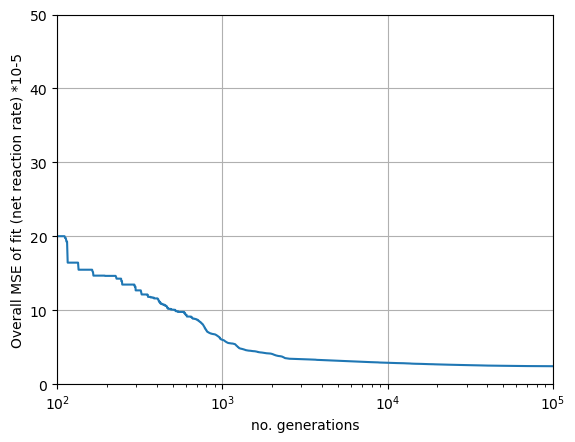

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.64414277626049
1.5458153379986752
0.8751258676813783
-4.161967389150992
0.47982883963519884
2.0366137980352543e-06
0.4043327356095253
-4.317322978175311
0.2712220823022783
4.655793064260969
3.552431498544213
3.7187782479543063
0.6260691983795537
0.033467759488051335
3.0332060809342494
9.54532574543771e-06
0.2955307396267235
-11.671000474847443
1.841325072165158
1.5596804369185546
-10.879197835442671
1.1108628879080458
3.730997725685738
0.020151619566018558
3.9208863403697367
4.323018736667548
1.7540290075674152
9.62273360797201
-9.716769398202452
2.729394387896895
1.775080135857996
3.4706016383999736
-4.291576437984972
0.5510974486722905
1.0252505942260155
-1.3010290770568584


In [37]:
res.X

array([-1.16441428e+01,  1.54581534e+00,  8.75125868e-01, -4.16196739e+00,
        4.79828840e-01,  2.03661380e-06,  4.04332736e-01, -4.31732298e+00,
        2.71222082e-01,  4.65579306e+00,  3.55243150e+00,  3.71877825e+00,
        6.26069198e-01,  3.34677595e-02,  3.03320608e+00,  9.54532575e-06,
        2.95530740e-01, -1.16710005e+01,  1.84132507e+00,  1.55968044e+00,
       -1.08791978e+01,  1.11086289e+00,  3.73099773e+00,  2.01516196e-02,
        3.92088634e+00,  4.32301874e+00,  1.75402901e+00,  9.62273361e+00,
       -9.71676940e+00,  2.72939439e+00,  1.77508014e+00,  3.47060164e+00,
       -4.29157644e+00,  5.51097449e-01,  1.02525059e+00, -1.30102908e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.64414277626049
1.6: 1.5458153379986752
0.9: 0.8751258676813783
-4.3: -4.161967389150992
0.5: 0.47982883963519884
0.003: 2.0366137980352543e-06
0.4: 0.4043327356095253
-7.9: -4.317322978175311
0.7: 0.2712220823022783
7.2: 4.655793064260969
5.7: 3.552431498544213
5.7: 3.7187782479543063
0.8: 0.6260691983795537
0.03: 0.033467759488051335
3.1: 3.0332060809342494
6.000000000000001e-09: 9.54532574543771e-06
0.1: 0.2955307396267235
-12.0: -11.671000474847443
1.9: 1.841325072165158
1.6: 1.5596804369185546
-11.6: -10.879197835442671
1.2: 1.1108628879080458
4.0: 3.730997725685738
0.01: 0.020151619566018558
4.2: 3.9208863403697367
5.4: 4.323018736667548
2.2: 1.7540290075674152
11.8: 9.62273360797201
-12.0: -9.716769398202452
3.3: 2.729394387896895
1.8: 1.775080135857996
4.2: 3.4706016383999736
-4.0: -4.291576437984972
0.5: 0.5510974486722905
1.0: 1.0252505942260155
coeff fit: 0.9603348562859637
r: 0.9799667628475793
